In [42]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv
import torch
import cv2 as cv
from cv2 import resize
import nrrd
import torchvision.transforms as transforms
from tqdm import tqdm
%matplotlib inline

In [2]:
INPUT_SHAPE = (192, 192, 3)
epochs = 10
batch_size = 32
valratio = 0.15

In [3]:
train_path = 'HACKATHON/images/train/'
test_path = 'HACKATHON/images/test/'
label_path = 'HACKATHON/train.txt'
segmentation_path = 'HACKATHON/segmentations/'

In [4]:
ss = []
with open(label_path, 'r') as f:
    for row in f:
        ss.append(row)

In [5]:
len(os.listdir(train_path))

355

In [6]:
def loadnib(path, root = train_path):
    scan = nib.load(root+ path)
    return np.array(scan.dataobj)

In [7]:
img = loadnib('0657.nii.gz')
img.shape, img[0].shape

((512, 512, 66), (512, 66))

In [181]:
def nibtoimg(path, root = train_path, slc = 25, file = 't.jpg'):
    scan = nib.load(root+ path)
    scan = np.array(scan.dataobj)
    t = np.rot90(scan[:,:,slc], k=3)
    plt.imsave(file, t)

In [182]:
nibtoimg('0013.nii.gz',root = test_path, slc = 72, file = 'curr.jpg')

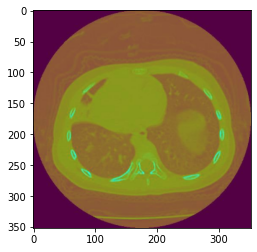

In [183]:
k = rgb_loader('curr.jpg')
plt.imshow(k)

In [10]:
def plot_slice(img, slc):
    plt.imshow(np.rot90(img[:,:,slc], k=3),cmap='gray')

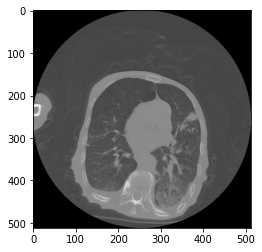

In [11]:
plot_slice(img, 34)

In [12]:
labels = []
for k in sorted(ss):
    a,b = k.split(',')
    labels.append(int(b))

In [13]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis =0)

In [14]:
def save_img(img, path = 'output.jpeg'):
    plt.imsave(path, img, cmap = 'gray')

In [201]:
from PIL import Image
def rgb_loader(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (352, 352))
    return img


def transform(x):
    operation = transforms.Compose([
                transforms.Resize((352, 352)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
    ])
    return operation(x).unsqueeze(0)

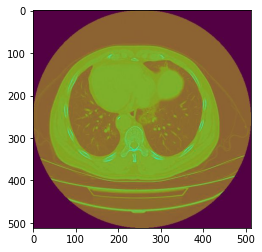

In [116]:
k  = rgb_loader('t.jpg')
plt.imshow(k, cmap = 'gray')

In [47]:
def get_ready(n, slc = 0):
    n = n.astype('float32')
    im = Image.fromarray(n[:,:,slc])
    im = im.convert('RGB')
    return transform(im)

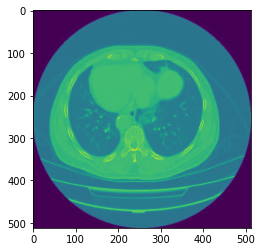

In [124]:
im = get_ready(k)
plt.imshow(k[:,:,1])

In [17]:
def gen(path = train_path):
    for filepath in os.listdir(path):
        try:
            scan = nib.load(path+filepath)
            yield np.array(scan.dataobj)
        except StopIteration:
            break;

In [18]:
g = gen()

In [19]:
n = next(g)
n = n.astype('float32')


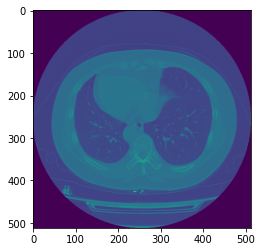

In [20]:
plt.imshow(np.rot90(n[:,:,23], k = 3))

In [21]:
print("You mothafucka")

You mothafucka


## Semi Inf-Net

In [125]:
!mkdir -p Results/semi

In [126]:
save_path = 'Results/semi'

In [127]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b model_lung_infection.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']),map_location=torch.device('cpu') )
    return model


def res2net101_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net50_v1b_26w_4s(pretrained=True, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        # Please replace it with your custom path
        model_state = torch.load('res2net50_v1b_26w_4s-3cf99910.pth', map_location=torch.device('cpu'))
        model.load_state_dict(model_state)
        # model_lung_infection.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model


def res2net101_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 23, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net101_v1b_26w_4s']))
    return model


def res2net152_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s model_lung_infection.
    Args:
        pretrained (bool): If True, returns a model_lung_infection pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 8, 36, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net152_v1b_26w_4s']))
    return model

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel, n_class):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, n_class, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class Inf_Net(nn.Module):
    def __init__(self, channel=32, n_class=1):
        super(Inf_Net, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)

        # ---- Partial Decoder ----
        self.ParDec = aggregation(channel, n_class)

        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256+64, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, n_class, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64+64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

        # ---- edge branch ----
        self.edge_conv1 = BasicConv2d(256, 64, kernel_size=1)
        self.edge_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.edge_conv4 = BasicConv2d(64, n_class, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)

        # ---- low-level features ----
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88

        # ---- high-level features ----
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44
        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        # ---- edge guidance ----
        x = self.edge_conv1(x1)
        x = self.edge_conv2(x)
        edge_guidance = self.edge_conv3(x)  # torch.Size([1, 64, 88, 88])
        lateral_edge = self.edge_conv4(edge_guidance)   # NOTES: Sup-2 (bs, 1, 88, 88) -> (bs, 1, 352, 352)
        lateral_edge = F.interpolate(lateral_edge,
                                     scale_factor=4,
                                     mode='bilinear')

        # ---- global guidance ----
        ra5_feat = self.ParDec(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat,
                                      scale_factor=8,
                                      mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1  # reverse
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = torch.cat((self.ra4_conv1(x), F.interpolate(edge_guidance, scale_factor=1/8, mode='bilinear')), dim=1)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4   # element-wise addition
        lateral_map_4 = F.interpolate(x,
                                      scale_factor=32,
                                      mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = torch.cat((self.ra3_conv1(x), F.interpolate(edge_guidance, scale_factor=1/4, mode='bilinear')), dim=1)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x,
                                      scale_factor=16,
                                      mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')

        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = torch.cat((self.ra2_conv1(x), F.interpolate(edge_guidance, scale_factor=1/2, mode='bilinear')), dim=1)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x,
                                      scale_factor=8,
                                      mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge


In [129]:
seminet_pth ='Semi-Inf-Net/Semi-Inf-Net-100.pth'
save_test = 'Results/Lung-infection-segmentation/Semi-Inf-Net/'
save_train = 'Results/Lung-infection-segmentation/train/'

In [130]:
semi = Inf_Net()
device = torch.device('cpu')
semi.load_state_dict(torch.load(seminet_pth, map_location=device))

<All keys matched successfully>

In [131]:
semi.eval()

Inf_Net(
  (resnet): Res2Net(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottle2neck(
        (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [132]:
def predict_semi(k):
    lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2, lateral_edge = semi(k)
    res = lateral_map_2
    res = res.sigmoid().data.cpu().numpy().squeeze()
    res = (res - res.min()) / (res.max() - res.min() + 1e-8)
    #plt.imsave(save_path + '0.jpeg' ,res, cmap = 'gray')
    #plt.imshow(res, cmap='gray')
    return res

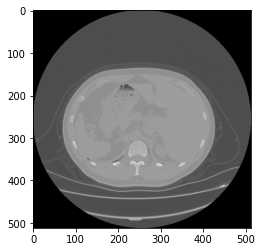

In [133]:
n = next(g)
plot_slice(n, slc = 34)

In [134]:
k = get_ready(n)
x = predict_semi(k)

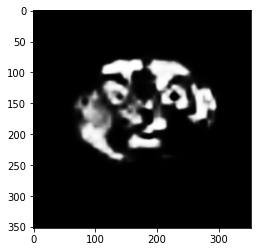

In [135]:
plt.imshow(np.rot90(x), cmap = 'gray')

In [136]:
def percent_lungs_slice(filepath_mask, slice_number):
    M, _ = nrrd.read(filepath_mask)
    current_slice, _ = bound_box_and_reshape(M, slice_number)
    num_pixels = current_slice.shape[2] * current_slice.shape[1]
    white = np.sum(current_slice)
    return "{:.1f}".format(white / num_pixels)

In [137]:
def bound_box_and_reshape(img, slice_idx):
    """
    Crop given slice of image to lung size (remove redundant empty space) and reshape to 512x512 pxls. Return edited img_slice.
    """
    img_slice = img[:,:,slice_idx]    
    rows = np.any(img_slice, axis=1)
    cols = np.any(img_slice, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    img_slice = resize(img_slice[rmin:rmax, cmin:cmax], (512,512))
    img_slice = np.transpose(img_slice[:, :, np.newaxis], axes = [2, 0, 1]).astype('float32')
    lung_pixels = abs((rmax-rmin) * (cmax - cmin))
    
    return img_slice, lung_pixels

In [138]:
def mask_original(filepath_CT, filepath_mask):
    """
    Mask and normalize original CT. Select only preset number of central slices. 
    """
    I = np.array(nib.load(filepath_CT).dataobj)
    #I = normalize(I, -1350, 150)
    M, _ = nrrd.read(filepath_mask)
    
    nS = np.where(M==1, I, M)
    
    #z = nS.shape[2]//2
    #dz = nb_central_slices//2
    #nS = nS[:,:,z-dz:z+dz]
        
    return nS

In [144]:
filename_img = '0013.nii.gz'
i = 64

In [145]:
filename_mask = filename_img.replace(".nii.gz", ".nrrd")
filepath_img = os.path.join(test_path, filename_img)
filepath_mask = os.path.join(segmentation_path+"test/", filename_mask)
patient_number = filename_mask.split(".nrrd")[0]
img = mask_original(filepath_img, filepath_mask)


In [146]:
#plt.imshow(img[:,:,45])

In [147]:
current_slice, bbox_pixels = bound_box_and_reshape(img, i)
current_slice = np.rot90(np.squeeze(current_slice))
percentage = percent_lungs_slice(filepath_mask, i)

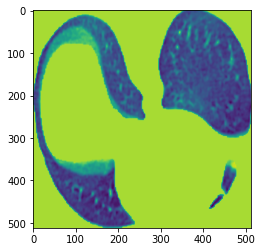

In [148]:
plt.imshow(current_slice)

In [149]:
plt.imsave('cur.jpg', current_slice)

In [154]:
t = transform(rgb_loader('cur.jpg'))

In [155]:
r = predict_semi(t)

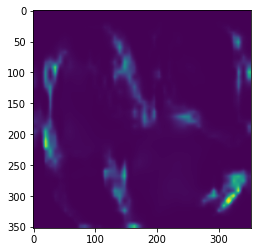

In [156]:
plt.imshow(r)
plt.imsave('semi.jpg', r)

In [157]:
x = Image.fromarray(current_slice).convert('RGB')
x = transform(x)

In [158]:
y = predict_semi(x)
y.shape

(352, 352)

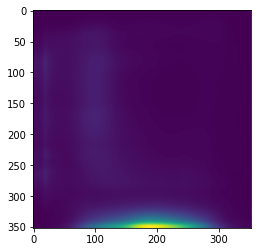

In [159]:
plt.imshow(y)

In [66]:
e = transform(rgb_loader('semi.jpg'))

In [67]:
e.shape

torch.Size([1, 3, 352, 352])

In [68]:
filepath = '0000.nii.gz'

In [69]:
def save_pseudo(path, opt = save_test):
    scan = nib.load(train_path+path)
    scan = np.array(scan.dataobj)
    for i in range(scan.shape[2]):
        p = path.replace('.nii.gz', '')+"-"+str(i)+".jpeg"
        t = get_ready(scan, slc = i)
        res = predict_semi(t)
        pred = predict_unet(t, res)
        ggo, conso = split_class_imgs(pred)
        save_img(res, opt + p)

In [70]:
save_pseudo(filepath)

NameError: name 'predict_unet' is not defined

In [ ]:
def store_results(path = test_path):
    for k in tqdm(os.listdir(path)):
        save_pseudo(k, opt = save_train)

In [ ]:
#store_results(path = train_path)

In [160]:
saving_path = 'Results/wash/'

In [161]:
def calculate_mask_area_percentage(mask, NP_VALUE_OF_MASK):
    """
        Input je numpy array. Vrže ven odstotek, kolikšen
        del slike zajema anomalija.
    """
    mask = np.where(mask == NP_VALUE_OF_MASK, 1, 0)
    summa = np.sum(mask)
    percentage = float(summa) / (mask.shape[0]*mask.shape[1])
    return round(percentage,3)

In [162]:
def save_slice(slice_image, slice_name):
    plt.imsave(os.path.join(saving_path, slice_name + ".jpg"), np.rot90(np.squeeze(slice_image), k=3),cmap='gray')

# Semi Unet

In [163]:
path = 'Semi-Inf-Net_UNet/unet_model_200.pkl'

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [165]:
class Inf_Net_UNet(nn.Module):
    """ Full assembly of the parts to form the complete network """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Inf_Net_UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [166]:
infnet = Inf_Net_UNet(6,3)
device = torch.device('cpu')
infnet.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [167]:
infnet.eval()

Inf_Net_UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05

In [168]:
#plt.imsave('pseudo.jpeg', k.detach().numpy())

In [169]:
def predict_unet(k,d):
    s = torch.cat((k,d), dim=1)
    res = infnet(s)
    res = torch.sigmoid(res) 
    b, _, w, h = res.size()
    # output b*n_class*h*w -- > b*h*w
    pred = res.cpu().permute(0, 2, 3, 1).contiguous().view(-1, 3).max(1)[1].view(b, w, h).numpy().squeeze()
    return pred

In [170]:
def split_class_imgs(pred):
    im_array_red = np.array(pred)  # 0, 38
    im_array_green = np.array(pred)  # 0, 75
    print(np.unique(im_array_red)) # mask value is max of this

    im_array_red[im_array_red != 0] = 1
    im_array_red[im_array_red == 0] = 255
    im_array_red[im_array_red == 1] = 0

    im_array_green[im_array_green != 1] = 0
    im_array_green[im_array_green == 1] = 255
    
   # red = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))
    #green = Image.fromarray(im_array_red).convert('1').resize(size=(512, 512))

    return im_array_green, im_array_red

In [171]:
LABEL_PATH = 'HACKATHON/train.txt'

In [172]:
def get_label(patient_number):
    with open(LABEL_PATH) as file:
        for line in file.readlines():
            if str(patient_number) in line:
                label = line.split(",")[1].rsplit("\n")[0]
                return label

In [173]:
##  končna segmentacija(summa)

In [174]:
def process_one_patient(filename_img):
    filename_mask = filename_img.replace(".nii.gz", ".nrrd")
    filepath_img = os.path.join(train_path, filename_img)
    filepath_mask = os.path.join(segmentation_path, filename_mask)
    patient_number = filename_mask.split(".nrrd")[0]
    img = mask_original(filepath_img, filepath_mask)
    num_slices = img.shape[2]
    
    label = get_label(patient_number)
    
    patient_lung_volume_score = 0.0
    patient_ggo_score = 0.0
    patient_consolidation_score = 0.0
        
    for i in tqdm(range(num_slices)):
        try:
            current_slice, bbox_pixels = bound_box_and_reshape(img, i)
        except:
            continue
    
        current_slice = np.rot90(np.squeeze(current_slice))
        percentage = percent_lungs_slice(filepath_mask, i)
        if percentage != 0:
            plt.imsave('cur.jpg', current_slice)
            t = transform(rgb_loader('cur.jpg'))
            r = predict_semi(t)
            plt.imsave('semi.jpg', r)
            e = transform(rgb_loader('semi.jpg'))
            pred = predict_unet(t,e)
            ggo_mask, consolidation_mask = split_class_imgs(pred)
            
            NP_VALUE_OF_MASK = 255
            patient_lung_volume_score += float(percentage) * bbox_pixels
            
            ggo_percentage = calculate_mask_area_percentage(ggo_mask, NP_VALUE_OF_MASK)
            consolidation_percentage = calculate_mask_area_percentage(consolidation_mask, NP_VALUE_OF_MASK)
            
            patient_ggo_score += ggo_percentage * bbox_pixels
            patient_consolidation_score += consolidation_percentage * bbox_pixels
    
    return {"filename_img" : filename_img,
            "label" : label,
            "lung_vol": patient_lung_volume_score, 
            "ggo_vol" : patient_ggo_score, 
            "cons_vol" : patient_consolidation_score}

In [87]:
f = os.listdir(train_path)[:30]
training_csv = 'proba.csv'

In [67]:
def process_all_patients(path = train_path):
    training_set = []
    for _,_,filenames in os.walk(path):
        for filename in tqdm(filenames):
            if filename.endswith(".nii.gz"):
                patient_dict = process_one_patient(filename)
                with open(training_csv, mode='a') as file_:
                    file_.write(str(patient_dict.values()))
                    file_.write("\n")
                training_set.append(patient_dict)
    return training_set

In [59]:
y = process_all_patients()

 10%|▉         | 6/62 [00:01<00:17,  3.20it/s]

[0 1 2]



 11%|█▏        | 7/62 [00:03<00:32,  1.71it/s]

[0 1 2]



 13%|█▎        | 8/62 [00:05<00:46,  1.15it/s]

[0 1 2]



 15%|█▍        | 9/62 [00:07<00:55,  1.04s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:08<01:01,  1.18s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:10<01:13,  1.45s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:12<01:17,  1.55s/it]

[0 1 2]



 21%|██        | 13/62 [00:14<01:16,  1.56s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:15<01:16,  1.59s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:17<01:20,  1.72s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:20<01:34,  2.05s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:22<01:28,  1.97s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:24<01:27,  1.98s/it]

[0 1 2]



 31%|███       | 19/62 [00:26<01:20,  1.88s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:27<01:16,  1.81s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:29<01:12,  1.78s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:31<01:17,  1.94s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:33<01:12,  1.86s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:35<01:08,  1.81s/it]

[0 1 2]



 40%|████      | 25/62 [00:37<01:09,  1.88s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:39<01:07,  1.88s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:41<01:05,  1.87s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:42<01:01,  1.81s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:44<01:01,  1.86s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:46<00:57,  1.81s/it]

[0 1 2]



 50%|█████     | 31/62 [00:48<00:55,  1.78s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:49<00:53,  1.78s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:52<00:55,  1.91s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:53<00:51,  1.84s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:55<00:48,  1.79s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:57<00:49,  1.90s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:59<00:46,  1.86s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:01<00:45,  1.88s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:03<00:43,  1.88s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:05<00:41,  1.91s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:06<00:38,  1.83s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:08<00:35,  1.78s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:10<00:33,  1.75s/it]

[0 1 2]



 71%|███████   | 44/62 [01:12<00:35,  1.96s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:14<00:32,  1.90s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:16<00:30,  1.89s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:18<00:29,  1.98s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:20<00:26,  1.92s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:22<00:24,  1.91s/it]

[0 1 2]



 81%|████████  | 50/62 [01:23<00:22,  1.89s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:25<00:21,  1.93s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:27<00:18,  1.85s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:29<00:16,  1.81s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:31<00:15,  1.89s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:33<00:13,  1.87s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:34<00:10,  1.82s/it]

[0 1 2]



  0%|          | 1/355 [01:36<9:31:44, 96.91s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:02<00:08,  6.76it/s]

[0 1 2]



 21%|██        | 15/73 [00:03<00:16,  3.42it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:05<00:28,  1.97it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:08<00:43,  1.29it/s]

[0 1 2]



 25%|██▍       | 18/73 [00:10<00:51,  1.06it/s]

[0 1 2]



 26%|██▌       | 19/73 [00:11<00:58,  1.09s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:13<01:07,  1.28s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:15<01:17,  1.48s/it]

[0 1 2]



 30%|███       | 22/73 [00:17<01:20,  1.59s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:19<01:22,  1.65s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:21<01:25,  1.75s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:23<01:23,  1.74s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:25<01:22,  1.75s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:27<01:23,  1.81s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:29<01:26,  1.92s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:30<01:21,  1.84s/it]

[0 1 2]



 41%|████      | 30/73 [00:32<01:17,  1.80s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:34<01:16,  1.81s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:36<01:19,  1.93s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:38<01:16,  1.91s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:40<01:12,  1.85s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:42<01:14,  1.95s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:44<01:12,  1.95s/it]

[0 1 2]



 51%|█████     | 37/73 [00:46<01:09,  1.94s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:48<01:09,  1.97s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:50<01:07,  1.98s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:52<01:03,  1.92s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:53<00:59,  1.86s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:55<00:59,  1.91s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:57<00:58,  1.95s/it]

[0 1 2]



 60%|██████    | 44/73 [00:59<00:54,  1.89s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:01<00:51,  1.85s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:03<00:53,  1.98s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:05<00:50,  1.93s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:07<00:46,  1.87s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:09<00:45,  1.90s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:11<00:44,  1.93s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:12<00:41,  1.88s/it]

[0 1 2]



 71%|███████   | 52/73 [01:14<00:39,  1.89s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:17<00:39,  1.97s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:19<00:39,  2.06s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:20<00:34,  1.94s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:22<00:31,  1.88s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:24<00:30,  1.94s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:26<00:27,  1.85s/it]

[0 1 2]



 81%|████████  | 59/73 [01:28<00:25,  1.83s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:30<00:24,  1.89s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:32<00:23,  1.98s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:34<00:21,  1.94s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:35<00:18,  1.89s/it]

[0 1 2]



  1%|          | 2/355 [03:15<9:35:08, 97.76s/it]

[0 1 2]



  4%|▍         | 13/296 [00:01<00:41,  6.88it/s]

[0 1 2]



  5%|▍         | 14/296 [00:03<01:31,  3.08it/s]

[0 1 2]



  5%|▌         | 15/296 [00:06<02:41,  1.73it/s]

[0 1 2]



  5%|▌         | 16/296 [00:08<03:36,  1.29it/s]

[0 1 2]



  6%|▌         | 17/296 [00:10<04:47,  1.03s/it]

[0 1 2]



  6%|▌         | 18/296 [00:12<05:39,  1.22s/it]

[0 1 2]



  6%|▋         | 19/296 [00:14<06:48,  1.48s/it]

[0 1 2]



  7%|▋         | 20/296 [00:16<07:20,  1.59s/it]

[0 1 2]



  7%|▋         | 21/296 [00:18<07:35,  1.66s/it]

[0 1 2]



  7%|▋         | 22/296 [00:20<08:26,  1.85s/it]

[0 1 2]



  8%|▊         | 23/296 [00:22<08:28,  1.86s/it]

[0 1 2]



  8%|▊         | 24/296 [00:24<08:37,  1.90s/it]

[0 1 2]



  8%|▊         | 25/296 [00:27<09:30,  2.10s/it]

[0 1 2]



  9%|▉         | 26/296 [00:29<09:12,  2.05s/it]

[0 1 2]



  9%|▉         | 27/296 [00:31<09:19,  2.08s/it]

[0 1 2]



  9%|▉         | 28/296 [00:33<09:24,  2.10s/it]

[0 1 2]



 10%|▉         | 29/296 [00:35<09:44,  2.19s/it]

[0 1 2]



 10%|█         | 30/296 [00:37<09:23,  2.12s/it]

[0 1 2]



 10%|█         | 31/296 [00:39<09:09,  2.07s/it]

[0 1 2]



 11%|█         | 32/296 [00:42<09:40,  2.20s/it]

[0 1 2]



 11%|█         | 33/296 [00:44<09:17,  2.12s/it]

[0 1 2]



 11%|█▏        | 34/296 [00:46<09:05,  2.08s/it]

[0 1 2]



 12%|█▏        | 35/296 [00:48<09:16,  2.13s/it]

[0 1 2]



 12%|█▏        | 36/296 [00:50<08:55,  2.06s/it]

[0 1 2]



 12%|█▎        | 37/296 [00:52<09:07,  2.12s/it]

[0 1 2]



 13%|█▎        | 38/296 [00:54<09:10,  2.13s/it]

[0 1 2]



 13%|█▎        | 39/296 [00:56<08:58,  2.09s/it]

[0 1 2]



 14%|█▎        | 40/296 [00:58<08:38,  2.03s/it]

[0 1 2]



 14%|█▍        | 41/296 [01:00<08:30,  2.00s/it]

[0 1 2]



 14%|█▍        | 42/296 [01:02<08:51,  2.09s/it]

[0 1 2]



 15%|█▍        | 43/296 [01:04<08:44,  2.07s/it]

[0 1 2]



 15%|█▍        | 44/296 [01:06<08:31,  2.03s/it]

[0 1 2]



 15%|█▌        | 45/296 [01:09<08:59,  2.15s/it]

[0 1 2]



 16%|█▌        | 46/296 [01:11<08:35,  2.06s/it]

[0 1 2]



 16%|█▌        | 47/296 [01:13<08:26,  2.03s/it]

[0 1 2]



 16%|█▌        | 48/296 [01:15<08:16,  2.00s/it]

[0 1 2]



 17%|█▋        | 49/296 [01:17<08:37,  2.09s/it]

[0 1 2]



 17%|█▋        | 50/296 [01:19<08:17,  2.02s/it]

[0 1 2]



 17%|█▋        | 51/296 [01:21<08:00,  1.96s/it]

[0 1 2]



 18%|█▊        | 52/296 [01:23<08:37,  2.12s/it]

[0 1 2]



 18%|█▊        | 53/296 [01:25<08:15,  2.04s/it]

[0 1 2]



 18%|█▊        | 54/296 [01:27<07:59,  1.98s/it]

[0 1 2]



 19%|█▊        | 55/296 [01:29<08:01,  2.00s/it]

[0 1 2]



 19%|█▉        | 56/296 [01:31<08:11,  2.05s/it]

[0 1 2]



 19%|█▉        | 57/296 [01:33<08:10,  2.05s/it]

[0 1 2]



 20%|█▉        | 58/296 [01:35<08:01,  2.02s/it]

[0 1 2]



 20%|█▉        | 59/296 [01:37<08:14,  2.09s/it]

[0 1 2]



 20%|██        | 60/296 [01:39<07:54,  2.01s/it]

[0 1 2]



 21%|██        | 61/296 [01:41<07:39,  1.95s/it]

[0 1 2]



 21%|██        | 62/296 [01:43<08:07,  2.08s/it]

[0 1 2]



 21%|██▏       | 63/296 [01:45<08:01,  2.07s/it]

[0 1 2]



 22%|██▏       | 64/296 [01:47<07:50,  2.03s/it]

[0 1 2]



 22%|██▏       | 65/296 [01:49<07:43,  2.01s/it]

[0 1 2]



 22%|██▏       | 66/296 [01:51<08:01,  2.09s/it]

[0 1 2]



 23%|██▎       | 67/296 [01:54<08:02,  2.11s/it]

[0 1 2]



 23%|██▎       | 68/296 [01:56<07:57,  2.09s/it]

[0 1 2]



 23%|██▎       | 69/296 [01:58<08:20,  2.20s/it]

[0 1 2]



 24%|██▎       | 70/296 [02:00<08:06,  2.15s/it]

[0 1 2]



 24%|██▍       | 71/296 [02:03<08:27,  2.26s/it]

[0 1 2]



 24%|██▍       | 72/296 [02:06<09:02,  2.42s/it]

[0 1 2]



 25%|██▍       | 73/296 [02:07<08:26,  2.27s/it]

[0 1 2]



 25%|██▌       | 74/296 [02:09<07:59,  2.16s/it]

[0 1 2]



 25%|██▌       | 75/296 [02:12<08:13,  2.23s/it]

[0 1 2]



 26%|██▌       | 76/296 [02:14<08:04,  2.20s/it]

[0 1 2]



 26%|██▌       | 77/296 [02:16<07:43,  2.11s/it]

[0 1 2]



 26%|██▋       | 78/296 [02:18<07:35,  2.09s/it]

[0 1 2]



 27%|██▋       | 79/296 [02:20<07:38,  2.11s/it]

[0 1 2]



 27%|██▋       | 80/296 [02:22<07:22,  2.05s/it]

[0 1 2]



 27%|██▋       | 81/296 [02:24<07:22,  2.06s/it]

[0 1 2]



 28%|██▊       | 82/296 [02:26<07:34,  2.13s/it]

[0 1 2]



 28%|██▊       | 83/296 [02:28<07:21,  2.07s/it]

[0 1 2]



 28%|██▊       | 84/296 [02:30<07:09,  2.03s/it]

[0 1 2]



 29%|██▊       | 85/296 [02:32<07:22,  2.10s/it]

[0 1 2]



 29%|██▉       | 86/296 [02:35<07:34,  2.16s/it]

[0 1 2]



 29%|██▉       | 87/296 [02:37<07:13,  2.08s/it]

[0 1 2]



 30%|██▉       | 88/296 [02:39<07:06,  2.05s/it]

[0 1 2]



 30%|███       | 89/296 [02:41<07:15,  2.11s/it]

[0 1 2]



 30%|███       | 90/296 [02:43<06:57,  2.03s/it]

[0 1 2]



 31%|███       | 91/296 [02:45<06:58,  2.04s/it]

[0 1 2]



 31%|███       | 92/296 [02:47<07:24,  2.18s/it]

[0 1 2]



 31%|███▏      | 93/296 [02:49<07:06,  2.10s/it]

[0 1 2]



 32%|███▏      | 94/296 [02:51<06:53,  2.05s/it]

[0 1 2]



 32%|███▏      | 95/296 [02:53<06:56,  2.07s/it]

[0 1 2]



 32%|███▏      | 96/296 [02:56<07:15,  2.18s/it]

[0 1 2]



 33%|███▎      | 97/296 [02:57<06:55,  2.09s/it]

[0 1 2]



 33%|███▎      | 98/296 [02:59<06:50,  2.07s/it]

[0 1 2]



 33%|███▎      | 99/296 [03:02<07:02,  2.14s/it]

[0 1 2]



 34%|███▍      | 100/296 [03:04<06:47,  2.08s/it]

[0 1 2]



 34%|███▍      | 101/296 [03:06<06:57,  2.14s/it]

[0 1 2]



 34%|███▍      | 102/296 [03:08<07:14,  2.24s/it]

[0 1 2]



 35%|███▍      | 103/296 [03:10<06:54,  2.15s/it]

[0 1 2]



 35%|███▌      | 104/296 [03:12<06:39,  2.08s/it]

[0 1 2]



 35%|███▌      | 105/296 [03:15<06:55,  2.18s/it]

[0 1 2]



 36%|███▌      | 106/296 [03:17<06:51,  2.17s/it]

[0 1 2]



 36%|███▌      | 107/296 [03:19<06:31,  2.07s/it]

[0 1 2]



 36%|███▋      | 108/296 [03:21<06:18,  2.01s/it]

[0 1 2]



 37%|███▋      | 109/296 [03:23<06:33,  2.11s/it]

[0 1 2]



 37%|███▋      | 110/296 [03:25<06:20,  2.04s/it]

[0 1 2]



 38%|███▊      | 111/296 [03:27<06:27,  2.09s/it]

[0 1 2]



 38%|███▊      | 112/296 [03:29<06:38,  2.17s/it]

[0 1 2]



 38%|███▊      | 113/296 [03:31<06:20,  2.08s/it]

[0 1 2]



 39%|███▊      | 114/296 [03:33<06:02,  1.99s/it]

[0 1 2]



 39%|███▉      | 115/296 [03:35<06:19,  2.10s/it]

[0 1 2]



 39%|███▉      | 116/296 [03:38<06:22,  2.12s/it]

[0 1 2]



 40%|███▉      | 117/296 [03:39<06:06,  2.05s/it]

[0 1 2]



 40%|███▉      | 118/296 [03:41<05:56,  2.00s/it]

[0 1 2]



 40%|████      | 119/296 [03:44<06:05,  2.07s/it]

[0 1 2]



 41%|████      | 120/296 [03:46<05:59,  2.04s/it]

[0 1 2]



 41%|████      | 121/296 [03:48<06:09,  2.11s/it]

[0 1 2]



 41%|████      | 122/296 [03:50<06:23,  2.21s/it]

[0 1 2]



 42%|████▏     | 123/296 [03:53<06:52,  2.38s/it]

[0 1 2]



 42%|████▏     | 124/296 [04:05<15:02,  5.24s/it]

[0 1 2]



 42%|████▏     | 125/296 [04:08<13:27,  4.72s/it]

[0 1 2]



 43%|████▎     | 126/296 [04:11<11:24,  4.03s/it]

[0 1 2]



 43%|████▎     | 127/296 [04:13<09:50,  3.49s/it]

[0 1 2]



 43%|████▎     | 128/296 [04:16<09:06,  3.25s/it]

[0 1 2]



 44%|████▎     | 129/296 [04:18<08:21,  3.00s/it]

[0 1 2]



 44%|████▍     | 130/296 [04:20<07:30,  2.71s/it]

[0 1 2]



 44%|████▍     | 131/296 [04:22<06:45,  2.46s/it]

[0 1 2]



 45%|████▍     | 132/296 [04:25<06:48,  2.49s/it]

[0 1 2]



 45%|████▍     | 133/296 [04:27<06:57,  2.56s/it]

[0 1 2]



 45%|████▌     | 134/296 [04:30<06:49,  2.53s/it]

[0 1 2]



 46%|████▌     | 135/296 [04:32<06:34,  2.45s/it]

[0 1 2]



 46%|████▌     | 136/296 [04:35<07:07,  2.67s/it]

[0 1 2]



 46%|████▋     | 137/296 [04:37<06:28,  2.44s/it]

[0 1 2]



 47%|████▋     | 138/296 [04:40<06:54,  2.62s/it]

[0 1 2]



 47%|████▋     | 139/296 [04:42<06:28,  2.47s/it]

[0 1 2]



 47%|████▋     | 140/296 [04:45<06:18,  2.42s/it]

[0 1 2]



 48%|████▊     | 141/296 [04:47<06:13,  2.41s/it]

[0 1 2]



 48%|████▊     | 142/296 [04:49<05:57,  2.32s/it]

[0 1 2]



 48%|████▊     | 143/296 [04:51<05:40,  2.23s/it]

[0 1 2]



 49%|████▊     | 144/296 [04:54<05:48,  2.29s/it]

[0 1 2]



 49%|████▉     | 145/296 [04:56<05:36,  2.23s/it]

[0 1 2]



 49%|████▉     | 146/296 [04:58<05:19,  2.13s/it]

[0 1 2]



 50%|████▉     | 147/296 [05:00<05:29,  2.21s/it]

[0 1 2]



 50%|█████     | 148/296 [05:03<05:37,  2.28s/it]

[0 1 2]



 50%|█████     | 149/296 [05:05<05:26,  2.22s/it]

[0 1 2]



 51%|█████     | 150/296 [05:07<05:29,  2.26s/it]

[0 1 2]



 51%|█████     | 151/296 [05:10<05:42,  2.36s/it]

[0 1 2]



 51%|█████▏    | 152/296 [05:12<05:23,  2.24s/it]

[0 1 2]



 52%|█████▏    | 153/296 [05:14<05:10,  2.17s/it]

[0 1 2]



 52%|█████▏    | 154/296 [05:16<05:19,  2.25s/it]

[0 1 2]



 52%|█████▏    | 155/296 [05:18<05:13,  2.23s/it]

[0 1 2]



 53%|█████▎    | 156/296 [05:20<05:16,  2.26s/it]

[0 1 2]



 53%|█████▎    | 157/296 [05:23<05:25,  2.34s/it]

[0 1 2]



 53%|█████▎    | 158/296 [05:25<05:10,  2.25s/it]

[0 1 2]



 54%|█████▎    | 159/296 [05:27<05:02,  2.21s/it]

[0 1 2]



 54%|█████▍    | 160/296 [05:30<05:11,  2.29s/it]

[0 1 2]



 54%|█████▍    | 161/296 [05:32<04:59,  2.22s/it]

[0 1 2]



 55%|█████▍    | 162/296 [05:34<04:52,  2.19s/it]

[0 1 2]



 55%|█████▌    | 163/296 [05:37<05:13,  2.36s/it]

[0 1 2]



 55%|█████▌    | 164/296 [05:39<05:00,  2.28s/it]

[0 1 2]



 56%|█████▌    | 165/296 [05:41<04:55,  2.25s/it]

[0 1 2]



 56%|█████▌    | 166/296 [05:43<05:01,  2.32s/it]

[0 1 2]



 56%|█████▋    | 167/296 [05:46<04:55,  2.29s/it]

[0 1 2]



 57%|█████▋    | 168/296 [05:48<04:48,  2.25s/it]

[0 1 2]



 57%|█████▋    | 169/296 [05:50<05:07,  2.42s/it]

[0 1 2]



 57%|█████▋    | 170/296 [05:53<04:56,  2.35s/it]

[0 1 2]



 58%|█████▊    | 171/296 [05:55<04:43,  2.27s/it]

[0 1 2]



 58%|█████▊    | 172/296 [05:57<04:58,  2.41s/it]

[0 1 2]



 58%|█████▊    | 173/296 [06:00<04:50,  2.37s/it]

[0 1 2]



 59%|█████▉    | 174/296 [06:02<04:50,  2.38s/it]

[0 1 2]



 59%|█████▉    | 175/296 [06:05<04:58,  2.46s/it]

[0 1 2]



 59%|█████▉    | 176/296 [06:07<04:42,  2.35s/it]

[0 1 2]



 60%|█████▉    | 177/296 [06:09<04:26,  2.24s/it]

[0 1 2]



 60%|██████    | 178/296 [06:12<04:47,  2.44s/it]

[0 1 2]



 60%|██████    | 179/296 [06:14<04:29,  2.30s/it]

[0 1 2]



 61%|██████    | 180/296 [06:16<04:21,  2.26s/it]

[0 1 2]



 61%|██████    | 181/296 [06:19<04:33,  2.38s/it]

[0 1 2]



 61%|██████▏   | 182/296 [06:21<04:22,  2.30s/it]

[0 1 2]



 62%|██████▏   | 183/296 [06:23<04:15,  2.26s/it]

[0 1 2]



 62%|██████▏   | 184/296 [06:25<04:22,  2.35s/it]

[0 1 2]



 62%|██████▎   | 185/296 [06:28<04:15,  2.31s/it]

[0 1 2]



 63%|██████▎   | 186/296 [06:30<04:01,  2.19s/it]

[0 1 2]



 63%|██████▎   | 187/296 [06:32<04:17,  2.37s/it]

[0 1 2]



 64%|██████▎   | 188/296 [06:34<04:04,  2.26s/it]

[0 1 2]



 64%|██████▍   | 189/296 [06:36<03:57,  2.22s/it]

[0 1 2]



 64%|██████▍   | 190/296 [06:39<04:16,  2.42s/it]

[0 1 2]



 65%|██████▍   | 191/296 [06:41<03:57,  2.26s/it]

[0 1 2]



 65%|██████▍   | 192/296 [06:43<03:51,  2.22s/it]

[0 1 2]



 65%|██████▌   | 193/296 [06:46<03:57,  2.30s/it]

[0 1 2]



 66%|██████▌   | 194/296 [06:48<03:42,  2.18s/it]

[0 1 2]



 66%|██████▌   | 195/296 [06:50<03:34,  2.13s/it]

[0 1 2]



 66%|██████▌   | 196/296 [06:52<03:27,  2.07s/it]

[0 1 2]



 67%|██████▋   | 197/296 [06:55<03:46,  2.29s/it]

[0 1 2]



 67%|██████▋   | 198/296 [06:57<03:40,  2.25s/it]

[0 1 2]



 67%|██████▋   | 199/296 [06:59<03:31,  2.18s/it]

[0 1 2]



 68%|██████▊   | 200/296 [07:01<03:28,  2.17s/it]

[0 1 2]



 68%|██████▊   | 201/296 [07:04<04:01,  2.54s/it]

[0 1 2]



 68%|██████▊   | 202/296 [07:07<03:56,  2.52s/it]

[0 1 2]



 69%|██████▊   | 203/296 [07:09<03:45,  2.42s/it]

[0 1 2]



 69%|██████▉   | 204/296 [07:11<03:34,  2.33s/it]

[0 1 2]



 69%|██████▉   | 205/296 [07:13<03:28,  2.29s/it]

[0 1 2]



 70%|██████▉   | 206/296 [07:16<03:34,  2.38s/it]

[0 1 2]



 70%|██████▉   | 207/296 [07:18<03:19,  2.24s/it]

[0 1 2]



 70%|███████   | 208/296 [07:20<03:09,  2.15s/it]

[0 1 2]



 71%|███████   | 209/296 [07:22<03:13,  2.22s/it]

[0 1 2]



 71%|███████   | 210/296 [07:24<03:05,  2.16s/it]

[0 1 2]



 71%|███████▏  | 211/296 [07:26<02:58,  2.10s/it]

[0 1 2]



 72%|███████▏  | 212/296 [07:29<03:10,  2.27s/it]

[0 1 2]



 72%|███████▏  | 213/296 [07:31<03:01,  2.19s/it]

[0 1 2]



 72%|███████▏  | 214/296 [07:33<02:53,  2.12s/it]

[0 1 2]



 73%|███████▎  | 215/296 [07:35<03:02,  2.25s/it]

[0 1 2]



 73%|███████▎  | 216/296 [07:37<02:59,  2.25s/it]

[0 1 2]



 73%|███████▎  | 217/296 [07:40<02:55,  2.22s/it]

[0 1 2]



 74%|███████▎  | 218/296 [07:42<02:54,  2.24s/it]

[0 1 2]



 74%|███████▍  | 219/296 [07:44<02:54,  2.27s/it]

[0 1 2]



 74%|███████▍  | 220/296 [07:46<02:46,  2.19s/it]

[0 1 2]



 75%|███████▍  | 221/296 [07:48<02:38,  2.11s/it]

[0 1 2]



 75%|███████▌  | 222/296 [07:51<02:47,  2.27s/it]

[0 1 2]



 75%|███████▌  | 223/296 [07:53<02:38,  2.17s/it]

[0 1 2]



 76%|███████▌  | 224/296 [07:55<02:30,  2.09s/it]

[0 1 2]



 76%|███████▌  | 225/296 [07:57<02:42,  2.28s/it]

[0 1 2]



 76%|███████▋  | 226/296 [07:59<02:32,  2.18s/it]

[0 1 2]



 77%|███████▋  | 227/296 [08:01<02:29,  2.17s/it]

[0 1 2]



 77%|███████▋  | 228/296 [08:04<02:31,  2.23s/it]

[0 1 2]



 77%|███████▋  | 229/296 [08:06<02:29,  2.23s/it]

[0 1 2]



 78%|███████▊  | 230/296 [08:08<02:21,  2.14s/it]

[0 1 2]



 78%|███████▊  | 231/296 [08:10<02:19,  2.15s/it]

[0 1 2]



 78%|███████▊  | 232/296 [08:12<02:20,  2.20s/it]

[0 1 2]



 79%|███████▊  | 233/296 [08:15<02:15,  2.14s/it]

[0 1 2]



 79%|███████▉  | 234/296 [08:17<02:14,  2.17s/it]

[0 1 2]



 79%|███████▉  | 235/296 [08:19<02:14,  2.20s/it]

[0 1 2]



 80%|███████▉  | 236/296 [08:21<02:05,  2.09s/it]

[0 1 2]



 80%|████████  | 237/296 [08:23<01:58,  2.01s/it]

[0 1 2]



 80%|████████  | 238/296 [08:25<02:03,  2.14s/it]

[0 1 2]



 81%|████████  | 239/296 [08:27<02:00,  2.12s/it]

[0 1 2]



 81%|████████  | 240/296 [08:29<01:55,  2.07s/it]

[0 1 2]



 81%|████████▏ | 241/296 [08:31<01:57,  2.13s/it]

[0 1 2]



 82%|████████▏ | 242/296 [08:33<01:53,  2.10s/it]

[0 1 2]



 82%|████████▏ | 243/296 [08:35<01:47,  2.02s/it]

[0 1 2]



 82%|████████▏ | 244/296 [08:38<01:50,  2.12s/it]

[0 1 2]



 83%|████████▎ | 245/296 [08:40<01:54,  2.24s/it]

[0 1 2]



 83%|████████▎ | 246/296 [08:42<01:47,  2.15s/it]

[0 1 2]



 83%|████████▎ | 247/296 [08:44<01:41,  2.08s/it]

[0 1 2]



 84%|████████▍ | 248/296 [08:46<01:44,  2.18s/it]

[0 1 2]



 84%|████████▍ | 249/296 [08:49<01:42,  2.19s/it]

[0 1 2]



 84%|████████▍ | 250/296 [08:51<01:37,  2.12s/it]

[0 1 2]



 85%|████████▍ | 251/296 [08:53<01:43,  2.30s/it]

[0 1 2]



 85%|████████▌ | 252/296 [08:55<01:37,  2.22s/it]

[0 1 2]



 85%|████████▌ | 253/296 [08:57<01:33,  2.18s/it]

[0 1 2]



 86%|████████▌ | 254/296 [08:59<01:28,  2.11s/it]

[0 1 2]



 86%|████████▌ | 255/296 [09:02<01:32,  2.26s/it]

[0 1 2]



 86%|████████▋ | 256/296 [09:04<01:26,  2.16s/it]

[0 1 2]



 87%|████████▋ | 257/296 [09:06<01:23,  2.13s/it]

[0 1 2]



 87%|████████▋ | 258/296 [09:09<01:27,  2.30s/it]

[0 1 2]



 88%|████████▊ | 259/296 [09:11<01:19,  2.16s/it]

[0 1 2]



 88%|████████▊ | 260/296 [09:12<01:15,  2.10s/it]

[0 1 2]



 88%|████████▊ | 261/296 [09:14<01:12,  2.07s/it]

[0 1 2]



 89%|████████▊ | 262/296 [09:17<01:15,  2.21s/it]

[0 1 2]



 89%|████████▉ | 263/296 [09:19<01:11,  2.17s/it]

[0 1 2]



 89%|████████▉ | 264/296 [09:21<01:06,  2.07s/it]

[0 1 2]



 90%|████████▉ | 265/296 [09:23<01:07,  2.17s/it]

[0 1 2]



 90%|████████▉ | 266/296 [09:25<01:02,  2.07s/it]

[0 1 2]



 90%|█████████ | 267/296 [09:27<00:57,  2.00s/it]

[0 1 2]



 91%|█████████ | 268/296 [09:29<00:56,  2.03s/it]

[0 1 2]



 91%|█████████ | 269/296 [09:31<00:56,  2.11s/it]

[0 1 2]



 91%|█████████ | 270/296 [09:34<00:54,  2.11s/it]

[0 1 2]



 92%|█████████▏| 271/296 [09:36<00:52,  2.11s/it]

[0 1 2]



  1%|          | 3/355 [12:55<31:05:07, 317.92s/it]

[0 1 2]



 11%|█▏        | 35/306 [00:01<00:14, 18.78it/s]

[0 1 2]
[0 1 2]



 12%|█▏        | 37/306 [00:06<01:01,  4.37it/s]

[0 1 2]



 12%|█▏        | 38/306 [00:08<01:30,  2.97it/s]

[0 1 2]



 13%|█▎        | 39/306 [00:11<02:06,  2.12it/s]

[0 1 2]



 13%|█▎        | 40/306 [00:13<02:52,  1.54it/s]

[0 1 2]



 13%|█▎        | 41/306 [00:15<03:35,  1.23it/s]

[0 1 2]



 14%|█▎        | 42/306 [00:17<04:17,  1.02it/s]

[0 1 2]



 14%|█▍        | 43/306 [00:20<05:25,  1.24s/it]

[0 1 2]



 14%|█▍        | 44/306 [00:22<06:03,  1.39s/it]

[0 1 2]



 15%|█▍        | 45/306 [00:24<06:29,  1.49s/it]

[0 1 2]



 15%|█▌        | 46/306 [00:26<07:02,  1.63s/it]

[0 1 2]



 15%|█▌        | 47/306 [00:28<08:00,  1.86s/it]

[0 1 2]



 16%|█▌        | 48/306 [00:31<08:23,  1.95s/it]

[0 1 2]



 16%|█▌        | 49/306 [00:33<08:20,  1.95s/it]

[0 1 2]



 16%|█▋        | 50/306 [00:35<08:59,  2.11s/it]

[0 1 2]



 17%|█▋        | 51/306 [00:37<09:01,  2.12s/it]

[0 1 2]



 17%|█▋        | 52/306 [00:39<09:02,  2.14s/it]

[0 1 2]



 17%|█▋        | 53/306 [00:42<09:23,  2.23s/it]

[0 1 2]



 18%|█▊        | 54/306 [00:45<10:09,  2.42s/it]

[0 1 2]



 18%|█▊        | 55/306 [00:47<09:33,  2.29s/it]

[0 1 2]



 18%|█▊        | 56/306 [00:49<09:13,  2.21s/it]

[0 1 2]



 19%|█▊        | 57/306 [00:52<10:16,  2.48s/it]

[0 1 2]



 19%|█▉        | 58/306 [00:54<09:36,  2.32s/it]

[0 1 2]



 19%|█▉        | 59/306 [00:56<08:56,  2.17s/it]

[0 1 2]



 20%|█▉        | 60/306 [00:58<09:19,  2.27s/it]

[0 1 2]



 20%|█▉        | 61/306 [01:00<08:59,  2.20s/it]

[0 1 2]



 20%|██        | 62/306 [01:02<09:04,  2.23s/it]

[0 1 2]



 21%|██        | 63/306 [01:04<08:42,  2.15s/it]

[0 1 2]



 21%|██        | 64/306 [01:07<09:12,  2.28s/it]

[0 1 2]



 21%|██        | 65/306 [01:09<09:10,  2.29s/it]

[0 1 2]



 22%|██▏       | 66/306 [01:12<09:02,  2.26s/it]

[0 1 2]



 22%|██▏       | 67/306 [01:14<09:47,  2.46s/it]

[0 1 2]



 22%|██▏       | 68/306 [01:17<09:21,  2.36s/it]

[0 1 2]



 23%|██▎       | 69/306 [01:19<08:57,  2.27s/it]

[0 1 2]



 23%|██▎       | 70/306 [01:21<09:10,  2.33s/it]

[0 1 2]



 23%|██▎       | 71/306 [01:23<08:41,  2.22s/it]

[0 1 2]



 24%|██▎       | 72/306 [01:25<08:19,  2.13s/it]

[0 1 2]



 24%|██▍       | 73/306 [01:27<08:35,  2.21s/it]

[0 1 2]



 24%|██▍       | 74/306 [01:30<08:41,  2.25s/it]

[0 1 2]



 25%|██▍       | 75/306 [01:32<08:26,  2.19s/it]

[0 1 2]



 25%|██▍       | 76/306 [01:34<08:04,  2.11s/it]

[0 1 2]



 25%|██▌       | 77/306 [01:36<08:35,  2.25s/it]

[0 1 2]



 25%|██▌       | 78/306 [01:38<08:06,  2.13s/it]

[0 1 2]



 26%|██▌       | 79/306 [01:40<07:47,  2.06s/it]

[0 1 2]



 26%|██▌       | 80/306 [01:43<08:17,  2.20s/it]

[0 1 2]



 26%|██▋       | 81/306 [01:45<08:25,  2.24s/it]

[0 1 2]



 27%|██▋       | 82/306 [01:47<08:03,  2.16s/it]

[0 1 2]



 27%|██▋       | 83/306 [01:49<07:46,  2.09s/it]

[0 1 2]



 27%|██▋       | 84/306 [01:51<08:14,  2.23s/it]

[0 1 2]



 28%|██▊       | 85/306 [01:54<08:07,  2.20s/it]

[0 1 2]



 28%|██▊       | 86/306 [01:55<07:43,  2.11s/it]

[0 1 2]



 28%|██▊       | 87/306 [01:58<08:10,  2.24s/it]

[0 1 2]



 29%|██▉       | 88/306 [02:00<07:50,  2.16s/it]

[0 1 2]



 29%|██▉       | 89/306 [02:02<07:39,  2.12s/it]

[0 1 2]



 29%|██▉       | 90/306 [02:05<08:07,  2.26s/it]

[0 1 2]



 30%|██▉       | 91/306 [02:07<07:55,  2.21s/it]

[0 1 2]



 30%|███       | 92/306 [02:09<07:38,  2.14s/it]

[0 1 2]



 30%|███       | 93/306 [02:11<07:26,  2.10s/it]

[0 1 2]



 31%|███       | 94/306 [02:13<07:52,  2.23s/it]

[0 1 2]



 31%|███       | 95/306 [02:15<07:37,  2.17s/it]

[0 1 2]



 31%|███▏      | 96/306 [02:17<07:24,  2.12s/it]

[0 1 2]



 32%|███▏      | 97/306 [02:20<07:41,  2.21s/it]

[0 1 2]



 32%|███▏      | 98/306 [02:22<08:12,  2.37s/it]

[0 1 2]



 32%|███▏      | 99/306 [02:25<08:22,  2.43s/it]

[0 1 2]



 33%|███▎      | 100/306 [02:27<08:10,  2.38s/it]

[0 1 2]



 33%|███▎      | 101/306 [02:29<07:58,  2.33s/it]

[0 1 2]



 33%|███▎      | 102/306 [02:31<07:27,  2.19s/it]

[0 1 2]



 34%|███▎      | 103/306 [02:33<07:03,  2.09s/it]

[0 1 2]



 34%|███▍      | 104/306 [02:36<07:31,  2.23s/it]

[0 1 2]



 34%|███▍      | 105/306 [02:38<07:12,  2.15s/it]

[0 1 2]



 35%|███▍      | 106/306 [02:40<07:03,  2.12s/it]

[0 1 2]



 35%|███▍      | 107/306 [02:42<06:51,  2.07s/it]

[0 1 2]



 35%|███▌      | 108/306 [02:45<08:00,  2.43s/it]

[0 1 2]



 36%|███▌      | 109/306 [02:47<07:33,  2.30s/it]

[0 1 2]



 36%|███▌      | 110/306 [02:49<07:12,  2.21s/it]

[0 1 2]



 36%|███▋      | 111/306 [02:51<07:21,  2.27s/it]

[0 1 2]



 37%|███▋      | 112/306 [02:53<07:06,  2.20s/it]

[0 1 2]



 37%|███▋      | 113/306 [02:56<07:10,  2.23s/it]

[0 1 2]



 37%|███▋      | 114/306 [02:58<07:27,  2.33s/it]

[0 1 2]



 38%|███▊      | 115/306 [03:00<07:07,  2.24s/it]

[0 1 2]



 38%|███▊      | 116/306 [03:02<06:52,  2.17s/it]

[0 1 2]



 38%|███▊      | 117/306 [03:04<06:38,  2.11s/it]

[0 1 2]



 39%|███▊      | 118/306 [03:07<07:02,  2.25s/it]

[0 1 2]



 39%|███▉      | 119/306 [03:09<06:45,  2.17s/it]

[0 1 2]



 39%|███▉      | 120/306 [03:11<06:32,  2.11s/it]

[0 1 2]



 40%|███▉      | 121/306 [03:13<07:00,  2.27s/it]

[0 1 2]



 40%|███▉      | 122/306 [03:16<07:06,  2.32s/it]

[0 1 2]



 40%|████      | 123/306 [03:18<06:46,  2.22s/it]

[0 1 2]



 41%|████      | 124/306 [03:20<06:39,  2.20s/it]

[0 1 2]



 41%|████      | 125/306 [03:23<07:00,  2.32s/it]

[0 1 2]



 41%|████      | 126/306 [03:25<06:42,  2.23s/it]

[0 1 2]



 42%|████▏     | 127/306 [03:27<06:48,  2.28s/it]

[0 1 2]



 42%|████▏     | 128/306 [03:30<07:03,  2.38s/it]

[0 1 2]



 42%|████▏     | 129/306 [03:32<06:39,  2.26s/it]

[0 1 2]



 42%|████▏     | 130/306 [03:34<06:24,  2.19s/it]

[0 1 2]



 43%|████▎     | 131/306 [03:36<06:17,  2.16s/it]

[0 1 2]



 43%|████▎     | 132/306 [03:38<06:29,  2.24s/it]

[0 1 2]



 43%|████▎     | 133/306 [03:40<06:13,  2.16s/it]

[0 1 2]



 44%|████▍     | 134/306 [03:42<06:00,  2.09s/it]

[0 1 2]



 44%|████▍     | 135/306 [03:45<06:25,  2.26s/it]

[0 1 2]



 44%|████▍     | 136/306 [03:47<06:17,  2.22s/it]

[0 1 2]



 45%|████▍     | 137/306 [03:49<06:03,  2.15s/it]

[0 1 2]



 45%|████▌     | 138/306 [03:51<06:01,  2.15s/it]

[0 1 2]



 45%|████▌     | 139/306 [03:54<06:30,  2.34s/it]

[0 1 2]



 46%|████▌     | 140/306 [03:56<06:09,  2.22s/it]

[0 1 2]



 46%|████▌     | 141/306 [03:58<06:06,  2.22s/it]

[0 1 2]



 46%|████▋     | 142/306 [04:01<06:32,  2.39s/it]

[0 1 2]



 47%|████▋     | 143/306 [04:03<06:20,  2.34s/it]

[0 1 2]



 47%|████▋     | 144/306 [04:05<06:01,  2.23s/it]

[0 1 2]



 47%|████▋     | 145/306 [04:07<05:58,  2.23s/it]

[0 1 2]



 48%|████▊     | 146/306 [04:09<06:03,  2.27s/it]

[0 1 2]



 48%|████▊     | 147/306 [04:11<05:43,  2.16s/it]

[0 1 2]



 48%|████▊     | 148/306 [04:13<05:31,  2.10s/it]

[0 1 2]



 49%|████▊     | 149/306 [04:16<05:42,  2.18s/it]

[0 1 2]



 49%|████▉     | 150/306 [04:18<05:47,  2.23s/it]

[0 1 2]



 49%|████▉     | 151/306 [04:20<05:34,  2.16s/it]

[0 1 2]



 50%|████▉     | 152/306 [04:22<05:28,  2.14s/it]

[0 1 2]



 50%|█████     | 153/306 [04:25<06:14,  2.45s/it]

[0 1 2]



 50%|█████     | 154/306 [04:27<05:52,  2.32s/it]

[0 1 2]



 51%|█████     | 155/306 [04:30<05:59,  2.38s/it]

[0 1 2]



 51%|█████     | 156/306 [04:33<06:18,  2.52s/it]

[0 1 2]



 51%|█████▏    | 157/306 [04:35<05:50,  2.35s/it]

[0 1 2]



 52%|█████▏    | 158/306 [04:37<05:30,  2.23s/it]

[0 1 2]



 52%|█████▏    | 159/306 [04:40<06:14,  2.55s/it]

[0 1 2]



 52%|█████▏    | 160/306 [04:48<09:59,  4.11s/it]

[0 1 2]



 53%|█████▎    | 161/306 [04:53<10:47,  4.46s/it]

[0 1 2]



 53%|█████▎    | 162/306 [04:56<09:33,  3.99s/it]

[0 1 2]



 53%|█████▎    | 163/306 [05:03<11:43,  4.92s/it]

[0 1 2]



 54%|█████▎    | 164/306 [05:10<13:10,  5.57s/it]

[0 1 2]



 54%|█████▍    | 165/306 [05:13<11:19,  4.82s/it]

[0 1 2]



 54%|█████▍    | 166/306 [05:15<09:29,  4.07s/it]

[0 1 2]



 55%|█████▍    | 167/306 [05:17<08:00,  3.46s/it]

[0 1 2]



 55%|█████▍    | 168/306 [05:20<07:44,  3.37s/it]

[0 1 2]



 55%|█████▌    | 169/306 [05:23<07:00,  3.07s/it]

[0 1 2]



 56%|█████▌    | 170/306 [05:25<06:20,  2.79s/it]

[0 1 2]



 56%|█████▌    | 171/306 [05:28<06:17,  2.80s/it]

[0 1 2]



 56%|█████▌    | 172/306 [05:30<05:45,  2.58s/it]

[0 1 2]



 57%|█████▋    | 173/306 [05:32<05:22,  2.42s/it]

[0 1 2]



 57%|█████▋    | 174/306 [05:34<05:12,  2.37s/it]

[0 1 2]



 57%|█████▋    | 175/306 [05:37<05:11,  2.38s/it]

[0 1 2]



 58%|█████▊    | 176/306 [05:38<04:50,  2.23s/it]

[0 1 2]



 58%|█████▊    | 177/306 [05:41<04:49,  2.24s/it]

[0 1 2]



 58%|█████▊    | 178/306 [05:44<05:18,  2.49s/it]

[0 1 2]



 58%|█████▊    | 179/306 [05:46<04:59,  2.36s/it]

[0 1 2]



 59%|█████▉    | 180/306 [05:48<04:45,  2.27s/it]

[0 1 2]



 59%|█████▉    | 181/306 [05:50<04:37,  2.22s/it]

[0 1 2]



 59%|█████▉    | 182/306 [05:53<04:54,  2.37s/it]

[0 1 2]



 60%|█████▉    | 183/306 [05:55<04:40,  2.28s/it]

[0 1 2]



 60%|██████    | 184/306 [05:57<04:25,  2.17s/it]

[0 1 2]



 60%|██████    | 185/306 [05:59<04:35,  2.28s/it]

[0 1 2]



 61%|██████    | 186/306 [06:02<04:33,  2.28s/it]

[0 1 2]



 61%|██████    | 187/306 [06:04<04:23,  2.21s/it]

[0 1 2]



 61%|██████▏   | 188/306 [06:06<04:15,  2.16s/it]

[0 1 2]



 62%|██████▏   | 189/306 [06:09<04:39,  2.39s/it]

[0 1 2]



 62%|██████▏   | 190/306 [06:11<04:21,  2.26s/it]

[0 1 2]



 62%|██████▏   | 191/306 [06:13<04:22,  2.28s/it]

[0 1 2]



 63%|██████▎   | 192/306 [06:24<09:37,  5.06s/it]

[0 1 2]



 63%|██████▎   | 193/306 [06:27<08:13,  4.37s/it]

[0 1 2]



 63%|██████▎   | 194/306 [06:30<07:22,  3.95s/it]

[0 1 2]



 64%|██████▎   | 195/306 [06:33<06:41,  3.61s/it]

[0 1 2]



 64%|██████▍   | 196/306 [06:35<05:52,  3.20s/it]

[0 1 2]



 64%|██████▍   | 197/306 [06:37<05:12,  2.87s/it]

[0 1 2]



 65%|██████▍   | 198/306 [06:40<05:06,  2.84s/it]

[0 1 2]



 65%|██████▌   | 199/306 [06:43<05:17,  2.97s/it]

[0 1 2]



 65%|██████▌   | 200/306 [06:46<05:05,  2.89s/it]

[0 1 2]



 66%|██████▌   | 201/306 [06:50<05:40,  3.24s/it]

[0 1 2]



 66%|██████▌   | 202/306 [06:52<05:05,  2.94s/it]

[0 1 2]



 66%|██████▋   | 203/306 [06:55<04:41,  2.73s/it]

[0 1 2]



 67%|██████▋   | 204/306 [06:59<05:24,  3.19s/it]

[0 1 2]



 67%|██████▋   | 205/306 [07:01<04:45,  2.82s/it]

[0 1 2]



 67%|██████▋   | 206/306 [07:03<04:26,  2.66s/it]

[0 1 2]



 68%|██████▊   | 207/306 [07:06<04:30,  2.73s/it]

[0 1 2]



 68%|██████▊   | 208/306 [07:08<04:03,  2.49s/it]

[0 1 2]



 68%|██████▊   | 209/306 [07:10<03:44,  2.32s/it]

[0 1 2]



 69%|██████▊   | 210/306 [07:13<04:15,  2.66s/it]

[0 1 2]



 69%|██████▉   | 211/306 [07:16<04:08,  2.62s/it]

[0 1 2]



 69%|██████▉   | 212/306 [07:18<03:46,  2.41s/it]

[0 1 2]



 70%|██████▉   | 213/306 [07:21<04:02,  2.61s/it]

[0 1 2]



 70%|██████▉   | 214/306 [07:25<04:43,  3.08s/it]

[0 1 2]



 70%|███████   | 215/306 [07:27<04:19,  2.85s/it]

[0 1 2]



 71%|███████   | 216/306 [07:30<04:06,  2.74s/it]

[0 1 2]



 71%|███████   | 217/306 [07:33<04:08,  2.79s/it]

[0 1 2]



 71%|███████   | 218/306 [07:35<04:03,  2.77s/it]

[0 1 2]



 72%|███████▏  | 219/306 [07:38<04:04,  2.81s/it]

[0 1 2]



 72%|███████▏  | 220/306 [07:40<03:43,  2.59s/it]

[0 1 2]



 72%|███████▏  | 221/306 [07:43<03:27,  2.44s/it]

[0 1 2]



 73%|███████▎  | 222/306 [07:46<03:40,  2.63s/it]

[0 1 2]



 73%|███████▎  | 223/306 [07:48<03:24,  2.47s/it]

[0 1 2]



 73%|███████▎  | 224/306 [07:50<03:07,  2.29s/it]

[0 1 2]



 74%|███████▎  | 225/306 [07:52<03:12,  2.38s/it]

[0 1 2]



 74%|███████▍  | 226/306 [07:54<03:05,  2.31s/it]

[0 1 2]



 74%|███████▍  | 227/306 [07:57<03:03,  2.32s/it]

[0 1 2]



 75%|███████▍  | 228/306 [07:59<03:01,  2.32s/it]

[0 1 2]



 75%|███████▍  | 229/306 [08:01<03:04,  2.39s/it]

[0 1 2]



 75%|███████▌  | 230/306 [08:04<02:55,  2.31s/it]

[0 1 2]



 75%|███████▌  | 231/306 [08:06<02:54,  2.33s/it]

[0 1 2]



 76%|███████▌  | 232/306 [08:09<03:07,  2.53s/it]

[0 1 2]



 76%|███████▌  | 233/306 [08:11<02:54,  2.39s/it]

[0 1 2]



 76%|███████▋  | 234/306 [08:13<02:42,  2.26s/it]

[0 1 2]



 77%|███████▋  | 235/306 [08:15<02:36,  2.21s/it]

[0 1 2]



 77%|███████▋  | 236/306 [08:18<02:47,  2.39s/it]

[0 1 2]



 77%|███████▋  | 237/306 [08:20<02:37,  2.28s/it]

[0 1 2]



 78%|███████▊  | 238/306 [08:22<02:30,  2.22s/it]

[0 1 2]



 78%|███████▊  | 239/306 [08:25<02:35,  2.32s/it]

[0 1 2]



 78%|███████▊  | 240/306 [08:27<02:34,  2.35s/it]

[0 1 2]



 79%|███████▉  | 241/306 [08:29<02:32,  2.35s/it]

[0 1 2]



 79%|███████▉  | 242/306 [08:32<02:28,  2.33s/it]

[0 1 2]



 79%|███████▉  | 243/306 [08:34<02:25,  2.31s/it]

[0 1 2]



 80%|███████▉  | 244/306 [08:36<02:15,  2.18s/it]

[0 1 2]



 80%|████████  | 245/306 [08:38<02:10,  2.14s/it]

[0 1 2]



 80%|████████  | 246/306 [08:40<02:16,  2.27s/it]

[0 1 2]



 81%|████████  | 247/306 [08:42<02:09,  2.20s/it]

[0 1 2]



 81%|████████  | 248/306 [08:44<02:03,  2.14s/it]

[0 1 2]



 81%|████████▏ | 249/306 [08:47<02:04,  2.19s/it]

[0 1 2]



 82%|████████▏ | 250/306 [08:49<02:12,  2.36s/it]

[0 1 2]



 82%|████████▏ | 251/306 [08:51<02:04,  2.26s/it]

[0 1 2]



 82%|████████▏ | 252/306 [08:53<01:58,  2.19s/it]

[0 1 2]



 83%|████████▎ | 253/306 [08:56<02:03,  2.33s/it]

[0 1 2]



 83%|████████▎ | 254/306 [08:59<02:07,  2.46s/it]

[0 1 2]



 83%|████████▎ | 255/306 [09:01<01:57,  2.31s/it]

[0 1 2]



 84%|████████▎ | 256/306 [09:03<01:53,  2.27s/it]

[0 1 2]



 84%|████████▍ | 257/306 [09:05<01:52,  2.29s/it]

[0 1 2]



 84%|████████▍ | 258/306 [09:08<01:48,  2.26s/it]

[0 1 2]



 85%|████████▍ | 259/306 [09:10<01:42,  2.18s/it]

[0 1 2]



 85%|████████▍ | 260/306 [09:12<01:48,  2.36s/it]

[0 1 2]



 85%|████████▌ | 261/306 [09:15<01:43,  2.31s/it]

[0 1 2]



 86%|████████▌ | 262/306 [09:16<01:35,  2.17s/it]

[0 1 2]



 86%|████████▌ | 263/306 [09:19<01:34,  2.20s/it]

[0 1 2]



 86%|████████▋ | 264/306 [09:21<01:39,  2.36s/it]

[0 1 2]



 87%|████████▋ | 265/306 [09:23<01:32,  2.26s/it]

[0 1 2]



 87%|████████▋ | 266/306 [09:26<01:29,  2.24s/it]

[0 1 2]



 87%|████████▋ | 267/306 [09:29<01:36,  2.48s/it]

[0 1 2]



 88%|████████▊ | 268/306 [09:31<01:31,  2.40s/it]

[0 1 2]



 88%|████████▊ | 269/306 [09:33<01:26,  2.32s/it]

[0 1 2]



 88%|████████▊ | 270/306 [09:35<01:22,  2.30s/it]

[0 1 2]



 89%|████████▊ | 271/306 [09:38<01:22,  2.35s/it]

[0 1 2]



 89%|████████▉ | 272/306 [09:40<01:18,  2.30s/it]

[0 1 2]



 89%|████████▉ | 273/306 [09:42<01:12,  2.20s/it]

[0 1 2]



 90%|████████▉ | 274/306 [09:44<01:11,  2.25s/it]

[0 1 2]



 90%|████████▉ | 275/306 [09:46<01:08,  2.20s/it]

[0 1 2]



 90%|█████████ | 276/306 [09:48<01:04,  2.14s/it]

[0 1 2]



 91%|█████████ | 277/306 [09:51<01:02,  2.16s/it]

[0 1 2]



 91%|█████████ | 278/306 [09:53<01:04,  2.32s/it]

[0 1 2]



 91%|█████████ | 279/306 [09:55<01:00,  2.23s/it]

[0 1 2]



 92%|█████████▏| 280/306 [09:57<00:56,  2.16s/it]

[0 1 2]



 92%|█████████▏| 281/306 [10:00<00:58,  2.34s/it]

[0 1 2]



 92%|█████████▏| 282/306 [10:02<00:55,  2.30s/it]

[0 1 2]



 92%|█████████▏| 283/306 [10:04<00:50,  2.20s/it]

[0 1 2]



  1%|          | 4/355 [23:03<42:09:53, 432.46s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:02<00:12,  4.94it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:04<00:25,  2.37it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:06<00:37,  1.58it/s]

[0 1 2]



 21%|██        | 15/73 [00:09<00:51,  1.12it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:11<01:04,  1.13s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:12<01:11,  1.27s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:15<01:20,  1.46s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:17<01:32,  1.72s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:19<01:35,  1.81s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:21<01:35,  1.84s/it]

[0 1 2]



 30%|███       | 22/73 [00:24<01:46,  2.09s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:27<01:54,  2.29s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:29<01:47,  2.19s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:31<01:42,  2.13s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:33<01:48,  2.31s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:36<01:48,  2.35s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:38<01:39,  2.21s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:39<01:32,  2.11s/it]

[0 1 2]



 41%|████      | 30/73 [00:42<01:42,  2.38s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:44<01:35,  2.27s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:46<01:27,  2.14s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:48<01:25,  2.15s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:51<01:26,  2.22s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:53<01:21,  2.16s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:55<01:17,  2.09s/it]

[0 1 2]



 51%|█████     | 37/73 [00:58<01:22,  2.30s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:59<01:15,  2.15s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:01<01:08,  2.03s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:03<01:05,  1.99s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:06<01:08,  2.15s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:08<01:06,  2.15s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:10<01:02,  2.08s/it]

[0 1 2]



 60%|██████    | 44/73 [01:11<00:58,  2.01s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:14<01:01,  2.20s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:16<00:58,  2.16s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:18<00:53,  2.06s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:20<00:51,  2.04s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:23<00:54,  2.26s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:25<00:49,  2.14s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:27<00:46,  2.10s/it]

[0 1 2]



 71%|███████   | 52/73 [01:29<00:46,  2.19s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:31<00:43,  2.17s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:33<00:39,  2.09s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:35<00:37,  2.09s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:38<00:39,  2.31s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:40<00:34,  2.16s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:42<00:31,  2.10s/it]

[0 1 2]



 81%|████████  | 59/73 [01:44<00:28,  2.04s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:47<00:30,  2.35s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:49<00:26,  2.22s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:51<00:23,  2.16s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:53<00:22,  2.28s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:55<00:20,  2.25s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:58<00:17,  2.22s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:59<00:14,  2.12s/it]

[0 1 2]



 92%|█████████▏| 67/73 [02:02<00:13,  2.33s/it]

[0 1 2]



  1%|▏         | 5/355 [25:08<31:15:57, 321.59s/it]

[0 1 2]



 11%|█         | 7/64 [00:01<00:14,  3.84it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:04<00:37,  1.49it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:06<00:51,  1.06it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:08<01:02,  1.16s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:10<01:12,  1.38s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:13<01:36,  1.85s/it]

[0 1 2]



 20%|██        | 13/64 [00:15<01:34,  1.86s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:18<01:49,  2.18s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:22<02:11,  2.69s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:25<02:06,  2.64s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:32<03:06,  3.98s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:34<02:42,  3.53s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:37<02:29,  3.33s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:39<02:06,  2.88s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:41<01:54,  2.66s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:43<01:42,  2.44s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:46<01:48,  2.65s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:48<01:36,  2.41s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:50<01:25,  2.19s/it]

[0 1 2]



 41%|████      | 26/64 [00:52<01:17,  2.04s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:54<01:22,  2.24s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:56<01:13,  2.05s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:57<01:07,  1.91s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:59<01:02,  1.83s/it]

[0 1 2]



 48%|████▊     | 31/64 [01:01<01:04,  1.94s/it]

[0 1 2]



 50%|█████     | 32/64 [01:03<01:01,  1.92s/it]

[0 1 2]



 52%|█████▏    | 33/64 [01:05<00:58,  1.88s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:07<00:54,  1.80s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:09<00:54,  1.87s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:11<00:53,  1.90s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:12<00:49,  1.83s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:14<00:45,  1.75s/it]

[0 1 2]



 61%|██████    | 39/64 [01:16<00:44,  1.79s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:18<00:47,  2.00s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:20<00:43,  1.88s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:21<00:39,  1.79s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:23<00:37,  1.77s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:25<00:38,  1.94s/it]

[0 1 2]



 70%|███████   | 45/64 [01:27<00:36,  1.90s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:29<00:32,  1.82s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:30<00:29,  1.76s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:32<00:27,  1.73s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:34<00:27,  1.85s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:36<00:26,  1.88s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:38<00:23,  1.80s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:39<00:20,  1.74s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:41<00:19,  1.80s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:43<00:18,  1.86s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:45<00:16,  1.79s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:47<00:14,  1.81s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:49<00:12,  1.77s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:51<00:11,  1.85s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:52<00:09,  1.81s/it]

[0 1 2]



 94%|█████████▍| 60/64 [01:54<00:07,  1.75s/it]

[0 1 2]



  2%|▏         | 6/355 [27:04<24:24:34, 251.79s/it]

[0 1 2]



  5%|▌         | 3/57 [00:02<00:40,  1.34it/s]

[0 1 2]



  7%|▋         | 4/57 [00:04<00:58,  1.10s/it]

[0 1 2]



  9%|▉         | 5/57 [00:05<01:04,  1.25s/it]

[0 1 2]



 11%|█         | 6/57 [00:07<01:08,  1.34s/it]

[0 1 2]



 12%|█▏        | 7/57 [00:08<01:10,  1.42s/it]

[0 1 2]



 14%|█▍        | 8/57 [00:11<01:23,  1.71s/it]

[0 1 2]



 16%|█▌        | 9/57 [00:12<01:20,  1.69s/it]

[0 1 2]



 18%|█▊        | 10/57 [00:14<01:17,  1.66s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:15<01:15,  1.63s/it]

[0 1 2]



 21%|██        | 12/57 [00:18<01:20,  1.79s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:19<01:19,  1.81s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:22<01:26,  2.01s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:24<01:18,  1.87s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:26<01:18,  1.92s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:33<02:22,  3.55s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:37<02:25,  3.72s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:39<02:03,  3.25s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:42<01:55,  3.11s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:46<02:00,  3.36s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:52<02:27,  4.21s/it]

[0 1 2]



 40%|████      | 23/57 [00:54<01:57,  3.46s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:57<01:48,  3.27s/it]

[0 1 2]



 44%|████▍     | 25/57 [01:00<01:41,  3.18s/it]

[0 1 2]



 46%|████▌     | 26/57 [01:02<01:32,  2.99s/it]

[0 1 2]



 47%|████▋     | 27/57 [01:04<01:17,  2.59s/it]

[0 1 2]



 49%|████▉     | 28/57 [01:06<01:10,  2.44s/it]

[0 1 2]



 51%|█████     | 29/57 [01:08<01:05,  2.33s/it]

[0 1 2]



 53%|█████▎    | 30/57 [01:10<00:56,  2.11s/it]

[0 1 2]



 54%|█████▍    | 31/57 [01:11<00:51,  1.96s/it]

[0 1 2]



 56%|█████▌    | 32/57 [01:13<00:51,  2.05s/it]

[0 1 2]



 58%|█████▊    | 33/57 [01:15<00:48,  2.03s/it]

[0 1 2]



 60%|█████▉    | 34/57 [01:17<00:45,  1.98s/it]

[0 1 2]



 61%|██████▏   | 35/57 [01:19<00:41,  1.89s/it]

[0 1 2]



 63%|██████▎   | 36/57 [01:21<00:38,  1.84s/it]

[0 1 2]



 65%|██████▍   | 37/57 [01:23<00:40,  2.01s/it]

[0 1 2]



 67%|██████▋   | 38/57 [01:25<00:36,  1.90s/it]

[0 1 2]



 68%|██████▊   | 39/57 [01:26<00:32,  1.83s/it]

[0 1 2]



 70%|███████   | 40/57 [01:28<00:30,  1.80s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:31<00:32,  2.01s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:32<00:28,  1.93s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:34<00:26,  1.90s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:36<00:23,  1.84s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:38<00:24,  2.02s/it]

[0 1 2]



 81%|████████  | 46/57 [01:41<00:23,  2.15s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:47<00:34,  3.48s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:56<00:44,  4.92s/it]

[0 1 2]



 86%|████████▌ | 49/57 [02:01<00:40,  5.10s/it]

[0 1 2]



 88%|████████▊ | 50/57 [02:04<00:30,  4.31s/it]

[0 1 2]



 89%|████████▉ | 51/57 [02:06<00:22,  3.72s/it]

[0 1 2]



 91%|█████████ | 52/57 [02:08<00:15,  3.15s/it]

[0 1 2]



 93%|█████████▎| 53/57 [02:10<00:10,  2.73s/it]

[0 1 2]



  2%|▏         | 7/355 [29:17<20:35:30, 213.02s/it]

[0 1 2]



 12%|█▏        | 8/65 [00:02<00:17,  3.31it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:05<00:41,  1.36it/s]

[0 1 2]



 15%|█▌        | 10/65 [00:09<01:07,  1.22s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:11<01:15,  1.41s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:13<01:21,  1.53s/it]

[0 1 2]



 20%|██        | 13/65 [00:15<01:28,  1.70s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:17<01:34,  1.86s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:19<01:35,  1.90s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:22<01:44,  2.14s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:25<01:57,  2.45s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:27<01:50,  2.35s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:29<01:40,  2.18s/it]

[0 1 2]



 31%|███       | 20/65 [00:31<01:39,  2.22s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:33<01:34,  2.15s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:35<01:27,  2.05s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:37<01:22,  1.95s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:39<01:26,  2.11s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:41<01:20,  2.02s/it]

[0 1 2]



 40%|████      | 26/65 [00:43<01:15,  1.94s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:45<01:12,  1.90s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:47<01:11,  1.94s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:49<01:11,  1.98s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:50<01:05,  1.87s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:52<01:00,  1.79s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:54<01:00,  1.83s/it]

[0 1 2]



 51%|█████     | 33/65 [00:56<01:03,  2.00s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:58<00:58,  1.90s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:00<00:55,  1.85s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:02<00:57,  1.97s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:04<00:57,  2.06s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:06<00:54,  2.01s/it]

[0 1 2]



 60%|██████    | 39/65 [01:08<00:49,  1.90s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:10<00:45,  1.83s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:11<00:43,  1.81s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:14<00:46,  2.02s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:16<00:43,  1.97s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:17<00:40,  1.91s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:19<00:37,  1.87s/it]

[0 1 2]



 71%|███████   | 46/65 [01:21<00:36,  1.93s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:23<00:34,  1.93s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:25<00:32,  1.90s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:27<00:29,  1.83s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:29<00:29,  1.99s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:31<00:27,  1.97s/it]

[0 1 2]



 80%|████████  | 52/65 [01:33<00:24,  1.88s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:34<00:21,  1.80s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:37<00:21,  1.94s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:39<00:19,  1.98s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:40<00:16,  1.88s/it]

[0 1 2]



  2%|▏         | 8/355 [31:00<17:08:41, 177.87s/it]

[0 1 2]



 11%|█         | 7/66 [00:01<00:13,  4.29it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:03<00:27,  2.10it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:05<00:42,  1.35it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:06<00:53,  1.06it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:08<01:01,  1.11s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:10<01:07,  1.25s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:11<01:11,  1.36s/it]

[0 1 2]



 21%|██        | 14/66 [00:13<01:14,  1.43s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:15<01:19,  1.56s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:16<01:18,  1.58s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:18<01:17,  1.58s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:20<01:16,  1.59s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:21<01:14,  1.59s/it]

[0 1 2]



 30%|███       | 20/66 [00:23<01:13,  1.60s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:25<01:15,  1.67s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:26<01:14,  1.69s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:28<01:11,  1.66s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:30<01:10,  1.67s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:31<01:07,  1.66s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:33<01:10,  1.76s/it]

[0 1 2]



 41%|████      | 27/66 [00:35<01:09,  1.78s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:37<01:06,  1.76s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:39<01:05,  1.77s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:41<01:09,  1.92s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:42<01:03,  1.82s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:44<01:00,  1.77s/it]

[0 1 2]



 50%|█████     | 33/66 [00:46<00:59,  1.79s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:48<00:55,  1.75s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:49<00:53,  1.71s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:51<00:50,  1.69s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:53<00:48,  1.69s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:54<00:47,  1.69s/it]

[0 1 2]



 59%|█████▉    | 39/66 [00:56<00:47,  1.74s/it]

[0 1 2]



 61%|██████    | 40/66 [00:58<00:44,  1.70s/it]

[0 1 2]



 62%|██████▏   | 41/66 [00:59<00:41,  1.67s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:01<00:39,  1.66s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:03<00:38,  1.66s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:04<00:36,  1.65s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:06<00:36,  1.75s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:08<00:34,  1.73s/it]

[0 1 2]



 71%|███████   | 47/66 [01:10<00:32,  1.71s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:11<00:30,  1.69s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:13<00:28,  1.67s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:15<00:26,  1.67s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:16<00:25,  1.71s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:18<00:23,  1.71s/it]

[0 1 2]



 80%|████████  | 53/66 [01:20<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:21<00:19,  1.67s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:23<00:18,  1.65s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:25<00:16,  1.66s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:27<00:15,  1.77s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:28<00:13,  1.75s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:30<00:12,  1.73s/it]

[0 1 2]



 91%|█████████ | 60/66 [01:32<00:10,  1.69s/it]

[0 1 2]



 92%|█████████▏| 61/66 [01:33<00:08,  1.67s/it]

[0 1 2]



 94%|█████████▍| 62/66 [01:35<00:06,  1.66s/it]

[0 1 2]



 95%|█████████▌| 63/66 [01:37<00:05,  1.72s/it]

[0 1 2]



 97%|█████████▋| 64/66 [01:38<00:03,  1.69s/it]

[0 1 2]



  3%|▎         | 9/355 [32:41<14:46:35, 153.75s/it]

[0 1 2]



  5%|▍         | 3/63 [00:01<00:31,  1.88it/s]

[0 1 2]



  6%|▋         | 4/63 [00:03<00:52,  1.13it/s]

[0 1 2]



  8%|▊         | 5/63 [00:04<01:03,  1.10s/it]

[0 1 2]



 10%|▉         | 6/63 [00:06<01:15,  1.33s/it]

[0 1 2]



 11%|█         | 7/63 [00:08<01:20,  1.44s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:09<01:22,  1.50s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:11<01:24,  1.56s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:13<01:24,  1.59s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:14<01:24,  1.62s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:16<01:25,  1.67s/it]

[0 1 2]



 21%|██        | 13/63 [00:18<01:23,  1.67s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:20<01:21,  1.65s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:21<01:19,  1.66s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:23<01:17,  1.65s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:25<01:15,  1.65s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:26<01:13,  1.64s/it]

[0 1 2]



 30%|███       | 19/63 [00:28<01:13,  1.68s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:30<01:11,  1.67s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:31<01:09,  1.65s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:33<01:06,  1.63s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:34<01:04,  1.62s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:36<01:03,  1.64s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:38<01:05,  1.71s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:40<01:02,  1.70s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:41<01:01,  1.70s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:43<00:58,  1.67s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:45<00:56,  1.67s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:46<00:56,  1.70s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:48<00:55,  1.74s/it]

[0 1 2]



 51%|█████     | 32/63 [00:50<00:52,  1.70s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:51<00:49,  1.67s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:53<00:47,  1.65s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:55<00:45,  1.64s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:56<00:44,  1.66s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:58<00:44,  1.71s/it]

[0 1 2]



 60%|██████    | 38/63 [01:00<00:46,  1.85s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:02<00:42,  1.78s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:03<00:39,  1.73s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:05<00:37,  1.70s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:07<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:09<00:34,  1.72s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:10<00:32,  1.70s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:12<00:30,  1.69s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:14<00:28,  1.69s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:15<00:27,  1.74s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:17<00:25,  1.72s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:19<00:24,  1.73s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:21<00:22,  1.71s/it]

[0 1 2]



 81%|████████  | 51/63 [01:22<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:24<00:18,  1.67s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:25<00:16,  1.67s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:27<00:14,  1.65s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:29<00:13,  1.63s/it]

[0 1 2]



  3%|▎         | 10/355 [34:12<12:52:50, 134.41s/it]

[0 1 2]



 12%|█▏        | 7/57 [00:01<00:11,  4.35it/s]

[0 1 2]



 14%|█▍        | 8/57 [00:03<00:22,  2.16it/s]

[0 1 2]



 16%|█▌        | 9/57 [00:04<00:33,  1.45it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:06<00:42,  1.12it/s]

[0 1 2]



 19%|█▉        | 11/57 [00:08<00:49,  1.08s/it]

[0 1 2]



 21%|██        | 12/57 [00:10<01:02,  1.40s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:12<01:07,  1.53s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:14<01:11,  1.67s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:16<01:13,  1.76s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:18<01:15,  1.85s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:20<01:13,  1.85s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:21<01:10,  1.80s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:23<01:06,  1.76s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:25<01:03,  1.72s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:26<01:01,  1.70s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:28<00:59,  1.70s/it]

[0 1 2]



 40%|████      | 23/57 [00:30<00:59,  1.75s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:32<00:56,  1.72s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:33<00:54,  1.72s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:35<00:52,  1.69s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:37<00:50,  1.69s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:38<00:48,  1.68s/it]

[0 1 2]



 51%|█████     | 29/57 [00:40<00:47,  1.71s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:42<00:45,  1.70s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:43<00:44,  1.70s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:45<00:43,  1.73s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:47<00:41,  1.72s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:49<00:39,  1.72s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:51<00:38,  1.77s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:52<00:36,  1.73s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:54<00:34,  1.71s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:56<00:32,  1.70s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:57<00:30,  1.70s/it]

[0 1 2]



 70%|███████   | 40/57 [00:59<00:28,  1.69s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:01<00:27,  1.75s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:03<00:26,  1.75s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:04<00:24,  1.72s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:06<00:23,  1.77s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:08<00:22,  1.84s/it]

[0 1 2]



 81%|████████  | 46/57 [01:10<00:19,  1.79s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:12<00:17,  1.80s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:13<00:16,  1.78s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:15<00:14,  1.79s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:17<00:12,  1.75s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:19<00:10,  1.74s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:20<00:08,  1.71s/it]

[0 1 2]



 93%|█████████▎| 53/57 [01:22<00:07,  1.78s/it]

[0 1 2]



 95%|█████████▍| 54/57 [01:24<00:05,  1.74s/it]

[0 1 2]



  3%|▎         | 11/355 [35:38<11:25:52, 119.63s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:01<00:12,  4.24it/s]

[0 1 2]



 14%|█▎        | 8/59 [00:03<00:29,  1.72it/s]

[0 1 2]



 15%|█▌        | 9/59 [00:05<00:39,  1.26it/s]

[0 1 2]



 17%|█▋        | 10/59 [00:07<00:48,  1.01it/s]

[0 1 2]



 19%|█▊        | 11/59 [00:08<00:54,  1.14s/it]

[0 1 2]



 20%|██        | 12/59 [00:10<00:59,  1.26s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:12<01:02,  1.35s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:13<01:03,  1.42s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:15<01:04,  1.47s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:17<01:07,  1.56s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:18<01:07,  1.60s/it]

[0 1 2]



 31%|███       | 18/59 [00:20<01:07,  1.66s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:22<01:05,  1.64s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:23<01:04,  1.65s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:25<01:03,  1.66s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:27<01:03,  1.72s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:29<01:01,  1.70s/it]

[0 1 2]



 41%|████      | 24/59 [00:30<00:59,  1.70s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:32<00:57,  1.68s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:34<00:54,  1.66s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:35<00:52,  1.65s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:37<00:52,  1.70s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:39<00:50,  1.70s/it]

[0 1 2]



 51%|█████     | 30/59 [00:40<00:48,  1.68s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:42<00:46,  1.67s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:44<00:45,  1.67s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:45<00:43,  1.67s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:47<00:44,  1.77s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:49<00:41,  1.73s/it]

[0 1 2]



 61%|██████    | 36/59 [00:51<00:39,  1.73s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:52<00:37,  1.69s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:54<00:35,  1.70s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:56<00:33,  1.68s/it]

[0 1 2]



 68%|██████▊   | 40/59 [00:57<00:32,  1.72s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:05<01:02,  3.47s/it]

[0 1 2]



 71%|███████   | 42/59 [01:07<00:53,  3.17s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:09<00:44,  2.75s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:11<00:38,  2.55s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:13<00:31,  2.29s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:15<00:27,  2.10s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:16<00:24,  2.01s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:18<00:21,  1.97s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:20<00:19,  1.92s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:22<00:16,  1.83s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:23<00:14,  1.78s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:25<00:12,  1.73s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:27<00:10,  1.70s/it]

[0 1 2]



 92%|█████████▏| 54/59 [01:29<00:08,  1.76s/it]

[0 1 2]



  3%|▎         | 12/355 [37:09<10:34:06, 110.92s/it]

[0 1 2]



  5%|▌         | 4/73 [00:01<00:28,  2.44it/s]

[0 1 2]



  7%|▋         | 5/73 [00:03<00:50,  1.35it/s]

[0 1 2]



  8%|▊         | 6/73 [00:04<01:05,  1.02it/s]

[0 1 2]



 10%|▉         | 7/73 [00:06<01:16,  1.17s/it]

[0 1 2]



 11%|█         | 8/73 [00:08<01:29,  1.38s/it]

[0 1 2]



 12%|█▏        | 9/73 [00:10<01:34,  1.48s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:11<01:37,  1.55s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:13<01:38,  1.59s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:15<01:38,  1.61s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:16<01:37,  1.63s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:18<01:41,  1.73s/it]

[0 1 2]



 21%|██        | 15/73 [00:20<01:37,  1.69s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:22<01:35,  1.68s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:23<01:33,  1.66s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:25<01:30,  1.65s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:27<01:29,  1.66s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:28<01:29,  1.68s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:30<01:27,  1.68s/it]

[0 1 2]



 30%|███       | 22/73 [00:32<01:37,  1.91s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:34<01:31,  1.84s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:36<01:28,  1.80s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:38<01:25,  1.78s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:39<01:24,  1.80s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:41<01:21,  1.76s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:43<01:18,  1.73s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:44<01:15,  1.71s/it]

[0 1 2]



 41%|████      | 30/73 [00:46<01:12,  1.70s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:48<01:11,  1.71s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:50<01:12,  1.78s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:51<01:09,  1.75s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:53<01:07,  1.73s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:55<01:05,  1.73s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:56<01:03,  1.71s/it]

[0 1 2]



 51%|█████     | 37/73 [00:58<01:00,  1.69s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:00<01:00,  1.73s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:02<00:58,  1.71s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:03<00:56,  1.70s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:05<00:54,  1.70s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:07<00:52,  1.69s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:08<00:50,  1.69s/it]

[0 1 2]



 60%|██████    | 44/73 [01:10<00:49,  1.70s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:12<00:48,  1.72s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:13<00:45,  1.69s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:15<00:43,  1.69s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:17<00:42,  1.69s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:19<00:40,  1.70s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:20<00:39,  1.70s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:22<00:38,  1.76s/it]

[0 1 2]



 71%|███████   | 52/73 [01:24<00:36,  1.75s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:26<00:34,  1.74s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:27<00:32,  1.72s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:29<00:30,  1.69s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:31<00:28,  1.68s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:32<00:27,  1.72s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:34<00:25,  1.71s/it]

[0 1 2]



 81%|████████  | 59/73 [01:36<00:23,  1.70s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:37<00:22,  1.69s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:39<00:20,  1.67s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:41<00:18,  1.68s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:43<00:17,  1.71s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:44<00:15,  1.69s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:46<00:13,  1.68s/it]

[0 1 2]



  4%|▎         | 13/355 [38:57<10:27:40, 110.12s/it]

[0 1 2]



 10%|█         | 5/50 [00:01<00:16,  2.66it/s]

[0 1 2]



 12%|█▏        | 6/50 [00:03<00:28,  1.54it/s]

[0 1 2]



 14%|█▍        | 7/50 [00:05<00:40,  1.07it/s]

[0 1 2]



 16%|█▌        | 8/50 [00:06<00:46,  1.10s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:08<00:51,  1.25s/it]

[0 1 2]



 20%|██        | 10/50 [00:10<00:54,  1.36s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:11<00:56,  1.44s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:13<00:57,  1.51s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:15<00:58,  1.59s/it]

[0 1 2]



 28%|██▊       | 14/50 [00:16<00:57,  1.59s/it]

[0 1 2]



 30%|███       | 15/50 [00:18<00:55,  1.59s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:20<00:54,  1.59s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:21<00:52,  1.59s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:23<00:50,  1.59s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:25<00:53,  1.72s/it]

[0 1 2]



 40%|████      | 20/50 [00:26<00:50,  1.68s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:28<00:48,  1.68s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:30<00:47,  1.69s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:32<00:46,  1.73s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:33<00:44,  1.70s/it]

[0 1 2]



 50%|█████     | 25/50 [00:35<00:43,  1.75s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:37<00:41,  1.73s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:38<00:39,  1.71s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:40<00:37,  1.70s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:42<00:35,  1.70s/it]

[0 1 2]



 60%|██████    | 30/50 [00:44<00:38,  1.92s/it]

[0 1 2]



 62%|██████▏   | 31/50 [00:46<00:36,  1.91s/it]

[0 1 2]



 64%|██████▍   | 32/50 [00:48<00:33,  1.86s/it]

[0 1 2]



 66%|██████▌   | 33/50 [00:50<00:30,  1.79s/it]

[0 1 2]



 68%|██████▊   | 34/50 [00:51<00:28,  1.75s/it]

[0 1 2]



 70%|███████   | 35/50 [00:53<00:25,  1.71s/it]

[0 1 2]



 72%|███████▏  | 36/50 [00:54<00:23,  1.69s/it]

[0 1 2]



 74%|███████▍  | 37/50 [00:56<00:23,  1.77s/it]

[0 1 2]



 76%|███████▌  | 38/50 [00:58<00:20,  1.74s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:00<00:18,  1.71s/it]

[0 1 2]



 80%|████████  | 40/50 [01:01<00:17,  1.71s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:03<00:15,  1.70s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:05<00:13,  1.70s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:07<00:12,  1.73s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:08<00:10,  1.71s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:10<00:08,  1.68s/it]

[0 1 2]



 92%|█████████▏| 46/50 [01:12<00:06,  1.67s/it]

[0 1 2]



  4%|▍         | 14/355 [40:11<9:23:37, 99.17s/it]  

[0 1 2]



 11%|█         | 8/72 [00:01<00:13,  4.87it/s]

[0 1 2]



 12%|█▎        | 9/72 [00:03<00:27,  2.25it/s]

[0 1 2]



 14%|█▍        | 10/72 [00:05<00:40,  1.54it/s]

[0 1 2]



 15%|█▌        | 11/72 [00:06<00:53,  1.14it/s]

[0 1 2]



 17%|█▋        | 12/72 [00:09<01:11,  1.19s/it]

[0 1 2]



 18%|█▊        | 13/72 [00:10<01:17,  1.31s/it]

[0 1 2]



 19%|█▉        | 14/72 [00:12<01:22,  1.41s/it]

[0 1 2]



 21%|██        | 15/72 [00:14<01:25,  1.50s/it]

[0 1 2]



 22%|██▏       | 16/72 [00:15<01:25,  1.53s/it]

[0 1 2]



 24%|██▎       | 17/72 [00:17<01:27,  1.60s/it]

[0 1 2]



 25%|██▌       | 18/72 [00:19<01:28,  1.63s/it]

[0 1 2]



 26%|██▋       | 19/72 [00:20<01:26,  1.64s/it]

[0 1 2]



 28%|██▊       | 20/72 [00:22<01:25,  1.64s/it]

[0 1 2]



 29%|██▉       | 21/72 [00:24<01:28,  1.73s/it]

[0 1 2]



 31%|███       | 22/72 [00:26<01:25,  1.71s/it]

[0 1 2]



 32%|███▏      | 23/72 [00:27<01:23,  1.71s/it]

[0 1 2]



 33%|███▎      | 24/72 [00:29<01:21,  1.71s/it]

[0 1 2]



 35%|███▍      | 25/72 [00:31<01:19,  1.69s/it]

[0 1 2]



 36%|███▌      | 26/72 [00:33<01:27,  1.91s/it]

[0 1 2]



 38%|███▊      | 27/72 [00:35<01:29,  2.00s/it]

[0 1 2]



 39%|███▉      | 28/72 [00:38<01:29,  2.04s/it]

[0 1 2]



 40%|████      | 29/72 [00:40<01:28,  2.07s/it]

[0 1 2]



 42%|████▏     | 30/72 [00:42<01:26,  2.06s/it]

[0 1 2]



 43%|████▎     | 31/72 [00:44<01:26,  2.12s/it]

[0 1 2]



 44%|████▍     | 32/72 [00:46<01:23,  2.10s/it]

[0 1 2]



 46%|████▌     | 33/72 [00:48<01:23,  2.14s/it]

[0 1 2]



 47%|████▋     | 34/72 [00:50<01:20,  2.12s/it]

[0 1 2]



 49%|████▊     | 35/72 [00:53<01:20,  2.17s/it]

[0 1 2]



 50%|█████     | 36/72 [00:55<01:19,  2.21s/it]

[0 1 2]



 51%|█████▏    | 37/72 [00:57<01:15,  2.16s/it]

[0 1 2]



 53%|█████▎    | 38/72 [00:59<01:11,  2.12s/it]

[0 1 2]



 54%|█████▍    | 39/72 [01:01<01:09,  2.12s/it]

[0 1 2]



 56%|█████▌    | 40/72 [01:03<01:07,  2.12s/it]

[0 1 2]



 57%|█████▋    | 41/72 [01:05<01:06,  2.13s/it]

[0 1 2]



 58%|█████▊    | 42/72 [01:07<00:59,  1.99s/it]

[0 1 2]



 60%|█████▉    | 43/72 [01:09<00:56,  1.95s/it]

[0 1 2]



 61%|██████    | 44/72 [01:11<00:52,  1.88s/it]

[0 1 2]



 62%|██████▎   | 45/72 [01:12<00:49,  1.82s/it]

[0 1 2]



 64%|██████▍   | 46/72 [01:14<00:46,  1.78s/it]

[0 1 2]



 65%|██████▌   | 47/72 [01:16<00:45,  1.81s/it]

[0 1 2]



 67%|██████▋   | 48/72 [01:18<00:43,  1.81s/it]

[0 1 2]



 68%|██████▊   | 49/72 [01:19<00:40,  1.77s/it]

[0 1 2]



 69%|██████▉   | 50/72 [01:21<00:38,  1.73s/it]

[0 1 2]



 71%|███████   | 51/72 [01:23<00:35,  1.71s/it]

[0 1 2]



 72%|███████▏  | 52/72 [01:24<00:33,  1.69s/it]

[0 1 2]



 74%|███████▎  | 53/72 [01:26<00:33,  1.76s/it]

[0 1 2]



 75%|███████▌  | 54/72 [01:28<00:31,  1.76s/it]

[0 1 2]



 76%|███████▋  | 55/72 [01:30<00:33,  1.95s/it]

[0 1 2]



 78%|███████▊  | 56/72 [01:32<00:30,  1.90s/it]

[0 1 2]



 79%|███████▉  | 57/72 [01:34<00:27,  1.82s/it]

[0 1 2]



 81%|████████  | 58/72 [01:36<00:25,  1.82s/it]

[0 1 2]



 82%|████████▏ | 59/72 [01:37<00:22,  1.76s/it]

[0 1 2]



 83%|████████▎ | 60/72 [01:39<00:20,  1.71s/it]

[0 1 2]



 85%|████████▍ | 61/72 [01:40<00:18,  1.67s/it]

[0 1 2]



 86%|████████▌ | 62/72 [01:42<00:16,  1.65s/it]

[0 1 2]



 88%|████████▊ | 63/72 [01:44<00:14,  1.64s/it]

[0 1 2]



  4%|▍         | 15/355 [41:57<9:33:43, 101.25s/it]

[0 1 2]



  8%|▊         | 5/61 [00:01<00:18,  3.03it/s]

[0 1 2]



 10%|▉         | 6/61 [00:03<00:33,  1.64it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:04<00:45,  1.18it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:06<00:55,  1.05s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:08<01:01,  1.18s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:09<01:05,  1.29s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:11<01:10,  1.40s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:12<01:12,  1.48s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:14<01:13,  1.53s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:16<01:12,  1.55s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:17<01:11,  1.55s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:19<01:10,  1.56s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:21<01:11,  1.62s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:22<01:11,  1.66s/it]

[0 1 2]



 31%|███       | 19/61 [00:24<01:09,  1.65s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:26<01:06,  1.63s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:27<01:05,  1.63s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:29<01:02,  1.61s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:30<01:02,  1.63s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:32<01:01,  1.65s/it]

[0 1 2]



 41%|████      | 25/61 [00:34<00:58,  1.63s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:35<00:56,  1.61s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:37<00:54,  1.59s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:38<00:52,  1.60s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:40<00:50,  1.58s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:42<00:51,  1.65s/it]

[0 1 2]



 51%|█████     | 31/61 [00:43<00:49,  1.65s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:45<00:47,  1.64s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:47<00:45,  1.62s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:48<00:43,  1.60s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:50<00:41,  1.60s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:52<00:41,  1.65s/it]

[0 1 2]



 61%|██████    | 37/61 [00:53<00:39,  1.63s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:55<00:37,  1.64s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:56<00:36,  1.64s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:58<00:34,  1.63s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:00<00:32,  1.64s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:01<00:31,  1.67s/it]

[0 1 2]



 70%|███████   | 43/61 [01:03<00:30,  1.69s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:05<00:28,  1.66s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:06<00:26,  1.64s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:08<00:24,  1.64s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:10<00:22,  1.62s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:11<00:20,  1.61s/it]

[0 1 2]



 80%|████████  | 49/61 [01:13<00:20,  1.67s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:15<00:18,  1.64s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:16<00:16,  1.61s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:18<00:14,  1.60s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:19<00:12,  1.59s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:21<00:11,  1.58s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:22<00:09,  1.61s/it]

[0 1 2]



  5%|▍         | 16/355 [43:22<9:04:08, 96.31s/it] 

[0 1 2]



 14%|█▍        | 9/64 [00:01<00:09,  5.70it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:03<00:19,  2.72it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:04<00:29,  1.77it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:06<00:39,  1.32it/s]

[0 1 2]



 20%|██        | 13/64 [00:08<00:48,  1.04it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:09<00:58,  1.16s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:11<01:02,  1.28s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:13<01:05,  1.37s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:14<01:06,  1.42s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:16<01:06,  1.45s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:17<01:06,  1.48s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:20<01:15,  1.72s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:21<01:12,  1.69s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:23<01:10,  1.67s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:24<01:07,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:26<01:04,  1.61s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:27<01:02,  1.60s/it]

[0 1 2]



 41%|████      | 26/64 [00:29<01:03,  1.67s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:31<01:00,  1.64s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:33<00:59,  1.64s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:34<00:57,  1.63s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:36<00:55,  1.62s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:37<00:54,  1.64s/it]

[0 1 2]



 50%|█████     | 32/64 [00:39<00:52,  1.65s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:41<00:51,  1.67s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:42<00:49,  1.64s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:44<00:47,  1.63s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:46<00:45,  1.61s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:47<00:43,  1.60s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:49<00:42,  1.62s/it]

[0 1 2]



 61%|██████    | 39/64 [00:51<00:41,  1.65s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:52<00:38,  1.62s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:54<00:36,  1.61s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:55<00:35,  1.60s/it]

[0 1 2]



 67%|██████▋   | 43/64 [00:57<00:33,  1.60s/it]

[0 1 2]



 69%|██████▉   | 44/64 [00:58<00:31,  1.60s/it]

[0 1 2]



 70%|███████   | 45/64 [01:00<00:30,  1.62s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:02<00:29,  1.62s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:03<00:27,  1.61s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:05<00:25,  1.60s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:06<00:23,  1.60s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:08<00:22,  1.64s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:10<00:21,  1.62s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:12<00:19,  1.67s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:13<00:18,  1.64s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:15<00:16,  1.63s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:16<00:14,  1.62s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:18<00:12,  1.61s/it]

[0 1 2]



  5%|▍         | 17/355 [44:42<8:35:21, 91.48s/it]

[0 1 2]



 10%|█         | 6/60 [00:01<00:15,  3.41it/s]

[0 1 2]



 12%|█▏        | 7/60 [00:03<00:28,  1.84it/s]

[0 1 2]



 13%|█▎        | 8/60 [00:04<00:39,  1.31it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:06<00:48,  1.05it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:08<00:55,  1.11s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:09<01:02,  1.28s/it]

[0 1 2]



 20%|██        | 12/60 [00:11<01:08,  1.42s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:13<01:08,  1.45s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:14<01:08,  1.48s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:16<01:07,  1.49s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:17<01:07,  1.53s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:19<01:06,  1.56s/it]

[0 1 2]



 30%|███       | 18/60 [00:21<01:05,  1.56s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:22<01:06,  1.62s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:24<01:04,  1.62s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:26<01:02,  1.62s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:27<01:01,  1.62s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:29<00:59,  1.61s/it]

[0 1 2]



 40%|████      | 24/60 [00:30<00:57,  1.60s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:32<00:57,  1.65s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:34<00:55,  1.63s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:36<00:56,  1.71s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:38<00:58,  1.82s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:39<00:54,  1.76s/it]

[0 1 2]



 50%|█████     | 30/60 [00:41<00:52,  1.73s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:43<00:50,  1.75s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:44<00:47,  1.71s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:46<00:45,  1.67s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:48<00:43,  1.69s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:49<00:42,  1.68s/it]

[0 1 2]



 60%|██████    | 36/60 [00:51<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:53<00:38,  1.69s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:54<00:36,  1.65s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:56<00:34,  1.62s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:57<00:32,  1.63s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:00<00:35,  1.86s/it]

[0 1 2]



 70%|███████   | 42/60 [01:01<00:31,  1.77s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:03<00:29,  1.76s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:05<00:27,  1.73s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:06<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:08<00:23,  1.66s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:10<00:21,  1.63s/it]

[0 1 2]



 80%|████████  | 48/60 [01:11<00:19,  1.60s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:13<00:17,  1.59s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:14<00:16,  1.63s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:16<00:14,  1.62s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:18<00:13,  1.63s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:19<00:11,  1.63s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:21<00:09,  1.62s/it]

[0 1 2]



  5%|▌         | 18/355 [46:05<8:19:45, 88.98s/it]

[0 1 2]



 16%|█▌        | 54/341 [00:01<00:09, 31.30it/s]

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]



 17%|█▋        | 58/341 [00:08<00:56,  5.02it/s]

[0 1 2]
[0 1 2]



 18%|█▊        | 60/341 [00:12<01:25,  3.30it/s]

[0 1 2]



 18%|█▊        | 61/341 [00:14<01:43,  2.71it/s]

[0 1 2]



 18%|█▊        | 62/341 [00:16<02:05,  2.23it/s]

[0 1 2]



 18%|█▊        | 63/341 [00:17<02:32,  1.82it/s]

[0 1 2]



 19%|█▉        | 64/341 [00:19<03:05,  1.49it/s]

[0 1 2]



 19%|█▉        | 65/341 [00:21<03:53,  1.18it/s]

[0 1 2]



 19%|█▉        | 66/341 [00:23<04:35,  1.00s/it]

[0 1 2]



 20%|█▉        | 67/341 [00:25<05:11,  1.14s/it]

[0 1 2]



 20%|█▉        | 68/341 [00:27<05:46,  1.27s/it]

[0 1 2]



 20%|██        | 69/341 [00:28<06:15,  1.38s/it]

[0 1 2]



 21%|██        | 70/341 [00:30<06:48,  1.51s/it]

[0 1 2]



 21%|██        | 71/341 [00:32<07:04,  1.57s/it]

[0 1 2]



 21%|██        | 72/341 [00:34<07:16,  1.62s/it]

[0 1 2]



 21%|██▏       | 73/341 [00:36<07:26,  1.67s/it]

[0 1 2]



 22%|██▏       | 74/341 [00:37<07:32,  1.70s/it]

[0 1 2]



 22%|██▏       | 75/341 [00:39<07:36,  1.72s/it]

[0 1 2]



 22%|██▏       | 76/341 [00:41<07:53,  1.79s/it]

[0 1 2]



 23%|██▎       | 77/341 [00:43<07:50,  1.78s/it]

[0 1 2]



 23%|██▎       | 78/341 [00:45<07:46,  1.77s/it]

[0 1 2]



 23%|██▎       | 79/341 [00:46<07:42,  1.77s/it]

[0 1 2]



 23%|██▎       | 80/341 [00:48<07:39,  1.76s/it]

[0 1 2]



 24%|██▍       | 81/341 [00:50<07:36,  1.75s/it]

[0 1 2]



 24%|██▍       | 82/341 [00:52<07:48,  1.81s/it]

[0 1 2]



 24%|██▍       | 83/341 [00:54<07:47,  1.81s/it]

[0 1 2]



 25%|██▍       | 84/341 [00:55<07:45,  1.81s/it]

[0 1 2]



 25%|██▍       | 85/341 [00:57<07:42,  1.81s/it]

[0 1 2]



 25%|██▌       | 86/341 [00:59<07:40,  1.81s/it]

[0 1 2]



 26%|██▌       | 87/341 [01:01<07:37,  1.80s/it]

[0 1 2]



 26%|██▌       | 88/341 [01:03<07:43,  1.83s/it]

[0 1 2]



 26%|██▌       | 89/341 [01:04<07:37,  1.82s/it]

[0 1 2]



 26%|██▋       | 90/341 [01:06<07:29,  1.79s/it]

[0 1 2]



 27%|██▋       | 91/341 [01:08<07:24,  1.78s/it]

[0 1 2]



 27%|██▋       | 92/341 [01:10<07:21,  1.77s/it]

[0 1 2]



 27%|██▋       | 93/341 [01:11<07:19,  1.77s/it]

[0 1 2]



 28%|██▊       | 94/341 [01:13<07:21,  1.79s/it]

[0 1 2]



 28%|██▊       | 95/341 [01:15<07:24,  1.81s/it]

[0 1 2]



 28%|██▊       | 96/341 [01:17<07:18,  1.79s/it]

[0 1 2]



 28%|██▊       | 97/341 [01:19<07:13,  1.78s/it]

[0 1 2]



 29%|██▊       | 98/341 [01:20<07:09,  1.77s/it]

[0 1 2]



 29%|██▉       | 99/341 [01:22<07:22,  1.83s/it]

[0 1 2]



 29%|██▉       | 100/341 [01:24<07:24,  1.84s/it]

[0 1 2]



 30%|██▉       | 101/341 [01:26<07:21,  1.84s/it]

[0 1 2]



 30%|██▉       | 102/341 [01:28<07:16,  1.83s/it]

[0 1 2]



 30%|███       | 103/341 [01:30<07:13,  1.82s/it]

[0 1 2]



 30%|███       | 104/341 [01:31<07:09,  1.81s/it]

[0 1 2]



 31%|███       | 105/341 [01:33<07:18,  1.86s/it]

[0 1 2]



 31%|███       | 106/341 [01:36<07:58,  2.04s/it]

[0 1 2]



 31%|███▏      | 107/341 [01:38<07:37,  1.96s/it]

[0 1 2]



 32%|███▏      | 108/341 [01:39<07:25,  1.91s/it]

[0 1 2]



 32%|███▏      | 109/341 [01:41<07:16,  1.88s/it]

[0 1 2]



 32%|███▏      | 110/341 [01:43<07:20,  1.91s/it]

[0 1 2]



 33%|███▎      | 111/341 [01:45<07:10,  1.87s/it]

[0 1 2]



 33%|███▎      | 112/341 [01:47<07:03,  1.85s/it]

[0 1 2]



 33%|███▎      | 113/341 [01:49<06:58,  1.84s/it]

[0 1 2]



 33%|███▎      | 114/341 [01:50<06:55,  1.83s/it]

[0 1 2]



 34%|███▎      | 115/341 [01:52<06:53,  1.83s/it]

[0 1 2]



 34%|███▍      | 116/341 [01:54<07:01,  1.87s/it]

[0 1 2]



 34%|███▍      | 117/341 [01:56<06:51,  1.84s/it]

[0 1 2]



 35%|███▍      | 118/341 [01:58<06:46,  1.82s/it]

[0 1 2]



 35%|███▍      | 119/341 [02:00<06:45,  1.83s/it]

[0 1 2]



 35%|███▌      | 120/341 [02:01<06:41,  1.82s/it]

[0 1 2]



 35%|███▌      | 121/341 [02:03<06:34,  1.79s/it]

[0 1 2]



 36%|███▌      | 122/341 [02:05<06:35,  1.81s/it]

[0 1 2]



 36%|███▌      | 123/341 [02:07<06:39,  1.83s/it]

[0 1 2]



 36%|███▋      | 124/341 [02:09<06:36,  1.83s/it]

[0 1 2]



 37%|███▋      | 125/341 [02:10<06:34,  1.82s/it]

[0 1 2]



 37%|███▋      | 126/341 [02:12<06:31,  1.82s/it]

[0 1 2]



 37%|███▋      | 127/341 [02:14<06:35,  1.85s/it]

[0 1 2]



 38%|███▊      | 128/341 [02:16<06:33,  1.85s/it]

[0 1 2]



 38%|███▊      | 129/341 [02:18<06:30,  1.84s/it]

[0 1 2]



 38%|███▊      | 130/341 [02:20<06:24,  1.82s/it]

[0 1 2]



 38%|███▊      | 131/341 [02:21<06:18,  1.80s/it]

[0 1 2]



 39%|███▊      | 132/341 [02:23<06:17,  1.80s/it]

[0 1 2]



 39%|███▉      | 133/341 [02:25<06:24,  1.85s/it]

[0 1 2]



 39%|███▉      | 134/341 [02:27<06:21,  1.84s/it]

[0 1 2]



 40%|███▉      | 135/341 [02:29<06:18,  1.84s/it]

[0 1 2]



 40%|███▉      | 136/341 [02:31<06:11,  1.81s/it]

[0 1 2]



 40%|████      | 137/341 [02:32<06:07,  1.80s/it]

[0 1 2]



 40%|████      | 138/341 [02:34<06:04,  1.80s/it]

[0 1 2]



 41%|████      | 139/341 [02:36<06:20,  1.88s/it]

[0 1 2]



 41%|████      | 140/341 [02:38<06:12,  1.85s/it]

[0 1 2]



 41%|████▏     | 141/341 [02:40<06:06,  1.83s/it]

[0 1 2]



 42%|████▏     | 142/341 [02:42<05:59,  1.81s/it]

[0 1 2]



 42%|████▏     | 143/341 [02:43<05:55,  1.80s/it]

[0 1 2]



 42%|████▏     | 144/341 [02:45<06:00,  1.83s/it]

[0 1 2]



 43%|████▎     | 145/341 [02:47<05:56,  1.82s/it]

[0 1 2]



 43%|████▎     | 146/341 [02:49<05:51,  1.80s/it]

[0 1 2]



 43%|████▎     | 147/341 [02:51<05:47,  1.79s/it]

[0 1 2]



 43%|████▎     | 148/341 [02:52<05:54,  1.83s/it]

[0 1 2]



 44%|████▎     | 149/341 [02:54<05:55,  1.85s/it]

[0 1 2]



 44%|████▍     | 150/341 [02:56<06:02,  1.90s/it]

[0 1 2]



 44%|████▍     | 151/341 [02:58<05:54,  1.87s/it]

[0 1 2]



 45%|████▍     | 152/341 [03:00<05:46,  1.84s/it]

[0 1 2]



 45%|████▍     | 153/341 [03:02<05:40,  1.81s/it]

[0 1 2]



 45%|████▌     | 154/341 [03:03<05:38,  1.81s/it]

[0 1 2]



 45%|████▌     | 155/341 [03:05<05:34,  1.80s/it]

[0 1 2]



 46%|████▌     | 156/341 [03:07<05:41,  1.85s/it]

[0 1 2]



 46%|████▌     | 157/341 [03:09<05:35,  1.82s/it]

[0 1 2]



 46%|████▋     | 158/341 [03:11<05:30,  1.81s/it]

[0 1 2]



 47%|████▋     | 159/341 [03:13<05:27,  1.80s/it]

[0 1 2]



 47%|████▋     | 160/341 [03:14<05:24,  1.79s/it]

[0 1 2]



 47%|████▋     | 161/341 [03:16<05:29,  1.83s/it]

[0 1 2]



 48%|████▊     | 162/341 [03:18<05:25,  1.82s/it]

[0 1 2]



 48%|████▊     | 163/341 [03:20<05:22,  1.81s/it]

[0 1 2]



 48%|████▊     | 164/341 [03:22<05:20,  1.81s/it]

[0 1 2]



 48%|████▊     | 165/341 [03:24<05:23,  1.84s/it]

[0 1 2]



 49%|████▊     | 166/341 [03:25<05:19,  1.83s/it]

[0 1 2]



 49%|████▉     | 167/341 [03:27<05:26,  1.88s/it]

[0 1 2]



 49%|████▉     | 168/341 [03:29<05:22,  1.87s/it]

[0 1 2]



 50%|████▉     | 169/341 [03:31<05:15,  1.83s/it]

[0 1 2]



 50%|████▉     | 170/341 [03:33<05:11,  1.82s/it]

[0 1 2]



 50%|█████     | 171/341 [03:35<05:53,  2.08s/it]

[0 1 2]



 50%|█████     | 172/341 [03:37<05:47,  2.05s/it]

[0 1 2]



 51%|█████     | 173/341 [03:39<05:31,  1.97s/it]

[0 1 2]



 51%|█████     | 174/341 [03:41<05:19,  1.92s/it]

[0 1 2]



 51%|█████▏    | 175/341 [03:43<05:12,  1.88s/it]

[0 1 2]



 52%|█████▏    | 176/341 [03:45<05:05,  1.85s/it]

[0 1 2]



 52%|█████▏    | 177/341 [03:46<05:01,  1.84s/it]

[0 1 2]



 52%|█████▏    | 178/341 [03:49<05:18,  1.96s/it]

[0 1 2]



 52%|█████▏    | 179/341 [03:50<05:09,  1.91s/it]

[0 1 2]



 53%|█████▎    | 180/341 [03:52<05:02,  1.88s/it]

[0 1 2]



 53%|█████▎    | 181/341 [03:54<05:03,  1.90s/it]

[0 1 2]



 53%|█████▎    | 182/341 [03:56<04:55,  1.86s/it]

[0 1 2]



 54%|█████▎    | 183/341 [03:58<04:51,  1.85s/it]

[0 1 2]



 54%|█████▍    | 184/341 [04:00<04:48,  1.84s/it]

[0 1 2]



 54%|█████▍    | 185/341 [04:01<04:44,  1.82s/it]

[0 1 2]



 55%|█████▍    | 186/341 [04:03<04:45,  1.84s/it]

[0 1 2]



 55%|█████▍    | 187/341 [04:05<04:39,  1.82s/it]

[0 1 2]



 55%|█████▌    | 188/341 [04:07<04:35,  1.80s/it]

[0 1 2]



 55%|█████▌    | 189/341 [04:09<04:42,  1.86s/it]

[0 1 2]



 56%|█████▌    | 190/341 [04:11<04:39,  1.85s/it]

[0 1 2]



 56%|█████▌    | 191/341 [04:13<04:58,  1.99s/it]

[0 1 2]



 56%|█████▋    | 192/341 [04:15<04:47,  1.93s/it]

[0 1 2]



 57%|█████▋    | 193/341 [04:17<04:41,  1.90s/it]

[0 1 2]



 57%|█████▋    | 194/341 [04:18<04:34,  1.87s/it]

[0 1 2]



 57%|█████▋    | 195/341 [04:20<04:33,  1.87s/it]

[0 1 2]



 57%|█████▋    | 196/341 [04:22<04:27,  1.84s/it]

[0 1 2]



 58%|█████▊    | 197/341 [04:24<04:26,  1.85s/it]

[0 1 2]



 58%|█████▊    | 198/341 [04:26<04:24,  1.85s/it]

[0 1 2]



 58%|█████▊    | 199/341 [04:28<04:22,  1.85s/it]

[0 1 2]



 59%|█████▊    | 200/341 [04:30<04:28,  1.90s/it]

[0 1 2]



 59%|█████▉    | 201/341 [04:31<04:21,  1.87s/it]

[0 1 2]



 59%|█████▉    | 202/341 [04:33<04:16,  1.84s/it]

[0 1 2]



 60%|█████▉    | 203/341 [04:35<04:13,  1.84s/it]

[0 1 2]



 60%|█████▉    | 204/341 [04:37<04:12,  1.85s/it]

[0 1 2]



 60%|██████    | 205/341 [04:39<04:10,  1.84s/it]

[0 1 2]



 60%|██████    | 206/341 [04:41<04:12,  1.87s/it]

[0 1 2]



 61%|██████    | 207/341 [04:42<04:08,  1.85s/it]

[0 1 2]



 61%|██████    | 208/341 [04:44<04:03,  1.83s/it]

[0 1 2]



 61%|██████▏   | 209/341 [04:46<03:59,  1.81s/it]

[0 1 2]



 62%|██████▏   | 210/341 [04:48<03:57,  1.81s/it]

[0 1 2]



 62%|██████▏   | 211/341 [04:50<03:54,  1.81s/it]

[0 1 2]



 62%|██████▏   | 212/341 [04:51<03:53,  1.81s/it]

[0 1 2]



 62%|██████▏   | 213/341 [04:53<03:52,  1.81s/it]

[0 1 2]



 63%|██████▎   | 214/341 [04:55<03:51,  1.82s/it]

[0 1 2]



 63%|██████▎   | 215/341 [04:57<03:47,  1.80s/it]

[0 1 2]



 63%|██████▎   | 216/341 [04:59<03:44,  1.80s/it]

[0 1 2]



 64%|██████▎   | 217/341 [05:01<03:48,  1.85s/it]

[0 1 2]



 64%|██████▍   | 218/341 [05:02<03:45,  1.83s/it]

[0 1 2]



 64%|██████▍   | 219/341 [05:04<03:43,  1.83s/it]

[0 1 2]



 65%|██████▍   | 220/341 [05:06<03:41,  1.83s/it]

[0 1 2]



 65%|██████▍   | 221/341 [05:08<03:38,  1.82s/it]

[0 1 2]



 65%|██████▌   | 222/341 [05:10<03:36,  1.82s/it]

[0 1 2]



 65%|██████▌   | 223/341 [05:12<03:43,  1.89s/it]

[0 1 2]



 66%|██████▌   | 224/341 [05:13<03:38,  1.86s/it]

[0 1 2]



 66%|██████▌   | 225/341 [05:15<03:33,  1.84s/it]

[0 1 2]



 66%|██████▋   | 226/341 [05:17<03:33,  1.85s/it]

[0 1 2]



 67%|██████▋   | 227/341 [05:19<03:31,  1.85s/it]

[0 1 2]



 67%|██████▋   | 228/341 [05:21<03:33,  1.89s/it]

[0 1 2]



 67%|██████▋   | 229/341 [05:23<03:27,  1.86s/it]

[0 1 2]



 67%|██████▋   | 230/341 [05:25<03:27,  1.87s/it]

[0 1 2]



 68%|██████▊   | 231/341 [05:26<03:24,  1.86s/it]

[0 1 2]



 68%|██████▊   | 232/341 [05:28<03:23,  1.86s/it]

[0 1 2]



 68%|██████▊   | 233/341 [05:30<03:19,  1.85s/it]

[0 1 2]



 69%|██████▊   | 234/341 [05:32<03:20,  1.87s/it]

[0 1 2]



 69%|██████▉   | 235/341 [05:35<03:42,  2.10s/it]

[0 1 2]



 69%|██████▉   | 236/341 [05:36<03:29,  2.00s/it]

[0 1 2]



 70%|██████▉   | 237/341 [05:38<03:22,  1.95s/it]

[0 1 2]



 70%|██████▉   | 238/341 [05:40<03:14,  1.89s/it]

[0 1 2]



 70%|███████   | 239/341 [05:42<03:16,  1.93s/it]

[0 1 2]



 70%|███████   | 240/341 [05:44<03:09,  1.88s/it]

[0 1 2]



 71%|███████   | 241/341 [05:46<03:05,  1.85s/it]

[0 1 2]



 71%|███████   | 242/341 [05:47<03:01,  1.83s/it]

[0 1 2]



 71%|███████▏  | 243/341 [05:49<02:57,  1.81s/it]

[0 1 2]



 72%|███████▏  | 244/341 [05:51<02:54,  1.80s/it]

[0 1 2]



 72%|███████▏  | 245/341 [05:53<02:56,  1.83s/it]

[0 1 2]



 72%|███████▏  | 246/341 [05:55<02:56,  1.86s/it]

[0 1 2]



 72%|███████▏  | 247/341 [05:57<02:52,  1.83s/it]

[0 1 2]



 73%|███████▎  | 248/341 [05:58<02:48,  1.81s/it]

[0 1 2]



 73%|███████▎  | 249/341 [06:00<02:46,  1.81s/it]

[0 1 2]



 73%|███████▎  | 250/341 [06:02<02:43,  1.80s/it]

[0 1 2]



 74%|███████▎  | 251/341 [06:04<02:48,  1.87s/it]

[0 1 2]



 74%|███████▍  | 252/341 [06:06<02:45,  1.86s/it]

[0 1 2]



 74%|███████▍  | 253/341 [06:08<02:42,  1.84s/it]

[0 1 2]



 74%|███████▍  | 254/341 [06:09<02:39,  1.83s/it]

[0 1 2]



 75%|███████▍  | 255/341 [06:11<02:37,  1.83s/it]

[0 1 2]



 75%|███████▌  | 256/341 [06:13<02:40,  1.88s/it]

[0 1 2]



 75%|███████▌  | 257/341 [06:15<02:35,  1.85s/it]

[0 1 2]



 76%|███████▌  | 258/341 [06:17<02:31,  1.82s/it]

[0 1 2]



 76%|███████▌  | 259/341 [06:18<02:27,  1.80s/it]

[0 1 2]



 76%|███████▌  | 260/341 [06:20<02:25,  1.80s/it]

[0 1 2]



 77%|███████▋  | 261/341 [06:22<02:23,  1.79s/it]

[0 1 2]



 77%|███████▋  | 262/341 [06:24<02:28,  1.89s/it]

[0 1 2]



 77%|███████▋  | 263/341 [06:26<02:25,  1.87s/it]

[0 1 2]



 77%|███████▋  | 264/341 [06:28<02:22,  1.85s/it]

[0 1 2]



 78%|███████▊  | 265/341 [06:30<02:20,  1.85s/it]

[0 1 2]



 78%|███████▊  | 266/341 [06:31<02:17,  1.84s/it]

[0 1 2]



 78%|███████▊  | 267/341 [06:33<02:16,  1.84s/it]

[0 1 2]



 79%|███████▊  | 268/341 [06:35<02:13,  1.83s/it]

[0 1 2]



 79%|███████▉  | 269/341 [06:37<02:09,  1.80s/it]

[0 1 2]



 79%|███████▉  | 270/341 [06:39<02:07,  1.80s/it]

[0 1 2]



 79%|███████▉  | 271/341 [06:40<02:06,  1.80s/it]

[0 1 2]



 80%|███████▉  | 272/341 [06:42<02:04,  1.80s/it]

[0 1 2]



 80%|████████  | 273/341 [06:44<02:05,  1.85s/it]

[0 1 2]



 80%|████████  | 274/341 [06:46<02:02,  1.84s/it]

[0 1 2]



 81%|████████  | 275/341 [06:48<02:00,  1.82s/it]

[0 1 2]



 81%|████████  | 276/341 [06:50<01:58,  1.82s/it]

[0 1 2]



 81%|████████  | 277/341 [06:51<01:56,  1.81s/it]

[0 1 2]



 82%|████████▏ | 278/341 [06:53<01:53,  1.80s/it]

[0 1 2]



 82%|████████▏ | 279/341 [06:55<01:55,  1.86s/it]

[0 1 2]



 82%|████████▏ | 280/341 [06:57<01:51,  1.82s/it]

[0 1 2]



 82%|████████▏ | 281/341 [06:59<01:48,  1.81s/it]

[0 1 2]



 83%|████████▎ | 282/341 [07:00<01:46,  1.80s/it]

[0 1 2]



 83%|████████▎ | 283/341 [07:02<01:44,  1.80s/it]

[0 1 2]



 83%|████████▎ | 284/341 [07:04<01:43,  1.82s/it]

[0 1 2]



 84%|████████▎ | 285/341 [07:06<01:43,  1.85s/it]

[0 1 2]



 84%|████████▍ | 286/341 [07:08<01:40,  1.83s/it]

[0 1 2]



 84%|████████▍ | 287/341 [07:10<01:38,  1.83s/it]

[0 1 2]



 84%|████████▍ | 288/341 [07:11<01:36,  1.81s/it]

[0 1 2]



 85%|████████▍ | 289/341 [07:13<01:33,  1.81s/it]

[0 1 2]



 85%|████████▌ | 290/341 [07:15<01:35,  1.87s/it]

[0 1 2]



 85%|████████▌ | 291/341 [07:17<01:32,  1.84s/it]

[0 1 2]



 86%|████████▌ | 292/341 [07:19<01:29,  1.82s/it]

[0 1 2]



 86%|████████▌ | 293/341 [07:21<01:26,  1.81s/it]

[0 1 2]



 86%|████████▌ | 294/341 [07:22<01:25,  1.81s/it]

[0 1 2]



 87%|████████▋ | 295/341 [07:24<01:23,  1.83s/it]

[0 1 2]



 87%|████████▋ | 296/341 [07:26<01:23,  1.86s/it]

[0 1 2]



 87%|████████▋ | 297/341 [07:28<01:20,  1.83s/it]

[0 1 2]



 87%|████████▋ | 298/341 [07:30<01:17,  1.81s/it]

[0 1 2]



 88%|████████▊ | 299/341 [07:31<01:15,  1.79s/it]

[0 1 2]



 88%|████████▊ | 300/341 [07:33<01:12,  1.77s/it]

[0 1 2]



 88%|████████▊ | 301/341 [07:36<01:25,  2.14s/it]

[0 1 2]



 89%|████████▊ | 302/341 [07:38<01:20,  2.05s/it]

[0 1 2]



 89%|████████▉ | 303/341 [07:40<01:15,  1.98s/it]

[0 1 2]



 89%|████████▉ | 304/341 [07:42<01:11,  1.93s/it]

[0 1 2]



 89%|████████▉ | 305/341 [07:43<01:08,  1.89s/it]

[0 1 2]



 90%|████████▉ | 306/341 [07:45<01:05,  1.87s/it]

[0 1 2]



 90%|█████████ | 307/341 [07:47<01:04,  1.90s/it]

[0 1 2]



 90%|█████████ | 308/341 [07:49<01:01,  1.87s/it]

[0 1 2]



 91%|█████████ | 309/341 [07:51<00:59,  1.84s/it]

[0 1 2]



 91%|█████████ | 310/341 [07:53<00:56,  1.83s/it]

[0 1 2]



 91%|█████████ | 311/341 [07:55<00:55,  1.86s/it]

[0 1 2]



 91%|█████████▏| 312/341 [07:56<00:54,  1.86s/it]

[0 1 2]



 92%|█████████▏| 313/341 [07:58<00:51,  1.83s/it]

[0 1 2]



 92%|█████████▏| 314/341 [08:00<00:48,  1.80s/it]

[0 1 2]



 92%|█████████▏| 315/341 [08:02<00:46,  1.79s/it]

[0 1 2]



 93%|█████████▎| 316/341 [08:03<00:44,  1.78s/it]

[0 1 2]



 93%|█████████▎| 317/341 [08:05<00:42,  1.79s/it]

[0 1 2]



 93%|█████████▎| 318/341 [08:07<00:42,  1.84s/it]

[0 1 2]



  5%|▌         | 19/355 [54:16<19:34:11, 209.68s/it]

[0 1 2]



 10%|▉         | 6/61 [00:01<00:14,  3.78it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:03<00:28,  1.92it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:04<00:39,  1.35it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:06<00:48,  1.07it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:07<00:56,  1.10s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:09<01:02,  1.25s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:11<01:05,  1.34s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:12<01:07,  1.40s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:14<01:08,  1.45s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:15<01:10,  1.52s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:17<01:09,  1.54s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:19<01:10,  1.60s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:20<01:08,  1.60s/it]

[0 1 2]



 31%|███       | 19/61 [00:22<01:07,  1.60s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:24<01:05,  1.61s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:25<01:04,  1.61s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:27<01:02,  1.60s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:29<01:03,  1.66s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:30<01:00,  1.65s/it]

[0 1 2]



 41%|████      | 25/61 [00:32<00:58,  1.62s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:33<00:56,  1.60s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:35<00:54,  1.61s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:37<00:52,  1.60s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:38<00:50,  1.59s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:40<00:51,  1.66s/it]

[0 1 2]



 51%|█████     | 31/61 [00:42<00:49,  1.65s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:43<00:47,  1.64s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:45<00:46,  1.65s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:46<00:43,  1.63s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:48<00:41,  1.61s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:50<00:41,  1.68s/it]

[0 1 2]



 61%|██████    | 37/61 [00:51<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:53<00:37,  1.62s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:55<00:35,  1.62s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:56<00:33,  1.60s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:58<00:31,  1.59s/it]

[0 1 2]



 69%|██████▉   | 42/61 [00:59<00:30,  1.62s/it]

[0 1 2]



 70%|███████   | 43/61 [01:01<00:29,  1.67s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:03<00:29,  1.75s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:05<00:27,  1.73s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:06<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:08<00:23,  1.67s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:10<00:21,  1.64s/it]

[0 1 2]



 80%|████████  | 49/61 [01:11<00:20,  1.68s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:13<00:18,  1.66s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:15<00:16,  1.64s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:16<00:14,  1.67s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:18<00:13,  1.67s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:20<00:11,  1.66s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:21<00:10,  1.69s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:23<00:08,  1.66s/it]

[0 1 2]



 93%|█████████▎| 57/61 [01:26<00:07,  1.94s/it]

[0 1 2]



 95%|█████████▌| 58/61 [01:27<00:05,  1.83s/it]

[0 1 2]



 97%|█████████▋| 59/61 [01:29<00:03,  1.76s/it]

[0 1 2]



  6%|▌         | 20/355 [55:47<16:11:52, 174.07s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:23,  2.47it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:40,  1.40it/s]

[0 1 2]



 10%|▉         | 6/62 [00:04<00:53,  1.04it/s]

[0 1 2]



 11%|█▏        | 7/62 [00:06<01:02,  1.13s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:07<01:08,  1.26s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:09<01:12,  1.37s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:11<01:17,  1.48s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:12<01:16,  1.50s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:14<01:18,  1.57s/it]

[0 1 2]



 21%|██        | 13/62 [00:16<01:16,  1.57s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:17<01:15,  1.58s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:19<01:13,  1.57s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:15,  1.64s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:22<01:13,  1.64s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:24<01:11,  1.63s/it]

[0 1 2]



 31%|███       | 19/62 [00:26<01:10,  1.63s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:27<01:08,  1.63s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:29<01:06,  1.63s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:30<01:05,  1.64s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:32<01:04,  1.66s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:34<01:02,  1.65s/it]

[0 1 2]



 40%|████      | 25/62 [00:35<01:00,  1.63s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:37<00:58,  1.63s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:39<00:56,  1.62s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:40<00:54,  1.62s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:42<00:55,  1.67s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:44<00:52,  1.64s/it]

[0 1 2]



 50%|█████     | 31/62 [00:45<00:51,  1.65s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:47<00:48,  1.63s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:48<00:46,  1.61s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:50<00:44,  1.59s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:52<00:44,  1.65s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:53<00:42,  1.64s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:55<00:41,  1.64s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:57<00:39,  1.64s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:58<00:37,  1.63s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:00<00:35,  1.62s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:01<00:33,  1.61s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:03<00:32,  1.63s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:05<00:31,  1.64s/it]

[0 1 2]



 71%|███████   | 44/62 [01:06<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:08<00:27,  1.64s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:10<00:26,  1.63s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:11<00:24,  1.63s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:13<00:23,  1.68s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:15<00:22,  1.73s/it]

[0 1 2]



 81%|████████  | 50/62 [01:17<00:20,  1.70s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:18<00:18,  1.68s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:20<00:16,  1.67s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:21<00:14,  1.66s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:23<00:13,  1.70s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:25<00:11,  1.66s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:26<00:09,  1.65s/it]

[0 1 2]



  6%|▌         | 21/355 [57:16<13:46:29, 148.47s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:01<00:12,  4.47it/s]

[0 1 2]



 13%|█▎        | 8/62 [00:03<00:24,  2.21it/s]

[0 1 2]



 15%|█▍        | 9/62 [00:04<00:37,  1.40it/s]

[0 1 2]



 16%|█▌        | 10/62 [00:06<00:46,  1.11it/s]

[0 1 2]



 18%|█▊        | 11/62 [00:08<00:55,  1.08s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:09<01:00,  1.21s/it]

[0 1 2]



 21%|██        | 13/62 [00:11<01:04,  1.31s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:12<01:06,  1.39s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:14<01:08,  1.45s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:16<01:11,  1.55s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:17<01:10,  1.57s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:19<01:09,  1.59s/it]

[0 1 2]



 31%|███       | 19/62 [00:21<01:08,  1.60s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:22<01:06,  1.59s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:24<01:07,  1.65s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:26<01:14,  1.87s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:28<01:09,  1.77s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:30<01:04,  1.71s/it]

[0 1 2]



 40%|████      | 25/62 [00:31<01:01,  1.67s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:33<00:58,  1.64s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:34<00:56,  1.62s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:36<00:57,  1.68s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:38<00:54,  1.66s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:39<00:52,  1.63s/it]

[0 1 2]



 50%|█████     | 31/62 [00:41<00:50,  1.62s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:42<00:48,  1.61s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:44<00:47,  1.63s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:46<00:47,  1.70s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:48<00:45,  1.68s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:49<00:42,  1.65s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:51<00:40,  1.63s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:52<00:39,  1.63s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:54<00:37,  1.64s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:56<00:36,  1.65s/it]

[0 1 2]



 66%|██████▌   | 41/62 [00:58<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 42/62 [00:59<00:32,  1.65s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:01<00:30,  1.63s/it]

[0 1 2]



 71%|███████   | 44/62 [01:02<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:04<00:27,  1.64s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:06<00:25,  1.62s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:07<00:24,  1.65s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:09<00:22,  1.64s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:11<00:21,  1.63s/it]

[0 1 2]



 81%|████████  | 50/62 [01:12<00:19,  1.62s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:14<00:17,  1.61s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:15<00:15,  1.60s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:17<00:15,  1.69s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:19<00:13,  1.66s/it]

[0 1 2]



  6%|▌         | 22/355 [58:37<11:51:48, 128.25s/it]

[0 1 2]



  2%|▏         | 1/55 [00:01<01:23,  1.54s/it]

[0 1 2]



  4%|▎         | 2/55 [00:03<01:22,  1.56s/it]

[0 1 2]



  5%|▌         | 3/55 [00:04<01:21,  1.56s/it]

[0 1 2]



  7%|▋         | 4/55 [00:06<01:20,  1.57s/it]

[0 1 2]



  9%|▉         | 5/55 [00:07<01:21,  1.63s/it]

[0 1 2]



 11%|█         | 6/55 [00:09<01:18,  1.59s/it]

[0 1 2]



 13%|█▎        | 7/55 [00:11<01:15,  1.58s/it]

[0 1 2]



 15%|█▍        | 8/55 [00:12<01:14,  1.58s/it]

[0 1 2]



 16%|█▋        | 9/55 [00:14<01:13,  1.59s/it]

[0 1 2]



 18%|█▊        | 10/55 [00:15<01:11,  1.59s/it]

[0 1 2]



 20%|██        | 11/55 [00:17<01:13,  1.66s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:19<01:10,  1.65s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:20<01:08,  1.64s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:22<01:06,  1.61s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:24<01:04,  1.60s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:25<01:02,  1.61s/it]

[0 1 2]



 31%|███       | 17/55 [00:27<01:04,  1.69s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:29<01:01,  1.66s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:30<00:59,  1.65s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:32<00:57,  1.64s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:34<00:55,  1.64s/it]

[0 1 2]



 40%|████      | 22/55 [00:35<00:53,  1.62s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:37<00:52,  1.63s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:39<00:52,  1.68s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:40<00:49,  1.66s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:42<00:47,  1.64s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:43<00:45,  1.63s/it]

[0 1 2]



 51%|█████     | 28/55 [00:45<00:43,  1.62s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:47<00:42,  1.62s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:48<00:41,  1.68s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:50<00:39,  1.66s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:52<00:37,  1.63s/it]

[0 1 2]



 60%|██████    | 33/55 [00:53<00:35,  1.61s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:55<00:34,  1.63s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:57<00:32,  1.65s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:58<00:32,  1.72s/it]

[0 1 2]



 67%|██████▋   | 37/55 [01:00<00:30,  1.70s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:02<00:28,  1.67s/it]

[0 1 2]



 71%|███████   | 39/55 [01:04<00:30,  1.93s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:06<00:27,  1.83s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:07<00:24,  1.77s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:09<00:22,  1.77s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:11<00:20,  1.72s/it]

[0 1 2]



 80%|████████  | 44/55 [01:12<00:18,  1.69s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:14<00:16,  1.67s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:16<00:14,  1.65s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:17<00:13,  1.65s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:19<00:11,  1.70s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:21<00:10,  1.67s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:22<00:08,  1.68s/it]

[0 1 2]



 93%|█████████▎| 51/55 [01:24<00:06,  1.64s/it]

[0 1 2]



  6%|▋         | 23/355 [1:00:03<10:40:06, 115.68s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:01<00:09,  5.72it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:03<00:21,  2.53it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:04<00:31,  1.70it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:06<00:40,  1.29it/s]

[0 1 2]



 20%|██        | 13/64 [00:08<00:48,  1.06it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:09<00:54,  1.09s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:11<01:00,  1.22s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:12<01:03,  1.33s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:14<01:11,  1.52s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:16<01:16,  1.66s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:18<01:13,  1.64s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:20<01:11,  1.63s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:21<01:09,  1.62s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:23<01:07,  1.61s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:25<01:07,  1.65s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:26<01:05,  1.63s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:28<01:02,  1.61s/it]

[0 1 2]



 41%|████      | 26/64 [00:29<01:01,  1.61s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:31<00:59,  1.61s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:33<00:57,  1.61s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:34<00:58,  1.66s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:36<00:56,  1.65s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:38<00:53,  1.63s/it]

[0 1 2]



 50%|█████     | 32/64 [00:39<00:51,  1.62s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:41<00:50,  1.64s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:42<00:48,  1.62s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:44<00:46,  1.62s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:46<00:45,  1.64s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:47<00:44,  1.64s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:49<00:42,  1.64s/it]

[0 1 2]



 61%|██████    | 39/64 [00:51<00:41,  1.64s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:52<00:39,  1.63s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:54<00:37,  1.63s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:56<00:37,  1.69s/it]

[0 1 2]



 67%|██████▋   | 43/64 [00:57<00:34,  1.66s/it]

[0 1 2]



 69%|██████▉   | 44/64 [00:59<00:33,  1.68s/it]

[0 1 2]



 70%|███████   | 45/64 [01:01<00:31,  1.65s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:02<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:04<00:27,  1.63s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:06<00:26,  1.67s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:07<00:24,  1.66s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:09<00:22,  1.63s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:10<00:21,  1.63s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:12<00:19,  1.64s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:14<00:18,  1.64s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:16<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:17<00:15,  1.67s/it]

[0 1 2]



  7%|▋         | 24/355 [1:01:23<9:38:18, 104.83s/it] 

[0 1 2]



 12%|█▏        | 6/51 [00:01<00:11,  3.94it/s]

[0 1 2]



 14%|█▎        | 7/51 [00:03<00:22,  2.00it/s]

[0 1 2]



 16%|█▌        | 8/51 [00:04<00:31,  1.38it/s]

[0 1 2]



 18%|█▊        | 9/51 [00:06<00:38,  1.08it/s]

[0 1 2]



 20%|█▉        | 10/51 [00:07<00:46,  1.13s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:09<00:50,  1.27s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:11<00:53,  1.37s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:12<00:55,  1.45s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:14<00:55,  1.49s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:16<00:54,  1.51s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:18<01:06,  1.89s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:20<01:01,  1.82s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:22<00:57,  1.75s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:23<00:54,  1.70s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:25<00:51,  1.67s/it]

[0 1 2]



 41%|████      | 21/51 [00:26<00:49,  1.65s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:28<00:50,  1.73s/it]

[0 1 2]



 45%|████▌     | 23/51 [00:30<00:47,  1.68s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:31<00:44,  1.65s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:33<00:42,  1.63s/it]

[0 1 2]



 51%|█████     | 26/51 [00:35<00:40,  1.62s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:36<00:38,  1.61s/it]

[0 1 2]



 55%|█████▍    | 28/51 [00:38<00:37,  1.65s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:40<00:36,  1.65s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:41<00:34,  1.64s/it]

[0 1 2]



 61%|██████    | 31/51 [00:43<00:32,  1.65s/it]

[0 1 2]



 63%|██████▎   | 32/51 [00:44<00:31,  1.65s/it]

[0 1 2]



 65%|██████▍   | 33/51 [00:46<00:29,  1.64s/it]

[0 1 2]



 67%|██████▋   | 34/51 [00:48<00:28,  1.66s/it]

[0 1 2]



 69%|██████▊   | 35/51 [00:50<00:26,  1.67s/it]

[0 1 2]



 71%|███████   | 36/51 [00:51<00:24,  1.64s/it]

[0 1 2]



 73%|███████▎  | 37/51 [00:53<00:22,  1.63s/it]

[0 1 2]



 75%|███████▍  | 38/51 [00:54<00:21,  1.63s/it]

[0 1 2]



 76%|███████▋  | 39/51 [00:56<00:19,  1.65s/it]

[0 1 2]



 78%|███████▊  | 40/51 [00:58<00:18,  1.64s/it]

[0 1 2]



 80%|████████  | 41/51 [00:59<00:16,  1.67s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:01<00:14,  1.65s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:03<00:13,  1.64s/it]

[0 1 2]



 86%|████████▋ | 44/51 [01:04<00:11,  1.62s/it]

[0 1 2]



 88%|████████▊ | 45/51 [01:06<00:09,  1.60s/it]

[0 1 2]



 90%|█████████ | 46/51 [01:07<00:07,  1.59s/it]

[0 1 2]



 92%|█████████▏| 47/51 [01:09<00:06,  1.66s/it]

[0 1 2]



  7%|▋         | 25/355 [1:02:35<8:41:46, 94.87s/it] 

[0 1 2]



  9%|▉         | 7/78 [00:01<00:16,  4.30it/s]

[0 1 2]



 10%|█         | 8/78 [00:03<00:32,  2.17it/s]

[0 1 2]



 12%|█▏        | 9/78 [00:04<00:46,  1.48it/s]

[0 1 2]



 13%|█▎        | 10/78 [00:06<01:00,  1.13it/s]

[0 1 2]



 14%|█▍        | 11/78 [00:08<01:14,  1.12s/it]

[0 1 2]



 15%|█▌        | 12/78 [00:09<01:21,  1.23s/it]

[0 1 2]



 17%|█▋        | 13/78 [00:11<01:25,  1.32s/it]

[0 1 2]



 18%|█▊        | 14/78 [00:13<01:29,  1.41s/it]

[0 1 2]



 19%|█▉        | 15/78 [00:14<01:32,  1.47s/it]

[0 1 2]



 21%|██        | 16/78 [00:16<01:33,  1.51s/it]

[0 1 2]



 22%|██▏       | 17/78 [00:17<01:33,  1.53s/it]

[0 1 2]



 23%|██▎       | 18/78 [00:19<01:37,  1.63s/it]

[0 1 2]



 24%|██▍       | 19/78 [00:21<01:35,  1.62s/it]

[0 1 2]



 26%|██▌       | 20/78 [00:22<01:34,  1.62s/it]

[0 1 2]



 27%|██▋       | 21/78 [00:24<01:31,  1.61s/it]

[0 1 2]



 28%|██▊       | 22/78 [00:26<01:30,  1.62s/it]

[0 1 2]



 29%|██▉       | 23/78 [00:27<01:28,  1.61s/it]

[0 1 2]



 31%|███       | 24/78 [00:29<01:29,  1.66s/it]

[0 1 2]



 32%|███▏      | 25/78 [00:31<01:27,  1.65s/it]

[0 1 2]



 33%|███▎      | 26/78 [00:32<01:24,  1.63s/it]

[0 1 2]



 35%|███▍      | 27/78 [00:34<01:24,  1.65s/it]

[0 1 2]



 36%|███▌      | 28/78 [00:36<01:22,  1.66s/it]

[0 1 2]



 37%|███▋      | 29/78 [00:37<01:21,  1.66s/it]

[0 1 2]



 38%|███▊      | 30/78 [00:39<01:20,  1.67s/it]

[0 1 2]



 40%|███▉      | 31/78 [00:41<01:18,  1.67s/it]

[0 1 2]



 41%|████      | 32/78 [00:42<01:16,  1.67s/it]

[0 1 2]



 42%|████▏     | 33/78 [00:44<01:14,  1.65s/it]

[0 1 2]



 44%|████▎     | 34/78 [00:46<01:12,  1.65s/it]

[0 1 2]



 45%|████▍     | 35/78 [00:47<01:10,  1.63s/it]

[0 1 2]



 46%|████▌     | 36/78 [00:49<01:11,  1.69s/it]

[0 1 2]



 47%|████▋     | 37/78 [00:51<01:08,  1.68s/it]

[0 1 2]



 49%|████▊     | 38/78 [00:52<01:06,  1.66s/it]

[0 1 2]



 50%|█████     | 39/78 [00:54<01:04,  1.65s/it]

[0 1 2]



 51%|█████▏    | 40/78 [00:56<01:02,  1.65s/it]

[0 1 2]



 53%|█████▎    | 41/78 [00:57<01:00,  1.63s/it]

[0 1 2]



 54%|█████▍    | 42/78 [00:59<00:59,  1.65s/it]

[0 1 2]



 55%|█████▌    | 43/78 [01:01<00:59,  1.70s/it]

[0 1 2]



 56%|█████▋    | 44/78 [01:02<00:57,  1.68s/it]

[0 1 2]



 58%|█████▊    | 45/78 [01:04<00:55,  1.67s/it]

[0 1 2]



 59%|█████▉    | 46/78 [01:07<01:02,  1.95s/it]

[0 1 2]



 60%|██████    | 47/78 [01:08<00:57,  1.85s/it]

[0 1 2]



 62%|██████▏   | 48/78 [01:10<00:55,  1.84s/it]

[0 1 2]



 63%|██████▎   | 49/78 [01:12<00:51,  1.78s/it]

[0 1 2]



 64%|██████▍   | 50/78 [01:13<00:48,  1.73s/it]

[0 1 2]



 65%|██████▌   | 51/78 [01:15<00:45,  1.69s/it]

[0 1 2]



 67%|██████▋   | 52/78 [01:16<00:43,  1.67s/it]

[0 1 2]



 68%|██████▊   | 53/78 [01:18<00:41,  1.66s/it]

[0 1 2]



 69%|██████▉   | 54/78 [01:20<00:39,  1.63s/it]

[0 1 2]



 71%|███████   | 55/78 [01:21<00:38,  1.66s/it]

[0 1 2]



 72%|███████▏  | 56/78 [01:23<00:36,  1.64s/it]

[0 1 2]



 73%|███████▎  | 57/78 [01:25<00:34,  1.64s/it]

[0 1 2]



 74%|███████▍  | 58/78 [01:26<00:32,  1.63s/it]

[0 1 2]



 76%|███████▌  | 59/78 [01:28<00:30,  1.61s/it]

[0 1 2]



 77%|███████▋  | 60/78 [01:30<00:29,  1.65s/it]

[0 1 2]



 78%|███████▊  | 61/78 [01:31<00:28,  1.70s/it]

[0 1 2]



 79%|███████▉  | 62/78 [01:33<00:26,  1.68s/it]

[0 1 2]



 81%|████████  | 63/78 [01:35<00:24,  1.67s/it]

[0 1 2]



 82%|████████▏ | 64/78 [01:36<00:23,  1.66s/it]

[0 1 2]



 83%|████████▎ | 65/78 [01:38<00:21,  1.65s/it]

[0 1 2]



 85%|████████▍ | 66/78 [01:39<00:19,  1.64s/it]

[0 1 2]



 86%|████████▌ | 67/78 [01:41<00:18,  1.70s/it]

[0 1 2]



 87%|████████▋ | 68/78 [01:43<00:16,  1.66s/it]

[0 1 2]



  7%|▋         | 26/355 [1:04:20<8:57:30, 98.02s/it]

[0 1 2]



  8%|▊         | 5/63 [00:01<00:18,  3.07it/s]

[0 1 2]



 10%|▉         | 6/63 [00:03<00:34,  1.65it/s]

[0 1 2]



 11%|█         | 7/63 [00:04<00:46,  1.20it/s]

[0 1 2]



 13%|█▎        | 8/63 [00:06<00:58,  1.06s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:08<01:04,  1.20s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:09<01:09,  1.31s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:11<01:12,  1.39s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:12<01:13,  1.43s/it]

[0 1 2]



 21%|██        | 13/63 [00:14<01:14,  1.50s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:16<01:14,  1.52s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:17<01:16,  1.59s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:19<01:14,  1.59s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:20<01:12,  1.59s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:22<01:10,  1.57s/it]

[0 1 2]



 30%|███       | 19/63 [00:24<01:09,  1.57s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:25<01:07,  1.56s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:27<01:08,  1.63s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:29<01:06,  1.63s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:30<01:05,  1.65s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:32<01:04,  1.66s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:34<01:03,  1.66s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:35<01:01,  1.65s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:37<01:02,  1.72s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:39<00:58,  1.68s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:40<00:56,  1.66s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:42<00:54,  1.64s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:44<00:52,  1.65s/it]

[0 1 2]



 51%|█████     | 32/63 [00:45<00:50,  1.63s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:47<00:48,  1.62s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:48<00:48,  1.66s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:50<00:46,  1.65s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:52<00:44,  1.63s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:53<00:42,  1.62s/it]

[0 1 2]



 60%|██████    | 38/63 [00:55<00:40,  1.61s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:56<00:38,  1.61s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:59<00:43,  1.88s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:01<00:40,  1.83s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:02<00:36,  1.76s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:04<00:34,  1.70s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:06<00:31,  1.68s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:07<00:30,  1.67s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:09<00:29,  1.72s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:11<00:27,  1.70s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:12<00:25,  1.68s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:14<00:23,  1.69s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:16<00:21,  1.67s/it]

[0 1 2]



 81%|████████  | 51/63 [01:17<00:19,  1.65s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:19<00:18,  1.67s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:22<00:20,  2.04s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:23<00:17,  1.92s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:25<00:14,  1.83s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:27<00:12,  1.78s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:28<00:10,  1.72s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:30<00:08,  1.69s/it]

[0 1 2]



  8%|▊         | 27/355 [1:05:52<8:46:33, 96.32s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:01<00:09,  5.21it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:03<00:20,  2.53it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:04<00:30,  1.66it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:06<00:39,  1.25it/s]

[0 1 2]



 20%|██        | 12/60 [00:08<00:49,  1.04s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:09<00:55,  1.17s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:11<00:58,  1.27s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:12<01:01,  1.38s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:14<01:03,  1.45s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:16<01:03,  1.48s/it]

[0 1 2]



 30%|███       | 18/60 [00:17<01:05,  1.57s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:19<01:04,  1.57s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:21<01:02,  1.57s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:22<01:01,  1.57s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:24<00:59,  1.57s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:25<00:58,  1.58s/it]

[0 1 2]



 40%|████      | 24/60 [00:27<00:57,  1.58s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:29<00:58,  1.66s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:30<00:56,  1.65s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:32<00:54,  1.64s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:34<00:52,  1.63s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:35<00:50,  1.62s/it]

[0 1 2]



 50%|█████     | 30/60 [00:37<00:48,  1.62s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:39<00:48,  1.68s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:40<00:46,  1.65s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:42<00:45,  1.67s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:43<00:42,  1.64s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:45<00:41,  1.65s/it]

[0 1 2]



 60%|██████    | 36/60 [00:47<00:39,  1.63s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:49<00:39,  1.71s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:50<00:36,  1.66s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:52<00:34,  1.63s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:53<00:32,  1.61s/it]

[0 1 2]



 68%|██████▊   | 41/60 [00:55<00:30,  1.62s/it]

[0 1 2]



 70%|███████   | 42/60 [00:57<00:29,  1.62s/it]

[0 1 2]



 72%|███████▏  | 43/60 [00:58<00:27,  1.62s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:00<00:26,  1.67s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:02<00:24,  1.66s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:03<00:23,  1.65s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:05<00:21,  1.63s/it]

[0 1 2]



 80%|████████  | 48/60 [01:06<00:19,  1.62s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:08<00:17,  1.61s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:10<00:16,  1.66s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:11<00:15,  1.67s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:13<00:13,  1.65s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:15<00:11,  1.63s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:16<00:09,  1.62s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:18<00:08,  1.61s/it]

[0 1 2]



 93%|█████████▎| 56/60 [01:20<00:06,  1.66s/it]

[0 1 2]



  8%|▊         | 28/355 [1:07:14<8:21:23, 92.00s/it]

[0 1 2]



  7%|▋         | 5/73 [00:01<00:21,  3.19it/s]

[0 1 2]



  8%|▊         | 6/73 [00:03<00:39,  1.70it/s]

[0 1 2]



 10%|▉         | 7/73 [00:04<00:54,  1.21it/s]

[0 1 2]



 11%|█         | 8/73 [00:06<01:06,  1.03s/it]

[0 1 2]



 12%|█▏        | 9/73 [00:07<01:15,  1.18s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:09<01:23,  1.33s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:11<01:26,  1.40s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:12<01:28,  1.45s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:14<01:29,  1.49s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:15<01:30,  1.53s/it]

[0 1 2]



 21%|██        | 15/73 [00:17<01:29,  1.54s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:19<01:33,  1.64s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:21<01:32,  1.66s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:22<01:30,  1.65s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:24<01:29,  1.66s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:26<01:30,  1.71s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:28<01:43,  1.99s/it]

[0 1 2]



 30%|███       | 22/73 [00:30<01:35,  1.87s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:32<01:30,  1.80s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:33<01:25,  1.74s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:35<01:21,  1.70s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:36<01:18,  1.67s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:38<01:15,  1.64s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:40<01:15,  1.68s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:41<01:12,  1.65s/it]

[0 1 2]



 41%|████      | 30/73 [00:43<01:10,  1.64s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:45<01:08,  1.64s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:46<01:07,  1.65s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:48<01:05,  1.64s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:50<01:08,  1.75s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:52<01:05,  1.71s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:53<01:02,  1.69s/it]

[0 1 2]



 51%|█████     | 37/73 [00:55<01:00,  1.67s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:56<00:57,  1.65s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:58<00:55,  1.64s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:00<00:55,  1.69s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:01<00:53,  1.66s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:03<00:51,  1.65s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:05<00:49,  1.65s/it]

[0 1 2]



 60%|██████    | 44/73 [01:06<00:47,  1.65s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:08<00:45,  1.64s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:10<00:43,  1.62s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:11<00:43,  1.66s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:13<00:40,  1.64s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:15<00:39,  1.64s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:16<00:37,  1.62s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:18<00:35,  1.62s/it]

[0 1 2]



 71%|███████   | 52/73 [01:19<00:34,  1.62s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:21<00:34,  1.70s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:23<00:31,  1.67s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:24<00:29,  1.66s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:26<00:28,  1.65s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:28<00:26,  1.63s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:29<00:24,  1.63s/it]

[0 1 2]



 81%|████████  | 59/73 [01:31<00:23,  1.68s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:33<00:21,  1.65s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:34<00:19,  1.65s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:36<00:18,  1.64s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:38<00:16,  1.63s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:39<00:14,  1.62s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:41<00:12,  1.62s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:42<00:11,  1.62s/it]

[0 1 2]



 92%|█████████▏| 67/73 [01:44<00:09,  1.61s/it]

[0 1 2]



 93%|█████████▎| 68/73 [01:46<00:07,  1.60s/it]

[0 1 2]



  8%|▊         | 29/355 [1:09:02<8:45:46, 96.77s/it]

[0 1 2]



  3%|▎         | 2/64 [00:01<00:47,  1.29it/s]

[0 1 2]



  5%|▍         | 3/64 [00:03<01:08,  1.12s/it]

[0 1 2]



  6%|▋         | 4/64 [00:04<01:21,  1.35s/it]

[0 1 2]



  8%|▊         | 5/64 [00:06<01:24,  1.44s/it]

[0 1 2]



  9%|▉         | 6/64 [00:08<01:27,  1.50s/it]

[0 1 2]



 11%|█         | 7/64 [00:09<01:28,  1.55s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:11<01:27,  1.56s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:12<01:25,  1.56s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:14<01:29,  1.65s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:16<01:26,  1.63s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:17<01:24,  1.62s/it]

[0 1 2]



 20%|██        | 13/64 [00:19<01:22,  1.61s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:21<01:20,  1.60s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:22<01:18,  1.60s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:24<01:16,  1.60s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:26<01:17,  1.64s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:27<01:15,  1.63s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:29<01:13,  1.63s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:30<01:11,  1.62s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:32<01:11,  1.66s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:34<01:09,  1.66s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:36<01:09,  1.70s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:37<01:06,  1.67s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:40<01:20,  2.06s/it]

[0 1 2]



 41%|████      | 26/64 [00:42<01:12,  1.91s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:43<01:07,  1.81s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:45<01:05,  1.82s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:47<01:01,  1.77s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:48<00:58,  1.72s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:50<00:55,  1.69s/it]

[0 1 2]



 50%|█████     | 32/64 [00:52<00:53,  1.68s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:53<00:51,  1.65s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:55<00:48,  1.63s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:57<00:48,  1.69s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:58<00:46,  1.67s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:00<00:44,  1.65s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:02<00:42,  1.63s/it]

[0 1 2]



 61%|██████    | 39/64 [01:03<00:41,  1.65s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:05<00:39,  1.63s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:07<00:38,  1.66s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:08<00:36,  1.66s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:10<00:34,  1.65s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:11<00:32,  1.64s/it]

[0 1 2]



 70%|███████   | 45/64 [01:13<00:30,  1.63s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:15<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:17<00:31,  1.83s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:19<00:28,  1.79s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:20<00:26,  1.73s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:22<00:23,  1.69s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:23<00:21,  1.66s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:25<00:19,  1.65s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:27<00:18,  1.70s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:29<00:16,  1.68s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:30<00:14,  1.65s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:32<00:13,  1.64s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:33<00:11,  1.65s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:35<00:09,  1.64s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:37<00:08,  1.68s/it]

[0 1 2]



  8%|▊         | 30/355 [1:10:41<8:48:08, 97.50s/it]

[0 1 2]



 21%|██        | 112/534 [00:01<00:07, 56.12it/s]

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]



 22%|██▏       | 118/534 [00:13<01:05,  6.33it/s]

[0 1 2]



 22%|██▏       | 119/534 [00:15<01:18,  5.31it/s]

[0 1 2]
[0 1 2]
[0 1 2]



 23%|██▎       | 122/534 [00:22<02:08,  3.20it/s]

[0 1 2]
[0 1 2]



 23%|██▎       | 124/534 [00:25<02:47,  2.45it/s]

[0 1 2]



 23%|██▎       | 125/534 [00:28<03:15,  2.09it/s]

[0 1 2]



 24%|██▎       | 126/534 [00:29<03:47,  1.79it/s]

[0 1 2]



 24%|██▍       | 127/534 [00:31<04:28,  1.51it/s]

[0 1 2]



 24%|██▍       | 128/534 [00:33<05:17,  1.28it/s]

[0 1 2]



 24%|██▍       | 129/534 [00:35<06:12,  1.09it/s]

[0 1 2]



 24%|██▍       | 130/534 [00:37<07:25,  1.10s/it]

[0 1 2]



 25%|██▍       | 131/534 [00:39<08:21,  1.24s/it]

[0 1 2]



 25%|██▍       | 132/534 [00:41<09:13,  1.38s/it]

[0 1 2]



 25%|██▍       | 133/534 [00:43<10:02,  1.50s/it]

[0 1 2]



 25%|██▌       | 134/534 [00:45<10:43,  1.61s/it]

[0 1 2]



 25%|██▌       | 135/534 [00:47<11:19,  1.70s/it]

[0 1 2]



 25%|██▌       | 136/534 [00:49<11:44,  1.77s/it]

[0 1 2]



 26%|██▌       | 137/534 [00:51<12:14,  1.85s/it]

[0 1 2]



 26%|██▌       | 138/534 [00:53<12:19,  1.87s/it]

[0 1 2]



 26%|██▌       | 139/534 [00:55<12:21,  1.88s/it]

[0 1 2]



 26%|██▌       | 140/534 [00:58<14:47,  2.25s/it]

[0 1 2]



 26%|██▋       | 141/534 [01:00<14:15,  2.18s/it]

[0 1 2]



 27%|██▋       | 142/534 [01:02<13:46,  2.11s/it]

[0 1 2]



 27%|██▋       | 143/534 [01:04<13:26,  2.06s/it]

[0 1 2]



 27%|██▋       | 144/534 [01:06<13:10,  2.03s/it]

[0 1 2]



 27%|██▋       | 145/534 [01:08<13:07,  2.02s/it]

[0 1 2]



 27%|██▋       | 146/534 [01:10<13:00,  2.01s/it]

[0 1 2]



 28%|██▊       | 147/534 [01:12<12:53,  2.00s/it]

[0 1 2]



 28%|██▊       | 148/534 [01:14<12:49,  1.99s/it]

[0 1 2]



 28%|██▊       | 149/534 [01:16<12:36,  1.96s/it]

[0 1 2]



 28%|██▊       | 150/534 [01:18<12:30,  1.95s/it]

[0 1 2]



 28%|██▊       | 151/534 [01:20<12:38,  1.98s/it]

[0 1 2]



 28%|██▊       | 152/534 [01:22<12:48,  2.01s/it]

[0 1 2]



 29%|██▊       | 153/534 [01:24<12:33,  1.98s/it]

[0 1 2]



 29%|██▉       | 154/534 [01:26<12:25,  1.96s/it]

[0 1 2]



 29%|██▉       | 155/534 [01:28<12:22,  1.96s/it]

[0 1 2]



 29%|██▉       | 156/534 [01:30<12:29,  1.98s/it]

[0 1 2]



 29%|██▉       | 157/534 [01:32<12:18,  1.96s/it]

[0 1 2]



 30%|██▉       | 158/534 [01:34<12:10,  1.94s/it]

[0 1 2]



 30%|██▉       | 159/534 [01:35<12:04,  1.93s/it]

[0 1 2]



 30%|██▉       | 160/534 [01:37<12:02,  1.93s/it]

[0 1 2]



 30%|███       | 161/534 [01:40<12:31,  2.01s/it]

[0 1 2]



 30%|███       | 162/534 [01:42<12:23,  2.00s/it]

[0 1 2]



 31%|███       | 163/534 [01:43<12:12,  1.97s/it]

[0 1 2]



 31%|███       | 164/534 [01:45<12:01,  1.95s/it]

[0 1 2]



 31%|███       | 165/534 [01:47<12:00,  1.95s/it]

[0 1 2]



 31%|███       | 166/534 [01:49<11:56,  1.95s/it]

[0 1 2]



 31%|███▏      | 167/534 [01:51<11:55,  1.95s/it]

[0 1 2]



 31%|███▏      | 168/534 [01:53<11:55,  1.96s/it]

[0 1 2]



 32%|███▏      | 169/534 [01:55<11:47,  1.94s/it]

[0 1 2]



 32%|███▏      | 170/534 [01:57<11:44,  1.93s/it]

[0 1 2]



 32%|███▏      | 171/534 [01:59<11:46,  1.95s/it]

[0 1 2]



 32%|███▏      | 172/534 [02:01<12:03,  2.00s/it]

[0 1 2]



 32%|███▏      | 173/534 [02:03<11:52,  1.97s/it]

[0 1 2]



 33%|███▎      | 174/534 [02:05<11:49,  1.97s/it]

[0 1 2]



 33%|███▎      | 175/534 [02:07<11:52,  1.98s/it]

[0 1 2]



 33%|███▎      | 176/534 [02:09<11:48,  1.98s/it]

[0 1 2]



 33%|███▎      | 177/534 [02:11<12:01,  2.02s/it]

[0 1 2]



 33%|███▎      | 178/534 [02:13<11:56,  2.01s/it]

[0 1 2]



 34%|███▎      | 179/534 [02:15<11:50,  2.00s/it]

[0 1 2]



 34%|███▎      | 180/534 [02:17<11:44,  1.99s/it]

[0 1 2]



 34%|███▍      | 181/534 [02:19<11:38,  1.98s/it]

[0 1 2]



 34%|███▍      | 182/534 [02:21<11:55,  2.03s/it]

[0 1 2]



 34%|███▍      | 183/534 [02:23<11:42,  2.00s/it]

[0 1 2]



 34%|███▍      | 184/534 [02:25<11:33,  1.98s/it]

[0 1 2]



 35%|███▍      | 185/534 [02:27<11:30,  1.98s/it]

[0 1 2]



 35%|███▍      | 186/534 [02:29<11:27,  1.98s/it]

[0 1 2]



 35%|███▌      | 187/534 [02:31<11:28,  1.98s/it]

[0 1 2]



 35%|███▌      | 188/534 [02:33<11:28,  1.99s/it]

[0 1 2]



 35%|███▌      | 189/534 [02:35<11:24,  1.98s/it]

[0 1 2]



 36%|███▌      | 190/534 [02:37<11:23,  1.99s/it]

[0 1 2]



 36%|███▌      | 191/534 [02:39<11:22,  1.99s/it]

[0 1 2]



 36%|███▌      | 192/534 [02:41<11:21,  1.99s/it]

[0 1 2]



 36%|███▌      | 193/534 [02:43<11:29,  2.02s/it]

[0 1 2]



 36%|███▋      | 194/534 [02:45<11:23,  2.01s/it]

[0 1 2]



 37%|███▋      | 195/534 [02:47<11:22,  2.01s/it]

[0 1 2]



 37%|███▋      | 196/534 [02:49<11:19,  2.01s/it]

[0 1 2]



 37%|███▋      | 197/534 [02:51<11:11,  1.99s/it]

[0 1 2]



 37%|███▋      | 198/534 [02:53<11:30,  2.06s/it]

[0 1 2]



 37%|███▋      | 199/534 [02:55<11:16,  2.02s/it]

[0 1 2]



 37%|███▋      | 200/534 [02:58<13:14,  2.38s/it]

[0 1 2]



 38%|███▊      | 201/534 [03:00<12:26,  2.24s/it]

[0 1 2]



 38%|███▊      | 202/534 [03:02<12:11,  2.20s/it]

[0 1 2]



 38%|███▊      | 203/534 [03:04<11:44,  2.13s/it]

[0 1 2]



 38%|███▊      | 204/534 [03:06<11:28,  2.09s/it]

[0 1 2]



 38%|███▊      | 205/534 [03:08<11:14,  2.05s/it]

[0 1 2]



 39%|███▊      | 206/534 [03:10<11:03,  2.02s/it]

[0 1 2]



 39%|███▉      | 207/534 [03:12<10:54,  2.00s/it]

[0 1 2]



 39%|███▉      | 208/534 [03:14<10:48,  1.99s/it]

[0 1 2]



 39%|███▉      | 209/534 [03:16<10:42,  1.98s/it]

[0 1 2]



 39%|███▉      | 210/534 [03:18<10:38,  1.97s/it]

[0 1 2]



 40%|███▉      | 211/534 [03:20<10:32,  1.96s/it]

[0 1 2]



 40%|███▉      | 212/534 [03:22<10:38,  1.98s/it]

[0 1 2]



 40%|███▉      | 213/534 [03:24<10:48,  2.02s/it]

[0 1 2]



 40%|████      | 214/534 [03:26<10:36,  1.99s/it]

[0 1 2]



 40%|████      | 215/534 [03:28<10:36,  2.00s/it]

[0 1 2]



 40%|████      | 216/534 [03:30<10:27,  1.97s/it]

[0 1 2]



 41%|████      | 217/534 [03:32<10:22,  1.97s/it]

[0 1 2]



 41%|████      | 218/534 [03:34<10:32,  2.00s/it]

[0 1 2]



 41%|████      | 219/534 [03:36<10:30,  2.00s/it]

[0 1 2]



 41%|████      | 220/534 [03:38<10:23,  1.99s/it]

[0 1 2]



 41%|████▏     | 221/534 [03:40<10:17,  1.97s/it]

[0 1 2]



 42%|████▏     | 222/534 [03:42<10:14,  1.97s/it]

[0 1 2]



 42%|████▏     | 223/534 [03:44<10:29,  2.02s/it]

[0 1 2]



 42%|████▏     | 224/534 [03:46<10:18,  2.00s/it]

[0 1 2]



 42%|████▏     | 225/534 [03:48<10:14,  1.99s/it]

[0 1 2]



 42%|████▏     | 226/534 [03:50<10:09,  1.98s/it]

[0 1 2]



 43%|████▎     | 227/534 [03:52<10:12,  1.99s/it]

[0 1 2]



 43%|████▎     | 228/534 [03:54<10:19,  2.02s/it]

[0 1 2]



 43%|████▎     | 229/534 [03:56<10:13,  2.01s/it]

[0 1 2]



 43%|████▎     | 230/534 [03:58<10:07,  2.00s/it]

[0 1 2]



 43%|████▎     | 231/534 [04:00<09:57,  1.97s/it]

[0 1 2]



 43%|████▎     | 232/534 [04:02<09:50,  1.96s/it]

[0 1 2]



 44%|████▎     | 233/534 [04:04<09:47,  1.95s/it]

[0 1 2]



 44%|████▍     | 234/534 [04:06<09:52,  1.98s/it]

[0 1 2]



 44%|████▍     | 235/534 [04:08<09:52,  1.98s/it]

[0 1 2]



 44%|████▍     | 236/534 [04:10<09:49,  1.98s/it]

[0 1 2]



 44%|████▍     | 237/534 [04:12<09:46,  1.98s/it]

[0 1 2]



 45%|████▍     | 238/534 [04:14<09:41,  1.97s/it]

[0 1 2]



 45%|████▍     | 239/534 [04:16<09:57,  2.03s/it]

[0 1 2]



 45%|████▍     | 240/534 [04:18<09:45,  1.99s/it]

[0 1 2]



 45%|████▌     | 241/534 [04:20<09:39,  1.98s/it]

[0 1 2]



 45%|████▌     | 242/534 [04:22<09:34,  1.97s/it]

[0 1 2]



 46%|████▌     | 243/534 [04:24<09:29,  1.96s/it]

[0 1 2]



 46%|████▌     | 244/534 [04:26<09:41,  2.00s/it]

[0 1 2]



 46%|████▌     | 245/534 [04:28<09:35,  1.99s/it]

[0 1 2]



 46%|████▌     | 246/534 [04:30<09:27,  1.97s/it]

[0 1 2]



 46%|████▋     | 247/534 [04:31<09:26,  1.97s/it]

[0 1 2]



 46%|████▋     | 248/534 [04:33<09:21,  1.96s/it]

[0 1 2]



 47%|████▋     | 249/534 [04:36<10:09,  2.14s/it]

[0 1 2]



 47%|████▋     | 250/534 [04:38<09:55,  2.10s/it]

[0 1 2]



 47%|████▋     | 251/534 [04:40<09:41,  2.06s/it]

[0 1 2]



 47%|████▋     | 252/534 [04:42<09:30,  2.02s/it]

[0 1 2]



 47%|████▋     | 253/534 [04:44<09:21,  2.00s/it]

[0 1 2]



 48%|████▊     | 254/534 [04:46<09:25,  2.02s/it]

[0 1 2]



 48%|████▊     | 255/534 [04:48<09:16,  2.00s/it]

[0 1 2]



 48%|████▊     | 256/534 [04:50<09:08,  1.97s/it]

[0 1 2]



 48%|████▊     | 257/534 [04:52<09:02,  1.96s/it]

[0 1 2]



 48%|████▊     | 258/534 [04:54<08:58,  1.95s/it]

[0 1 2]



 49%|████▊     | 259/534 [04:56<08:54,  1.94s/it]

[0 1 2]



 49%|████▊     | 260/534 [04:59<11:03,  2.42s/it]

[0 1 2]



 49%|████▉     | 261/534 [05:01<10:23,  2.28s/it]

[0 1 2]



 49%|████▉     | 262/534 [05:03<09:52,  2.18s/it]

[0 1 2]



 49%|████▉     | 263/534 [05:05<09:31,  2.11s/it]

[0 1 2]



 49%|████▉     | 264/534 [05:07<09:35,  2.13s/it]

[0 1 2]



 50%|████▉     | 265/534 [05:09<09:23,  2.09s/it]

[0 1 2]



 50%|████▉     | 266/534 [05:11<09:12,  2.06s/it]

[0 1 2]



 50%|█████     | 267/534 [05:13<08:59,  2.02s/it]

[0 1 2]



 50%|█████     | 268/534 [05:15<08:54,  2.01s/it]

[0 1 2]



 50%|█████     | 269/534 [05:17<09:05,  2.06s/it]

[0 1 2]



 51%|█████     | 270/534 [05:19<08:55,  2.03s/it]

[0 1 2]



 51%|█████     | 271/534 [05:21<08:41,  1.98s/it]

[0 1 2]



 51%|█████     | 272/534 [05:23<08:37,  1.98s/it]

[0 1 2]



 51%|█████     | 273/534 [05:25<08:31,  1.96s/it]

[0 1 2]



 51%|█████▏    | 274/534 [05:27<08:28,  1.96s/it]

[0 1 2]



 51%|█████▏    | 275/534 [05:29<08:34,  1.99s/it]

[0 1 2]



 52%|█████▏    | 276/534 [05:31<08:26,  1.96s/it]

[0 1 2]



 52%|█████▏    | 277/534 [05:33<08:19,  1.95s/it]

[0 1 2]



 52%|█████▏    | 278/534 [05:35<08:17,  1.94s/it]

[0 1 2]



 52%|█████▏    | 279/534 [05:37<08:13,  1.93s/it]

[0 1 2]



 52%|█████▏    | 280/534 [05:39<08:32,  2.02s/it]

[0 1 2]



 53%|█████▎    | 281/534 [05:41<08:24,  2.00s/it]

[0 1 2]



 53%|█████▎    | 282/534 [05:43<08:17,  1.97s/it]

[0 1 2]



 53%|█████▎    | 283/534 [05:45<08:15,  1.97s/it]

[0 1 2]



 53%|█████▎    | 284/534 [05:47<08:08,  1.96s/it]

[0 1 2]



 53%|█████▎    | 285/534 [05:49<08:15,  1.99s/it]

[0 1 2]



 54%|█████▎    | 286/534 [05:51<08:23,  2.03s/it]

[0 1 2]



 54%|█████▎    | 287/534 [05:53<08:20,  2.03s/it]

[0 1 2]



 54%|█████▍    | 288/534 [05:55<08:13,  2.01s/it]

[0 1 2]



 54%|█████▍    | 289/534 [05:57<08:08,  1.99s/it]

[0 1 2]



 54%|█████▍    | 290/534 [05:59<08:14,  2.03s/it]

[0 1 2]



 54%|█████▍    | 291/534 [06:01<08:06,  2.00s/it]

[0 1 2]



 55%|█████▍    | 292/534 [06:03<07:58,  1.98s/it]

[0 1 2]



 55%|█████▍    | 293/534 [06:05<07:55,  1.97s/it]

[0 1 2]



 55%|█████▌    | 294/534 [06:07<07:51,  1.97s/it]

[0 1 2]



 55%|█████▌    | 295/534 [06:08<07:46,  1.95s/it]

[0 1 2]



 55%|█████▌    | 296/534 [06:11<07:54,  1.99s/it]

[0 1 2]



 56%|█████▌    | 297/534 [06:12<07:46,  1.97s/it]

[0 1 2]



 56%|█████▌    | 298/534 [06:14<07:42,  1.96s/it]

[0 1 2]



 56%|█████▌    | 299/534 [06:16<07:37,  1.94s/it]

[0 1 2]



 56%|█████▌    | 300/534 [06:18<07:32,  1.93s/it]

[0 1 2]



 56%|█████▋    | 301/534 [06:20<07:43,  1.99s/it]

[0 1 2]



 57%|█████▋    | 302/534 [06:22<07:44,  2.00s/it]

[0 1 2]



 57%|█████▋    | 303/534 [06:24<07:38,  1.99s/it]

[0 1 2]



 57%|█████▋    | 304/534 [06:26<07:35,  1.98s/it]

[0 1 2]



 57%|█████▋    | 305/534 [06:28<07:34,  1.99s/it]

[0 1 2]



 57%|█████▋    | 306/534 [06:30<07:41,  2.03s/it]

[0 1 2]



 57%|█████▋    | 307/534 [06:32<07:34,  2.00s/it]

[0 1 2]



 58%|█████▊    | 308/534 [06:34<07:27,  1.98s/it]

[0 1 2]



 58%|█████▊    | 309/534 [06:36<07:23,  1.97s/it]

[0 1 2]



 58%|█████▊    | 310/534 [06:38<07:20,  1.96s/it]

[0 1 2]



 58%|█████▊    | 311/534 [06:40<07:30,  2.02s/it]

[0 1 2]



 58%|█████▊    | 312/534 [06:42<07:23,  2.00s/it]

[0 1 2]



 59%|█████▊    | 313/534 [06:44<07:18,  1.99s/it]

[0 1 2]



 59%|█████▉    | 314/534 [06:46<07:11,  1.96s/it]

[0 1 2]



 59%|█████▉    | 315/534 [06:48<07:13,  1.98s/it]

[0 1 2]



 59%|█████▉    | 316/534 [06:50<07:12,  1.98s/it]

[0 1 2]



 59%|█████▉    | 317/534 [06:52<07:10,  1.98s/it]

[0 1 2]



 60%|█████▉    | 318/534 [06:54<07:05,  1.97s/it]

[0 1 2]



 60%|█████▉    | 319/534 [06:56<07:10,  2.00s/it]

[0 1 2]



 60%|█████▉    | 320/534 [06:59<08:26,  2.37s/it]

[0 1 2]



 60%|██████    | 321/534 [07:01<08:08,  2.29s/it]

[0 1 2]



 60%|██████    | 322/534 [07:03<07:45,  2.19s/it]

[0 1 2]



 60%|██████    | 323/534 [07:05<07:27,  2.12s/it]

[0 1 2]



 61%|██████    | 324/534 [07:07<07:17,  2.08s/it]

[0 1 2]



 61%|██████    | 325/534 [07:09<07:06,  2.04s/it]

[0 1 2]



 61%|██████    | 326/534 [07:11<07:11,  2.07s/it]

[0 1 2]



 61%|██████    | 327/534 [07:13<07:02,  2.04s/it]

[0 1 2]



 61%|██████▏   | 328/534 [07:15<06:55,  2.02s/it]

[0 1 2]



 62%|██████▏   | 329/534 [07:17<06:49,  2.00s/it]

[0 1 2]



 62%|██████▏   | 330/534 [07:19<06:42,  1.97s/it]

[0 1 2]



 62%|██████▏   | 331/534 [07:21<06:36,  1.95s/it]

[0 1 2]



 62%|██████▏   | 332/534 [07:23<06:40,  1.98s/it]

[0 1 2]



 62%|██████▏   | 333/534 [07:25<06:36,  1.97s/it]

[0 1 2]



 63%|██████▎   | 334/534 [07:27<06:33,  1.97s/it]

[0 1 2]



 63%|██████▎   | 335/534 [07:29<06:31,  1.97s/it]

[0 1 2]



 63%|██████▎   | 336/534 [07:31<06:29,  1.97s/it]

[0 1 2]



 63%|██████▎   | 337/534 [07:33<06:39,  2.03s/it]

[0 1 2]



 63%|██████▎   | 338/534 [07:35<06:35,  2.02s/it]

[0 1 2]



 63%|██████▎   | 339/534 [07:37<06:32,  2.01s/it]

[0 1 2]



 64%|██████▎   | 340/534 [07:39<06:28,  2.00s/it]

[0 1 2]



 64%|██████▍   | 341/534 [07:41<06:27,  2.01s/it]

[0 1 2]



 64%|██████▍   | 342/534 [07:43<06:29,  2.03s/it]

[0 1 2]



 64%|██████▍   | 343/534 [07:45<06:23,  2.01s/it]

[0 1 2]



 64%|██████▍   | 344/534 [07:47<06:18,  1.99s/it]

[0 1 2]



 65%|██████▍   | 345/534 [07:49<06:12,  1.97s/it]

[0 1 2]



 65%|██████▍   | 346/534 [07:51<06:06,  1.95s/it]

[0 1 2]



 65%|██████▍   | 347/534 [07:53<06:24,  2.05s/it]

[0 1 2]



 65%|██████▌   | 348/534 [07:55<06:15,  2.02s/it]

[0 1 2]



 65%|██████▌   | 349/534 [07:57<06:09,  1.99s/it]

[0 1 2]



 66%|██████▌   | 350/534 [07:59<06:01,  1.96s/it]

[0 1 2]



 66%|██████▌   | 351/534 [08:01<05:59,  1.96s/it]

[0 1 2]



 66%|██████▌   | 352/534 [08:03<06:01,  1.99s/it]

[0 1 2]



 66%|██████▌   | 353/534 [08:05<05:58,  1.98s/it]

[0 1 2]



 66%|██████▋   | 354/534 [08:07<05:55,  1.98s/it]

[0 1 2]



 66%|██████▋   | 355/534 [08:09<05:49,  1.95s/it]

[0 1 2]



 67%|██████▋   | 356/534 [08:11<05:48,  1.96s/it]

[0 1 2]



 67%|██████▋   | 357/534 [08:13<05:46,  1.96s/it]

[0 1 2]



 67%|██████▋   | 358/534 [08:15<05:46,  1.97s/it]

[0 1 2]



 67%|██████▋   | 359/534 [08:17<05:43,  1.96s/it]

[0 1 2]



 67%|██████▋   | 360/534 [08:19<05:40,  1.96s/it]

[0 1 2]



 68%|██████▊   | 361/534 [08:21<05:41,  1.97s/it]

[0 1 2]



 68%|██████▊   | 362/534 [08:23<05:41,  1.98s/it]

[0 1 2]



 68%|██████▊   | 363/534 [08:25<05:49,  2.04s/it]

[0 1 2]



 68%|██████▊   | 364/534 [08:27<05:44,  2.03s/it]

[0 1 2]



 68%|██████▊   | 365/534 [08:29<05:38,  2.01s/it]

[0 1 2]



 69%|██████▊   | 366/534 [08:31<05:35,  1.99s/it]

[0 1 2]



 69%|██████▊   | 367/534 [08:33<05:30,  1.98s/it]

[0 1 2]



 69%|██████▉   | 368/534 [08:35<05:34,  2.02s/it]

[0 1 2]



 69%|██████▉   | 369/534 [08:37<05:30,  2.00s/it]

[0 1 2]



 69%|██████▉   | 370/534 [08:39<05:27,  2.00s/it]

[0 1 2]



 69%|██████▉   | 371/534 [08:41<05:22,  1.98s/it]

[0 1 2]



 70%|██████▉   | 372/534 [08:43<05:17,  1.96s/it]

[0 1 2]



 70%|██████▉   | 373/534 [08:45<05:23,  2.01s/it]

[0 1 2]



 70%|███████   | 374/534 [08:47<05:18,  1.99s/it]

[0 1 2]



 70%|███████   | 375/534 [08:49<05:13,  1.97s/it]

[0 1 2]



 70%|███████   | 376/534 [08:51<05:08,  1.95s/it]

[0 1 2]



 71%|███████   | 377/534 [08:53<05:05,  1.95s/it]

[0 1 2]



 71%|███████   | 378/534 [08:55<05:18,  2.04s/it]

[0 1 2]



 71%|███████   | 379/534 [08:57<05:42,  2.21s/it]

[0 1 2]



 71%|███████   | 380/534 [09:00<05:37,  2.19s/it]

[0 1 2]



 71%|███████▏  | 381/534 [09:02<05:27,  2.14s/it]

[0 1 2]



 72%|███████▏  | 382/534 [09:04<05:18,  2.10s/it]

[0 1 2]



 72%|███████▏  | 383/534 [09:06<05:22,  2.13s/it]

[0 1 2]



 72%|███████▏  | 384/534 [09:08<05:09,  2.06s/it]

[0 1 2]



 72%|███████▏  | 385/534 [09:10<05:01,  2.02s/it]

[0 1 2]



 72%|███████▏  | 386/534 [09:12<04:57,  2.01s/it]

[0 1 2]



 72%|███████▏  | 387/534 [09:14<04:53,  2.00s/it]

[0 1 2]



 73%|███████▎  | 388/534 [09:16<05:27,  2.24s/it]

[0 1 2]



 73%|███████▎  | 389/534 [09:30<13:29,  5.58s/it]

[0 1 2]



 73%|███████▎  | 390/534 [09:33<11:21,  4.73s/it]

[0 1 2]



 73%|███████▎  | 391/534 [09:37<10:57,  4.60s/it]

[0 1 2]



 73%|███████▎  | 392/534 [09:40<09:36,  4.06s/it]

[0 1 2]



 74%|███████▎  | 393/534 [09:42<08:11,  3.49s/it]

[0 1 2]



 74%|███████▍  | 394/534 [09:44<07:06,  3.05s/it]

[0 1 2]



 74%|███████▍  | 395/534 [09:46<06:24,  2.77s/it]

[0 1 2]



 74%|███████▍  | 396/534 [09:48<06:04,  2.64s/it]

[0 1 2]



 74%|███████▍  | 397/534 [09:50<05:34,  2.44s/it]

[0 1 2]



 75%|███████▍  | 398/534 [09:53<05:42,  2.52s/it]

[0 1 2]



 75%|███████▍  | 399/534 [09:57<06:26,  2.87s/it]

[0 1 2]



 75%|███████▍  | 400/534 [10:01<07:34,  3.39s/it]

[0 1 2]



 75%|███████▌  | 401/534 [10:07<09:08,  4.12s/it]

[0 1 2]



 75%|███████▌  | 402/534 [10:16<12:09,  5.53s/it]

[0 1 2]



 75%|███████▌  | 403/534 [10:27<15:46,  7.23s/it]

[0 1 2]



 76%|███████▌  | 404/534 [10:31<13:16,  6.13s/it]

[0 1 2]



 76%|███████▌  | 405/534 [10:33<10:55,  5.08s/it]

[0 1 2]



 76%|███████▌  | 406/534 [10:36<09:02,  4.24s/it]

[0 1 2]



 76%|███████▌  | 407/534 [10:39<08:22,  3.96s/it]

[0 1 2]



 76%|███████▋  | 408/534 [10:42<07:52,  3.75s/it]

[0 1 2]



 77%|███████▋  | 409/534 [10:45<07:15,  3.48s/it]

[0 1 2]



 77%|███████▋  | 410/534 [10:48<07:08,  3.45s/it]

[0 1 2]



 77%|███████▋  | 411/534 [10:51<06:47,  3.31s/it]

[0 1 2]



 77%|███████▋  | 412/534 [10:54<06:37,  3.26s/it]

[0 1 2]



 77%|███████▋  | 413/534 [10:59<07:39,  3.79s/it]

[0 1 2]



 78%|███████▊  | 414/534 [11:02<06:43,  3.37s/it]

[0 1 2]



 78%|███████▊  | 415/534 [11:04<06:11,  3.12s/it]

[0 1 2]



 78%|███████▊  | 416/534 [11:08<06:13,  3.16s/it]

[0 1 2]



 78%|███████▊  | 417/534 [11:11<06:17,  3.23s/it]

[0 1 2]



 78%|███████▊  | 418/534 [11:16<07:26,  3.85s/it]

[0 1 2]



 78%|███████▊  | 419/534 [11:19<06:31,  3.41s/it]

[0 1 2]



 79%|███████▊  | 420/534 [11:21<05:55,  3.12s/it]

[0 1 2]



 79%|███████▉  | 421/534 [11:24<05:31,  2.94s/it]

[0 1 2]



 79%|███████▉  | 422/534 [11:26<05:04,  2.72s/it]

[0 1 2]



 79%|███████▉  | 423/534 [11:28<04:46,  2.58s/it]

[0 1 2]



 79%|███████▉  | 424/534 [11:30<04:27,  2.43s/it]

[0 1 2]



 80%|███████▉  | 425/534 [11:32<04:17,  2.36s/it]

[0 1 2]



 80%|███████▉  | 426/534 [11:35<04:07,  2.29s/it]

[0 1 2]



 80%|███████▉  | 427/534 [11:37<03:58,  2.22s/it]

[0 1 2]



 80%|████████  | 428/534 [11:39<04:00,  2.27s/it]

[0 1 2]



 80%|████████  | 429/534 [11:42<04:23,  2.51s/it]

[0 1 2]



 81%|████████  | 430/534 [11:44<04:06,  2.37s/it]

[0 1 2]



 81%|████████  | 431/534 [11:46<03:58,  2.31s/it]

[0 1 2]



 81%|████████  | 432/534 [11:49<04:09,  2.45s/it]

[0 1 2]



 81%|████████  | 433/534 [11:51<03:58,  2.36s/it]

[0 1 2]



 81%|████████▏ | 434/534 [11:53<03:51,  2.31s/it]

[0 1 2]



 81%|████████▏ | 435/534 [11:56<03:48,  2.31s/it]

[0 1 2]



 82%|████████▏ | 436/534 [11:59<04:11,  2.57s/it]

[0 1 2]



 82%|████████▏ | 437/534 [12:03<04:54,  3.03s/it]

[0 1 2]



 82%|████████▏ | 438/534 [12:05<04:25,  2.77s/it]

[0 1 2]



 82%|████████▏ | 439/534 [12:08<04:11,  2.65s/it]

[0 1 2]



 82%|████████▏ | 440/534 [12:10<03:52,  2.47s/it]

[0 1 2]



 83%|████████▎ | 441/534 [12:12<03:36,  2.33s/it]

[0 1 2]



 83%|████████▎ | 442/534 [12:14<03:34,  2.33s/it]

[0 1 2]



 83%|████████▎ | 443/534 [12:16<03:22,  2.22s/it]

[0 1 2]



 83%|████████▎ | 444/534 [12:18<03:19,  2.21s/it]

[0 1 2]



 83%|████████▎ | 445/534 [12:20<03:11,  2.15s/it]

[0 1 2]



 84%|████████▎ | 446/534 [12:22<03:07,  2.13s/it]

[0 1 2]



 84%|████████▎ | 447/534 [12:24<03:06,  2.15s/it]

[0 1 2]



 84%|████████▍ | 448/534 [12:26<03:01,  2.11s/it]

[0 1 2]



 84%|████████▍ | 449/534 [12:28<02:57,  2.09s/it]

[0 1 2]



 84%|████████▍ | 450/534 [12:30<02:55,  2.09s/it]

[0 1 2]



 84%|████████▍ | 451/534 [12:33<02:53,  2.09s/it]

[0 1 2]



 85%|████████▍ | 452/534 [12:35<02:49,  2.06s/it]

[0 1 2]



 85%|████████▍ | 453/534 [12:37<02:44,  2.03s/it]

[0 1 2]



 85%|████████▌ | 454/534 [12:39<02:41,  2.02s/it]

[0 1 2]



 85%|████████▌ | 455/534 [12:41<02:39,  2.02s/it]

[0 1 2]



 85%|████████▌ | 456/534 [12:43<02:37,  2.02s/it]

[0 1 2]



 86%|████████▌ | 457/534 [12:45<02:38,  2.06s/it]

[0 1 2]



 86%|████████▌ | 458/534 [12:47<02:37,  2.07s/it]

[0 1 2]



  9%|▊         | 31/355 [1:23:33<26:59:31, 299.91s/it]

[0 1 2]



  4%|▍         | 2/52 [00:01<00:45,  1.11it/s]

[0 1 2]



  6%|▌         | 3/52 [00:03<00:58,  1.19s/it]

[0 1 2]



  8%|▊         | 4/52 [00:05<01:13,  1.54s/it]

[0 1 2]



 10%|▉         | 5/52 [00:09<01:44,  2.23s/it]

[0 1 2]



 12%|█▏        | 6/52 [00:11<01:44,  2.28s/it]

[0 1 2]



 13%|█▎        | 7/52 [00:13<01:34,  2.09s/it]

[0 1 2]



 15%|█▌        | 8/52 [00:15<01:33,  2.13s/it]

[0 1 2]



 17%|█▋        | 9/52 [00:17<01:30,  2.10s/it]

[0 1 2]



 19%|█▉        | 10/52 [00:19<01:29,  2.14s/it]

[0 1 2]



 21%|██        | 11/52 [00:21<01:26,  2.11s/it]

[0 1 2]



 23%|██▎       | 12/52 [00:23<01:19,  1.99s/it]

[0 1 2]



 25%|██▌       | 13/52 [00:25<01:16,  1.96s/it]

[0 1 2]



 27%|██▋       | 14/52 [00:26<01:11,  1.87s/it]

[0 1 2]



 29%|██▉       | 15/52 [00:28<01:08,  1.84s/it]

[0 1 2]



 31%|███       | 16/52 [00:30<01:04,  1.78s/it]

[0 1 2]



 33%|███▎      | 17/52 [00:31<01:01,  1.75s/it]

[0 1 2]



 35%|███▍      | 18/52 [00:33<00:58,  1.71s/it]

[0 1 2]



 37%|███▋      | 19/52 [00:35<00:58,  1.77s/it]

[0 1 2]



 38%|███▊      | 20/52 [00:37<01:01,  1.92s/it]

[0 1 2]



 40%|████      | 21/52 [00:39<00:56,  1.84s/it]

[0 1 2]



 42%|████▏     | 22/52 [00:41<00:54,  1.82s/it]

[0 1 2]



 44%|████▍     | 23/52 [00:42<00:51,  1.77s/it]

[0 1 2]



 46%|████▌     | 24/52 [00:44<00:48,  1.72s/it]

[0 1 2]



 48%|████▊     | 25/52 [00:46<00:47,  1.74s/it]

[0 1 2]



 50%|█████     | 26/52 [00:47<00:44,  1.72s/it]

[0 1 2]



 52%|█████▏    | 27/52 [00:49<00:42,  1.69s/it]

[0 1 2]



 54%|█████▍    | 28/52 [00:51<00:40,  1.68s/it]

[0 1 2]



 56%|█████▌    | 29/52 [00:52<00:38,  1.66s/it]

[0 1 2]



 58%|█████▊    | 30/52 [00:54<00:36,  1.66s/it]

[0 1 2]



 60%|█████▉    | 31/52 [00:56<00:35,  1.70s/it]

[0 1 2]



 62%|██████▏   | 32/52 [00:57<00:34,  1.70s/it]

[0 1 2]



 63%|██████▎   | 33/52 [00:59<00:32,  1.72s/it]

[0 1 2]



 65%|██████▌   | 34/52 [01:01<00:30,  1.71s/it]

[0 1 2]



 67%|██████▋   | 35/52 [01:03<00:29,  1.73s/it]

[0 1 2]



 69%|██████▉   | 36/52 [01:05<00:31,  1.96s/it]

[0 1 2]



 71%|███████   | 37/52 [01:09<00:39,  2.64s/it]

[0 1 2]



 73%|███████▎  | 38/52 [01:12<00:38,  2.74s/it]

[0 1 2]



 75%|███████▌  | 39/52 [01:14<00:32,  2.51s/it]

[0 1 2]



 77%|███████▋  | 40/52 [01:17<00:31,  2.66s/it]

[0 1 2]



 79%|███████▉  | 41/52 [01:19<00:26,  2.44s/it]

[0 1 2]



 81%|████████  | 42/52 [01:21<00:22,  2.24s/it]

[0 1 2]



 83%|████████▎ | 43/52 [01:23<00:19,  2.13s/it]

[0 1 2]



 85%|████████▍ | 44/52 [01:25<00:16,  2.03s/it]

[0 1 2]



 87%|████████▋ | 45/52 [01:27<00:14,  2.13s/it]

[0 1 2]



 88%|████████▊ | 46/52 [01:29<00:12,  2.04s/it]

[0 1 2]



  9%|▉         | 32/355 [1:25:05<21:18:00, 237.40s/it]

[0 1 2]



  9%|▉         | 5/56 [00:01<00:18,  2.72it/s]

[0 1 2]



 11%|█         | 6/56 [00:03<00:33,  1.47it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:05<00:46,  1.05it/s]

[0 1 2]



 14%|█▍        | 8/56 [00:07<00:57,  1.20s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:09<01:03,  1.34s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:10<01:06,  1.45s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:12<01:10,  1.56s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:15<01:22,  1.87s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:17<01:29,  2.07s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:19<01:23,  1.99s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:21<01:25,  2.08s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:24<01:23,  2.08s/it]

[0 1 2]



 30%|███       | 17/56 [00:25<01:19,  2.04s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:27<01:17,  2.03s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:29<01:14,  2.01s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:31<01:10,  1.95s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:33<01:05,  1.88s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:35<01:03,  1.86s/it]

[0 1 2]



 41%|████      | 23/56 [00:38<01:15,  2.30s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:40<01:11,  2.25s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:43<01:12,  2.32s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:45<01:11,  2.39s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:47<01:07,  2.33s/it]

[0 1 2]



 50%|█████     | 28/56 [00:51<01:17,  2.76s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:53<01:09,  2.59s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:56<01:03,  2.44s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:58<01:01,  2.46s/it]

[0 1 2]



 57%|█████▋    | 32/56 [01:00<00:57,  2.38s/it]

[0 1 2]



 59%|█████▉    | 33/56 [01:02<00:51,  2.24s/it]

[0 1 2]



 61%|██████    | 34/56 [01:04<00:47,  2.18s/it]

[0 1 2]



 62%|██████▎   | 35/56 [01:07<00:48,  2.31s/it]

[0 1 2]



 64%|██████▍   | 36/56 [01:20<01:54,  5.72s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:29<02:06,  6.64s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:31<01:33,  5.22s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:33<01:11,  4.22s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:35<00:56,  3.54s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:37<00:45,  3.01s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:39<00:37,  2.69s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:40<00:31,  2.40s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:42<00:26,  2.20s/it]

[0 1 2]



 80%|████████  | 45/56 [01:44<00:22,  2.06s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:46<00:20,  2.10s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:48<00:18,  2.03s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:50<00:15,  1.99s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:53<00:16,  2.37s/it]

[0 1 2]



  9%|▉         | 33/355 [1:27:09<18:11:29, 203.38s/it]

[0 1 2]



  9%|▉         | 5/56 [00:01<00:17,  2.87it/s]

[0 1 2]



 11%|█         | 6/56 [00:03<00:33,  1.48it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:05<00:45,  1.08it/s]

[0 1 2]



 14%|█▍        | 8/56 [00:07<00:56,  1.17s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:08<01:02,  1.32s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:11<01:10,  1.54s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:13<01:18,  1.75s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:15<01:16,  1.75s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:17<01:19,  1.85s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:18<01:16,  1.82s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:20<01:13,  1.80s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:22<01:14,  1.86s/it]

[0 1 2]



 30%|███       | 17/56 [00:24<01:13,  1.89s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:26<01:12,  1.90s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:28<01:11,  1.93s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:30<01:08,  1.91s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:34<01:25,  2.45s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:35<01:15,  2.22s/it]

[0 1 2]



 41%|████      | 23/56 [00:38<01:13,  2.24s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:40<01:11,  2.22s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:42<01:07,  2.18s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:44<01:05,  2.18s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:46<01:02,  2.16s/it]

[0 1 2]



 50%|█████     | 28/56 [00:48<01:02,  2.22s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:50<00:57,  2.14s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:52<00:54,  2.11s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:55<00:52,  2.11s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:56<00:48,  2.00s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:58<00:45,  1.99s/it]

[0 1 2]



 61%|██████    | 34/56 [01:00<00:42,  1.95s/it]

[0 1 2]



 62%|██████▎   | 35/56 [01:02<00:40,  1.95s/it]

[0 1 2]



 64%|██████▍   | 36/56 [01:04<00:37,  1.87s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:05<00:34,  1.82s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:08<00:35,  1.99s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:10<00:33,  1.96s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:12<00:31,  2.00s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:14<00:30,  2.01s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:18<00:37,  2.67s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:20<00:33,  2.56s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:22<00:28,  2.37s/it]

[0 1 2]



 80%|████████  | 45/56 [01:24<00:24,  2.20s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:26<00:20,  2.07s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:28<00:17,  1.95s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:30<00:16,  2.01s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:31<00:13,  1.92s/it]

[0 1 2]



 89%|████████▉ | 50/56 [01:33<00:11,  1.84s/it]

[0 1 2]



 91%|█████████ | 51/56 [01:35<00:09,  1.87s/it]

[0 1 2]



 93%|█████████▎| 52/56 [01:37<00:07,  1.86s/it]

[0 1 2]



 95%|█████████▍| 53/56 [01:39<00:05,  1.88s/it]

[0 1 2]



 96%|█████████▋| 54/56 [01:41<00:03,  1.87s/it]

[0 1 2]



 10%|▉         | 34/355 [1:28:52<15:27:08, 173.30s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:01<00:10,  5.19it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:03<00:23,  2.37it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:05<00:34,  1.58it/s]

[0 1 2]



 18%|█▊        | 12/66 [00:07<00:47,  1.14it/s]

[0 1 2]



 20%|█▉        | 13/66 [00:09<00:57,  1.08s/it]

[0 1 2]



 21%|██        | 14/66 [00:10<01:05,  1.26s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:12<01:09,  1.37s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:14<01:19,  1.59s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:16<01:21,  1.65s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:18<01:22,  1.71s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:20<01:23,  1.77s/it]

[0 1 2]



 30%|███       | 20/66 [00:22<01:21,  1.78s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:24<01:21,  1.81s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:26<01:22,  1.89s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:28<01:20,  1.88s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:29<01:16,  1.83s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:31<01:13,  1.79s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:33<01:11,  1.78s/it]

[0 1 2]



 41%|████      | 27/66 [00:35<01:11,  1.83s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:36<01:09,  1.83s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:39<01:19,  2.15s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:42<01:18,  2.17s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:44<01:16,  2.18s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:46<01:12,  2.14s/it]

[0 1 2]



 50%|█████     | 33/66 [00:48<01:11,  2.16s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:51<01:19,  2.49s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:53<01:12,  2.35s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:55<01:05,  2.17s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:57<01:00,  2.08s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:59<00:56,  2.03s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:01<00:53,  1.96s/it]

[0 1 2]



 61%|██████    | 40/66 [01:03<00:50,  1.94s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:04<00:48,  1.93s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:06<00:46,  1.94s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:08<00:44,  1.94s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:10<00:40,  1.86s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:12<00:38,  1.82s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:14<00:35,  1.79s/it]

[0 1 2]



 71%|███████   | 47/66 [01:15<00:33,  1.75s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:17<00:32,  1.81s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:19<00:31,  1.85s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:21<00:28,  1.79s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:22<00:26,  1.78s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:25<00:26,  1.86s/it]

[0 1 2]



 80%|████████  | 53/66 [01:27<00:28,  2.16s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:29<00:25,  2.11s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:31<00:23,  2.12s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:33<00:20,  2.03s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:36<00:19,  2.11s/it]

[0 1 2]



 10%|▉         | 35/355 [1:30:30<13:24:11, 150.79s/it]

[0 1 2]



  3%|▎         | 2/68 [00:02<01:10,  1.07s/it]

[0 1 2]



  4%|▍         | 3/68 [00:03<01:25,  1.32s/it]

[0 1 2]



  6%|▌         | 4/68 [00:06<01:45,  1.65s/it]

[0 1 2]



  7%|▋         | 5/68 [00:08<01:53,  1.80s/it]

[0 1 2]



  9%|▉         | 6/68 [00:09<01:51,  1.80s/it]

[0 1 2]



 10%|█         | 7/68 [00:11<01:52,  1.84s/it]

[0 1 2]



 12%|█▏        | 8/68 [00:13<01:51,  1.87s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:15<01:50,  1.88s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:17<01:45,  1.83s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:19<01:44,  1.83s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:20<01:40,  1.80s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:22<01:39,  1.81s/it]

[0 1 2]



 21%|██        | 14/68 [00:24<01:34,  1.76s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:26<01:30,  1.72s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:27<01:28,  1.69s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:29<01:25,  1.68s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:31<01:28,  1.77s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:33<01:29,  1.82s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:35<01:27,  1.82s/it]

[0 1 2]



 31%|███       | 21/68 [00:36<01:27,  1.86s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:38<01:25,  1.85s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:41<01:28,  1.97s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:42<01:25,  1.93s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:44<01:24,  1.97s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:46<01:22,  1.97s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:48<01:19,  1.94s/it]

[0 1 2]



 41%|████      | 28/68 [00:50<01:15,  1.89s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:52<01:13,  1.87s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:54<01:12,  1.90s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:56<01:10,  1.91s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:58<01:09,  1.92s/it]

[0 1 2]



 49%|████▊     | 33/68 [01:00<01:07,  1.93s/it]

[0 1 2]



 50%|█████     | 34/68 [01:02<01:04,  1.89s/it]

[0 1 2]



 51%|█████▏    | 35/68 [01:03<01:00,  1.82s/it]

[0 1 2]



 53%|█████▎    | 36/68 [01:05<00:59,  1.84s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:07<00:55,  1.81s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:09<00:55,  1.84s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:12<01:06,  2.30s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:14<01:00,  2.16s/it]

[0 1 2]



 60%|██████    | 41/68 [01:16<00:55,  2.07s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:17<00:50,  1.95s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:19<00:46,  1.87s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:21<00:44,  1.85s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:23<00:41,  1.79s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:24<00:39,  1.78s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:26<00:37,  1.77s/it]

[0 1 2]



 71%|███████   | 48/68 [01:28<00:35,  1.76s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:29<00:32,  1.72s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:31<00:31,  1.73s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:33<00:29,  1.72s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:35<00:28,  1.76s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:36<00:26,  1.75s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:38<00:24,  1.72s/it]

[0 1 2]



 81%|████████  | 55/68 [01:40<00:22,  1.77s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:42<00:20,  1.74s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:43<00:19,  1.74s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:45<00:17,  1.78s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:47<00:15,  1.77s/it]

[0 1 2]



 10%|█         | 36/355 [1:32:20<12:15:43, 138.38s/it]

[0 1 2]



  2%|▏         | 1/58 [00:01<01:35,  1.68s/it]

[0 1 2]



  3%|▎         | 2/58 [00:03<01:32,  1.65s/it]

[0 1 2]



  5%|▌         | 3/58 [00:04<01:31,  1.66s/it]

[0 1 2]



  7%|▋         | 4/58 [00:06<01:28,  1.64s/it]

[0 1 2]



  9%|▊         | 5/58 [00:08<01:30,  1.71s/it]

[0 1 2]



 10%|█         | 6/58 [00:10<01:28,  1.71s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:11<01:25,  1.69s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:13<01:23,  1.68s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:15<01:22,  1.68s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:16<01:20,  1.68s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:18<01:22,  1.76s/it]

[0 1 2]



 21%|██        | 12/58 [00:20<01:20,  1.76s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:22<01:17,  1.73s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:23<01:15,  1.72s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:25<01:13,  1.71s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:27<01:11,  1.70s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:29<01:12,  1.76s/it]

[0 1 2]



 31%|███       | 18/58 [00:30<01:09,  1.75s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:32<01:07,  1.73s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:34<01:05,  1.72s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:35<01:03,  1.72s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:38<01:11,  1.97s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:40<01:08,  1.95s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:42<01:06,  1.95s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:44<01:06,  2.03s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:47<01:09,  2.17s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:49<01:10,  2.27s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:51<01:05,  2.17s/it]

[0 1 2]



 50%|█████     | 29/58 [00:53<00:59,  2.06s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:55<00:55,  1.99s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:56<00:51,  1.91s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:58<00:49,  1.89s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:00<00:45,  1.83s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:02<00:43,  1.80s/it]

[0 1 2]



 60%|██████    | 35/58 [01:03<00:41,  1.82s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:06<00:42,  1.93s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:07<00:39,  1.88s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:09<00:38,  1.93s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:11<00:35,  1.87s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:13<00:33,  1.84s/it]

[0 1 2]



 71%|███████   | 41/58 [01:15<00:30,  1.79s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:16<00:28,  1.79s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:19<00:28,  1.91s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:23<00:36,  2.59s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:25<00:30,  2.35s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:26<00:26,  2.21s/it]

[0 1 2]



 81%|████████  | 47/58 [01:28<00:23,  2.10s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:30<00:20,  2.03s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:32<00:17,  1.92s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:34<00:15,  1.92s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:36<00:13,  1.89s/it]

[0 1 2]



 10%|█         | 37/355 [1:33:58<11:09:12, 126.27s/it]

[0 1 2]



  9%|▉         | 6/66 [00:01<00:16,  3.68it/s]

[0 1 2]



 11%|█         | 7/66 [00:03<00:33,  1.75it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:05<00:51,  1.12it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:07<01:00,  1.07s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:08<01:09,  1.25s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:10<01:13,  1.35s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:12<01:18,  1.46s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:14<01:22,  1.57s/it]

[0 1 2]



 21%|██        | 14/66 [00:15<01:22,  1.59s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:17<01:25,  1.68s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:19<01:25,  1.72s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:21<01:28,  1.80s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:24<01:36,  2.02s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:25<01:30,  1.93s/it]

[0 1 2]



 30%|███       | 20/66 [00:27<01:26,  1.87s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:29<01:23,  1.85s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:31<01:21,  1.84s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:32<01:19,  1.84s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:34<01:19,  1.90s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:37<01:22,  2.01s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:39<01:21,  2.04s/it]

[0 1 2]



 41%|████      | 27/66 [00:41<01:17,  1.99s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:43<01:19,  2.10s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:45<01:15,  2.04s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:47<01:13,  2.04s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:49<01:09,  2.00s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:51<01:05,  1.93s/it]

[0 1 2]



 50%|█████     | 33/66 [00:53<01:03,  1.93s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:55<01:07,  2.11s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:57<01:04,  2.08s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:59<01:00,  2.03s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:01<00:57,  1.99s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:03<00:54,  1.93s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:05<00:53,  2.00s/it]

[0 1 2]



 61%|██████    | 40/66 [01:07<00:53,  2.07s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:09<00:49,  1.97s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:11<00:45,  1.90s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:13<00:44,  1.92s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:15<00:43,  1.99s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:17<00:43,  2.09s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:19<00:41,  2.08s/it]

[0 1 2]



 71%|███████   | 47/66 [01:22<00:43,  2.28s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:24<00:38,  2.16s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:26<00:36,  2.14s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:28<00:34,  2.15s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:30<00:31,  2.10s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:32<00:30,  2.15s/it]

[0 1 2]



 80%|████████  | 53/66 [01:35<00:28,  2.22s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:37<00:25,  2.16s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:38<00:22,  2.03s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:41<00:21,  2.15s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:45<00:24,  2.70s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:47<00:21,  2.65s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:49<00:17,  2.48s/it]

[0 1 2]



 91%|█████████ | 60/66 [01:52<00:14,  2.42s/it]

[0 1 2]



 11%|█         | 38/355 [1:35:52<10:48:24, 122.73s/it]

[0 1 2]



 10%|▉         | 7/73 [00:02<00:20,  3.18it/s]

[0 1 2]



 11%|█         | 8/73 [00:04<00:39,  1.63it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:06<01:01,  1.04it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:08<01:10,  1.13s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:10<01:21,  1.32s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:12<01:31,  1.50s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:14<01:34,  1.57s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:15<01:37,  1.65s/it]

[0 1 2]



 21%|██        | 15/73 [00:18<01:42,  1.77s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:19<01:40,  1.77s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:23<02:04,  2.23s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:24<01:54,  2.08s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:26<01:46,  1.98s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:28<01:48,  2.04s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:30<01:44,  2.02s/it]

[0 1 2]



 30%|███       | 22/73 [00:33<01:46,  2.08s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:35<01:43,  2.06s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:37<01:39,  2.03s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:38<01:34,  1.97s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:40<01:33,  1.99s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:43<01:35,  2.07s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:45<01:31,  2.03s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:46<01:25,  1.95s/it]

[0 1 2]



 41%|████      | 30/73 [00:48<01:21,  1.90s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:50<01:18,  1.87s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:52<01:14,  1.82s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:54<01:14,  1.86s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:55<01:11,  1.83s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:57<01:08,  1.81s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:59<01:13,  1.98s/it]

[0 1 2]



 51%|█████     | 37/73 [01:01<01:08,  1.90s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:04<01:12,  2.08s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:05<01:06,  1.96s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:08<01:12,  2.19s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:10<01:05,  2.03s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:12<01:02,  2.00s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:14<01:00,  2.00s/it]

[0 1 2]



 60%|██████    | 44/73 [01:16<00:58,  2.01s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:18<00:59,  2.12s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:20<00:55,  2.07s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:22<00:55,  2.13s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:24<00:53,  2.13s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:26<00:50,  2.08s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:28<00:47,  2.06s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:30<00:44,  2.01s/it]

[0 1 2]



 71%|███████   | 52/73 [01:32<00:41,  1.95s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:34<00:38,  1.91s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:36<00:37,  1.98s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:38<00:34,  1.94s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:40<00:32,  1.93s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:42<00:30,  1.91s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:44<00:28,  1.92s/it]

[0 1 2]



 81%|████████  | 59/73 [01:46<00:27,  1.97s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:48<00:26,  2.03s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:51<00:28,  2.40s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:53<00:24,  2.24s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:55<00:21,  2.17s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:57<00:18,  2.09s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:59<00:15,  1.96s/it]

[0 1 2]



 11%|█         | 39/355 [1:37:53<10:43:54, 122.26s/it]

[0 1 2]



 21%|██        | 15/73 [00:01<00:06,  8.69it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:04<00:17,  3.24it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:06<00:29,  1.89it/s]

[0 1 2]



 25%|██▍       | 18/73 [00:08<00:41,  1.33it/s]

[0 1 2]



 26%|██▌       | 19/73 [00:10<00:51,  1.05it/s]

[0 1 2]



 27%|██▋       | 20/73 [00:12<01:01,  1.16s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:15<01:23,  1.61s/it]

[0 1 2]



 30%|███       | 22/73 [00:18<01:30,  1.77s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:20<01:30,  1.81s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:22<01:31,  1.87s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:23<01:29,  1.85s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:25<01:29,  1.91s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:27<01:27,  1.90s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:29<01:23,  1.86s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:31<01:24,  1.92s/it]

[0 1 2]



 41%|████      | 30/73 [00:33<01:26,  2.01s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:35<01:23,  1.98s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:37<01:19,  1.94s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:39<01:14,  1.86s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:40<01:09,  1.79s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:42<01:09,  1.83s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:44<01:07,  1.81s/it]

[0 1 2]



 51%|█████     | 37/73 [00:46<01:10,  1.97s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:49<01:14,  2.12s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:51<01:09,  2.04s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:52<01:03,  1.92s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:54<01:00,  1.90s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:56<00:59,  1.91s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:58<00:58,  1.96s/it]

[0 1 2]



 60%|██████    | 44/73 [01:00<00:56,  1.93s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:02<00:53,  1.90s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:04<00:50,  1.85s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:06<00:48,  1.88s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:08<00:49,  2.00s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:10<00:45,  1.91s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:13<00:52,  2.26s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:17<01:00,  2.77s/it]

[0 1 2]



 71%|███████   | 52/73 [01:19<00:52,  2.49s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:21<00:48,  2.45s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:23<00:46,  2.45s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:25<00:42,  2.33s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:27<00:36,  2.15s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:30<00:35,  2.22s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:31<00:31,  2.09s/it]

[0 1 2]



 81%|████████  | 59/73 [01:33<00:29,  2.11s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:35<00:27,  2.09s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:38<00:25,  2.09s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:40<00:24,  2.22s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:43<00:23,  2.32s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:45<00:21,  2.35s/it]

[0 1 2]



 11%|█▏        | 40/355 [1:39:43<10:21:29, 118.38s/it]

[0 1 2]



  7%|▋         | 4/60 [00:01<00:23,  2.36it/s]

[0 1 2]



  8%|▊         | 5/60 [00:03<00:44,  1.24it/s]

[0 1 2]



 10%|█         | 6/60 [00:05<00:58,  1.08s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:07<01:15,  1.42s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:09<01:26,  1.66s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:12<01:32,  1.82s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:14<01:32,  1.85s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:15<01:30,  1.85s/it]

[0 1 2]



 20%|██        | 12/60 [00:17<01:26,  1.80s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:19<01:26,  1.84s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:21<01:27,  1.90s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:23<01:26,  1.92s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:25<01:21,  1.85s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:26<01:18,  1.83s/it]

[0 1 2]



 30%|███       | 18/60 [00:29<01:22,  1.96s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:31<01:20,  1.95s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:33<01:16,  1.92s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:35<01:16,  1.96s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:37<01:22,  2.16s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:39<01:19,  2.16s/it]

[0 1 2]



 40%|████      | 24/60 [00:41<01:15,  2.11s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:43<01:11,  2.03s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:45<01:07,  2.00s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:47<01:05,  1.99s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:49<01:03,  1.99s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:51<01:04,  2.09s/it]

[0 1 2]



 50%|█████     | 30/60 [00:53<00:58,  1.96s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:55<00:54,  1.87s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:56<00:50,  1.82s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:59<00:51,  1.90s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:01<00:51,  1.99s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:03<00:52,  2.12s/it]

[0 1 2]



 60%|██████    | 36/60 [01:05<00:48,  2.02s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:07<00:46,  2.03s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:09<00:45,  2.09s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:12<00:48,  2.30s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:14<00:44,  2.21s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:16<00:43,  2.27s/it]

[0 1 2]



 70%|███████   | 42/60 [01:19<00:40,  2.24s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:20<00:36,  2.12s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:23<00:34,  2.18s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:25<00:31,  2.12s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:27<00:30,  2.15s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:29<00:26,  2.05s/it]

[0 1 2]



 80%|████████  | 48/60 [01:30<00:23,  1.94s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:33<00:23,  2.12s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:35<00:20,  2.02s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:37<00:17,  1.96s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:39<00:15,  1.98s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:40<00:13,  1.93s/it]

[0 1 2]



 12%|█▏        | 41/355 [1:41:26<9:56:17, 113.94s/it] 

[0 1 2]



 13%|█▎        | 10/77 [00:02<00:17,  3.75it/s]

[0 1 2]



 14%|█▍        | 11/77 [00:04<00:32,  2.02it/s]

[0 1 2]



 16%|█▌        | 12/77 [00:06<00:46,  1.40it/s]

[0 1 2]



 17%|█▋        | 13/77 [00:08<00:56,  1.13it/s]

[0 1 2]



 18%|█▊        | 14/77 [00:10<01:07,  1.06s/it]

[0 1 2]



 19%|█▉        | 15/77 [00:12<01:17,  1.25s/it]

[0 1 2]



 21%|██        | 16/77 [00:13<01:23,  1.36s/it]

[0 1 2]



 22%|██▏       | 17/77 [00:17<02:01,  2.02s/it]

[0 1 2]



 23%|██▎       | 18/77 [00:19<01:53,  1.92s/it]

[0 1 2]



 25%|██▍       | 19/77 [00:21<01:56,  2.00s/it]

[0 1 2]



 26%|██▌       | 20/77 [00:23<01:49,  1.92s/it]

[0 1 2]



 27%|██▋       | 21/77 [00:24<01:43,  1.85s/it]

[0 1 2]



 29%|██▊       | 22/77 [00:26<01:39,  1.81s/it]

[0 1 2]



 30%|██▉       | 23/77 [00:28<01:39,  1.85s/it]

[0 1 2]



 31%|███       | 24/77 [00:30<01:34,  1.78s/it]

[0 1 2]



 32%|███▏      | 25/77 [00:32<01:33,  1.80s/it]

[0 1 2]



 34%|███▍      | 26/77 [00:34<01:35,  1.88s/it]

[0 1 2]



 35%|███▌      | 27/77 [00:35<01:30,  1.81s/it]

[0 1 2]



 36%|███▋      | 28/77 [00:37<01:26,  1.76s/it]

[0 1 2]



 38%|███▊      | 29/77 [00:39<01:23,  1.74s/it]

[0 1 2]



 39%|███▉      | 30/77 [00:40<01:21,  1.73s/it]

[0 1 2]



 40%|████      | 31/77 [00:42<01:25,  1.86s/it]

[0 1 2]



 42%|████▏     | 32/77 [00:44<01:24,  1.88s/it]

[0 1 2]



 43%|████▎     | 33/77 [00:46<01:21,  1.86s/it]

[0 1 2]



 44%|████▍     | 34/77 [00:48<01:17,  1.81s/it]

[0 1 2]



 45%|████▌     | 35/77 [00:50<01:15,  1.81s/it]

[0 1 2]



 47%|████▋     | 36/77 [00:54<01:47,  2.62s/it]

[0 1 2]



 48%|████▊     | 37/77 [01:03<02:56,  4.40s/it]

[0 1 2]



 49%|████▉     | 38/77 [01:06<02:34,  3.95s/it]

[0 1 2]



 51%|█████     | 39/77 [01:08<02:15,  3.57s/it]

[0 1 2]



 52%|█████▏    | 40/77 [01:15<02:48,  4.56s/it]

[0 1 2]



 53%|█████▎    | 41/77 [01:17<02:14,  3.72s/it]

[0 1 2]



 55%|█████▍    | 42/77 [01:20<02:00,  3.43s/it]

[0 1 2]



 56%|█████▌    | 43/77 [01:22<01:45,  3.12s/it]

[0 1 2]



 57%|█████▋    | 44/77 [01:25<01:39,  3.02s/it]

[0 1 2]



 58%|█████▊    | 45/77 [01:27<01:29,  2.80s/it]

[0 1 2]



 60%|█████▉    | 46/77 [01:29<01:20,  2.60s/it]

[0 1 2]



 61%|██████    | 47/77 [01:32<01:17,  2.58s/it]

[0 1 2]



 62%|██████▏   | 48/77 [01:34<01:12,  2.49s/it]

[0 1 2]



 64%|██████▎   | 49/77 [01:37<01:09,  2.48s/it]

[0 1 2]



 65%|██████▍   | 50/77 [01:39<01:09,  2.56s/it]

[0 1 2]



 66%|██████▌   | 51/77 [01:41<01:02,  2.42s/it]

[0 1 2]



 68%|██████▊   | 52/77 [01:44<00:58,  2.35s/it]

[0 1 2]



 69%|██████▉   | 53/77 [01:46<00:53,  2.22s/it]

[0 1 2]



 70%|███████   | 54/77 [01:47<00:49,  2.13s/it]

[0 1 2]



 71%|███████▏  | 55/77 [01:49<00:45,  2.08s/it]

[0 1 2]



 73%|███████▎  | 56/77 [01:52<00:44,  2.11s/it]

[0 1 2]



 74%|███████▍  | 57/77 [01:54<00:41,  2.09s/it]

[0 1 2]



 75%|███████▌  | 58/77 [01:56<00:38,  2.03s/it]

[0 1 2]



 77%|███████▋  | 59/77 [01:57<00:35,  1.95s/it]

[0 1 2]



 78%|███████▊  | 60/77 [02:00<00:34,  2.03s/it]

[0 1 2]



 79%|███████▉  | 61/77 [02:01<00:31,  1.95s/it]

[0 1 2]



 81%|████████  | 62/77 [02:03<00:28,  1.90s/it]

[0 1 2]



 82%|████████▏ | 63/77 [02:05<00:28,  2.05s/it]

[0 1 2]



 83%|████████▎ | 64/77 [02:08<00:26,  2.06s/it]

[0 1 2]



 84%|████████▍ | 65/77 [02:09<00:24,  2.02s/it]

[0 1 2]



 86%|████████▌ | 66/77 [02:12<00:22,  2.05s/it]

[0 1 2]



 87%|████████▋ | 67/77 [02:15<00:25,  2.59s/it]

[0 1 2]



 88%|████████▊ | 68/77 [02:17<00:21,  2.34s/it]

[0 1 2]



 90%|████████▉ | 69/77 [02:19<00:17,  2.14s/it]

[0 1 2]



 91%|█████████ | 70/77 [02:21<00:14,  2.01s/it]

[0 1 2]



 92%|█████████▏| 71/77 [02:22<00:11,  1.93s/it]

[0 1 2]



 12%|█▏        | 42/355 [1:43:51<10:42:50, 123.23s/it]

[0 1 2]



  9%|▊         | 6/69 [00:01<00:18,  3.43it/s]

[0 1 2]



 10%|█         | 7/69 [00:03<00:35,  1.73it/s]

[0 1 2]



 12%|█▏        | 8/69 [00:05<00:49,  1.22it/s]

[0 1 2]



 13%|█▎        | 9/69 [00:06<01:01,  1.03s/it]

[0 1 2]



 14%|█▍        | 10/69 [00:08<01:10,  1.20s/it]

[0 1 2]



 16%|█▌        | 11/69 [00:10<01:17,  1.34s/it]

[0 1 2]



 17%|█▋        | 12/69 [00:12<01:22,  1.45s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:13<01:24,  1.50s/it]

[0 1 2]



 20%|██        | 14/69 [00:15<01:24,  1.55s/it]

[0 1 2]



 22%|██▏       | 15/69 [00:17<01:24,  1.57s/it]

[0 1 2]



 23%|██▎       | 16/69 [00:18<01:24,  1.60s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:20<01:23,  1.62s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:22<01:27,  1.71s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:23<01:24,  1.69s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:25<01:21,  1.67s/it]

[0 1 2]



 30%|███       | 21/69 [00:27<01:19,  1.66s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:28<01:18,  1.66s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:30<01:19,  1.73s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:32<01:24,  1.87s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:34<01:19,  1.80s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:36<01:22,  1.92s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:38<01:23,  1.98s/it]

[0 1 2]



 41%|████      | 28/69 [00:40<01:17,  1.89s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:42<01:14,  1.87s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:44<01:11,  1.83s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:45<01:07,  1.77s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:47<01:04,  1.74s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:49<01:05,  1.82s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:51<01:06,  1.89s/it]

[0 1 2]



 51%|█████     | 35/69 [00:54<01:12,  2.14s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:56<01:13,  2.23s/it]

[0 1 2]



 54%|█████▎    | 37/69 [00:59<01:13,  2.29s/it]

[0 1 2]



 55%|█████▌    | 38/69 [01:02<01:17,  2.49s/it]

[0 1 2]



 57%|█████▋    | 39/69 [01:04<01:17,  2.57s/it]

[0 1 2]



 58%|█████▊    | 40/69 [01:06<01:10,  2.43s/it]

[0 1 2]



 59%|█████▉    | 41/69 [01:09<01:07,  2.40s/it]

[0 1 2]



 61%|██████    | 42/69 [01:11<01:00,  2.24s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:13<00:56,  2.18s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:16<01:00,  2.41s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:18<00:55,  2.33s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:20<00:51,  2.24s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:22<00:48,  2.19s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:24<00:46,  2.20s/it]

[0 1 2]



 71%|███████   | 49/69 [01:26<00:42,  2.14s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:29<00:43,  2.31s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:31<00:42,  2.34s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:34<00:39,  2.34s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:36<00:36,  2.26s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:38<00:34,  2.32s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:42<00:37,  2.69s/it]

[0 1 2]



 81%|████████  | 56/69 [01:44<00:34,  2.66s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:46<00:28,  2.41s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:48<00:24,  2.20s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:52<00:27,  2.76s/it]

[0 1 2]



 87%|████████▋ | 60/69 [01:54<00:23,  2.66s/it]

[0 1 2]



 88%|████████▊ | 61/69 [01:56<00:19,  2.50s/it]

[0 1 2]



 90%|████████▉ | 62/69 [01:58<00:15,  2.28s/it]

[0 1 2]



 91%|█████████▏| 63/69 [02:00<00:12,  2.16s/it]

[0 1 2]



 12%|█▏        | 43/355 [1:45:55<10:40:56, 123.26s/it]

[0 1 2]



  9%|▉         | 6/66 [00:03<00:34,  1.73it/s]

[0 1 2]



 11%|█         | 7/66 [00:06<00:58,  1.01it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:08<01:17,  1.33s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:11<01:29,  1.56s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:13<01:43,  1.86s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:15<01:46,  1.93s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:17<01:44,  1.94s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:19<01:43,  1.95s/it]

[0 1 2]



 21%|██        | 14/66 [00:22<01:47,  2.06s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:24<01:41,  1.99s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:26<01:41,  2.04s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:28<01:40,  2.05s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:30<01:37,  2.02s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:32<01:39,  2.11s/it]

[0 1 2]



 30%|███       | 20/66 [00:35<01:52,  2.44s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:38<01:48,  2.41s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:39<01:38,  2.23s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:41<01:31,  2.12s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:43<01:25,  2.05s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:45<01:19,  1.94s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:46<01:13,  1.85s/it]

[0 1 2]



 41%|████      | 27/66 [00:48<01:11,  1.82s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:50<01:08,  1.81s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:52<01:05,  1.78s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:54<01:08,  1.89s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:56<01:05,  1.87s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:57<01:01,  1.81s/it]

[0 1 2]



 50%|█████     | 33/66 [00:59<00:59,  1.81s/it]

[0 1 2]



 52%|█████▏    | 34/66 [01:01<01:00,  1.88s/it]

[0 1 2]



 53%|█████▎    | 35/66 [01:03<01:00,  1.94s/it]

[0 1 2]



 55%|█████▍    | 36/66 [01:05<00:57,  1.92s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:07<00:53,  1.85s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:09<00:50,  1.81s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:11<00:56,  2.10s/it]

[0 1 2]



 61%|██████    | 40/66 [01:14<00:58,  2.25s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:16<00:54,  2.19s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:18<00:51,  2.15s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:21<00:53,  2.31s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:23<00:47,  2.16s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:25<00:44,  2.12s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:27<00:45,  2.30s/it]

[0 1 2]



 71%|███████   | 47/66 [01:29<00:43,  2.27s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:32<00:40,  2.22s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:35<00:41,  2.45s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:37<00:39,  2.46s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:39<00:33,  2.21s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:40<00:28,  2.07s/it]

[0 1 2]



 80%|████████  | 53/66 [01:42<00:25,  1.96s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:44<00:23,  1.94s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:48<00:29,  2.65s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:51<00:26,  2.64s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:56<00:31,  3.47s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:59<00:26,  3.27s/it]

[0 1 2]



 89%|████████▉ | 59/66 [02:01<00:20,  2.91s/it]

[0 1 2]



 12%|█▏        | 44/355 [1:47:59<10:40:12, 123.51s/it]

[0 1 2]



  3%|▎         | 2/62 [00:01<00:54,  1.10it/s]

[0 1 2]



  5%|▍         | 3/62 [00:03<01:19,  1.34s/it]

[0 1 2]



  6%|▋         | 4/62 [00:05<01:26,  1.49s/it]

[0 1 2]



  8%|▊         | 5/62 [00:07<01:29,  1.57s/it]

[0 1 2]



 10%|▉         | 6/62 [00:09<01:45,  1.89s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:12<01:57,  2.14s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:15<02:04,  2.30s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:18<02:16,  2.57s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:20<02:06,  2.43s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:22<01:59,  2.35s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:24<01:50,  2.20s/it]

[0 1 2]



 21%|██        | 13/62 [00:26<01:52,  2.30s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:28<01:43,  2.15s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:30<01:38,  2.09s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:32<01:37,  2.13s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:34<01:33,  2.07s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:36<01:31,  2.08s/it]

[0 1 2]



 31%|███       | 19/62 [00:39<01:30,  2.10s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:40<01:24,  2.00s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:42<01:18,  1.92s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:44<01:18,  1.96s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:46<01:14,  1.91s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:48<01:10,  1.85s/it]

[0 1 2]



 40%|████      | 25/62 [00:49<01:06,  1.80s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:51<01:04,  1.80s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:53<01:05,  1.86s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:55<01:06,  1.94s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:58<01:13,  2.23s/it]

[0 1 2]



 48%|████▊     | 30/62 [01:00<01:10,  2.21s/it]

[0 1 2]



 50%|█████     | 31/62 [01:02<01:07,  2.19s/it]

[0 1 2]



 52%|█████▏    | 32/62 [01:04<01:02,  2.09s/it]

[0 1 2]



 53%|█████▎    | 33/62 [01:06<00:58,  2.03s/it]

[0 1 2]



 55%|█████▍    | 34/62 [01:08<00:54,  1.96s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:10<00:50,  1.88s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:11<00:47,  1.84s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:14<00:54,  2.18s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:17<00:56,  2.34s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:19<00:53,  2.33s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:22<00:52,  2.37s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:25<00:53,  2.53s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:27<00:51,  2.57s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:30<00:46,  2.45s/it]

[0 1 2]



 71%|███████   | 44/62 [01:32<00:44,  2.47s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:34<00:41,  2.43s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:37<00:38,  2.39s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:39<00:33,  2.27s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:41<00:29,  2.13s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:46<00:38,  2.96s/it]

[0 1 2]



 81%|████████  | 50/62 [01:48<00:32,  2.72s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:50<00:28,  2.56s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:52<00:25,  2.55s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:55<00:22,  2.48s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:57<00:19,  2.39s/it]

[0 1 2]



 89%|████████▊ | 55/62 [02:00<00:18,  2.60s/it]

[0 1 2]



 90%|█████████ | 56/62 [02:03<00:16,  2.73s/it]

[0 1 2]



 92%|█████████▏| 57/62 [02:05<00:13,  2.63s/it]

[0 1 2]



 13%|█▎        | 45/355 [1:50:08<10:46:51, 125.20s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:03<00:23,  2.28it/s]

[0 1 2]



 13%|█▎        | 8/60 [00:05<00:37,  1.37it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:07<00:50,  1.02it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:09<01:07,  1.36s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:12<01:22,  1.69s/it]

[0 1 2]



 20%|██        | 12/60 [00:14<01:23,  1.75s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:16<01:26,  1.84s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:18<01:28,  1.93s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:20<01:26,  1.92s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:22<01:25,  1.94s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:24<01:25,  1.99s/it]

[0 1 2]



 30%|███       | 18/60 [00:26<01:22,  1.97s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:28<01:20,  1.97s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:30<01:18,  1.95s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:32<01:13,  1.89s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:34<01:11,  1.89s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:36<01:14,  2.02s/it]

[0 1 2]



 40%|████      | 24/60 [00:39<01:19,  2.20s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:41<01:17,  2.20s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:43<01:14,  2.18s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:45<01:10,  2.13s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:47<01:06,  2.07s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:49<01:05,  2.11s/it]

[0 1 2]



 50%|█████     | 30/60 [00:51<01:03,  2.11s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:54<01:02,  2.16s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:56<00:59,  2.14s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:58<00:56,  2.10s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:00<00:57,  2.22s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:02<00:55,  2.21s/it]

[0 1 2]



 60%|██████    | 36/60 [01:05<00:53,  2.23s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:08<00:55,  2.43s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:10<00:51,  2.33s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:12<00:48,  2.33s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:14<00:46,  2.32s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:16<00:43,  2.27s/it]

[0 1 2]



 70%|███████   | 42/60 [01:20<00:48,  2.67s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:23<00:44,  2.62s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:25<00:41,  2.58s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:28<00:40,  2.67s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:30<00:36,  2.61s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:34<00:35,  2.77s/it]

[0 1 2]



 80%|████████  | 48/60 [01:37<00:34,  2.88s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:39<00:29,  2.65s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:41<00:25,  2.50s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:43<00:21,  2.34s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:45<00:17,  2.19s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:47<00:15,  2.21s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:49<00:12,  2.15s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:51<00:10,  2.15s/it]

[0 1 2]



 13%|█▎        | 46/355 [1:52:02<10:27:50, 121.91s/it]

[0 1 2]



  8%|▊         | 5/63 [00:02<00:24,  2.33it/s]

[0 1 2]



 10%|▉         | 6/63 [00:04<00:43,  1.32it/s]

[0 1 2]



 11%|█         | 7/63 [00:06<01:06,  1.19s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:08<01:22,  1.49s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:11<01:30,  1.68s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:13<01:37,  1.83s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:15<01:34,  1.82s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:17<01:39,  1.95s/it]

[0 1 2]



 21%|██        | 13/63 [00:19<01:44,  2.08s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:22<01:42,  2.10s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:24<01:47,  2.23s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:26<01:46,  2.26s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:30<01:56,  2.53s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:32<01:52,  2.51s/it]

[0 1 2]



 30%|███       | 19/63 [00:35<01:50,  2.51s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:37<01:45,  2.45s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:40<01:49,  2.60s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:42<01:47,  2.63s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:45<01:39,  2.48s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:47<01:35,  2.44s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:50<01:34,  2.49s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:52<01:34,  2.57s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:55<01:33,  2.59s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:57<01:26,  2.48s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:59<01:20,  2.38s/it]

[0 1 2]



 48%|████▊     | 30/63 [01:02<01:18,  2.39s/it]

[0 1 2]



 49%|████▉     | 31/63 [01:04<01:15,  2.34s/it]

[0 1 2]



 51%|█████     | 32/63 [01:07<01:15,  2.43s/it]

[0 1 2]



 52%|█████▏    | 33/63 [01:09<01:08,  2.29s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:11<01:08,  2.36s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:13<01:05,  2.35s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:15<01:00,  2.23s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:17<00:56,  2.18s/it]

[0 1 2]



 60%|██████    | 38/63 [01:20<00:56,  2.26s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:22<00:53,  2.22s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:24<00:52,  2.28s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:26<00:48,  2.19s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:29<00:48,  2.30s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:32<00:48,  2.41s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:34<00:44,  2.32s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:36<00:40,  2.27s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:39<00:43,  2.54s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:42<00:42,  2.65s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:44<00:35,  2.39s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:46<00:31,  2.22s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:47<00:27,  2.09s/it]

[0 1 2]



 81%|████████  | 51/63 [01:49<00:23,  1.99s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:51<00:22,  2.02s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:53<00:20,  2.04s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:55<00:17,  1.97s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:57<00:15,  1.94s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:59<00:13,  1.88s/it]

[0 1 2]



 90%|█████████ | 57/63 [02:01<00:11,  1.86s/it]

[0 1 2]



 13%|█▎        | 47/355 [1:54:06<10:28:09, 122.37s/it]

[0 1 2]



  8%|▊         | 4/53 [00:01<00:21,  2.33it/s]

[0 1 2]



  9%|▉         | 5/53 [00:04<00:44,  1.08it/s]

[0 1 2]



 11%|█▏        | 6/53 [00:07<01:16,  1.62s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:09<01:24,  1.84s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:11<01:24,  1.89s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:13<01:22,  1.87s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:15<01:21,  1.89s/it]

[0 1 2]



 21%|██        | 11/53 [00:17<01:18,  1.88s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:19<01:19,  1.94s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:21<01:18,  1.97s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:24<01:21,  2.08s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:25<01:16,  2.00s/it]

[0 1 2]



 30%|███       | 16/53 [00:27<01:15,  2.05s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:30<01:14,  2.07s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:32<01:11,  2.04s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:33<01:07,  1.97s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:35<01:04,  1.96s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:37<01:01,  1.92s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:39<01:01,  1.97s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:41<00:58,  1.96s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:43<00:55,  1.91s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:45<00:53,  1.90s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:47<00:50,  1.88s/it]

[0 1 2]



 51%|█████     | 27/53 [00:49<00:48,  1.87s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:51<00:48,  1.94s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:53<00:46,  1.93s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:55<00:47,  2.05s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:57<00:44,  2.01s/it]

[0 1 2]



 60%|██████    | 32/53 [00:59<00:43,  2.09s/it]

[0 1 2]



 62%|██████▏   | 33/53 [01:03<00:52,  2.64s/it]

[0 1 2]



 64%|██████▍   | 34/53 [01:05<00:46,  2.44s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:07<00:41,  2.29s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:09<00:38,  2.28s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:18<01:08,  4.25s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:23<01:06,  4.41s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:26<00:55,  4.00s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:28<00:46,  3.60s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:32<00:42,  3.53s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:36<00:39,  3.60s/it]

[0 1 2]



 81%|████████  | 43/53 [01:40<00:38,  3.83s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:43<00:31,  3.45s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:45<00:24,  3.10s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:48<00:22,  3.17s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:51<00:19,  3.21s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:54<00:14,  2.89s/it]

[0 1 2]



 92%|█████████▏| 49/53 [01:56<00:10,  2.65s/it]

[0 1 2]



 94%|█████████▍| 50/53 [01:58<00:07,  2.43s/it]

[0 1 2]



 14%|█▎        | 48/355 [1:56:06<10:23:09, 121.79s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:01<00:14,  4.08it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:04<00:34,  1.71it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:07<00:57,  1.01s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:09<01:11,  1.27s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:11<01:20,  1.47s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:14<01:34,  1.75s/it]

[0 1 2]



 21%|██        | 14/67 [00:17<01:48,  2.04s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:20<01:54,  2.20s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:22<01:50,  2.16s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:24<01:49,  2.18s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:26<01:41,  2.08s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:28<01:44,  2.17s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:30<01:44,  2.23s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:32<01:40,  2.18s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:35<01:45,  2.34s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:38<01:50,  2.52s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:40<01:41,  2.35s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:42<01:33,  2.23s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:44<01:31,  2.24s/it]

[0 1 2]



 40%|████      | 27/67 [00:46<01:27,  2.18s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:48<01:21,  2.08s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:50<01:15,  1.99s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:52<01:12,  1.95s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:54<01:12,  2.01s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:56<01:10,  2.00s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:58<01:07,  1.99s/it]

[0 1 2]



 51%|█████     | 34/67 [01:00<01:04,  1.97s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:02<01:03,  1.97s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:04<00:59,  1.92s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:05<00:57,  1.91s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:07<00:54,  1.88s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:09<00:53,  1.89s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:11<00:50,  1.89s/it]

[0 1 2]



 61%|██████    | 41/67 [01:13<00:52,  2.02s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:17<00:58,  2.36s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:19<00:53,  2.23s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:20<00:48,  2.13s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:22<00:46,  2.12s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:26<00:51,  2.46s/it]

[0 1 2]



 70%|███████   | 47/67 [01:29<00:51,  2.56s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:32<00:53,  2.84s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:36<00:57,  3.21s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:38<00:48,  2.87s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:40<00:41,  2.60s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:42<00:36,  2.40s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:44<00:31,  2.23s/it]

[0 1 2]



 81%|████████  | 54/67 [01:46<00:29,  2.24s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:48<00:25,  2.12s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:50<00:22,  2.04s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:52<00:20,  2.01s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:54<00:18,  2.01s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:56<00:16,  2.09s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:58<00:14,  2.02s/it]

[0 1 2]



 91%|█████████ | 61/67 [02:00<00:12,  2.02s/it]

[0 1 2]



 93%|█████████▎| 62/67 [02:02<00:09,  1.96s/it]

[0 1 2]



 94%|█████████▍| 63/67 [02:04<00:07,  1.90s/it]

[0 1 2]



 14%|█▍        | 49/355 [1:58:12<10:27:53, 123.12s/it]

[0 1 2]



  8%|▊         | 5/63 [00:02<00:24,  2.38it/s]

[0 1 2]



 10%|▉         | 6/63 [00:03<00:42,  1.35it/s]

[0 1 2]



 11%|█         | 7/63 [00:05<00:58,  1.05s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:07<01:09,  1.26s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:09<01:19,  1.47s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:11<01:26,  1.64s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:13<01:27,  1.69s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:15<01:27,  1.71s/it]

[0 1 2]



 21%|██        | 13/63 [00:18<01:41,  2.02s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:21<02:01,  2.48s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:24<02:04,  2.59s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:26<01:52,  2.39s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:29<02:01,  2.64s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:32<01:53,  2.52s/it]

[0 1 2]



 30%|███       | 19/63 [00:34<01:47,  2.45s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:36<01:43,  2.40s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:38<01:35,  2.27s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:40<01:30,  2.21s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:43<01:36,  2.41s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:45<01:31,  2.34s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:47<01:25,  2.26s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:50<01:23,  2.26s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:52<01:21,  2.26s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:54<01:18,  2.24s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:56<01:15,  2.21s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:58<01:12,  2.19s/it]

[0 1 2]



 49%|████▉     | 31/63 [01:00<01:08,  2.14s/it]

[0 1 2]



 51%|█████     | 32/63 [01:03<01:07,  2.17s/it]

[0 1 2]



 52%|█████▏    | 33/63 [01:05<01:05,  2.17s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:07<01:01,  2.13s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:09<00:59,  2.14s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:11<00:57,  2.11s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:13<00:55,  2.15s/it]

[0 1 2]



 60%|██████    | 38/63 [01:16<00:54,  2.17s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:18<00:53,  2.24s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:20<00:52,  2.28s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:22<00:49,  2.23s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:25<00:48,  2.29s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:27<00:44,  2.24s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:31<00:53,  2.83s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:34<00:48,  2.69s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:36<00:43,  2.55s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:38<00:39,  2.49s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:40<00:35,  2.38s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:42<00:32,  2.30s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:45<00:30,  2.33s/it]

[0 1 2]



 81%|████████  | 51/63 [01:47<00:27,  2.28s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:49<00:25,  2.33s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:52<00:22,  2.27s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:54<00:19,  2.20s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:56<00:18,  2.27s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:58<00:15,  2.24s/it]

[0 1 2]



 90%|█████████ | 57/63 [02:00<00:13,  2.18s/it]

[0 1 2]



 14%|█▍        | 50/355 [2:00:15<10:25:53, 123.12s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:02<00:14,  3.73it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:05<00:32,  1.62it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:07<00:42,  1.20it/s]

[0 1 2]



 21%|██        | 13/63 [00:09<00:53,  1.07s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:12<01:03,  1.29s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:14<01:14,  1.56s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:16<01:19,  1.69s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:19<01:26,  1.88s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:21<01:28,  1.96s/it]

[0 1 2]



 30%|███       | 19/63 [00:23<01:28,  2.02s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:25<01:29,  2.08s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:27<01:28,  2.11s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:29<01:26,  2.11s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:32<01:26,  2.16s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:34<01:26,  2.21s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:36<01:21,  2.15s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:38<01:20,  2.18s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:41<01:18,  2.19s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:43<01:16,  2.17s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:45<01:17,  2.28s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:47<01:12,  2.21s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:49<01:08,  2.15s/it]

[0 1 2]



 51%|█████     | 32/63 [00:51<01:03,  2.06s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:53<01:00,  2.01s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:56<01:02,  2.17s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:58<00:59,  2.14s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:00<00:58,  2.18s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:02<00:56,  2.18s/it]

[0 1 2]



 60%|██████    | 38/63 [01:05<00:57,  2.29s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:07<00:58,  2.43s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:09<00:51,  2.26s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:11<00:46,  2.12s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:13<00:42,  2.03s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:15<00:41,  2.05s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:17<00:37,  1.98s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:19<00:35,  1.95s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:21<00:32,  1.94s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:23<00:31,  1.99s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:26<00:37,  2.48s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:29<00:36,  2.61s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:31<00:32,  2.47s/it]

[0 1 2]



 81%|████████  | 51/63 [01:34<00:29,  2.48s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:37<00:28,  2.59s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:39<00:23,  2.40s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:41<00:20,  2.32s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:43<00:18,  2.30s/it]

[0 1 2]



 14%|█▍        | 51/355 [2:02:02<9:58:33, 118.14s/it] 

[0 1 2]



 12%|█▏        | 7/60 [00:01<00:14,  3.54it/s]

[0 1 2]



 13%|█▎        | 8/60 [00:04<00:31,  1.63it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:06<00:46,  1.10it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:08<00:59,  1.20s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:10<01:09,  1.42s/it]

[0 1 2]



 20%|██        | 12/60 [00:12<01:14,  1.55s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:14<01:21,  1.72s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:17<01:30,  1.97s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:19<01:30,  2.00s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:21<01:33,  2.13s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:24<01:30,  2.10s/it]

[0 1 2]



 30%|███       | 18/60 [00:26<01:28,  2.10s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:28<01:25,  2.08s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:30<01:20,  2.02s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:32<01:24,  2.16s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:34<01:18,  2.07s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:36<01:14,  2.01s/it]

[0 1 2]



 40%|████      | 24/60 [00:38<01:10,  1.97s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:39<01:07,  1.94s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:42<01:11,  2.10s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:44<01:06,  2.00s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:46<01:04,  2.01s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:48<01:01,  1.99s/it]

[0 1 2]



 50%|█████     | 30/60 [00:50<00:58,  1.93s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:52<00:57,  2.00s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:53<00:53,  1.92s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:55<00:50,  1.87s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:57<00:48,  1.88s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:59<00:46,  1.88s/it]

[0 1 2]



 60%|██████    | 36/60 [01:02<00:52,  2.20s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:05<00:58,  2.55s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:08<01:00,  2.76s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:11<00:54,  2.58s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:13<00:50,  2.51s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:16<00:48,  2.57s/it]

[0 1 2]



 70%|███████   | 42/60 [01:18<00:42,  2.35s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:19<00:37,  2.21s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:21<00:33,  2.10s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:23<00:31,  2.07s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:26<00:29,  2.14s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:28<00:29,  2.30s/it]

[0 1 2]



 80%|████████  | 48/60 [01:30<00:27,  2.25s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:32<00:23,  2.17s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:34<00:21,  2.10s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:36<00:18,  2.08s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:39<00:17,  2.25s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:42<00:17,  2.51s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:44<00:14,  2.38s/it]

[0 1 2]



 15%|█▍        | 52/355 [2:03:49<9:39:37, 114.78s/it]

[0 1 2]



 11%|█         | 7/65 [00:01<00:16,  3.62it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:04<00:33,  1.70it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:07<00:59,  1.07s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:09<01:17,  1.40s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:11<01:21,  1.51s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:13<01:24,  1.60s/it]

[0 1 2]



 20%|██        | 13/65 [00:15<01:29,  1.71s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:18<01:40,  1.96s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:20<01:42,  2.05s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:22<01:39,  2.04s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:24<01:38,  2.05s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:26<01:33,  1.98s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:28<01:34,  2.05s/it]

[0 1 2]



 31%|███       | 20/65 [00:30<01:29,  2.00s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:32<01:27,  1.98s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:35<01:35,  2.22s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:37<01:40,  2.39s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:40<01:42,  2.49s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:43<01:39,  2.48s/it]

[0 1 2]



 40%|████      | 26/65 [00:45<01:37,  2.51s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:48<01:38,  2.59s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:50<01:31,  2.47s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:52<01:23,  2.31s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:54<01:20,  2.31s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:56<01:16,  2.25s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:59<01:16,  2.31s/it]

[0 1 2]



 51%|█████     | 33/65 [01:01<01:14,  2.32s/it]

[0 1 2]



 52%|█████▏    | 34/65 [01:03<01:09,  2.26s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:05<01:03,  2.13s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:07<00:59,  2.05s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:09<00:57,  2.07s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:11<00:56,  2.09s/it]

[0 1 2]



 60%|██████    | 39/65 [01:13<00:52,  2.04s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:15<00:51,  2.05s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:18<00:50,  2.12s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:20<00:49,  2.17s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:22<00:45,  2.08s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:24<00:43,  2.07s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:26<00:43,  2.16s/it]

[0 1 2]



 71%|███████   | 46/65 [01:29<00:42,  2.26s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:31<00:43,  2.40s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:33<00:38,  2.29s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:36<00:35,  2.24s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:38<00:34,  2.28s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:41<00:33,  2.40s/it]

[0 1 2]



 80%|████████  | 52/65 [01:43<00:32,  2.54s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:45<00:28,  2.36s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:47<00:24,  2.22s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:50<00:22,  2.25s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:54<00:26,  2.95s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:56<00:21,  2.63s/it]

[0 1 2]



 15%|█▍        | 53/355 [2:05:48<9:43:53, 116.00s/it]

[0 1 2]



 10%|▉         | 7/71 [00:02<00:22,  2.83it/s]

[0 1 2]



 11%|█▏        | 8/71 [00:05<00:47,  1.32it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:07<01:11,  1.15s/it]

[0 1 2]



 14%|█▍        | 10/71 [00:10<01:22,  1.35s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:12<01:33,  1.56s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:15<01:50,  1.87s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:17<01:49,  1.89s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:18<01:48,  1.90s/it]

[0 1 2]



 21%|██        | 15/71 [00:20<01:46,  1.90s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:23<01:53,  2.07s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:25<01:50,  2.04s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:27<01:48,  2.04s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:29<01:46,  2.05s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:31<01:46,  2.09s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:33<01:44,  2.09s/it]

[0 1 2]



 31%|███       | 22/71 [00:35<01:41,  2.07s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:37<01:36,  2.00s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:39<01:32,  1.96s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:41<01:30,  1.96s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:43<01:26,  1.92s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:45<01:25,  1.95s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:47<01:23,  1.94s/it]

[0 1 2]



 41%|████      | 29/71 [00:49<01:21,  1.94s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:50<01:19,  1.93s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:52<01:17,  1.94s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:55<01:27,  2.23s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:58<01:24,  2.23s/it]

[0 1 2]



 48%|████▊     | 34/71 [01:00<01:20,  2.17s/it]

[0 1 2]



 49%|████▉     | 35/71 [01:01<01:13,  2.05s/it]

[0 1 2]



 51%|█████     | 36/71 [01:03<01:09,  1.98s/it]

[0 1 2]



 52%|█████▏    | 37/71 [01:05<01:07,  2.00s/it]

[0 1 2]



 54%|█████▎    | 38/71 [01:07<01:07,  2.04s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:10<01:10,  2.22s/it]

[0 1 2]



 56%|█████▋    | 40/71 [01:13<01:17,  2.51s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:16<01:16,  2.55s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:18<01:09,  2.38s/it]

[0 1 2]



 61%|██████    | 43/71 [01:20<01:02,  2.23s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:24<01:16,  2.85s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:26<01:08,  2.65s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:28<00:59,  2.39s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:30<00:53,  2.24s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:32<00:49,  2.15s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:34<00:49,  2.27s/it]

[0 1 2]



 70%|███████   | 50/71 [01:38<00:53,  2.56s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:40<00:51,  2.57s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:42<00:46,  2.45s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:44<00:41,  2.29s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:46<00:37,  2.19s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:49<00:36,  2.25s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:51<00:33,  2.24s/it]

[0 1 2]



 80%|████████  | 57/71 [01:54<00:35,  2.55s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:57<00:34,  2.66s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:59<00:29,  2.49s/it]

[0 1 2]



 85%|████████▍ | 60/71 [02:01<00:26,  2.45s/it]

[0 1 2]



 86%|████████▌ | 61/71 [02:03<00:23,  2.31s/it]

[0 1 2]



 87%|████████▋ | 62/71 [02:08<00:25,  2.88s/it]

[0 1 2]



 89%|████████▊ | 63/71 [02:10<00:20,  2.59s/it]

[0 1 2]



 15%|█▌        | 54/355 [2:08:00<10:06:50, 120.96s/it]

[0 1 2]



  8%|▊         | 5/64 [00:02<00:33,  1.76it/s]

[0 1 2]



  9%|▉         | 6/64 [00:05<01:00,  1.04s/it]

[0 1 2]



 11%|█         | 7/64 [00:07<01:14,  1.31s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:09<01:23,  1.50s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:11<01:28,  1.60s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:14<01:40,  1.86s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:16<01:51,  2.11s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:18<01:47,  2.07s/it]

[0 1 2]



 20%|██        | 13/64 [00:20<01:42,  2.02s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:22<01:40,  2.01s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:24<01:41,  2.08s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:27<01:48,  2.25s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:30<01:55,  2.45s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:33<01:54,  2.48s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:35<01:44,  2.31s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:37<01:40,  2.28s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:39<01:35,  2.22s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:42<01:39,  2.36s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:45<01:47,  2.63s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:47<01:41,  2.54s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:53<02:15,  3.48s/it]

[0 1 2]



 41%|████      | 26/64 [00:56<02:08,  3.39s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:58<01:55,  3.13s/it]

[0 1 2]



 44%|████▍     | 28/64 [01:01<01:43,  2.87s/it]

[0 1 2]



 45%|████▌     | 29/64 [01:03<01:36,  2.74s/it]

[0 1 2]



 47%|████▋     | 30/64 [01:05<01:25,  2.52s/it]

[0 1 2]



 48%|████▊     | 31/64 [01:07<01:20,  2.44s/it]

[0 1 2]



 50%|█████     | 32/64 [01:10<01:17,  2.43s/it]

[0 1 2]



 52%|█████▏    | 33/64 [01:13<01:18,  2.53s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:15<01:13,  2.45s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:17<01:09,  2.39s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:20<01:07,  2.40s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:22<01:01,  2.27s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:24<00:57,  2.21s/it]

[0 1 2]



 61%|██████    | 39/64 [01:25<00:52,  2.09s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:28<00:54,  2.28s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:31<00:58,  2.54s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:34<00:55,  2.52s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:36<00:48,  2.31s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:38<00:44,  2.23s/it]

[0 1 2]



 70%|███████   | 45/64 [01:39<00:40,  2.12s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:44<00:49,  2.76s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:46<00:44,  2.62s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:49<00:41,  2.59s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:51<00:36,  2.41s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:53<00:32,  2.35s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:55<00:29,  2.24s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:57<00:25,  2.11s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:58<00:22,  2.06s/it]

[0 1 2]



 84%|████████▍ | 54/64 [02:00<00:19,  1.97s/it]

[0 1 2]



 86%|████████▌ | 55/64 [02:02<00:18,  2.03s/it]

[0 1 2]



 88%|████████▊ | 56/64 [02:04<00:15,  1.98s/it]

[0 1 2]



 89%|████████▉ | 57/64 [02:07<00:14,  2.12s/it]

[0 1 2]



 15%|█▌        | 55/355 [2:10:10<10:17:52, 123.57s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:01<00:10,  5.46it/s]

[0 1 2]



 17%|█▋        | 11/65 [00:04<00:26,  2.04it/s]

[0 1 2]



 18%|█▊        | 12/65 [00:06<00:40,  1.30it/s]

[0 1 2]



 20%|██        | 13/65 [00:09<01:00,  1.17s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:11<01:07,  1.32s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:13<01:11,  1.43s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:15<01:18,  1.61s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:17<01:19,  1.66s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:19<01:26,  1.83s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:22<01:30,  1.97s/it]

[0 1 2]



 31%|███       | 20/65 [00:24<01:27,  1.95s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:26<01:26,  1.97s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:27<01:22,  1.92s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:29<01:21,  1.93s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:31<01:19,  1.94s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:33<01:17,  1.94s/it]

[0 1 2]



 40%|████      | 26/65 [00:35<01:19,  2.03s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:37<01:15,  1.98s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:39<01:13,  1.99s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:42<01:14,  2.06s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:43<01:09,  1.99s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:45<01:06,  1.95s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:49<01:17,  2.35s/it]

[0 1 2]



 51%|█████     | 33/65 [00:56<02:01,  3.79s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:59<01:56,  3.75s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:02<01:45,  3.53s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:05<01:35,  3.30s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:08<01:29,  3.20s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:11<01:20,  2.98s/it]

[0 1 2]



 60%|██████    | 39/65 [01:13<01:14,  2.88s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:16<01:09,  2.76s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:18<01:01,  2.58s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:20<00:56,  2.47s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:23<00:58,  2.67s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:25<00:52,  2.50s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:27<00:46,  2.33s/it]

[0 1 2]



 71%|███████   | 46/65 [01:30<00:45,  2.37s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:34<00:53,  2.97s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:36<00:47,  2.77s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:39<00:43,  2.71s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:43<00:48,  3.22s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:46<00:41,  3.00s/it]

[0 1 2]



 80%|████████  | 52/65 [01:49<00:39,  3.02s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:52<00:38,  3.17s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:57<00:37,  3.45s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:58<00:29,  2.97s/it]

[0 1 2]



 86%|████████▌ | 56/65 [02:00<00:24,  2.69s/it]

[0 1 2]



 88%|████████▊ | 57/65 [02:03<00:22,  2.79s/it]

[0 1 2]



 89%|████████▉ | 58/65 [02:06<00:18,  2.70s/it]

[0 1 2]



 91%|█████████ | 59/65 [02:08<00:14,  2.50s/it]

[0 1 2]



 92%|█████████▏| 60/65 [02:10<00:11,  2.35s/it]

[0 1 2]



 16%|█▌        | 56/355 [2:12:23<10:29:27, 126.31s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:02<00:09,  4.91it/s]

[0 1 2]



 20%|██        | 12/60 [00:04<00:18,  2.54it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:05<00:28,  1.65it/s]

[0 1 2]



 23%|██▎       | 14/60 [00:08<00:41,  1.11it/s]

[0 1 2]



 25%|██▌       | 15/60 [00:10<00:49,  1.09s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:12<00:56,  1.29s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:14<01:00,  1.40s/it]

[0 1 2]



 30%|███       | 18/60 [00:16<01:13,  1.75s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:20<01:35,  2.32s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:22<01:28,  2.21s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:24<01:21,  2.10s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:26<01:16,  2.01s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:28<01:13,  1.97s/it]

[0 1 2]



 40%|████      | 24/60 [00:30<01:10,  1.95s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:31<01:06,  1.90s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:34<01:10,  2.07s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:36<01:07,  2.04s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:38<01:03,  1.99s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:40<01:01,  1.99s/it]

[0 1 2]



 50%|█████     | 30/60 [00:42<01:03,  2.10s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:45<01:06,  2.28s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:47<01:06,  2.38s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:49<01:01,  2.27s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:51<00:55,  2.14s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:53<00:54,  2.17s/it]

[0 1 2]



 60%|██████    | 36/60 [00:56<00:54,  2.25s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:58<00:50,  2.22s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:00<00:47,  2.14s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:02<00:45,  2.14s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:04<00:43,  2.18s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:07<00:42,  2.25s/it]

[0 1 2]



 70%|███████   | 42/60 [01:09<00:39,  2.20s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:11<00:39,  2.31s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:14<00:36,  2.27s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:16<00:33,  2.24s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:19<00:34,  2.49s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:22<00:35,  2.75s/it]

[0 1 2]



 80%|████████  | 48/60 [01:25<00:32,  2.71s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:27<00:28,  2.58s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:29<00:23,  2.36s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:31<00:19,  2.21s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:33<00:16,  2.12s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:35<00:14,  2.08s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:37<00:12,  2.06s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:38<00:09,  1.99s/it]

[0 1 2]



 93%|█████████▎| 56/60 [01:40<00:07,  1.94s/it]

[0 1 2]



 16%|█▌        | 57/355 [2:14:06<9:52:35, 119.32s/it] 

[0 1 2]



  9%|▉         | 6/68 [00:02<00:26,  2.32it/s]

[0 1 2]



 10%|█         | 7/68 [00:05<00:50,  1.21it/s]

[0 1 2]



 12%|█▏        | 8/68 [00:07<01:05,  1.09s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:09<01:23,  1.42s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:12<01:37,  1.68s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:15<01:59,  2.10s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:17<02:02,  2.18s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:19<02:00,  2.20s/it]

[0 1 2]



 21%|██        | 14/68 [00:23<02:12,  2.45s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:25<02:16,  2.57s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:28<02:11,  2.53s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:31<02:15,  2.65s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:33<02:03,  2.46s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:35<01:56,  2.37s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:37<01:48,  2.26s/it]

[0 1 2]



 31%|███       | 21/68 [00:40<01:52,  2.40s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:42<01:47,  2.33s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:45<01:55,  2.56s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:47<01:50,  2.52s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:50<01:44,  2.44s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:51<01:34,  2.26s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:54<01:37,  2.39s/it]

[0 1 2]



 41%|████      | 28/68 [00:57<01:45,  2.64s/it]

[0 1 2]



 43%|████▎     | 29/68 [01:01<01:52,  2.88s/it]

[0 1 2]



 44%|████▍     | 30/68 [01:05<02:00,  3.17s/it]

[0 1 2]



 46%|████▌     | 31/68 [01:08<01:56,  3.14s/it]

[0 1 2]



 47%|████▋     | 32/68 [01:11<01:49,  3.03s/it]

[0 1 2]



 49%|████▊     | 33/68 [01:15<01:57,  3.35s/it]

[0 1 2]



 50%|█████     | 34/68 [01:17<01:46,  3.14s/it]

[0 1 2]



 51%|█████▏    | 35/68 [01:19<01:33,  2.84s/it]

[0 1 2]



 53%|█████▎    | 36/68 [01:21<01:22,  2.59s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:23<01:15,  2.43s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:26<01:12,  2.40s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:28<01:07,  2.33s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:30<01:04,  2.31s/it]

[0 1 2]



 60%|██████    | 41/68 [01:32<01:00,  2.23s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:34<00:56,  2.17s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:39<01:12,  2.89s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:41<01:06,  2.78s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:43<00:59,  2.58s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:46<00:54,  2.48s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:48<00:51,  2.44s/it]

[0 1 2]



 71%|███████   | 48/68 [01:50<00:45,  2.30s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:52<00:41,  2.20s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:54<00:38,  2.14s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:56<00:37,  2.20s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:59<00:34,  2.19s/it]

[0 1 2]



 78%|███████▊  | 53/68 [02:01<00:32,  2.14s/it]

[0 1 2]



 79%|███████▉  | 54/68 [02:03<00:29,  2.13s/it]

[0 1 2]



 81%|████████  | 55/68 [02:05<00:29,  2.28s/it]

[0 1 2]



 82%|████████▏ | 56/68 [02:08<00:28,  2.37s/it]

[0 1 2]



 84%|████████▍ | 57/68 [02:10<00:25,  2.32s/it]

[0 1 2]



 85%|████████▌ | 58/68 [02:12<00:22,  2.25s/it]

[0 1 2]



 87%|████████▋ | 59/68 [02:14<00:19,  2.20s/it]

[0 1 2]



 88%|████████▊ | 60/68 [02:16<00:16,  2.07s/it]

[0 1 2]



 90%|████████▉ | 61/68 [02:18<00:14,  2.05s/it]

[0 1 2]



 91%|█████████ | 62/68 [02:20<00:12,  2.04s/it]

[0 1 2]



 93%|█████████▎| 63/68 [02:22<00:09,  1.95s/it]

[0 1 2]



 94%|█████████▍| 64/68 [02:24<00:07,  1.93s/it]

[0 1 2]



 96%|█████████▌| 65/68 [02:26<00:05,  1.91s/it]

[0 1 2]



 16%|█▋        | 58/355 [2:16:34<10:33:39, 128.01s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:01<00:07,  7.77it/s]

[0 1 2]



 21%|██        | 15/73 [00:03<00:16,  3.55it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:05<00:27,  2.10it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:09<00:52,  1.07it/s]

[0 1 2]



 25%|██▍       | 18/73 [00:11<00:59,  1.08s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:13<01:17,  1.44s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:16<01:30,  1.71s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:19<01:38,  1.88s/it]

[0 1 2]



 30%|███       | 22/73 [00:21<01:38,  1.93s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:23<01:41,  2.03s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:26<01:48,  2.21s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:30<02:10,  2.72s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:32<01:56,  2.48s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:33<01:45,  2.29s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:35<01:36,  2.14s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:37<01:30,  2.06s/it]

[0 1 2]



 41%|████      | 30/73 [00:39<01:27,  2.04s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:41<01:26,  2.05s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:43<01:20,  1.98s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:45<01:17,  1.94s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:47<01:15,  1.94s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:49<01:14,  1.95s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:51<01:13,  1.98s/it]

[0 1 2]



 51%|█████     | 37/73 [00:52<01:09,  1.93s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:54<01:06,  1.91s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:56<01:03,  1.88s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:58<01:01,  1.85s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:00<00:59,  1.87s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:02<00:59,  1.91s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:04<00:57,  1.93s/it]

[0 1 2]



 60%|██████    | 44/73 [01:06<01:00,  2.07s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:10<01:13,  2.62s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:12<01:05,  2.44s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:14<00:58,  2.26s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:16<00:54,  2.17s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:18<00:50,  2.09s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:20<00:47,  2.07s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:24<00:56,  2.58s/it]

[0 1 2]



 71%|███████   | 52/73 [01:27<00:56,  2.71s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:29<00:51,  2.55s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:35<01:10,  3.69s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:43<01:27,  4.84s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:46<01:16,  4.51s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:49<01:03,  3.99s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:56<01:11,  4.74s/it]

[0 1 2]



 81%|████████  | 59/73 [01:59<01:00,  4.36s/it]

[0 1 2]



 82%|████████▏ | 60/73 [02:02<00:50,  3.86s/it]

[0 1 2]



 84%|████████▎ | 61/73 [02:05<00:41,  3.49s/it]

[0 1 2]



 85%|████████▍ | 62/73 [02:07<00:34,  3.17s/it]

[0 1 2]



 86%|████████▋ | 63/73 [02:10<00:30,  3.05s/it]

[0 1 2]



 88%|████████▊ | 64/73 [02:12<00:24,  2.70s/it]

[0 1 2]



 89%|████████▉ | 65/73 [02:14<00:20,  2.52s/it]

[0 1 2]



 90%|█████████ | 66/73 [02:16<00:17,  2.43s/it]

[0 1 2]



 17%|█▋        | 59/355 [2:18:53<10:47:27, 131.24s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:01<00:06,  6.31it/s]

[0 1 2]



 25%|██▍       | 13/53 [00:03<00:13,  2.99it/s]

[0 1 2]



 26%|██▋       | 14/53 [00:06<00:27,  1.42it/s]

[0 1 2]



 28%|██▊       | 15/53 [00:09<00:36,  1.03it/s]

[0 1 2]



 30%|███       | 16/53 [00:11<00:43,  1.17s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:13<00:50,  1.41s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:15<00:57,  1.63s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:18<01:01,  1.80s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:20<01:05,  2.00s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:22<01:03,  1.99s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:24<01:03,  2.04s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:28<01:11,  2.38s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:30<01:05,  2.27s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:32<01:02,  2.22s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:34<00:57,  2.13s/it]

[0 1 2]



 51%|█████     | 27/53 [00:36<00:55,  2.12s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:39<01:00,  2.40s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:42<01:00,  2.53s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:44<00:54,  2.36s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:46<00:53,  2.41s/it]

[0 1 2]



 60%|██████    | 32/53 [00:51<01:06,  3.15s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:53<00:56,  2.84s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:55<00:50,  2.66s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:59<00:51,  2.87s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:02<00:47,  2.82s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:03<00:40,  2.55s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:06<00:38,  2.60s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:09<00:36,  2.62s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:12<00:35,  2.76s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:14<00:29,  2.48s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:16<00:27,  2.49s/it]

[0 1 2]



 81%|████████  | 43/53 [01:18<00:23,  2.34s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:20<00:19,  2.19s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:22<00:17,  2.16s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:24<00:14,  2.09s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:27<00:13,  2.28s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:29<00:11,  2.26s/it]

[0 1 2]



 17%|█▋        | 60/355 [2:20:24<9:46:54, 119.37s/it] 

[0 1 2]



  6%|▌         | 4/70 [00:02<00:34,  1.90it/s]

[0 1 2]



  7%|▋         | 5/70 [00:03<00:56,  1.14it/s]

[0 1 2]



  9%|▊         | 6/70 [00:05<01:12,  1.13s/it]

[0 1 2]



 10%|█         | 7/70 [00:07<01:27,  1.39s/it]

[0 1 2]



 11%|█▏        | 8/70 [00:09<01:33,  1.51s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:11<01:40,  1.65s/it]

[0 1 2]



 14%|█▍        | 10/70 [00:13<01:44,  1.74s/it]

[0 1 2]



 16%|█▌        | 11/70 [00:15<01:44,  1.78s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:17<01:52,  1.94s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:19<01:51,  1.96s/it]

[0 1 2]



 20%|██        | 14/70 [00:21<01:46,  1.91s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:23<01:42,  1.86s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:25<01:39,  1.84s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:27<01:44,  1.97s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:29<01:46,  2.05s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:31<01:41,  1.99s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:33<01:36,  1.93s/it]

[0 1 2]



 30%|███       | 21/70 [00:35<01:43,  2.10s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:38<01:48,  2.26s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:40<01:47,  2.28s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:42<01:44,  2.28s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:46<01:53,  2.52s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:48<01:55,  2.63s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:50<01:42,  2.39s/it]

[0 1 2]



 40%|████      | 28/70 [00:52<01:34,  2.24s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:54<01:30,  2.21s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:57<01:33,  2.34s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:59<01:32,  2.38s/it]

[0 1 2]



 46%|████▌     | 32/70 [01:01<01:25,  2.26s/it]

[0 1 2]



 47%|████▋     | 33/70 [01:04<01:23,  2.24s/it]

[0 1 2]



 49%|████▊     | 34/70 [01:06<01:20,  2.24s/it]

[0 1 2]



 50%|█████     | 35/70 [01:08<01:18,  2.23s/it]

[0 1 2]



 51%|█████▏    | 36/70 [01:10<01:15,  2.21s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:12<01:11,  2.17s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:14<01:07,  2.10s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:19<01:26,  2.78s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:23<01:38,  3.29s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:26<01:29,  3.10s/it]

[0 1 2]



 60%|██████    | 42/70 [01:28<01:22,  2.95s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:31<01:19,  2.96s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:33<01:10,  2.71s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:36<01:04,  2.56s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:38<00:58,  2.44s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:40<00:53,  2.34s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:42<00:48,  2.19s/it]

[0 1 2]



 70%|███████   | 49/70 [01:44<00:43,  2.09s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:46<00:43,  2.20s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:48<00:39,  2.06s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:50<00:39,  2.21s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:53<00:39,  2.34s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:55<00:37,  2.34s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:58<00:35,  2.39s/it]

[0 1 2]



 80%|████████  | 56/70 [02:00<00:32,  2.29s/it]

[0 1 2]



 81%|████████▏ | 57/70 [02:02<00:29,  2.24s/it]

[0 1 2]



 83%|████████▎ | 58/70 [02:05<00:28,  2.38s/it]

[0 1 2]



 84%|████████▍ | 59/70 [02:07<00:24,  2.24s/it]

[0 1 2]



 86%|████████▌ | 60/70 [02:09<00:21,  2.13s/it]

[0 1 2]



 87%|████████▋ | 61/70 [02:11<00:18,  2.08s/it]

[0 1 2]



 89%|████████▊ | 62/70 [02:13<00:16,  2.09s/it]

[0 1 2]



 17%|█▋        | 61/355 [2:22:40<10:08:53, 124.26s/it]

[0 1 2]



 10%|█         | 7/69 [00:01<00:17,  3.63it/s]

[0 1 2]



 12%|█▏        | 8/69 [00:03<00:33,  1.81it/s]

[0 1 2]



 13%|█▎        | 9/69 [00:06<00:52,  1.14it/s]

[0 1 2]



 14%|█▍        | 10/69 [00:07<01:03,  1.08s/it]

[0 1 2]



 16%|█▌        | 11/69 [00:09<01:14,  1.29s/it]

[0 1 2]



 17%|█▋        | 12/69 [00:11<01:24,  1.49s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:17<02:25,  2.60s/it]

[0 1 2]



 20%|██        | 14/69 [00:19<02:12,  2.41s/it]

[0 1 2]



 22%|██▏       | 15/69 [00:21<02:03,  2.28s/it]

[0 1 2]



 23%|██▎       | 16/69 [00:23<01:57,  2.22s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:25<01:49,  2.10s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:27<01:47,  2.11s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:29<01:41,  2.03s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:31<01:40,  2.05s/it]

[0 1 2]



 30%|███       | 21/69 [00:33<01:40,  2.10s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:37<02:08,  2.74s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:40<02:09,  2.81s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:44<02:23,  3.18s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:48<02:26,  3.34s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:51<02:13,  3.11s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:53<02:05,  2.99s/it]

[0 1 2]



 41%|████      | 28/69 [00:56<02:01,  2.95s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:59<01:51,  2.79s/it]

[0 1 2]



 43%|████▎     | 30/69 [01:03<02:08,  3.30s/it]

[0 1 2]



 45%|████▍     | 31/69 [01:05<01:52,  2.95s/it]

[0 1 2]



 46%|████▋     | 32/69 [01:07<01:38,  2.66s/it]

[0 1 2]



 48%|████▊     | 33/69 [01:10<01:31,  2.55s/it]

[0 1 2]



 49%|████▉     | 34/69 [01:12<01:24,  2.42s/it]

[0 1 2]



 51%|█████     | 35/69 [01:15<01:30,  2.67s/it]

[0 1 2]



 52%|█████▏    | 36/69 [01:20<01:47,  3.25s/it]

[0 1 2]



 54%|█████▎    | 37/69 [01:22<01:35,  2.97s/it]

[0 1 2]



 55%|█████▌    | 38/69 [01:24<01:28,  2.85s/it]

[0 1 2]



 57%|█████▋    | 39/69 [01:27<01:19,  2.65s/it]

[0 1 2]



 58%|█████▊    | 40/69 [01:28<01:09,  2.40s/it]

[0 1 2]



 59%|█████▉    | 41/69 [01:31<01:04,  2.32s/it]

[0 1 2]



 61%|██████    | 42/69 [01:33<01:00,  2.24s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:36<01:03,  2.45s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:38<00:59,  2.37s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:40<00:55,  2.31s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:42<00:51,  2.23s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:44<00:50,  2.29s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:47<00:47,  2.26s/it]

[0 1 2]



 71%|███████   | 49/69 [01:49<00:43,  2.18s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:52<00:47,  2.50s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:55<00:47,  2.61s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:57<00:42,  2.51s/it]

[0 1 2]



 77%|███████▋  | 53/69 [02:00<00:41,  2.58s/it]

[0 1 2]



 78%|███████▊  | 54/69 [02:02<00:35,  2.37s/it]

[0 1 2]



 80%|███████▉  | 55/69 [02:03<00:30,  2.21s/it]

[0 1 2]



 81%|████████  | 56/69 [02:05<00:27,  2.08s/it]

[0 1 2]



 83%|████████▎ | 57/69 [02:07<00:24,  2.00s/it]

[0 1 2]



 84%|████████▍ | 58/69 [02:09<00:22,  2.03s/it]

[0 1 2]



 86%|████████▌ | 59/69 [02:12<00:22,  2.25s/it]

[0 1 2]



 87%|████████▋ | 60/69 [02:14<00:20,  2.26s/it]

[0 1 2]



 88%|████████▊ | 61/69 [02:16<00:16,  2.11s/it]

[0 1 2]



 90%|████████▉ | 62/69 [02:18<00:14,  2.04s/it]

[0 1 2]



 91%|█████████▏| 63/69 [02:20<00:13,  2.24s/it]

[0 1 2]



 93%|█████████▎| 64/69 [02:22<00:10,  2.16s/it]

[0 1 2]



 17%|█▋        | 62/355 [2:25:05<10:37:31, 130.55s/it]

[0 1 2]



  2%|▏         | 1/61 [00:02<02:06,  2.11s/it]

[0 1 2]



  3%|▎         | 2/61 [00:04<02:26,  2.48s/it]

[0 1 2]



  5%|▍         | 3/61 [00:07<02:19,  2.41s/it]

[0 1 2]



  7%|▋         | 4/61 [00:08<02:02,  2.16s/it]

[0 1 2]



  8%|▊         | 5/61 [00:11<02:08,  2.30s/it]

[0 1 2]



 10%|▉         | 6/61 [00:14<02:15,  2.47s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:18<02:37,  2.91s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:20<02:25,  2.75s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:22<02:17,  2.65s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:27<02:38,  3.11s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:29<02:29,  2.98s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:31<02:08,  2.62s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:33<01:54,  2.38s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:36<01:57,  2.50s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:40<02:15,  2.95s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:44<02:30,  3.34s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:46<02:11,  2.99s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:48<01:57,  2.74s/it]

[0 1 2]



 31%|███       | 19/61 [00:50<01:44,  2.49s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:52<01:39,  2.43s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:55<01:33,  2.35s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:57<01:36,  2.48s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:59<01:28,  2.32s/it]

[0 1 2]



 39%|███▉      | 24/61 [01:02<01:25,  2.31s/it]

[0 1 2]



 41%|████      | 25/61 [01:03<01:18,  2.18s/it]

[0 1 2]



 43%|████▎     | 26/61 [01:05<01:13,  2.10s/it]

[0 1 2]



 44%|████▍     | 27/61 [01:07<01:09,  2.03s/it]

[0 1 2]



 46%|████▌     | 28/61 [01:09<01:07,  2.03s/it]

[0 1 2]



 48%|████▊     | 29/61 [01:11<01:03,  2.00s/it]

[0 1 2]



 49%|████▉     | 30/61 [01:13<01:00,  1.97s/it]

[0 1 2]



 51%|█████     | 31/61 [01:16<01:03,  2.13s/it]

[0 1 2]



 52%|█████▏    | 32/61 [01:18<01:07,  2.34s/it]

[0 1 2]



 54%|█████▍    | 33/61 [01:21<01:07,  2.43s/it]

[0 1 2]



 56%|█████▌    | 34/61 [01:23<01:03,  2.37s/it]

[0 1 2]



 57%|█████▋    | 35/61 [01:25<00:58,  2.26s/it]

[0 1 2]



 59%|█████▉    | 36/61 [01:30<01:11,  2.88s/it]

[0 1 2]



 61%|██████    | 37/61 [01:32<01:07,  2.80s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:34<00:58,  2.52s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:36<00:51,  2.34s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:38<00:48,  2.29s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:41<00:49,  2.48s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:44<00:47,  2.48s/it]

[0 1 2]



 70%|███████   | 43/61 [01:46<00:44,  2.48s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:48<00:40,  2.36s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:50<00:36,  2.31s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:53<00:35,  2.38s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:55<00:31,  2.22s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:57<00:27,  2.13s/it]

[0 1 2]



 80%|████████  | 49/61 [01:58<00:24,  2.03s/it]

[0 1 2]



 82%|████████▏ | 50/61 [02:01<00:24,  2.21s/it]

[0 1 2]



 84%|████████▎ | 51/61 [02:03<00:21,  2.12s/it]

[0 1 2]



 85%|████████▌ | 52/61 [02:06<00:20,  2.27s/it]

[0 1 2]



 87%|████████▋ | 53/61 [02:11<00:25,  3.19s/it]

[0 1 2]



 89%|████████▊ | 54/61 [02:13<00:20,  2.86s/it]

[0 1 2]



 90%|█████████ | 55/61 [02:15<00:16,  2.69s/it]

[0 1 2]



 92%|█████████▏| 56/61 [02:19<00:14,  2.97s/it]

[0 1 2]



 93%|█████████▎| 57/61 [02:23<00:12,  3.23s/it]

[0 1 2]



 18%|█▊        | 63/355 [2:27:31<10:57:19, 135.07s/it]

[0 1 2]



  2%|▏         | 1/58 [00:02<02:09,  2.26s/it]

[0 1 2]



  3%|▎         | 2/58 [00:05<02:31,  2.71s/it]

[0 1 2]



  5%|▌         | 3/58 [00:07<02:11,  2.38s/it]

[0 1 2]



  7%|▋         | 4/58 [00:09<02:01,  2.25s/it]

[0 1 2]



  9%|▊         | 5/58 [00:14<02:48,  3.18s/it]

[0 1 2]



 10%|█         | 6/58 [00:16<02:26,  2.81s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:18<02:10,  2.56s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:22<02:28,  2.97s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:25<02:26,  2.99s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:28<02:29,  3.11s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:30<02:10,  2.78s/it]

[0 1 2]



 21%|██        | 12/58 [00:32<01:58,  2.59s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:35<01:53,  2.51s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:37<01:50,  2.51s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:39<01:44,  2.44s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:41<01:35,  2.26s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:43<01:32,  2.27s/it]

[0 1 2]



 31%|███       | 18/58 [00:46<01:28,  2.21s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:48<01:31,  2.35s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:51<01:30,  2.37s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:53<01:25,  2.31s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:55<01:25,  2.38s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:59<01:31,  2.61s/it]

[0 1 2]



 41%|████▏     | 24/58 [01:00<01:21,  2.39s/it]

[0 1 2]



 43%|████▎     | 25/58 [01:02<01:12,  2.21s/it]

[0 1 2]



 45%|████▍     | 26/58 [01:05<01:15,  2.37s/it]

[0 1 2]



 47%|████▋     | 27/58 [01:08<01:15,  2.44s/it]

[0 1 2]



 48%|████▊     | 28/58 [01:11<01:25,  2.86s/it]

[0 1 2]



 50%|█████     | 29/58 [01:13<01:15,  2.61s/it]

[0 1 2]



 52%|█████▏    | 30/58 [01:15<01:07,  2.41s/it]

[0 1 2]



 53%|█████▎    | 31/58 [01:18<01:04,  2.38s/it]

[0 1 2]



 55%|█████▌    | 32/58 [01:20<00:58,  2.25s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:22<00:56,  2.28s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:24<00:52,  2.18s/it]

[0 1 2]



 60%|██████    | 35/58 [01:26<00:49,  2.16s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:28<00:45,  2.06s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:30<00:42,  2.01s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:32<00:38,  1.94s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:33<00:36,  1.90s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:35<00:35,  1.97s/it]

[0 1 2]



 71%|███████   | 41/58 [01:38<00:35,  2.06s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:41<00:38,  2.41s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:43<00:33,  2.24s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:45<00:30,  2.20s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:47<00:29,  2.24s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:50<00:28,  2.42s/it]

[0 1 2]



 81%|████████  | 47/58 [01:52<00:25,  2.33s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:54<00:22,  2.23s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:56<00:19,  2.20s/it]

[0 1 2]



 18%|█▊        | 64/355 [2:29:30<10:31:47, 130.27s/it]

[0 1 2]



  5%|▍         | 3/63 [00:02<00:46,  1.30it/s]

[0 1 2]



  6%|▋         | 4/63 [00:04<01:04,  1.10s/it]

[0 1 2]



  8%|▊         | 5/63 [00:05<01:17,  1.34s/it]

[0 1 2]



 10%|▉         | 6/63 [00:07<01:26,  1.53s/it]

[0 1 2]



 11%|█         | 7/63 [00:09<01:29,  1.60s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:14<02:16,  2.48s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:16<02:05,  2.33s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:17<01:54,  2.16s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:20<01:52,  2.16s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:22<01:50,  2.17s/it]

[0 1 2]



 21%|██        | 13/63 [00:24<01:43,  2.07s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:25<01:38,  2.01s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:27<01:35,  1.98s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:29<01:31,  1.94s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:32<01:36,  2.10s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:34<01:34,  2.11s/it]

[0 1 2]



 30%|███       | 19/63 [00:36<01:31,  2.08s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:38<01:35,  2.22s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:41<01:32,  2.20s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:43<01:30,  2.22s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:45<01:23,  2.09s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:47<01:19,  2.04s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:50<01:36,  2.53s/it]

[0 1 2]



 41%|████▏     | 26/63 [01:00<02:51,  4.62s/it]

[0 1 2]



 43%|████▎     | 27/63 [01:04<02:42,  4.53s/it]

[0 1 2]



 44%|████▍     | 28/63 [01:07<02:26,  4.19s/it]

[0 1 2]



 46%|████▌     | 29/63 [01:11<02:11,  3.88s/it]

[0 1 2]



 48%|████▊     | 30/63 [01:14<02:07,  3.85s/it]

[0 1 2]



 49%|████▉     | 31/63 [01:16<01:46,  3.32s/it]

[0 1 2]



 51%|█████     | 32/63 [01:18<01:29,  2.90s/it]

[0 1 2]



 52%|█████▏    | 33/63 [01:21<01:21,  2.71s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:23<01:12,  2.50s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:25<01:06,  2.37s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:27<00:59,  2.22s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:29<00:58,  2.25s/it]

[0 1 2]



 60%|██████    | 38/63 [01:31<00:57,  2.29s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:34<00:56,  2.36s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:36<00:52,  2.30s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:38<00:49,  2.23s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:40<00:46,  2.23s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:43<00:46,  2.34s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:47<00:53,  2.79s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:51<00:56,  3.11s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:53<00:47,  2.79s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:55<00:42,  2.67s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:57<00:36,  2.43s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:59<00:33,  2.41s/it]

[0 1 2]



 79%|███████▉  | 50/63 [02:01<00:30,  2.37s/it]

[0 1 2]



 81%|████████  | 51/63 [02:04<00:27,  2.32s/it]

[0 1 2]



 83%|████████▎ | 52/63 [02:07<00:28,  2.57s/it]

[0 1 2]



 84%|████████▍ | 53/63 [02:09<00:25,  2.57s/it]

[0 1 2]



 86%|████████▌ | 54/63 [02:15<00:30,  3.37s/it]

[0 1 2]



 87%|████████▋ | 55/63 [02:17<00:23,  2.97s/it]

[0 1 2]



 89%|████████▉ | 56/63 [02:19<00:19,  2.73s/it]

[0 1 2]



 90%|█████████ | 57/63 [02:21<00:15,  2.57s/it]

[0 1 2]



 18%|█▊        | 65/355 [2:31:54<10:49:21, 134.35s/it]

[0 1 2]



 14%|█▎        | 7/51 [00:03<00:19,  2.28it/s]

[0 1 2]



 16%|█▌        | 8/51 [00:05<00:30,  1.41it/s]

[0 1 2]



 18%|█▊        | 9/51 [00:07<00:44,  1.05s/it]

[0 1 2]



 20%|█▉        | 10/51 [00:10<00:58,  1.43s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:12<01:06,  1.66s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:15<01:13,  1.90s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:18<01:24,  2.22s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:20<01:23,  2.26s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:23<01:22,  2.28s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:25<01:21,  2.34s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:28<01:20,  2.35s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:30<01:17,  2.35s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:32<01:13,  2.29s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:34<01:10,  2.26s/it]

[0 1 2]



 41%|████      | 21/51 [00:36<01:04,  2.15s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:39<01:04,  2.23s/it]

[0 1 2]



 45%|████▌     | 23/51 [00:41<01:01,  2.20s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:43<01:01,  2.28s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:46<01:01,  2.37s/it]

[0 1 2]



 51%|█████     | 26/51 [00:48<01:01,  2.44s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:50<00:55,  2.33s/it]

[0 1 2]



 55%|█████▍    | 28/51 [00:53<00:58,  2.54s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:56<00:55,  2.53s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:59<00:54,  2.59s/it]

[0 1 2]



 61%|██████    | 31/51 [01:01<00:49,  2.46s/it]

[0 1 2]



 63%|██████▎   | 32/51 [01:03<00:46,  2.42s/it]

[0 1 2]



 65%|██████▍   | 33/51 [01:07<00:49,  2.76s/it]

[0 1 2]



 67%|██████▋   | 34/51 [01:09<00:42,  2.49s/it]

[0 1 2]



 69%|██████▊   | 35/51 [01:11<00:41,  2.61s/it]

[0 1 2]



 71%|███████   | 36/51 [01:14<00:38,  2.54s/it]

[0 1 2]



 73%|███████▎  | 37/51 [01:16<00:35,  2.53s/it]

[0 1 2]



 75%|███████▍  | 38/51 [01:20<00:37,  2.92s/it]

[0 1 2]



 76%|███████▋  | 39/51 [01:23<00:36,  3.02s/it]

[0 1 2]



 78%|███████▊  | 40/51 [01:26<00:32,  2.93s/it]

[0 1 2]



 80%|████████  | 41/51 [01:28<00:27,  2.71s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:30<00:22,  2.46s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:33<00:19,  2.49s/it]

[0 1 2]



 86%|████████▋ | 44/51 [01:36<00:18,  2.62s/it]

[0 1 2]



 19%|█▊        | 66/355 [2:33:33<9:56:33, 123.85s/it] 

[0 1 2]



  8%|▊         | 5/60 [00:02<00:31,  1.75it/s]

[0 1 2]



 10%|█         | 6/60 [00:04<00:46,  1.15it/s]

[0 1 2]



 12%|█▏        | 7/60 [00:07<01:04,  1.22s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:13<02:08,  2.46s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:14<01:56,  2.28s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:18<02:05,  2.52s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:20<02:07,  2.61s/it]

[0 1 2]



 20%|██        | 12/60 [00:23<01:58,  2.47s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:25<01:50,  2.35s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:27<01:48,  2.37s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:30<01:52,  2.49s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:32<01:47,  2.45s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:34<01:41,  2.36s/it]

[0 1 2]



 30%|███       | 18/60 [00:37<01:37,  2.31s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:39<01:30,  2.21s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:41<01:28,  2.21s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:43<01:31,  2.34s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:46<01:31,  2.40s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:48<01:24,  2.30s/it]

[0 1 2]



 40%|████      | 24/60 [00:50<01:17,  2.14s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:52<01:13,  2.09s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:55<01:19,  2.34s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:57<01:21,  2.47s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:59<01:13,  2.31s/it]

[0 1 2]



 48%|████▊     | 29/60 [01:02<01:11,  2.30s/it]

[0 1 2]



 50%|█████     | 30/60 [01:04<01:06,  2.23s/it]

[0 1 2]



 52%|█████▏    | 31/60 [01:07<01:12,  2.50s/it]

[0 1 2]



 53%|█████▎    | 32/60 [01:09<01:08,  2.44s/it]

[0 1 2]



 55%|█████▌    | 33/60 [01:11<01:01,  2.29s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:13<01:00,  2.32s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:16<00:59,  2.39s/it]

[0 1 2]



 60%|██████    | 36/60 [01:19<00:58,  2.45s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:21<00:56,  2.47s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:24<00:57,  2.61s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:27<00:54,  2.60s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:30<00:54,  2.70s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:32<00:51,  2.71s/it]

[0 1 2]



 70%|███████   | 42/60 [01:35<00:46,  2.59s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:36<00:40,  2.37s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:39<00:36,  2.27s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:41<00:34,  2.32s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:43<00:32,  2.35s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:47<00:36,  2.79s/it]

[0 1 2]



 80%|████████  | 48/60 [01:50<00:34,  2.83s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:52<00:29,  2.67s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:55<00:26,  2.67s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:57<00:23,  2.59s/it]

[0 1 2]



 87%|████████▋ | 52/60 [02:00<00:20,  2.57s/it]

[0 1 2]



 88%|████████▊ | 53/60 [02:02<00:16,  2.35s/it]

[0 1 2]



 90%|█████████ | 54/60 [02:04<00:13,  2.17s/it]

[0 1 2]



 92%|█████████▏| 55/60 [02:06<00:10,  2.11s/it]

[0 1 2]



 19%|█▉        | 67/355 [2:35:45<10:06:25, 126.34s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:02<00:14,  3.44it/s]

[0 1 2]



 17%|█▋        | 10/59 [00:05<00:30,  1.61it/s]

[0 1 2]



 19%|█▊        | 11/59 [00:10<01:03,  1.33s/it]

[0 1 2]



 20%|██        | 12/59 [00:12<01:12,  1.55s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:14<01:16,  1.66s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:16<01:18,  1.74s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:18<01:20,  1.83s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:21<01:25,  2.00s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:23<01:27,  2.09s/it]

[0 1 2]



 31%|███       | 18/59 [00:25<01:23,  2.03s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:27<01:22,  2.05s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:29<01:18,  2.01s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:31<01:14,  1.96s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:33<01:10,  1.91s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:35<01:10,  1.96s/it]

[0 1 2]



 41%|████      | 24/59 [00:37<01:15,  2.14s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:40<01:18,  2.29s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:42<01:11,  2.18s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:44<01:05,  2.04s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:45<01:00,  1.96s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:48<01:01,  2.03s/it]

[0 1 2]



 51%|█████     | 30/59 [00:50<01:04,  2.21s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:53<01:03,  2.26s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:54<00:57,  2.13s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:56<00:54,  2.09s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:58<00:50,  2.04s/it]

[0 1 2]



 59%|█████▉    | 35/59 [01:00<00:48,  2.03s/it]

[0 1 2]



 61%|██████    | 36/59 [01:02<00:46,  2.01s/it]

[0 1 2]



 63%|██████▎   | 37/59 [01:04<00:42,  1.93s/it]

[0 1 2]



 64%|██████▍   | 38/59 [01:06<00:39,  1.88s/it]

[0 1 2]



 66%|██████▌   | 39/59 [01:08<00:37,  1.89s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:10<00:37,  1.99s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:12<00:35,  1.99s/it]

[0 1 2]



 71%|███████   | 42/59 [01:14<00:34,  2.02s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:17<00:36,  2.26s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:20<00:35,  2.39s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:23<00:37,  2.66s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:26<00:36,  2.80s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:28<00:30,  2.53s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:30<00:27,  2.47s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:33<00:25,  2.56s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:35<00:21,  2.42s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:38<00:19,  2.43s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:40<00:16,  2.35s/it]

[0 1 2]



 19%|█▉        | 68/355 [2:37:28<9:30:54, 119.35s/it] 

[0 1 2]



  9%|▊         | 5/58 [00:02<00:24,  2.15it/s]

[0 1 2]



 10%|█         | 6/58 [00:04<00:44,  1.18it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:06<00:59,  1.16s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:09<01:15,  1.51s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:12<01:40,  2.04s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:16<02:05,  2.62s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:19<01:59,  2.55s/it]

[0 1 2]



 21%|██        | 12/58 [00:21<01:56,  2.53s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:23<01:48,  2.42s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:25<01:38,  2.23s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:27<01:35,  2.22s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:29<01:30,  2.17s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:32<01:32,  2.26s/it]

[0 1 2]



 31%|███       | 18/58 [00:34<01:29,  2.24s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:36<01:22,  2.11s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:38<01:20,  2.12s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:40<01:15,  2.04s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:42<01:19,  2.20s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:45<01:16,  2.18s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:47<01:13,  2.15s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:50<01:19,  2.41s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:52<01:17,  2.41s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:54<01:11,  2.31s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:56<01:04,  2.16s/it]

[0 1 2]



 50%|█████     | 29/58 [00:58<01:03,  2.18s/it]

[0 1 2]



 52%|█████▏    | 30/58 [01:00<00:58,  2.08s/it]

[0 1 2]



 53%|█████▎    | 31/58 [01:02<00:57,  2.12s/it]

[0 1 2]



 55%|█████▌    | 32/58 [01:04<00:53,  2.05s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:06<00:51,  2.07s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:08<00:51,  2.13s/it]

[0 1 2]



 60%|██████    | 35/58 [01:11<00:49,  2.16s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:14<00:54,  2.46s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:17<00:55,  2.62s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:19<00:51,  2.56s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:22<00:50,  2.64s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:24<00:44,  2.46s/it]

[0 1 2]



 71%|███████   | 41/58 [01:26<00:38,  2.28s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:28<00:35,  2.23s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:30<00:33,  2.21s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:33<00:31,  2.26s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:35<00:29,  2.29s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:37<00:27,  2.27s/it]

[0 1 2]



 81%|████████  | 47/58 [01:40<00:25,  2.33s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:42<00:24,  2.42s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:45<00:21,  2.40s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:48<00:20,  2.61s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:50<00:17,  2.50s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:52<00:14,  2.46s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:55<00:11,  2.40s/it]

[0 1 2]



 19%|█▉        | 69/355 [2:39:26<9:26:23, 118.82s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:01<00:08,  6.12it/s]

[0 1 2]



 20%|██        | 13/65 [00:05<00:25,  2.06it/s]

[0 1 2]



 22%|██▏       | 14/65 [00:08<00:43,  1.18it/s]

[0 1 2]



 23%|██▎       | 15/65 [00:10<00:49,  1.02it/s]

[0 1 2]



 25%|██▍       | 16/65 [00:11<00:54,  1.12s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:14<01:09,  1.44s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:19<01:41,  2.15s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:20<01:35,  2.08s/it]

[0 1 2]



 31%|███       | 20/65 [00:22<01:31,  2.04s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:25<01:38,  2.23s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:28<01:40,  2.35s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:30<01:33,  2.22s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:33<01:39,  2.44s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:35<01:42,  2.57s/it]

[0 1 2]



 40%|████      | 26/65 [00:38<01:42,  2.63s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:40<01:32,  2.43s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:43<01:29,  2.41s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:45<01:27,  2.42s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:48<01:29,  2.56s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:50<01:27,  2.58s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:54<01:32,  2.79s/it]

[0 1 2]



 51%|█████     | 33/65 [00:57<01:32,  2.88s/it]

[0 1 2]



 52%|█████▏    | 34/65 [01:00<01:31,  2.94s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:03<01:26,  2.87s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:05<01:17,  2.66s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:08<01:22,  2.95s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:11<01:15,  2.80s/it]

[0 1 2]



 60%|██████    | 39/65 [01:13<01:07,  2.61s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:16<01:07,  2.70s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:18<01:01,  2.58s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:21<00:58,  2.54s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:22<00:50,  2.29s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:25<00:48,  2.29s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:27<00:44,  2.22s/it]

[0 1 2]



 71%|███████   | 46/65 [01:30<00:45,  2.37s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:32<00:44,  2.49s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:35<00:41,  2.47s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:37<00:38,  2.42s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:39<00:33,  2.21s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:42<00:33,  2.42s/it]

[0 1 2]



 80%|████████  | 52/65 [01:44<00:30,  2.31s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:46<00:26,  2.24s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:48<00:24,  2.19s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:50<00:22,  2.24s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:53<00:21,  2.39s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:56<00:21,  2.66s/it]

[0 1 2]



 20%|█▉        | 70/355 [2:41:25<9:24:48, 118.91s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:03<00:18,  2.86it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:05<00:31,  1.67it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:07<00:43,  1.20it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:09<00:56,  1.12s/it]

[0 1 2]



 21%|██        | 13/63 [00:11<01:07,  1.35s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:14<01:22,  1.68s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:19<01:55,  2.41s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:21<01:47,  2.29s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:24<02:03,  2.68s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:27<01:58,  2.63s/it]

[0 1 2]



 30%|███       | 19/63 [00:29<01:46,  2.42s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:31<01:42,  2.38s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:33<01:35,  2.29s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:35<01:31,  2.24s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:38<01:30,  2.27s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:39<01:23,  2.13s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:41<01:17,  2.05s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:43<01:15,  2.05s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:45<01:11,  1.98s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:47<01:07,  1.94s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:49<01:04,  1.91s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:51<01:02,  1.88s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:53<01:01,  1.93s/it]

[0 1 2]



 51%|█████     | 32/63 [00:54<00:58,  1.88s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:56<00:55,  1.85s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:59<00:57,  2.00s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:00<00:55,  1.96s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:02<00:52,  1.96s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:04<00:51,  1.99s/it]

[0 1 2]



 60%|██████    | 38/63 [01:06<00:48,  1.93s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:08<00:46,  1.93s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:10<00:43,  1.91s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:12<00:41,  1.87s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:14<00:39,  1.90s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:16<00:37,  1.87s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:18<00:35,  1.88s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:20<00:35,  1.98s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:28<01:08,  4.00s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:31<00:56,  3.52s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:33<00:45,  3.03s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:35<00:38,  2.74s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:37<00:32,  2.46s/it]

[0 1 2]



 81%|████████  | 51/63 [01:39<00:27,  2.33s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:41<00:26,  2.45s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:44<00:23,  2.39s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:46<00:21,  2.39s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:48<00:18,  2.28s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:50<00:15,  2.25s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:52<00:12,  2.15s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:54<00:10,  2.16s/it]

[0 1 2]



 94%|█████████▎| 59/63 [01:57<00:09,  2.29s/it]

[0 1 2]



 95%|█████████▌| 60/63 [01:59<00:06,  2.19s/it]

[0 1 2]



 20%|██        | 71/355 [2:43:27<9:27:05, 119.81s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:01<00:09,  6.67it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:03<00:21,  2.84it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:05<00:32,  1.84it/s]

[0 1 2]



 21%|██        | 15/73 [00:07<00:44,  1.31it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:09<00:56,  1.00it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:11<01:05,  1.17s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:13<01:15,  1.37s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:18<02:00,  2.23s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:20<01:57,  2.21s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:22<01:58,  2.28s/it]

[0 1 2]



 30%|███       | 22/73 [00:25<01:58,  2.33s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:27<01:54,  2.29s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:29<01:52,  2.31s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:31<01:44,  2.19s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:34<01:45,  2.24s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:36<01:48,  2.36s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:38<01:37,  2.17s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:40<01:30,  2.07s/it]

[0 1 2]



 41%|████      | 30/73 [00:42<01:29,  2.08s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:44<01:27,  2.07s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:46<01:28,  2.15s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:48<01:22,  2.05s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:51<01:28,  2.28s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:53<01:23,  2.21s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:55<01:23,  2.27s/it]

[0 1 2]



 51%|█████     | 37/73 [01:00<01:43,  2.87s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:02<01:30,  2.59s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:04<01:25,  2.52s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:06<01:20,  2.45s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:10<01:27,  2.74s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:12<01:20,  2.59s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:14<01:11,  2.39s/it]

[0 1 2]



 60%|██████    | 44/73 [01:16<01:06,  2.29s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:18<01:01,  2.21s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:20<00:59,  2.19s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:22<00:56,  2.17s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:25<00:56,  2.27s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:27<00:57,  2.39s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:29<00:52,  2.28s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:32<00:48,  2.22s/it]

[0 1 2]



 71%|███████   | 52/73 [01:34<00:46,  2.23s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:36<00:44,  2.24s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:38<00:42,  2.24s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:41<00:44,  2.48s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:51<01:20,  4.74s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:56<01:14,  4.68s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:58<00:59,  3.97s/it]

[0 1 2]



 81%|████████  | 59/73 [02:03<00:57,  4.08s/it]

[0 1 2]



 82%|████████▏ | 60/73 [02:06<00:52,  4.02s/it]

[0 1 2]



 84%|████████▎ | 61/73 [02:09<00:44,  3.72s/it]

[0 1 2]



 85%|████████▍ | 62/73 [02:12<00:36,  3.35s/it]

[0 1 2]



 86%|████████▋ | 63/73 [02:19<00:44,  4.49s/it]

[0 1 2]



 88%|████████▊ | 64/73 [02:24<00:40,  4.51s/it]

[0 1 2]



 89%|████████▉ | 65/73 [02:26<00:31,  3.97s/it]

[0 1 2]



 20%|██        | 72/355 [2:45:58<10:09:14, 129.17s/it]

[0 1 2]



  5%|▌         | 3/60 [00:02<00:40,  1.39it/s]

[0 1 2]



  7%|▋         | 4/60 [00:03<00:59,  1.07s/it]

[0 1 2]



  8%|▊         | 5/60 [00:05<01:13,  1.34s/it]

[0 1 2]



 10%|█         | 6/60 [00:07<01:24,  1.56s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:09<01:30,  1.70s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:12<01:34,  1.83s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:14<01:35,  1.87s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:15<01:33,  1.87s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:17<01:32,  1.88s/it]

[0 1 2]



 20%|██        | 12/60 [00:19<01:34,  1.96s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:22<01:33,  1.98s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:23<01:30,  1.96s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:25<01:27,  1.96s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:27<01:25,  1.95s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:30<01:28,  2.06s/it]

[0 1 2]



 30%|███       | 18/60 [00:31<01:24,  2.01s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:34<01:23,  2.03s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:35<01:19,  1.99s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:37<01:15,  1.92s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:39<01:12,  1.92s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:41<01:08,  1.86s/it]

[0 1 2]



 40%|████      | 24/60 [00:43<01:06,  1.84s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:44<01:03,  1.80s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:46<01:00,  1.78s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:48<00:58,  1.76s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:50<00:57,  1.81s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:52<00:55,  1.80s/it]

[0 1 2]



 50%|█████     | 30/60 [00:53<00:53,  1.79s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:55<00:51,  1.79s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:57<00:49,  1.77s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:59<00:48,  1.78s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:01<00:49,  1.89s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:03<00:47,  1.89s/it]

[0 1 2]



 60%|██████    | 36/60 [01:04<00:44,  1.87s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:06<00:42,  1.84s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:08<00:40,  1.82s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:10<00:37,  1.79s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:12<00:36,  1.82s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:13<00:34,  1.82s/it]

[0 1 2]



 70%|███████   | 42/60 [01:15<00:32,  1.80s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:17<00:30,  1.78s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:19<00:28,  1.76s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:20<00:26,  1.78s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:22<00:24,  1.77s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:25<00:25,  2.00s/it]

[0 1 2]



 80%|████████  | 48/60 [01:27<00:23,  1.95s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:29<00:21,  1.98s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:31<00:20,  2.07s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:33<00:18,  2.05s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:35<00:17,  2.15s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:38<00:15,  2.25s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:40<00:12,  2.14s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:42<00:10,  2.09s/it]

[0 1 2]



 21%|██        | 73/355 [2:47:45<9:35:46, 122.50s/it] 

[0 1 2]



 10%|▉         | 7/71 [00:01<00:16,  3.93it/s]

[0 1 2]



 11%|█▏        | 8/71 [00:03<00:32,  1.96it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:05<00:54,  1.14it/s]

[0 1 2]



 14%|█▍        | 10/71 [00:07<01:08,  1.12s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:10<01:20,  1.35s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:11<01:26,  1.47s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:13<01:33,  1.60s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:16<01:41,  1.78s/it]

[0 1 2]



 21%|██        | 15/71 [00:17<01:39,  1.77s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:19<01:40,  1.83s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:21<01:37,  1.80s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:23<01:34,  1.78s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:24<01:31,  1.76s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:26<01:32,  1.81s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:28<01:30,  1.81s/it]

[0 1 2]



 31%|███       | 22/71 [00:30<01:28,  1.81s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:32<01:30,  1.89s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:34<01:27,  1.86s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:36<01:27,  1.90s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:38<01:23,  1.86s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:40<01:25,  1.94s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:42<01:23,  1.93s/it]

[0 1 2]



 41%|████      | 29/71 [00:52<03:00,  4.31s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:57<03:16,  4.79s/it]

[0 1 2]



 44%|████▎     | 31/71 [01:00<02:42,  4.07s/it]

[0 1 2]



 45%|████▌     | 32/71 [01:02<02:12,  3.41s/it]

[0 1 2]



 46%|████▋     | 33/71 [01:05<02:05,  3.29s/it]

[0 1 2]



 48%|████▊     | 34/71 [01:08<02:01,  3.28s/it]

[0 1 2]



 49%|████▉     | 35/71 [01:11<01:50,  3.06s/it]

[0 1 2]



 51%|█████     | 36/71 [01:13<01:36,  2.76s/it]

[0 1 2]



 52%|█████▏    | 37/71 [01:14<01:24,  2.47s/it]

[0 1 2]



 54%|█████▎    | 38/71 [01:16<01:14,  2.27s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:18<01:11,  2.24s/it]

[0 1 2]



 56%|█████▋    | 40/71 [01:21<01:09,  2.23s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:22<01:02,  2.09s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:24<00:57,  1.98s/it]

[0 1 2]



 61%|██████    | 43/71 [01:26<00:53,  1.91s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:28<00:51,  1.92s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:30<00:49,  1.88s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:31<00:46,  1.85s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:33<00:43,  1.81s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:35<00:40,  1.78s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:37<00:40,  1.83s/it]

[0 1 2]



 70%|███████   | 50/71 [01:39<00:38,  1.85s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:40<00:36,  1.82s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:42<00:34,  1.79s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:44<00:32,  1.83s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:46<00:30,  1.79s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:47<00:28,  1.79s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:50<00:29,  1.95s/it]

[0 1 2]



 80%|████████  | 57/71 [01:52<00:26,  1.89s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:53<00:24,  1.86s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:56<00:23,  1.97s/it]

[0 1 2]



 85%|████████▍ | 60/71 [02:00<00:28,  2.62s/it]

[0 1 2]



 86%|████████▌ | 61/71 [02:02<00:23,  2.39s/it]

[0 1 2]



 87%|████████▋ | 62/71 [02:03<00:19,  2.21s/it]

[0 1 2]



 89%|████████▊ | 63/71 [02:05<00:16,  2.05s/it]

[0 1 2]



 90%|█████████ | 64/71 [02:07<00:13,  1.95s/it]

[0 1 2]



 21%|██        | 74/355 [2:49:54<9:43:15, 124.54s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:01<00:13,  4.12it/s]

[0 1 2]



 14%|█▍        | 9/63 [00:03<00:26,  2.04it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:05<00:37,  1.41it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:07<00:48,  1.07it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:09<00:57,  1.13s/it]

[0 1 2]



 21%|██        | 13/63 [00:11<01:06,  1.33s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:12<01:09,  1.42s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:14<01:12,  1.50s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:16<01:13,  1.56s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:17<01:13,  1.59s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:19<01:13,  1.63s/it]

[0 1 2]



 30%|███       | 19/63 [00:21<01:16,  1.73s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:23<01:15,  1.77s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:26<01:24,  2.01s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:27<01:18,  1.92s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:29<01:15,  1.88s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:31<01:11,  1.83s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:33<01:11,  1.88s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:35<01:08,  1.86s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:36<01:05,  1.83s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:38<01:04,  1.84s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:40<01:00,  1.79s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:42<01:01,  1.87s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:44<00:58,  1.83s/it]

[0 1 2]



 51%|█████     | 32/63 [00:45<00:55,  1.79s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:47<00:52,  1.76s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:49<00:50,  1.75s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:50<00:48,  1.74s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:53<00:49,  1.84s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:54<00:47,  1.81s/it]

[0 1 2]



 60%|██████    | 38/63 [00:56<00:44,  1.78s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:58<00:42,  1.77s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:00<00:40,  1.78s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:02<00:41,  1.90s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:04<00:43,  2.07s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:06<00:39,  1.99s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:08<00:36,  1.93s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:10<00:33,  1.87s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:11<00:32,  1.89s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:14<00:31,  1.94s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:15<00:28,  1.88s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:17<00:26,  1.88s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:19<00:25,  1.96s/it]

[0 1 2]



 81%|████████  | 51/63 [01:22<00:27,  2.28s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:29<00:38,  3.47s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:31<00:32,  3.22s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:33<00:25,  2.87s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:35<00:21,  2.65s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:37<00:16,  2.41s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:39<00:13,  2.30s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:41<00:11,  2.21s/it]

[0 1 2]



 21%|██        | 75/355 [2:51:38<9:12:37, 118.42s/it]

[0 1 2]



  3%|▎         | 2/67 [00:01<01:01,  1.06it/s]

[0 1 2]



  4%|▍         | 3/67 [00:06<02:44,  2.57s/it]

[0 1 2]



  6%|▌         | 4/67 [00:09<02:35,  2.46s/it]

[0 1 2]



  7%|▋         | 5/67 [00:11<02:32,  2.46s/it]

[0 1 2]



  9%|▉         | 6/67 [00:13<02:21,  2.31s/it]

[0 1 2]



 10%|█         | 7/67 [00:15<02:08,  2.14s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:17<02:03,  2.10s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:19<02:02,  2.11s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:22<02:11,  2.30s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:24<02:03,  2.21s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:26<01:58,  2.15s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:28<01:53,  2.10s/it]

[0 1 2]



 21%|██        | 14/67 [00:30<01:53,  2.14s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:38<03:19,  3.83s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:41<03:05,  3.64s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:43<02:45,  3.31s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:45<02:20,  2.88s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:47<02:07,  2.65s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:50<02:00,  2.55s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:52<01:52,  2.44s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:54<01:40,  2.24s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:56<01:34,  2.14s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:58<01:30,  2.09s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:59<01:23,  1.99s/it]

[0 1 2]



 39%|███▉      | 26/67 [01:01<01:18,  1.93s/it]

[0 1 2]



 40%|████      | 27/67 [01:03<01:18,  1.95s/it]

[0 1 2]



 42%|████▏     | 28/67 [01:05<01:16,  1.96s/it]

[0 1 2]



 43%|████▎     | 29/67 [01:07<01:11,  1.89s/it]

[0 1 2]



 45%|████▍     | 30/67 [01:09<01:09,  1.87s/it]

[0 1 2]



 46%|████▋     | 31/67 [01:10<01:06,  1.85s/it]

[0 1 2]



 48%|████▊     | 32/67 [01:12<01:06,  1.90s/it]

[0 1 2]



 49%|████▉     | 33/67 [01:14<01:03,  1.86s/it]

[0 1 2]



 51%|█████     | 34/67 [01:16<01:00,  1.84s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:18<00:57,  1.81s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:19<00:55,  1.80s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:22<00:57,  1.92s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:24<00:57,  1.98s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:26<00:54,  1.96s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:28<00:53,  1.99s/it]

[0 1 2]



 61%|██████    | 41/67 [01:30<00:53,  2.08s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:33<00:59,  2.39s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:35<00:55,  2.31s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:37<00:51,  2.22s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:40<00:55,  2.51s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:47<01:19,  3.80s/it]

[0 1 2]



 70%|███████   | 47/67 [01:49<01:05,  3.29s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:52<00:57,  3.01s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:55<00:53,  2.98s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:57<00:44,  2.65s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:59<00:39,  2.48s/it]

[0 1 2]



 78%|███████▊  | 52/67 [02:00<00:33,  2.23s/it]

[0 1 2]



 79%|███████▉  | 53/67 [02:04<00:39,  2.80s/it]

[0 1 2]



 81%|████████  | 54/67 [02:07<00:35,  2.72s/it]

[0 1 2]



 82%|████████▏ | 55/67 [02:09<00:29,  2.45s/it]

[0 1 2]



 84%|████████▎ | 56/67 [02:10<00:24,  2.24s/it]

[0 1 2]



 21%|██▏       | 76/355 [2:53:51<9:31:01, 122.80s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:02<00:08,  6.41it/s]

[0 1 2]



 21%|██        | 14/67 [00:03<00:17,  3.03it/s]

[0 1 2]



 22%|██▏       | 15/67 [00:05<00:26,  1.98it/s]

[0 1 2]



 24%|██▍       | 16/67 [00:07<00:36,  1.40it/s]

[0 1 2]



 25%|██▌       | 17/67 [00:09<00:44,  1.12it/s]

[0 1 2]



 27%|██▋       | 18/67 [00:11<00:52,  1.07s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:13<01:03,  1.33s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:15<01:06,  1.42s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:16<01:08,  1.50s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:18<01:09,  1.56s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:20<01:09,  1.59s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:22<01:13,  1.71s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:24<01:18,  1.87s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:26<01:17,  1.89s/it]

[0 1 2]



 40%|████      | 27/67 [00:28<01:14,  1.87s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:30<01:12,  1.86s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:32<01:12,  1.90s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:34<01:14,  2.01s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:36<01:09,  1.94s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:37<01:06,  1.90s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:39<01:03,  1.87s/it]

[0 1 2]



 51%|█████     | 34/67 [00:41<01:00,  1.85s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:43<01:03,  1.98s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:50<01:44,  3.38s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:54<01:49,  3.66s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:59<01:59,  4.11s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<01:39,  3.55s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<01:24,  3.15s/it]

[0 1 2]



 61%|██████    | 41/67 [01:06<01:14,  2.87s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:08<01:08,  2.74s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:10<00:58,  2.42s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:12<00:51,  2.23s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:16<01:02,  2.85s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:18<00:54,  2.60s/it]

[0 1 2]



 70%|███████   | 47/67 [01:21<00:54,  2.72s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:27<01:07,  3.53s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:29<00:58,  3.25s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:31<00:48,  2.86s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:33<00:40,  2.54s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:35<00:37,  2.53s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:37<00:32,  2.32s/it]

[0 1 2]



 81%|████████  | 54/67 [01:39<00:28,  2.16s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:41<00:25,  2.10s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:43<00:22,  2.02s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:45<00:19,  1.93s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:47<00:17,  1.93s/it]

[0 1 2]



 22%|██▏       | 77/355 [2:55:40<9:09:50, 118.67s/it]

[0 1 2]



  7%|▋         | 5/67 [00:04<00:58,  1.06it/s]

[0 1 2]



  9%|▉         | 6/67 [00:06<01:15,  1.24s/it]

[0 1 2]



 10%|█         | 7/67 [00:08<01:22,  1.37s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:10<01:29,  1.51s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:12<01:35,  1.65s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:14<01:34,  1.65s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:16<01:34,  1.68s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:18<01:37,  1.77s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:19<01:36,  1.79s/it]

[0 1 2]



 21%|██        | 14/67 [00:21<01:34,  1.78s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:23<01:31,  1.77s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:25<01:29,  1.76s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:27<01:29,  1.78s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:28<01:28,  1.81s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:30<01:25,  1.79s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:32<01:26,  1.84s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:35<01:37,  2.12s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:40<02:17,  3.05s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:47<03:05,  4.23s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:50<02:42,  3.78s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:52<02:18,  3.29s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:54<02:00,  2.95s/it]

[0 1 2]



 40%|████      | 27/67 [00:56<01:46,  2.67s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:58<01:35,  2.46s/it]

[0 1 2]



 43%|████▎     | 29/67 [01:00<01:26,  2.29s/it]

[0 1 2]



 45%|████▍     | 30/67 [01:02<01:20,  2.19s/it]

[0 1 2]



 46%|████▋     | 31/67 [01:04<01:14,  2.07s/it]

[0 1 2]



 48%|████▊     | 32/67 [01:06<01:10,  2.01s/it]

[0 1 2]



 49%|████▉     | 33/67 [01:07<01:05,  1.93s/it]

[0 1 2]



 51%|█████     | 34/67 [01:09<01:05,  1.98s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:11<01:01,  1.91s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:13<00:57,  1.86s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:15<00:57,  1.92s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:17<00:55,  1.92s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:19<00:54,  1.93s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:21<00:51,  1.92s/it]

[0 1 2]



 61%|██████    | 41/67 [01:23<00:51,  1.99s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:25<00:50,  2.00s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:27<00:47,  1.98s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:29<00:45,  1.96s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:31<00:43,  1.98s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:33<00:41,  1.96s/it]

[0 1 2]



 70%|███████   | 47/67 [01:34<00:37,  1.88s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:36<00:35,  1.88s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:38<00:32,  1.82s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:40<00:31,  1.87s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:42<00:30,  1.91s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:44<00:27,  1.86s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:46<00:26,  1.91s/it]

[0 1 2]



 81%|████████  | 54/67 [01:48<00:24,  1.88s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:49<00:22,  1.85s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:51<00:21,  1.91s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:53<00:18,  1.89s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:55<00:16,  1.84s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:57<00:14,  1.79s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:58<00:12,  1.77s/it]

[0 1 2]



 91%|█████████ | 61/67 [02:03<00:15,  2.61s/it]

[0 1 2]



 93%|█████████▎| 62/67 [02:05<00:11,  2.33s/it]

[0 1 2]



 22%|██▏       | 78/355 [2:57:47<9:19:34, 121.21s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:01<00:09,  5.85it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:03<00:20,  2.74it/s]

[0 1 2]



 18%|█▊        | 12/66 [00:05<00:31,  1.69it/s]

[0 1 2]



 20%|█▉        | 13/66 [00:06<00:41,  1.28it/s]

[0 1 2]



 21%|██        | 14/66 [00:08<00:51,  1.02it/s]

[0 1 2]



 23%|██▎       | 15/66 [00:10<00:58,  1.14s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:12<01:05,  1.31s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:13<01:09,  1.42s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:15<01:14,  1.56s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:17<01:14,  1.59s/it]

[0 1 2]



 30%|███       | 20/66 [00:19<01:14,  1.62s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:20<01:14,  1.65s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:22<01:12,  1.65s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:24<01:11,  1.66s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:26<01:13,  1.74s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:27<01:10,  1.72s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:29<01:10,  1.77s/it]

[0 1 2]



 41%|████      | 27/66 [00:31<01:13,  1.88s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:33<01:09,  1.84s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:35<01:10,  1.91s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:37<01:09,  1.92s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:39<01:05,  1.87s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:41<01:02,  1.84s/it]

[0 1 2]



 50%|█████     | 33/66 [00:43<01:03,  1.93s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:45<01:00,  1.90s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:47<01:00,  1.97s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:49<00:57,  1.93s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:51<00:57,  1.98s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:53<00:54,  1.94s/it]

[0 1 2]



 59%|█████▉    | 39/66 [00:55<00:56,  2.11s/it]

[0 1 2]



 61%|██████    | 40/66 [00:57<00:56,  2.18s/it]

[0 1 2]



 62%|██████▏   | 41/66 [00:59<00:52,  2.11s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:01<00:48,  2.03s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:03<00:44,  1.95s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:05<00:41,  1.89s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:07<00:39,  1.87s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:08<00:36,  1.84s/it]

[0 1 2]



 71%|███████   | 47/66 [01:10<00:34,  1.81s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:12<00:32,  1.81s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:14<00:30,  1.77s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:15<00:28,  1.77s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:18<00:28,  1.91s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:20<00:28,  2.03s/it]

[0 1 2]



 80%|████████  | 53/66 [01:25<00:37,  2.92s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:27<00:31,  2.63s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:29<00:27,  2.47s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:31<00:22,  2.30s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:33<00:19,  2.16s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:35<00:17,  2.21s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:39<00:18,  2.66s/it]

[0 1 2]



 91%|█████████ | 60/66 [01:40<00:14,  2.35s/it]

[0 1 2]



 22%|██▏       | 79/355 [2:59:30<8:52:07, 115.68s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:01<00:06,  7.00it/s]

[0 1 2]



 21%|██        | 12/57 [00:03<00:13,  3.25it/s]

[0 1 2]



 23%|██▎       | 13/57 [00:04<00:21,  2.05it/s]

[0 1 2]



 25%|██▍       | 14/57 [00:06<00:30,  1.43it/s]

[0 1 2]



 26%|██▋       | 15/57 [00:08<00:36,  1.15it/s]

[0 1 2]



 28%|██▊       | 16/57 [00:09<00:41,  1.02s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:14<01:15,  1.90s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:16<01:12,  1.85s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:17<01:07,  1.79s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:19<01:04,  1.74s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:21<01:02,  1.73s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:22<00:59,  1.70s/it]

[0 1 2]



 40%|████      | 23/57 [00:24<00:56,  1.67s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:26<00:56,  1.70s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:27<00:53,  1.68s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:29<00:51,  1.67s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:30<00:50,  1.68s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:32<00:47,  1.65s/it]

[0 1 2]



 51%|█████     | 29/57 [00:34<00:45,  1.62s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:35<00:43,  1.61s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:37<00:43,  1.66s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:39<00:41,  1.64s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:40<00:39,  1.63s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:42<00:37,  1.61s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:43<00:35,  1.62s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:45<00:33,  1.62s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:47<00:34,  1.72s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:49<00:35,  1.86s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:51<00:32,  1.79s/it]

[0 1 2]



 70%|███████   | 40/57 [00:52<00:29,  1.74s/it]

[0 1 2]



 72%|███████▏  | 41/57 [00:54<00:27,  1.70s/it]

[0 1 2]



 74%|███████▎  | 42/57 [00:56<00:25,  1.67s/it]

[0 1 2]



 75%|███████▌  | 43/57 [00:57<00:23,  1.68s/it]

[0 1 2]



 77%|███████▋  | 44/57 [00:59<00:21,  1.66s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:01<00:19,  1.67s/it]

[0 1 2]



 81%|████████  | 46/57 [01:02<00:18,  1.64s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:04<00:16,  1.62s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:05<00:14,  1.61s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:07<00:13,  1.67s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:09<00:11,  1.66s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:10<00:09,  1.63s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:12<00:08,  1.61s/it]

[0 1 2]



 93%|█████████▎| 53/57 [01:14<00:06,  1.61s/it]

[0 1 2]



 95%|█████████▍| 54/57 [01:15<00:04,  1.60s/it]

[0 1 2]



 23%|██▎       | 80/355 [3:00:48<7:57:39, 104.22s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:01<00:07,  5.45it/s]

[0 1 2]



 20%|██        | 10/50 [00:03<00:14,  2.68it/s]

[0 1 2]



 22%|██▏       | 11/50 [00:04<00:22,  1.74it/s]

[0 1 2]



 24%|██▍       | 12/50 [00:06<00:29,  1.30it/s]

[0 1 2]



 26%|██▌       | 13/50 [00:08<00:34,  1.06it/s]

[0 1 2]



 28%|██▊       | 14/50 [00:09<00:38,  1.08s/it]

[0 1 2]



 30%|███       | 15/50 [00:11<00:44,  1.28s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:13<00:47,  1.41s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:14<00:48,  1.46s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:16<00:47,  1.50s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:17<00:47,  1.53s/it]

[0 1 2]



 40%|████      | 20/50 [00:19<00:46,  1.54s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:21<00:47,  1.62s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:23<00:45,  1.63s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:24<00:43,  1.62s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:26<00:42,  1.62s/it]

[0 1 2]



 50%|█████     | 25/50 [00:27<00:39,  1.60s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:29<00:38,  1.60s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:31<00:37,  1.63s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:32<00:36,  1.66s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:34<00:34,  1.66s/it]

[0 1 2]



 60%|██████    | 30/50 [00:36<00:32,  1.64s/it]

[0 1 2]



 62%|██████▏   | 31/50 [00:37<00:31,  1.63s/it]

[0 1 2]



 64%|██████▍   | 32/50 [00:39<00:29,  1.64s/it]

[0 1 2]



 66%|██████▌   | 33/50 [00:40<00:27,  1.63s/it]

[0 1 2]



 68%|██████▊   | 34/50 [00:42<00:27,  1.70s/it]

[0 1 2]



 70%|███████   | 35/50 [00:44<00:25,  1.67s/it]

[0 1 2]



 72%|███████▏  | 36/50 [00:45<00:22,  1.64s/it]

[0 1 2]



 74%|███████▍  | 37/50 [00:47<00:21,  1.64s/it]

[0 1 2]



 76%|███████▌  | 38/50 [00:49<00:19,  1.64s/it]

[0 1 2]



 78%|███████▊  | 39/50 [00:50<00:17,  1.63s/it]

[0 1 2]



 80%|████████  | 40/50 [00:52<00:16,  1.70s/it]

[0 1 2]



 82%|████████▏ | 41/50 [00:57<00:22,  2.50s/it]

[0 1 2]



 84%|████████▍ | 42/50 [00:58<00:17,  2.23s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:00<00:14,  2.04s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:01<00:11,  1.91s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:03<00:09,  1.88s/it]

[0 1 2]



 92%|█████████▏| 46/50 [01:05<00:07,  1.81s/it]

[0 1 2]



 94%|█████████▍| 47/50 [01:06<00:05,  1.75s/it]

[0 1 2]



 23%|██▎       | 81/355 [3:01:56<7:07:15, 93.56s/it] 

[0 1 2]



 19%|█▉        | 11/58 [00:01<00:06,  7.15it/s]

[0 1 2]



 21%|██        | 12/58 [00:03<00:13,  3.30it/s]

[0 1 2]



 22%|██▏       | 13/58 [00:05<00:24,  1.85it/s]

[0 1 2]



 24%|██▍       | 14/58 [00:06<00:31,  1.40it/s]

[0 1 2]



 26%|██▌       | 15/58 [00:08<00:37,  1.13it/s]

[0 1 2]



 28%|██▊       | 16/58 [00:09<00:43,  1.03s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:11<00:47,  1.16s/it]

[0 1 2]



 31%|███       | 18/58 [00:13<00:51,  1.28s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:14<00:55,  1.42s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:16<00:56,  1.47s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:18<00:55,  1.50s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:19<00:55,  1.53s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:21<00:54,  1.55s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:22<00:53,  1.57s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:24<00:52,  1.59s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:26<00:51,  1.62s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:27<00:50,  1.62s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:29<00:48,  1.62s/it]

[0 1 2]



 50%|█████     | 29/58 [00:31<00:47,  1.62s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:32<00:45,  1.63s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:34<00:45,  1.67s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:36<00:43,  1.69s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:37<00:41,  1.65s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:39<00:39,  1.63s/it]

[0 1 2]



 60%|██████    | 35/58 [00:40<00:37,  1.62s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:42<00:35,  1.61s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:44<00:33,  1.61s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:45<00:33,  1.66s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:47<00:31,  1.65s/it]

[0 1 2]



 69%|██████▉   | 40/58 [00:49<00:29,  1.62s/it]

[0 1 2]



 71%|███████   | 41/58 [00:50<00:27,  1.63s/it]

[0 1 2]



 72%|███████▏  | 42/58 [00:52<00:25,  1.61s/it]

[0 1 2]



 74%|███████▍  | 43/58 [00:53<00:23,  1.60s/it]

[0 1 2]



 76%|███████▌  | 44/58 [00:55<00:22,  1.61s/it]

[0 1 2]



 78%|███████▊  | 45/58 [00:57<00:22,  1.71s/it]

[0 1 2]



 79%|███████▉  | 46/58 [00:59<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 47/58 [01:00<00:18,  1.65s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:02<00:16,  1.64s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:03<00:14,  1.64s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:05<00:13,  1.66s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:07<00:11,  1.70s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:09<00:10,  1.69s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:10<00:08,  1.65s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:12<00:06,  1.63s/it]

[0 1 2]



 23%|██▎       | 82/355 [3:03:10<6:39:04, 87.71s/it]

[0 1 2]



 10%|█         | 6/59 [00:01<00:14,  3.75it/s]

[0 1 2]



 12%|█▏        | 7/59 [00:03<00:30,  1.70it/s]

[0 1 2]



 14%|█▎        | 8/59 [00:05<00:41,  1.24it/s]

[0 1 2]



 15%|█▌        | 9/59 [00:06<00:49,  1.02it/s]

[0 1 2]



 17%|█▋        | 10/59 [00:08<00:57,  1.17s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:09<01:00,  1.27s/it]

[0 1 2]



 20%|██        | 12/59 [00:11<01:03,  1.35s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:13<01:08,  1.48s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:14<01:07,  1.50s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:16<01:06,  1.52s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:18<01:06,  1.54s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:19<01:05,  1.57s/it]

[0 1 2]



 31%|███       | 18/59 [00:21<01:06,  1.62s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:23<01:05,  1.63s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:24<01:05,  1.67s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:26<01:02,  1.65s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:28<01:00,  1.64s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:29<00:58,  1.63s/it]

[0 1 2]



 41%|████      | 24/59 [00:34<01:31,  2.62s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:36<01:19,  2.33s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:37<01:09,  2.11s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:39<01:03,  1.97s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:41<00:57,  1.86s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:42<00:53,  1.77s/it]

[0 1 2]



 51%|█████     | 30/59 [00:44<00:51,  1.77s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:46<00:48,  1.72s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:47<00:45,  1.69s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:49<00:43,  1.66s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:51<00:42,  1.69s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:52<00:40,  1.67s/it]

[0 1 2]



 61%|██████    | 36/59 [00:54<00:38,  1.66s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:56<00:36,  1.68s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:57<00:34,  1.64s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:59<00:32,  1.62s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:00<00:30,  1.62s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:02<00:29,  1.61s/it]

[0 1 2]



 71%|███████   | 42/59 [01:03<00:27,  1.61s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:05<00:26,  1.68s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:07<00:24,  1.65s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:08<00:22,  1.63s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:10<00:21,  1.63s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:12<00:19,  1.61s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:13<00:17,  1.61s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:15<00:16,  1.66s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:17<00:14,  1.64s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:18<00:12,  1.62s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:20<00:11,  1.62s/it]

[0 1 2]



 23%|██▎       | 83/355 [3:04:33<6:30:18, 86.10s/it]

[0 1 2]



  7%|▋         | 19/276 [00:01<00:22, 11.18it/s]

[0 1 2]
[0 1 2]



  8%|▊         | 21/276 [00:05<01:19,  3.19it/s]

[0 1 2]



  8%|▊         | 22/276 [00:07<01:51,  2.29it/s]

[0 1 2]



  8%|▊         | 23/276 [00:08<02:24,  1.75it/s]

[0 1 2]



  9%|▊         | 24/276 [00:10<03:01,  1.39it/s]

[0 1 2]



  9%|▉         | 25/276 [00:12<03:39,  1.14it/s]

[0 1 2]



  9%|▉         | 26/276 [00:14<04:28,  1.07s/it]

[0 1 2]



 10%|▉         | 27/276 [00:15<05:03,  1.22s/it]

[0 1 2]



 10%|█         | 28/276 [00:17<05:31,  1.34s/it]

[0 1 2]



 11%|█         | 29/276 [00:19<05:54,  1.44s/it]

[0 1 2]



 11%|█         | 30/276 [00:20<06:11,  1.51s/it]

[0 1 2]



 11%|█         | 31/276 [00:22<06:22,  1.56s/it]

[0 1 2]



 12%|█▏        | 32/276 [00:24<06:43,  1.65s/it]

[0 1 2]



 12%|█▏        | 33/276 [00:26<06:47,  1.68s/it]

[0 1 2]



 12%|█▏        | 34/276 [00:28<06:57,  1.72s/it]

[0 1 2]



 13%|█▎        | 35/276 [00:29<06:56,  1.73s/it]

[0 1 2]



 13%|█▎        | 36/276 [00:31<06:55,  1.73s/it]

[0 1 2]



 13%|█▎        | 37/276 [00:33<06:58,  1.75s/it]

[0 1 2]



 14%|█▍        | 38/276 [00:35<06:51,  1.73s/it]

[0 1 2]



 14%|█▍        | 39/276 [00:36<06:47,  1.72s/it]

[0 1 2]



 14%|█▍        | 40/276 [00:38<06:46,  1.72s/it]

[0 1 2]



 15%|█▍        | 41/276 [00:40<06:44,  1.72s/it]

[0 1 2]



 15%|█▌        | 42/276 [00:41<06:41,  1.72s/it]

[0 1 2]



 16%|█▌        | 43/276 [00:43<06:45,  1.74s/it]

[0 1 2]



 16%|█▌        | 44/276 [00:45<07:16,  1.88s/it]

[0 1 2]



 16%|█▋        | 45/276 [00:47<07:11,  1.87s/it]

[0 1 2]



 17%|█▋        | 46/276 [00:49<07:03,  1.84s/it]

[0 1 2]



 17%|█▋        | 47/276 [00:51<06:51,  1.80s/it]

[0 1 2]



 17%|█▋        | 48/276 [00:53<06:45,  1.78s/it]

[0 1 2]



 18%|█▊        | 49/276 [00:54<06:53,  1.82s/it]

[0 1 2]



 18%|█▊        | 50/276 [00:56<06:43,  1.78s/it]

[0 1 2]



 18%|█▊        | 51/276 [00:58<06:46,  1.80s/it]

[0 1 2]



 19%|█▉        | 52/276 [01:00<06:37,  1.78s/it]

[0 1 2]



 19%|█▉        | 53/276 [01:01<06:36,  1.78s/it]

[0 1 2]



 20%|█▉        | 54/276 [01:03<06:32,  1.77s/it]

[0 1 2]



 20%|█▉        | 55/276 [01:05<06:40,  1.81s/it]

[0 1 2]



 20%|██        | 56/276 [01:10<10:03,  2.74s/it]

[0 1 2]



 21%|██        | 57/276 [01:12<08:53,  2.44s/it]

[0 1 2]



 21%|██        | 58/276 [01:14<08:06,  2.23s/it]

[0 1 2]



 21%|██▏       | 59/276 [01:15<07:45,  2.14s/it]

[0 1 2]



 22%|██▏       | 60/276 [01:17<07:16,  2.02s/it]

[0 1 2]



 22%|██▏       | 61/276 [01:19<06:54,  1.93s/it]

[0 1 2]



 22%|██▏       | 62/276 [01:21<06:38,  1.86s/it]

[0 1 2]



 23%|██▎       | 63/276 [01:22<06:28,  1.82s/it]

[0 1 2]



 23%|██▎       | 64/276 [01:24<06:21,  1.80s/it]

[0 1 2]



 24%|██▎       | 65/276 [01:26<06:25,  1.83s/it]

[0 1 2]



 24%|██▍       | 66/276 [01:28<06:23,  1.82s/it]

[0 1 2]



 24%|██▍       | 67/276 [01:30<06:15,  1.80s/it]

[0 1 2]



 25%|██▍       | 68/276 [01:31<06:08,  1.77s/it]

[0 1 2]



 25%|██▌       | 69/276 [01:33<06:01,  1.75s/it]

[0 1 2]



 25%|██▌       | 70/276 [01:35<05:56,  1.73s/it]

[0 1 2]



 26%|██▌       | 71/276 [01:36<06:02,  1.77s/it]

[0 1 2]



 26%|██▌       | 72/276 [01:38<05:58,  1.76s/it]

[0 1 2]



 26%|██▋       | 73/276 [01:40<05:54,  1.74s/it]

[0 1 2]



 27%|██▋       | 74/276 [01:42<05:51,  1.74s/it]

[0 1 2]



 27%|██▋       | 75/276 [01:43<05:45,  1.72s/it]

[0 1 2]



 28%|██▊       | 76/276 [01:45<05:44,  1.72s/it]

[0 1 2]



 28%|██▊       | 77/276 [01:47<05:57,  1.80s/it]

[0 1 2]



 28%|██▊       | 78/276 [01:49<05:52,  1.78s/it]

[0 1 2]



 29%|██▊       | 79/276 [01:50<05:47,  1.77s/it]

[0 1 2]



 29%|██▉       | 80/276 [01:52<05:43,  1.75s/it]

[0 1 2]



 29%|██▉       | 81/276 [01:54<05:39,  1.74s/it]

[0 1 2]



 30%|██▉       | 82/276 [01:56<05:38,  1.75s/it]

[0 1 2]



 30%|███       | 83/276 [01:57<05:38,  1.75s/it]

[0 1 2]



 30%|███       | 84/276 [01:59<05:33,  1.74s/it]

[0 1 2]



 31%|███       | 85/276 [02:01<05:29,  1.72s/it]

[0 1 2]



 31%|███       | 86/276 [02:03<05:26,  1.72s/it]

[0 1 2]



 32%|███▏      | 87/276 [02:04<05:22,  1.71s/it]

[0 1 2]



 32%|███▏      | 88/276 [02:06<05:27,  1.74s/it]

[0 1 2]



 32%|███▏      | 89/276 [02:08<05:24,  1.74s/it]

[0 1 2]



 33%|███▎      | 90/276 [02:09<05:20,  1.72s/it]

[0 1 2]



 33%|███▎      | 91/276 [02:11<05:17,  1.72s/it]

[0 1 2]



 33%|███▎      | 92/276 [02:13<05:15,  1.72s/it]

[0 1 2]



 34%|███▎      | 93/276 [02:15<05:13,  1.71s/it]

[0 1 2]



 34%|███▍      | 94/276 [02:16<05:16,  1.74s/it]

[0 1 2]



 34%|███▍      | 95/276 [02:18<05:17,  1.75s/it]

[0 1 2]



 35%|███▍      | 96/276 [02:20<05:13,  1.74s/it]

[0 1 2]



 35%|███▌      | 97/276 [02:22<05:10,  1.74s/it]

[0 1 2]



 36%|███▌      | 98/276 [02:23<05:08,  1.73s/it]

[0 1 2]



 36%|███▌      | 99/276 [02:25<05:07,  1.74s/it]

[0 1 2]



 36%|███▌      | 100/276 [02:27<05:18,  1.81s/it]

[0 1 2]



 37%|███▋      | 101/276 [02:29<05:18,  1.82s/it]

[0 1 2]



 37%|███▋      | 102/276 [02:31<05:12,  1.79s/it]

[0 1 2]



 37%|███▋      | 103/276 [02:32<05:06,  1.77s/it]

[0 1 2]



 38%|███▊      | 104/276 [02:34<05:00,  1.75s/it]

[0 1 2]



 38%|███▊      | 105/276 [02:36<04:55,  1.73s/it]

[0 1 2]



 38%|███▊      | 106/276 [02:38<05:09,  1.82s/it]

[0 1 2]



 39%|███▉      | 107/276 [02:40<05:07,  1.82s/it]

[0 1 2]



 39%|███▉      | 108/276 [02:41<05:01,  1.80s/it]

[0 1 2]



 39%|███▉      | 109/276 [02:43<04:56,  1.78s/it]

[0 1 2]



 40%|███▉      | 110/276 [02:45<04:52,  1.76s/it]

[0 1 2]



 40%|████      | 111/276 [02:47<04:50,  1.76s/it]

[0 1 2]



 41%|████      | 112/276 [02:49<05:01,  1.84s/it]

[0 1 2]



 41%|████      | 113/276 [02:50<04:51,  1.79s/it]

[0 1 2]



 41%|████▏     | 114/276 [02:52<04:44,  1.76s/it]

[0 1 2]



 42%|████▏     | 115/276 [02:54<04:43,  1.76s/it]

[0 1 2]



 42%|████▏     | 116/276 [02:55<04:39,  1.75s/it]

[0 1 2]



 42%|████▏     | 117/276 [02:57<04:37,  1.74s/it]

[0 1 2]



 43%|████▎     | 118/276 [02:59<04:49,  1.84s/it]

[0 1 2]



 43%|████▎     | 119/276 [03:01<04:44,  1.81s/it]

[0 1 2]



 43%|████▎     | 120/276 [03:03<04:38,  1.79s/it]

[0 1 2]



 44%|████▍     | 121/276 [03:04<04:33,  1.77s/it]

[0 1 2]



 44%|████▍     | 122/276 [03:06<04:37,  1.80s/it]

[0 1 2]



 45%|████▍     | 123/276 [03:11<06:38,  2.60s/it]

[0 1 2]



 45%|████▍     | 124/276 [03:12<05:54,  2.33s/it]

[0 1 2]



 45%|████▌     | 125/276 [03:14<05:24,  2.15s/it]

[0 1 2]



 46%|████▌     | 126/276 [03:16<05:00,  2.00s/it]

[0 1 2]



 46%|████▌     | 127/276 [03:18<04:45,  1.92s/it]

[0 1 2]



 46%|████▋     | 128/276 [03:20<04:45,  1.93s/it]

[0 1 2]



 47%|████▋     | 129/276 [03:21<04:34,  1.87s/it]

[0 1 2]



 47%|████▋     | 130/276 [03:23<04:29,  1.85s/it]

[0 1 2]



 47%|████▋     | 131/276 [03:25<04:20,  1.80s/it]

[0 1 2]



 48%|████▊     | 132/276 [03:26<04:14,  1.77s/it]

[0 1 2]



 48%|████▊     | 133/276 [03:28<04:16,  1.80s/it]

[0 1 2]



 49%|████▊     | 134/276 [03:30<04:17,  1.81s/it]

[0 1 2]



 49%|████▉     | 135/276 [03:32<04:13,  1.80s/it]

[0 1 2]



 49%|████▉     | 136/276 [03:34<04:07,  1.76s/it]

[0 1 2]



 50%|████▉     | 137/276 [03:35<04:04,  1.76s/it]

[0 1 2]



 50%|█████     | 138/276 [03:37<04:01,  1.75s/it]

[0 1 2]



 50%|█████     | 139/276 [03:39<03:59,  1.75s/it]

[0 1 2]



 51%|█████     | 140/276 [03:41<04:05,  1.81s/it]

[0 1 2]



 51%|█████     | 141/276 [03:42<03:59,  1.78s/it]

[0 1 2]



 51%|█████▏    | 142/276 [03:44<03:56,  1.76s/it]

[0 1 2]



 52%|█████▏    | 143/276 [03:46<03:53,  1.75s/it]

[0 1 2]



 52%|█████▏    | 144/276 [03:48<03:50,  1.74s/it]

[0 1 2]



 53%|█████▎    | 145/276 [03:49<03:47,  1.73s/it]

[0 1 2]



 53%|█████▎    | 146/276 [03:51<03:48,  1.76s/it]

[0 1 2]



 53%|█████▎    | 147/276 [03:53<03:44,  1.74s/it]

[0 1 2]



 54%|█████▎    | 148/276 [03:55<03:41,  1.73s/it]

[0 1 2]



 54%|█████▍    | 149/276 [03:56<03:39,  1.73s/it]

[0 1 2]



 54%|█████▍    | 150/276 [03:58<03:44,  1.78s/it]

[0 1 2]



 55%|█████▍    | 151/276 [04:00<03:39,  1.76s/it]

[0 1 2]



 55%|█████▌    | 152/276 [04:02<03:43,  1.81s/it]

[0 1 2]



 55%|█████▌    | 153/276 [04:04<03:40,  1.79s/it]

[0 1 2]



 56%|█████▌    | 154/276 [04:05<03:35,  1.77s/it]

[0 1 2]



 56%|█████▌    | 155/276 [04:07<03:32,  1.76s/it]

[0 1 2]



 57%|█████▋    | 156/276 [04:09<03:30,  1.75s/it]

[0 1 2]



 57%|█████▋    | 157/276 [04:11<03:29,  1.76s/it]

[0 1 2]



 57%|█████▋    | 158/276 [04:12<03:27,  1.76s/it]

[0 1 2]



 58%|█████▊    | 159/276 [04:14<03:24,  1.75s/it]

[0 1 2]



 58%|█████▊    | 160/276 [04:16<03:21,  1.74s/it]

[0 1 2]



 58%|█████▊    | 161/276 [04:18<03:21,  1.76s/it]

[0 1 2]



 59%|█████▊    | 162/276 [04:19<03:21,  1.77s/it]

[0 1 2]



 59%|█████▉    | 163/276 [04:21<03:20,  1.77s/it]

[0 1 2]



 59%|█████▉    | 164/276 [04:23<03:18,  1.77s/it]

[0 1 2]



 60%|█████▉    | 165/276 [04:25<03:15,  1.77s/it]

[0 1 2]



 60%|██████    | 166/276 [04:26<03:13,  1.76s/it]

[0 1 2]



 61%|██████    | 167/276 [04:28<03:14,  1.78s/it]

[0 1 2]



 61%|██████    | 168/276 [04:30<03:10,  1.77s/it]

[0 1 2]



 61%|██████    | 169/276 [04:32<03:14,  1.82s/it]

[0 1 2]



 62%|██████▏   | 170/276 [04:34<03:09,  1.79s/it]

[0 1 2]



 62%|██████▏   | 171/276 [04:35<03:05,  1.77s/it]

[0 1 2]



 62%|██████▏   | 172/276 [04:37<03:03,  1.76s/it]

[0 1 2]



 63%|██████▎   | 173/276 [04:39<03:00,  1.75s/it]

[0 1 2]



 63%|██████▎   | 174/276 [04:41<02:58,  1.75s/it]

[0 1 2]



 63%|██████▎   | 175/276 [04:43<03:03,  1.82s/it]

[0 1 2]



 64%|██████▍   | 176/276 [04:44<02:59,  1.80s/it]

[0 1 2]



 64%|██████▍   | 177/276 [04:46<02:55,  1.78s/it]

[0 1 2]



 64%|██████▍   | 178/276 [04:48<02:53,  1.77s/it]

[0 1 2]



 65%|██████▍   | 179/276 [04:50<02:51,  1.77s/it]

[0 1 2]



 65%|██████▌   | 180/276 [04:51<02:49,  1.77s/it]

[0 1 2]



 66%|██████▌   | 181/276 [04:53<02:52,  1.82s/it]

[0 1 2]



 66%|██████▌   | 182/276 [04:55<02:48,  1.80s/it]

[0 1 2]



 66%|██████▋   | 183/276 [04:57<02:45,  1.78s/it]

[0 1 2]



 67%|██████▋   | 184/276 [04:59<02:45,  1.80s/it]

[0 1 2]



 67%|██████▋   | 185/276 [05:00<02:42,  1.78s/it]

[0 1 2]



 67%|██████▋   | 186/276 [05:02<02:39,  1.77s/it]

[0 1 2]



 68%|██████▊   | 187/276 [05:04<02:42,  1.82s/it]

[0 1 2]



 68%|██████▊   | 188/276 [05:06<02:38,  1.80s/it]

[0 1 2]



 68%|██████▊   | 189/276 [05:10<03:52,  2.67s/it]

[0 1 2]



 69%|██████▉   | 190/276 [05:12<03:24,  2.38s/it]

[0 1 2]



 69%|██████▉   | 191/276 [05:14<03:10,  2.24s/it]

[0 1 2]



 70%|██████▉   | 192/276 [05:16<02:54,  2.08s/it]

[0 1 2]



 70%|██████▉   | 193/276 [05:18<02:43,  1.97s/it]

[0 1 2]



 70%|███████   | 194/276 [05:19<02:36,  1.91s/it]

[0 1 2]



 71%|███████   | 195/276 [05:21<02:30,  1.85s/it]

[0 1 2]



 71%|███████   | 196/276 [05:23<02:24,  1.80s/it]

[0 1 2]



 71%|███████▏  | 197/276 [05:25<02:25,  1.85s/it]

[0 1 2]



 72%|███████▏  | 198/276 [05:26<02:21,  1.81s/it]

[0 1 2]



 72%|███████▏  | 199/276 [05:28<02:17,  1.79s/it]

[0 1 2]



 72%|███████▏  | 200/276 [05:30<02:15,  1.79s/it]

[0 1 2]



 73%|███████▎  | 201/276 [05:32<02:12,  1.77s/it]

[0 1 2]



 73%|███████▎  | 202/276 [05:33<02:10,  1.76s/it]

[0 1 2]



 74%|███████▎  | 203/276 [05:35<02:10,  1.79s/it]

[0 1 2]



 74%|███████▍  | 204/276 [05:37<02:08,  1.78s/it]

[0 1 2]



 74%|███████▍  | 205/276 [05:39<02:04,  1.75s/it]

[0 1 2]



 75%|███████▍  | 206/276 [05:40<02:02,  1.75s/it]

[0 1 2]



 75%|███████▌  | 207/276 [05:42<02:00,  1.75s/it]

[0 1 2]



 75%|███████▌  | 208/276 [05:44<02:09,  1.91s/it]

[0 1 2]



 76%|███████▌  | 209/276 [05:46<02:09,  1.94s/it]

[0 1 2]



 76%|███████▌  | 210/276 [05:48<02:03,  1.88s/it]

[0 1 2]



 76%|███████▋  | 211/276 [05:50<02:00,  1.85s/it]

[0 1 2]



 77%|███████▋  | 212/276 [05:52<01:56,  1.82s/it]

[0 1 2]



 77%|███████▋  | 213/276 [05:53<01:53,  1.80s/it]

[0 1 2]



 78%|███████▊  | 214/276 [05:55<01:54,  1.84s/it]

[0 1 2]



 78%|███████▊  | 215/276 [05:57<01:49,  1.80s/it]

[0 1 2]



 78%|███████▊  | 216/276 [05:59<01:47,  1.80s/it]

[0 1 2]



 79%|███████▊  | 217/276 [06:01<01:45,  1.78s/it]

[0 1 2]



 79%|███████▉  | 218/276 [06:02<01:42,  1.77s/it]

[0 1 2]



 79%|███████▉  | 219/276 [06:04<01:39,  1.75s/it]

[0 1 2]



 80%|███████▉  | 220/276 [06:06<01:41,  1.81s/it]

[0 1 2]



 80%|████████  | 221/276 [06:08<01:38,  1.79s/it]

[0 1 2]



 80%|████████  | 222/276 [06:10<01:35,  1.78s/it]

[0 1 2]



 81%|████████  | 223/276 [06:11<01:32,  1.75s/it]

[0 1 2]



 81%|████████  | 224/276 [06:13<01:30,  1.73s/it]

[0 1 2]



 82%|████████▏ | 225/276 [06:15<01:28,  1.73s/it]

[0 1 2]



 82%|████████▏ | 226/276 [06:17<01:28,  1.78s/it]

[0 1 2]



 82%|████████▏ | 227/276 [06:18<01:26,  1.77s/it]

[0 1 2]



 83%|████████▎ | 228/276 [06:20<01:24,  1.76s/it]

[0 1 2]



 83%|████████▎ | 229/276 [06:22<01:21,  1.73s/it]

[0 1 2]



 83%|████████▎ | 230/276 [06:23<01:19,  1.72s/it]

[0 1 2]



 84%|████████▎ | 231/276 [06:25<01:17,  1.72s/it]

[0 1 2]



 84%|████████▍ | 232/276 [06:27<01:18,  1.77s/it]

[0 1 2]



 84%|████████▍ | 233/276 [06:29<01:16,  1.78s/it]

[0 1 2]



 85%|████████▍ | 234/276 [06:30<01:13,  1.76s/it]

[0 1 2]



 85%|████████▌ | 235/276 [06:32<01:11,  1.75s/it]

[0 1 2]



 86%|████████▌ | 236/276 [06:34<01:09,  1.73s/it]

[0 1 2]



 86%|████████▌ | 237/276 [06:36<01:08,  1.76s/it]

[0 1 2]



 86%|████████▌ | 238/276 [06:37<01:06,  1.75s/it]

[0 1 2]



 87%|████████▋ | 239/276 [06:39<01:04,  1.74s/it]

[0 1 2]



 87%|████████▋ | 240/276 [06:41<01:02,  1.73s/it]

[0 1 2]



 87%|████████▋ | 241/276 [06:43<01:01,  1.75s/it]

[0 1 2]



 88%|████████▊ | 242/276 [06:44<01:00,  1.77s/it]

[0 1 2]



 88%|████████▊ | 243/276 [06:46<01:00,  1.83s/it]

[0 1 2]



 88%|████████▊ | 244/276 [06:48<00:57,  1.80s/it]

[0 1 2]



 89%|████████▉ | 245/276 [06:50<00:55,  1.80s/it]

[0 1 2]



 89%|████████▉ | 246/276 [06:52<00:53,  1.77s/it]

[0 1 2]



 89%|████████▉ | 247/276 [06:53<00:51,  1.77s/it]

[0 1 2]



 24%|██▎       | 84/355 [3:11:30<13:56:54, 185.29s/it]

[0 1 2]



 15%|█▍        | 54/361 [00:01<00:10, 30.44it/s]

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]



 16%|█▌        | 58/361 [00:08<00:59,  5.07it/s]

[0 1 2]
[0 1 2]



 17%|█▋        | 60/361 [00:15<02:00,  2.49it/s]

[0 1 2]



 17%|█▋        | 61/361 [00:17<02:17,  2.18it/s]

[0 1 2]



 17%|█▋        | 62/361 [00:18<02:39,  1.88it/s]

[0 1 2]



 17%|█▋        | 63/361 [00:20<03:11,  1.56it/s]

[0 1 2]



 18%|█▊        | 64/361 [00:22<03:42,  1.34it/s]

[0 1 2]



 18%|█▊        | 65/361 [00:24<04:19,  1.14it/s]

[0 1 2]



 18%|█▊        | 66/361 [00:26<04:58,  1.01s/it]

[0 1 2]



 19%|█▊        | 67/361 [00:27<05:34,  1.14s/it]

[0 1 2]



 19%|█▉        | 68/361 [00:29<06:06,  1.25s/it]

[0 1 2]



 19%|█▉        | 69/361 [00:31<06:51,  1.41s/it]

[0 1 2]



 19%|█▉        | 70/361 [00:33<07:19,  1.51s/it]

[0 1 2]



 20%|█▉        | 71/361 [00:35<07:36,  1.57s/it]

[0 1 2]



 20%|█▉        | 72/361 [00:36<07:49,  1.62s/it]

[0 1 2]



 20%|██        | 73/361 [00:38<07:59,  1.67s/it]

[0 1 2]



 20%|██        | 74/361 [00:40<08:07,  1.70s/it]

[0 1 2]



 21%|██        | 75/361 [00:42<08:23,  1.76s/it]

[0 1 2]



 21%|██        | 76/361 [00:44<08:20,  1.76s/it]

[0 1 2]



 21%|██▏       | 77/361 [00:45<08:19,  1.76s/it]

[0 1 2]



 22%|██▏       | 78/361 [00:47<08:17,  1.76s/it]

[0 1 2]



 22%|██▏       | 79/361 [00:49<08:14,  1.75s/it]

[0 1 2]



 22%|██▏       | 80/361 [00:51<08:11,  1.75s/it]

[0 1 2]



 22%|██▏       | 81/361 [00:53<08:25,  1.81s/it]

[0 1 2]



 23%|██▎       | 82/361 [00:54<08:20,  1.80s/it]

[0 1 2]



 23%|██▎       | 83/361 [00:56<08:16,  1.79s/it]

[0 1 2]



 23%|██▎       | 84/361 [00:58<08:14,  1.79s/it]

[0 1 2]



 24%|██▎       | 85/361 [01:00<08:10,  1.78s/it]

[0 1 2]



 24%|██▍       | 86/361 [01:01<08:06,  1.77s/it]

[0 1 2]



 24%|██▍       | 87/361 [01:03<08:14,  1.80s/it]

[0 1 2]



 24%|██▍       | 88/361 [01:05<08:10,  1.80s/it]

[0 1 2]



 25%|██▍       | 89/361 [01:07<08:05,  1.79s/it]

[0 1 2]



 25%|██▍       | 90/361 [01:09<08:01,  1.78s/it]

[0 1 2]



 25%|██▌       | 91/361 [01:10<07:59,  1.78s/it]

[0 1 2]



 25%|██▌       | 92/361 [01:12<07:59,  1.78s/it]

[0 1 2]



 26%|██▌       | 93/361 [01:14<07:55,  1.77s/it]

[0 1 2]



 26%|██▌       | 94/361 [01:16<07:52,  1.77s/it]

[0 1 2]



 26%|██▋       | 95/361 [01:17<07:50,  1.77s/it]

[0 1 2]



 27%|██▋       | 96/361 [01:19<07:45,  1.76s/it]

[0 1 2]



 27%|██▋       | 97/361 [01:21<07:45,  1.76s/it]

[0 1 2]



 27%|██▋       | 98/361 [01:23<07:56,  1.81s/it]

[0 1 2]



 27%|██▋       | 99/361 [01:25<07:51,  1.80s/it]

[0 1 2]



 28%|██▊       | 100/361 [01:26<07:49,  1.80s/it]

[0 1 2]



 28%|██▊       | 101/361 [01:28<07:40,  1.77s/it]

[0 1 2]



 28%|██▊       | 102/361 [01:30<07:48,  1.81s/it]

[0 1 2]



 29%|██▊       | 103/361 [01:32<07:39,  1.78s/it]

[0 1 2]



 29%|██▉       | 104/361 [01:34<07:59,  1.87s/it]

[0 1 2]



 29%|██▉       | 105/361 [01:36<07:50,  1.84s/it]

[0 1 2]



 29%|██▉       | 106/361 [01:37<07:44,  1.82s/it]

[0 1 2]



 30%|██▉       | 107/361 [01:39<07:40,  1.81s/it]

[0 1 2]



 30%|██▉       | 108/361 [01:41<07:36,  1.80s/it]

[0 1 2]



 30%|███       | 109/361 [01:43<07:34,  1.80s/it]

[0 1 2]



 30%|███       | 110/361 [01:45<07:49,  1.87s/it]

[0 1 2]



 31%|███       | 111/361 [01:47<07:38,  1.83s/it]

[0 1 2]



 31%|███       | 112/361 [01:48<07:28,  1.80s/it]

[0 1 2]



 31%|███▏      | 113/361 [01:50<07:23,  1.79s/it]

[0 1 2]



 32%|███▏      | 114/361 [01:52<07:20,  1.78s/it]

[0 1 2]



 32%|███▏      | 115/361 [01:54<07:19,  1.79s/it]

[0 1 2]



 32%|███▏      | 116/361 [01:55<07:17,  1.79s/it]

[0 1 2]



 32%|███▏      | 117/361 [01:57<07:17,  1.79s/it]

[0 1 2]



 33%|███▎      | 118/361 [01:59<07:15,  1.79s/it]

[0 1 2]



 33%|███▎      | 119/361 [02:01<07:10,  1.78s/it]

[0 1 2]



 33%|███▎      | 120/361 [02:03<07:12,  1.80s/it]

[0 1 2]



 34%|███▎      | 121/361 [02:05<07:24,  1.85s/it]

[0 1 2]



 34%|███▍      | 122/361 [02:06<07:18,  1.83s/it]

[0 1 2]



 34%|███▍      | 123/361 [02:08<07:13,  1.82s/it]

[0 1 2]



 34%|███▍      | 124/361 [02:13<11:01,  2.79s/it]

[0 1 2]



 35%|███▍      | 125/361 [02:15<10:01,  2.55s/it]

[0 1 2]



 35%|███▍      | 126/361 [02:17<09:04,  2.32s/it]

[0 1 2]



 35%|███▌      | 127/361 [02:19<08:23,  2.15s/it]

[0 1 2]



 35%|███▌      | 128/361 [02:20<07:57,  2.05s/it]

[0 1 2]



 36%|███▌      | 129/361 [02:22<07:33,  1.96s/it]

[0 1 2]



 36%|███▌      | 130/361 [02:24<07:21,  1.91s/it]

[0 1 2]



 36%|███▋      | 131/361 [02:26<07:28,  1.95s/it]

[0 1 2]



 37%|███▋      | 132/361 [02:28<07:13,  1.89s/it]

[0 1 2]



 37%|███▋      | 133/361 [02:30<07:04,  1.86s/it]

[0 1 2]



 37%|███▋      | 134/361 [02:31<06:56,  1.84s/it]

[0 1 2]



 37%|███▋      | 135/361 [02:33<06:59,  1.86s/it]

[0 1 2]



 38%|███▊      | 136/361 [02:35<06:55,  1.85s/it]

[0 1 2]



 38%|███▊      | 137/361 [02:37<06:49,  1.83s/it]

[0 1 2]



 38%|███▊      | 138/361 [02:39<06:43,  1.81s/it]

[0 1 2]



 39%|███▊      | 139/361 [02:40<06:39,  1.80s/it]

[0 1 2]



 39%|███▉      | 140/361 [02:42<06:37,  1.80s/it]

[0 1 2]



 39%|███▉      | 141/361 [02:44<06:32,  1.78s/it]

[0 1 2]



 39%|███▉      | 142/361 [02:46<06:42,  1.84s/it]

[0 1 2]



 40%|███▉      | 143/361 [02:48<06:36,  1.82s/it]

[0 1 2]



 40%|███▉      | 144/361 [02:49<06:28,  1.79s/it]

[0 1 2]



 40%|████      | 145/361 [02:51<06:23,  1.78s/it]

[0 1 2]



 40%|████      | 146/361 [02:53<06:21,  1.78s/it]

[0 1 2]



 41%|████      | 147/361 [02:55<06:23,  1.79s/it]

[0 1 2]



 41%|████      | 148/361 [02:57<06:39,  1.88s/it]

[0 1 2]



 41%|████▏     | 149/361 [02:59<06:32,  1.85s/it]

[0 1 2]



 42%|████▏     | 150/361 [03:00<06:27,  1.84s/it]

[0 1 2]



 42%|████▏     | 151/361 [03:02<06:27,  1.85s/it]

[0 1 2]



 42%|████▏     | 152/361 [03:04<06:33,  1.88s/it]

[0 1 2]



 42%|████▏     | 153/361 [03:06<06:27,  1.86s/it]

[0 1 2]



 43%|████▎     | 154/361 [03:08<06:19,  1.83s/it]

[0 1 2]



 43%|████▎     | 155/361 [03:10<06:13,  1.81s/it]

[0 1 2]



 43%|████▎     | 156/361 [03:11<06:07,  1.79s/it]

[0 1 2]



 43%|████▎     | 157/361 [03:13<06:05,  1.79s/it]

[0 1 2]



 44%|████▍     | 158/361 [03:15<06:09,  1.82s/it]

[0 1 2]



 44%|████▍     | 159/361 [03:17<06:15,  1.86s/it]

[0 1 2]



 44%|████▍     | 160/361 [03:19<06:06,  1.82s/it]

[0 1 2]



 45%|████▍     | 161/361 [03:21<06:01,  1.81s/it]

[0 1 2]



 45%|████▍     | 162/361 [03:22<05:59,  1.81s/it]

[0 1 2]



 45%|████▌     | 163/361 [03:24<05:53,  1.79s/it]

[0 1 2]



 45%|████▌     | 164/361 [03:26<05:48,  1.77s/it]

[0 1 2]



 46%|████▌     | 165/361 [03:28<06:01,  1.85s/it]

[0 1 2]



 46%|████▌     | 166/361 [03:30<05:54,  1.82s/it]

[0 1 2]



 46%|████▋     | 167/361 [03:31<05:49,  1.80s/it]

[0 1 2]



 47%|████▋     | 168/361 [03:33<05:53,  1.83s/it]

[0 1 2]



 47%|████▋     | 169/361 [03:35<05:48,  1.82s/it]

[0 1 2]



 47%|████▋     | 170/361 [03:37<05:44,  1.80s/it]

[0 1 2]



 47%|████▋     | 171/361 [03:39<05:48,  1.84s/it]

[0 1 2]



 48%|████▊     | 172/361 [03:41<05:43,  1.82s/it]

[0 1 2]



 48%|████▊     | 173/361 [03:42<05:37,  1.80s/it]

[0 1 2]



 48%|████▊     | 174/361 [03:44<05:33,  1.78s/it]

[0 1 2]



 48%|████▊     | 175/361 [03:46<05:29,  1.77s/it]

[0 1 2]



 49%|████▉     | 176/361 [03:48<06:08,  1.99s/it]

[0 1 2]



 49%|████▉     | 177/361 [03:50<06:00,  1.96s/it]

[0 1 2]



 49%|████▉     | 178/361 [03:52<05:47,  1.90s/it]

[0 1 2]



 50%|████▉     | 179/361 [03:54<05:39,  1.86s/it]

[0 1 2]



 50%|████▉     | 180/361 [03:56<05:34,  1.85s/it]

[0 1 2]



 50%|█████     | 181/361 [03:57<05:28,  1.82s/it]

[0 1 2]



 50%|█████     | 182/361 [03:59<05:31,  1.85s/it]

[0 1 2]



 51%|█████     | 183/361 [04:01<05:26,  1.83s/it]

[0 1 2]



 51%|█████     | 184/361 [04:03<05:26,  1.84s/it]

[0 1 2]



 51%|█████     | 185/361 [04:05<05:23,  1.84s/it]

[0 1 2]



 52%|█████▏    | 186/361 [04:06<05:18,  1.82s/it]

[0 1 2]



 52%|█████▏    | 187/361 [04:08<05:17,  1.83s/it]

[0 1 2]



 52%|█████▏    | 188/361 [04:13<08:00,  2.78s/it]

[0 1 2]



 52%|█████▏    | 189/361 [04:15<07:07,  2.49s/it]

[0 1 2]



 53%|█████▎    | 190/361 [04:17<06:26,  2.26s/it]

[0 1 2]



 53%|█████▎    | 191/361 [04:19<06:00,  2.12s/it]

[0 1 2]



 53%|█████▎    | 192/361 [04:20<05:41,  2.02s/it]

[0 1 2]



 53%|█████▎    | 193/361 [04:22<05:25,  1.94s/it]

[0 1 2]



 54%|█████▎    | 194/361 [04:24<05:14,  1.88s/it]

[0 1 2]



 54%|█████▍    | 195/361 [04:26<05:06,  1.85s/it]

[0 1 2]



 54%|█████▍    | 196/361 [04:27<05:00,  1.82s/it]

[0 1 2]



 55%|█████▍    | 197/361 [04:29<05:07,  1.88s/it]

[0 1 2]



 55%|█████▍    | 198/361 [04:31<05:01,  1.85s/it]

[0 1 2]



 55%|█████▌    | 199/361 [04:33<04:59,  1.85s/it]

[0 1 2]



 55%|█████▌    | 200/361 [04:35<04:52,  1.82s/it]

[0 1 2]



 56%|█████▌    | 201/361 [04:37<04:49,  1.81s/it]

[0 1 2]



 56%|█████▌    | 202/361 [04:38<04:44,  1.79s/it]

[0 1 2]



 56%|█████▌    | 203/361 [04:40<04:47,  1.82s/it]

[0 1 2]



 57%|█████▋    | 204/361 [04:42<04:42,  1.80s/it]

[0 1 2]



 57%|█████▋    | 205/361 [04:44<04:39,  1.79s/it]

[0 1 2]



 57%|█████▋    | 206/361 [04:46<04:40,  1.81s/it]

[0 1 2]



 57%|█████▋    | 207/361 [04:47<04:40,  1.82s/it]

[0 1 2]



 58%|█████▊    | 208/361 [04:49<04:35,  1.80s/it]

[0 1 2]



 58%|█████▊    | 209/361 [04:51<04:38,  1.83s/it]

[0 1 2]



 58%|█████▊    | 210/361 [04:53<04:35,  1.82s/it]

[0 1 2]



 58%|█████▊    | 211/361 [04:55<04:31,  1.81s/it]

[0 1 2]



 59%|█████▊    | 212/361 [04:57<04:30,  1.82s/it]

[0 1 2]



 59%|█████▉    | 213/361 [04:58<04:26,  1.80s/it]

[0 1 2]



 59%|█████▉    | 214/361 [05:00<04:28,  1.83s/it]

[0 1 2]



 60%|█████▉    | 215/361 [05:02<04:24,  1.81s/it]

[0 1 2]



 60%|█████▉    | 216/361 [05:04<04:23,  1.82s/it]

[0 1 2]



 60%|██████    | 217/361 [05:06<04:20,  1.81s/it]

[0 1 2]



 60%|██████    | 218/361 [05:07<04:15,  1.79s/it]

[0 1 2]



 61%|██████    | 219/361 [05:09<04:14,  1.79s/it]

[0 1 2]



 61%|██████    | 220/361 [05:11<04:19,  1.84s/it]

[0 1 2]



 61%|██████    | 221/361 [05:13<04:14,  1.82s/it]

[0 1 2]



 61%|██████▏   | 222/361 [05:15<04:08,  1.79s/it]

[0 1 2]



 62%|██████▏   | 223/361 [05:16<04:06,  1.78s/it]

[0 1 2]



 62%|██████▏   | 224/361 [05:18<04:03,  1.78s/it]

[0 1 2]



 62%|██████▏   | 225/361 [05:20<04:00,  1.77s/it]

[0 1 2]



 63%|██████▎   | 226/361 [05:22<04:02,  1.80s/it]

[0 1 2]



 63%|██████▎   | 227/361 [05:23<03:59,  1.79s/it]

[0 1 2]



 63%|██████▎   | 228/361 [05:25<04:00,  1.81s/it]

[0 1 2]



 63%|██████▎   | 229/361 [05:27<03:56,  1.79s/it]

[0 1 2]



 64%|██████▎   | 230/361 [05:29<03:53,  1.78s/it]

[0 1 2]



 64%|██████▍   | 231/361 [05:31<03:50,  1.78s/it]

[0 1 2]



 64%|██████▍   | 232/361 [05:33<03:54,  1.82s/it]

[0 1 2]



 65%|██████▍   | 233/361 [05:34<03:50,  1.80s/it]

[0 1 2]



 65%|██████▍   | 234/361 [05:36<03:49,  1.80s/it]

[0 1 2]



 65%|██████▌   | 235/361 [05:38<03:44,  1.78s/it]

[0 1 2]



 65%|██████▌   | 236/361 [05:40<03:41,  1.77s/it]

[0 1 2]



 66%|██████▌   | 237/361 [05:41<03:41,  1.78s/it]

[0 1 2]



 66%|██████▌   | 238/361 [05:43<03:39,  1.78s/it]

[0 1 2]



 66%|██████▌   | 239/361 [05:45<03:36,  1.78s/it]

[0 1 2]



 66%|██████▋   | 240/361 [05:47<03:34,  1.77s/it]

[0 1 2]



 67%|██████▋   | 241/361 [05:48<03:33,  1.78s/it]

[0 1 2]



 67%|██████▋   | 242/361 [05:50<03:30,  1.77s/it]

[0 1 2]



 67%|██████▋   | 243/361 [05:52<03:35,  1.82s/it]

[0 1 2]



 68%|██████▊   | 244/361 [05:54<03:30,  1.80s/it]

[0 1 2]



 68%|██████▊   | 245/361 [05:56<03:28,  1.80s/it]

[0 1 2]



 68%|██████▊   | 246/361 [05:58<03:26,  1.80s/it]

[0 1 2]



 68%|██████▊   | 247/361 [05:59<03:23,  1.79s/it]

[0 1 2]



 69%|██████▊   | 248/361 [06:01<03:20,  1.78s/it]

[0 1 2]



 69%|██████▉   | 249/361 [06:03<03:26,  1.85s/it]

[0 1 2]



 69%|██████▉   | 250/361 [06:05<03:22,  1.82s/it]

[0 1 2]



 70%|██████▉   | 251/361 [06:07<03:19,  1.81s/it]

[0 1 2]



 70%|██████▉   | 252/361 [06:08<03:14,  1.78s/it]

[0 1 2]



 70%|███████   | 253/361 [06:14<05:03,  2.81s/it]

[0 1 2]



 70%|███████   | 254/361 [06:15<04:28,  2.51s/it]

[0 1 2]



 71%|███████   | 255/361 [06:17<04:02,  2.29s/it]

[0 1 2]



 71%|███████   | 256/361 [06:19<03:43,  2.13s/it]

[0 1 2]



 71%|███████   | 257/361 [06:21<03:31,  2.03s/it]

[0 1 2]



 71%|███████▏  | 258/361 [06:22<03:20,  1.95s/it]

[0 1 2]



 72%|███████▏  | 259/361 [06:24<03:18,  1.95s/it]

[0 1 2]



 72%|███████▏  | 260/361 [06:26<03:13,  1.91s/it]

[0 1 2]



 72%|███████▏  | 261/361 [06:28<03:07,  1.88s/it]

[0 1 2]



 73%|███████▎  | 262/361 [06:30<03:03,  1.85s/it]

[0 1 2]



 73%|███████▎  | 263/361 [06:32<02:59,  1.83s/it]

[0 1 2]



 73%|███████▎  | 264/361 [06:34<03:04,  1.90s/it]

[0 1 2]



 73%|███████▎  | 265/361 [06:35<02:59,  1.87s/it]

[0 1 2]



 74%|███████▎  | 266/361 [06:37<02:54,  1.84s/it]

[0 1 2]



 74%|███████▍  | 267/361 [06:39<02:51,  1.82s/it]

[0 1 2]



 74%|███████▍  | 268/361 [06:41<02:47,  1.80s/it]

[0 1 2]



 75%|███████▍  | 269/361 [06:42<02:44,  1.79s/it]

[0 1 2]



 75%|███████▍  | 270/361 [06:44<02:47,  1.84s/it]

[0 1 2]



 75%|███████▌  | 271/361 [06:46<02:42,  1.81s/it]

[0 1 2]



 75%|███████▌  | 272/361 [06:48<02:39,  1.79s/it]

[0 1 2]



 76%|███████▌  | 273/361 [06:50<02:36,  1.78s/it]

[0 1 2]



 76%|███████▌  | 274/361 [06:51<02:33,  1.77s/it]

[0 1 2]



 76%|███████▌  | 275/361 [06:53<02:32,  1.77s/it]

[0 1 2]



 76%|███████▋  | 276/361 [06:55<02:34,  1.82s/it]

[0 1 2]



 77%|███████▋  | 277/361 [06:57<02:30,  1.80s/it]

[0 1 2]



 77%|███████▋  | 278/361 [06:59<02:28,  1.79s/it]

[0 1 2]



 77%|███████▋  | 279/361 [07:00<02:25,  1.78s/it]

[0 1 2]



 78%|███████▊  | 280/361 [07:02<02:22,  1.76s/it]

[0 1 2]



 78%|███████▊  | 281/361 [07:04<02:25,  1.81s/it]

[0 1 2]



 78%|███████▊  | 282/361 [07:06<02:26,  1.86s/it]

[0 1 2]



 78%|███████▊  | 283/361 [07:08<02:23,  1.84s/it]

[0 1 2]



 79%|███████▊  | 284/361 [07:10<02:19,  1.82s/it]

[0 1 2]



 79%|███████▉  | 285/361 [07:11<02:16,  1.79s/it]

[0 1 2]



 79%|███████▉  | 286/361 [07:13<02:13,  1.78s/it]

[0 1 2]



 80%|███████▉  | 287/361 [07:15<02:10,  1.77s/it]

[0 1 2]



 80%|███████▉  | 288/361 [07:17<02:10,  1.79s/it]

[0 1 2]



 80%|████████  | 289/361 [07:18<02:08,  1.78s/it]

[0 1 2]



 80%|████████  | 290/361 [07:20<02:06,  1.79s/it]

[0 1 2]



 81%|████████  | 291/361 [07:22<02:04,  1.77s/it]

[0 1 2]



 81%|████████  | 292/361 [07:24<02:02,  1.78s/it]

[0 1 2]



 81%|████████  | 293/361 [07:26<02:04,  1.83s/it]

[0 1 2]



 81%|████████▏ | 294/361 [07:27<02:01,  1.81s/it]

[0 1 2]



 82%|████████▏ | 295/361 [07:29<01:57,  1.79s/it]

[0 1 2]



 82%|████████▏ | 296/361 [07:31<01:56,  1.79s/it]

[0 1 2]



 82%|████████▏ | 297/361 [07:33<01:54,  1.79s/it]

[0 1 2]



 83%|████████▎ | 298/361 [07:35<01:53,  1.81s/it]

[0 1 2]



 83%|████████▎ | 299/361 [07:36<01:53,  1.82s/it]

[0 1 2]



 83%|████████▎ | 300/361 [07:38<01:49,  1.80s/it]

[0 1 2]



 83%|████████▎ | 301/361 [07:40<01:47,  1.79s/it]

[0 1 2]



 84%|████████▎ | 302/361 [07:42<01:44,  1.77s/it]

[0 1 2]



 84%|████████▍ | 303/361 [07:43<01:42,  1.76s/it]

[0 1 2]



 84%|████████▍ | 304/361 [07:45<01:40,  1.76s/it]

[0 1 2]



 84%|████████▍ | 305/361 [07:47<01:41,  1.81s/it]

[0 1 2]



 85%|████████▍ | 306/361 [07:49<01:38,  1.79s/it]

[0 1 2]



 85%|████████▌ | 307/361 [07:51<01:36,  1.78s/it]

[0 1 2]



 85%|████████▌ | 308/361 [07:52<01:34,  1.78s/it]

[0 1 2]



 86%|████████▌ | 309/361 [07:54<01:31,  1.77s/it]

[0 1 2]



 86%|████████▌ | 310/361 [07:56<01:29,  1.75s/it]

[0 1 2]



 86%|████████▌ | 311/361 [07:58<01:30,  1.80s/it]

[0 1 2]



 86%|████████▋ | 312/361 [08:00<01:27,  1.79s/it]

[0 1 2]



 87%|████████▋ | 313/361 [08:01<01:26,  1.80s/it]

[0 1 2]



 87%|████████▋ | 314/361 [08:03<01:24,  1.80s/it]

[0 1 2]



 87%|████████▋ | 315/361 [08:05<01:22,  1.79s/it]

[0 1 2]



 88%|████████▊ | 316/361 [08:07<01:22,  1.84s/it]

[0 1 2]



 88%|████████▊ | 317/361 [08:09<01:19,  1.81s/it]

[0 1 2]



 88%|████████▊ | 318/361 [08:14<02:00,  2.80s/it]

[0 1 2]



 88%|████████▊ | 319/361 [08:15<01:44,  2.48s/it]

[0 1 2]



 89%|████████▊ | 320/361 [08:17<01:36,  2.34s/it]

[0 1 2]



 89%|████████▉ | 321/361 [08:19<01:26,  2.17s/it]

[0 1 2]



 89%|████████▉ | 322/361 [08:21<01:19,  2.05s/it]

[0 1 2]



 89%|████████▉ | 323/361 [08:23<01:14,  1.97s/it]

[0 1 2]



 90%|████████▉ | 324/361 [08:25<01:10,  1.91s/it]

[0 1 2]



 90%|█████████ | 325/361 [08:26<01:06,  1.86s/it]

[0 1 2]



 90%|█████████ | 326/361 [08:28<01:05,  1.89s/it]

[0 1 2]



 91%|█████████ | 327/361 [08:30<01:02,  1.84s/it]

[0 1 2]



 91%|█████████ | 328/361 [08:32<00:59,  1.81s/it]

[0 1 2]



 91%|█████████ | 329/361 [08:34<00:59,  1.85s/it]

[0 1 2]



 91%|█████████▏| 330/361 [08:35<00:56,  1.83s/it]

[0 1 2]



 92%|█████████▏| 331/361 [08:37<00:54,  1.82s/it]

[0 1 2]



 92%|█████████▏| 332/361 [08:39<00:54,  1.87s/it]

[0 1 2]



 92%|█████████▏| 333/361 [08:41<00:51,  1.83s/it]

[0 1 2]



 93%|█████████▎| 334/361 [08:43<00:48,  1.80s/it]

[0 1 2]



 93%|█████████▎| 335/361 [08:44<00:46,  1.77s/it]

[0 1 2]



 93%|█████████▎| 336/361 [08:46<00:44,  1.77s/it]

[0 1 2]



 93%|█████████▎| 337/361 [08:49<00:47,  1.97s/it]

[0 1 2]



 94%|█████████▎| 338/361 [08:50<00:44,  1.93s/it]

[0 1 2]



 94%|█████████▍| 339/361 [08:52<00:41,  1.90s/it]

[0 1 2]



 94%|█████████▍| 340/361 [08:54<00:38,  1.85s/it]

[0 1 2]



 94%|█████████▍| 341/361 [08:56<00:36,  1.82s/it]

[0 1 2]



 95%|█████████▍| 342/361 [08:58<00:34,  1.82s/it]

[0 1 2]



 24%|██▍       | 85/355 [3:20:31<21:54:40, 292.15s/it]

[0 1 2]



  5%|▌         | 3/59 [00:01<00:29,  1.91it/s]

[0 1 2]



  7%|▋         | 4/59 [00:03<00:46,  1.18it/s]

[0 1 2]



  8%|▊         | 5/59 [00:04<00:58,  1.09s/it]

[0 1 2]



 10%|█         | 6/59 [00:06<01:05,  1.24s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:07<01:10,  1.35s/it]

[0 1 2]



 14%|█▎        | 8/59 [00:09<01:14,  1.45s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:11<01:14,  1.48s/it]

[0 1 2]



 17%|█▋        | 10/59 [00:12<01:13,  1.50s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:14<01:13,  1.53s/it]

[0 1 2]



 20%|██        | 12/59 [00:15<01:12,  1.53s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:17<01:11,  1.55s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:18<01:09,  1.55s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:20<01:11,  1.62s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:22<01:08,  1.60s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:23<01:06,  1.59s/it]

[0 1 2]



 31%|███       | 18/59 [00:25<01:04,  1.58s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:27<01:03,  1.58s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:28<01:01,  1.58s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:30<01:02,  1.64s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:31<01:00,  1.64s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:33<00:58,  1.62s/it]

[0 1 2]



 41%|████      | 24/59 [00:35<00:57,  1.63s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:36<00:54,  1.61s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:38<00:53,  1.61s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:39<00:51,  1.61s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:41<00:51,  1.65s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:43<00:48,  1.63s/it]

[0 1 2]



 51%|█████     | 30/59 [00:44<00:47,  1.63s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:46<00:45,  1.61s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:48<00:44,  1.65s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:49<00:42,  1.64s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:51<00:41,  1.67s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:53<00:39,  1.65s/it]

[0 1 2]



 61%|██████    | 36/59 [00:54<00:37,  1.64s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:56<00:35,  1.62s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:58<00:34,  1.63s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:59<00:32,  1.60s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:01<00:30,  1.59s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:02<00:29,  1.64s/it]

[0 1 2]



 71%|███████   | 42/59 [01:04<00:28,  1.67s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:06<00:26,  1.64s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:07<00:24,  1.62s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:09<00:24,  1.77s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:14<00:33,  2.57s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:15<00:27,  2.27s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:17<00:22,  2.07s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:19<00:19,  1.94s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:20<00:16,  1.84s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:22<00:14,  1.82s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:24<00:12,  1.75s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:25<00:10,  1.70s/it]

[0 1 2]



 92%|█████████▏| 54/59 [01:27<00:08,  1.67s/it]

[0 1 2]



 24%|██▍       | 86/355 [3:22:00<17:16:45, 231.25s/it]

[0 1 2]



  3%|▎         | 2/61 [00:01<00:49,  1.19it/s]

[0 1 2]



  5%|▍         | 3/61 [00:03<01:08,  1.18s/it]

[0 1 2]



  7%|▋         | 4/61 [00:05<01:18,  1.38s/it]

[0 1 2]



  8%|▊         | 5/61 [00:06<01:20,  1.44s/it]

[0 1 2]



 10%|▉         | 6/61 [00:08<01:21,  1.48s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:09<01:22,  1.52s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:11<01:21,  1.55s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:12<01:20,  1.54s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:14<01:21,  1.60s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:16<01:19,  1.59s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:17<01:17,  1.58s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:19<01:15,  1.58s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:20<01:13,  1.57s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:22<01:12,  1.57s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:24<01:12,  1.60s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:25<01:11,  1.64s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:27<01:09,  1.61s/it]

[0 1 2]



 31%|███       | 19/61 [00:28<01:07,  1.60s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:30<01:05,  1.59s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:32<01:03,  1.59s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:33<01:02,  1.60s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:35<01:03,  1.67s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:37<01:00,  1.64s/it]

[0 1 2]



 41%|████      | 25/61 [00:38<00:58,  1.62s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:40<00:56,  1.61s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:41<00:54,  1.60s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:43<00:52,  1.59s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:45<00:52,  1.63s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:46<00:50,  1.62s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:48,  1.61s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:50<00:46,  1.62s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:51<00:45,  1.63s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:43,  1.61s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:54<00:42,  1.63s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<00:42,  1.68s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:59<00:37,  1.65s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:01<00:35,  1.63s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:34,  1.62s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:04<00:32,  1.62s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:06<00:32,  1.72s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:30,  1.68s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:10<00:30,  1.77s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<00:27,  1.73s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:15<00:23,  1.67s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:21,  1.68s/it]

[0 1 2]



 80%|████████  | 49/61 [01:18<00:19,  1.65s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:19<00:17,  1.63s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:16,  1.62s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:23<00:14,  1.60s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:24<00:12,  1.60s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:26<00:11,  1.68s/it]

[0 1 2]



 25%|██▍       | 87/355 [3:23:29<14:01:29, 188.39s/it]

[0 1 2]



  7%|▋         | 4/61 [00:01<00:22,  2.57it/s]

[0 1 2]



  8%|▊         | 5/61 [00:03<00:39,  1.42it/s]

[0 1 2]



 10%|▉         | 6/61 [00:04<00:51,  1.06it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:06<01:00,  1.12s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:07<01:07,  1.27s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:09<01:12,  1.40s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:11<01:15,  1.48s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:16<02:05,  2.52s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:17<01:49,  2.23s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:19<01:40,  2.09s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:21<01:31,  1.94s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:22<01:26,  1.87s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:24<01:20,  1.79s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:26<01:16,  1.73s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:27<01:13,  1.70s/it]

[0 1 2]



 31%|███       | 19/61 [00:29<01:12,  1.73s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:31<01:08,  1.68s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:32<01:06,  1.66s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:34<01:03,  1.62s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:35<01:01,  1.62s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:37<01:01,  1.65s/it]

[0 1 2]



 41%|████      | 25/61 [00:39<00:58,  1.63s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:40<00:58,  1.66s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:42<00:55,  1.64s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:44<00:53,  1.61s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:45<00:51,  1.61s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:47<00:49,  1.60s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:47,  1.59s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:50<00:46,  1.61s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:52<00:45,  1.63s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:43,  1.62s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:55<00:41,  1.61s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<00:40,  1.62s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<00:38,  1.61s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:00<00:38,  1.67s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:01<00:36,  1.65s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:34,  1.63s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:05<00:32,  1.63s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:06<00:30,  1.62s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:29,  1.65s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:10<00:27,  1.64s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<00:26,  1.68s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:24,  1.67s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:15<00:22,  1.64s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:20,  1.61s/it]

[0 1 2]



 80%|████████  | 49/61 [01:18<00:19,  1.60s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:19<00:17,  1.59s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:16,  1.68s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:23<00:15,  1.69s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:24<00:13,  1.65s/it]

[0 1 2]



 25%|██▍       | 88/355 [3:24:55<11:42:39, 157.90s/it]

[0 1 2]



  7%|▋         | 5/67 [00:01<00:19,  3.18it/s]

[0 1 2]



  9%|▉         | 6/67 [00:03<00:36,  1.67it/s]

[0 1 2]



 10%|█         | 7/67 [00:05<00:54,  1.11it/s]

[0 1 2]



 12%|█▏        | 8/67 [00:06<01:03,  1.08s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:08<01:09,  1.20s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:09<01:14,  1.31s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:11<01:18,  1.40s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:12<01:19,  1.44s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:14<01:20,  1.50s/it]

[0 1 2]



 21%|██        | 14/67 [00:16<01:21,  1.54s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:17<01:20,  1.55s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:19<01:19,  1.55s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:20<01:18,  1.57s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:22<01:20,  1.64s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:25<01:28,  1.85s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:26<01:23,  1.78s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:28<01:19,  1.72s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:29<01:15,  1.68s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:31<01:12,  1.65s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:33<01:09,  1.62s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:34<01:07,  1.61s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:36<01:08,  1.68s/it]

[0 1 2]



 40%|████      | 27/67 [00:37<01:05,  1.64s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:39<01:03,  1.62s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:41<01:02,  1.64s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:42<00:59,  1.61s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:44<00:57,  1.59s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:49<01:31,  2.60s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:50<01:18,  2.30s/it]

[0 1 2]



 51%|█████     | 34/67 [00:52<01:09,  2.10s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:54<01:02,  1.95s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:55<00:57,  1.85s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:57<00:54,  1.82s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:59<00:50,  1.75s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:00<00:47,  1.71s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:02<00:45,  1.68s/it]

[0 1 2]



 61%|██████    | 41/67 [01:03<00:42,  1.65s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:05<00:41,  1.64s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:07<00:40,  1.68s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:08<00:38,  1.66s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:10<00:37,  1.69s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:12<00:34,  1.65s/it]

[0 1 2]



 70%|███████   | 47/67 [01:13<00:32,  1.64s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:15<00:30,  1.63s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:17<00:30,  1.67s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:18<00:27,  1.63s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:20<00:25,  1.62s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:21<00:24,  1.61s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:23<00:22,  1.63s/it]

[0 1 2]



 81%|████████  | 54/67 [01:25<00:20,  1.61s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:26<00:19,  1.63s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:28<00:18,  1.67s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:30<00:16,  1.65s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:31<00:14,  1.64s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:33<00:12,  1.62s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:34<00:11,  1.62s/it]

[0 1 2]



 25%|██▌       | 89/355 [3:26:32<10:18:52, 139.60s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:01<00:10,  6.00it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:03<00:21,  2.90it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:04<00:33,  1.84it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:06<00:43,  1.39it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:08<00:52,  1.12it/s]

[0 1 2]



 21%|██        | 15/73 [00:09<01:00,  1.05s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:11<01:09,  1.22s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:13<01:14,  1.33s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:14<01:16,  1.39s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:16<01:18,  1.45s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:17<01:19,  1.50s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:19<01:19,  1.53s/it]

[0 1 2]



 30%|███       | 22/73 [00:21<01:19,  1.56s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:22<01:21,  1.63s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:24<01:19,  1.61s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:25<01:16,  1.60s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:27<01:14,  1.59s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:29<01:13,  1.59s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:30<01:11,  1.59s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:33<01:19,  1.80s/it]

[0 1 2]



 41%|████      | 30/73 [00:35<01:21,  1.89s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:37<01:25,  2.04s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:48<03:18,  4.85s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:58<04:11,  6.30s/it]

[0 1 2]



 47%|████▋     | 34/73 [01:05<04:07,  6.33s/it]

[0 1 2]



 48%|████▊     | 35/73 [01:07<03:12,  5.07s/it]

[0 1 2]



 49%|████▉     | 36/73 [01:13<03:21,  5.44s/it]

[0 1 2]



 51%|█████     | 37/73 [01:16<02:50,  4.74s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:20<02:35,  4.43s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:22<02:08,  3.77s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:25<01:52,  3.42s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:27<01:37,  3.06s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:29<01:22,  2.65s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:30<01:11,  2.40s/it]

[0 1 2]



 60%|██████    | 44/73 [01:32<01:03,  2.21s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:34<01:00,  2.16s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:36<00:55,  2.04s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:38<00:50,  1.94s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:39<00:47,  1.89s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:41<00:44,  1.84s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:43<00:41,  1.80s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:45<00:40,  1.84s/it]

[0 1 2]



 71%|███████   | 52/73 [01:46<00:37,  1.78s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:48<00:35,  1.79s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:50<00:33,  1.77s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:52<00:31,  1.74s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:53<00:29,  1.73s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:55<00:27,  1.75s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:57<00:26,  1.73s/it]

[0 1 2]



 81%|████████  | 59/73 [01:58<00:24,  1.73s/it]

[0 1 2]



 82%|████████▏ | 60/73 [02:00<00:22,  1.72s/it]

[0 1 2]



 84%|████████▎ | 61/73 [02:02<00:22,  1.89s/it]

[0 1 2]



 85%|████████▍ | 62/73 [02:05<00:23,  2.13s/it]

[0 1 2]



 86%|████████▋ | 63/73 [02:16<00:48,  4.87s/it]

[0 1 2]



 88%|████████▊ | 64/73 [02:19<00:38,  4.29s/it]

[0 1 2]



 89%|████████▉ | 65/73 [02:25<00:37,  4.72s/it]

[0 1 2]



 25%|██▌       | 90/355 [3:29:01<10:28:58, 142.41s/it]

[0 1 2]



  1%|▏         | 1/67 [00:01<02:02,  1.85s/it]

[0 1 2]



  3%|▎         | 2/67 [00:03<01:55,  1.78s/it]

[0 1 2]



  4%|▍         | 3/67 [00:07<02:44,  2.57s/it]

[0 1 2]



  6%|▌         | 4/67 [00:12<03:41,  3.52s/it]

[0 1 2]



  7%|▋         | 5/67 [00:14<03:09,  3.06s/it]

[0 1 2]



  9%|▉         | 6/67 [00:16<02:45,  2.71s/it]

[0 1 2]



 10%|█         | 7/67 [00:19<02:45,  2.76s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:22<02:45,  2.81s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:24<02:37,  2.72s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:26<02:20,  2.47s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:28<02:12,  2.36s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:30<02:08,  2.34s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:33<02:03,  2.29s/it]

[0 1 2]



 21%|██        | 14/67 [00:34<01:53,  2.14s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:36<01:47,  2.07s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:38<01:44,  2.04s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:44<02:36,  3.12s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:46<02:18,  2.83s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:50<02:36,  3.26s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:53<02:18,  2.95s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:55<02:01,  2.64s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:56<01:48,  2.42s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:58<01:39,  2.27s/it]

[0 1 2]



 36%|███▌      | 24/67 [01:01<01:37,  2.26s/it]

[0 1 2]



 37%|███▋      | 25/67 [01:02<01:29,  2.12s/it]

[0 1 2]



 39%|███▉      | 26/67 [01:04<01:23,  2.04s/it]

[0 1 2]



 40%|████      | 27/67 [01:06<01:21,  2.04s/it]

[0 1 2]



 42%|████▏     | 28/67 [01:08<01:18,  2.02s/it]

[0 1 2]



 43%|████▎     | 29/67 [01:10<01:19,  2.08s/it]

[0 1 2]



 45%|████▍     | 30/67 [01:12<01:16,  2.06s/it]

[0 1 2]



 46%|████▋     | 31/67 [01:16<01:29,  2.48s/it]

[0 1 2]



 48%|████▊     | 32/67 [01:20<01:46,  3.04s/it]

[0 1 2]



 49%|████▉     | 33/67 [01:22<01:33,  2.74s/it]

[0 1 2]



 51%|█████     | 34/67 [01:24<01:22,  2.50s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:26<01:15,  2.37s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:28<01:09,  2.24s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:30<01:05,  2.17s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:32<01:02,  2.16s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:35<01:00,  2.16s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:37<01:04,  2.39s/it]

[0 1 2]



 61%|██████    | 41/67 [01:40<01:02,  2.39s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:42<00:57,  2.31s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:44<00:51,  2.16s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:46<00:46,  2.04s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:47<00:43,  1.97s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:49<00:40,  1.92s/it]

[0 1 2]



 70%|███████   | 47/67 [01:51<00:38,  1.94s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:53<00:36,  1.90s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:55<00:33,  1.88s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:57<00:31,  1.84s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:58<00:28,  1.81s/it]

[0 1 2]



 78%|███████▊  | 52/67 [02:00<00:26,  1.79s/it]

[0 1 2]



 79%|███████▉  | 53/67 [02:02<00:25,  1.83s/it]

[0 1 2]



 81%|████████  | 54/67 [02:04<00:23,  1.79s/it]

[0 1 2]



 82%|████████▏ | 55/67 [02:06<00:21,  1.80s/it]

[0 1 2]



 84%|████████▎ | 56/67 [02:07<00:20,  1.85s/it]

[0 1 2]



 26%|██▌       | 91/355 [3:31:11<10:10:19, 138.71s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:01<00:11,  4.40it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:03<00:23,  2.19it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:05<00:34,  1.46it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:07<00:45,  1.08it/s]

[0 1 2]



 20%|██        | 12/60 [00:08<00:53,  1.10s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:10<01:00,  1.29s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:12<01:09,  1.51s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:14<01:11,  1.59s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:16<01:14,  1.69s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:18<01:14,  1.73s/it]

[0 1 2]



 30%|███       | 18/60 [00:20<01:11,  1.71s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:21<01:10,  1.72s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:23<01:12,  1.81s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:25<01:09,  1.79s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:27<01:08,  1.81s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:29<01:09,  1.89s/it]

[0 1 2]



 40%|████      | 24/60 [00:34<01:39,  2.75s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:36<01:25,  2.45s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:38<01:19,  2.34s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:40<01:12,  2.20s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:43<01:24,  2.65s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:45<01:17,  2.49s/it]

[0 1 2]



 50%|█████     | 30/60 [00:48<01:13,  2.44s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:50<01:09,  2.40s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:52<01:05,  2.35s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:55<01:03,  2.35s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:57<01:03,  2.43s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:59<00:58,  2.34s/it]

[0 1 2]



 60%|██████    | 36/60 [01:01<00:51,  2.16s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:03<00:48,  2.09s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:05<00:44,  2.04s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:07<00:41,  1.98s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:08<00:38,  1.90s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:10<00:35,  1.86s/it]

[0 1 2]



 70%|███████   | 42/60 [01:12<00:32,  1.83s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:14<00:31,  1.86s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:16<00:29,  1.81s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:17<00:26,  1.78s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:19<00:24,  1.76s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:21<00:22,  1.74s/it]

[0 1 2]



 80%|████████  | 48/60 [01:23<00:21,  1.76s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:25<00:20,  1.84s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:26<00:18,  1.85s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:28<00:16,  1.86s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:30<00:14,  1.85s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:33<00:14,  2.04s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:35<00:12,  2.00s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:37<00:10,  2.02s/it]

[0 1 2]



 26%|██▌       | 92/355 [3:32:50<9:16:01, 126.85s/it] 

[0 1 2]



 14%|█▍        | 8/57 [00:01<00:11,  4.09it/s]

[0 1 2]



 16%|█▌        | 9/57 [00:03<00:22,  2.10it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:05<00:33,  1.41it/s]

[0 1 2]



 19%|█▉        | 11/57 [00:07<00:44,  1.03it/s]

[0 1 2]



 21%|██        | 12/57 [00:09<00:52,  1.17s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:11<00:57,  1.32s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:12<01:02,  1.44s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:14<01:07,  1.60s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:17<01:10,  1.73s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:18<01:09,  1.74s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:20<01:08,  1.75s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:22<01:06,  1.76s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:24<01:05,  1.77s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:25<01:03,  1.77s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:27<01:04,  1.85s/it]

[0 1 2]



 40%|████      | 23/57 [00:29<01:01,  1.81s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:31<00:59,  1.81s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:33<00:58,  1.82s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:35<00:56,  1.83s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:37<00:55,  1.84s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:39<00:55,  1.92s/it]

[0 1 2]



 51%|█████     | 29/57 [00:41<00:54,  1.95s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:42<00:51,  1.89s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:44<00:49,  1.89s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:46<00:47,  1.90s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:48<00:46,  1.95s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:52<00:56,  2.47s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:58<01:17,  3.50s/it]

[0 1 2]



 63%|██████▎   | 36/57 [01:02<01:18,  3.72s/it]

[0 1 2]



 65%|██████▍   | 37/57 [01:05<01:07,  3.38s/it]

[0 1 2]



 67%|██████▋   | 38/57 [01:08<01:01,  3.22s/it]

[0 1 2]



 68%|██████▊   | 39/57 [01:10<00:53,  2.96s/it]

[0 1 2]



 70%|███████   | 40/57 [01:12<00:45,  2.68s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:14<00:40,  2.53s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:17<00:38,  2.58s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:19<00:35,  2.54s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:21<00:31,  2.40s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:24<00:27,  2.33s/it]

[0 1 2]



 81%|████████  | 46/57 [01:25<00:23,  2.16s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:27<00:20,  2.05s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:29<00:18,  2.02s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:31<00:15,  1.95s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:33<00:13,  1.94s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:35<00:11,  1.90s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:36<00:09,  1.85s/it]

[0 1 2]



 93%|█████████▎| 53/57 [01:38<00:07,  1.90s/it]

[0 1 2]



 26%|██▌       | 93/355 [3:34:32<8:40:09, 119.12s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:01<00:07,  7.65it/s]

[0 1 2]



 20%|██        | 14/69 [00:03<00:16,  3.37it/s]

[0 1 2]



 22%|██▏       | 15/69 [00:05<00:26,  2.00it/s]

[0 1 2]



 23%|██▎       | 16/69 [00:07<00:37,  1.41it/s]

[0 1 2]



 25%|██▍       | 17/69 [00:09<00:49,  1.05it/s]

[0 1 2]



 26%|██▌       | 18/69 [00:11<00:56,  1.11s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:12<01:03,  1.26s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:14<01:08,  1.40s/it]

[0 1 2]



 30%|███       | 21/69 [00:16<01:13,  1.53s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:19<01:26,  1.84s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:21<01:23,  1.82s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:23<01:22,  1.84s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:24<01:19,  1.82s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:26<01:17,  1.80s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:28<01:15,  1.81s/it]

[0 1 2]



 41%|████      | 28/69 [00:30<01:15,  1.85s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:32<01:13,  1.84s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:34<01:12,  1.85s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:35<01:10,  1.84s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:37<01:10,  1.89s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:39<01:08,  1.89s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:41<01:07,  1.93s/it]

[0 1 2]



 51%|█████     | 35/69 [00:43<01:05,  1.92s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:45<01:03,  1.93s/it]

[0 1 2]



 54%|█████▎    | 37/69 [00:48<01:14,  2.32s/it]

[0 1 2]



 55%|█████▌    | 38/69 [00:51<01:13,  2.36s/it]

[0 1 2]



 57%|█████▋    | 39/69 [00:53<01:07,  2.25s/it]

[0 1 2]



 58%|█████▊    | 40/69 [00:55<01:02,  2.16s/it]

[0 1 2]



 59%|█████▉    | 41/69 [00:57<00:58,  2.08s/it]

[0 1 2]



 61%|██████    | 42/69 [00:58<00:53,  1.98s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:00<00:49,  1.89s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:02<00:47,  1.90s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:04<00:44,  1.87s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:06<00:43,  1.88s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:08<00:41,  1.87s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:13<01:02,  2.98s/it]

[0 1 2]



 71%|███████   | 49/69 [01:15<00:53,  2.65s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:18<00:51,  2.69s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:20<00:44,  2.47s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:22<00:43,  2.54s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:25<00:40,  2.52s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:27<00:35,  2.39s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:29<00:32,  2.29s/it]

[0 1 2]



 81%|████████  | 56/69 [01:31<00:28,  2.16s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:33<00:26,  2.18s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:35<00:23,  2.09s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:37<00:21,  2.11s/it]

[0 1 2]



 87%|████████▋ | 60/69 [01:39<00:18,  2.02s/it]

[0 1 2]



 88%|████████▊ | 61/69 [01:41<00:15,  1.96s/it]

[0 1 2]



 90%|████████▉ | 62/69 [01:43<00:13,  1.94s/it]

[0 1 2]



 91%|█████████▏| 63/69 [01:45<00:11,  1.92s/it]

[0 1 2]



 26%|██▋       | 94/355 [3:36:19<8:22:30, 115.52s/it]

[0 1 2]



  2%|▏         | 1/54 [00:02<01:55,  2.18s/it]

[0 1 2]



  4%|▎         | 2/54 [00:03<01:42,  1.96s/it]

[0 1 2]



  6%|▌         | 3/54 [00:06<01:41,  1.99s/it]

[0 1 2]



  7%|▋         | 4/54 [00:07<01:34,  1.89s/it]

[0 1 2]



  9%|▉         | 5/54 [00:09<01:30,  1.85s/it]

[0 1 2]



 11%|█         | 6/54 [00:11<01:26,  1.81s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:13<01:24,  1.80s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:14<01:21,  1.76s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:16<01:23,  1.86s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:18<01:21,  1.85s/it]

[0 1 2]



 20%|██        | 11/54 [00:20<01:21,  1.90s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:22<01:18,  1.88s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:24<01:15,  1.85s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:26<01:15,  1.89s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:28<01:14,  1.91s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:29<01:11,  1.88s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:32<01:11,  1.93s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:33<01:08,  1.90s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:35<01:05,  1.86s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:37<01:06,  1.96s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:39<01:04,  1.97s/it]

[0 1 2]



 41%|████      | 22/54 [00:41<01:01,  1.93s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:43<00:58,  1.89s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:45<00:56,  1.87s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:47<00:55,  1.92s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:49<00:53,  1.90s/it]

[0 1 2]



 50%|█████     | 27/54 [00:51<00:52,  1.93s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:52<00:49,  1.89s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:54<00:47,  1.89s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:56<00:44,  1.85s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:58<00:44,  1.92s/it]

[0 1 2]



 59%|█████▉    | 32/54 [01:00<00:41,  1.87s/it]

[0 1 2]



 61%|██████    | 33/54 [01:02<00:38,  1.85s/it]

[0 1 2]



 63%|██████▎   | 34/54 [01:04<00:36,  1.83s/it]

[0 1 2]



 65%|██████▍   | 35/54 [01:05<00:34,  1.83s/it]

[0 1 2]



 67%|██████▋   | 36/54 [01:07<00:32,  1.80s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:09<00:31,  1.84s/it]

[0 1 2]



 70%|███████   | 38/54 [01:11<00:29,  1.85s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:13<00:27,  1.81s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:14<00:25,  1.80s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:16<00:23,  1.79s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:18<00:22,  1.83s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:20<00:20,  1.82s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:23<00:21,  2.14s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:27<00:24,  2.67s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:29<00:19,  2.45s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:31<00:16,  2.29s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:32<00:12,  2.12s/it]

[0 1 2]



 27%|██▋       | 95/355 [3:37:53<7:53:35, 109.29s/it]

[0 1 2]



  9%|▉         | 5/56 [00:01<00:18,  2.83it/s]

[0 1 2]



 11%|█         | 6/56 [00:03<00:32,  1.52it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:05<00:47,  1.04it/s]

[0 1 2]



 14%|█▍        | 8/56 [00:07<00:55,  1.16s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:08<01:01,  1.30s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:10<01:05,  1.43s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:12<01:09,  1.53s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:14<01:11,  1.61s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:16<01:16,  1.78s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:18<01:14,  1.77s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:19<01:12,  1.76s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:21<01:11,  1.79s/it]

[0 1 2]



 30%|███       | 17/56 [00:23<01:10,  1.80s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:25<01:09,  1.83s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:27<01:06,  1.81s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:29<01:05,  1.83s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:31<01:05,  1.88s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:32<01:02,  1.84s/it]

[0 1 2]



 41%|████      | 23/56 [00:34<01:02,  1.90s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:36<01:01,  1.94s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:38<00:58,  1.89s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:40<00:59,  2.00s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:42<00:57,  1.99s/it]

[0 1 2]



 50%|█████     | 28/56 [00:45<00:57,  2.04s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:47<00:55,  2.05s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:49<00:52,  2.00s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:50<00:48,  1.93s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:52<00:45,  1.92s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:54<00:42,  1.87s/it]

[0 1 2]



 61%|██████    | 34/56 [00:56<00:41,  1.89s/it]

[0 1 2]



 62%|██████▎   | 35/56 [00:58<00:39,  1.88s/it]

[0 1 2]



 64%|██████▍   | 36/56 [01:00<00:38,  1.92s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:02<00:35,  1.88s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:03<00:32,  1.83s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:05<00:31,  1.83s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:07<00:29,  1.86s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:09<00:27,  1.83s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:10<00:25,  1.79s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:12<00:23,  1.79s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:14<00:21,  1.79s/it]

[0 1 2]



 80%|████████  | 45/56 [01:16<00:20,  1.84s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:18<00:18,  1.88s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:20<00:17,  1.99s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:22<00:16,  2.05s/it]

[0 1 2]



 27%|██▋       | 96/355 [3:39:19<7:21:19, 102.24s/it]

[0 1 2]



  6%|▌         | 3/50 [00:02<00:31,  1.50it/s]

[0 1 2]



  8%|▊         | 4/50 [00:03<00:49,  1.07s/it]

[0 1 2]



 10%|█         | 5/50 [00:05<00:59,  1.32s/it]

[0 1 2]



 12%|█▏        | 6/50 [00:07<01:07,  1.54s/it]

[0 1 2]



 14%|█▍        | 7/50 [00:09<01:12,  1.69s/it]

[0 1 2]



 16%|█▌        | 8/50 [00:12<01:18,  1.87s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:14<01:20,  1.97s/it]

[0 1 2]



 20%|██        | 10/50 [00:16<01:18,  1.95s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:18<01:22,  2.12s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:25<02:18,  3.65s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:27<01:56,  3.15s/it]

[0 1 2]



 28%|██▊       | 14/50 [00:29<01:41,  2.82s/it]

[0 1 2]



 30%|███       | 15/50 [00:32<01:33,  2.66s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:34<01:24,  2.49s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:36<01:17,  2.35s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:38<01:10,  2.20s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:40<01:05,  2.11s/it]

[0 1 2]



 40%|████      | 20/50 [00:42<01:01,  2.05s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:44<01:02,  2.14s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:46<01:00,  2.16s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:48<00:59,  2.20s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:50<00:56,  2.16s/it]

[0 1 2]



 50%|█████     | 25/50 [00:52<00:51,  2.07s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:54<00:49,  2.06s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:56<00:46,  2.02s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:58<00:45,  2.05s/it]

[0 1 2]



 58%|█████▊    | 29/50 [01:01<00:46,  2.22s/it]

[0 1 2]



 60%|██████    | 30/50 [01:03<00:42,  2.11s/it]

[0 1 2]



 62%|██████▏   | 31/50 [01:05<00:39,  2.09s/it]

[0 1 2]



 64%|██████▍   | 32/50 [01:08<00:40,  2.25s/it]

[0 1 2]



 66%|██████▌   | 33/50 [01:10<00:39,  2.30s/it]

[0 1 2]



 68%|██████▊   | 34/50 [01:12<00:34,  2.19s/it]

[0 1 2]



 70%|███████   | 35/50 [01:14<00:34,  2.28s/it]

[0 1 2]



 72%|███████▏  | 36/50 [01:16<00:29,  2.13s/it]

[0 1 2]



 74%|███████▍  | 37/50 [01:18<00:25,  1.99s/it]

[0 1 2]



 76%|███████▌  | 38/50 [01:20<00:23,  1.95s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:21<00:20,  1.88s/it]

[0 1 2]



 80%|████████  | 40/50 [01:23<00:18,  1.83s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:25<00:17,  1.92s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:27<00:14,  1.86s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:29<00:13,  1.92s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:31<00:11,  1.86s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:33<00:09,  1.92s/it]

[0 1 2]



 92%|█████████▏| 46/50 [01:35<00:07,  1.93s/it]

[0 1 2]



 27%|██▋       | 97/355 [3:40:57<7:13:20, 100.78s/it]

[0 1 2]



  5%|▌         | 3/56 [00:01<00:30,  1.74it/s]

[0 1 2]



  7%|▋         | 4/56 [00:03<00:48,  1.07it/s]

[0 1 2]



  9%|▉         | 5/56 [00:05<01:01,  1.20s/it]

[0 1 2]



 11%|█         | 6/56 [00:07<01:09,  1.39s/it]

[0 1 2]



 12%|█▎        | 7/56 [00:08<01:16,  1.57s/it]

[0 1 2]



 14%|█▍        | 8/56 [00:11<01:26,  1.79s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:13<01:35,  2.03s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:16<01:36,  2.09s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:18<01:39,  2.21s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:20<01:36,  2.20s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:22<01:29,  2.09s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:24<01:22,  1.98s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:26<01:22,  2.01s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:28<01:17,  1.94s/it]

[0 1 2]



 30%|███       | 17/56 [00:30<01:15,  1.92s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:31<01:12,  1.91s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:33<01:12,  1.95s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:35<01:07,  1.88s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:37<01:06,  1.90s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:39<01:04,  1.91s/it]

[0 1 2]



 41%|████      | 23/56 [00:41<01:01,  1.88s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:43<00:59,  1.86s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:48<01:31,  2.95s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:50<01:19,  2.65s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:52<01:09,  2.40s/it]

[0 1 2]



 50%|█████     | 28/56 [00:54<01:01,  2.19s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:55<00:56,  2.09s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:58<00:53,  2.08s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:59<00:50,  2.03s/it]

[0 1 2]



 57%|█████▋    | 32/56 [01:01<00:46,  1.93s/it]

[0 1 2]



 59%|█████▉    | 33/56 [01:03<00:43,  1.88s/it]

[0 1 2]



 61%|██████    | 34/56 [01:05<00:41,  1.90s/it]

[0 1 2]



 62%|██████▎   | 35/56 [01:07<00:39,  1.87s/it]

[0 1 2]



 64%|██████▍   | 36/56 [01:09<00:37,  1.88s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:11<00:37,  1.99s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:13<00:35,  1.96s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:15<00:32,  1.92s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:16<00:29,  1.86s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:19<00:30,  2.01s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:21<00:29,  2.12s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:23<00:26,  2.03s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:25<00:23,  1.94s/it]

[0 1 2]



 80%|████████  | 45/56 [01:27<00:22,  2.06s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:29<00:21,  2.11s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:32<00:19,  2.19s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:34<00:19,  2.42s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:36<00:15,  2.21s/it]

[0 1 2]



 28%|██▊       | 98/355 [3:42:36<7:09:25, 100.26s/it]

[0 1 2]



 11%|█         | 6/55 [00:02<00:16,  2.97it/s]

[0 1 2]



 13%|█▎        | 7/55 [00:03<00:30,  1.59it/s]

[0 1 2]



 15%|█▍        | 8/55 [00:05<00:42,  1.09it/s]

[0 1 2]



 16%|█▋        | 9/55 [00:07<00:51,  1.12s/it]

[0 1 2]



 18%|█▊        | 10/55 [00:09<00:58,  1.29s/it]

[0 1 2]



 20%|██        | 11/55 [00:11<01:02,  1.42s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:13<01:08,  1.59s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:15<01:09,  1.65s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:16<01:10,  1.71s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:18<01:09,  1.73s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:20<01:07,  1.74s/it]

[0 1 2]



 31%|███       | 17/55 [00:22<01:05,  1.73s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:24<01:06,  1.80s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:25<01:04,  1.78s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:27<01:02,  1.78s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:29<01:01,  1.80s/it]

[0 1 2]



 40%|████      | 22/55 [00:31<00:59,  1.81s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:33<01:01,  1.91s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:35<00:59,  1.91s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:37<00:56,  1.89s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:39<00:56,  1.95s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:41<00:54,  1.94s/it]

[0 1 2]



 51%|█████     | 28/55 [00:43<00:51,  1.93s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:45<00:52,  2.01s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:47<00:48,  1.93s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:48<00:44,  1.86s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:50<00:42,  1.86s/it]

[0 1 2]



 60%|██████    | 33/55 [00:52<00:41,  1.87s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:54<00:39,  1.90s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:56<00:37,  1.86s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:58<00:34,  1.83s/it]

[0 1 2]



 67%|██████▋   | 37/55 [00:59<00:32,  1.82s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:01<00:30,  1.82s/it]

[0 1 2]



 71%|███████   | 39/55 [01:03<00:29,  1.83s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:08<00:43,  2.88s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:10<00:37,  2.66s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:12<00:31,  2.39s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:14<00:26,  2.22s/it]

[0 1 2]



 80%|████████  | 44/55 [01:16<00:23,  2.16s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:18<00:21,  2.16s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:20<00:18,  2.05s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:22<00:15,  1.96s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:24<00:13,  1.93s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:26<00:11,  1.96s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:27<00:09,  1.89s/it]

[0 1 2]



 93%|█████████▎| 51/55 [01:29<00:07,  1.85s/it]

[0 1 2]



 95%|█████████▍| 52/55 [01:31<00:05,  1.83s/it]

[0 1 2]



 96%|█████████▋| 53/55 [01:33<00:03,  1.80s/it]

[0 1 2]



 28%|██▊       | 99/355 [3:44:11<7:01:18, 98.74s/it] 

[0 1 2]



  7%|▋         | 4/60 [00:01<00:27,  2.07it/s]

[0 1 2]



  8%|▊         | 5/60 [00:03<00:46,  1.20it/s]

[0 1 2]



 10%|█         | 6/60 [00:05<01:00,  1.12s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:07<01:09,  1.31s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:09<01:15,  1.45s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:11<01:20,  1.58s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:12<01:21,  1.63s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:14<01:21,  1.66s/it]

[0 1 2]



 20%|██        | 12/60 [00:16<01:21,  1.70s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:18<01:20,  1.72s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:19<01:19,  1.72s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:21<01:21,  1.81s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:23<01:19,  1.80s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:25<01:17,  1.80s/it]

[0 1 2]



 30%|███       | 18/60 [00:27<01:15,  1.79s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:29<01:13,  1.79s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:30<01:12,  1.82s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:32<01:11,  1.83s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:34<01:09,  1.83s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:36<01:07,  1.83s/it]

[0 1 2]



 40%|████      | 24/60 [00:38<01:05,  1.82s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:40<01:03,  1.83s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:42<01:03,  1.86s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:43<01:00,  1.85s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:45<00:58,  1.83s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:47<00:55,  1.81s/it]

[0 1 2]



 50%|█████     | 30/60 [00:49<00:54,  1.81s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:51<00:53,  1.83s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:53<00:52,  1.87s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:54<00:50,  1.87s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:56<00:49,  1.92s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:58<00:48,  1.95s/it]

[0 1 2]



 60%|██████    | 36/60 [01:00<00:46,  1.93s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:03<00:48,  2.09s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:05<00:44,  2.02s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:07<00:44,  2.12s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:09<00:44,  2.23s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:11<00:40,  2.13s/it]

[0 1 2]



 70%|███████   | 42/60 [01:14<00:40,  2.26s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:16<00:38,  2.25s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:18<00:34,  2.14s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:20<00:30,  2.06s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:22<00:28,  2.06s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:24<00:26,  2.06s/it]

[0 1 2]



 80%|████████  | 48/60 [01:26<00:23,  1.97s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:28<00:21,  1.91s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:30<00:20,  2.07s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:35<00:25,  2.85s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:37<00:20,  2.57s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:38<00:16,  2.34s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:41<00:13,  2.28s/it]

[0 1 2]



 28%|██▊       | 100/355 [3:45:55<7:07:11, 100.51s/it]

[0 1 2]



  8%|▊         | 5/66 [00:09<01:59,  1.95s/it]

[0 1 2]



  9%|▉         | 6/66 [00:11<02:00,  2.01s/it]

[0 1 2]



 11%|█         | 7/66 [00:14<02:01,  2.05s/it]

[0 1 2]



 12%|█▏        | 8/66 [00:16<01:58,  2.04s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:17<01:51,  1.95s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:19<01:50,  1.97s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:21<01:46,  1.93s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:23<01:43,  1.92s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:25<01:40,  1.89s/it]

[0 1 2]



 21%|██        | 14/66 [00:27<01:37,  1.88s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:29<01:40,  1.97s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:31<01:39,  2.00s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:33<01:34,  1.92s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:35<01:29,  1.87s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:36<01:26,  1.83s/it]

[0 1 2]



 30%|███       | 20/66 [00:38<01:23,  1.82s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:40<01:23,  1.85s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:42<01:23,  1.91s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:44<01:20,  1.87s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:46<01:20,  1.92s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:48<01:18,  1.91s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:49<01:13,  1.84s/it]

[0 1 2]



 41%|████      | 27/66 [00:52<01:15,  1.93s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:53<01:11,  1.87s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:55<01:08,  1.84s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:57<01:06,  1.84s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:59<01:04,  1.84s/it]

[0 1 2]



 48%|████▊     | 32/66 [01:01<01:04,  1.89s/it]

[0 1 2]



 50%|█████     | 33/66 [01:03<01:04,  1.95s/it]

[0 1 2]



 52%|█████▏    | 34/66 [01:05<01:01,  1.91s/it]

[0 1 2]



 53%|█████▎    | 35/66 [01:07<00:59,  1.91s/it]

[0 1 2]



 55%|█████▍    | 36/66 [01:08<00:55,  1.86s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:10<00:53,  1.85s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:12<00:53,  1.90s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:14<00:52,  1.95s/it]

[0 1 2]



 61%|██████    | 40/66 [01:16<00:50,  1.94s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:18<00:48,  1.94s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:20<00:45,  1.91s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:22<00:44,  1.95s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:24<00:42,  1.92s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:26<00:39,  1.89s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:28<00:38,  1.91s/it]

[0 1 2]



 71%|███████   | 47/66 [01:29<00:35,  1.87s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:32<00:35,  1.97s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:34<00:33,  1.98s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:36<00:32,  2.02s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:38<00:29,  2.00s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:40<00:27,  1.99s/it]

[0 1 2]



 80%|████████  | 53/66 [01:41<00:25,  1.96s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:44<00:25,  2.11s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:50<00:34,  3.18s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:51<00:27,  2.75s/it]

[0 1 2]



 28%|██▊       | 101/355 [3:47:50<7:22:50, 104.61s/it]

[0 1 2]



 11%|█         | 8/73 [00:01<00:13,  4.70it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:03<00:28,  2.23it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:05<00:43,  1.45it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:07<00:55,  1.11it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:08<01:08,  1.12s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:10<01:18,  1.31s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:12<01:25,  1.45s/it]

[0 1 2]



 21%|██        | 15/73 [00:14<01:29,  1.55s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:16<01:33,  1.63s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:18<01:35,  1.70s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:20<01:37,  1.78s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:22<01:40,  1.86s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:23<01:36,  1.83s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:25<01:36,  1.85s/it]

[0 1 2]



 30%|███       | 22/73 [00:27<01:32,  1.82s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:29<01:30,  1.81s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:31<01:33,  1.90s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:33<01:31,  1.90s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:35<01:28,  1.88s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:36<01:24,  1.83s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:38<01:20,  1.79s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:40<01:19,  1.80s/it]

[0 1 2]



 41%|████      | 30/73 [00:42<01:18,  1.83s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:44<01:17,  1.84s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:46<01:15,  1.84s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:47<01:12,  1.82s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:49<01:10,  1.80s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:51<01:12,  1.90s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:53<01:10,  1.91s/it]

[0 1 2]



 51%|█████     | 37/73 [00:55<01:08,  1.90s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:57<01:05,  1.86s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:59<01:02,  1.84s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:00<00:59,  1.81s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:02<00:59,  1.87s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:04<00:56,  1.83s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:06<00:57,  1.92s/it]

[0 1 2]



 60%|██████    | 44/73 [01:08<00:54,  1.87s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:10<00:51,  1.85s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:12<00:55,  2.07s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:14<00:53,  2.07s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:16<00:50,  2.02s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:18<00:47,  2.00s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:20<00:45,  1.96s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:22<00:45,  2.06s/it]

[0 1 2]



 71%|███████   | 52/73 [01:24<00:41,  1.99s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:27<00:42,  2.14s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:29<00:40,  2.12s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:31<00:38,  2.14s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:33<00:36,  2.14s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:35<00:32,  2.02s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:37<00:29,  2.00s/it]

[0 1 2]



 81%|████████  | 59/73 [01:39<00:27,  1.96s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:41<00:25,  1.93s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:43<00:23,  1.95s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:44<00:20,  1.90s/it]

[0 1 2]



 29%|██▊       | 102/355 [3:49:37<7:24:17, 105.36s/it]

[0 1 2]



  7%|▋         | 19/286 [00:01<00:27,  9.85it/s]

[0 1 2]



  7%|▋         | 20/286 [00:08<02:20,  1.89it/s]

[0 1 2]



  7%|▋         | 21/286 [00:10<02:56,  1.50it/s]

[0 1 2]



  8%|▊         | 22/286 [00:12<03:35,  1.23it/s]

[0 1 2]



  8%|▊         | 23/286 [00:14<04:15,  1.03it/s]

[0 1 2]



  8%|▊         | 24/286 [00:16<05:07,  1.17s/it]

[0 1 2]



  9%|▊         | 25/286 [00:18<05:46,  1.33s/it]

[0 1 2]



  9%|▉         | 26/286 [00:20<06:17,  1.45s/it]

[0 1 2]



  9%|▉         | 27/286 [00:22<06:48,  1.58s/it]

[0 1 2]



 10%|▉         | 28/286 [00:23<07:07,  1.66s/it]

[0 1 2]



 10%|█         | 29/286 [00:26<07:36,  1.77s/it]

[0 1 2]



 10%|█         | 30/286 [00:28<07:59,  1.87s/it]

[0 1 2]



 11%|█         | 31/286 [00:30<08:03,  1.90s/it]

[0 1 2]



 11%|█         | 32/286 [00:32<08:01,  1.90s/it]

[0 1 2]



 12%|█▏        | 33/286 [00:34<08:11,  1.94s/it]

[0 1 2]



 12%|█▏        | 34/286 [00:36<08:23,  2.00s/it]

[0 1 2]



 12%|█▏        | 35/286 [00:38<08:24,  2.01s/it]

[0 1 2]



 13%|█▎        | 36/286 [00:41<09:26,  2.27s/it]

[0 1 2]



 13%|█▎        | 37/286 [00:43<09:59,  2.41s/it]

[0 1 2]



 13%|█▎        | 38/286 [00:45<09:29,  2.29s/it]

[0 1 2]



 14%|█▎        | 39/286 [00:48<09:10,  2.23s/it]

[0 1 2]



 14%|█▍        | 40/286 [00:49<08:44,  2.13s/it]

[0 1 2]



 14%|█▍        | 41/286 [00:51<08:24,  2.06s/it]

[0 1 2]



 15%|█▍        | 42/286 [00:53<08:14,  2.03s/it]

[0 1 2]



 15%|█▌        | 43/286 [00:55<07:58,  1.97s/it]

[0 1 2]



 15%|█▌        | 44/286 [00:57<08:09,  2.02s/it]

[0 1 2]



 16%|█▌        | 45/286 [00:59<07:55,  1.97s/it]

[0 1 2]



 16%|█▌        | 46/286 [01:01<07:51,  1.96s/it]

[0 1 2]



 16%|█▋        | 47/286 [01:03<07:51,  1.97s/it]

[0 1 2]



 17%|█▋        | 48/286 [01:05<07:50,  1.98s/it]

[0 1 2]



 17%|█▋        | 49/286 [01:07<07:42,  1.95s/it]

[0 1 2]



 17%|█▋        | 50/286 [01:09<07:47,  1.98s/it]

[0 1 2]



 18%|█▊        | 51/286 [01:11<07:42,  1.97s/it]

[0 1 2]



 18%|█▊        | 52/286 [01:13<07:30,  1.93s/it]

[0 1 2]



 19%|█▊        | 53/286 [01:15<07:22,  1.90s/it]

[0 1 2]



 19%|█▉        | 54/286 [01:17<07:29,  1.94s/it]

[0 1 2]



 19%|█▉        | 55/286 [01:19<07:46,  2.02s/it]

[0 1 2]



 20%|█▉        | 56/286 [01:21<07:36,  1.99s/it]

[0 1 2]



 20%|█▉        | 57/286 [01:23<07:31,  1.97s/it]

[0 1 2]



 20%|██        | 58/286 [01:25<07:40,  2.02s/it]

[0 1 2]



 21%|██        | 59/286 [01:27<07:44,  2.05s/it]

[0 1 2]



 21%|██        | 60/286 [01:29<07:55,  2.10s/it]

[0 1 2]



 21%|██▏       | 61/286 [01:31<07:47,  2.08s/it]

[0 1 2]



 22%|██▏       | 62/286 [01:33<07:37,  2.04s/it]

[0 1 2]



 22%|██▏       | 63/286 [01:35<07:31,  2.02s/it]

[0 1 2]



 22%|██▏       | 64/286 [01:37<07:27,  2.02s/it]

[0 1 2]



 23%|██▎       | 65/286 [01:39<07:44,  2.10s/it]

[0 1 2]



 23%|██▎       | 66/286 [01:42<07:46,  2.12s/it]

[0 1 2]



 23%|██▎       | 67/286 [01:44<07:36,  2.08s/it]

[0 1 2]



 24%|██▍       | 68/286 [01:46<07:30,  2.07s/it]

[0 1 2]



 24%|██▍       | 69/286 [01:48<07:44,  2.14s/it]

[0 1 2]



 24%|██▍       | 70/286 [01:50<07:56,  2.20s/it]

[0 1 2]



 25%|██▍       | 71/286 [01:52<07:47,  2.17s/it]

[0 1 2]



 25%|██▌       | 72/286 [01:54<07:37,  2.14s/it]

[0 1 2]



 26%|██▌       | 73/286 [01:57<07:33,  2.13s/it]

[0 1 2]



 26%|██▌       | 74/286 [01:59<07:25,  2.10s/it]

[0 1 2]



 26%|██▌       | 75/286 [02:01<07:22,  2.10s/it]

[0 1 2]



 27%|██▋       | 76/286 [02:03<08:02,  2.30s/it]

[0 1 2]



 27%|██▋       | 77/286 [02:08<10:23,  2.98s/it]

[0 1 2]



 27%|██▋       | 78/286 [02:10<09:24,  2.71s/it]

[0 1 2]



 28%|██▊       | 79/286 [02:12<08:43,  2.53s/it]

[0 1 2]



 28%|██▊       | 80/286 [02:14<08:05,  2.36s/it]

[0 1 2]



 28%|██▊       | 81/286 [02:16<07:53,  2.31s/it]

[0 1 2]



 29%|██▊       | 82/286 [02:19<07:52,  2.32s/it]

[0 1 2]



 29%|██▉       | 83/286 [02:21<07:46,  2.30s/it]

[0 1 2]



 29%|██▉       | 84/286 [02:23<07:23,  2.20s/it]

[0 1 2]



 30%|██▉       | 85/286 [02:25<07:17,  2.18s/it]

[0 1 2]



 30%|███       | 86/286 [02:27<07:02,  2.11s/it]

[0 1 2]



 30%|███       | 87/286 [02:29<06:48,  2.05s/it]

[0 1 2]



 31%|███       | 88/286 [02:31<06:48,  2.06s/it]

[0 1 2]



 31%|███       | 89/286 [02:33<06:42,  2.04s/it]

[0 1 2]



 31%|███▏      | 90/286 [02:35<06:41,  2.05s/it]

[0 1 2]



 32%|███▏      | 91/286 [02:37<06:40,  2.05s/it]

[0 1 2]



 32%|███▏      | 92/286 [02:39<06:39,  2.06s/it]

[0 1 2]



 33%|███▎      | 93/286 [02:42<07:09,  2.23s/it]

[0 1 2]



 33%|███▎      | 94/286 [02:44<07:09,  2.24s/it]

[0 1 2]



 33%|███▎      | 95/286 [02:47<07:21,  2.31s/it]

[0 1 2]



 34%|███▎      | 96/286 [02:49<07:09,  2.26s/it]

[0 1 2]



 34%|███▍      | 97/286 [02:51<06:56,  2.20s/it]

[0 1 2]



 34%|███▍      | 98/286 [02:54<07:29,  2.39s/it]

[0 1 2]



 35%|███▍      | 99/286 [02:56<07:03,  2.27s/it]

[0 1 2]



 35%|███▍      | 100/286 [02:57<06:43,  2.17s/it]

[0 1 2]



 35%|███▌      | 101/286 [02:59<06:27,  2.09s/it]

[0 1 2]



 36%|███▌      | 102/286 [03:02<06:27,  2.10s/it]

[0 1 2]



 36%|███▌      | 103/286 [03:03<06:15,  2.05s/it]

[0 1 2]



 36%|███▋      | 104/286 [03:05<06:06,  2.01s/it]

[0 1 2]



 37%|███▋      | 105/286 [03:07<05:58,  1.98s/it]

[0 1 2]



 37%|███▋      | 106/286 [03:09<05:57,  1.99s/it]

[0 1 2]



 37%|███▋      | 107/286 [03:11<05:49,  1.95s/it]

[0 1 2]



 38%|███▊      | 108/286 [03:13<05:43,  1.93s/it]

[0 1 2]



 38%|███▊      | 109/286 [03:15<05:41,  1.93s/it]

[0 1 2]



 38%|███▊      | 110/286 [03:17<05:49,  1.99s/it]

[0 1 2]



 39%|███▉      | 111/286 [03:19<05:47,  1.99s/it]

[0 1 2]



 39%|███▉      | 112/286 [03:21<05:48,  2.00s/it]

[0 1 2]



 40%|███▉      | 113/286 [03:23<05:56,  2.06s/it]

[0 1 2]



 40%|███▉      | 114/286 [03:25<06:00,  2.10s/it]

[0 1 2]



 40%|████      | 115/286 [03:28<06:16,  2.20s/it]

[0 1 2]



 41%|████      | 116/286 [03:30<05:57,  2.10s/it]

[0 1 2]



 41%|████      | 117/286 [03:32<05:42,  2.03s/it]

[0 1 2]



 41%|████▏     | 118/286 [03:34<05:47,  2.07s/it]

[0 1 2]



 42%|████▏     | 119/286 [03:36<05:38,  2.03s/it]

[0 1 2]



 42%|████▏     | 120/286 [03:38<05:32,  2.00s/it]

[0 1 2]



 42%|████▏     | 121/286 [03:41<06:19,  2.30s/it]

[0 1 2]



 43%|████▎     | 122/286 [03:44<07:10,  2.63s/it]

[0 1 2]



 43%|████▎     | 123/286 [03:50<09:31,  3.51s/it]

[0 1 2]



 43%|████▎     | 124/286 [03:54<09:57,  3.69s/it]

[0 1 2]



 44%|████▎     | 125/286 [03:57<09:31,  3.55s/it]

[0 1 2]



 44%|████▍     | 126/286 [03:59<08:18,  3.12s/it]

[0 1 2]



 44%|████▍     | 127/286 [04:01<07:21,  2.78s/it]

[0 1 2]



 45%|████▍     | 128/286 [04:07<09:26,  3.58s/it]

[0 1 2]



 45%|████▌     | 129/286 [04:08<08:05,  3.09s/it]

[0 1 2]



 45%|████▌     | 130/286 [04:10<07:09,  2.75s/it]

[0 1 2]



 46%|████▌     | 131/286 [04:12<06:23,  2.48s/it]

[0 1 2]



 46%|████▌     | 132/286 [04:14<06:07,  2.38s/it]

[0 1 2]



 47%|████▋     | 133/286 [04:16<05:41,  2.23s/it]

[0 1 2]



 47%|████▋     | 134/286 [04:18<05:26,  2.15s/it]

[0 1 2]



 47%|████▋     | 135/286 [04:21<05:36,  2.23s/it]

[0 1 2]



 48%|████▊     | 136/286 [04:23<05:18,  2.12s/it]

[0 1 2]



 48%|████▊     | 137/286 [04:25<05:15,  2.11s/it]

[0 1 2]



 48%|████▊     | 138/286 [04:27<05:09,  2.09s/it]

[0 1 2]



 49%|████▊     | 139/286 [04:29<05:03,  2.07s/it]

[0 1 2]



 49%|████▉     | 140/286 [04:31<04:54,  2.02s/it]

[0 1 2]



 49%|████▉     | 141/286 [04:33<04:53,  2.03s/it]

[0 1 2]



 50%|████▉     | 142/286 [04:35<04:59,  2.08s/it]

[0 1 2]



 50%|█████     | 143/286 [04:37<04:50,  2.03s/it]

[0 1 2]



 50%|█████     | 144/286 [04:39<04:43,  2.00s/it]

[0 1 2]



 51%|█████     | 145/286 [04:41<04:41,  2.00s/it]

[0 1 2]



 51%|█████     | 146/286 [04:43<04:41,  2.01s/it]

[0 1 2]



 51%|█████▏    | 147/286 [04:45<04:36,  1.99s/it]

[0 1 2]



 52%|█████▏    | 148/286 [04:47<04:43,  2.05s/it]

[0 1 2]



 52%|█████▏    | 149/286 [04:49<04:44,  2.07s/it]

[0 1 2]



 52%|█████▏    | 150/286 [04:51<04:35,  2.02s/it]

[0 1 2]



 53%|█████▎    | 151/286 [04:53<04:29,  2.00s/it]

[0 1 2]



 53%|█████▎    | 152/286 [04:55<04:26,  1.99s/it]

[0 1 2]



 53%|█████▎    | 153/286 [04:57<04:31,  2.04s/it]

[0 1 2]



 54%|█████▍    | 154/286 [04:59<04:23,  2.00s/it]

[0 1 2]



 54%|█████▍    | 155/286 [05:01<04:15,  1.95s/it]

[0 1 2]



 55%|█████▍    | 156/286 [05:03<04:12,  1.94s/it]

[0 1 2]



 55%|█████▍    | 157/286 [05:05<04:11,  1.95s/it]

[0 1 2]



 55%|█████▌    | 158/286 [05:07<04:13,  1.98s/it]

[0 1 2]



 56%|█████▌    | 159/286 [05:09<04:08,  1.95s/it]

[0 1 2]



 56%|█████▌    | 160/286 [05:10<04:02,  1.92s/it]

[0 1 2]



 56%|█████▋    | 161/286 [05:12<03:59,  1.91s/it]

[0 1 2]



 57%|█████▋    | 162/286 [05:14<03:54,  1.89s/it]

[0 1 2]



 57%|█████▋    | 163/286 [05:16<03:56,  1.92s/it]

[0 1 2]



 57%|█████▋    | 164/286 [05:18<03:52,  1.91s/it]

[0 1 2]



 58%|█████▊    | 165/286 [05:20<03:49,  1.90s/it]

[0 1 2]



 58%|█████▊    | 166/286 [05:22<03:44,  1.87s/it]

[0 1 2]



 58%|█████▊    | 167/286 [05:24<03:45,  1.89s/it]

[0 1 2]



 59%|█████▊    | 168/286 [05:25<03:40,  1.87s/it]

[0 1 2]



 59%|█████▉    | 169/286 [05:28<03:52,  1.99s/it]

[0 1 2]



 59%|█████▉    | 170/286 [05:30<03:44,  1.94s/it]

[0 1 2]



 60%|█████▉    | 171/286 [05:31<03:39,  1.91s/it]

[0 1 2]



 60%|██████    | 172/286 [05:33<03:37,  1.91s/it]

[0 1 2]



 60%|██████    | 173/286 [05:35<03:35,  1.91s/it]

[0 1 2]



 61%|██████    | 174/286 [05:37<03:42,  1.99s/it]

[0 1 2]



 61%|██████    | 175/286 [05:39<03:44,  2.03s/it]

[0 1 2]



 62%|██████▏   | 176/286 [05:42<03:58,  2.17s/it]

[0 1 2]



 62%|██████▏   | 177/286 [05:44<03:50,  2.12s/it]

[0 1 2]



 62%|██████▏   | 178/286 [05:46<03:39,  2.03s/it]

[0 1 2]



 63%|██████▎   | 179/286 [05:48<03:38,  2.04s/it]

[0 1 2]



 63%|██████▎   | 180/286 [05:50<03:32,  2.01s/it]

[0 1 2]



 63%|██████▎   | 181/286 [05:52<03:27,  1.97s/it]

[0 1 2]



 64%|██████▎   | 182/286 [05:54<03:23,  1.95s/it]

[0 1 2]



 64%|██████▍   | 183/286 [05:56<03:22,  1.96s/it]

[0 1 2]



 64%|██████▍   | 184/286 [05:58<03:20,  1.97s/it]

[0 1 2]



 65%|██████▍   | 185/286 [05:59<03:16,  1.94s/it]

[0 1 2]



 65%|██████▌   | 186/286 [06:01<03:11,  1.91s/it]

[0 1 2]



 65%|██████▌   | 187/286 [06:07<05:04,  3.08s/it]

[0 1 2]



 66%|██████▌   | 188/286 [06:09<04:35,  2.81s/it]

[0 1 2]



 66%|██████▌   | 189/286 [06:11<04:05,  2.53s/it]

[0 1 2]



 66%|██████▋   | 190/286 [06:13<03:46,  2.36s/it]

[0 1 2]



 67%|██████▋   | 191/286 [06:15<03:34,  2.26s/it]

[0 1 2]



 67%|██████▋   | 192/286 [06:17<03:20,  2.13s/it]

[0 1 2]



 67%|██████▋   | 193/286 [06:19<03:20,  2.16s/it]

[0 1 2]



 68%|██████▊   | 194/286 [06:21<03:15,  2.12s/it]

[0 1 2]



 68%|██████▊   | 195/286 [06:23<03:06,  2.05s/it]

[0 1 2]



 69%|██████▊   | 196/286 [06:25<02:58,  1.98s/it]

[0 1 2]



 69%|██████▉   | 197/286 [06:27<02:56,  1.98s/it]

[0 1 2]



 69%|██████▉   | 198/286 [06:29<03:00,  2.05s/it]

[0 1 2]



 70%|██████▉   | 199/286 [06:31<02:53,  2.00s/it]

[0 1 2]



 70%|██████▉   | 200/286 [06:33<02:48,  1.96s/it]

[0 1 2]



 70%|███████   | 201/286 [06:35<02:45,  1.94s/it]

[0 1 2]



 71%|███████   | 202/286 [06:37<02:41,  1.92s/it]

[0 1 2]



 71%|███████   | 203/286 [06:39<02:39,  1.92s/it]

[0 1 2]



 71%|███████▏  | 204/286 [06:41<02:41,  1.97s/it]

[0 1 2]



 72%|███████▏  | 205/286 [06:43<02:37,  1.94s/it]

[0 1 2]



 72%|███████▏  | 206/286 [06:44<02:32,  1.91s/it]

[0 1 2]



 72%|███████▏  | 207/286 [06:46<02:30,  1.91s/it]

[0 1 2]



 73%|███████▎  | 208/286 [06:48<02:27,  1.89s/it]

[0 1 2]



 73%|███████▎  | 209/286 [06:50<02:36,  2.03s/it]

[0 1 2]



 73%|███████▎  | 210/286 [06:52<02:31,  1.99s/it]

[0 1 2]



 74%|███████▍  | 211/286 [06:54<02:26,  1.95s/it]

[0 1 2]



 74%|███████▍  | 212/286 [06:56<02:22,  1.92s/it]

[0 1 2]



 74%|███████▍  | 213/286 [06:58<02:19,  1.91s/it]

[0 1 2]



 75%|███████▍  | 214/286 [07:00<02:18,  1.92s/it]

[0 1 2]



 75%|███████▌  | 215/286 [07:02<02:15,  1.91s/it]

[0 1 2]



 76%|███████▌  | 216/286 [07:04<02:12,  1.90s/it]

[0 1 2]



 76%|███████▌  | 217/286 [07:06<02:12,  1.92s/it]

[0 1 2]



 76%|███████▌  | 218/286 [07:08<02:12,  1.95s/it]

[0 1 2]



 77%|███████▋  | 219/286 [07:10<02:08,  1.92s/it]

[0 1 2]



 77%|███████▋  | 220/286 [07:12<02:11,  1.99s/it]

[0 1 2]



 77%|███████▋  | 221/286 [07:14<02:07,  1.96s/it]

[0 1 2]



 78%|███████▊  | 222/286 [07:15<02:03,  1.93s/it]

[0 1 2]



 78%|███████▊  | 223/286 [07:17<02:01,  1.92s/it]

[0 1 2]



 78%|███████▊  | 224/286 [07:19<02:00,  1.95s/it]

[0 1 2]



 79%|███████▊  | 225/286 [07:21<02:02,  2.01s/it]

[0 1 2]



 79%|███████▉  | 226/286 [07:23<01:58,  1.98s/it]

[0 1 2]



 79%|███████▉  | 227/286 [07:25<01:56,  1.97s/it]

[0 1 2]



 80%|███████▉  | 228/286 [07:27<01:54,  1.97s/it]

[0 1 2]



 80%|████████  | 229/286 [07:29<01:53,  1.99s/it]

[0 1 2]



 80%|████████  | 230/286 [07:32<01:54,  2.05s/it]

[0 1 2]



 81%|████████  | 231/286 [07:34<01:52,  2.04s/it]

[0 1 2]



 81%|████████  | 232/286 [07:36<01:49,  2.03s/it]

[0 1 2]



 81%|████████▏ | 233/286 [07:38<01:46,  2.02s/it]

[0 1 2]



 82%|████████▏ | 234/286 [07:40<01:44,  2.00s/it]

[0 1 2]



 82%|████████▏ | 235/286 [07:42<01:44,  2.05s/it]

[0 1 2]



 83%|████████▎ | 236/286 [07:44<01:41,  2.03s/it]

[0 1 2]



 83%|████████▎ | 237/286 [07:46<01:36,  1.98s/it]

[0 1 2]



 83%|████████▎ | 238/286 [07:47<01:33,  1.96s/it]

[0 1 2]



 84%|████████▎ | 239/286 [07:50<01:37,  2.07s/it]

[0 1 2]



 84%|████████▍ | 240/286 [07:52<01:34,  2.05s/it]

[0 1 2]



 84%|████████▍ | 241/286 [07:54<01:30,  2.02s/it]

[0 1 2]



 85%|████████▍ | 242/286 [07:56<01:29,  2.03s/it]

[0 1 2]



 85%|████████▍ | 243/286 [07:58<01:27,  2.03s/it]

[0 1 2]



 85%|████████▌ | 244/286 [08:00<01:26,  2.05s/it]

[0 1 2]



 86%|████████▌ | 245/286 [08:02<01:29,  2.18s/it]

[0 1 2]



 86%|████████▌ | 246/286 [08:08<02:05,  3.15s/it]

[0 1 2]



 86%|████████▋ | 247/286 [08:10<01:48,  2.79s/it]

[0 1 2]



 87%|████████▋ | 248/286 [08:12<01:35,  2.52s/it]

[0 1 2]



 87%|████████▋ | 249/286 [08:14<01:27,  2.36s/it]

[0 1 2]



 87%|████████▋ | 250/286 [08:16<01:19,  2.22s/it]

[0 1 2]



 88%|████████▊ | 251/286 [08:17<01:13,  2.11s/it]

[0 1 2]



 88%|████████▊ | 252/286 [08:20<01:15,  2.22s/it]

[0 1 2]



 88%|████████▊ | 253/286 [08:22<01:15,  2.27s/it]

[0 1 2]



 89%|████████▉ | 254/286 [08:26<01:28,  2.78s/it]

[0 1 2]



 89%|████████▉ | 255/286 [08:28<01:21,  2.63s/it]

[0 1 2]



 90%|████████▉ | 256/286 [08:31<01:13,  2.47s/it]

[0 1 2]



 90%|████████▉ | 257/286 [08:34<01:23,  2.88s/it]

[0 1 2]



 90%|█████████ | 258/286 [08:37<01:17,  2.76s/it]

[0 1 2]



 91%|█████████ | 259/286 [08:39<01:09,  2.57s/it]

[0 1 2]



 91%|█████████ | 260/286 [08:41<01:04,  2.47s/it]

[0 1 2]



 91%|█████████▏| 261/286 [08:44<01:06,  2.65s/it]

[0 1 2]



 92%|█████████▏| 262/286 [08:47<01:04,  2.68s/it]

[0 1 2]



 92%|█████████▏| 263/286 [08:49<00:56,  2.47s/it]

[0 1 2]



 92%|█████████▏| 264/286 [08:51<00:53,  2.44s/it]

[0 1 2]



 93%|█████████▎| 265/286 [08:54<00:52,  2.52s/it]

[0 1 2]



 93%|█████████▎| 266/286 [08:57<00:54,  2.71s/it]

[0 1 2]



 93%|█████████▎| 267/286 [08:59<00:48,  2.53s/it]

[0 1 2]



 94%|█████████▎| 268/286 [09:01<00:43,  2.40s/it]

[0 1 2]



 94%|█████████▍| 269/286 [09:04<00:42,  2.48s/it]

[0 1 2]



 94%|█████████▍| 270/286 [09:07<00:40,  2.56s/it]

[0 1 2]



 95%|█████████▍| 271/286 [09:10<00:42,  2.83s/it]

[0 1 2]



 95%|█████████▌| 272/286 [09:13<00:37,  2.64s/it]

[0 1 2]



 95%|█████████▌| 273/286 [09:15<00:35,  2.72s/it]

[0 1 2]



 96%|█████████▌| 274/286 [09:17<00:29,  2.49s/it]

[0 1 2]



 96%|█████████▌| 275/286 [09:20<00:26,  2.40s/it]

[0 1 2]



 97%|█████████▋| 276/286 [09:23<00:26,  2.69s/it]

[0 1 2]



 29%|██▉       | 103/355 [3:59:05<17:05:16, 244.11s/it]

[0 1 2]



  5%|▍         | 3/64 [00:02<00:45,  1.34it/s]

[0 1 2]



  6%|▋         | 4/64 [00:04<01:12,  1.21s/it]

[0 1 2]



  8%|▊         | 5/64 [00:06<01:29,  1.52s/it]

[0 1 2]



  9%|▉         | 6/64 [00:08<01:33,  1.61s/it]

[0 1 2]



 11%|█         | 7/64 [00:10<01:39,  1.75s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:12<01:38,  1.76s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:14<01:37,  1.78s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:15<01:36,  1.78s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:18<01:47,  2.03s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:21<01:58,  2.27s/it]

[0 1 2]



 20%|██        | 13/64 [00:23<01:54,  2.24s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:25<01:50,  2.21s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:27<01:43,  2.12s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:30<01:47,  2.24s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:31<01:40,  2.15s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:33<01:33,  2.04s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:35<01:28,  1.96s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:41<02:25,  3.30s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:44<02:11,  3.05s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:46<01:57,  2.80s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:49<01:52,  2.75s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:51<01:46,  2.65s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:53<01:34,  2.42s/it]

[0 1 2]



 41%|████      | 26/64 [00:55<01:28,  2.32s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:57<01:24,  2.28s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:59<01:19,  2.22s/it]

[0 1 2]



 45%|████▌     | 29/64 [01:02<01:18,  2.24s/it]

[0 1 2]



 47%|████▋     | 30/64 [01:04<01:15,  2.23s/it]

[0 1 2]



 48%|████▊     | 31/64 [01:06<01:11,  2.16s/it]

[0 1 2]



 50%|█████     | 32/64 [01:08<01:06,  2.08s/it]

[0 1 2]



 52%|█████▏    | 33/64 [01:10<01:02,  2.00s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:12<01:00,  2.03s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:15<01:06,  2.29s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:17<01:00,  2.16s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:19<00:58,  2.17s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:21<00:54,  2.10s/it]

[0 1 2]



 61%|██████    | 39/64 [01:23<00:56,  2.25s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:25<00:52,  2.20s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:27<00:49,  2.16s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:29<00:45,  2.06s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:31<00:44,  2.11s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:34<00:42,  2.11s/it]

[0 1 2]



 70%|███████   | 45/64 [01:35<00:38,  2.04s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:37<00:35,  2.00s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:39<00:33,  1.96s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:41<00:30,  1.91s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:43<00:28,  1.90s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:45<00:25,  1.86s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:46<00:23,  1.83s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:48<00:21,  1.82s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:50<00:20,  1.82s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:52<00:18,  1.81s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:54<00:16,  1.83s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:55<00:14,  1.82s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:57<00:12,  1.83s/it]

[0 1 2]



 29%|██▉       | 104/355 [4:01:04<14:25:13, 206.82s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:01<00:11,  5.07it/s]

[0 1 2]



 15%|█▍        | 10/68 [00:03<00:26,  2.18it/s]

[0 1 2]



 16%|█▌        | 11/68 [00:05<00:38,  1.46it/s]

[0 1 2]



 18%|█▊        | 12/68 [00:07<00:49,  1.12it/s]

[0 1 2]



 19%|█▉        | 13/68 [00:09<01:00,  1.10s/it]

[0 1 2]



 21%|██        | 14/68 [00:11<01:12,  1.35s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:14<01:30,  1.71s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:16<01:28,  1.71s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:17<01:26,  1.70s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:19<01:25,  1.71s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:21<01:30,  1.85s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:23<01:29,  1.86s/it]

[0 1 2]



 31%|███       | 21/68 [00:26<01:37,  2.07s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:27<01:31,  1.98s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:29<01:27,  1.94s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:31<01:24,  1.92s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:33<01:21,  1.91s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:35<01:20,  1.92s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:41<02:08,  3.13s/it]

[0 1 2]



 41%|████      | 28/68 [00:43<01:48,  2.71s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:45<01:38,  2.53s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:46<01:27,  2.30s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:48<01:19,  2.15s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:50<01:13,  2.04s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:52<01:10,  2.01s/it]

[0 1 2]



 50%|█████     | 34/68 [00:54<01:06,  1.95s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:56<01:05,  1.99s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:58<01:01,  1.91s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:59<00:58,  1.87s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:01<00:55,  1.85s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:03<00:53,  1.83s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:05<00:50,  1.81s/it]

[0 1 2]



 60%|██████    | 41/68 [01:07<00:49,  1.84s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:08<00:47,  1.82s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:10<00:45,  1.83s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:12<00:43,  1.82s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:14<00:41,  1.81s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:16<00:41,  1.88s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:18<00:38,  1.84s/it]

[0 1 2]



 71%|███████   | 48/68 [01:19<00:36,  1.82s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:21<00:34,  1.84s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:23<00:32,  1.80s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:25<00:30,  1.79s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:27<00:29,  1.86s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:29<00:27,  1.83s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:30<00:25,  1.80s/it]

[0 1 2]



 81%|████████  | 55/68 [01:32<00:23,  1.78s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:34<00:21,  1.78s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:36<00:19,  1.77s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:38<00:18,  1.87s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:40<00:16,  1.86s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:41<00:14,  1.83s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:43<00:12,  1.80s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:45<00:10,  1.80s/it]

[0 1 2]



 93%|█████████▎| 63/68 [01:47<00:09,  1.86s/it]

[0 1 2]



 94%|█████████▍| 64/68 [01:49<00:07,  1.88s/it]

[0 1 2]



 30%|██▉       | 105/355 [4:02:56<12:22:17, 178.15s/it]

[0 1 2]



  3%|▎         | 2/59 [00:01<00:48,  1.18it/s]

[0 1 2]



  5%|▌         | 3/59 [00:03<01:08,  1.23s/it]

[0 1 2]



  7%|▋         | 4/59 [00:05<01:18,  1.43s/it]

[0 1 2]



  8%|▊         | 5/59 [00:07<01:28,  1.63s/it]

[0 1 2]



 10%|█         | 6/59 [00:08<01:27,  1.65s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:10<01:28,  1.69s/it]

[0 1 2]



 14%|█▎        | 8/59 [00:12<01:26,  1.69s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:14<01:25,  1.72s/it]

[0 1 2]



 17%|█▋        | 10/59 [00:15<01:24,  1.73s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:17<01:25,  1.78s/it]

[0 1 2]



 20%|██        | 12/59 [00:20<01:33,  1.99s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:22<01:39,  2.17s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:24<01:31,  2.03s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:26<01:28,  2.01s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:28<01:25,  1.99s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:30<01:21,  1.94s/it]

[0 1 2]



 31%|███       | 18/59 [00:32<01:19,  1.93s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:34<01:25,  2.14s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:37<01:26,  2.21s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:39<01:22,  2.18s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:41<01:22,  2.23s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:43<01:17,  2.16s/it]

[0 1 2]



 41%|████      | 24/59 [00:48<01:39,  2.84s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:51<01:39,  2.93s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:53<01:27,  2.66s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:55<01:17,  2.41s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:56<01:08,  2.22s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:58<01:04,  2.15s/it]

[0 1 2]



 51%|█████     | 30/59 [01:00<00:58,  2.02s/it]

[0 1 2]



 53%|█████▎    | 31/59 [01:03<01:04,  2.29s/it]

[0 1 2]



 54%|█████▍    | 32/59 [01:06<01:06,  2.47s/it]

[0 1 2]



 56%|█████▌    | 33/59 [01:08<01:03,  2.43s/it]

[0 1 2]



 58%|█████▊    | 34/59 [01:10<00:56,  2.24s/it]

[0 1 2]



 59%|█████▉    | 35/59 [01:12<00:52,  2.17s/it]

[0 1 2]



 61%|██████    | 36/59 [01:14<00:49,  2.17s/it]

[0 1 2]



 63%|██████▎   | 37/59 [01:16<00:46,  2.11s/it]

[0 1 2]



 64%|██████▍   | 38/59 [01:18<00:43,  2.07s/it]

[0 1 2]



 66%|██████▌   | 39/59 [01:20<00:39,  1.99s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:22<00:36,  1.94s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:24<00:34,  1.92s/it]

[0 1 2]



 71%|███████   | 42/59 [01:25<00:32,  1.89s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:27<00:30,  1.89s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:29<00:29,  1.95s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:31<00:26,  1.90s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:33<00:24,  1.92s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:35<00:23,  1.93s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:37<00:21,  1.93s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:39<00:19,  1.95s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:41<00:17,  1.91s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:43<00:15,  1.89s/it]

[0 1 2]



 30%|██▉       | 106/355 [4:04:41<10:48:33, 156.28s/it]

[0 1 2]



  7%|▋         | 4/60 [00:01<00:25,  2.22it/s]

[0 1 2]



  8%|▊         | 5/60 [00:03<00:44,  1.24it/s]

[0 1 2]



 10%|█         | 6/60 [00:05<01:03,  1.19s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:07<01:16,  1.45s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:09<01:20,  1.55s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:11<01:22,  1.62s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:13<01:22,  1.66s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:15<01:26,  1.76s/it]

[0 1 2]



 20%|██        | 12/60 [00:17<01:25,  1.79s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:19<01:25,  1.81s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:20<01:23,  1.82s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:22<01:21,  1.81s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:24<01:18,  1.79s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:26<01:19,  1.85s/it]

[0 1 2]



 30%|███       | 18/60 [00:28<01:16,  1.83s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:29<01:15,  1.84s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:31<01:13,  1.84s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:33<01:12,  1.85s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:35<01:09,  1.82s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:38<01:18,  2.13s/it]

[0 1 2]



 40%|████      | 24/60 [00:40<01:17,  2.16s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:43<01:20,  2.30s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:45<01:13,  2.17s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:47<01:12,  2.20s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:49<01:11,  2.22s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:51<01:04,  2.07s/it]

[0 1 2]



 50%|█████     | 30/60 [00:53<01:03,  2.13s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:55<00:58,  2.00s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:57<00:56,  2.00s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:59<00:52,  1.94s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:05<01:21,  3.14s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:07<01:12,  2.90s/it]

[0 1 2]



 60%|██████    | 36/60 [01:09<01:02,  2.61s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:11<00:57,  2.51s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:13<00:50,  2.30s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:15<00:48,  2.31s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:17<00:44,  2.22s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:19<00:39,  2.10s/it]

[0 1 2]



 70%|███████   | 42/60 [01:21<00:36,  2.04s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:23<00:33,  1.98s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:25<00:31,  1.96s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:27<00:29,  1.93s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:29<00:27,  1.96s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:30<00:25,  1.94s/it]

[0 1 2]



 80%|████████  | 48/60 [01:32<00:22,  1.90s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:34<00:21,  1.95s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:36<00:19,  1.91s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:38<00:17,  1.98s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:40<00:15,  1.97s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:42<00:13,  1.97s/it]

[0 1 2]



 30%|███       | 107/355 [4:06:26<9:42:09, 140.84s/it] 

[0 1 2]



 11%|█▏        | 8/70 [00:01<00:13,  4.47it/s]

[0 1 2]



 13%|█▎        | 9/70 [00:03<00:30,  2.01it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:05<00:45,  1.33it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:08<01:03,  1.08s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:09<01:12,  1.24s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:11<01:18,  1.38s/it]

[0 1 2]



 20%|██        | 14/70 [00:14<01:32,  1.65s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:16<01:39,  1.80s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:18<01:43,  1.92s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:20<01:46,  2.01s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:23<01:48,  2.08s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:25<01:50,  2.17s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:27<01:44,  2.08s/it]

[0 1 2]



 30%|███       | 21/70 [00:29<01:37,  1.99s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:30<01:33,  1.94s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:32<01:29,  1.89s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:34<01:28,  1.92s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:36<01:24,  1.88s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:38<01:21,  1.85s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:40<01:19,  1.85s/it]

[0 1 2]



 40%|████      | 28/70 [00:41<01:17,  1.83s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:43<01:14,  1.83s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:45<01:14,  1.86s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:47<01:12,  1.87s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:49<01:15,  1.99s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:51<01:10,  1.92s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:53<01:06,  1.86s/it]

[0 1 2]



 50%|█████     | 35/70 [00:55<01:06,  1.90s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:57<01:03,  1.86s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:58<01:01,  1.87s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:00<01:01,  1.92s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:02<00:58,  1.88s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:04<00:57,  1.90s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:07<01:03,  2.17s/it]

[0 1 2]



 60%|██████    | 42/70 [01:11<01:13,  2.61s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:13<01:05,  2.42s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:16<01:07,  2.58s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:20<01:21,  3.27s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:22<01:08,  2.86s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:24<00:59,  2.58s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:27<00:54,  2.49s/it]

[0 1 2]



 70%|███████   | 49/70 [01:29<00:48,  2.33s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:30<00:43,  2.19s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:32<00:39,  2.06s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:34<00:36,  2.00s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:36<00:32,  1.93s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:38<00:33,  2.09s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:40<00:31,  2.07s/it]

[0 1 2]



 80%|████████  | 56/70 [01:42<00:28,  2.07s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:45<00:28,  2.23s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:48<00:31,  2.61s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:52<00:31,  2.85s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:54<00:24,  2.50s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:55<00:20,  2.25s/it]

[0 1 2]



 30%|███       | 108/355 [4:08:23<9:11:15, 133.91s/it]

[0 1 2]



  6%|▌         | 4/70 [00:01<00:29,  2.27it/s]

[0 1 2]



  7%|▋         | 5/70 [00:03<00:49,  1.32it/s]

[0 1 2]



  9%|▊         | 6/70 [00:04<01:02,  1.02it/s]

[0 1 2]



 10%|█         | 7/70 [00:06<01:12,  1.15s/it]

[0 1 2]



 11%|█▏        | 8/70 [00:08<01:19,  1.28s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:09<01:24,  1.39s/it]

[0 1 2]



 14%|█▍        | 10/70 [00:11<01:28,  1.48s/it]

[0 1 2]



 16%|█▌        | 11/70 [00:13<01:30,  1.53s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:15<01:44,  1.80s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:19<02:23,  2.52s/it]

[0 1 2]



 20%|██        | 14/70 [00:22<02:18,  2.48s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:24<02:05,  2.28s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:25<01:52,  2.09s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:27<01:44,  1.98s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:29<01:38,  1.90s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:30<01:32,  1.81s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:32<01:29,  1.80s/it]

[0 1 2]



 30%|███       | 21/70 [00:34<01:25,  1.74s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:35<01:21,  1.70s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:37<01:18,  1.67s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:38<01:16,  1.66s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:40<01:14,  1.65s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:42<01:14,  1.70s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:43<01:11,  1.66s/it]

[0 1 2]



 40%|████      | 28/70 [00:45<01:08,  1.64s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:47<01:06,  1.63s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:48<01:04,  1.62s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:50<01:02,  1.61s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:52<01:03,  1.67s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:53<01:01,  1.66s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:55<00:59,  1.66s/it]

[0 1 2]



 50%|█████     | 35/70 [00:57<00:57,  1.65s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:58<00:57,  1.69s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:00<00:56,  1.70s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:02<00:55,  1.73s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:04<00:53,  1.72s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:05<00:50,  1.69s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:07<00:48,  1.69s/it]

[0 1 2]



 60%|██████    | 42/70 [01:09<00:47,  1.68s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:10<00:44,  1.66s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:12<00:44,  1.70s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:14<00:41,  1.67s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:15<00:39,  1.66s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:18<00:47,  2.09s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:23<01:00,  2.74s/it]

[0 1 2]



 70%|███████   | 49/70 [01:24<00:50,  2.39s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:26<00:43,  2.16s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:27<00:38,  2.00s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:29<00:34,  1.89s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:31<00:31,  1.84s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:32<00:28,  1.79s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:34<00:26,  1.77s/it]

[0 1 2]



 80%|████████  | 56/70 [01:36<00:23,  1.71s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:37<00:21,  1.69s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:39<00:19,  1.66s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:40<00:18,  1.64s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:42<00:16,  1.63s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:44<00:15,  1.68s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:46<00:13,  1.66s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:47<00:11,  1.64s/it]

[0 1 2]



 31%|███       | 109/355 [4:10:13<8:38:54, 126.56s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:01<00:08,  6.35it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:03<00:18,  2.90it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:05<00:30,  1.71it/s]

[0 1 2]



 20%|██        | 13/64 [00:07<00:43,  1.18it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:08<00:49,  1.00it/s]

[0 1 2]



 23%|██▎       | 15/64 [00:10<00:55,  1.13s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:11<00:59,  1.24s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:13<01:02,  1.33s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:15<01:07,  1.46s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:16<01:07,  1.50s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:18<01:07,  1.53s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:20<01:07,  1.56s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:21<01:06,  1.57s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:23<01:04,  1.58s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:25<01:03,  1.58s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:26<01:04,  1.64s/it]

[0 1 2]



 41%|████      | 26/64 [00:28<01:02,  1.64s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:29<00:59,  1.61s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:31<00:58,  1.61s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:33<00:57,  1.65s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:34<00:55,  1.64s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:36<00:54,  1.66s/it]

[0 1 2]



 50%|█████     | 32/64 [00:38<00:52,  1.64s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:39<00:50,  1.63s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:41<00:48,  1.62s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:43<00:46,  1.61s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:44<00:45,  1.63s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:46<00:44,  1.66s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:48<00:42,  1.65s/it]

[0 1 2]



 61%|██████    | 39/64 [00:49<00:40,  1.64s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:51<00:39,  1.63s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:52<00:37,  1.64s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:54<00:35,  1.62s/it]

[0 1 2]



 67%|██████▋   | 43/64 [00:56<00:35,  1.67s/it]

[0 1 2]



 69%|██████▉   | 44/64 [00:58<00:33,  1.69s/it]

[0 1 2]



 70%|███████   | 45/64 [00:59<00:32,  1.69s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:01<00:30,  1.68s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:03<00:28,  1.69s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:04<00:26,  1.66s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:06<00:24,  1.65s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:08<00:24,  1.73s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:09<00:22,  1.70s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:11<00:20,  1.67s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:13<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:14<00:16,  1.62s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:16<00:14,  1.60s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:18<00:13,  1.67s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:19<00:11,  1.65s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:21<00:09,  1.64s/it]

[0 1 2]



 31%|███       | 110/355 [4:11:36<7:43:34, 113.53s/it]

[0 1 2]



 10%|█         | 6/58 [00:01<00:13,  3.82it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:03<00:26,  1.95it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:06<00:52,  1.05s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:10<01:26,  1.76s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:11<01:22,  1.72s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:13<01:18,  1.68s/it]

[0 1 2]



 21%|██        | 12/58 [00:15<01:18,  1.71s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:16<01:15,  1.68s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:18<01:13,  1.67s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:19<01:10,  1.63s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:21<01:07,  1.62s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:23<01:05,  1.60s/it]

[0 1 2]



 31%|███       | 18/58 [00:24<01:03,  1.60s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:26<01:04,  1.65s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:28<01:01,  1.63s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:29<00:59,  1.62s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:31<00:57,  1.60s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:32<00:56,  1.60s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:34<00:54,  1.60s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:36<00:54,  1.65s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:37<00:52,  1.63s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:39<00:50,  1.63s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:41<00:50,  1.67s/it]

[0 1 2]



 50%|█████     | 29/58 [00:42<00:48,  1.66s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:44<00:45,  1.63s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:46<00:44,  1.64s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:47<00:42,  1.64s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:49<00:40,  1.63s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:50<00:39,  1.64s/it]

[0 1 2]



 60%|██████    | 35/58 [00:52<00:37,  1.62s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:54<00:36,  1.64s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:55<00:34,  1.66s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:57<00:33,  1.69s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:59<00:31,  1.68s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:00<00:29,  1.66s/it]

[0 1 2]



 71%|███████   | 41/58 [01:02<00:27,  1.65s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:04<00:26,  1.64s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:05<00:24,  1.63s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:07<00:23,  1.69s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:09<00:21,  1.67s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:10<00:19,  1.65s/it]

[0 1 2]



 81%|████████  | 47/58 [01:12<00:17,  1.63s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:13<00:16,  1.62s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:15<00:14,  1.61s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:17<00:13,  1.63s/it]

[0 1 2]



 31%|███▏      | 111/355 [4:12:55<6:59:39, 103.19s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:01<00:06,  7.76it/s]

[0 1 2]



 21%|██▏       | 13/61 [00:03<00:13,  3.53it/s]

[0 1 2]



 23%|██▎       | 14/61 [00:04<00:21,  2.20it/s]

[0 1 2]



 25%|██▍       | 15/61 [00:06<00:29,  1.57it/s]

[0 1 2]



 26%|██▌       | 16/61 [00:07<00:36,  1.24it/s]

[0 1 2]



 28%|██▊       | 17/61 [00:09<00:44,  1.02s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:11<00:49,  1.16s/it]

[0 1 2]



 31%|███       | 19/61 [00:12<00:53,  1.27s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:14<00:55,  1.36s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:16<00:56,  1.42s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:17<00:57,  1.47s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:19<00:59,  1.57s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:21<00:58,  1.58s/it]

[0 1 2]



 41%|████      | 25/61 [00:22<00:57,  1.60s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:24<00:57,  1.63s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:26<00:55,  1.62s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:27<00:53,  1.61s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:29<00:53,  1.67s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:31<00:50,  1.64s/it]

[0 1 2]



 51%|█████     | 31/61 [00:32<00:49,  1.65s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:34<00:47,  1.62s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:35<00:45,  1.62s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:37<00:43,  1.60s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:39<00:41,  1.60s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:40<00:41,  1.66s/it]

[0 1 2]



 61%|██████    | 37/61 [00:42<00:39,  1.63s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:44<00:37,  1.61s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:46<00:43,  1.96s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:51<00:58,  2.78s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:53<00:48,  2.43s/it]

[0 1 2]



 69%|██████▉   | 42/61 [00:54<00:41,  2.19s/it]

[0 1 2]



 70%|███████   | 43/61 [00:56<00:36,  2.02s/it]

[0 1 2]



 72%|███████▏  | 44/61 [00:57<00:32,  1.89s/it]

[0 1 2]



 74%|███████▍  | 45/61 [00:59<00:28,  1.79s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:01<00:27,  1.81s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:02<00:24,  1.74s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:04<00:22,  1.70s/it]

[0 1 2]



 80%|████████  | 49/61 [01:06<00:19,  1.67s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:07<00:18,  1.65s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:09<00:16,  1.64s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:11<00:15,  1.71s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:12<00:13,  1.72s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:14<00:11,  1.71s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:16<00:10,  1.76s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:20<00:12,  2.51s/it]

[0 1 2]



 32%|███▏      | 112/355 [4:14:24<6:40:22, 98.86s/it] 

[0 1 2]



 15%|█▍        | 9/62 [00:02<00:11,  4.45it/s]

[0 1 2]



 16%|█▌        | 10/62 [00:03<00:23,  2.17it/s]

[0 1 2]



 18%|█▊        | 11/62 [00:06<00:41,  1.24it/s]

[0 1 2]



 19%|█▉        | 12/62 [00:09<01:01,  1.24s/it]

[0 1 2]



 21%|██        | 13/62 [00:13<01:30,  1.84s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:17<01:50,  2.30s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:19<01:41,  2.16s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:38,  2.15s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:23<01:32,  2.04s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:24<01:27,  1.99s/it]

[0 1 2]



 31%|███       | 19/62 [00:26<01:22,  1.92s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:28<01:18,  1.87s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:30<01:13,  1.80s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:31<01:12,  1.81s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:33<01:08,  1.77s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:35<01:08,  1.80s/it]

[0 1 2]



 40%|████      | 25/62 [00:37<01:05,  1.77s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:38<01:03,  1.77s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:42<01:19,  2.27s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:44<01:14,  2.18s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:46<01:09,  2.09s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:48<01:05,  2.06s/it]

[0 1 2]



 50%|█████     | 31/62 [00:50<01:01,  1.99s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:51<00:59,  1.97s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:54<00:57,  1.99s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:56<01:01,  2.20s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:58<00:56,  2.07s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:00<00:52,  2.00s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:02<00:48,  1.93s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:03<00:46,  1.92s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:05<00:44,  1.94s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:07<00:42,  1.91s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:09<00:40,  1.91s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:11<00:37,  1.87s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:13<00:34,  1.84s/it]

[0 1 2]



 71%|███████   | 44/62 [01:15<00:33,  1.85s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:20<00:49,  2.93s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:23<00:45,  2.84s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:24<00:37,  2.52s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:27<00:33,  2.37s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:28<00:28,  2.19s/it]

[0 1 2]



 81%|████████  | 50/62 [01:30<00:24,  2.06s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:32<00:21,  1.98s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:34<00:19,  1.92s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:35<00:16,  1.89s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:38<00:16,  2.00s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:40<00:13,  1.95s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:41<00:11,  1.89s/it]

[0 1 2]



 32%|███▏      | 113/355 [4:16:08<6:44:45, 100.36s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:01<00:07,  6.76it/s]

[0 1 2]



 21%|██        | 13/62 [00:03<00:16,  2.93it/s]

[0 1 2]



 23%|██▎       | 14/62 [00:05<00:25,  1.90it/s]

[0 1 2]



 24%|██▍       | 15/62 [00:07<00:33,  1.40it/s]

[0 1 2]



 26%|██▌       | 16/62 [00:09<00:42,  1.09it/s]

[0 1 2]



 27%|██▋       | 17/62 [00:10<00:49,  1.10s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:12<00:55,  1.26s/it]

[0 1 2]



 31%|███       | 19/62 [00:14<01:02,  1.45s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:17<01:11,  1.70s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:21<01:37,  2.37s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:23<01:33,  2.35s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:25<01:27,  2.24s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:27<01:28,  2.32s/it]

[0 1 2]



 40%|████      | 25/62 [00:30<01:24,  2.28s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:32<01:20,  2.22s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:34<01:17,  2.21s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:36<01:13,  2.16s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:38<01:09,  2.10s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:40<01:08,  2.13s/it]

[0 1 2]



 50%|█████     | 31/62 [00:42<01:03,  2.05s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:44<01:00,  2.03s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:46<00:57,  1.98s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:48<00:54,  1.95s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:50<00:51,  1.92s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:51<00:49,  1.90s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:53<00:47,  1.90s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:55<00:46,  1.93s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:57<00:44,  1.92s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:59<00:42,  1.92s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:01<00:39,  1.90s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:03<00:38,  1.92s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:05<00:37,  1.97s/it]

[0 1 2]



 71%|███████   | 44/62 [01:07<00:35,  1.96s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:09<00:32,  1.93s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:11<00:30,  1.94s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:13<00:29,  1.94s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:15<00:26,  1.93s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:17<00:25,  1.98s/it]

[0 1 2]



 81%|████████  | 50/62 [01:19<00:23,  1.98s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:21<00:22,  2.08s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:23<00:20,  2.05s/it]

[0 1 2]



 32%|███▏      | 114/355 [4:17:33<6:25:24, 95.95s/it] 

[0 1 2]



 12%|█▏        | 8/67 [00:02<00:14,  3.94it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:03<00:29,  1.96it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:05<00:42,  1.33it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:10<01:32,  1.64s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:13<01:43,  1.88s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:15<01:43,  1.91s/it]

[0 1 2]



 21%|██        | 14/67 [00:17<01:40,  1.90s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:19<01:37,  1.87s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:21<01:38,  1.93s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:23<01:37,  1.95s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:25<01:35,  1.95s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:27<01:32,  1.93s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:29<01:30,  1.92s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:31<01:28,  1.92s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:33<01:29,  1.98s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:35<01:27,  1.99s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:37<01:25,  1.98s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:39<01:22,  1.96s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:41<01:20,  1.97s/it]

[0 1 2]



 40%|████      | 27/67 [00:43<01:21,  2.04s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:45<01:18,  2.01s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:47<01:15,  1.99s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:49<01:11,  1.94s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:50<01:08,  1.90s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:52<01:08,  1.97s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:54<01:07,  1.99s/it]

[0 1 2]



 51%|█████     | 34/67 [00:56<01:05,  1.97s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:58<01:02,  1.95s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:00<01:00,  1.94s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:03<01:01,  2.04s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:04<00:58,  2.02s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:06<00:55,  1.98s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:08<00:52,  1.95s/it]

[0 1 2]



 61%|██████    | 41/67 [01:10<00:50,  1.94s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:12<00:48,  1.95s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:14<00:48,  2.00s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:16<00:45,  1.99s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:18<00:43,  1.98s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:20<00:41,  1.97s/it]

[0 1 2]



 70%|███████   | 47/67 [01:22<00:39,  1.96s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:24<00:38,  2.05s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:26<00:36,  2.04s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:28<00:34,  2.01s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:30<00:31,  2.00s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:32<00:30,  2.00s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:35<00:29,  2.09s/it]

[0 1 2]



 81%|████████  | 54/67 [01:36<00:26,  2.04s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:38<00:24,  2.02s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:41<00:23,  2.11s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:43<00:20,  2.07s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:45<00:19,  2.18s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:47<00:16,  2.12s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:49<00:14,  2.08s/it]

[0 1 2]



 32%|███▏      | 115/355 [4:19:25<6:42:57, 100.74s/it]

[0 1 2]



  9%|▊         | 5/58 [00:02<00:21,  2.44it/s]

[0 1 2]



 10%|█         | 6/58 [00:04<00:40,  1.28it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:07<01:05,  1.29s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:08<01:12,  1.46s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:10<01:18,  1.60s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:13<01:23,  1.74s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:14<01:23,  1.78s/it]

[0 1 2]



 21%|██        | 12/58 [00:21<02:19,  3.02s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:23<02:07,  2.82s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:25<01:51,  2.54s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:27<01:41,  2.35s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:29<01:34,  2.26s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:31<01:28,  2.16s/it]

[0 1 2]



 31%|███       | 18/58 [00:33<01:26,  2.15s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:35<01:23,  2.13s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:37<01:18,  2.05s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:39<01:14,  2.01s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:40<01:11,  1.97s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:42<01:08,  1.96s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:45<01:09,  2.05s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:47<01:07,  2.05s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:49<01:05,  2.03s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:51<01:01,  2.00s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:53<01:04,  2.14s/it]

[0 1 2]



 50%|█████     | 29/58 [00:56<01:04,  2.23s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:58<01:00,  2.15s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:59<00:56,  2.09s/it]

[0 1 2]



 55%|█████▌    | 32/58 [01:01<00:53,  2.06s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:03<00:50,  2.02s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:06<00:49,  2.08s/it]

[0 1 2]



 60%|██████    | 35/58 [01:08<00:46,  2.03s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:09<00:43,  1.98s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:11<00:41,  1.96s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:13<00:39,  1.96s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:15<00:38,  2.04s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:17<00:35,  1.98s/it]

[0 1 2]



 71%|███████   | 41/58 [01:19<00:33,  1.97s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:21<00:31,  1.95s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:23<00:29,  1.96s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:25<00:28,  2.03s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:27<00:26,  2.05s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:29<00:23,  1.95s/it]

[0 1 2]



 81%|████████  | 47/58 [01:31<00:20,  1.89s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:33<00:18,  1.85s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:34<00:16,  1.83s/it]

[0 1 2]



 33%|███▎      | 116/355 [4:21:02<6:36:54, 99.64s/it] 

[0 1 2]



 19%|█▉        | 13/67 [00:01<00:07,  7.50it/s]

[0 1 2]



 21%|██        | 14/67 [00:03<00:15,  3.39it/s]

[0 1 2]



 22%|██▏       | 15/67 [00:05<00:24,  2.09it/s]

[0 1 2]



 24%|██▍       | 16/67 [00:07<00:34,  1.49it/s]

[0 1 2]



 25%|██▌       | 17/67 [00:08<00:44,  1.12it/s]

[0 1 2]



 27%|██▋       | 18/67 [00:10<00:53,  1.09s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:12<00:58,  1.22s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:14<01:03,  1.36s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:16<01:08,  1.49s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:17<01:11,  1.58s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:19<01:14,  1.70s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:21<01:13,  1.72s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:23<01:12,  1.72s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:25<01:11,  1.75s/it]

[0 1 2]



 40%|████      | 27/67 [00:27<01:11,  1.79s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:29<01:10,  1.81s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:30<01:09,  1.83s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:32<01:06,  1.81s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:34<01:04,  1.79s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:36<01:02,  1.79s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:38<01:03,  1.87s/it]

[0 1 2]



 51%|█████     | 34/67 [00:43<01:39,  3.00s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:45<01:24,  2.63s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:47<01:14,  2.39s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:49<01:07,  2.24s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:51<01:03,  2.19s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:53<00:57,  2.05s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:54<00:52,  1.96s/it]

[0 1 2]



 61%|██████    | 41/67 [00:56<00:49,  1.92s/it]

[0 1 2]



 63%|██████▎   | 42/67 [00:58<00:46,  1.87s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:00<00:44,  1.84s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:02<00:43,  1.90s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:04<00:41,  1.90s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:06<00:39,  1.90s/it]

[0 1 2]



 70%|███████   | 47/67 [01:07<00:36,  1.85s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:09<00:34,  1.81s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:11<00:33,  1.85s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:14<00:36,  2.14s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:21<01:00,  3.78s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:26<00:57,  3.86s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:28<00:46,  3.31s/it]

[0 1 2]



 81%|████████  | 54/67 [01:30<00:37,  2.92s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:32<00:32,  2.74s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:35<00:32,  2.97s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:37<00:26,  2.67s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:39<00:21,  2.40s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:41<00:18,  2.29s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:44<00:16,  2.38s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:46<00:13,  2.20s/it]

[0 1 2]



 33%|███▎      | 117/355 [4:22:51<6:45:46, 102.30s/it]

[0 1 2]



 20%|██        | 10/49 [00:01<00:06,  5.78it/s]

[0 1 2]



 22%|██▏       | 11/49 [00:03<00:14,  2.66it/s]

[0 1 2]



 24%|██▍       | 12/49 [00:05<00:23,  1.57it/s]

[0 1 2]



 27%|██▋       | 13/49 [00:07<00:30,  1.18it/s]

[0 1 2]



 29%|██▊       | 14/49 [00:09<00:36,  1.04s/it]

[0 1 2]



 31%|███       | 15/49 [00:11<00:40,  1.20s/it]

[0 1 2]



 33%|███▎      | 16/49 [00:12<00:44,  1.35s/it]

[0 1 2]



 35%|███▍      | 17/49 [00:14<00:47,  1.47s/it]

[0 1 2]



 37%|███▋      | 18/49 [00:16<00:49,  1.58s/it]

[0 1 2]



 39%|███▉      | 19/49 [00:18<00:49,  1.63s/it]

[0 1 2]



 41%|████      | 20/49 [00:20<00:49,  1.69s/it]

[0 1 2]



 43%|████▎     | 21/49 [00:21<00:48,  1.73s/it]

[0 1 2]



 45%|████▍     | 22/49 [00:23<00:47,  1.76s/it]

[0 1 2]



 47%|████▋     | 23/49 [00:25<00:47,  1.83s/it]

[0 1 2]



 49%|████▉     | 24/49 [00:27<00:45,  1.83s/it]

[0 1 2]



 51%|█████     | 25/49 [00:29<00:44,  1.86s/it]

[0 1 2]



 53%|█████▎    | 26/49 [00:31<00:42,  1.85s/it]

[0 1 2]



 55%|█████▌    | 27/49 [00:33<00:40,  1.83s/it]

[0 1 2]



 57%|█████▋    | 28/49 [00:35<00:38,  1.84s/it]

[0 1 2]



 59%|█████▉    | 29/49 [00:37<00:37,  1.89s/it]

[0 1 2]



 61%|██████    | 30/49 [00:38<00:35,  1.87s/it]

[0 1 2]



 63%|██████▎   | 31/49 [00:40<00:33,  1.84s/it]

[0 1 2]



 65%|██████▌   | 32/49 [00:42<00:32,  1.90s/it]

[0 1 2]



 67%|██████▋   | 33/49 [00:47<00:45,  2.84s/it]

[0 1 2]



 69%|██████▉   | 34/49 [00:50<00:41,  2.74s/it]

[0 1 2]



 71%|███████▏  | 35/49 [00:55<00:50,  3.60s/it]

[0 1 2]



 73%|███████▎  | 36/49 [00:57<00:41,  3.15s/it]

[0 1 2]



 76%|███████▌  | 37/49 [00:59<00:33,  2.80s/it]

[0 1 2]



 78%|███████▊  | 38/49 [01:01<00:27,  2.52s/it]

[0 1 2]



 80%|███████▉  | 39/49 [01:03<00:23,  2.30s/it]

[0 1 2]



 82%|████████▏ | 40/49 [01:05<00:19,  2.14s/it]

[0 1 2]



 84%|████████▎ | 41/49 [01:07<00:17,  2.15s/it]

[0 1 2]



 33%|███▎      | 118/355 [4:24:00<6:05:19, 92.49s/it] 

[0 1 2]



 12%|█▏        | 8/67 [00:01<00:12,  4.61it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:03<00:25,  2.24it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:05<00:38,  1.47it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:06<00:49,  1.12it/s]

[0 1 2]



 18%|█▊        | 12/67 [00:09<01:03,  1.15s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:10<01:11,  1.33s/it]

[0 1 2]



 21%|██        | 14/67 [00:12<01:16,  1.45s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:14<01:19,  1.53s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:16<01:25,  1.68s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:18<01:29,  1.80s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:20<01:30,  1.86s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:22<01:35,  1.99s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:24<01:31,  1.95s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:26<01:29,  1.94s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:29<01:33,  2.08s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:31<01:30,  2.05s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:33<01:27,  2.03s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:35<01:25,  2.03s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:36<01:20,  1.96s/it]

[0 1 2]



 40%|████      | 27/67 [00:39<01:20,  2.02s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:41<01:18,  2.01s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:42<01:14,  1.95s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:44<01:10,  1.91s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:46<01:08,  1.90s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:48<01:05,  1.88s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:50<01:06,  1.96s/it]

[0 1 2]



 51%|█████     | 34/67 [00:52<01:07,  2.03s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:54<01:02,  1.95s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:56<00:59,  1.91s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:58<00:56,  1.88s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:00<00:55,  1.93s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<00:53,  1.91s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:03<00:50,  1.87s/it]

[0 1 2]



 61%|██████    | 41/67 [01:05<00:48,  1.86s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:07<00:46,  1.85s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:09<00:44,  1.85s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:11<00:44,  1.95s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:13<00:42,  1.93s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:15<00:40,  1.92s/it]

[0 1 2]



 70%|███████   | 47/67 [01:17<00:39,  1.99s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:20<00:42,  2.25s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:22<00:38,  2.14s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:24<00:34,  2.05s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:25<00:31,  1.97s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:27<00:29,  1.94s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:29<00:27,  1.96s/it]

[0 1 2]



 81%|████████  | 54/67 [01:31<00:25,  1.97s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:33<00:22,  1.91s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:35<00:20,  1.87s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:37<00:18,  1.87s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:38<00:16,  1.85s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:43<00:22,  2.79s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:46<00:19,  2.79s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:48<00:14,  2.49s/it]

[0 1 2]



 34%|███▎      | 119/355 [4:25:51<6:25:17, 97.96s/it]

[0 1 2]



  8%|▊         | 6/71 [00:01<00:21,  3.01it/s]

[0 1 2]



 10%|▉         | 7/71 [00:03<00:39,  1.62it/s]

[0 1 2]



 11%|█▏        | 8/71 [00:05<00:55,  1.14it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:07<01:09,  1.13s/it]

[0 1 2]



 14%|█▍        | 10/71 [00:09<01:20,  1.32s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:11<01:31,  1.52s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:13<01:34,  1.60s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:15<01:36,  1.67s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:16<01:36,  1.69s/it]

[0 1 2]



 21%|██        | 15/71 [00:18<01:35,  1.71s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:20<01:36,  1.76s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:22<01:38,  1.83s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:24<01:34,  1.79s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:25<01:31,  1.77s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:27<01:29,  1.75s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:29<01:29,  1.80s/it]

[0 1 2]



 31%|███       | 22/71 [00:31<01:28,  1.80s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:33<01:27,  1.83s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:38<02:08,  2.74s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:43<02:37,  3.42s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:45<02:16,  3.02s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:47<02:00,  2.73s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:50<01:58,  2.75s/it]

[0 1 2]



 41%|████      | 29/71 [00:51<01:44,  2.49s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:54<01:37,  2.37s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:55<01:28,  2.20s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:57<01:23,  2.13s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:59<01:18,  2.06s/it]

[0 1 2]



 48%|████▊     | 34/71 [01:04<01:46,  2.88s/it]

[0 1 2]



 49%|████▉     | 35/71 [01:07<01:42,  2.85s/it]

[0 1 2]



 51%|█████     | 36/71 [01:11<01:50,  3.16s/it]

[0 1 2]



 52%|█████▏    | 37/71 [01:13<01:41,  2.97s/it]

[0 1 2]



 54%|█████▎    | 38/71 [01:15<01:28,  2.67s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:17<01:21,  2.55s/it]

[0 1 2]



 56%|█████▋    | 40/71 [01:19<01:13,  2.38s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:22<01:10,  2.35s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:24<01:06,  2.30s/it]

[0 1 2]



 61%|██████    | 43/71 [01:26<01:01,  2.19s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:28<01:00,  2.25s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:31<01:01,  2.38s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:33<00:56,  2.27s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:35<00:54,  2.28s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:38<00:53,  2.32s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:40<00:48,  2.21s/it]

[0 1 2]



 70%|███████   | 50/71 [01:42<00:44,  2.13s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:44<00:45,  2.29s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:46<00:41,  2.18s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:48<00:37,  2.11s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:55<00:59,  3.52s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:57<00:50,  3.13s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:59<00:42,  2.82s/it]

[0 1 2]



 80%|████████  | 57/71 [02:02<00:37,  2.68s/it]

[0 1 2]



 82%|████████▏ | 58/71 [02:03<00:31,  2.44s/it]

[0 1 2]



 83%|████████▎ | 59/71 [02:06<00:28,  2.40s/it]

[0 1 2]



 85%|████████▍ | 60/71 [02:08<00:24,  2.26s/it]

[0 1 2]



 86%|████████▌ | 61/71 [02:10<00:21,  2.15s/it]

[0 1 2]



 87%|████████▋ | 62/71 [02:12<00:19,  2.15s/it]

[0 1 2]



 89%|████████▊ | 63/71 [02:14<00:17,  2.13s/it]

[0 1 2]



 90%|█████████ | 64/71 [02:16<00:15,  2.15s/it]

[0 1 2]



 92%|█████████▏| 65/71 [02:18<00:12,  2.16s/it]

[0 1 2]



 93%|█████████▎| 66/71 [02:20<00:10,  2.09s/it]

[0 1 2]



 94%|█████████▍| 67/71 [02:22<00:08,  2.05s/it]

[0 1 2]



 34%|███▍      | 120/355 [4:28:16<7:18:41, 112.01s/it]

[0 1 2]



 11%|█         | 6/54 [00:02<00:20,  2.35it/s]

[0 1 2]



 13%|█▎        | 7/54 [00:04<00:34,  1.38it/s]

[0 1 2]



 15%|█▍        | 8/54 [00:06<00:46,  1.01s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:08<00:54,  1.22s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:10<01:01,  1.40s/it]

[0 1 2]



 20%|██        | 11/54 [00:12<01:08,  1.59s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:14<01:10,  1.67s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:16<01:16,  1.85s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:18<01:15,  1.88s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:20<01:14,  1.90s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:22<01:14,  1.95s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:24<01:14,  2.01s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:26<01:13,  2.04s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:28<01:10,  2.03s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:30<01:08,  2.02s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:33<01:07,  2.04s/it]

[0 1 2]



 41%|████      | 22/54 [00:35<01:05,  2.05s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:37<01:02,  2.02s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:39<01:00,  2.02s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:40<00:57,  1.98s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:43<00:56,  2.03s/it]

[0 1 2]



 50%|█████     | 27/54 [00:45<00:54,  2.01s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:46<00:51,  1.98s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:48<00:48,  1.96s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:51<00:48,  2.00s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:53<00:47,  2.05s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:55<00:45,  2.05s/it]

[0 1 2]



 61%|██████    | 33/54 [00:57<00:42,  2.02s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:59<00:41,  2.07s/it]

[0 1 2]



 65%|██████▍   | 35/54 [01:01<00:38,  2.05s/it]

[0 1 2]



 67%|██████▋   | 36/54 [01:03<00:38,  2.14s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:05<00:36,  2.12s/it]

[0 1 2]



 70%|███████   | 38/54 [01:07<00:33,  2.08s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:09<00:31,  2.10s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:11<00:28,  2.06s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:14<00:27,  2.11s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:16<00:24,  2.06s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:18<00:22,  2.09s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:20<00:20,  2.05s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:22<00:17,  1.99s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:24<00:17,  2.18s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:30<00:23,  3.33s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:32<00:17,  2.88s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:35<00:14,  2.80s/it]

[0 1 2]



 93%|█████████▎| 50/54 [01:37<00:10,  2.57s/it]

[0 1 2]



 94%|█████████▍| 51/54 [01:39<00:07,  2.49s/it]

[0 1 2]



 34%|███▍      | 121/355 [4:29:57<7:04:35, 108.87s/it]

[0 1 2]



 13%|█▎        | 6/45 [00:02<00:13,  2.83it/s]

[0 1 2]



 16%|█▌        | 7/45 [00:04<00:26,  1.42it/s]

[0 1 2]



 18%|█▊        | 8/45 [00:06<00:35,  1.03it/s]

[0 1 2]



 20%|██        | 9/45 [00:08<00:43,  1.20s/it]

[0 1 2]



 22%|██▏       | 10/45 [00:10<00:49,  1.40s/it]

[0 1 2]



 24%|██▍       | 11/45 [00:12<00:55,  1.64s/it]

[0 1 2]



 27%|██▋       | 12/45 [00:14<00:58,  1.78s/it]

[0 1 2]



 29%|██▉       | 13/45 [00:16<00:58,  1.83s/it]

[0 1 2]



 31%|███       | 14/45 [00:18<00:59,  1.93s/it]

[0 1 2]



 33%|███▎      | 15/45 [00:21<01:01,  2.06s/it]

[0 1 2]



 36%|███▌      | 16/45 [00:24<01:07,  2.33s/it]

[0 1 2]



 38%|███▊      | 17/45 [00:26<01:01,  2.21s/it]

[0 1 2]



 40%|████      | 18/45 [00:28<00:57,  2.14s/it]

[0 1 2]



 42%|████▏     | 19/45 [00:29<00:54,  2.09s/it]

[0 1 2]



 44%|████▍     | 20/45 [00:31<00:50,  2.02s/it]

[0 1 2]



 47%|████▋     | 21/45 [00:34<00:51,  2.15s/it]

[0 1 2]



 49%|████▉     | 22/45 [00:36<00:48,  2.10s/it]

[0 1 2]



 51%|█████     | 23/45 [00:38<00:45,  2.06s/it]

[0 1 2]



 53%|█████▎    | 24/45 [00:40<00:41,  1.99s/it]

[0 1 2]



 56%|█████▌    | 25/45 [00:41<00:38,  1.95s/it]

[0 1 2]



 58%|█████▊    | 26/45 [00:44<00:38,  2.01s/it]

[0 1 2]



 60%|██████    | 27/45 [00:47<00:41,  2.31s/it]

[0 1 2]



 62%|██████▏   | 28/45 [00:49<00:38,  2.29s/it]

[0 1 2]



 64%|██████▍   | 29/45 [00:51<00:34,  2.17s/it]

[0 1 2]



 67%|██████▋   | 30/45 [00:53<00:31,  2.11s/it]

[0 1 2]



 69%|██████▉   | 31/45 [00:55<00:32,  2.30s/it]

[0 1 2]



 71%|███████   | 32/45 [01:01<00:43,  3.37s/it]

[0 1 2]



 73%|███████▎  | 33/45 [01:08<00:51,  4.30s/it]

[0 1 2]



 76%|███████▌  | 34/45 [01:11<00:42,  3.87s/it]

[0 1 2]



 78%|███████▊  | 35/45 [01:12<00:32,  3.21s/it]

[0 1 2]



 80%|████████  | 36/45 [01:14<00:24,  2.76s/it]

[0 1 2]



 82%|████████▏ | 37/45 [01:16<00:20,  2.53s/it]

[0 1 2]



 84%|████████▍ | 38/45 [01:18<00:16,  2.32s/it]

[0 1 2]



 87%|████████▋ | 39/45 [01:20<00:12,  2.14s/it]

[0 1 2]



 89%|████████▉ | 40/45 [01:21<00:10,  2.01s/it]

[0 1 2]



 34%|███▍      | 122/355 [4:31:21<6:33:32, 101.34s/it]

[0 1 2]



  9%|▉         | 9/96 [00:01<00:18,  4.78it/s]

[0 1 2]



 10%|█         | 10/96 [00:03<00:36,  2.39it/s]

[0 1 2]



 11%|█▏        | 11/96 [00:05<00:53,  1.59it/s]

[0 1 2]



 12%|█▎        | 12/96 [00:07<01:11,  1.18it/s]

[0 1 2]



 14%|█▎        | 13/96 [00:08<01:27,  1.05s/it]

[0 1 2]



 15%|█▍        | 14/96 [00:10<01:45,  1.29s/it]

[0 1 2]



 16%|█▌        | 15/96 [00:13<02:03,  1.52s/it]

[0 1 2]



 17%|█▋        | 16/96 [00:15<02:07,  1.60s/it]

[0 1 2]



 18%|█▊        | 17/96 [00:16<02:14,  1.70s/it]

[0 1 2]



 19%|█▉        | 18/96 [00:18<02:14,  1.72s/it]

[0 1 2]



 20%|█▉        | 19/96 [00:25<03:56,  3.07s/it]

[0 1 2]



 21%|██        | 20/96 [00:27<03:26,  2.72s/it]

[0 1 2]



 22%|██▏       | 21/96 [00:29<03:08,  2.51s/it]

[0 1 2]



 23%|██▎       | 22/96 [00:30<02:51,  2.32s/it]

[0 1 2]



 24%|██▍       | 23/96 [00:33<02:46,  2.28s/it]

[0 1 2]



 25%|██▌       | 24/96 [00:35<02:36,  2.17s/it]

[0 1 2]



 26%|██▌       | 25/96 [00:36<02:26,  2.07s/it]

[0 1 2]



 27%|██▋       | 26/96 [00:38<02:23,  2.04s/it]

[0 1 2]



 28%|██▊       | 27/96 [00:40<02:18,  2.00s/it]

[0 1 2]



 29%|██▉       | 28/96 [00:42<02:12,  1.96s/it]

[0 1 2]



 30%|███       | 29/96 [00:44<02:10,  1.95s/it]

[0 1 2]



 31%|███▏      | 30/96 [00:46<02:09,  1.96s/it]

[0 1 2]



 32%|███▏      | 31/96 [00:48<02:07,  1.96s/it]

[0 1 2]



 33%|███▎      | 32/96 [00:50<02:09,  2.02s/it]

[0 1 2]



 34%|███▍      | 33/96 [00:52<02:04,  1.98s/it]

[0 1 2]



 35%|███▌      | 34/96 [00:54<02:05,  2.03s/it]

[0 1 2]



 36%|███▋      | 35/96 [00:56<01:58,  1.94s/it]

[0 1 2]



 38%|███▊      | 36/96 [00:58<01:53,  1.90s/it]

[0 1 2]



 39%|███▊      | 37/96 [01:00<01:51,  1.89s/it]

[0 1 2]



 40%|███▉      | 38/96 [01:01<01:47,  1.86s/it]

[0 1 2]



 41%|████      | 39/96 [01:03<01:49,  1.91s/it]

[0 1 2]



 42%|████▏     | 40/96 [01:06<01:50,  1.98s/it]

[0 1 2]



 43%|████▎     | 41/96 [01:08<01:49,  1.99s/it]

[0 1 2]



 44%|████▍     | 42/96 [01:09<01:43,  1.91s/it]

[0 1 2]



 45%|████▍     | 43/96 [01:11<01:40,  1.89s/it]

[0 1 2]



 46%|████▌     | 44/96 [01:13<01:39,  1.91s/it]

[0 1 2]



 47%|████▋     | 45/96 [01:15<01:40,  1.97s/it]

[0 1 2]



 48%|████▊     | 46/96 [01:17<01:38,  1.98s/it]

[0 1 2]



 49%|████▉     | 47/96 [01:20<01:42,  2.09s/it]

[0 1 2]



 50%|█████     | 48/96 [01:21<01:36,  2.01s/it]

[0 1 2]



 51%|█████     | 49/96 [01:23<01:31,  1.96s/it]

[0 1 2]



 52%|█████▏    | 50/96 [01:25<01:29,  1.95s/it]

[0 1 2]



 53%|█████▎    | 51/96 [01:27<01:26,  1.92s/it]

[0 1 2]



 54%|█████▍    | 52/96 [01:29<01:27,  1.98s/it]

[0 1 2]



 55%|█████▌    | 53/96 [01:31<01:22,  1.92s/it]

[0 1 2]



 56%|█████▋    | 54/96 [01:33<01:21,  1.95s/it]

[0 1 2]



 57%|█████▋    | 55/96 [01:35<01:22,  2.01s/it]

[0 1 2]



 58%|█████▊    | 56/96 [01:37<01:21,  2.04s/it]

[0 1 2]



 59%|█████▉    | 57/96 [01:39<01:19,  2.05s/it]

[0 1 2]



 60%|██████    | 58/96 [01:41<01:16,  2.00s/it]

[0 1 2]



 61%|██████▏   | 59/96 [01:43<01:12,  1.96s/it]

[0 1 2]



 62%|██████▎   | 60/96 [01:45<01:13,  2.04s/it]

[0 1 2]



 64%|██████▎   | 61/96 [01:47<01:11,  2.04s/it]

[0 1 2]



 65%|██████▍   | 62/96 [01:49<01:09,  2.04s/it]

[0 1 2]



 66%|██████▌   | 63/96 [01:51<01:05,  1.98s/it]

[0 1 2]



 67%|██████▋   | 64/96 [01:53<01:02,  1.97s/it]

[0 1 2]



 68%|██████▊   | 65/96 [01:55<01:01,  1.97s/it]

[0 1 2]



 69%|██████▉   | 66/96 [01:57<01:00,  2.01s/it]

[0 1 2]



 70%|██████▉   | 67/96 [01:59<00:57,  1.97s/it]

[0 1 2]



 71%|███████   | 68/96 [02:01<00:54,  1.96s/it]

[0 1 2]



 72%|███████▏  | 69/96 [02:03<00:51,  1.90s/it]

[0 1 2]



 73%|███████▎  | 70/96 [02:04<00:48,  1.86s/it]

[0 1 2]



 74%|███████▍  | 71/96 [02:07<00:48,  1.94s/it]

[0 1 2]



 75%|███████▌  | 72/96 [02:09<00:47,  1.97s/it]

[0 1 2]



 76%|███████▌  | 73/96 [02:11<00:45,  2.00s/it]

[0 1 2]



 77%|███████▋  | 74/96 [02:13<00:44,  2.03s/it]

[0 1 2]



 78%|███████▊  | 75/96 [02:15<00:41,  2.00s/it]

[0 1 2]



 79%|███████▉  | 76/96 [02:17<00:42,  2.10s/it]

[0 1 2]



 80%|████████  | 77/96 [02:20<00:44,  2.33s/it]

[0 1 2]



 81%|████████▏ | 78/96 [02:25<00:56,  3.15s/it]

[0 1 2]



 82%|████████▏ | 79/96 [02:27<00:48,  2.86s/it]

[0 1 2]



 83%|████████▎ | 80/96 [02:29<00:40,  2.55s/it]

[0 1 2]



 84%|████████▍ | 81/96 [02:31<00:35,  2.34s/it]

[0 1 2]



 85%|████████▌ | 82/96 [02:33<00:30,  2.18s/it]

[0 1 2]



 86%|████████▋ | 83/96 [02:34<00:26,  2.06s/it]

[0 1 2]



 88%|████████▊ | 84/96 [02:36<00:23,  1.98s/it]

[0 1 2]



 89%|████████▊ | 85/96 [02:38<00:22,  2.01s/it]

[0 1 2]



 90%|████████▉ | 86/96 [02:40<00:19,  1.93s/it]

[0 1 2]



 91%|█████████ | 87/96 [02:42<00:16,  1.88s/it]

[0 1 2]



 35%|███▍      | 123/355 [4:34:06<7:45:12, 120.31s/it]

[0 1 2]



  7%|▋         | 19/261 [00:02<00:25,  9.38it/s]

[0 1 2]



  8%|▊         | 20/261 [00:04<01:01,  3.94it/s]

[0 1 2]



  8%|▊         | 21/261 [00:06<01:42,  2.33it/s]

[0 1 2]



  8%|▊         | 22/261 [00:08<02:20,  1.70it/s]

[0 1 2]



  9%|▉         | 23/261 [00:10<03:02,  1.30it/s]

[0 1 2]



  9%|▉         | 24/261 [00:11<03:43,  1.06it/s]

[0 1 2]



 10%|▉         | 25/261 [00:13<04:32,  1.15s/it]

[0 1 2]



 10%|▉         | 26/261 [00:16<05:25,  1.38s/it]

[0 1 2]



 10%|█         | 27/261 [00:18<06:00,  1.54s/it]

[0 1 2]



 11%|█         | 28/261 [00:20<06:22,  1.64s/it]

[0 1 2]



 11%|█         | 29/261 [00:22<06:35,  1.70s/it]

[0 1 2]



 11%|█▏        | 30/261 [00:24<07:11,  1.87s/it]

[0 1 2]



 12%|█▏        | 31/261 [00:26<07:29,  1.96s/it]

[0 1 2]



 12%|█▏        | 32/261 [00:28<07:36,  1.99s/it]

[0 1 2]



 13%|█▎        | 33/261 [00:30<07:26,  1.96s/it]

[0 1 2]



 13%|█▎        | 34/261 [00:32<07:20,  1.94s/it]

[0 1 2]



 13%|█▎        | 35/261 [00:34<07:18,  1.94s/it]

[0 1 2]



 14%|█▍        | 36/261 [00:36<07:16,  1.94s/it]

[0 1 2]



 14%|█▍        | 37/261 [00:38<07:14,  1.94s/it]

[0 1 2]



 15%|█▍        | 38/261 [00:40<07:16,  1.96s/it]

[0 1 2]



 15%|█▍        | 39/261 [00:42<07:13,  1.95s/it]

[0 1 2]



 15%|█▌        | 40/261 [00:44<07:24,  2.01s/it]

[0 1 2]



 16%|█▌        | 41/261 [00:46<07:24,  2.02s/it]

[0 1 2]



 16%|█▌        | 42/261 [00:48<07:19,  2.01s/it]

[0 1 2]



 16%|█▋        | 43/261 [00:50<07:17,  2.01s/it]

[0 1 2]



 17%|█▋        | 44/261 [00:52<07:17,  2.02s/it]

[0 1 2]



 17%|█▋        | 45/261 [00:54<07:45,  2.16s/it]

[0 1 2]



 18%|█▊        | 46/261 [00:56<07:31,  2.10s/it]

[0 1 2]



 18%|█▊        | 47/261 [00:58<07:21,  2.06s/it]

[0 1 2]



 18%|█▊        | 48/261 [01:00<07:09,  2.02s/it]

[0 1 2]



 19%|█▉        | 49/261 [01:02<07:00,  1.98s/it]

[0 1 2]



 19%|█▉        | 50/261 [01:04<06:51,  1.95s/it]

[0 1 2]



 20%|█▉        | 51/261 [01:06<07:03,  2.02s/it]

[0 1 2]



 20%|█▉        | 52/261 [01:08<06:59,  2.01s/it]

[0 1 2]



 20%|██        | 53/261 [01:10<07:00,  2.02s/it]

[0 1 2]



 21%|██        | 54/261 [01:13<07:51,  2.28s/it]

[0 1 2]



 21%|██        | 55/261 [01:15<07:42,  2.24s/it]

[0 1 2]



 21%|██▏       | 56/261 [01:17<07:19,  2.15s/it]

[0 1 2]



 22%|██▏       | 57/261 [01:19<07:01,  2.06s/it]

[0 1 2]



 22%|██▏       | 58/261 [01:21<06:49,  2.02s/it]

[0 1 2]



 23%|██▎       | 59/261 [01:23<06:56,  2.06s/it]

[0 1 2]



 23%|██▎       | 60/261 [01:25<07:15,  2.16s/it]

[0 1 2]



 23%|██▎       | 61/261 [01:28<07:11,  2.16s/it]

[0 1 2]



 24%|██▍       | 62/261 [01:30<07:09,  2.16s/it]

[0 1 2]



 24%|██▍       | 63/261 [01:32<07:11,  2.18s/it]

[0 1 2]



 25%|██▍       | 64/261 [01:37<09:33,  2.91s/it]

[0 1 2]



 25%|██▍       | 65/261 [01:47<16:21,  5.01s/it]

[0 1 2]



 25%|██▌       | 66/261 [01:49<13:29,  4.15s/it]

[0 1 2]



 26%|██▌       | 67/261 [01:51<11:36,  3.59s/it]

[0 1 2]



 26%|██▌       | 68/261 [01:53<10:00,  3.11s/it]

[0 1 2]



 26%|██▋       | 69/261 [01:55<08:49,  2.76s/it]

[0 1 2]



 27%|██▋       | 70/261 [01:57<08:13,  2.58s/it]

[0 1 2]



 27%|██▋       | 71/261 [01:59<07:36,  2.40s/it]

[0 1 2]



 28%|██▊       | 72/261 [02:01<07:19,  2.33s/it]

[0 1 2]



 28%|██▊       | 73/261 [02:03<06:52,  2.19s/it]

[0 1 2]



 28%|██▊       | 74/261 [02:05<06:40,  2.14s/it]

[0 1 2]



 29%|██▊       | 75/261 [02:07<06:46,  2.19s/it]

[0 1 2]



 29%|██▉       | 76/261 [02:09<06:29,  2.11s/it]

[0 1 2]



 30%|██▉       | 77/261 [02:11<06:19,  2.06s/it]

[0 1 2]



 30%|██▉       | 78/261 [02:13<06:06,  2.01s/it]

[0 1 2]



 30%|███       | 79/261 [02:15<06:06,  2.02s/it]

[0 1 2]



 31%|███       | 80/261 [02:17<06:07,  2.03s/it]

[0 1 2]



 31%|███       | 81/261 [02:19<05:56,  1.98s/it]

[0 1 2]



 31%|███▏      | 82/261 [02:21<05:58,  2.00s/it]

[0 1 2]



 32%|███▏      | 83/261 [02:23<05:51,  1.97s/it]

[0 1 2]



 32%|███▏      | 84/261 [02:25<05:48,  1.97s/it]

[0 1 2]



 33%|███▎      | 85/261 [02:27<05:39,  1.93s/it]

[0 1 2]



 33%|███▎      | 86/261 [02:29<05:45,  1.97s/it]

[0 1 2]



 33%|███▎      | 87/261 [02:31<05:40,  1.96s/it]

[0 1 2]



 34%|███▎      | 88/261 [02:33<05:49,  2.02s/it]

[0 1 2]



 34%|███▍      | 89/261 [02:35<05:41,  1.99s/it]

[0 1 2]



 34%|███▍      | 90/261 [02:37<05:29,  1.93s/it]

[0 1 2]



 35%|███▍      | 91/261 [02:39<05:42,  2.02s/it]

[0 1 2]



 35%|███▌      | 92/261 [02:41<05:36,  1.99s/it]

[0 1 2]



 36%|███▌      | 93/261 [02:43<05:26,  1.94s/it]

[0 1 2]



 36%|███▌      | 94/261 [02:45<05:21,  1.93s/it]

[0 1 2]



 36%|███▋      | 95/261 [02:46<05:17,  1.91s/it]

[0 1 2]



 37%|███▋      | 96/261 [02:49<05:27,  1.99s/it]

[0 1 2]



 37%|███▋      | 97/261 [02:51<05:20,  1.95s/it]

[0 1 2]



 38%|███▊      | 98/261 [02:52<05:15,  1.93s/it]

[0 1 2]



 38%|███▊      | 99/261 [02:54<05:11,  1.92s/it]

[0 1 2]



 38%|███▊      | 100/261 [02:56<05:09,  1.92s/it]

[0 1 2]



 39%|███▊      | 101/261 [02:58<05:03,  1.90s/it]

[0 1 2]



 39%|███▉      | 102/261 [03:00<05:09,  1.94s/it]

[0 1 2]



 39%|███▉      | 103/261 [03:02<05:02,  1.91s/it]

[0 1 2]



 40%|███▉      | 104/261 [03:04<04:58,  1.90s/it]

[0 1 2]



 40%|████      | 105/261 [03:06<04:52,  1.87s/it]

[0 1 2]



 41%|████      | 106/261 [03:07<04:49,  1.87s/it]

[0 1 2]



 41%|████      | 107/261 [03:11<05:45,  2.24s/it]

[0 1 2]



 41%|████▏     | 108/261 [03:18<09:21,  3.67s/it]

[0 1 2]



 42%|████▏     | 109/261 [03:21<08:44,  3.45s/it]

[0 1 2]



 42%|████▏     | 110/261 [03:23<07:48,  3.10s/it]

[0 1 2]



 43%|████▎     | 111/261 [03:25<07:13,  2.89s/it]

[0 1 2]



 43%|████▎     | 112/261 [03:28<06:43,  2.70s/it]

[0 1 2]



 43%|████▎     | 113/261 [03:30<06:39,  2.70s/it]

[0 1 2]



 44%|████▎     | 114/261 [03:32<06:06,  2.49s/it]

[0 1 2]



 44%|████▍     | 115/261 [03:38<08:36,  3.54s/it]

[0 1 2]



 44%|████▍     | 116/261 [03:41<07:58,  3.30s/it]

[0 1 2]



 45%|████▍     | 117/261 [03:43<06:59,  2.91s/it]

[0 1 2]



 45%|████▌     | 118/261 [03:45<06:39,  2.79s/it]

[0 1 2]



 46%|████▌     | 119/261 [03:48<06:30,  2.75s/it]

[0 1 2]



 46%|████▌     | 120/261 [03:51<06:16,  2.67s/it]

[0 1 2]



 46%|████▋     | 121/261 [03:53<05:43,  2.45s/it]

[0 1 2]



 47%|████▋     | 122/261 [03:55<05:52,  2.54s/it]

[0 1 2]



 47%|████▋     | 123/261 [03:58<06:08,  2.67s/it]

[0 1 2]



 48%|████▊     | 124/261 [04:01<05:52,  2.57s/it]

[0 1 2]



 48%|████▊     | 125/261 [04:03<05:23,  2.38s/it]

[0 1 2]



 48%|████▊     | 126/261 [04:04<05:03,  2.25s/it]

[0 1 2]



 49%|████▊     | 127/261 [04:07<04:53,  2.19s/it]

[0 1 2]



 49%|████▉     | 128/261 [04:09<04:50,  2.18s/it]

[0 1 2]



 49%|████▉     | 129/261 [04:11<05:01,  2.29s/it]

[0 1 2]



 50%|████▉     | 130/261 [04:13<04:45,  2.18s/it]

[0 1 2]



 50%|█████     | 131/261 [04:15<04:35,  2.12s/it]

[0 1 2]



 51%|█████     | 132/261 [04:17<04:29,  2.09s/it]

[0 1 2]



 51%|█████     | 133/261 [04:19<04:29,  2.11s/it]

[0 1 2]



 51%|█████▏    | 134/261 [04:22<04:41,  2.22s/it]

[0 1 2]



 52%|█████▏    | 135/261 [04:24<04:29,  2.14s/it]

[0 1 2]



 52%|█████▏    | 136/261 [04:26<04:17,  2.06s/it]

[0 1 2]



 52%|█████▏    | 137/261 [04:28<04:18,  2.08s/it]

[0 1 2]



 53%|█████▎    | 138/261 [04:30<04:12,  2.06s/it]

[0 1 2]



 53%|█████▎    | 139/261 [04:32<04:06,  2.02s/it]

[0 1 2]



 54%|█████▎    | 140/261 [04:34<04:03,  2.01s/it]

[0 1 2]



 54%|█████▍    | 141/261 [04:36<03:57,  1.98s/it]

[0 1 2]



 54%|█████▍    | 142/261 [04:38<04:01,  2.03s/it]

[0 1 2]



 55%|█████▍    | 143/261 [04:40<03:56,  2.01s/it]

[0 1 2]



 55%|█████▌    | 144/261 [04:42<03:50,  1.97s/it]

[0 1 2]



 56%|█████▌    | 145/261 [04:44<03:55,  2.03s/it]

[0 1 2]



 56%|█████▌    | 146/261 [04:46<03:55,  2.05s/it]

[0 1 2]



 56%|█████▋    | 147/261 [04:48<03:47,  1.99s/it]

[0 1 2]



 57%|█████▋    | 148/261 [04:50<03:42,  1.97s/it]

[0 1 2]



 57%|█████▋    | 149/261 [04:51<03:38,  1.95s/it]

[0 1 2]



 57%|█████▋    | 150/261 [04:54<03:42,  2.01s/it]

[0 1 2]



 58%|█████▊    | 151/261 [04:56<03:36,  1.97s/it]

[0 1 2]



 58%|█████▊    | 152/261 [04:57<03:33,  1.96s/it]

[0 1 2]



 59%|█████▊    | 153/261 [04:59<03:27,  1.92s/it]

[0 1 2]



 59%|█████▉    | 154/261 [05:01<03:26,  1.93s/it]

[0 1 2]



 59%|█████▉    | 155/261 [05:03<03:31,  2.00s/it]

[0 1 2]



 60%|█████▉    | 156/261 [05:05<03:31,  2.01s/it]

[0 1 2]



 60%|██████    | 157/261 [05:07<03:26,  1.99s/it]

[0 1 2]



 61%|██████    | 158/261 [05:09<03:22,  1.96s/it]

[0 1 2]



 61%|██████    | 159/261 [05:11<03:18,  1.95s/it]

[0 1 2]



 61%|██████▏   | 160/261 [05:13<03:16,  1.95s/it]

[0 1 2]



 62%|██████▏   | 161/261 [05:15<03:20,  2.01s/it]

[0 1 2]



 62%|██████▏   | 162/261 [05:25<06:58,  4.23s/it]

[0 1 2]



 62%|██████▏   | 163/261 [05:27<05:53,  3.61s/it]

[0 1 2]



 63%|██████▎   | 164/261 [05:29<05:08,  3.18s/it]

[0 1 2]



 63%|██████▎   | 165/261 [05:31<04:28,  2.80s/it]

[0 1 2]



 64%|██████▎   | 166/261 [05:33<04:06,  2.60s/it]

[0 1 2]



 64%|██████▍   | 167/261 [05:40<05:57,  3.80s/it]

[0 1 2]



 64%|██████▍   | 168/261 [05:42<05:14,  3.38s/it]

[0 1 2]



 65%|██████▍   | 169/261 [05:44<04:30,  2.94s/it]

[0 1 2]



 65%|██████▌   | 170/261 [05:46<04:05,  2.70s/it]

[0 1 2]



 66%|██████▌   | 171/261 [05:48<03:39,  2.43s/it]

[0 1 2]



 66%|██████▌   | 172/261 [05:50<03:24,  2.30s/it]

[0 1 2]



 66%|██████▋   | 173/261 [05:52<03:10,  2.17s/it]

[0 1 2]



 67%|██████▋   | 174/261 [05:54<03:03,  2.11s/it]

[0 1 2]



 67%|██████▋   | 175/261 [05:56<03:01,  2.10s/it]

[0 1 2]



 67%|██████▋   | 176/261 [05:58<02:53,  2.04s/it]

[0 1 2]



 68%|██████▊   | 177/261 [06:00<02:46,  1.98s/it]

[0 1 2]



 68%|██████▊   | 178/261 [06:01<02:42,  1.96s/it]

[0 1 2]



 69%|██████▊   | 179/261 [06:03<02:36,  1.91s/it]

[0 1 2]



 69%|██████▉   | 180/261 [06:05<02:40,  1.98s/it]

[0 1 2]



 69%|██████▉   | 181/261 [06:07<02:33,  1.92s/it]

[0 1 2]



 70%|██████▉   | 182/261 [06:09<02:29,  1.89s/it]

[0 1 2]



 70%|███████   | 183/261 [06:11<02:35,  1.99s/it]

[0 1 2]



 70%|███████   | 184/261 [06:14<02:44,  2.14s/it]

[0 1 2]



 71%|███████   | 185/261 [06:16<02:42,  2.14s/it]

[0 1 2]



 71%|███████▏  | 186/261 [06:18<02:34,  2.06s/it]

[0 1 2]



 72%|███████▏  | 187/261 [06:20<02:28,  2.00s/it]

[0 1 2]



 72%|███████▏  | 188/261 [06:22<02:24,  1.97s/it]

[0 1 2]



 72%|███████▏  | 189/261 [06:23<02:21,  1.96s/it]

[0 1 2]



 73%|███████▎  | 190/261 [06:25<02:16,  1.92s/it]

[0 1 2]



 73%|███████▎  | 191/261 [06:27<02:17,  1.97s/it]

[0 1 2]



 74%|███████▎  | 192/261 [06:29<02:13,  1.93s/it]

[0 1 2]



 74%|███████▍  | 193/261 [06:31<02:10,  1.93s/it]

[0 1 2]



 74%|███████▍  | 194/261 [06:33<02:07,  1.90s/it]

[0 1 2]



 75%|███████▍  | 195/261 [06:35<02:04,  1.88s/it]

[0 1 2]



 75%|███████▌  | 196/261 [06:37<02:03,  1.91s/it]

[0 1 2]



 75%|███████▌  | 197/261 [06:39<02:00,  1.89s/it]

[0 1 2]



 76%|███████▌  | 198/261 [06:40<01:57,  1.87s/it]

[0 1 2]



 76%|███████▌  | 199/261 [06:42<01:55,  1.86s/it]

[0 1 2]



 77%|███████▋  | 200/261 [06:44<01:54,  1.87s/it]

[0 1 2]



 77%|███████▋  | 201/261 [06:46<01:54,  1.91s/it]

[0 1 2]



 77%|███████▋  | 202/261 [06:48<01:54,  1.94s/it]

[0 1 2]



 78%|███████▊  | 203/261 [06:50<01:49,  1.89s/it]

[0 1 2]



 78%|███████▊  | 204/261 [06:52<01:47,  1.88s/it]

[0 1 2]



 79%|███████▊  | 205/261 [06:54<01:44,  1.86s/it]

[0 1 2]



 79%|███████▉  | 206/261 [06:56<01:43,  1.88s/it]

[0 1 2]



 79%|███████▉  | 207/261 [06:58<01:48,  2.00s/it]

[0 1 2]



 80%|███████▉  | 208/261 [07:00<01:43,  1.96s/it]

[0 1 2]



 80%|████████  | 209/261 [07:02<01:41,  1.94s/it]

[0 1 2]



 80%|████████  | 210/261 [07:03<01:37,  1.91s/it]

[0 1 2]



 81%|████████  | 211/261 [07:05<01:34,  1.89s/it]

[0 1 2]



 81%|████████  | 212/261 [07:07<01:32,  1.88s/it]

[0 1 2]



 82%|████████▏ | 213/261 [07:09<01:30,  1.88s/it]

[0 1 2]



 82%|████████▏ | 214/261 [07:11<01:28,  1.88s/it]

[0 1 2]



 82%|████████▏ | 215/261 [07:13<01:26,  1.88s/it]

[0 1 2]



 83%|████████▎ | 216/261 [07:15<01:24,  1.88s/it]

[0 1 2]



 83%|████████▎ | 217/261 [07:17<01:23,  1.89s/it]

[0 1 2]



 84%|████████▎ | 218/261 [07:19<01:25,  2.00s/it]

[0 1 2]



 84%|████████▍ | 219/261 [07:21<01:22,  1.97s/it]

[0 1 2]



 84%|████████▍ | 220/261 [07:23<01:18,  1.93s/it]

[0 1 2]



 85%|████████▍ | 221/261 [07:24<01:16,  1.92s/it]

[0 1 2]



 85%|████████▌ | 222/261 [07:26<01:14,  1.91s/it]

[0 1 2]



 85%|████████▌ | 223/261 [07:28<01:13,  1.94s/it]

[0 1 2]



 86%|████████▌ | 224/261 [07:30<01:10,  1.91s/it]

[0 1 2]



 86%|████████▌ | 225/261 [07:32<01:08,  1.91s/it]

[0 1 2]



 87%|████████▋ | 226/261 [07:36<01:32,  2.64s/it]

[0 1 2]



 87%|████████▋ | 227/261 [07:40<01:40,  2.95s/it]

[0 1 2]



 87%|████████▋ | 228/261 [07:42<01:27,  2.65s/it]

[0 1 2]



 88%|████████▊ | 229/261 [07:44<01:17,  2.41s/it]

[0 1 2]



 88%|████████▊ | 230/261 [07:46<01:10,  2.29s/it]

[0 1 2]



 89%|████████▊ | 231/261 [07:48<01:05,  2.17s/it]

[0 1 2]



 89%|████████▉ | 232/261 [07:50<01:01,  2.13s/it]

[0 1 2]



 89%|████████▉ | 233/261 [07:52<00:58,  2.09s/it]

[0 1 2]



 90%|████████▉ | 234/261 [07:54<00:56,  2.10s/it]

[0 1 2]



 90%|█████████ | 235/261 [07:56<00:52,  2.01s/it]

[0 1 2]



 90%|█████████ | 236/261 [07:58<00:48,  1.94s/it]

[0 1 2]



 91%|█████████ | 237/261 [08:00<00:47,  1.98s/it]

[0 1 2]



 91%|█████████ | 238/261 [08:01<00:44,  1.94s/it]

[0 1 2]



  0%|          | 0/25 [00:00<?, ?it/s]

[0 1 2]



  8%|▊         | 2/25 [00:02<00:32,  1.42s/it]

[0 1 2]



 12%|█▏        | 3/25 [00:09<01:21,  3.68s/it]

[0 1 2]



 16%|█▌        | 4/25 [00:11<01:01,  2.95s/it]

[0 1 2]



 20%|██        | 5/25 [00:13<00:51,  2.57s/it]

[0 1 2]



 24%|██▍       | 6/25 [00:15<00:43,  2.29s/it]

[0 1 2]



 28%|██▊       | 7/25 [00:16<00:38,  2.17s/it]

[0 1 2]



 32%|███▏      | 8/25 [00:18<00:34,  2.03s/it]

[0 1 2]



 36%|███▌      | 9/25 [00:20<00:30,  1.92s/it]

[0 1 2]



 40%|████      | 10/25 [00:22<00:27,  1.86s/it]

[0 1 2]



 44%|████▍     | 11/25 [00:23<00:25,  1.83s/it]

[0 1 2]



 48%|████▊     | 12/25 [00:25<00:23,  1.78s/it]

[0 1 2]



 52%|█████▏    | 13/25 [00:27<00:21,  1.80s/it]

[0 1 2]



 56%|█████▌    | 14/25 [00:29<00:20,  1.83s/it]

[0 1 2]



 60%|██████    | 15/25 [00:30<00:17,  1.78s/it]

[0 1 2]



 64%|██████▍   | 16/25 [00:32<00:15,  1.75s/it]

[0 1 2]



 68%|██████▊   | 17/25 [00:34<00:13,  1.75s/it]

[0 1 2]



 72%|███████▏  | 18/25 [00:35<00:12,  1.73s/it]

[0 1 2]



 76%|███████▌  | 19/25 [00:37<00:10,  1.77s/it]

[0 1 2]



 80%|████████  | 20/25 [00:39<00:08,  1.73s/it]

[0 1 2]



 84%|████████▍ | 21/25 [00:41<00:06,  1.71s/it]

[0 1 2]



 35%|███▌      | 125/355 [4:42:54<11:05:55, 173.72s/it]

[0 1 2]



  2%|▏         | 1/58 [00:01<01:34,  1.66s/it]

[0 1 2]



  3%|▎         | 2/58 [00:03<01:33,  1.66s/it]

[0 1 2]



  5%|▌         | 3/58 [00:05<01:37,  1.77s/it]

[0 1 2]



  7%|▋         | 4/58 [00:06<01:34,  1.75s/it]

[0 1 2]



  9%|▊         | 5/58 [00:08<01:31,  1.73s/it]

[0 1 2]



 10%|█         | 6/58 [00:10<01:30,  1.73s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:12<01:27,  1.72s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:13<01:28,  1.76s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:15<01:27,  1.79s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:17<01:24,  1.77s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:19<01:22,  1.75s/it]

[0 1 2]



 21%|██        | 12/58 [00:20<01:20,  1.75s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:23<01:25,  1.90s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:25<01:24,  1.92s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:27<01:24,  1.96s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:29<01:25,  2.04s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:31<01:25,  2.09s/it]

[0 1 2]



 31%|███       | 18/58 [00:33<01:23,  2.08s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:35<01:20,  2.07s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:37<01:15,  1.97s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:39<01:11,  1.94s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:41<01:11,  1.98s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:43<01:13,  2.11s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:45<01:08,  2.02s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:52<01:53,  3.44s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:54<01:34,  2.96s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:56<01:26,  2.79s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:58<01:14,  2.48s/it]

[0 1 2]



 50%|█████     | 29/58 [01:00<01:07,  2.34s/it]

[0 1 2]



 52%|█████▏    | 30/58 [01:02<01:03,  2.25s/it]

[0 1 2]



 53%|█████▎    | 31/58 [01:04<01:00,  2.25s/it]

[0 1 2]



 55%|█████▌    | 32/58 [01:07<01:02,  2.39s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:09<00:59,  2.38s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:11<00:54,  2.28s/it]

[0 1 2]



 60%|██████    | 35/58 [01:13<00:51,  2.25s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:15<00:46,  2.13s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:18<00:45,  2.15s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:21<00:52,  2.61s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:24<00:48,  2.54s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:26<00:45,  2.54s/it]

[0 1 2]



 71%|███████   | 41/58 [01:29<00:44,  2.60s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:31<00:41,  2.60s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:34<00:36,  2.44s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:36<00:34,  2.45s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:38<00:30,  2.35s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:40<00:27,  2.32s/it]

[0 1 2]



 81%|████████  | 47/58 [01:42<00:24,  2.20s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:44<00:21,  2.18s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:46<00:19,  2.14s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:48<00:16,  2.09s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:50<00:14,  2.05s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:53<00:12,  2.06s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:55<00:10,  2.07s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:57<00:08,  2.10s/it]

[0 1 2]



 95%|█████████▍| 55/58 [01:59<00:06,  2.25s/it]

[0 1 2]



 35%|███▌      | 126/355 [4:44:56<10:04:04, 158.27s/it]

[0 1 2]



 21%|██        | 13/62 [00:01<00:06,  7.35it/s]

[0 1 2]



 23%|██▎       | 14/62 [00:03<00:14,  3.28it/s]

[0 1 2]



 24%|██▍       | 15/62 [00:05<00:23,  1.96it/s]

[0 1 2]



 26%|██▌       | 16/62 [00:07<00:33,  1.37it/s]

[0 1 2]



 27%|██▋       | 17/62 [00:09<00:42,  1.05it/s]

[0 1 2]



 29%|██▉       | 18/62 [00:11<00:49,  1.12s/it]

[0 1 2]



 31%|███       | 19/62 [00:13<00:55,  1.28s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:15<01:02,  1.48s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:17<01:12,  1.76s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:19<01:11,  1.80s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:21<01:10,  1.81s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:24<01:19,  2.09s/it]

[0 1 2]



 40%|████      | 25/62 [00:26<01:14,  2.02s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:28<01:14,  2.07s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:30<01:09,  2.00s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:32<01:07,  1.99s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:34<01:04,  1.95s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:35<01:00,  1.89s/it]

[0 1 2]



 50%|█████     | 31/62 [00:37<00:56,  1.84s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:39<00:57,  1.92s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:41<00:54,  1.86s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:43<00:50,  1.82s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:47<01:13,  2.71s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:53<01:34,  3.64s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:56<01:23,  3.34s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:58<01:09,  2.90s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:01<01:07,  2.95s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:05<01:11,  3.23s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:07<01:02,  3.00s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:10<00:58,  2.93s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:13<00:57,  3.03s/it]

[0 1 2]



 71%|███████   | 44/62 [01:17<00:57,  3.17s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:21<00:57,  3.40s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:23<00:51,  3.20s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:26<00:45,  3.05s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:29<00:42,  3.01s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:32<00:38,  2.99s/it]

[0 1 2]



 81%|████████  | 50/62 [01:39<00:49,  4.14s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:42<00:42,  3.91s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:44<00:34,  3.46s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:47<00:29,  3.31s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:50<00:25,  3.20s/it]

[0 1 2]



 36%|███▌      | 127/355 [4:46:50<9:10:35, 144.89s/it] 

[0 1 2]



 13%|█▎        | 9/68 [00:02<00:13,  4.34it/s]

[0 1 2]



 15%|█▍        | 10/68 [00:04<00:27,  2.13it/s]

[0 1 2]



 16%|█▌        | 11/68 [00:06<00:41,  1.36it/s]

[0 1 2]



 18%|█▊        | 12/68 [00:08<00:53,  1.04it/s]

[0 1 2]



 19%|█▉        | 13/68 [00:10<01:05,  1.19s/it]

[0 1 2]



 21%|██        | 14/68 [00:12<01:23,  1.55s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:15<01:35,  1.80s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:19<02:07,  2.45s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:24<02:31,  2.97s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:29<03:09,  3.79s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:32<02:48,  3.44s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:35<02:33,  3.19s/it]

[0 1 2]



 31%|███       | 21/68 [00:37<02:20,  2.99s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:40<02:12,  2.89s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:42<02:02,  2.73s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:44<01:53,  2.59s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:47<01:46,  2.47s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:49<01:46,  2.53s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:56<02:39,  3.89s/it]

[0 1 2]



 41%|████      | 28/68 [00:58<02:15,  3.40s/it]

[0 1 2]



 43%|████▎     | 29/68 [01:01<02:00,  3.09s/it]

[0 1 2]



 44%|████▍     | 30/68 [01:03<01:48,  2.87s/it]

[0 1 2]



 46%|████▌     | 31/68 [01:05<01:39,  2.69s/it]

[0 1 2]



 47%|████▋     | 32/68 [01:08<01:31,  2.55s/it]

[0 1 2]



 49%|████▊     | 33/68 [01:10<01:27,  2.50s/it]

[0 1 2]



 50%|█████     | 34/68 [01:12<01:21,  2.39s/it]

[0 1 2]



 51%|█████▏    | 35/68 [01:14<01:16,  2.32s/it]

[0 1 2]



 53%|█████▎    | 36/68 [01:16<01:12,  2.25s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:19<01:08,  2.21s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:21<01:08,  2.29s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:23<01:04,  2.22s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:25<00:59,  2.12s/it]

[0 1 2]



 60%|██████    | 41/68 [01:27<00:57,  2.14s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:29<00:56,  2.17s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:32<00:54,  2.19s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:34<00:52,  2.19s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:36<00:50,  2.22s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:38<00:45,  2.08s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:40<00:42,  2.03s/it]

[0 1 2]



 71%|███████   | 48/68 [01:42<00:41,  2.05s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:44<00:38,  2.01s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:46<00:36,  2.02s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:48<00:34,  2.04s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:50<00:32,  2.04s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:52<00:32,  2.15s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:54<00:29,  2.13s/it]

[0 1 2]



 81%|████████  | 55/68 [01:56<00:26,  2.03s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:58<00:23,  1.95s/it]

[0 1 2]



 84%|████████▍ | 57/68 [02:00<00:21,  1.93s/it]

[0 1 2]



 85%|████████▌ | 58/68 [02:02<00:20,  2.02s/it]

[0 1 2]



 87%|████████▋ | 59/68 [02:04<00:18,  2.00s/it]

[0 1 2]



 88%|████████▊ | 60/68 [02:06<00:15,  1.95s/it]

[0 1 2]



 36%|███▌      | 128/355 [4:48:59<8:49:49, 140.04s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:25,  2.28it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:51,  1.10it/s]

[0 1 2]



 10%|▉         | 6/62 [00:05<01:06,  1.19s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:07<01:18,  1.42s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:09<01:26,  1.60s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:11<01:27,  1.65s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:13<01:31,  1.77s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:16<01:38,  1.92s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:17<01:35,  1.91s/it]

[0 1 2]



 21%|██        | 13/62 [00:19<01:31,  1.87s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:21<01:29,  1.87s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:23<01:29,  1.90s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:26<01:36,  2.11s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:28<01:34,  2.10s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:30<01:32,  2.11s/it]

[0 1 2]



 31%|███       | 19/62 [00:32<01:29,  2.09s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:34<01:25,  2.04s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:36<01:26,  2.12s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:38<01:24,  2.10s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:40<01:22,  2.11s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:46<02:04,  3.28s/it]

[0 1 2]



 40%|████      | 25/62 [00:48<01:48,  2.92s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:50<01:32,  2.56s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:52<01:22,  2.35s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:54<01:14,  2.20s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:56<01:11,  2.16s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:58<01:08,  2.13s/it]

[0 1 2]



 50%|█████     | 31/62 [01:00<01:04,  2.08s/it]

[0 1 2]



 52%|█████▏    | 32/62 [01:02<01:02,  2.09s/it]

[0 1 2]



 53%|█████▎    | 33/62 [01:04<01:00,  2.09s/it]

[0 1 2]



 55%|█████▍    | 34/62 [01:06<00:59,  2.11s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:08<00:55,  2.06s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:10<00:52,  2.02s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:12<00:48,  1.96s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:14<00:47,  1.96s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:16<00:47,  2.08s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:19<00:48,  2.21s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:28<01:32,  4.39s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:31<01:19,  3.98s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:33<01:03,  3.36s/it]

[0 1 2]



 71%|███████   | 44/62 [01:35<00:52,  2.89s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:37<00:44,  2.61s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:39<00:38,  2.43s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:42<00:36,  2.45s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:44<00:34,  2.47s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:47<00:32,  2.52s/it]

[0 1 2]



 81%|████████  | 50/62 [01:49<00:30,  2.54s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:51<00:26,  2.41s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:53<00:22,  2.28s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:55<00:19,  2.14s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:57<00:17,  2.14s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:59<00:14,  2.02s/it]

[0 1 2]



 90%|█████████ | 56/62 [02:01<00:11,  1.95s/it]

[0 1 2]



 92%|█████████▏| 57/62 [02:03<00:09,  1.91s/it]

[0 1 2]



 36%|███▋      | 129/355 [4:51:04<8:30:56, 135.65s/it]

[0 1 2]



  2%|▏         | 1/53 [00:02<01:44,  2.02s/it]

[0 1 2]



  4%|▍         | 2/53 [00:07<03:13,  3.79s/it]

[0 1 2]



  6%|▌         | 3/53 [00:09<02:32,  3.05s/it]

[0 1 2]



  8%|▊         | 4/53 [00:11<02:04,  2.55s/it]

[0 1 2]



  9%|▉         | 5/53 [00:13<01:59,  2.50s/it]

[0 1 2]



 11%|█▏        | 6/53 [00:15<01:46,  2.26s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:17<01:38,  2.14s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:18<01:32,  2.05s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:21<01:30,  2.06s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:23<01:28,  2.05s/it]

[0 1 2]



 21%|██        | 11/53 [00:25<01:27,  2.07s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:27<01:31,  2.23s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:40<03:31,  5.30s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:45<03:27,  5.32s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:47<02:46,  4.38s/it]

[0 1 2]



 30%|███       | 16/53 [00:49<02:16,  3.69s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:51<01:55,  3.21s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:54<01:47,  3.07s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:56<01:35,  2.82s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:59<01:26,  2.62s/it]

[0 1 2]



 40%|███▉      | 21/53 [01:01<01:25,  2.68s/it]

[0 1 2]



 42%|████▏     | 22/53 [01:04<01:18,  2.52s/it]

[0 1 2]



 43%|████▎     | 23/53 [01:06<01:12,  2.40s/it]

[0 1 2]



 45%|████▌     | 24/53 [01:07<01:04,  2.22s/it]

[0 1 2]



 47%|████▋     | 25/53 [01:09<00:58,  2.09s/it]

[0 1 2]



 49%|████▉     | 26/53 [01:11<00:53,  1.98s/it]

[0 1 2]



 51%|█████     | 27/53 [01:13<00:53,  2.06s/it]

[0 1 2]



 53%|█████▎    | 28/53 [01:15<00:53,  2.13s/it]

[0 1 2]



 55%|█████▍    | 29/53 [01:18<00:50,  2.10s/it]

[0 1 2]



 57%|█████▋    | 30/53 [01:19<00:47,  2.06s/it]

[0 1 2]



 58%|█████▊    | 31/53 [01:22<00:45,  2.06s/it]

[0 1 2]



 60%|██████    | 32/53 [01:24<00:47,  2.26s/it]

[0 1 2]



 62%|██████▏   | 33/53 [01:27<00:45,  2.26s/it]

[0 1 2]



 64%|██████▍   | 34/53 [01:28<00:40,  2.12s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:30<00:37,  2.06s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:32<00:34,  2.03s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:34<00:33,  2.08s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:37<00:32,  2.18s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:39<00:29,  2.11s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:41<00:26,  2.08s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:43<00:23,  1.98s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:44<00:21,  1.95s/it]

[0 1 2]



 81%|████████  | 43/53 [01:46<00:19,  1.94s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:48<00:18,  2.00s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:51<00:16,  2.04s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:52<00:13,  1.98s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:54<00:11,  1.97s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:57<00:10,  2.03s/it]

[0 1 2]



 92%|█████████▏| 49/53 [01:58<00:07,  1.98s/it]

[0 1 2]



 94%|█████████▍| 50/53 [02:00<00:05,  1.99s/it]

[0 1 2]



 37%|███▋      | 130/355 [4:53:07<8:14:42, 131.92s/it]

[0 1 2]



  2%|▏         | 5/326 [00:02<02:28,  2.16it/s]

[0 1 2]



  2%|▏         | 6/326 [00:04<04:43,  1.13it/s]

[0 1 2]



  2%|▏         | 7/326 [00:07<06:33,  1.23s/it]

[0 1 2]



  2%|▏         | 8/326 [00:08<07:33,  1.43s/it]

[0 1 2]



  3%|▎         | 9/326 [00:10<08:10,  1.55s/it]

[0 1 2]



  3%|▎         | 10/326 [00:12<08:51,  1.68s/it]

[0 1 2]



  3%|▎         | 11/326 [00:15<09:26,  1.80s/it]

[0 1 2]



  4%|▎         | 12/326 [00:17<10:14,  1.96s/it]

[0 1 2]



  4%|▍         | 13/326 [00:19<10:13,  1.96s/it]

[0 1 2]



  4%|▍         | 14/326 [00:21<10:10,  1.96s/it]

[0 1 2]



  5%|▍         | 15/326 [00:23<10:44,  2.07s/it]

[0 1 2]



  5%|▍         | 16/326 [00:25<10:43,  2.07s/it]

[0 1 2]



  5%|▌         | 17/326 [00:27<10:58,  2.13s/it]

[0 1 2]



  6%|▌         | 18/326 [00:30<11:06,  2.16s/it]

[0 1 2]



  6%|▌         | 19/326 [00:32<11:21,  2.22s/it]

[0 1 2]



  6%|▌         | 20/326 [00:38<17:15,  3.38s/it]

[0 1 2]



  6%|▋         | 21/326 [00:40<15:19,  3.01s/it]

[0 1 2]



  7%|▋         | 22/326 [00:42<13:45,  2.72s/it]

[0 1 2]



  7%|▋         | 23/326 [00:44<12:52,  2.55s/it]

[0 1 2]



  7%|▋         | 24/326 [00:47<12:09,  2.42s/it]

[0 1 2]



  8%|▊         | 25/326 [00:49<11:37,  2.32s/it]

[0 1 2]



  8%|▊         | 26/326 [00:51<11:30,  2.30s/it]

[0 1 2]



  8%|▊         | 27/326 [00:53<11:27,  2.30s/it]

[0 1 2]



  9%|▊         | 28/326 [00:56<11:41,  2.35s/it]

[0 1 2]



  9%|▉         | 29/326 [00:58<11:12,  2.27s/it]

[0 1 2]



  9%|▉         | 30/326 [01:00<11:13,  2.28s/it]

[0 1 2]



 10%|▉         | 31/326 [01:03<12:36,  2.56s/it]

[0 1 2]



 10%|▉         | 32/326 [01:06<12:04,  2.46s/it]

[0 1 2]



 10%|█         | 33/326 [01:07<11:15,  2.30s/it]

[0 1 2]



 10%|█         | 34/326 [01:09<10:30,  2.16s/it]

[0 1 2]



 11%|█         | 35/326 [01:11<10:08,  2.09s/it]

[0 1 2]



 11%|█         | 36/326 [01:13<09:56,  2.06s/it]

[0 1 2]



 11%|█▏        | 37/326 [01:15<09:43,  2.02s/it]

[0 1 2]



 12%|█▏        | 38/326 [01:17<09:31,  1.99s/it]

[0 1 2]



 12%|█▏        | 39/326 [01:19<09:11,  1.92s/it]

[0 1 2]



 12%|█▏        | 40/326 [01:21<08:58,  1.88s/it]

[0 1 2]



 13%|█▎        | 41/326 [01:22<08:45,  1.85s/it]

[0 1 2]



 13%|█▎        | 42/326 [01:24<08:35,  1.81s/it]

[0 1 2]



 13%|█▎        | 43/326 [01:26<08:54,  1.89s/it]

[0 1 2]



 13%|█▎        | 44/326 [01:28<08:44,  1.86s/it]

[0 1 2]



 14%|█▍        | 45/326 [01:30<08:36,  1.84s/it]

[0 1 2]



 14%|█▍        | 46/326 [01:32<08:28,  1.82s/it]

[0 1 2]



 14%|█▍        | 47/326 [01:33<08:26,  1.81s/it]

[0 1 2]



 15%|█▍        | 48/326 [01:35<08:27,  1.82s/it]

[0 1 2]



 15%|█▌        | 49/326 [01:37<08:34,  1.86s/it]

[0 1 2]



 15%|█▌        | 50/326 [01:39<08:35,  1.87s/it]

[0 1 2]



 16%|█▌        | 51/326 [01:41<08:29,  1.85s/it]

[0 1 2]



 16%|█▌        | 52/326 [01:43<08:21,  1.83s/it]

[0 1 2]



 16%|█▋        | 53/326 [01:44<08:14,  1.81s/it]

[0 1 2]



 17%|█▋        | 54/326 [01:46<08:29,  1.87s/it]

[0 1 2]



 17%|█▋        | 55/326 [01:48<08:30,  1.88s/it]

[0 1 2]



 17%|█▋        | 56/326 [01:50<08:22,  1.86s/it]

[0 1 2]



 17%|█▋        | 57/326 [01:52<08:13,  1.83s/it]

[0 1 2]



 18%|█▊        | 58/326 [01:54<08:07,  1.82s/it]

[0 1 2]



 18%|█▊        | 59/326 [01:55<08:05,  1.82s/it]

[0 1 2]



 18%|█▊        | 60/326 [01:57<08:18,  1.87s/it]

[0 1 2]



 19%|█▊        | 61/326 [01:59<08:08,  1.84s/it]

[0 1 2]



 19%|█▉        | 62/326 [02:01<07:57,  1.81s/it]

[0 1 2]



 19%|█▉        | 63/326 [02:03<07:51,  1.79s/it]

[0 1 2]



 20%|█▉        | 64/326 [02:04<07:47,  1.79s/it]

[0 1 2]



 20%|█▉        | 65/326 [02:06<07:47,  1.79s/it]

[0 1 2]



 20%|██        | 66/326 [02:08<07:54,  1.82s/it]

[0 1 2]



 21%|██        | 67/326 [02:11<08:39,  2.00s/it]

[0 1 2]



 21%|██        | 68/326 [02:12<08:24,  1.95s/it]

[0 1 2]



 21%|██        | 69/326 [02:14<08:10,  1.91s/it]

[0 1 2]



 21%|██▏       | 70/326 [02:16<08:03,  1.89s/it]

[0 1 2]



 22%|██▏       | 71/326 [02:18<08:13,  1.93s/it]

[0 1 2]



 22%|██▏       | 72/326 [02:20<08:07,  1.92s/it]

[0 1 2]



 22%|██▏       | 73/326 [02:22<07:56,  1.88s/it]

[0 1 2]



 23%|██▎       | 74/326 [02:24<07:50,  1.87s/it]

[0 1 2]



 23%|██▎       | 75/326 [02:25<07:41,  1.84s/it]

[0 1 2]



 23%|██▎       | 76/326 [02:27<07:38,  1.83s/it]

[0 1 2]



 24%|██▎       | 77/326 [02:29<07:33,  1.82s/it]

[0 1 2]



 24%|██▍       | 78/326 [02:31<07:30,  1.82s/it]

[0 1 2]



 24%|██▍       | 79/326 [02:38<13:27,  3.27s/it]

[0 1 2]



 25%|██▍       | 80/326 [02:39<11:38,  2.84s/it]

[0 1 2]



 25%|██▍       | 81/326 [02:41<10:15,  2.51s/it]

[0 1 2]



 25%|██▌       | 82/326 [02:43<09:17,  2.28s/it]

[0 1 2]



 25%|██▌       | 83/326 [02:45<08:40,  2.14s/it]

[0 1 2]



 26%|██▌       | 84/326 [02:46<08:13,  2.04s/it]

[0 1 2]



 26%|██▌       | 85/326 [02:49<08:22,  2.09s/it]

[0 1 2]



 26%|██▋       | 86/326 [02:50<07:57,  1.99s/it]

[0 1 2]



 27%|██▋       | 87/326 [02:52<07:39,  1.92s/it]

[0 1 2]



 27%|██▋       | 88/326 [02:54<07:28,  1.89s/it]

[0 1 2]



 27%|██▋       | 89/326 [02:56<07:18,  1.85s/it]

[0 1 2]



 28%|██▊       | 90/326 [02:58<07:12,  1.83s/it]

[0 1 2]



 28%|██▊       | 91/326 [02:59<07:16,  1.86s/it]

[0 1 2]



 28%|██▊       | 92/326 [03:01<07:10,  1.84s/it]

[0 1 2]



 29%|██▊       | 93/326 [03:03<07:06,  1.83s/it]

[0 1 2]



 29%|██▉       | 94/326 [03:05<07:03,  1.83s/it]

[0 1 2]



 29%|██▉       | 95/326 [03:07<06:59,  1.82s/it]

[0 1 2]



 29%|██▉       | 96/326 [03:08<06:57,  1.81s/it]

[0 1 2]



 30%|██▉       | 97/326 [03:10<07:04,  1.85s/it]

[0 1 2]



 30%|███       | 98/326 [03:12<07:01,  1.85s/it]

[0 1 2]



 30%|███       | 99/326 [03:14<06:57,  1.84s/it]

[0 1 2]



 31%|███       | 100/326 [03:16<06:48,  1.81s/it]

[0 1 2]



 31%|███       | 101/326 [03:18<06:50,  1.82s/it]

[0 1 2]



 31%|███▏      | 102/326 [03:20<07:00,  1.88s/it]

[0 1 2]



 32%|███▏      | 103/326 [03:21<06:50,  1.84s/it]

[0 1 2]



 32%|███▏      | 104/326 [03:23<06:44,  1.82s/it]

[0 1 2]



 32%|███▏      | 105/326 [03:25<06:38,  1.81s/it]

[0 1 2]



 33%|███▎      | 106/326 [03:27<06:37,  1.81s/it]

[0 1 2]



 33%|███▎      | 107/326 [03:29<06:34,  1.80s/it]

[0 1 2]



 33%|███▎      | 108/326 [03:31<06:44,  1.85s/it]

[0 1 2]



 33%|███▎      | 109/326 [03:32<06:42,  1.85s/it]

[0 1 2]



 34%|███▎      | 110/326 [03:34<06:40,  1.85s/it]

[0 1 2]



 34%|███▍      | 111/326 [03:36<06:32,  1.82s/it]

[0 1 2]



 34%|███▍      | 112/326 [03:38<06:25,  1.80s/it]

[0 1 2]



 35%|███▍      | 113/326 [03:40<06:21,  1.79s/it]

[0 1 2]



 35%|███▍      | 114/326 [03:41<06:24,  1.82s/it]

[0 1 2]



 35%|███▌      | 115/326 [03:43<06:21,  1.81s/it]

[0 1 2]



 36%|███▌      | 116/326 [03:45<06:19,  1.81s/it]

[0 1 2]



 36%|███▌      | 117/326 [03:47<06:16,  1.80s/it]

[0 1 2]



 36%|███▌      | 118/326 [03:49<06:20,  1.83s/it]

[0 1 2]



 37%|███▋      | 119/326 [03:51<06:28,  1.88s/it]

[0 1 2]



 37%|███▋      | 120/326 [03:52<06:21,  1.85s/it]

[0 1 2]



 37%|███▋      | 121/326 [03:54<06:12,  1.82s/it]

[0 1 2]



 37%|███▋      | 122/326 [03:56<06:06,  1.80s/it]

[0 1 2]



 38%|███▊      | 123/326 [03:58<06:06,  1.81s/it]

[0 1 2]



 38%|███▊      | 124/326 [04:00<06:03,  1.80s/it]

[0 1 2]



 38%|███▊      | 125/326 [04:01<06:06,  1.83s/it]

[0 1 2]



 39%|███▊      | 126/326 [04:03<06:01,  1.81s/it]

[0 1 2]



 39%|███▉      | 127/326 [04:05<05:56,  1.79s/it]

[0 1 2]



 39%|███▉      | 128/326 [04:07<05:54,  1.79s/it]

[0 1 2]



 40%|███▉      | 129/326 [04:09<05:49,  1.77s/it]

[0 1 2]



 40%|███▉      | 130/326 [04:10<05:45,  1.76s/it]

[0 1 2]



 40%|████      | 131/326 [04:12<05:59,  1.84s/it]

[0 1 2]



 40%|████      | 132/326 [04:14<05:57,  1.84s/it]

[0 1 2]



 41%|████      | 133/326 [04:16<05:52,  1.83s/it]

[0 1 2]



 41%|████      | 134/326 [04:18<05:57,  1.86s/it]

[0 1 2]



 41%|████▏     | 135/326 [04:20<05:51,  1.84s/it]

[0 1 2]



 42%|████▏     | 136/326 [04:22<06:04,  1.92s/it]

[0 1 2]



 42%|████▏     | 137/326 [04:24<05:56,  1.89s/it]

[0 1 2]



 42%|████▏     | 138/326 [04:25<05:50,  1.86s/it]

[0 1 2]



 43%|████▎     | 139/326 [04:27<05:47,  1.86s/it]

[0 1 2]



 43%|████▎     | 140/326 [04:29<05:43,  1.85s/it]

[0 1 2]



 43%|████▎     | 141/326 [04:31<05:36,  1.82s/it]

[0 1 2]



 44%|████▎     | 142/326 [04:37<10:02,  3.27s/it]

[0 1 2]



 44%|████▍     | 143/326 [04:39<08:40,  2.84s/it]

[0 1 2]



 44%|████▍     | 144/326 [04:41<07:36,  2.51s/it]

[0 1 2]



 44%|████▍     | 145/326 [04:43<07:01,  2.33s/it]

[0 1 2]



 45%|████▍     | 146/326 [04:45<06:27,  2.15s/it]

[0 1 2]



 45%|████▌     | 147/326 [04:46<06:04,  2.04s/it]

[0 1 2]



 45%|████▌     | 148/326 [04:48<05:56,  2.00s/it]

[0 1 2]



 46%|████▌     | 149/326 [04:50<05:42,  1.94s/it]

[0 1 2]



 46%|████▌     | 150/326 [04:52<05:34,  1.90s/it]

[0 1 2]



 46%|████▋     | 151/326 [04:54<05:35,  1.92s/it]

[0 1 2]



 47%|████▋     | 152/326 [04:56<05:25,  1.87s/it]

[0 1 2]



 47%|████▋     | 153/326 [04:57<05:20,  1.85s/it]

[0 1 2]



 47%|████▋     | 154/326 [04:59<05:15,  1.83s/it]

[0 1 2]



 48%|████▊     | 155/326 [05:01<05:11,  1.82s/it]

[0 1 2]



 48%|████▊     | 156/326 [05:03<05:18,  1.87s/it]

[0 1 2]



 48%|████▊     | 157/326 [05:05<05:10,  1.83s/it]

[0 1 2]



 48%|████▊     | 158/326 [05:07<05:06,  1.83s/it]

[0 1 2]



 49%|████▉     | 159/326 [05:08<05:04,  1.83s/it]

[0 1 2]



 49%|████▉     | 160/326 [05:10<05:03,  1.83s/it]

[0 1 2]



 49%|████▉     | 161/326 [05:12<05:01,  1.83s/it]

[0 1 2]



 50%|████▉     | 162/326 [05:14<05:09,  1.89s/it]

[0 1 2]



 50%|█████     | 163/326 [05:16<05:02,  1.86s/it]

[0 1 2]



 50%|█████     | 164/326 [05:18<05:04,  1.88s/it]

[0 1 2]



 51%|█████     | 165/326 [05:20<04:57,  1.85s/it]

[0 1 2]



 51%|█████     | 166/326 [05:21<04:51,  1.82s/it]

[0 1 2]



 51%|█████     | 167/326 [05:23<04:47,  1.81s/it]

[0 1 2]



 52%|█████▏    | 168/326 [05:25<04:50,  1.84s/it]

[0 1 2]



 52%|█████▏    | 169/326 [05:27<04:45,  1.82s/it]

[0 1 2]



 52%|█████▏    | 170/326 [05:29<04:43,  1.82s/it]

[0 1 2]



 52%|█████▏    | 171/326 [05:30<04:41,  1.81s/it]

[0 1 2]



 53%|█████▎    | 172/326 [05:32<04:38,  1.81s/it]

[0 1 2]



 53%|█████▎    | 173/326 [05:34<04:38,  1.82s/it]

[0 1 2]



 53%|█████▎    | 174/326 [05:36<04:34,  1.81s/it]

[0 1 2]



 54%|█████▎    | 175/326 [05:38<04:29,  1.78s/it]

[0 1 2]



 54%|█████▍    | 176/326 [05:39<04:28,  1.79s/it]

[0 1 2]



 54%|█████▍    | 177/326 [05:41<04:25,  1.78s/it]

[0 1 2]



 55%|█████▍    | 178/326 [05:43<04:24,  1.79s/it]

[0 1 2]



 55%|█████▍    | 179/326 [05:45<04:29,  1.83s/it]

[0 1 2]



 55%|█████▌    | 180/326 [05:47<04:25,  1.82s/it]

[0 1 2]



 56%|█████▌    | 181/326 [05:49<04:24,  1.82s/it]

[0 1 2]



 56%|█████▌    | 182/326 [05:50<04:20,  1.81s/it]

[0 1 2]



 56%|█████▌    | 183/326 [05:52<04:14,  1.78s/it]

[0 1 2]



 56%|█████▋    | 184/326 [05:54<04:10,  1.76s/it]

[0 1 2]



 57%|█████▋    | 185/326 [05:56<04:18,  1.84s/it]

[0 1 2]



 57%|█████▋    | 186/326 [05:58<04:14,  1.82s/it]

[0 1 2]



 57%|█████▋    | 187/326 [05:59<04:11,  1.81s/it]

[0 1 2]



 58%|█████▊    | 188/326 [06:01<04:08,  1.80s/it]

[0 1 2]



 58%|█████▊    | 189/326 [06:03<04:06,  1.80s/it]

[0 1 2]



 58%|█████▊    | 190/326 [06:05<04:04,  1.80s/it]

[0 1 2]



 59%|█████▊    | 191/326 [06:07<04:10,  1.85s/it]

[0 1 2]



 59%|█████▉    | 192/326 [06:08<04:05,  1.83s/it]

[0 1 2]



 59%|█████▉    | 193/326 [06:10<03:59,  1.80s/it]

[0 1 2]



 60%|█████▉    | 194/326 [06:12<03:54,  1.78s/it]

[0 1 2]



 60%|█████▉    | 195/326 [06:14<03:52,  1.78s/it]

[0 1 2]



 60%|██████    | 196/326 [06:16<04:00,  1.85s/it]

[0 1 2]



 60%|██████    | 197/326 [06:17<03:55,  1.83s/it]

[0 1 2]



 61%|██████    | 198/326 [06:19<03:56,  1.84s/it]

[0 1 2]



 61%|██████    | 199/326 [06:21<03:51,  1.82s/it]

[0 1 2]



 61%|██████▏   | 200/326 [06:23<03:47,  1.80s/it]

[0 1 2]



 62%|██████▏   | 201/326 [06:25<03:43,  1.79s/it]

[0 1 2]



 62%|██████▏   | 202/326 [06:27<03:49,  1.85s/it]

[0 1 2]



 62%|██████▏   | 203/326 [06:28<03:44,  1.82s/it]

[0 1 2]



 63%|██████▎   | 204/326 [06:30<03:40,  1.80s/it]

[0 1 2]



 63%|██████▎   | 205/326 [06:33<04:18,  2.14s/it]

[0 1 2]



 63%|██████▎   | 206/326 [06:38<06:04,  3.04s/it]

[0 1 2]



 63%|██████▎   | 207/326 [06:40<05:16,  2.66s/it]

[0 1 2]



 64%|██████▍   | 208/326 [06:42<04:43,  2.40s/it]

[0 1 2]



 64%|██████▍   | 209/326 [06:44<04:20,  2.22s/it]

[0 1 2]



 64%|██████▍   | 210/326 [06:45<04:02,  2.09s/it]

[0 1 2]



 65%|██████▍   | 211/326 [06:47<03:55,  2.04s/it]

[0 1 2]



 65%|██████▌   | 212/326 [06:49<03:46,  1.99s/it]

[0 1 2]



 65%|██████▌   | 213/326 [06:51<03:40,  1.95s/it]

[0 1 2]



 66%|██████▌   | 214/326 [06:53<03:34,  1.91s/it]

[0 1 2]



 66%|██████▌   | 215/326 [06:55<03:26,  1.86s/it]

[0 1 2]



 66%|██████▋   | 216/326 [06:56<03:23,  1.85s/it]

[0 1 2]



 67%|██████▋   | 217/326 [06:58<03:24,  1.87s/it]

[0 1 2]



 67%|██████▋   | 218/326 [07:00<03:20,  1.86s/it]

[0 1 2]



 67%|██████▋   | 219/326 [07:02<03:16,  1.84s/it]

[0 1 2]



 67%|██████▋   | 220/326 [07:04<03:14,  1.83s/it]

[0 1 2]



 68%|██████▊   | 221/326 [07:06<03:11,  1.82s/it]

[0 1 2]



 68%|██████▊   | 222/326 [07:08<03:14,  1.87s/it]

[0 1 2]



 68%|██████▊   | 223/326 [07:10<03:27,  2.01s/it]

[0 1 2]



 69%|██████▊   | 224/326 [07:12<03:25,  2.02s/it]

[0 1 2]



 69%|██████▉   | 225/326 [07:14<03:16,  1.95s/it]

[0 1 2]



 69%|██████▉   | 226/326 [07:16<03:11,  1.91s/it]

[0 1 2]



 70%|██████▉   | 227/326 [07:17<03:04,  1.86s/it]

[0 1 2]



 70%|██████▉   | 228/326 [07:19<03:10,  1.94s/it]

[0 1 2]



 70%|███████   | 229/326 [07:21<03:02,  1.88s/it]

[0 1 2]



 71%|███████   | 230/326 [07:23<02:56,  1.84s/it]

[0 1 2]



 71%|███████   | 231/326 [07:25<02:52,  1.82s/it]

[0 1 2]



 71%|███████   | 232/326 [07:26<02:49,  1.81s/it]

[0 1 2]



 71%|███████▏  | 233/326 [07:28<02:53,  1.87s/it]

[0 1 2]



 72%|███████▏  | 234/326 [07:30<02:49,  1.84s/it]

[0 1 2]



 72%|███████▏  | 235/326 [07:32<02:46,  1.83s/it]

[0 1 2]



 72%|███████▏  | 236/326 [07:34<02:42,  1.81s/it]

[0 1 2]



 73%|███████▎  | 237/326 [07:36<02:39,  1.80s/it]

[0 1 2]



 73%|███████▎  | 238/326 [07:37<02:36,  1.78s/it]

[0 1 2]



 73%|███████▎  | 239/326 [07:39<02:41,  1.85s/it]

[0 1 2]



 74%|███████▎  | 240/326 [07:41<02:36,  1.82s/it]

[0 1 2]



 74%|███████▍  | 241/326 [07:43<02:33,  1.80s/it]

[0 1 2]



 74%|███████▍  | 242/326 [07:45<02:31,  1.80s/it]

[0 1 2]



 75%|███████▍  | 243/326 [07:46<02:28,  1.79s/it]

[0 1 2]



 75%|███████▍  | 244/326 [07:48<02:26,  1.79s/it]

[0 1 2]



 75%|███████▌  | 245/326 [07:50<02:29,  1.85s/it]

[0 1 2]



 75%|███████▌  | 246/326 [07:52<02:28,  1.85s/it]

[0 1 2]



 76%|███████▌  | 247/326 [07:54<02:25,  1.85s/it]

[0 1 2]



 76%|███████▌  | 248/326 [07:56<02:21,  1.82s/it]

[0 1 2]



 76%|███████▋  | 249/326 [07:57<02:18,  1.80s/it]

[0 1 2]



 77%|███████▋  | 250/326 [07:59<02:22,  1.88s/it]

[0 1 2]



 77%|███████▋  | 251/326 [08:01<02:18,  1.85s/it]

[0 1 2]



 77%|███████▋  | 252/326 [08:03<02:15,  1.83s/it]

[0 1 2]



 78%|███████▊  | 253/326 [08:05<02:12,  1.82s/it]

[0 1 2]



 78%|███████▊  | 254/326 [08:07<02:10,  1.81s/it]

[0 1 2]



 78%|███████▊  | 255/326 [08:08<02:07,  1.79s/it]

[0 1 2]



 79%|███████▊  | 256/326 [08:10<02:10,  1.87s/it]

[0 1 2]



 79%|███████▉  | 257/326 [08:12<02:07,  1.85s/it]

[0 1 2]



 79%|███████▉  | 258/326 [08:14<02:04,  1.84s/it]

[0 1 2]



 79%|███████▉  | 259/326 [08:16<02:01,  1.82s/it]

[0 1 2]



 80%|███████▉  | 260/326 [08:18<01:58,  1.80s/it]

[0 1 2]



 80%|████████  | 261/326 [08:19<01:59,  1.84s/it]

[0 1 2]



 80%|████████  | 262/326 [08:21<01:59,  1.87s/it]

[0 1 2]



 81%|████████  | 263/326 [08:23<01:56,  1.85s/it]

[0 1 2]



 81%|████████  | 264/326 [08:25<01:53,  1.83s/it]

[0 1 2]



 81%|████████▏ | 265/326 [08:27<01:51,  1.83s/it]

[0 1 2]



 82%|████████▏ | 266/326 [08:29<01:48,  1.81s/it]

[0 1 2]



 82%|████████▏ | 267/326 [08:31<01:48,  1.84s/it]

[0 1 2]



 82%|████████▏ | 268/326 [08:36<02:56,  3.05s/it]

[0 1 2]



 83%|████████▎ | 269/326 [08:38<02:36,  2.74s/it]

[0 1 2]



 83%|████████▎ | 270/326 [08:40<02:17,  2.45s/it]

[0 1 2]



 83%|████████▎ | 271/326 [08:42<02:07,  2.32s/it]

[0 1 2]



 83%|████████▎ | 272/326 [08:44<01:57,  2.17s/it]

[0 1 2]



 84%|████████▎ | 273/326 [08:46<01:48,  2.06s/it]

[0 1 2]



 84%|████████▍ | 274/326 [08:48<01:42,  1.97s/it]

[0 1 2]



 84%|████████▍ | 275/326 [08:49<01:38,  1.92s/it]

[0 1 2]



 85%|████████▍ | 276/326 [08:51<01:37,  1.96s/it]

[0 1 2]



 85%|████████▍ | 277/326 [08:53<01:33,  1.91s/it]

[0 1 2]



 85%|████████▌ | 278/326 [08:55<01:30,  1.88s/it]

[0 1 2]



 86%|████████▌ | 279/326 [08:57<01:27,  1.86s/it]

[0 1 2]



 86%|████████▌ | 280/326 [08:59<01:25,  1.85s/it]

[0 1 2]



 86%|████████▌ | 281/326 [09:01<01:23,  1.85s/it]

[0 1 2]



 87%|████████▋ | 282/326 [09:03<01:23,  1.90s/it]

[0 1 2]



 87%|████████▋ | 283/326 [09:04<01:19,  1.85s/it]

[0 1 2]



 87%|████████▋ | 284/326 [09:06<01:16,  1.83s/it]

[0 1 2]



 87%|████████▋ | 285/326 [09:08<01:13,  1.80s/it]

[0 1 2]



 88%|████████▊ | 286/326 [09:10<01:11,  1.79s/it]

[0 1 2]



 88%|████████▊ | 287/326 [09:11<01:10,  1.80s/it]

[0 1 2]



 88%|████████▊ | 288/326 [09:13<01:10,  1.85s/it]

[0 1 2]



 89%|████████▊ | 289/326 [09:15<01:07,  1.82s/it]

[0 1 2]



 89%|████████▉ | 290/326 [09:17<01:05,  1.81s/it]

[0 1 2]



 89%|████████▉ | 291/326 [09:19<01:03,  1.82s/it]

[0 1 2]



 90%|████████▉ | 292/326 [09:20<01:00,  1.79s/it]

[0 1 2]



 90%|████████▉ | 293/326 [09:22<01:01,  1.85s/it]

[0 1 2]



 90%|█████████ | 294/326 [09:24<00:58,  1.82s/it]

[0 1 2]



 90%|█████████ | 295/326 [09:26<00:55,  1.80s/it]

[0 1 2]



 91%|█████████ | 296/326 [09:28<00:53,  1.79s/it]

[0 1 2]



 91%|█████████ | 297/326 [09:29<00:51,  1.79s/it]

[0 1 2]



 91%|█████████▏| 298/326 [09:31<00:49,  1.79s/it]

[0 1 2]



 92%|█████████▏| 299/326 [09:33<00:49,  1.84s/it]

[0 1 2]



 92%|█████████▏| 300/326 [09:35<00:47,  1.84s/it]

[0 1 2]



 92%|█████████▏| 301/326 [09:37<00:45,  1.80s/it]

[0 1 2]



 93%|█████████▎| 302/326 [09:39<00:42,  1.78s/it]

[0 1 2]



 93%|█████████▎| 303/326 [09:40<00:41,  1.79s/it]

[0 1 2]



 93%|█████████▎| 304/326 [09:42<00:39,  1.79s/it]

[0 1 2]



 94%|█████████▎| 305/326 [09:44<00:38,  1.83s/it]

[0 1 2]



 94%|█████████▍| 306/326 [09:46<00:36,  1.82s/it]

[0 1 2]



 94%|█████████▍| 307/326 [09:48<00:34,  1.79s/it]

[0 1 2]



 94%|█████████▍| 308/326 [09:49<00:32,  1.80s/it]

[0 1 2]



 95%|█████████▍| 309/326 [09:51<00:30,  1.81s/it]

[0 1 2]



 95%|█████████▌| 310/326 [09:53<00:28,  1.79s/it]

[0 1 2]



 95%|█████████▌| 311/326 [09:55<00:26,  1.79s/it]

[0 1 2]



 96%|█████████▌| 312/326 [09:57<00:25,  1.79s/it]

[0 1 2]



 96%|█████████▌| 313/326 [09:58<00:23,  1.79s/it]

[0 1 2]



 96%|█████████▋| 314/326 [10:00<00:21,  1.79s/it]

[0 1 2]



 97%|█████████▋| 315/326 [10:02<00:19,  1.78s/it]

[0 1 2]



 97%|█████████▋| 316/326 [10:04<00:18,  1.84s/it]

[0 1 2]



 97%|█████████▋| 317/326 [10:06<00:16,  1.83s/it]

[0 1 2]



 98%|█████████▊| 318/326 [10:07<00:14,  1.81s/it]

[0 1 2]



 98%|█████████▊| 319/326 [10:09<00:12,  1.78s/it]

[0 1 2]



 37%|███▋      | 131/355 [5:03:20<17:11:04, 276.18s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:01<00:08,  6.21it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:03<00:19,  2.68it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:05<00:30,  1.73it/s]

[0 1 2]



 20%|██        | 13/64 [00:06<00:38,  1.31it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:08<00:47,  1.05it/s]

[0 1 2]



 23%|██▎       | 15/64 [00:10<00:54,  1.10s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:11<00:58,  1.23s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:13<01:07,  1.43s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:15<01:08,  1.49s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:17<01:08,  1.53s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:18<01:08,  1.56s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:20<01:09,  1.63s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:26<02:07,  3.04s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:28<01:47,  2.63s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:30<01:33,  2.33s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:31<01:22,  2.12s/it]

[0 1 2]



 41%|████      | 26/64 [00:33<01:14,  1.96s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:35<01:10,  1.91s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:36<01:05,  1.83s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:38<01:04,  1.85s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:40<01:00,  1.79s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:42<00:57,  1.75s/it]

[0 1 2]



 50%|█████     | 32/64 [00:43<00:54,  1.72s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:45<00:54,  1.76s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:47<00:51,  1.72s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:48<00:49,  1.71s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:50<00:47,  1.69s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:52<00:45,  1.69s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:53<00:43,  1.67s/it]

[0 1 2]



 61%|██████    | 39/64 [00:55<00:42,  1.70s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:57<00:40,  1.70s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:58<00:38,  1.69s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:00<00:36,  1.67s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:02<00:34,  1.66s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:03<00:33,  1.67s/it]

[0 1 2]



 70%|███████   | 45/64 [01:05<00:32,  1.74s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:07<00:31,  1.73s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:09<00:29,  1.73s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:10<00:27,  1.70s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:12<00:25,  1.68s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:14<00:23,  1.67s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:15<00:22,  1.70s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:17<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:19<00:18,  1.66s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:20<00:16,  1.65s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:22<00:14,  1.64s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:23<00:12,  1.62s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:25<00:11,  1.62s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:27<00:09,  1.64s/it]

[0 1 2]



 37%|███▋      | 132/355 [5:04:49<13:37:54, 220.07s/it]

[0 1 2]



  5%|▌         | 3/58 [00:01<00:29,  1.88it/s]

[0 1 2]



  7%|▋         | 4/58 [00:03<00:47,  1.14it/s]

[0 1 2]



  9%|▊         | 5/58 [00:04<00:59,  1.11s/it]

[0 1 2]



 10%|█         | 6/58 [00:06<01:05,  1.26s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:08<01:11,  1.41s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:09<01:14,  1.49s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:11<01:15,  1.53s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:13<01:14,  1.56s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:14<01:13,  1.57s/it]

[0 1 2]



 21%|██        | 12/58 [00:16<01:12,  1.58s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:18<01:14,  1.64s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:19<01:13,  1.67s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:21<01:11,  1.66s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:23<01:11,  1.70s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:24<01:09,  1.69s/it]

[0 1 2]



 31%|███       | 18/58 [00:26<01:06,  1.67s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:28<01:07,  1.73s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:30<01:12,  1.92s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:32<01:08,  1.85s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:34<01:04,  1.78s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:35<01:01,  1.74s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:37<00:58,  1.71s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:39<00:58,  1.78s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:40<00:55,  1.73s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:42<00:52,  1.70s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:44<00:50,  1.68s/it]

[0 1 2]



 50%|█████     | 29/58 [00:45<00:48,  1.67s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:47<00:46,  1.65s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:49<00:46,  1.73s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:50<00:43,  1.69s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:57<01:17,  3.09s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:58<01:03,  2.66s/it]

[0 1 2]



 60%|██████    | 35/58 [01:00<00:54,  2.36s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:02<00:47,  2.15s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:03<00:41,  1.98s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:05<00:37,  1.88s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:07<00:33,  1.79s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:08<00:31,  1.74s/it]

[0 1 2]



 71%|███████   | 41/58 [01:10<00:30,  1.79s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:12<00:27,  1.74s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:13<00:25,  1.72s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:15<00:23,  1.69s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:17<00:21,  1.66s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:18<00:19,  1.66s/it]

[0 1 2]



 81%|████████  | 47/58 [01:20<00:18,  1.72s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:22<00:17,  1.73s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:23<00:15,  1.69s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:25<00:13,  1.67s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:27<00:11,  1.65s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:28<00:09,  1.64s/it]

[0 1 2]



 37%|███▋      | 133/355 [5:06:20<11:10:48, 181.30s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:01<00:08,  6.19it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:03<00:17,  2.91it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:04<00:27,  1.85it/s]

[0 1 2]



 21%|██        | 13/63 [00:06<00:36,  1.37it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:08<00:44,  1.09it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:10<00:55,  1.15s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:11<00:59,  1.27s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:13<01:02,  1.35s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:15<01:07,  1.50s/it]

[0 1 2]



 30%|███       | 19/63 [00:16<01:08,  1.55s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:18<01:07,  1.56s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:20<01:09,  1.64s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:21<01:07,  1.65s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:23<01:05,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:25<01:03,  1.63s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:26<01:01,  1.62s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:28<01:00,  1.63s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:30<00:59,  1.65s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:31<00:58,  1.67s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:33<00:57,  1.68s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:35<00:54,  1.67s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:36<00:52,  1.65s/it]

[0 1 2]



 51%|█████     | 32/63 [00:38<00:51,  1.67s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:40<00:49,  1.66s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:42<00:49,  1.72s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:43<00:47,  1.70s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:45<00:45,  1.70s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:46<00:43,  1.67s/it]

[0 1 2]



 60%|██████    | 38/63 [00:48<00:41,  1.66s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:50<00:39,  1.65s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:52<00:38,  1.69s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:53<00:36,  1.67s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:55<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:56<00:33,  1.65s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:58<00:31,  1.63s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:00<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:01<00:28,  1.68s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:03<00:26,  1.66s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:05<00:24,  1.64s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:06<00:23,  1.69s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:08<00:22,  1.70s/it]

[0 1 2]



 81%|████████  | 51/63 [01:10<00:20,  1.67s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:12<00:18,  1.72s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:13<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:15<00:14,  1.66s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:16<00:13,  1.64s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:18<00:11,  1.63s/it]

[0 1 2]



 38%|███▊      | 134/355 [5:07:40<9:16:22, 151.05s/it] 

[0 1 2]



  7%|▋         | 5/68 [00:06<01:18,  1.24s/it]

[0 1 2]



  9%|▉         | 6/68 [00:07<01:22,  1.32s/it]

[0 1 2]



 10%|█         | 7/68 [00:09<01:24,  1.39s/it]

[0 1 2]



 12%|█▏        | 8/68 [00:11<01:27,  1.46s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:12<01:30,  1.54s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:14<01:30,  1.57s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:16<01:30,  1.58s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:17<01:29,  1.60s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:19<01:31,  1.67s/it]

[0 1 2]



 21%|██        | 14/68 [00:21<01:29,  1.66s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:23<01:30,  1.72s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:24<01:27,  1.69s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:26<01:24,  1.66s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:27<01:22,  1.65s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:29<01:20,  1.64s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:31<01:18,  1.64s/it]

[0 1 2]



 31%|███       | 21/68 [00:32<01:18,  1.68s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:34<01:16,  1.67s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:36<01:14,  1.66s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:37<01:12,  1.65s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:39<01:10,  1.63s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:41<01:08,  1.63s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:42<01:07,  1.64s/it]

[0 1 2]



 41%|████      | 28/68 [00:44<01:07,  1.68s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:46<01:05,  1.67s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:47<01:03,  1.67s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:49<01:02,  1.68s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:51<01:00,  1.69s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:52<00:58,  1.68s/it]

[0 1 2]



 50%|█████     | 34/68 [00:54<00:58,  1.72s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:56<00:55,  1.69s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:57<00:53,  1.67s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:59<00:51,  1.66s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:01<00:49,  1.66s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:02<00:48,  1.67s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:04<00:47,  1.69s/it]

[0 1 2]



 60%|██████    | 41/68 [01:06<00:45,  1.68s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:07<00:43,  1.66s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:09<00:41,  1.64s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:11<00:39,  1.64s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:12<00:37,  1.65s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:14<00:37,  1.71s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:16<00:35,  1.70s/it]

[0 1 2]



 71%|███████   | 48/68 [01:18<00:33,  1.68s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:19<00:31,  1.68s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:21<00:30,  1.68s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:23<00:28,  1.67s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:24<00:27,  1.72s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:26<00:25,  1.69s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:28<00:23,  1.66s/it]

[0 1 2]



 81%|████████  | 55/68 [01:29<00:21,  1.66s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:31<00:19,  1.66s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:33<00:18,  1.65s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:34<00:16,  1.65s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:36<00:16,  1.78s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:38<00:14,  1.78s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:40<00:12,  1.75s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:41<00:10,  1.73s/it]

[0 1 2]



 93%|█████████▎| 63/68 [01:43<00:08,  1.70s/it]

[0 1 2]



 94%|█████████▍| 64/68 [01:45<00:06,  1.68s/it]

[0 1 2]



 38%|███▊      | 135/355 [5:09:28<8:25:58, 137.99s/it]

[0 1 2]



 11%|█         | 7/63 [00:01<00:14,  3.91it/s]

[0 1 2]



 13%|█▎        | 8/63 [00:03<00:26,  2.04it/s]

[0 1 2]



 14%|█▍        | 9/63 [00:05<00:39,  1.37it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:06<00:49,  1.08it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:08<00:59,  1.14s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:10<01:03,  1.25s/it]

[0 1 2]



 21%|██        | 13/63 [00:11<01:06,  1.34s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:18<02:16,  2.79s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:20<01:59,  2.49s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:21<01:45,  2.25s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:23<01:34,  2.07s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:24<01:26,  1.93s/it]

[0 1 2]



 30%|███       | 19/63 [00:26<01:20,  1.83s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:28<01:15,  1.76s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:29<01:14,  1.76s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:31<01:11,  1.74s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:33<01:07,  1.70s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:34<01:05,  1.68s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:36<01:03,  1.67s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:38<01:01,  1.66s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:39<01:00,  1.69s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:41<00:58,  1.67s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:43<00:56,  1.65s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:44<00:53,  1.63s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:46<00:52,  1.65s/it]

[0 1 2]



 51%|█████     | 32/63 [00:48<00:51,  1.65s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:49<00:51,  1.73s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:52<00:55,  1.90s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:53<00:51,  1.83s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:55<00:47,  1.77s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:57<00:44,  1.71s/it]

[0 1 2]



 60%|██████    | 38/63 [00:58<00:42,  1.70s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:00<00:41,  1.73s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:02<00:39,  1.72s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:03<00:37,  1.70s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:05<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:07<00:33,  1.65s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:08<00:31,  1.65s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:10<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:12<00:28,  1.68s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:13<00:26,  1.66s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:15<00:24,  1.65s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:17<00:22,  1.63s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:18<00:21,  1.62s/it]

[0 1 2]



 81%|████████  | 51/63 [01:20<00:19,  1.62s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:22<00:18,  1.67s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:23<00:16,  1.64s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:25<00:14,  1.64s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:26<00:13,  1.63s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:28<00:11,  1.63s/it]

[0 1 2]



 38%|███▊      | 136/355 [5:10:58<7:31:28, 123.69s/it]

[0 1 2]



  7%|▋         | 4/54 [00:01<00:24,  2.06it/s]

[0 1 2]



  9%|▉         | 5/54 [00:03<00:37,  1.29it/s]

[0 1 2]



 11%|█         | 6/54 [00:05<00:49,  1.03s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:06<00:56,  1.20s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:08<01:00,  1.33s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:10<01:03,  1.41s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:11<01:07,  1.52s/it]

[0 1 2]



 20%|██        | 11/54 [00:13<01:06,  1.54s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:15<01:06,  1.58s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:16<01:05,  1.59s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:18<01:03,  1.60s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:20<01:02,  1.60s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:21<01:02,  1.65s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:23<01:02,  1.68s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:25<00:59,  1.66s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:26<00:57,  1.63s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:28<00:55,  1.62s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:29<00:53,  1.61s/it]

[0 1 2]



 41%|████      | 22/54 [00:31<00:52,  1.65s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:33<00:54,  1.76s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:35<00:51,  1.71s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:36<00:48,  1.68s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:38<00:46,  1.68s/it]

[0 1 2]



 50%|█████     | 27/54 [00:40<00:44,  1.64s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:41<00:43,  1.66s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:48<01:16,  3.08s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:49<01:03,  2.65s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:51<00:53,  2.34s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:53<00:48,  2.19s/it]

[0 1 2]



 61%|██████    | 33/54 [00:54<00:42,  2.01s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:56<00:38,  1.91s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:58<00:34,  1.83s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:59<00:31,  1.77s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:01<00:29,  1.75s/it]

[0 1 2]



 70%|███████   | 38/54 [01:03<00:27,  1.71s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:04<00:26,  1.75s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:06<00:23,  1.70s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:08<00:21,  1.67s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:09<00:19,  1.66s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:11<00:18,  1.65s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:13<00:16,  1.65s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:15<00:15,  1.75s/it]

[0 1 2]



 39%|███▊      | 137/355 [5:12:15<6:38:24, 109.65s/it]

[0 1 2]



  5%|▍         | 3/64 [00:01<00:32,  1.88it/s]

[0 1 2]



  6%|▋         | 4/64 [00:03<00:52,  1.14it/s]

[0 1 2]



  8%|▊         | 5/64 [00:04<01:04,  1.10s/it]

[0 1 2]



  9%|▉         | 6/64 [00:06<01:13,  1.26s/it]

[0 1 2]



 11%|█         | 7/64 [00:08<01:21,  1.44s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:09<01:23,  1.49s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:11<01:24,  1.53s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:13<01:24,  1.56s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:14<01:26,  1.63s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:16<01:24,  1.62s/it]

[0 1 2]



 20%|██        | 13/64 [00:18<01:25,  1.67s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:19<01:22,  1.65s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:21<01:20,  1.65s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:23<01:19,  1.65s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:24<01:16,  1.64s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:26<01:15,  1.64s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:28<01:14,  1.66s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:29<01:12,  1.65s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:31<01:10,  1.65s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:33<01:08,  1.64s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:34<01:07,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:36<01:04,  1.62s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:37<01:03,  1.62s/it]

[0 1 2]



 41%|████      | 26/64 [00:39<01:05,  1.73s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:41<01:02,  1.69s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:43<01:00,  1.67s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:44<00:58,  1.67s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:46<00:56,  1.65s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:47<00:54,  1.64s/it]

[0 1 2]



 50%|█████     | 32/64 [00:49<00:54,  1.70s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:51<00:51,  1.67s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:53<00:50,  1.68s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:54<00:48,  1.69s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:56<00:46,  1.66s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:57<00:44,  1.64s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:59<00:45,  1.74s/it]

[0 1 2]



 61%|██████    | 39/64 [01:01<00:42,  1.71s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:03<00:40,  1.68s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:04<00:38,  1.67s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:06<00:36,  1.65s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:08<00:34,  1.63s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:09<00:33,  1.70s/it]

[0 1 2]



 70%|███████   | 45/64 [01:11<00:31,  1.68s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:13<00:30,  1.70s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:15<00:28,  1.70s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:16<00:26,  1.67s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:18<00:24,  1.65s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:20<00:23,  1.71s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:21<00:21,  1.69s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:23<00:19,  1.66s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:24<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:31<00:31,  3.15s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:33<00:24,  2.69s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:34<00:18,  2.37s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:36<00:15,  2.15s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:38<00:11,  1.99s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:39<00:09,  1.90s/it]

[0 1 2]



 39%|███▉      | 138/355 [5:13:57<6:28:06, 107.31s/it]

[0 1 2]



  9%|▉         | 6/65 [00:01<00:15,  3.70it/s]

[0 1 2]



 11%|█         | 7/65 [00:03<00:31,  1.85it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:05<00:45,  1.26it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:06<00:55,  1.01it/s]

[0 1 2]



 15%|█▌        | 10/65 [00:08<01:03,  1.16s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:10<01:11,  1.33s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:11<01:14,  1.40s/it]

[0 1 2]



 20%|██        | 13/65 [00:13<01:15,  1.45s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:14<01:16,  1.50s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:16<01:16,  1.53s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:18<01:16,  1.56s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:19<01:17,  1.61s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:21<01:16,  1.63s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:23<01:15,  1.63s/it]

[0 1 2]



 31%|███       | 20/65 [00:24<01:13,  1.64s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:26<01:12,  1.64s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:28<01:10,  1.65s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:29<01:08,  1.64s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:31<01:09,  1.68s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:33<01:07,  1.70s/it]

[0 1 2]



 40%|████      | 26/65 [00:34<01:05,  1.67s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:36<01:03,  1.66s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:38<01:01,  1.66s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:39<00:59,  1.65s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:41<01:00,  1.72s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:43<00:57,  1.69s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:44<00:55,  1.67s/it]

[0 1 2]



 51%|█████     | 33/65 [00:46<00:52,  1.65s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:48<00:50,  1.64s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:49<00:49,  1.64s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:51<00:49,  1.69s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:53<00:46,  1.68s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:54<00:44,  1.66s/it]

[0 1 2]



 60%|██████    | 39/65 [00:56<00:43,  1.66s/it]

[0 1 2]



 62%|██████▏   | 40/65 [00:58<00:40,  1.63s/it]

[0 1 2]



 63%|██████▎   | 41/65 [00:59<00:39,  1.65s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:01<00:39,  1.70s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:03<00:37,  1.71s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:04<00:35,  1.68s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:06<00:33,  1.67s/it]

[0 1 2]



 71%|███████   | 46/65 [01:08<00:31,  1.65s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:09<00:29,  1.64s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:11<00:28,  1.65s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:13<00:27,  1.70s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:14<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:16<00:23,  1.67s/it]

[0 1 2]



 80%|████████  | 52/65 [01:18<00:21,  1.65s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:19<00:19,  1.66s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:22<00:20,  1.83s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:24<00:18,  1.88s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:25<00:16,  1.80s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:27<00:14,  1.79s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:29<00:12,  1.74s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:30<00:10,  1.70s/it]

[0 1 2]



 92%|█████████▏| 60/65 [01:32<00:08,  1.67s/it]

[0 1 2]



 39%|███▉      | 139/355 [5:15:32<6:12:30, 103.48s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:01<00:11,  5.07it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:03<00:23,  2.43it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:04<00:35,  1.58it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:06<00:46,  1.20it/s]

[0 1 2]



 18%|█▊        | 12/67 [00:08<00:54,  1.00it/s]

[0 1 2]



 19%|█▉        | 13/67 [00:14<02:06,  2.34s/it]

[0 1 2]



 21%|██        | 14/67 [00:16<01:54,  2.15s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:17<01:44,  2.02s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:19<01:40,  1.97s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:21<01:32,  1.86s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:22<01:27,  1.79s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:24<01:23,  1.74s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:26<01:19,  1.69s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:27<01:20,  1.74s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:29<01:20,  1.78s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:31<01:16,  1.74s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:33<01:13,  1.71s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:34<01:11,  1.70s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:36<01:08,  1.67s/it]

[0 1 2]



 40%|████      | 27/67 [00:37<01:06,  1.67s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:39<01:07,  1.73s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:41<01:04,  1.71s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:43<01:02,  1.68s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:44<00:59,  1.66s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:46<00:56,  1.63s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:47<00:55,  1.63s/it]

[0 1 2]



 51%|█████     | 34/67 [00:49<00:54,  1.64s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:51<00:53,  1.68s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:53<00:52,  1.68s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:54<00:49,  1.65s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:56<00:47,  1.65s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:57<00:46,  1.65s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:59<00:44,  1.66s/it]

[0 1 2]



 61%|██████    | 41/67 [01:01<00:44,  1.73s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:03<00:42,  1.70s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:04<00:40,  1.67s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:06<00:37,  1.65s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:07<00:36,  1.65s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:09<00:34,  1.65s/it]

[0 1 2]



 70%|███████   | 47/67 [01:11<00:34,  1.72s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:13<00:32,  1.69s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:14<00:30,  1.67s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:16<00:28,  1.66s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:18<00:26,  1.66s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:19<00:24,  1.65s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:21<00:23,  1.71s/it]

[0 1 2]



 81%|████████  | 54/67 [01:23<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:24<00:19,  1.65s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:26<00:18,  1.67s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:28<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:29<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:31<00:14,  1.75s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:33<00:11,  1.70s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:35<00:10,  1.69s/it]

[0 1 2]



 39%|███▉      | 140/355 [5:17:08<6:03:42, 101.50s/it]

[0 1 2]



 11%|█         | 40/361 [00:01<00:13, 23.19it/s]

[0 1 2]
[0 1 2]
[0 1 2]



 12%|█▏        | 43/361 [00:07<01:08,  4.63it/s]

[0 1 2]



 12%|█▏        | 44/361 [00:08<01:30,  3.52it/s]

[0 1 2]



 12%|█▏        | 45/361 [00:10<01:58,  2.67it/s]

[0 1 2]



 13%|█▎        | 46/361 [00:12<02:32,  2.07it/s]

[0 1 2]



 13%|█▎        | 47/361 [00:14<03:18,  1.58it/s]

[0 1 2]



 13%|█▎        | 48/361 [00:16<04:02,  1.29it/s]

[0 1 2]



 14%|█▎        | 49/361 [00:18<04:48,  1.08it/s]

[0 1 2]



 14%|█▍        | 50/361 [00:19<05:34,  1.08s/it]

[0 1 2]



 14%|█▍        | 51/361 [00:21<06:23,  1.24s/it]

[0 1 2]



 14%|█▍        | 52/361 [00:23<06:57,  1.35s/it]

[0 1 2]



 15%|█▍        | 53/361 [00:25<07:42,  1.50s/it]

[0 1 2]



 15%|█▍        | 54/361 [00:27<08:04,  1.58s/it]

[0 1 2]



 15%|█▌        | 55/361 [00:29<08:24,  1.65s/it]

[0 1 2]



 16%|█▌        | 56/361 [00:31<09:02,  1.78s/it]

[0 1 2]



 16%|█▌        | 57/361 [00:37<15:09,  2.99s/it]

[0 1 2]



 16%|█▌        | 58/361 [00:38<13:20,  2.64s/it]

[0 1 2]



 16%|█▋        | 59/361 [00:40<12:01,  2.39s/it]

[0 1 2]



 17%|█▋        | 60/361 [00:42<11:12,  2.24s/it]

[0 1 2]



 17%|█▋        | 61/361 [00:44<10:36,  2.12s/it]

[0 1 2]



 17%|█▋        | 62/361 [00:46<10:13,  2.05s/it]

[0 1 2]



 17%|█▋        | 63/361 [00:48<09:52,  1.99s/it]

[0 1 2]



 18%|█▊        | 64/361 [00:50<09:35,  1.94s/it]

[0 1 2]



 18%|█▊        | 65/361 [00:51<09:23,  1.90s/it]

[0 1 2]



 18%|█▊        | 66/361 [00:53<09:10,  1.87s/it]

[0 1 2]



 19%|█▊        | 67/361 [00:55<09:18,  1.90s/it]

[0 1 2]



 19%|█▉        | 68/361 [00:57<09:03,  1.86s/it]

[0 1 2]



 19%|█▉        | 69/361 [00:59<08:58,  1.84s/it]

[0 1 2]



 19%|█▉        | 70/361 [01:00<08:51,  1.83s/it]

[0 1 2]



 20%|█▉        | 71/361 [01:02<08:44,  1.81s/it]

[0 1 2]



 20%|█▉        | 72/361 [01:04<08:39,  1.80s/it]

[0 1 2]



 20%|██        | 73/361 [01:06<08:44,  1.82s/it]

[0 1 2]



 20%|██        | 74/361 [01:08<08:37,  1.80s/it]

[0 1 2]



 21%|██        | 75/361 [01:09<08:37,  1.81s/it]

[0 1 2]



 21%|██        | 76/361 [01:11<08:36,  1.81s/it]

[0 1 2]



 21%|██▏       | 77/361 [01:13<08:31,  1.80s/it]

[0 1 2]



 22%|██▏       | 78/361 [01:15<08:24,  1.78s/it]

[0 1 2]



 22%|██▏       | 79/361 [01:17<08:37,  1.84s/it]

[0 1 2]



 22%|██▏       | 80/361 [01:19<08:41,  1.86s/it]

[0 1 2]



 22%|██▏       | 81/361 [01:21<08:36,  1.85s/it]

[0 1 2]



 23%|██▎       | 82/361 [01:22<08:30,  1.83s/it]

[0 1 2]



 23%|██▎       | 83/361 [01:24<08:22,  1.81s/it]

[0 1 2]



 23%|██▎       | 84/361 [01:26<08:37,  1.87s/it]

[0 1 2]



 24%|██▎       | 85/361 [01:28<08:25,  1.83s/it]

[0 1 2]



 24%|██▍       | 86/361 [01:30<08:18,  1.81s/it]

[0 1 2]



 24%|██▍       | 87/361 [01:31<08:13,  1.80s/it]

[0 1 2]



 24%|██▍       | 88/361 [01:33<08:13,  1.81s/it]

[0 1 2]



 25%|██▍       | 89/361 [01:35<08:14,  1.82s/it]

[0 1 2]



 25%|██▍       | 90/361 [01:37<08:33,  1.90s/it]

[0 1 2]



 25%|██▌       | 91/361 [01:39<08:22,  1.86s/it]

[0 1 2]



 25%|██▌       | 92/361 [01:41<08:19,  1.86s/it]

[0 1 2]



 26%|██▌       | 93/361 [01:43<08:20,  1.87s/it]

[0 1 2]



 26%|██▌       | 94/361 [01:44<08:12,  1.85s/it]

[0 1 2]



 26%|██▋       | 95/361 [01:46<08:03,  1.82s/it]

[0 1 2]



 27%|██▋       | 96/361 [01:48<08:23,  1.90s/it]

[0 1 2]



 27%|██▋       | 97/361 [01:50<08:15,  1.88s/it]

[0 1 2]



 27%|██▋       | 98/361 [01:52<08:12,  1.87s/it]

[0 1 2]



 27%|██▋       | 99/361 [01:54<08:03,  1.85s/it]

[0 1 2]



 28%|██▊       | 100/361 [01:56<07:58,  1.83s/it]

[0 1 2]



 28%|██▊       | 101/361 [01:58<08:08,  1.88s/it]

[0 1 2]



 28%|██▊       | 102/361 [01:59<07:57,  1.84s/it]

[0 1 2]



 29%|██▊       | 103/361 [02:01<07:53,  1.84s/it]

[0 1 2]



 29%|██▉       | 104/361 [02:03<07:49,  1.83s/it]

[0 1 2]



 29%|██▉       | 105/361 [02:05<07:45,  1.82s/it]

[0 1 2]



 29%|██▉       | 106/361 [02:07<07:44,  1.82s/it]

[0 1 2]



 30%|██▉       | 107/361 [02:09<08:23,  1.98s/it]

[0 1 2]



 30%|██▉       | 108/361 [02:11<08:07,  1.93s/it]

[0 1 2]



 30%|███       | 109/361 [02:13<08:02,  1.91s/it]

[0 1 2]



 30%|███       | 110/361 [02:14<07:50,  1.87s/it]

[0 1 2]



 31%|███       | 111/361 [02:16<07:42,  1.85s/it]

[0 1 2]



 31%|███       | 112/361 [02:18<07:50,  1.89s/it]

[0 1 2]



 31%|███▏      | 113/361 [02:20<07:41,  1.86s/it]

[0 1 2]



 32%|███▏      | 114/361 [02:22<07:39,  1.86s/it]

[0 1 2]



 32%|███▏      | 115/361 [02:24<07:33,  1.84s/it]

[0 1 2]



 32%|███▏      | 116/361 [02:25<07:33,  1.85s/it]

[0 1 2]



 32%|███▏      | 117/361 [02:27<07:28,  1.84s/it]

[0 1 2]



 33%|███▎      | 118/361 [02:29<07:44,  1.91s/it]

[0 1 2]



 33%|███▎      | 119/361 [02:36<13:08,  3.26s/it]

[0 1 2]



 33%|███▎      | 120/361 [02:38<11:25,  2.84s/it]

[0 1 2]



 34%|███▎      | 121/361 [02:40<10:18,  2.58s/it]

[0 1 2]



 34%|███▍      | 122/361 [02:41<09:24,  2.36s/it]

[0 1 2]



 34%|███▍      | 123/361 [02:43<08:39,  2.18s/it]

[0 1 2]



 34%|███▍      | 124/361 [02:45<08:08,  2.06s/it]

[0 1 2]



 35%|███▍      | 125/361 [02:47<07:45,  1.97s/it]

[0 1 2]



 35%|███▍      | 126/361 [02:49<07:36,  1.94s/it]

[0 1 2]



 35%|███▌      | 127/361 [02:50<07:23,  1.90s/it]

[0 1 2]



 35%|███▌      | 128/361 [02:52<07:18,  1.88s/it]

[0 1 2]



 36%|███▌      | 129/361 [02:54<07:09,  1.85s/it]

[0 1 2]



 36%|███▌      | 130/361 [02:56<07:02,  1.83s/it]

[0 1 2]



 36%|███▋      | 131/361 [02:58<06:58,  1.82s/it]

[0 1 2]



 37%|███▋      | 132/361 [03:00<07:28,  1.96s/it]

[0 1 2]



 37%|███▋      | 133/361 [03:02<07:14,  1.91s/it]

[0 1 2]



 37%|███▋      | 134/361 [03:03<07:01,  1.86s/it]

[0 1 2]



 37%|███▋      | 135/361 [03:05<06:54,  1.83s/it]

[0 1 2]



 38%|███▊      | 136/361 [03:07<06:51,  1.83s/it]

[0 1 2]



 38%|███▊      | 137/361 [03:10<07:53,  2.11s/it]

[0 1 2]



 38%|███▊      | 138/361 [03:12<07:31,  2.03s/it]

[0 1 2]



 39%|███▊      | 139/361 [03:13<07:16,  1.97s/it]

[0 1 2]



 39%|███▉      | 140/361 [03:15<07:03,  1.91s/it]

[0 1 2]



 39%|███▉      | 141/361 [03:17<06:53,  1.88s/it]

[0 1 2]



 39%|███▉      | 142/361 [03:19<06:51,  1.88s/it]

[0 1 2]



 40%|███▉      | 143/361 [03:21<06:58,  1.92s/it]

[0 1 2]



 40%|███▉      | 144/361 [03:23<06:46,  1.87s/it]

[0 1 2]



 40%|████      | 145/361 [03:24<06:40,  1.85s/it]

[0 1 2]



 40%|████      | 146/361 [03:26<06:35,  1.84s/it]

[0 1 2]



 41%|████      | 147/361 [03:28<06:29,  1.82s/it]

[0 1 2]



 41%|████      | 148/361 [03:30<06:28,  1.82s/it]

[0 1 2]



 41%|████▏     | 149/361 [03:32<06:29,  1.84s/it]

[0 1 2]



 42%|████▏     | 150/361 [03:34<06:27,  1.84s/it]

[0 1 2]



 42%|████▏     | 151/361 [03:35<06:23,  1.83s/it]

[0 1 2]



 42%|████▏     | 152/361 [03:37<06:19,  1.81s/it]

[0 1 2]



 42%|████▏     | 153/361 [03:39<06:18,  1.82s/it]

[0 1 2]



 43%|████▎     | 154/361 [03:41<06:28,  1.88s/it]

[0 1 2]



 43%|████▎     | 155/361 [03:43<06:23,  1.86s/it]

[0 1 2]



 43%|████▎     | 156/361 [03:45<06:19,  1.85s/it]

[0 1 2]



 43%|████▎     | 157/361 [03:47<06:16,  1.84s/it]

[0 1 2]



 44%|████▍     | 158/361 [03:48<06:12,  1.83s/it]

[0 1 2]



 44%|████▍     | 159/361 [03:50<06:08,  1.82s/it]

[0 1 2]



 44%|████▍     | 160/361 [03:52<06:20,  1.89s/it]

[0 1 2]



 45%|████▍     | 161/361 [03:54<06:11,  1.86s/it]

[0 1 2]



 45%|████▍     | 162/361 [03:56<06:06,  1.84s/it]

[0 1 2]



 45%|████▌     | 163/361 [03:58<05:59,  1.81s/it]

[0 1 2]



 45%|████▌     | 164/361 [03:59<05:56,  1.81s/it]

[0 1 2]



 46%|████▌     | 165/361 [04:01<06:07,  1.87s/it]

[0 1 2]



 46%|████▌     | 166/361 [04:03<06:03,  1.87s/it]

[0 1 2]



 46%|████▋     | 167/361 [04:05<05:59,  1.85s/it]

[0 1 2]



 47%|████▋     | 168/361 [04:07<05:51,  1.82s/it]

[0 1 2]



 47%|████▋     | 169/361 [04:09<05:48,  1.82s/it]

[0 1 2]



 47%|████▋     | 170/361 [04:10<05:44,  1.80s/it]

[0 1 2]



 47%|████▋     | 171/361 [04:12<05:53,  1.86s/it]

[0 1 2]



 48%|████▊     | 172/361 [04:14<05:48,  1.84s/it]

[0 1 2]



 48%|████▊     | 173/361 [04:16<05:43,  1.82s/it]

[0 1 2]



 48%|████▊     | 174/361 [04:18<05:39,  1.82s/it]

[0 1 2]



 48%|████▊     | 175/361 [04:20<05:37,  1.81s/it]

[0 1 2]



 49%|████▉     | 176/361 [04:22<05:55,  1.92s/it]

[0 1 2]



 49%|████▉     | 177/361 [04:24<05:57,  1.94s/it]

[0 1 2]



 49%|████▉     | 178/361 [04:26<05:50,  1.91s/it]

[0 1 2]



 50%|████▉     | 179/361 [04:27<05:45,  1.90s/it]

[0 1 2]



 50%|████▉     | 180/361 [04:29<05:36,  1.86s/it]

[0 1 2]



 50%|█████     | 181/361 [04:35<09:28,  3.16s/it]

[0 1 2]



 50%|█████     | 182/361 [04:38<08:39,  2.90s/it]

[0 1 2]



 51%|█████     | 183/361 [04:40<07:41,  2.59s/it]

[0 1 2]



 51%|█████     | 184/361 [04:41<06:54,  2.34s/it]

[0 1 2]



 51%|█████     | 185/361 [04:43<06:31,  2.22s/it]

[0 1 2]



 52%|█████▏    | 186/361 [04:45<06:06,  2.09s/it]

[0 1 2]



 52%|█████▏    | 187/361 [04:47<05:47,  2.00s/it]

[0 1 2]



 52%|█████▏    | 188/361 [04:49<05:34,  1.93s/it]

[0 1 2]



 52%|█████▏    | 189/361 [04:50<05:26,  1.90s/it]

[0 1 2]



 53%|█████▎    | 190/361 [04:52<05:21,  1.88s/it]

[0 1 2]



 53%|█████▎    | 191/361 [04:54<05:29,  1.94s/it]

[0 1 2]



 53%|█████▎    | 192/361 [04:56<05:21,  1.90s/it]

[0 1 2]



 53%|█████▎    | 193/361 [04:58<05:15,  1.88s/it]

[0 1 2]



 54%|█████▎    | 194/361 [05:00<05:10,  1.86s/it]

[0 1 2]



 54%|█████▍    | 195/361 [05:02<05:06,  1.85s/it]

[0 1 2]



 54%|█████▍    | 196/361 [05:03<05:01,  1.83s/it]

[0 1 2]



 55%|█████▍    | 197/361 [05:05<04:59,  1.82s/it]

[0 1 2]



 55%|█████▍    | 198/361 [05:07<04:54,  1.81s/it]

[0 1 2]



 55%|█████▌    | 199/361 [05:09<04:52,  1.81s/it]

[0 1 2]



 55%|█████▌    | 200/361 [05:11<04:50,  1.80s/it]

[0 1 2]



 56%|█████▌    | 201/361 [05:12<04:47,  1.80s/it]

[0 1 2]



 56%|█████▌    | 202/361 [05:14<04:55,  1.86s/it]

[0 1 2]



 56%|█████▌    | 203/361 [05:16<04:51,  1.84s/it]

[0 1 2]



 57%|█████▋    | 204/361 [05:18<04:48,  1.84s/it]

[0 1 2]



 57%|█████▋    | 205/361 [05:20<04:44,  1.82s/it]

[0 1 2]



 57%|█████▋    | 206/361 [05:22<04:41,  1.82s/it]

[0 1 2]



 57%|█████▋    | 207/361 [05:23<04:40,  1.82s/it]

[0 1 2]



 58%|█████▊    | 208/361 [05:25<04:49,  1.89s/it]

[0 1 2]



 58%|█████▊    | 209/361 [05:27<04:44,  1.87s/it]

[0 1 2]



 58%|█████▊    | 210/361 [05:29<04:39,  1.85s/it]

[0 1 2]



 58%|█████▊    | 211/361 [05:31<04:35,  1.84s/it]

[0 1 2]



 59%|█████▊    | 212/361 [05:33<04:31,  1.82s/it]

[0 1 2]



 59%|█████▉    | 213/361 [05:35<04:34,  1.86s/it]

[0 1 2]



 59%|█████▉    | 214/361 [05:36<04:31,  1.85s/it]

[0 1 2]



 60%|█████▉    | 215/361 [05:38<04:36,  1.89s/it]

[0 1 2]



 60%|█████▉    | 216/361 [05:40<04:30,  1.86s/it]

[0 1 2]



 60%|██████    | 217/361 [05:42<04:24,  1.84s/it]

[0 1 2]



 60%|██████    | 218/361 [05:44<04:21,  1.83s/it]

[0 1 2]



 61%|██████    | 219/361 [05:46<04:23,  1.86s/it]

[0 1 2]



 61%|██████    | 220/361 [05:48<04:20,  1.85s/it]

[0 1 2]



 61%|██████    | 221/361 [05:49<04:17,  1.84s/it]

[0 1 2]



 61%|██████▏   | 222/361 [05:51<04:13,  1.82s/it]

[0 1 2]



 62%|██████▏   | 223/361 [05:53<04:16,  1.86s/it]

[0 1 2]



 62%|██████▏   | 224/361 [05:55<04:12,  1.84s/it]

[0 1 2]



 62%|██████▏   | 225/361 [05:57<04:14,  1.87s/it]

[0 1 2]



 63%|██████▎   | 226/361 [05:59<04:09,  1.85s/it]

[0 1 2]



 63%|██████▎   | 227/361 [06:00<04:05,  1.84s/it]

[0 1 2]



 63%|██████▎   | 228/361 [06:02<04:03,  1.83s/it]

[0 1 2]



 63%|██████▎   | 229/361 [06:04<03:58,  1.81s/it]

[0 1 2]



 64%|██████▎   | 230/361 [06:06<04:05,  1.88s/it]

[0 1 2]



 64%|██████▍   | 231/361 [06:08<04:01,  1.85s/it]

[0 1 2]



 64%|██████▍   | 232/361 [06:10<03:58,  1.85s/it]

[0 1 2]



 65%|██████▍   | 233/361 [06:11<03:55,  1.84s/it]

[0 1 2]



 65%|██████▍   | 234/361 [06:13<03:54,  1.85s/it]

[0 1 2]



 65%|██████▌   | 235/361 [06:15<03:51,  1.84s/it]

[0 1 2]



 65%|██████▌   | 236/361 [06:17<03:52,  1.86s/it]

[0 1 2]



 66%|██████▌   | 237/361 [06:19<03:48,  1.84s/it]

[0 1 2]



 66%|██████▌   | 238/361 [06:21<03:44,  1.83s/it]

[0 1 2]



 66%|██████▌   | 239/361 [06:23<03:44,  1.84s/it]

[0 1 2]



 66%|██████▋   | 240/361 [06:24<03:41,  1.83s/it]

[0 1 2]



 67%|██████▋   | 241/361 [06:26<03:38,  1.82s/it]

[0 1 2]



 67%|██████▋   | 242/361 [06:28<03:36,  1.82s/it]

[0 1 2]



 67%|██████▋   | 243/361 [06:30<03:33,  1.81s/it]

[0 1 2]



 68%|██████▊   | 244/361 [06:37<06:45,  3.46s/it]

[0 1 2]



 68%|██████▊   | 245/361 [06:39<05:43,  2.96s/it]

[0 1 2]



 68%|██████▊   | 246/361 [06:41<04:59,  2.60s/it]

[0 1 2]



 68%|██████▊   | 247/361 [06:42<04:29,  2.37s/it]

[0 1 2]



 69%|██████▊   | 248/361 [06:44<04:07,  2.19s/it]

[0 1 2]



 69%|██████▉   | 249/361 [06:46<03:52,  2.08s/it]

[0 1 2]



 69%|██████▉   | 250/361 [06:48<03:47,  2.05s/it]

[0 1 2]



 70%|██████▉   | 251/361 [06:50<03:37,  1.98s/it]

[0 1 2]



 70%|██████▉   | 252/361 [06:52<03:29,  1.92s/it]

[0 1 2]



 70%|███████   | 253/361 [06:53<03:24,  1.89s/it]

[0 1 2]



 70%|███████   | 254/361 [06:55<03:19,  1.86s/it]

[0 1 2]



 71%|███████   | 255/361 [06:57<03:14,  1.84s/it]

[0 1 2]



 71%|███████   | 256/361 [06:59<03:15,  1.86s/it]

[0 1 2]



 71%|███████   | 257/361 [07:01<03:11,  1.84s/it]

[0 1 2]



 71%|███████▏  | 258/361 [07:03<03:08,  1.83s/it]

[0 1 2]



 72%|███████▏  | 259/361 [07:04<03:06,  1.83s/it]

[0 1 2]



 72%|███████▏  | 260/361 [07:06<03:03,  1.82s/it]

[0 1 2]



 72%|███████▏  | 261/361 [07:08<03:07,  1.87s/it]

[0 1 2]



 73%|███████▎  | 262/361 [07:10<03:04,  1.86s/it]

[0 1 2]



 73%|███████▎  | 263/361 [07:12<03:02,  1.86s/it]

[0 1 2]



 73%|███████▎  | 264/361 [07:14<02:59,  1.85s/it]

[0 1 2]



 73%|███████▎  | 265/361 [07:15<02:56,  1.84s/it]

[0 1 2]



 74%|███████▎  | 266/361 [07:17<02:53,  1.82s/it]

[0 1 2]



 74%|███████▍  | 267/361 [07:19<02:54,  1.86s/it]

[0 1 2]



 74%|███████▍  | 268/361 [07:21<02:50,  1.84s/it]

[0 1 2]



 75%|███████▍  | 269/361 [07:23<02:50,  1.86s/it]

[0 1 2]



 75%|███████▍  | 270/361 [07:25<02:50,  1.87s/it]

[0 1 2]



 75%|███████▌  | 271/361 [07:27<02:47,  1.86s/it]

[0 1 2]



 75%|███████▌  | 272/361 [07:29<02:48,  1.89s/it]

[0 1 2]



 76%|███████▌  | 273/361 [07:30<02:45,  1.88s/it]

[0 1 2]



 76%|███████▌  | 274/361 [07:32<02:41,  1.86s/it]

[0 1 2]



 76%|███████▌  | 275/361 [07:34<02:37,  1.83s/it]

[0 1 2]



 76%|███████▋  | 276/361 [07:36<02:33,  1.81s/it]

[0 1 2]



 77%|███████▋  | 277/361 [07:38<02:30,  1.79s/it]

[0 1 2]



 77%|███████▋  | 278/361 [07:40<02:34,  1.87s/it]

[0 1 2]



 77%|███████▋  | 279/361 [07:41<02:32,  1.87s/it]

[0 1 2]



 78%|███████▊  | 280/361 [07:43<02:31,  1.86s/it]

[0 1 2]



 78%|███████▊  | 281/361 [07:45<02:28,  1.86s/it]

[0 1 2]



 78%|███████▊  | 282/361 [07:47<02:25,  1.85s/it]

[0 1 2]



 78%|███████▊  | 283/361 [07:49<02:23,  1.84s/it]

[0 1 2]



 79%|███████▊  | 284/361 [07:51<02:24,  1.88s/it]

[0 1 2]



 79%|███████▉  | 285/361 [07:53<02:21,  1.86s/it]

[0 1 2]



 79%|███████▉  | 286/361 [07:54<02:19,  1.86s/it]

[0 1 2]



 80%|███████▉  | 287/361 [07:56<02:16,  1.85s/it]

[0 1 2]



 80%|███████▉  | 288/361 [07:58<02:13,  1.82s/it]

[0 1 2]



 80%|████████  | 289/361 [08:00<02:14,  1.87s/it]

[0 1 2]



 80%|████████  | 290/361 [08:02<02:12,  1.86s/it]

[0 1 2]



 81%|████████  | 291/361 [08:04<02:08,  1.84s/it]

[0 1 2]



 81%|████████  | 292/361 [08:05<02:05,  1.82s/it]

[0 1 2]



 81%|████████  | 293/361 [08:07<02:02,  1.81s/it]

[0 1 2]



 81%|████████▏ | 294/361 [08:09<02:11,  1.96s/it]

[0 1 2]



 82%|████████▏ | 295/361 [08:11<02:09,  1.97s/it]

[0 1 2]



 82%|████████▏ | 296/361 [08:13<02:04,  1.92s/it]

[0 1 2]



 82%|████████▏ | 297/361 [08:15<02:00,  1.89s/it]

[0 1 2]



 83%|████████▎ | 298/361 [08:17<01:57,  1.86s/it]

[0 1 2]



 83%|████████▎ | 299/361 [08:19<01:54,  1.85s/it]

[0 1 2]



 83%|████████▎ | 300/361 [08:21<01:54,  1.88s/it]

[0 1 2]



 83%|████████▎ | 301/361 [08:23<01:52,  1.88s/it]

[0 1 2]



 84%|████████▎ | 302/361 [08:24<01:48,  1.84s/it]

[0 1 2]



 84%|████████▍ | 303/361 [08:26<01:45,  1.81s/it]

[0 1 2]



 84%|████████▍ | 304/361 [08:28<01:43,  1.81s/it]

[0 1 2]



 84%|████████▍ | 305/361 [08:30<01:40,  1.79s/it]

[0 1 2]



 85%|████████▍ | 306/361 [08:37<03:09,  3.45s/it]

[0 1 2]



 85%|████████▌ | 307/361 [08:39<02:39,  2.96s/it]

[0 1 2]



 85%|████████▌ | 308/361 [08:40<02:18,  2.61s/it]

[0 1 2]



 86%|████████▌ | 309/361 [08:43<02:06,  2.43s/it]

[0 1 2]



 86%|████████▌ | 310/361 [08:44<01:54,  2.24s/it]

[0 1 2]



 86%|████████▌ | 311/361 [08:46<01:45,  2.11s/it]

[0 1 2]



 86%|████████▋ | 312/361 [08:48<01:38,  2.01s/it]

[0 1 2]



 87%|████████▋ | 313/361 [08:50<01:32,  1.93s/it]

[0 1 2]



 87%|████████▋ | 314/361 [08:52<01:34,  2.00s/it]

[0 1 2]



 87%|████████▋ | 315/361 [08:54<01:31,  1.99s/it]

[0 1 2]



 88%|████████▊ | 316/361 [08:56<01:26,  1.92s/it]

[0 1 2]



 88%|████████▊ | 317/361 [08:58<01:25,  1.94s/it]

[0 1 2]



 88%|████████▊ | 318/361 [08:59<01:21,  1.89s/it]

[0 1 2]



 88%|████████▊ | 319/361 [09:01<01:18,  1.87s/it]

[0 1 2]



 89%|████████▊ | 320/361 [09:03<01:18,  1.92s/it]

[0 1 2]



 40%|███▉      | 141/355 [5:26:15<13:58:31, 235.10s/it]

[0 1 2]



 13%|█▎        | 12/90 [00:01<00:10,  7.68it/s]

[0 1 2]



 14%|█▍        | 13/90 [00:03<00:22,  3.49it/s]

[0 1 2]



 16%|█▌        | 14/90 [00:04<00:35,  2.16it/s]

[0 1 2]



 17%|█▋        | 15/90 [00:06<00:48,  1.54it/s]

[0 1 2]



 18%|█▊        | 16/90 [00:08<01:03,  1.16it/s]

[0 1 2]



 19%|█▉        | 17/90 [00:09<01:14,  1.02s/it]

[0 1 2]



 20%|██        | 18/90 [00:11<01:23,  1.16s/it]

[0 1 2]



 21%|██        | 19/90 [00:13<01:29,  1.27s/it]

[0 1 2]



 22%|██▏       | 20/90 [00:14<01:34,  1.35s/it]

[0 1 2]



 23%|██▎       | 21/90 [00:16<01:38,  1.42s/it]

[0 1 2]



 24%|██▍       | 22/90 [00:18<01:47,  1.58s/it]

[0 1 2]



 26%|██▌       | 23/90 [00:19<01:46,  1.60s/it]

[0 1 2]



 27%|██▋       | 24/90 [00:21<01:45,  1.60s/it]

[0 1 2]



 28%|██▊       | 25/90 [00:23<01:44,  1.61s/it]

[0 1 2]



 29%|██▉       | 26/90 [00:24<01:43,  1.62s/it]

[0 1 2]



 30%|███       | 27/90 [00:26<01:42,  1.63s/it]

[0 1 2]



 31%|███       | 28/90 [00:28<01:45,  1.70s/it]

[0 1 2]



 32%|███▏      | 29/90 [00:29<01:42,  1.67s/it]

[0 1 2]



 33%|███▎      | 30/90 [00:31<01:40,  1.67s/it]

[0 1 2]



 34%|███▍      | 31/90 [00:33<01:38,  1.66s/it]

[0 1 2]



 36%|███▌      | 32/90 [00:34<01:36,  1.67s/it]

[0 1 2]



 37%|███▋      | 33/90 [00:36<01:35,  1.67s/it]

[0 1 2]



 38%|███▊      | 34/90 [00:38<01:37,  1.73s/it]

[0 1 2]



 39%|███▉      | 35/90 [00:40<01:33,  1.69s/it]

[0 1 2]



 40%|████      | 36/90 [00:41<01:30,  1.67s/it]

[0 1 2]



 41%|████      | 37/90 [00:43<01:27,  1.65s/it]

[0 1 2]



 42%|████▏     | 38/90 [00:44<01:25,  1.65s/it]

[0 1 2]



 43%|████▎     | 39/90 [00:46<01:24,  1.65s/it]

[0 1 2]



 44%|████▍     | 40/90 [00:48<01:22,  1.65s/it]

[0 1 2]



 46%|████▌     | 41/90 [00:50<01:22,  1.69s/it]

[0 1 2]



 47%|████▋     | 42/90 [00:51<01:19,  1.66s/it]

[0 1 2]



 48%|████▊     | 43/90 [00:53<01:17,  1.66s/it]

[0 1 2]



 49%|████▉     | 44/90 [00:54<01:15,  1.64s/it]

[0 1 2]



 50%|█████     | 45/90 [00:56<01:15,  1.67s/it]

[0 1 2]



 51%|█████     | 46/90 [00:58<01:12,  1.66s/it]

[0 1 2]



 52%|█████▏    | 47/90 [01:00<01:13,  1.72s/it]

[0 1 2]



 53%|█████▎    | 48/90 [01:01<01:10,  1.69s/it]

[0 1 2]



 54%|█████▍    | 49/90 [01:03<01:08,  1.67s/it]

[0 1 2]



 56%|█████▌    | 50/90 [01:04<01:06,  1.67s/it]

[0 1 2]



 57%|█████▋    | 51/90 [01:06<01:06,  1.70s/it]

[0 1 2]



 58%|█████▊    | 52/90 [01:08<01:03,  1.67s/it]

[0 1 2]



 59%|█████▉    | 53/90 [01:10<01:03,  1.70s/it]

[0 1 2]



 60%|██████    | 54/90 [01:11<01:00,  1.68s/it]

[0 1 2]



 61%|██████    | 55/90 [01:13<00:58,  1.67s/it]

[0 1 2]



 62%|██████▏   | 56/90 [01:15<00:56,  1.65s/it]

[0 1 2]



 63%|██████▎   | 57/90 [01:16<00:54,  1.64s/it]

[0 1 2]



 64%|██████▍   | 58/90 [01:18<00:54,  1.70s/it]

[0 1 2]



 66%|██████▌   | 59/90 [01:20<00:54,  1.74s/it]

[0 1 2]



 67%|██████▋   | 60/90 [01:22<00:52,  1.74s/it]

[0 1 2]



 68%|██████▊   | 61/90 [01:23<00:49,  1.71s/it]

[0 1 2]



 69%|██████▉   | 62/90 [01:26<00:59,  2.11s/it]

[0 1 2]



 70%|███████   | 63/90 [01:31<01:21,  3.03s/it]

[0 1 2]



 71%|███████   | 64/90 [01:33<01:07,  2.60s/it]

[0 1 2]



 72%|███████▏  | 65/90 [01:35<00:58,  2.33s/it]

[0 1 2]



 73%|███████▎  | 66/90 [01:36<00:51,  2.16s/it]

[0 1 2]



 74%|███████▍  | 67/90 [01:38<00:45,  2.00s/it]

[0 1 2]



 76%|███████▌  | 68/90 [01:40<00:42,  1.94s/it]

[0 1 2]



 77%|███████▋  | 69/90 [01:42<00:39,  1.86s/it]

[0 1 2]



 78%|███████▊  | 70/90 [01:43<00:35,  1.80s/it]

[0 1 2]



 79%|███████▉  | 71/90 [01:45<00:33,  1.76s/it]

[0 1 2]



 80%|████████  | 72/90 [01:47<00:30,  1.72s/it]

[0 1 2]



 81%|████████  | 73/90 [01:48<00:28,  1.70s/it]

[0 1 2]



 82%|████████▏ | 74/90 [01:50<00:26,  1.68s/it]

[0 1 2]



 83%|████████▎ | 75/90 [01:52<00:25,  1.72s/it]

[0 1 2]



 84%|████████▍ | 76/90 [01:53<00:23,  1.70s/it]

[0 1 2]



 86%|████████▌ | 77/90 [01:55<00:21,  1.67s/it]

[0 1 2]



 87%|████████▋ | 78/90 [01:56<00:19,  1.65s/it]

[0 1 2]



 88%|████████▊ | 79/90 [01:58<00:18,  1.65s/it]

[0 1 2]



 89%|████████▉ | 80/90 [02:00<00:16,  1.64s/it]

[0 1 2]



 90%|█████████ | 81/90 [02:02<00:15,  1.69s/it]

[0 1 2]



 91%|█████████ | 82/90 [02:03<00:13,  1.68s/it]

[0 1 2]



 40%|████      | 142/355 [5:28:21<11:58:07, 202.29s/it]

[0 1 2]



  8%|▊         | 4/51 [00:01<00:18,  2.54it/s]

[0 1 2]



 10%|▉         | 5/51 [00:03<00:33,  1.37it/s]

[0 1 2]



 12%|█▏        | 6/51 [00:04<00:43,  1.05it/s]

[0 1 2]



 14%|█▎        | 7/51 [00:06<00:52,  1.18s/it]

[0 1 2]



 16%|█▌        | 8/51 [00:08<00:55,  1.30s/it]

[0 1 2]



 18%|█▊        | 9/51 [00:09<00:57,  1.38s/it]

[0 1 2]



 20%|█▉        | 10/51 [00:11<01:00,  1.47s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:13<01:00,  1.51s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:14<01:00,  1.55s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:16<01:01,  1.61s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:18<00:59,  1.61s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:19<00:57,  1.60s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:21<00:55,  1.59s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:22<00:54,  1.60s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:24<00:52,  1.60s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:26<00:51,  1.61s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:27<00:51,  1.67s/it]

[0 1 2]



 41%|████      | 21/51 [00:29<00:49,  1.65s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:31<00:47,  1.65s/it]

[0 1 2]



 45%|████▌     | 23/51 [00:32<00:47,  1.70s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:34<00:45,  1.67s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:36<00:43,  1.66s/it]

[0 1 2]



 51%|█████     | 26/51 [00:37<00:42,  1.69s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:39<00:39,  1.66s/it]

[0 1 2]



 55%|█████▍    | 28/51 [00:41<00:37,  1.64s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:42<00:36,  1.66s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:44<00:34,  1.66s/it]

[0 1 2]



 61%|██████    | 31/51 [00:46<00:32,  1.64s/it]

[0 1 2]



 63%|██████▎   | 32/51 [00:48<00:32,  1.73s/it]

[0 1 2]



 65%|██████▍   | 33/51 [00:49<00:30,  1.71s/it]

[0 1 2]



 67%|██████▋   | 34/51 [00:51<00:28,  1.69s/it]

[0 1 2]



 69%|██████▊   | 35/51 [00:53<00:27,  1.70s/it]

[0 1 2]



 71%|███████   | 36/51 [00:54<00:25,  1.68s/it]

[0 1 2]



 73%|███████▎  | 37/51 [00:56<00:23,  1.65s/it]

[0 1 2]



 75%|███████▍  | 38/51 [00:58<00:21,  1.69s/it]

[0 1 2]



 76%|███████▋  | 39/51 [00:59<00:20,  1.68s/it]

[0 1 2]



 78%|███████▊  | 40/51 [01:01<00:18,  1.65s/it]

[0 1 2]



 80%|████████  | 41/51 [01:02<00:16,  1.65s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:04<00:15,  1.68s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:06<00:13,  1.66s/it]

[0 1 2]



 86%|████████▋ | 44/51 [01:07<00:11,  1.67s/it]

[0 1 2]



 88%|████████▊ | 45/51 [01:09<00:10,  1.67s/it]

[0 1 2]



 40%|████      | 143/355 [5:29:32<9:36:03, 163.04s/it] 

[0 1 2]



 11%|█         | 7/66 [00:01<00:14,  4.14it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:03<00:27,  2.08it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:04<00:39,  1.45it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:06<00:49,  1.13it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:09<01:17,  1.40s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:14<02:09,  2.41s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:16<01:56,  2.20s/it]

[0 1 2]



 21%|██        | 14/66 [00:18<01:48,  2.09s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:19<01:39,  1.96s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:21<01:33,  1.86s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:23<01:27,  1.78s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:24<01:23,  1.73s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:26<01:19,  1.70s/it]

[0 1 2]



 30%|███       | 20/66 [00:28<01:20,  1.75s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:29<01:17,  1.72s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:31<01:15,  1.72s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:33<01:12,  1.69s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:34<01:10,  1.67s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:36<01:08,  1.66s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:38<01:07,  1.69s/it]

[0 1 2]



 41%|████      | 27/66 [00:39<01:05,  1.68s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:41<01:04,  1.69s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:43<01:01,  1.65s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:44<00:59,  1.64s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:46<01:02,  1.79s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:48<01:02,  1.84s/it]

[0 1 2]



 50%|█████     | 33/66 [00:50<00:58,  1.78s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:52<00:55,  1.74s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:53<00:53,  1.71s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:55<00:50,  1.68s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:57<00:48,  1.66s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:58<00:47,  1.70s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:00<00:45,  1.68s/it]

[0 1 2]



 61%|██████    | 40/66 [01:02<00:44,  1.71s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:03<00:42,  1.70s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:05<00:39,  1.66s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:07<00:37,  1.65s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:08<00:36,  1.64s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:10<00:35,  1.67s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:12<00:33,  1.66s/it]

[0 1 2]



 71%|███████   | 47/66 [01:13<00:31,  1.64s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:15<00:29,  1.62s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:16<00:27,  1.61s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:18<00:25,  1.61s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:20<00:24,  1.63s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:21<00:22,  1.62s/it]

[0 1 2]



 80%|████████  | 53/66 [01:23<00:21,  1.63s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:25<00:19,  1.62s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:26<00:17,  1.61s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:28<00:16,  1.61s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:30<00:15,  1.67s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:31<00:13,  1.71s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:33<00:11,  1.68s/it]

[0 1 2]



 41%|████      | 144/355 [5:31:08<8:21:54, 142.73s/it]

[0 1 2]



 10%|▉         | 6/61 [00:01<00:14,  3.71it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:03<00:28,  1.91it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:04<00:40,  1.32it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:06<00:50,  1.02it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:08<00:57,  1.13s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:09<01:02,  1.26s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:11<01:06,  1.35s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:12<01:07,  1.42s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:14<01:09,  1.48s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:16<01:12,  1.57s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:17<01:11,  1.59s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:19<01:13,  1.66s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:21<01:10,  1.65s/it]

[0 1 2]



 31%|███       | 19/61 [00:22<01:08,  1.63s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:24<01:06,  1.62s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:26<01:07,  1.68s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:28<01:05,  1.67s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:29<01:03,  1.66s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:31<01:00,  1.65s/it]

[0 1 2]



 41%|████      | 25/61 [00:34<01:11,  1.99s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:39<01:48,  3.09s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:41<01:30,  2.65s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:43<01:19,  2.40s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:44<01:09,  2.17s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:46<01:04,  2.08s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:58,  1.95s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:49<00:53,  1.84s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:51<00:49,  1.76s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:46,  1.73s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:54<00:44,  1.72s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<00:43,  1.75s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<00:42,  1.78s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:00<00:39,  1.73s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:01<00:37,  1.68s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:35,  1.67s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:04<00:32,  1.64s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:06<00:30,  1.63s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:30,  1.68s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:09<00:28,  1.65s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<00:26,  1.64s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:24,  1.64s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:14<00:22,  1.63s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:20,  1.62s/it]

[0 1 2]



 80%|████████  | 49/61 [01:18<00:20,  1.69s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:19<00:18,  1.65s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:16,  1.63s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:22<00:14,  1.63s/it]

[0 1 2]



 41%|████      | 145/355 [5:32:33<7:18:43, 125.35s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:01<00:10,  5.45it/s]

[0 1 2]



 15%|█▍        | 10/68 [00:03<00:23,  2.49it/s]

[0 1 2]



 16%|█▌        | 11/68 [00:04<00:33,  1.69it/s]

[0 1 2]



 18%|█▊        | 12/68 [00:06<00:44,  1.27it/s]

[0 1 2]



 19%|█▉        | 13/68 [00:08<00:53,  1.04it/s]

[0 1 2]



 21%|██        | 14/68 [00:09<00:59,  1.11s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:11<01:04,  1.23s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:13<01:09,  1.34s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:14<01:14,  1.47s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:16<01:15,  1.51s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:18<01:15,  1.54s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:19<01:15,  1.57s/it]

[0 1 2]



 31%|███       | 21/68 [00:21<01:13,  1.57s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:22<01:13,  1.59s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:24<01:14,  1.65s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:26<01:12,  1.64s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:28<01:10,  1.64s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:29<01:08,  1.63s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:31<01:07,  1.65s/it]

[0 1 2]



 41%|████      | 28/68 [00:32<01:05,  1.65s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:34<01:06,  1.70s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:36<01:03,  1.68s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:38<01:01,  1.66s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:39<00:59,  1.65s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:41<00:57,  1.63s/it]

[0 1 2]



 50%|█████     | 34/68 [00:42<00:55,  1.64s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:44<00:53,  1.64s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:46<00:54,  1.71s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:48<00:53,  1.73s/it]

[0 1 2]



 56%|█████▌    | 38/68 [00:49<00:50,  1.69s/it]

[0 1 2]



 57%|█████▋    | 39/68 [00:51<00:48,  1.67s/it]

[0 1 2]



 59%|█████▉    | 40/68 [00:53<00:46,  1.68s/it]

[0 1 2]



 60%|██████    | 41/68 [00:54<00:44,  1.66s/it]

[0 1 2]



 62%|██████▏   | 42/68 [00:56<00:44,  1.71s/it]

[0 1 2]



 63%|██████▎   | 43/68 [00:58<00:42,  1.69s/it]

[0 1 2]



 65%|██████▍   | 44/68 [00:59<00:39,  1.66s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:01<00:38,  1.68s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:03<00:37,  1.69s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:04<00:35,  1.68s/it]

[0 1 2]



 71%|███████   | 48/68 [01:06<00:35,  1.78s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:13<00:58,  3.08s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:15<00:50,  2.79s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:16<00:41,  2.47s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:18<00:35,  2.23s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:20<00:30,  2.05s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:21<00:26,  1.92s/it]

[0 1 2]



 81%|████████  | 55/68 [01:23<00:23,  1.83s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:25<00:21,  1.77s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:26<00:19,  1.79s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:28<00:17,  1.74s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:30<00:15,  1.70s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:31<00:13,  1.70s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:33<00:11,  1.69s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:35<00:09,  1.66s/it]

[0 1 2]



 41%|████      | 146/355 [5:34:09<6:46:51, 116.80s/it]

[0 1 2]



 11%|█▏        | 6/53 [00:01<00:13,  3.57it/s]

[0 1 2]



 13%|█▎        | 7/53 [00:03<00:24,  1.88it/s]

[0 1 2]



 15%|█▌        | 8/53 [00:04<00:34,  1.32it/s]

[0 1 2]



 17%|█▋        | 9/53 [00:06<00:41,  1.05it/s]

[0 1 2]



 19%|█▉        | 10/53 [00:08<00:48,  1.12s/it]

[0 1 2]



 21%|██        | 11/53 [00:09<00:52,  1.25s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:11<00:56,  1.38s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:13<00:58,  1.45s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:14<00:58,  1.50s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:16<00:58,  1.55s/it]

[0 1 2]



 30%|███       | 16/53 [00:17<00:57,  1.55s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:19<00:56,  1.56s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:21<00:57,  1.64s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:22<00:55,  1.62s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:24<00:53,  1.62s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:26<00:52,  1.64s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:27<00:50,  1.62s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:29<00:48,  1.61s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:30<00:46,  1.61s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:32<00:47,  1.68s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:34<00:45,  1.67s/it]

[0 1 2]



 51%|█████     | 27/53 [00:36<00:43,  1.66s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:37<00:42,  1.71s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:39<00:40,  1.68s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:41<00:38,  1.67s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:43<00:38,  1.73s/it]

[0 1 2]



 60%|██████    | 32/53 [00:44<00:35,  1.70s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:46<00:33,  1.68s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:47<00:31,  1.65s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:49<00:29,  1.64s/it]

[0 1 2]



 68%|██████▊   | 36/53 [00:51<00:27,  1.64s/it]

[0 1 2]



 70%|██████▉   | 37/53 [00:52<00:26,  1.68s/it]

[0 1 2]



 72%|███████▏  | 38/53 [00:54<00:24,  1.65s/it]

[0 1 2]



 74%|███████▎  | 39/53 [00:56<00:23,  1.66s/it]

[0 1 2]



 75%|███████▌  | 40/53 [00:57<00:21,  1.64s/it]

[0 1 2]



 77%|███████▋  | 41/53 [00:59<00:19,  1.66s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:01<00:18,  1.64s/it]

[0 1 2]



 81%|████████  | 43/53 [01:02<00:17,  1.73s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:04<00:15,  1.69s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:06<00:13,  1.68s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:07<00:11,  1.66s/it]

[0 1 2]



 41%|████▏     | 147/355 [5:35:20<5:56:46, 102.92s/it]

[0 1 2]



  6%|▋         | 4/63 [00:01<00:24,  2.44it/s]

[0 1 2]



  8%|▊         | 5/63 [00:03<00:43,  1.33it/s]

[0 1 2]



 10%|▉         | 6/63 [00:04<00:56,  1.02it/s]

[0 1 2]



 11%|█         | 7/63 [00:06<01:04,  1.15s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:08<01:09,  1.26s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:09<01:13,  1.37s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:11<01:16,  1.44s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:13<01:20,  1.54s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:14<01:20,  1.58s/it]

[0 1 2]



 21%|██        | 13/63 [00:16<01:19,  1.59s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:17<01:17,  1.58s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:19<01:15,  1.58s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:24<02:06,  2.70s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:27<02:10,  2.83s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:29<01:51,  2.48s/it]

[0 1 2]



 30%|███       | 19/63 [00:31<01:37,  2.22s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:32<01:27,  2.03s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:34<01:21,  1.95s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:36<01:15,  1.85s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:37<01:10,  1.77s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:39<01:08,  1.75s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:41<01:04,  1.71s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:42<01:01,  1.67s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:44<01:01,  1.70s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:46<00:59,  1.71s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:47<00:57,  1.68s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:49<00:55,  1.67s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:51<00:53,  1.68s/it]

[0 1 2]



 51%|█████     | 32/63 [00:52<00:50,  1.64s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:54<00:51,  1.71s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:56<00:48,  1.68s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:57<00:46,  1.67s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:59<00:44,  1.66s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:01<00:42,  1.65s/it]

[0 1 2]



 60%|██████    | 38/63 [01:02<00:40,  1.62s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:04<00:39,  1.63s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:06<00:38,  1.67s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:07<00:36,  1.67s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:09<00:34,  1.65s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:10<00:32,  1.63s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:12<00:30,  1.63s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:14<00:29,  1.62s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:16<00:29,  1.75s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:17<00:27,  1.71s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:19<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:21<00:23,  1.67s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:22<00:21,  1.66s/it]

[0 1 2]



 81%|████████  | 51/63 [01:24<00:19,  1.65s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:26<00:18,  1.69s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:27<00:16,  1.66s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:29<00:14,  1.64s/it]

[0 1 2]



 42%|████▏     | 148/355 [5:36:51<5:42:53, 99.39s/it] 

[0 1 2]



 12%|█▎        | 8/64 [00:01<00:11,  5.01it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:03<00:22,  2.46it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:05<00:36,  1.50it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:06<00:45,  1.17it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:08<00:53,  1.02s/it]

[0 1 2]



 20%|██        | 13/64 [00:09<00:59,  1.17s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:11<01:03,  1.28s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:13<01:07,  1.38s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:14<01:12,  1.51s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:16<01:12,  1.55s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:18<01:11,  1.56s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:19<01:11,  1.58s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:21<01:09,  1.58s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:23<01:09,  1.61s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:24<01:07,  1.60s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:26<01:07,  1.65s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:28<01:05,  1.65s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:29<01:03,  1.63s/it]

[0 1 2]



 41%|████      | 26/64 [00:31<01:01,  1.62s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:32<00:59,  1.62s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:34<00:59,  1.65s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:36<00:59,  1.69s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:37<00:56,  1.66s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:39<00:54,  1.65s/it]

[0 1 2]



 50%|█████     | 32/64 [00:41<00:52,  1.63s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:42<00:50,  1.61s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:44<00:49,  1.63s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:46<00:48,  1.68s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:47<00:46,  1.67s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:50<00:53,  1.99s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:56<01:21,  3.15s/it]

[0 1 2]



 61%|██████    | 39/64 [00:58<01:07,  2.69s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:59<00:56,  2.37s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:01<00:49,  2.16s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:02<00:43,  1.99s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:04<00:39,  1.88s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:07<00:44,  2.24s/it]

[0 1 2]



 70%|███████   | 45/64 [01:19<01:34,  4.98s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:22<01:21,  4.51s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:27<01:21,  4.79s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:30<01:08,  4.25s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:34<01:01,  4.10s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:36<00:49,  3.57s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:39<00:42,  3.25s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:42<00:37,  3.14s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:44<00:29,  2.72s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:45<00:24,  2.45s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:47<00:20,  2.24s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:49<00:16,  2.09s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:51<00:13,  1.95s/it]

[0 1 2]



 42%|████▏     | 149/355 [5:38:44<5:55:11, 103.45s/it]

[0 1 2]



  3%|▎         | 3/86 [00:01<00:45,  1.81it/s]

[0 1 2]



  5%|▍         | 4/86 [00:03<01:15,  1.09it/s]

[0 1 2]



  6%|▌         | 5/86 [00:05<01:34,  1.17s/it]

[0 1 2]



  7%|▋         | 6/86 [00:07<02:08,  1.61s/it]

[0 1 2]



  8%|▊         | 7/86 [00:10<02:48,  2.13s/it]

[0 1 2]



  9%|▉         | 8/86 [00:12<02:34,  1.98s/it]

[0 1 2]



 10%|█         | 9/86 [00:14<02:37,  2.05s/it]

[0 1 2]



 12%|█▏        | 10/86 [00:16<02:34,  2.03s/it]

[0 1 2]



 13%|█▎        | 11/86 [00:18<02:31,  2.02s/it]

[0 1 2]



 14%|█▍        | 12/86 [00:21<02:44,  2.23s/it]

[0 1 2]



 15%|█▌        | 13/86 [00:25<03:32,  2.91s/it]

[0 1 2]



 16%|█▋        | 14/86 [00:28<03:16,  2.73s/it]

[0 1 2]



 17%|█▋        | 15/86 [00:30<02:57,  2.51s/it]

[0 1 2]



 19%|█▊        | 16/86 [00:31<02:36,  2.24s/it]

[0 1 2]



 20%|█▉        | 17/86 [00:33<02:25,  2.11s/it]

[0 1 2]



 21%|██        | 18/86 [00:35<02:14,  1.98s/it]

[0 1 2]



 22%|██▏       | 19/86 [00:37<02:10,  1.95s/it]

[0 1 2]



 23%|██▎       | 20/86 [00:38<02:02,  1.85s/it]

[0 1 2]



 24%|██▍       | 21/86 [00:40<01:58,  1.83s/it]

[0 1 2]



 26%|██▌       | 22/86 [00:42<01:52,  1.76s/it]

[0 1 2]



 27%|██▋       | 23/86 [00:44<02:01,  1.92s/it]

[0 1 2]



 28%|██▊       | 24/86 [00:47<02:26,  2.36s/it]

[0 1 2]



 29%|██▉       | 25/86 [00:50<02:22,  2.33s/it]

[0 1 2]



 30%|███       | 26/86 [00:52<02:19,  2.32s/it]

[0 1 2]



 31%|███▏      | 27/86 [00:56<02:39,  2.70s/it]

[0 1 2]



 33%|███▎      | 28/86 [01:04<04:11,  4.34s/it]

[0 1 2]



 34%|███▎      | 29/86 [01:06<03:27,  3.64s/it]

[0 1 2]



 35%|███▍      | 30/86 [01:08<02:53,  3.10s/it]

[0 1 2]



 36%|███▌      | 31/86 [01:09<02:27,  2.67s/it]

[0 1 2]



 37%|███▋      | 32/86 [01:11<02:09,  2.40s/it]

[0 1 2]



 38%|███▊      | 33/86 [01:13<01:55,  2.18s/it]

[0 1 2]



 40%|███▉      | 34/86 [01:15<01:48,  2.09s/it]

[0 1 2]



 41%|████      | 35/86 [01:16<01:40,  1.96s/it]

[0 1 2]



 42%|████▏     | 36/86 [01:18<01:36,  1.93s/it]

[0 1 2]



 43%|████▎     | 37/86 [01:20<01:30,  1.85s/it]

[0 1 2]



 44%|████▍     | 38/86 [01:22<01:27,  1.82s/it]

[0 1 2]



 45%|████▌     | 39/86 [01:23<01:24,  1.80s/it]

[0 1 2]



 47%|████▋     | 40/86 [01:25<01:21,  1.76s/it]

[0 1 2]



 48%|████▊     | 41/86 [01:27<01:18,  1.74s/it]

[0 1 2]



 49%|████▉     | 42/86 [01:28<01:17,  1.75s/it]

[0 1 2]



 50%|█████     | 43/86 [01:30<01:13,  1.72s/it]

[0 1 2]



 51%|█████     | 44/86 [01:32<01:11,  1.71s/it]

[0 1 2]



 52%|█████▏    | 45/86 [01:34<01:14,  1.82s/it]

[0 1 2]



 53%|█████▎    | 46/86 [01:36<01:15,  1.88s/it]

[0 1 2]



 55%|█████▍    | 47/86 [01:37<01:10,  1.81s/it]

[0 1 2]



 56%|█████▌    | 48/86 [01:39<01:09,  1.83s/it]

[0 1 2]



 57%|█████▋    | 49/86 [01:45<01:53,  3.06s/it]

[0 1 2]



 58%|█████▊    | 50/86 [01:49<02:00,  3.35s/it]

[0 1 2]



 59%|█████▉    | 51/86 [01:51<01:41,  2.91s/it]

[0 1 2]



 60%|██████    | 52/86 [01:53<01:26,  2.53s/it]

[0 1 2]



 62%|██████▏   | 53/86 [01:54<01:14,  2.27s/it]

[0 1 2]



 63%|██████▎   | 54/86 [01:57<01:17,  2.42s/it]

[0 1 2]



 64%|██████▍   | 55/86 [01:59<01:10,  2.27s/it]

[0 1 2]



 65%|██████▌   | 56/86 [02:01<01:03,  2.10s/it]

[0 1 2]



 66%|██████▋   | 57/86 [02:03<00:57,  1.97s/it]

[0 1 2]



 67%|██████▋   | 58/86 [02:04<00:52,  1.88s/it]

[0 1 2]



 69%|██████▊   | 59/86 [02:06<00:50,  1.87s/it]

[0 1 2]



 70%|██████▉   | 60/86 [02:08<00:46,  1.80s/it]

[0 1 2]



 71%|███████   | 61/86 [02:10<00:44,  1.79s/it]

[0 1 2]



 72%|███████▏  | 62/86 [02:11<00:42,  1.75s/it]

[0 1 2]



 73%|███████▎  | 63/86 [02:13<00:39,  1.71s/it]

[0 1 2]



 74%|███████▍  | 64/86 [02:15<00:38,  1.74s/it]

[0 1 2]



 76%|███████▌  | 65/86 [02:16<00:36,  1.74s/it]

[0 1 2]



 77%|███████▋  | 66/86 [02:18<00:34,  1.70s/it]

[0 1 2]



 78%|███████▊  | 67/86 [02:20<00:33,  1.76s/it]

[0 1 2]



 79%|███████▉  | 68/86 [02:22<00:31,  1.77s/it]

[0 1 2]



 80%|████████  | 69/86 [02:23<00:29,  1.72s/it]

[0 1 2]



 81%|████████▏ | 70/86 [02:25<00:27,  1.71s/it]

[0 1 2]



 83%|████████▎ | 71/86 [02:27<00:25,  1.70s/it]

[0 1 2]



 84%|████████▎ | 72/86 [02:28<00:23,  1.66s/it]

[0 1 2]



 85%|████████▍ | 73/86 [02:30<00:22,  1.71s/it]

[0 1 2]



 86%|████████▌ | 74/86 [02:32<00:20,  1.68s/it]

[0 1 2]



 87%|████████▋ | 75/86 [02:33<00:18,  1.66s/it]

[0 1 2]



 88%|████████▊ | 76/86 [02:35<00:16,  1.67s/it]

[0 1 2]



 42%|████▏     | 150/355 [5:41:21<6:48:46, 119.64s/it]

[0 1 2]



  4%|▍         | 3/68 [00:01<00:34,  1.86it/s]

[0 1 2]



  6%|▌         | 4/68 [00:03<00:58,  1.10it/s]

[0 1 2]



  7%|▋         | 5/68 [00:05<01:15,  1.20s/it]

[0 1 2]



  9%|▉         | 6/68 [00:06<01:22,  1.33s/it]

[0 1 2]



 10%|█         | 7/68 [00:08<01:26,  1.42s/it]

[0 1 2]



 12%|█▏        | 8/68 [00:10<01:31,  1.52s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:11<01:31,  1.56s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:13<01:30,  1.56s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:15<01:35,  1.67s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:16<01:32,  1.66s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:18<01:31,  1.66s/it]

[0 1 2]



 21%|██        | 14/68 [00:25<02:56,  3.28s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:27<02:29,  2.83s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:28<02:08,  2.46s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:30<01:52,  2.21s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:32<01:41,  2.04s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:33<01:33,  1.90s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:35<01:31,  1.90s/it]

[0 1 2]



 31%|███       | 21/68 [00:37<01:25,  1.81s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:38<01:20,  1.75s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:40<01:17,  1.72s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:42<01:22,  1.87s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:45<01:35,  2.23s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:47<01:28,  2.11s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:50<01:37,  2.39s/it]

[0 1 2]



 41%|████      | 28/68 [00:53<01:40,  2.51s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:55<01:29,  2.30s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:57<01:19,  2.10s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:58<01:12,  1.97s/it]

[0 1 2]



 47%|████▋     | 32/68 [01:00<01:07,  1.87s/it]

[0 1 2]



 49%|████▊     | 33/68 [01:02<01:08,  1.94s/it]

[0 1 2]



 50%|█████     | 34/68 [01:04<01:03,  1.88s/it]

[0 1 2]



 51%|█████▏    | 35/68 [01:05<01:01,  1.86s/it]

[0 1 2]



 53%|█████▎    | 36/68 [01:07<00:57,  1.80s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:09<00:54,  1.75s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:10<00:51,  1.70s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:12<00:48,  1.69s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:14<00:46,  1.65s/it]

[0 1 2]



 60%|██████    | 41/68 [01:15<00:44,  1.66s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:17<00:43,  1.68s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:19<00:41,  1.67s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:20<00:40,  1.70s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:22<00:38,  1.66s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:24<00:36,  1.64s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:25<00:34,  1.63s/it]

[0 1 2]



 71%|███████   | 48/68 [01:27<00:33,  1.68s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:29<00:31,  1.67s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:30<00:29,  1.66s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:32<00:30,  1.79s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:34<00:28,  1.78s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:36<00:25,  1.72s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:37<00:24,  1.74s/it]

[0 1 2]



 81%|████████  | 55/68 [01:39<00:22,  1.71s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:41<00:20,  1.67s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:42<00:17,  1.63s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:44<00:16,  1.62s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:45<00:14,  1.64s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:47<00:13,  1.70s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:49<00:11,  1.68s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:51<00:09,  1.64s/it]

[0 1 2]



 43%|████▎     | 151/355 [5:43:14<6:39:48, 117.59s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:01<00:07,  7.02it/s]

[0 1 2]



 18%|█▊        | 12/65 [00:03<00:16,  3.24it/s]

[0 1 2]



 20%|██        | 13/65 [00:04<00:26,  1.93it/s]

[0 1 2]



 22%|██▏       | 14/65 [00:06<00:35,  1.44it/s]

[0 1 2]



 23%|██▎       | 15/65 [00:08<00:42,  1.16it/s]

[0 1 2]



 25%|██▍       | 16/65 [00:10<00:59,  1.21s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:12<01:04,  1.35s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:13<01:06,  1.41s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:15<01:09,  1.52s/it]

[0 1 2]



 31%|███       | 20/65 [00:17<01:09,  1.55s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:19<01:09,  1.59s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:20<01:09,  1.61s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:22<01:08,  1.62s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:24<01:06,  1.62s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:25<01:07,  1.69s/it]

[0 1 2]



 40%|████      | 26/65 [00:32<02:08,  3.30s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:34<01:45,  2.78s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:36<01:32,  2.50s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:38<01:20,  2.24s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:39<01:12,  2.08s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:41<01:06,  1.94s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:42<01:00,  1.84s/it]

[0 1 2]



 51%|█████     | 33/65 [00:44<00:57,  1.81s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:46<00:54,  1.76s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:48<00:52,  1.76s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:49<00:51,  1.76s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:51<00:51,  1.83s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:53<00:47,  1.77s/it]

[0 1 2]



 60%|██████    | 39/65 [00:55<00:44,  1.72s/it]

[0 1 2]



 62%|██████▏   | 40/65 [00:56<00:42,  1.72s/it]

[0 1 2]



 63%|██████▎   | 41/65 [00:58<00:40,  1.70s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:00<00:38,  1.68s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:01<00:36,  1.66s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:03<00:34,  1.66s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:04<00:32,  1.64s/it]

[0 1 2]



 71%|███████   | 46/65 [01:06<00:32,  1.69s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:08<00:31,  1.73s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:10<00:30,  1.80s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:12<00:27,  1.75s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:13<00:25,  1.73s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:15<00:23,  1.69s/it]

[0 1 2]



 80%|████████  | 52/65 [01:17<00:21,  1.66s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:18<00:20,  1.70s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:20<00:18,  1.68s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:22<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:23<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:25<00:12,  1.62s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:26<00:11,  1.62s/it]

[0 1 2]



 43%|████▎     | 152/355 [5:44:43<6:08:47, 109.00s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:01<00:10,  5.90it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:03<00:20,  2.99it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:05<00:31,  1.92it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:06<00:41,  1.42it/s]

[0 1 2]



 21%|██        | 15/73 [00:08<00:50,  1.14it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:10<01:00,  1.07s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:11<01:06,  1.19s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:13<01:10,  1.29s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:14<01:14,  1.38s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:16<01:15,  1.43s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:18<01:18,  1.51s/it]

[0 1 2]



 30%|███       | 22/73 [00:19<01:20,  1.58s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:22<01:27,  1.75s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:23<01:25,  1.74s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:25<01:21,  1.70s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:27<01:18,  1.67s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:28<01:15,  1.65s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:30<01:17,  1.72s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:32<01:14,  1.69s/it]

[0 1 2]



 41%|████      | 30/73 [00:33<01:11,  1.67s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:35<01:15,  1.80s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:37<01:13,  1.79s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:39<01:09,  1.74s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:41<01:10,  1.82s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:42<01:08,  1.79s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:44<01:04,  1.73s/it]

[0 1 2]



 51%|█████     | 37/73 [00:46<01:01,  1.70s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:47<01:00,  1.72s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:49<00:57,  1.69s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:51<00:57,  1.73s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:52<00:53,  1.68s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:54<00:52,  1.71s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:56<00:50,  1.68s/it]

[0 1 2]



 60%|██████    | 44/73 [01:03<01:33,  3.22s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:04<01:17,  2.77s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:06<01:05,  2.43s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:08<00:56,  2.19s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:09<00:50,  2.02s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:11<00:45,  1.91s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:13<00:43,  1.88s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:14<00:39,  1.80s/it]

[0 1 2]



 71%|███████   | 52/73 [01:16<00:36,  1.74s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:18<00:34,  1.72s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:19<00:32,  1.69s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:21<00:31,  1.75s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:23<00:30,  1.77s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:25<00:27,  1.72s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:26<00:25,  1.67s/it]

[0 1 2]



 43%|████▎     | 153/355 [5:46:12<5:46:16, 102.85s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:01<00:06,  7.07it/s]

[0 1 2]



 21%|██        | 12/57 [00:03<00:13,  3.29it/s]

[0 1 2]



 23%|██▎       | 13/57 [00:04<00:22,  1.97it/s]

[0 1 2]



 25%|██▍       | 14/57 [00:06<00:29,  1.47it/s]

[0 1 2]



 26%|██▋       | 15/57 [00:07<00:35,  1.17it/s]

[0 1 2]



 28%|██▊       | 16/57 [00:09<00:42,  1.03s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:11<00:46,  1.16s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:13<00:53,  1.37s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:15<00:57,  1.52s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:16<00:57,  1.55s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:18<00:56,  1.57s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:20<00:55,  1.59s/it]

[0 1 2]



 40%|████      | 23/57 [00:21<00:54,  1.60s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:23<00:52,  1.59s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:24<00:52,  1.63s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:26<00:50,  1.63s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:28<00:48,  1.61s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:29<00:47,  1.63s/it]

[0 1 2]



 51%|█████     | 29/57 [00:31<00:45,  1.61s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:33<00:46,  1.72s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:34<00:43,  1.68s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:36<00:42,  1.70s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:38<00:40,  1.67s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:39<00:38,  1.68s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:41<00:36,  1.64s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:43<00:34,  1.64s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:44<00:32,  1.62s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:46<00:31,  1.67s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:48<00:29,  1.65s/it]

[0 1 2]



 70%|███████   | 40/57 [00:49<00:27,  1.64s/it]

[0 1 2]



 72%|███████▏  | 41/57 [00:51<00:25,  1.62s/it]

[0 1 2]



 74%|███████▎  | 42/57 [00:53<00:25,  1.70s/it]

[0 1 2]



 75%|███████▌  | 43/57 [00:54<00:23,  1.67s/it]

[0 1 2]



 77%|███████▋  | 44/57 [00:56<00:22,  1.75s/it]

[0 1 2]



 79%|███████▉  | 45/57 [00:58<00:20,  1.71s/it]

[0 1 2]



 81%|████████  | 46/57 [00:59<00:18,  1.68s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:01<00:16,  1.65s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:03<00:14,  1.64s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:04<00:12,  1.62s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:06<00:11,  1.68s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:08<00:09,  1.65s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:09<00:08,  1.63s/it]

[0 1 2]



 93%|█████████▎| 53/57 [01:11<00:06,  1.67s/it]

[0 1 2]



 43%|████▎     | 154/355 [5:47:25<5:15:15, 94.11s/it] 

[0 1 2]



 10%|▉         | 6/61 [00:01<00:14,  3.82it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:03<00:30,  1.79it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:04<00:41,  1.28it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:06<00:50,  1.02it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:08<00:57,  1.14s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:09<01:03,  1.26s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:11<01:05,  1.35s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:13<01:08,  1.43s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:14<01:13,  1.56s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:21<02:25,  3.17s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:23<02:01,  2.70s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:25<01:46,  2.42s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:26<01:33,  2.17s/it]

[0 1 2]



 31%|███       | 19/61 [00:28<01:23,  1.99s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:30<01:16,  1.87s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:31<01:11,  1.79s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:33<01:08,  1.77s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:35<01:06,  1.75s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:36<01:02,  1.70s/it]

[0 1 2]



 41%|████      | 25/61 [00:38<01:00,  1.68s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:40<01:00,  1.72s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:41<00:59,  1.76s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:43<00:56,  1.73s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:45<00:56,  1.75s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:46<00:52,  1.70s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:50,  1.67s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:50<00:48,  1.66s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:51<00:45,  1.64s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:44,  1.65s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:55<00:43,  1.69s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<00:41,  1.67s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<00:40,  1.70s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:00<00:40,  1.75s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:02<00:37,  1.71s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:35,  1.67s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:05<00:33,  1.70s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:07<00:31,  1.67s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:29,  1.65s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:10<00:28,  1.65s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:12<00:26,  1.66s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:25,  1.67s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:15<00:23,  1.65s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:17<00:21,  1.69s/it]

[0 1 2]



 80%|████████  | 49/61 [01:18<00:20,  1.71s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:20<00:19,  1.79s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:22<00:17,  1.73s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:24<00:15,  1.75s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:26<00:14,  1.76s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:27<00:12,  1.73s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:29<00:10,  1.70s/it]

[0 1 2]



 44%|████▎     | 155/355 [5:48:57<5:10:46, 93.23s/it]

[0 1 2]



  2%|▏         | 1/55 [00:01<01:25,  1.58s/it]

[0 1 2]



  4%|▎         | 2/55 [00:03<01:24,  1.59s/it]

[0 1 2]



  5%|▌         | 3/55 [00:04<01:22,  1.59s/it]

[0 1 2]



  7%|▋         | 4/55 [00:06<01:23,  1.63s/it]

[0 1 2]



  9%|▉         | 5/55 [00:08<01:27,  1.75s/it]

[0 1 2]



 11%|█         | 6/55 [00:09<01:22,  1.69s/it]

[0 1 2]



 13%|█▎        | 7/55 [00:11<01:20,  1.68s/it]

[0 1 2]



 15%|█▍        | 8/55 [00:13<01:17,  1.65s/it]

[0 1 2]



 16%|█▋        | 9/55 [00:14<01:15,  1.64s/it]

[0 1 2]



 18%|█▊        | 10/55 [00:16<01:14,  1.66s/it]

[0 1 2]



 20%|██        | 11/55 [00:18<01:12,  1.65s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:19<01:10,  1.64s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:21<01:08,  1.62s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:22<01:06,  1.62s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:24<01:04,  1.60s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:26<01:04,  1.66s/it]

[0 1 2]



 31%|███       | 17/55 [00:28<01:06,  1.76s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:29<01:03,  1.71s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:31<01:00,  1.68s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:33<00:59,  1.70s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:34<00:56,  1.67s/it]

[0 1 2]



 40%|████      | 22/55 [00:36<00:56,  1.71s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:38<00:53,  1.67s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:39<00:51,  1.65s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:41<00:49,  1.65s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:43<00:46,  1.62s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:50<01:31,  3.26s/it]

[0 1 2]



 51%|█████     | 28/55 [00:51<01:15,  2.78s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:53<01:03,  2.43s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:55<00:54,  2.19s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:56<00:48,  2.01s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:58<00:44,  1.93s/it]

[0 1 2]



 60%|██████    | 33/55 [01:00<00:40,  1.83s/it]

[0 1 2]



 62%|██████▏   | 34/55 [01:01<00:37,  1.77s/it]

[0 1 2]



 64%|██████▎   | 35/55 [01:03<00:34,  1.71s/it]

[0 1 2]



 65%|██████▌   | 36/55 [01:04<00:31,  1.68s/it]

[0 1 2]



 67%|██████▋   | 37/55 [01:06<00:29,  1.66s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:08<00:30,  1.81s/it]

[0 1 2]



 71%|███████   | 39/55 [01:10<00:28,  1.75s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:11<00:25,  1.73s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:13<00:23,  1.67s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:15<00:21,  1.65s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:16<00:19,  1.62s/it]

[0 1 2]



 80%|████████  | 44/55 [01:18<00:19,  1.73s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:20<00:16,  1.68s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:22<00:16,  1.81s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:24<00:14,  1.87s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:25<00:12,  1.78s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:27<00:10,  1.73s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:29<00:09,  1.80s/it]

[0 1 2]



 93%|█████████▎| 51/55 [01:31<00:06,  1.74s/it]

[0 1 2]



 44%|████▍     | 156/355 [5:50:29<5:08:48, 93.11s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:01<00:08,  6.28it/s]

[0 1 2]



 18%|█▊        | 11/62 [00:03<00:17,  2.99it/s]

[0 1 2]



 19%|█▉        | 12/62 [00:04<00:26,  1.91it/s]

[0 1 2]



 21%|██        | 13/62 [00:06<00:36,  1.34it/s]

[0 1 2]



 23%|██▎       | 14/62 [00:08<00:45,  1.06it/s]

[0 1 2]



 24%|██▍       | 15/62 [00:09<00:51,  1.09s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:11<00:55,  1.21s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:12<00:58,  1.30s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:14<01:01,  1.39s/it]

[0 1 2]



 31%|███       | 19/62 [00:16<01:08,  1.59s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:18<01:06,  1.59s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:19<01:04,  1.58s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:21<01:03,  1.58s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:23<01:01,  1.58s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:24<01:00,  1.60s/it]

[0 1 2]



 40%|████      | 25/62 [00:26<01:01,  1.65s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:28<00:59,  1.65s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:29<00:57,  1.64s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:31<00:54,  1.62s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:32<00:53,  1.61s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:34<00:51,  1.59s/it]

[0 1 2]



 50%|█████     | 31/62 [00:36<00:52,  1.71s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:38<00:52,  1.74s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:39<00:49,  1.70s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:41<00:46,  1.67s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:43<00:44,  1.65s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:44<00:42,  1.63s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:46<00:41,  1.64s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:48<00:40,  1.68s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:49<00:38,  1.65s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:51<00:35,  1.63s/it]

[0 1 2]



 66%|██████▌   | 41/62 [00:52<00:34,  1.63s/it]

[0 1 2]



 68%|██████▊   | 42/62 [00:54<00:32,  1.63s/it]

[0 1 2]



 69%|██████▉   | 43/62 [00:56<00:32,  1.69s/it]

[0 1 2]



 71%|███████   | 44/62 [00:58<00:31,  1.74s/it]

[0 1 2]



 73%|███████▎  | 45/62 [00:59<00:28,  1.69s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:01<00:26,  1.66s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:03<00:25,  1.68s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:04<00:23,  1.65s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:06<00:21,  1.64s/it]

[0 1 2]



 81%|████████  | 50/62 [01:07<00:19,  1.65s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:09<00:18,  1.72s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:12<00:21,  2.15s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:18<00:28,  3.21s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:20<00:21,  2.73s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:21<00:16,  2.38s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:23<00:12,  2.15s/it]

[0 1 2]



 44%|████▍     | 157/355 [5:51:55<4:59:28, 90.75s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:01<00:11,  4.38it/s]

[0 1 2]



 14%|█▎        | 8/59 [00:03<00:23,  2.20it/s]

[0 1 2]



 15%|█▌        | 9/59 [00:04<00:35,  1.42it/s]

[0 1 2]



 17%|█▋        | 10/59 [00:06<00:43,  1.12it/s]

[0 1 2]



 19%|█▊        | 11/59 [00:08<00:50,  1.06s/it]

[0 1 2]



 20%|██        | 12/59 [00:09<00:57,  1.22s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:11<01:03,  1.39s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:13<01:05,  1.46s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:15<01:08,  1.55s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:16<01:06,  1.55s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:18<01:06,  1.58s/it]

[0 1 2]



 31%|███       | 18/59 [00:19<01:05,  1.60s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:21<01:04,  1.62s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:23<01:02,  1.61s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:24<01:03,  1.68s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:26<01:01,  1.65s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:28<00:58,  1.64s/it]

[0 1 2]



 41%|████      | 24/59 [00:30<00:59,  1.71s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:31<00:57,  1.71s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:33<00:55,  1.67s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:35<00:55,  1.72s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:36<00:52,  1.69s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:38<00:49,  1.66s/it]

[0 1 2]



 51%|█████     | 30/59 [00:39<00:47,  1.64s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:41<00:45,  1.63s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:43<00:44,  1.64s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:45<00:44,  1.73s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:46<00:42,  1.70s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:48<00:40,  1.69s/it]

[0 1 2]



 61%|██████    | 36/59 [00:50<00:40,  1.75s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:52<00:38,  1.73s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:53<00:35,  1.69s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:55<00:32,  1.64s/it]

[0 1 2]



 68%|██████▊   | 40/59 [00:57<00:32,  1.70s/it]

[0 1 2]



 69%|██████▉   | 41/59 [00:58<00:30,  1.68s/it]

[0 1 2]



 71%|███████   | 42/59 [01:00<00:28,  1.66s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:01<00:26,  1.66s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:03<00:24,  1.64s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:05<00:22,  1.63s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:06<00:22,  1.70s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:08<00:20,  1.68s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:10<00:19,  1.75s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:12<00:17,  1.73s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:13<00:15,  1.72s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:15<00:13,  1.68s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:17<00:12,  1.74s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:18<00:10,  1.69s/it]

[0 1 2]



 45%|████▍     | 158/355 [5:53:16<4:48:10, 87.77s/it]

[0 1 2]



 11%|█         | 7/66 [00:01<00:13,  4.35it/s]

[0 1 2]



 12%|█▏        | 8/66 [00:03<00:28,  2.02it/s]

[0 1 2]



 14%|█▎        | 9/66 [00:04<00:40,  1.42it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:06<00:52,  1.06it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:08<01:00,  1.09s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:10<01:09,  1.28s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:11<01:13,  1.38s/it]

[0 1 2]



 21%|██        | 14/66 [00:13<01:15,  1.45s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:15<01:15,  1.48s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:16<01:18,  1.56s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:18<01:17,  1.57s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:19<01:15,  1.58s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:21<01:15,  1.60s/it]

[0 1 2]



 30%|███       | 20/66 [00:23<01:14,  1.62s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:25<01:17,  1.72s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:32<02:25,  3.31s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:33<02:00,  2.80s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:35<01:41,  2.43s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:37<01:31,  2.23s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:38<01:21,  2.04s/it]

[0 1 2]



 41%|████      | 27/66 [00:40<01:14,  1.92s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:42<01:09,  1.83s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:43<01:04,  1.75s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:45<01:01,  1.69s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:46<00:58,  1.66s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:48<00:59,  1.75s/it]

[0 1 2]



 50%|█████     | 33/66 [00:50<00:58,  1.78s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:52<00:55,  1.72s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:53<00:53,  1.72s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:55<00:50,  1.69s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:57<00:48,  1.66s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:58<00:47,  1.70s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:00<00:45,  1.67s/it]

[0 1 2]



 61%|██████    | 40/66 [01:02<00:43,  1.67s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:03<00:41,  1.65s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:05<00:39,  1.64s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:06<00:37,  1.63s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:08<00:37,  1.69s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:10<00:36,  1.72s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:12<00:34,  1.70s/it]

[0 1 2]



 71%|███████   | 47/66 [01:13<00:31,  1.66s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:15<00:29,  1.64s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:17<00:27,  1.64s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:18<00:26,  1.67s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:20<00:24,  1.66s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:22<00:22,  1.63s/it]

[0 1 2]



 80%|████████  | 53/66 [01:23<00:21,  1.64s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:25<00:19,  1.63s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:26<00:17,  1.62s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:28<00:16,  1.65s/it]

[0 1 2]



 45%|████▍     | 159/355 [5:54:46<4:49:39, 88.67s/it]

[0 1 2]



 18%|█▊        | 9/51 [00:01<00:07,  5.92it/s]

[0 1 2]



 20%|█▉        | 10/51 [00:03<00:14,  2.79it/s]

[0 1 2]



 22%|██▏       | 11/51 [00:04<00:22,  1.81it/s]

[0 1 2]



 24%|██▎       | 12/51 [00:06<00:29,  1.34it/s]

[0 1 2]



 25%|██▌       | 13/51 [00:07<00:35,  1.06it/s]

[0 1 2]



 27%|██▋       | 14/51 [00:09<00:41,  1.13s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:11<00:45,  1.25s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:12<00:47,  1.36s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:14<00:48,  1.42s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:16<00:48,  1.48s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:17<00:47,  1.50s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:19<00:52,  1.68s/it]

[0 1 2]



 41%|████      | 21/51 [00:21<00:49,  1.65s/it]

[0 1 2]



 43%|████▎     | 22/51 [00:22<00:47,  1.65s/it]

[0 1 2]



 45%|████▌     | 23/51 [00:24<00:45,  1.63s/it]

[0 1 2]



 47%|████▋     | 24/51 [00:26<00:44,  1.64s/it]

[0 1 2]



 49%|████▉     | 25/51 [00:27<00:42,  1.62s/it]

[0 1 2]



 51%|█████     | 26/51 [00:29<00:41,  1.67s/it]

[0 1 2]



 53%|█████▎    | 27/51 [00:31<00:41,  1.75s/it]

[0 1 2]



 55%|█████▍    | 28/51 [00:33<00:43,  1.87s/it]

[0 1 2]



 57%|█████▋    | 29/51 [00:35<00:39,  1.78s/it]

[0 1 2]



 59%|█████▉    | 30/51 [00:36<00:36,  1.72s/it]

[0 1 2]



 61%|██████    | 31/51 [00:38<00:35,  1.79s/it]

[0 1 2]



 63%|██████▎   | 32/51 [00:40<00:33,  1.78s/it]

[0 1 2]



 65%|██████▍   | 33/51 [00:42<00:31,  1.74s/it]

[0 1 2]



 67%|██████▋   | 34/51 [00:43<00:28,  1.68s/it]

[0 1 2]



 69%|██████▊   | 35/51 [00:45<00:26,  1.66s/it]

[0 1 2]



 71%|███████   | 36/51 [00:46<00:24,  1.64s/it]

[0 1 2]



 73%|███████▎  | 37/51 [00:48<00:22,  1.63s/it]

[0 1 2]



 75%|███████▍  | 38/51 [00:50<00:21,  1.67s/it]

[0 1 2]



 76%|███████▋  | 39/51 [00:51<00:19,  1.63s/it]

[0 1 2]



 78%|███████▊  | 40/51 [00:53<00:17,  1.64s/it]

[0 1 2]



 80%|████████  | 41/51 [01:00<00:33,  3.39s/it]

[0 1 2]



 82%|████████▏ | 42/51 [01:02<00:25,  2.87s/it]

[0 1 2]



 84%|████████▍ | 43/51 [01:04<00:19,  2.47s/it]

[0 1 2]



 86%|████████▋ | 44/51 [01:05<00:15,  2.21s/it]

[0 1 2]



 88%|████████▊ | 45/51 [01:07<00:12,  2.02s/it]

[0 1 2]



 45%|████▌     | 160/355 [5:55:55<4:29:05, 82.80s/it]

[0 1 2]



 13%|█▎        | 10/78 [00:01<00:12,  5.61it/s]

[0 1 2]



 14%|█▍        | 11/78 [00:03<00:23,  2.79it/s]

[0 1 2]



 15%|█▌        | 12/78 [00:04<00:35,  1.85it/s]

[0 1 2]



 17%|█▋        | 13/78 [00:06<00:47,  1.38it/s]

[0 1 2]



 18%|█▊        | 14/78 [00:08<00:57,  1.11it/s]

[0 1 2]



 19%|█▉        | 15/78 [00:10<01:11,  1.13s/it]

[0 1 2]



 21%|██        | 16/78 [00:11<01:16,  1.24s/it]

[0 1 2]



 22%|██▏       | 17/78 [00:13<01:26,  1.42s/it]

[0 1 2]



 23%|██▎       | 18/78 [00:15<01:27,  1.46s/it]

[0 1 2]



 24%|██▍       | 19/78 [00:16<01:28,  1.50s/it]

[0 1 2]



 26%|██▌       | 20/78 [00:18<01:28,  1.52s/it]

[0 1 2]



 27%|██▋       | 21/78 [00:19<01:28,  1.55s/it]

[0 1 2]



 28%|██▊       | 22/78 [00:21<01:27,  1.56s/it]

[0 1 2]



 29%|██▉       | 23/78 [00:23<01:29,  1.62s/it]

[0 1 2]



 31%|███       | 24/78 [00:24<01:27,  1.62s/it]

[0 1 2]



 32%|███▏      | 25/78 [00:26<01:25,  1.62s/it]

[0 1 2]



 33%|███▎      | 26/78 [00:28<01:24,  1.63s/it]

[0 1 2]



 35%|███▍      | 27/78 [00:30<01:27,  1.71s/it]

[0 1 2]



 36%|███▌      | 28/78 [00:31<01:23,  1.67s/it]

[0 1 2]



 37%|███▋      | 29/78 [00:33<01:23,  1.71s/it]

[0 1 2]



 38%|███▊      | 30/78 [00:35<01:20,  1.67s/it]

[0 1 2]



 40%|███▉      | 31/78 [00:36<01:17,  1.66s/it]

[0 1 2]



 41%|████      | 32/78 [00:38<01:15,  1.64s/it]

[0 1 2]



 42%|████▏     | 33/78 [00:39<01:13,  1.64s/it]

[0 1 2]



 44%|████▎     | 34/78 [00:41<01:11,  1.63s/it]

[0 1 2]



 45%|████▍     | 35/78 [00:43<01:13,  1.71s/it]

[0 1 2]



 46%|████▌     | 36/78 [00:45<01:11,  1.69s/it]

[0 1 2]



 47%|████▋     | 37/78 [00:46<01:08,  1.67s/it]

[0 1 2]



 49%|████▊     | 38/78 [00:48<01:05,  1.65s/it]

[0 1 2]



 50%|█████     | 39/78 [00:50<01:08,  1.75s/it]

[0 1 2]



 51%|█████▏    | 40/78 [00:51<01:04,  1.70s/it]

[0 1 2]



 53%|█████▎    | 41/78 [00:53<01:05,  1.76s/it]

[0 1 2]



 54%|█████▍    | 42/78 [00:55<01:01,  1.71s/it]

[0 1 2]



 55%|█████▌    | 43/78 [00:56<00:58,  1.68s/it]

[0 1 2]



 56%|█████▋    | 44/78 [00:58<00:56,  1.65s/it]

[0 1 2]



 58%|█████▊    | 45/78 [01:00<00:54,  1.65s/it]

[0 1 2]



 59%|█████▉    | 46/78 [01:01<00:52,  1.63s/it]

[0 1 2]



 60%|██████    | 47/78 [01:03<00:50,  1.63s/it]

[0 1 2]



 62%|██████▏   | 48/78 [01:05<00:50,  1.68s/it]

[0 1 2]



 63%|██████▎   | 49/78 [01:06<00:48,  1.66s/it]

[0 1 2]



 64%|██████▍   | 50/78 [01:08<00:46,  1.65s/it]

[0 1 2]



 65%|██████▌   | 51/78 [01:10<00:46,  1.73s/it]

[0 1 2]



 67%|██████▋   | 52/78 [01:11<00:43,  1.68s/it]

[0 1 2]



 68%|██████▊   | 53/78 [01:13<00:42,  1.68s/it]

[0 1 2]



 69%|██████▉   | 54/78 [01:15<00:41,  1.71s/it]

[0 1 2]



 71%|███████   | 55/78 [01:16<00:38,  1.69s/it]

[0 1 2]



 72%|███████▏  | 56/78 [01:18<00:36,  1.67s/it]

[0 1 2]



 73%|███████▎  | 57/78 [01:20<00:34,  1.64s/it]

[0 1 2]



 74%|███████▍  | 58/78 [01:21<00:32,  1.64s/it]

[0 1 2]



 76%|███████▌  | 59/78 [01:23<00:31,  1.64s/it]

[0 1 2]



 77%|███████▋  | 60/78 [01:25<00:30,  1.68s/it]

[0 1 2]



 78%|███████▊  | 61/78 [01:26<00:28,  1.66s/it]

[0 1 2]



 79%|███████▉  | 62/78 [01:28<00:26,  1.64s/it]

[0 1 2]



 81%|████████  | 63/78 [01:30<00:25,  1.71s/it]

[0 1 2]



 82%|████████▏ | 64/78 [01:31<00:23,  1.68s/it]

[0 1 2]



 83%|████████▎ | 65/78 [01:33<00:21,  1.68s/it]

[0 1 2]



 85%|████████▍ | 66/78 [01:35<00:20,  1.72s/it]

[0 1 2]



 86%|████████▌ | 67/78 [01:36<00:18,  1.68s/it]

[0 1 2]



 87%|████████▋ | 68/78 [01:38<00:16,  1.66s/it]

[0 1 2]



 88%|████████▊ | 69/78 [01:40<00:14,  1.63s/it]

[0 1 2]



 90%|████████▉ | 70/78 [01:41<00:12,  1.62s/it]

[0 1 2]



 91%|█████████ | 71/78 [01:43<00:11,  1.62s/it]

[0 1 2]



 45%|████▌     | 161/355 [5:57:41<4:50:19, 89.79s/it]

[0 1 2]



  6%|▌         | 3/53 [00:06<01:45,  2.11s/it]

[0 1 2]



  8%|▊         | 4/53 [00:07<01:35,  1.95s/it]

[0 1 2]



  9%|▉         | 5/53 [00:09<01:28,  1.84s/it]

[0 1 2]



 11%|█▏        | 6/53 [00:11<01:26,  1.84s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:13<01:21,  1.77s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:14<01:16,  1.70s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:16<01:13,  1.67s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:17<01:10,  1.65s/it]

[0 1 2]



 21%|██        | 11/53 [00:19<01:08,  1.63s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:21<01:09,  1.68s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:22<01:05,  1.64s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:24<01:07,  1.72s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:26<01:03,  1.68s/it]

[0 1 2]



 30%|███       | 16/53 [00:27<01:02,  1.69s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:29<01:00,  1.67s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:31<00:59,  1.70s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:32<00:56,  1.65s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:34<00:53,  1.64s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:36<00:52,  1.63s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:37<00:50,  1.64s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:39<00:49,  1.64s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:40<00:47,  1.63s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:42<00:46,  1.64s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:44<00:46,  1.74s/it]

[0 1 2]



 51%|█████     | 27/53 [00:46<00:44,  1.71s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:47<00:42,  1.69s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:49<00:40,  1.67s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:51<00:37,  1.64s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:52<00:36,  1.68s/it]

[0 1 2]



 60%|██████    | 32/53 [00:54<00:34,  1.65s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:56<00:32,  1.64s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:57<00:30,  1.63s/it]

[0 1 2]



 66%|██████▌   | 35/53 [00:59<00:29,  1.62s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:00<00:27,  1.63s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:02<00:27,  1.70s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:04<00:26,  1.75s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:06<00:23,  1.70s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:07<00:21,  1.68s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:09<00:19,  1.67s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:11<00:18,  1.66s/it]

[0 1 2]



 81%|████████  | 43/53 [01:12<00:16,  1.70s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:14<00:15,  1.68s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:16<00:13,  1.65s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:18<00:12,  1.73s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:19<00:10,  1.70s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:21<00:08,  1.67s/it]

[0 1 2]



 46%|████▌     | 162/355 [5:59:05<4:42:55, 87.95s/it]

[0 1 2]



 16%|█▌        | 9/57 [00:01<00:08,  5.65it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:03<00:18,  2.56it/s]

[0 1 2]



 19%|█▉        | 11/57 [00:05<00:27,  1.65it/s]

[0 1 2]



 21%|██        | 12/57 [00:06<00:35,  1.26it/s]

[0 1 2]



 23%|██▎       | 13/57 [00:08<00:42,  1.04it/s]

[0 1 2]



 25%|██▍       | 14/57 [00:09<00:48,  1.13s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:11<00:52,  1.25s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:13<00:54,  1.33s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:14<00:57,  1.44s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:16<00:57,  1.48s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:17<00:56,  1.50s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:19<01:00,  1.64s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:21<00:58,  1.62s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:23<00:56,  1.62s/it]

[0 1 2]



 40%|████      | 23/57 [00:24<00:55,  1.65s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:26<00:53,  1.63s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:27<00:51,  1.60s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:29<00:49,  1.60s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:31<00:50,  1.69s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:33<00:47,  1.65s/it]

[0 1 2]



 51%|█████     | 29/57 [00:34<00:46,  1.67s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:42<01:31,  3.38s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:43<01:13,  2.84s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:45<01:02,  2.48s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:46<00:53,  2.22s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:48<00:46,  2.03s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:50<00:41,  1.90s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:52<00:39,  1.90s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:53<00:36,  1.84s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:55<00:33,  1.77s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:56<00:31,  1.74s/it]

[0 1 2]



 70%|███████   | 40/57 [00:58<00:28,  1.69s/it]

[0 1 2]



 72%|███████▏  | 41/57 [01:00<00:27,  1.75s/it]

[0 1 2]



 74%|███████▎  | 42/57 [01:02<00:26,  1.76s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:03<00:23,  1.71s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:05<00:22,  1.69s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:07<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 46/57 [01:08<00:18,  1.64s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:10<00:16,  1.63s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:12<00:15,  1.71s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:14<00:14,  1.79s/it]

[0 1 2]



 46%|████▌     | 163/355 [6:00:21<4:30:02, 84.39s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:01<00:07,  7.01it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:03<00:16,  3.16it/s]

[0 1 2]



 21%|██        | 13/63 [00:04<00:25,  1.93it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:06<00:35,  1.37it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:08<00:43,  1.11it/s]

[0 1 2]



 25%|██▌       | 16/63 [00:09<00:49,  1.05s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:11<00:54,  1.19s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:13<00:58,  1.29s/it]

[0 1 2]



 30%|███       | 19/63 [00:14<00:59,  1.36s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:16<01:03,  1.48s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:18<01:03,  1.50s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:20<01:06,  1.62s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:21<01:04,  1.60s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:23<01:05,  1.67s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:25<01:03,  1.67s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:26<01:03,  1.71s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:28<01:01,  1.71s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:30<00:58,  1.67s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:31<00:56,  1.65s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:33<00:53,  1.64s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:34<00:51,  1.61s/it]

[0 1 2]



 51%|█████     | 32/63 [00:36<00:49,  1.61s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:38<00:49,  1.66s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:39<00:47,  1.64s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:41<00:45,  1.62s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:43<00:43,  1.63s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:44<00:43,  1.68s/it]

[0 1 2]



 60%|██████    | 38/63 [00:46<00:41,  1.67s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:48<00:40,  1.69s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:49<00:38,  1.68s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:51<00:36,  1.64s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:53<00:34,  1.63s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:54<00:32,  1.62s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:56<00:30,  1.61s/it]

[0 1 2]



 71%|███████▏  | 45/63 [00:58<00:31,  1.73s/it]

[0 1 2]



 73%|███████▎  | 46/63 [00:59<00:28,  1.68s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:01<00:26,  1.65s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:03<00:24,  1.65s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:04<00:23,  1.67s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:06<00:21,  1.64s/it]

[0 1 2]



 81%|████████  | 51/63 [01:08<00:19,  1.65s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:09<00:18,  1.65s/it]

[0 1 2]



 46%|████▌     | 164/355 [6:01:33<4:16:25, 80.55s/it]

[0 1 2]



 13%|█▎        | 9/71 [00:01<00:10,  5.65it/s]

[0 1 2]



 14%|█▍        | 10/71 [00:03<00:22,  2.71it/s]

[0 1 2]



 15%|█▌        | 11/71 [00:04<00:34,  1.76it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:06<00:44,  1.33it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:14<02:18,  2.38s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:16<02:04,  2.18s/it]

[0 1 2]



 21%|██        | 15/71 [00:18<01:57,  2.10s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:19<01:48,  1.97s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:21<01:40,  1.87s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:22<01:35,  1.80s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:24<01:30,  1.75s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:26<01:26,  1.70s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:27<01:26,  1.72s/it]

[0 1 2]



 31%|███       | 22/71 [00:29<01:22,  1.69s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:31<01:20,  1.67s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:33<01:22,  1.76s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:34<01:18,  1.70s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:36<01:15,  1.67s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:38<01:15,  1.73s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:39<01:13,  1.71s/it]

[0 1 2]



 41%|████      | 29/71 [00:41<01:10,  1.67s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:42<01:07,  1.66s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:44<01:05,  1.63s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:46<01:03,  1.62s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:47<01:01,  1.63s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:49<01:02,  1.69s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:51<01:00,  1.68s/it]

[0 1 2]



 51%|█████     | 36/71 [00:53<01:01,  1.75s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:54<00:57,  1.69s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:56<00:54,  1.66s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:58<00:53,  1.66s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:59<00:53,  1.73s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:01<00:50,  1.69s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:03<00:48,  1.67s/it]

[0 1 2]



 61%|██████    | 43/71 [01:04<00:46,  1.65s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:06<00:44,  1.64s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:07<00:42,  1.65s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:09<00:42,  1.71s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:11<00:40,  1.70s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:13<00:39,  1.73s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:14<00:36,  1.68s/it]

[0 1 2]



 70%|███████   | 50/71 [01:16<00:35,  1.71s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:18<00:33,  1.69s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:20<00:32,  1.71s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:21<00:30,  1.68s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:23<00:27,  1.64s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:24<00:25,  1.62s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:26<00:24,  1.61s/it]

[0 1 2]



 80%|████████  | 57/71 [01:27<00:22,  1.60s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:29<00:20,  1.61s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:31<00:19,  1.64s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:33<00:18,  1.69s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:34<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:36<00:14,  1.65s/it]

[0 1 2]



 46%|████▋     | 165/355 [6:03:11<4:32:00, 85.90s/it]

[0 1 2]



  7%|▋         | 4/58 [00:01<00:21,  2.55it/s]

[0 1 2]



  9%|▊         | 5/58 [00:03<00:39,  1.34it/s]

[0 1 2]



 10%|█         | 6/58 [00:04<00:50,  1.04it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:06<00:57,  1.13s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:07<01:02,  1.26s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:09<01:06,  1.37s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:11<01:08,  1.43s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:13<01:14,  1.58s/it]

[0 1 2]



 21%|██        | 12/58 [00:14<01:14,  1.63s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:16<01:12,  1.61s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:18<01:11,  1.62s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:19<01:09,  1.61s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:21<01:07,  1.60s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:23<01:08,  1.68s/it]

[0 1 2]



 31%|███       | 18/58 [00:24<01:06,  1.65s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:26<01:04,  1.64s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:27<01:02,  1.63s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:31<01:16,  2.06s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:36<01:55,  3.20s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:38<01:35,  2.72s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:40<01:21,  2.40s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:41<01:10,  2.15s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:43<01:03,  1.98s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:45<00:59,  1.91s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:46<00:54,  1.81s/it]

[0 1 2]



 50%|█████     | 29/58 [00:48<00:50,  1.75s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:49<00:47,  1.70s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:51<00:45,  1.67s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:53<00:43,  1.66s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:55<00:44,  1.79s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:56<00:41,  1.73s/it]

[0 1 2]



 60%|██████    | 35/58 [00:58<00:38,  1.69s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:59<00:36,  1.67s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:01<00:35,  1.67s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:03<00:32,  1.64s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:04<00:31,  1.68s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:06<00:29,  1.66s/it]

[0 1 2]



 71%|███████   | 41/58 [01:08<00:28,  1.66s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:09<00:26,  1.64s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:11<00:24,  1.64s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:13<00:22,  1.62s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:15<00:22,  1.76s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:16<00:20,  1.71s/it]

[0 1 2]



 81%|████████  | 47/58 [01:18<00:18,  1.67s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:19<00:16,  1.64s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:21<00:14,  1.65s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:23<00:13,  1.63s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:24<00:11,  1.63s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:26<00:09,  1.65s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:27<00:08,  1.63s/it]

[0 1 2]



 47%|████▋     | 166/355 [6:04:41<4:34:20, 87.09s/it]

[0 1 2]



  8%|▊         | 26/306 [00:01<00:18, 14.79it/s]

[0 1 2]
[0 1 2]



  9%|▉         | 28/306 [00:05<01:09,  4.00it/s]

[0 1 2]



  9%|▉         | 29/306 [00:07<01:36,  2.88it/s]

[0 1 2]



 10%|▉         | 30/306 [00:09<02:08,  2.15it/s]

[0 1 2]



 10%|█         | 31/306 [00:10<02:47,  1.64it/s]

[0 1 2]



 10%|█         | 32/306 [00:12<03:28,  1.31it/s]

[0 1 2]



 11%|█         | 33/306 [00:14<04:10,  1.09it/s]

[0 1 2]



 11%|█         | 34/306 [00:16<05:05,  1.12s/it]

[0 1 2]



 11%|█▏        | 35/306 [00:17<05:39,  1.25s/it]

[0 1 2]



 12%|█▏        | 36/306 [00:19<06:10,  1.37s/it]

[0 1 2]



 12%|█▏        | 37/306 [00:21<06:30,  1.45s/it]

[0 1 2]



 12%|█▏        | 38/306 [00:23<07:22,  1.65s/it]

[0 1 2]



 13%|█▎        | 39/306 [00:25<07:40,  1.72s/it]

[0 1 2]



 13%|█▎        | 40/306 [00:27<07:41,  1.74s/it]

[0 1 2]



 13%|█▎        | 41/306 [00:29<07:46,  1.76s/it]

[0 1 2]



 14%|█▎        | 42/306 [00:30<07:43,  1.76s/it]

[0 1 2]



 14%|█▍        | 43/306 [00:32<07:39,  1.75s/it]

[0 1 2]



 14%|█▍        | 44/306 [00:34<07:36,  1.74s/it]

[0 1 2]



 15%|█▍        | 45/306 [00:36<08:16,  1.90s/it]

[0 1 2]



 15%|█▌        | 46/306 [00:38<08:33,  1.97s/it]

[0 1 2]



 15%|█▌        | 47/306 [00:40<08:15,  1.91s/it]

[0 1 2]



 16%|█▌        | 48/306 [00:42<08:09,  1.90s/it]

[0 1 2]



 16%|█▌        | 49/306 [00:44<07:59,  1.87s/it]

[0 1 2]



 16%|█▋        | 50/306 [00:46<08:04,  1.89s/it]

[0 1 2]



 17%|█▋        | 51/306 [00:47<07:46,  1.83s/it]

[0 1 2]



 17%|█▋        | 52/306 [00:49<07:38,  1.81s/it]

[0 1 2]



 17%|█▋        | 53/306 [00:51<07:31,  1.78s/it]

[0 1 2]



 18%|█▊        | 54/306 [00:53<07:26,  1.77s/it]

[0 1 2]



 18%|█▊        | 55/306 [00:54<07:19,  1.75s/it]

[0 1 2]



 18%|█▊        | 56/306 [00:56<07:31,  1.80s/it]

[0 1 2]



 19%|█▊        | 57/306 [00:59<08:12,  1.98s/it]

[0 1 2]



 19%|█▉        | 58/306 [01:05<14:05,  3.41s/it]

[0 1 2]



 19%|█▉        | 59/306 [01:07<12:19,  2.99s/it]

[0 1 2]



 20%|█▉        | 60/306 [01:09<10:43,  2.61s/it]

[0 1 2]



 20%|█▉        | 61/306 [01:11<09:37,  2.36s/it]

[0 1 2]



 20%|██        | 62/306 [01:13<08:51,  2.18s/it]

[0 1 2]



 21%|██        | 63/306 [01:14<08:19,  2.06s/it]

[0 1 2]



 21%|██        | 64/306 [01:16<07:54,  1.96s/it]

[0 1 2]



 21%|██        | 65/306 [01:18<07:40,  1.91s/it]

[0 1 2]



 22%|██▏       | 66/306 [01:20<07:24,  1.85s/it]

[0 1 2]



 22%|██▏       | 67/306 [01:21<07:12,  1.81s/it]

[0 1 2]



 22%|██▏       | 68/306 [01:23<07:23,  1.86s/it]

[0 1 2]



 23%|██▎       | 69/306 [01:25<07:13,  1.83s/it]

[0 1 2]



 23%|██▎       | 70/306 [01:27<07:08,  1.81s/it]

[0 1 2]



 23%|██▎       | 71/306 [01:29<07:05,  1.81s/it]

[0 1 2]



 24%|██▎       | 72/306 [01:30<07:01,  1.80s/it]

[0 1 2]



 24%|██▍       | 73/306 [01:32<06:54,  1.78s/it]

[0 1 2]



 24%|██▍       | 74/306 [01:34<06:48,  1.76s/it]

[0 1 2]



 25%|██▍       | 75/306 [01:36<06:45,  1.75s/it]

[0 1 2]



 25%|██▍       | 76/306 [01:38<06:54,  1.80s/it]

[0 1 2]



 25%|██▌       | 77/306 [01:39<06:47,  1.78s/it]

[0 1 2]



 25%|██▌       | 78/306 [01:41<06:43,  1.77s/it]

[0 1 2]



 26%|██▌       | 79/306 [01:43<06:53,  1.82s/it]

[0 1 2]



 26%|██▌       | 80/306 [01:45<06:45,  1.80s/it]

[0 1 2]



 26%|██▋       | 81/306 [01:46<06:37,  1.77s/it]

[0 1 2]



 27%|██▋       | 82/306 [01:48<06:42,  1.80s/it]

[0 1 2]



 27%|██▋       | 83/306 [01:50<06:34,  1.77s/it]

[0 1 2]



 27%|██▋       | 84/306 [01:52<06:34,  1.78s/it]

[0 1 2]



 28%|██▊       | 85/306 [01:54<06:30,  1.77s/it]

[0 1 2]



 28%|██▊       | 86/306 [01:55<06:26,  1.76s/it]

[0 1 2]



 28%|██▊       | 87/306 [01:57<06:24,  1.75s/it]

[0 1 2]



 29%|██▉       | 88/306 [01:59<06:41,  1.84s/it]

[0 1 2]



 29%|██▉       | 89/306 [02:01<06:34,  1.82s/it]

[0 1 2]



 29%|██▉       | 90/306 [02:03<06:46,  1.88s/it]

[0 1 2]



 30%|██▉       | 91/306 [02:05<06:32,  1.83s/it]

[0 1 2]



 30%|███       | 92/306 [02:06<06:23,  1.79s/it]

[0 1 2]



 30%|███       | 93/306 [02:08<06:16,  1.77s/it]

[0 1 2]



 31%|███       | 94/306 [02:10<06:23,  1.81s/it]

[0 1 2]



 31%|███       | 95/306 [02:12<06:16,  1.78s/it]

[0 1 2]



 31%|███▏      | 96/306 [02:13<06:12,  1.77s/it]

[0 1 2]



 32%|███▏      | 97/306 [02:15<06:09,  1.77s/it]

[0 1 2]



 32%|███▏      | 98/306 [02:17<06:02,  1.74s/it]

[0 1 2]



 32%|███▏      | 99/306 [02:18<05:59,  1.74s/it]

[0 1 2]



 33%|███▎      | 100/306 [02:20<06:13,  1.81s/it]

[0 1 2]



 33%|███▎      | 101/306 [02:23<06:25,  1.88s/it]

[0 1 2]



 33%|███▎      | 102/306 [02:24<06:12,  1.82s/it]

[0 1 2]



 34%|███▎      | 103/306 [02:26<06:03,  1.79s/it]

[0 1 2]



 34%|███▍      | 104/306 [02:28<06:00,  1.78s/it]

[0 1 2]



 34%|███▍      | 105/306 [02:30<06:09,  1.84s/it]

[0 1 2]



 35%|███▍      | 106/306 [02:31<06:04,  1.82s/it]

[0 1 2]



 35%|███▍      | 107/306 [02:33<06:00,  1.81s/it]

[0 1 2]



 35%|███▌      | 108/306 [02:35<05:59,  1.82s/it]

[0 1 2]



 36%|███▌      | 109/306 [02:37<05:53,  1.79s/it]

[0 1 2]



 36%|███▌      | 110/306 [02:39<05:48,  1.78s/it]

[0 1 2]



 36%|███▋      | 111/306 [02:40<05:55,  1.82s/it]

[0 1 2]



 37%|███▋      | 112/306 [02:43<06:09,  1.90s/it]

[0 1 2]



 37%|███▋      | 113/306 [02:44<05:57,  1.85s/it]

[0 1 2]



 37%|███▋      | 114/306 [02:46<05:46,  1.80s/it]

[0 1 2]



 38%|███▊      | 115/306 [02:48<05:44,  1.81s/it]

[0 1 2]



 38%|███▊      | 116/306 [02:50<05:41,  1.80s/it]

[0 1 2]



 38%|███▊      | 117/306 [02:51<05:46,  1.83s/it]

[0 1 2]



 39%|███▊      | 118/306 [02:53<05:40,  1.81s/it]

[0 1 2]



 39%|███▉      | 119/306 [02:55<05:34,  1.79s/it]

[0 1 2]



 39%|███▉      | 120/306 [02:57<05:30,  1.78s/it]

[0 1 2]



 40%|███▉      | 121/306 [03:02<08:58,  2.91s/it]

[0 1 2]



 40%|███▉      | 122/306 [03:06<09:36,  3.14s/it]

[0 1 2]



 40%|████      | 123/306 [03:08<08:16,  2.71s/it]

[0 1 2]



 41%|████      | 124/306 [03:09<07:19,  2.41s/it]

[0 1 2]



 41%|████      | 125/306 [03:11<06:47,  2.25s/it]

[0 1 2]



 41%|████      | 126/306 [03:13<06:17,  2.10s/it]

[0 1 2]



 42%|████▏     | 127/306 [03:15<05:55,  1.99s/it]

[0 1 2]



 42%|████▏     | 128/306 [03:16<05:38,  1.90s/it]

[0 1 2]



 42%|████▏     | 129/306 [03:18<05:26,  1.85s/it]

[0 1 2]



 42%|████▏     | 130/306 [03:20<05:25,  1.85s/it]

[0 1 2]



 43%|████▎     | 131/306 [03:22<05:46,  1.98s/it]

[0 1 2]



 43%|████▎     | 132/306 [03:24<05:34,  1.92s/it]

[0 1 2]



 43%|████▎     | 133/306 [03:26<05:21,  1.86s/it]

[0 1 2]



 44%|████▍     | 134/306 [03:28<05:12,  1.82s/it]

[0 1 2]



 44%|████▍     | 135/306 [03:29<05:10,  1.81s/it]

[0 1 2]



 44%|████▍     | 136/306 [03:31<05:08,  1.81s/it]

[0 1 2]



 45%|████▍     | 137/306 [03:33<05:11,  1.84s/it]

[0 1 2]



 45%|████▌     | 138/306 [03:35<05:04,  1.81s/it]

[0 1 2]



 45%|████▌     | 139/306 [03:37<04:58,  1.79s/it]

[0 1 2]



 46%|████▌     | 140/306 [03:38<04:54,  1.78s/it]

[0 1 2]



 46%|████▌     | 141/306 [03:40<04:50,  1.76s/it]

[0 1 2]



 46%|████▋     | 142/306 [03:42<04:51,  1.78s/it]

[0 1 2]



 47%|████▋     | 143/306 [03:44<05:03,  1.86s/it]

[0 1 2]



 47%|████▋     | 144/306 [03:46<04:56,  1.83s/it]

[0 1 2]



 47%|████▋     | 145/306 [03:47<04:50,  1.80s/it]

[0 1 2]



 48%|████▊     | 146/306 [03:49<04:44,  1.78s/it]

[0 1 2]



 48%|████▊     | 147/306 [03:51<04:41,  1.77s/it]

[0 1 2]



 48%|████▊     | 148/306 [03:53<04:44,  1.80s/it]

[0 1 2]



 49%|████▊     | 149/306 [03:55<04:42,  1.80s/it]

[0 1 2]



 49%|████▉     | 150/306 [03:56<04:38,  1.78s/it]

[0 1 2]



 49%|████▉     | 151/306 [03:58<04:32,  1.76s/it]

[0 1 2]



 50%|████▉     | 152/306 [04:00<04:37,  1.80s/it]

[0 1 2]



 50%|█████     | 153/306 [04:02<04:32,  1.78s/it]

[0 1 2]



 50%|█████     | 154/306 [04:04<04:46,  1.89s/it]

[0 1 2]



 51%|█████     | 155/306 [04:06<04:40,  1.86s/it]

[0 1 2]



 51%|█████     | 156/306 [04:07<04:33,  1.82s/it]

[0 1 2]



 51%|█████▏    | 157/306 [04:09<04:30,  1.82s/it]

[0 1 2]



 52%|█████▏    | 158/306 [04:11<04:27,  1.81s/it]

[0 1 2]



 52%|█████▏    | 159/306 [04:13<04:24,  1.80s/it]

[0 1 2]



 52%|█████▏    | 160/306 [04:15<04:27,  1.84s/it]

[0 1 2]



 53%|█████▎    | 161/306 [04:16<04:20,  1.80s/it]

[0 1 2]



 53%|█████▎    | 162/306 [04:18<04:14,  1.77s/it]

[0 1 2]



 53%|█████▎    | 163/306 [04:20<04:10,  1.75s/it]

[0 1 2]



 54%|█████▎    | 164/306 [04:21<04:08,  1.75s/it]

[0 1 2]



 54%|█████▍    | 165/306 [04:23<04:20,  1.85s/it]

[0 1 2]



 54%|█████▍    | 166/306 [04:25<04:14,  1.82s/it]

[0 1 2]



 55%|█████▍    | 167/306 [04:27<04:10,  1.80s/it]

[0 1 2]



 55%|█████▍    | 168/306 [04:29<04:10,  1.81s/it]

[0 1 2]



 55%|█████▌    | 169/306 [04:31<04:04,  1.79s/it]

[0 1 2]



 56%|█████▌    | 170/306 [04:32<04:00,  1.77s/it]

[0 1 2]



 56%|█████▌    | 171/306 [04:34<04:02,  1.80s/it]

[0 1 2]



 56%|█████▌    | 172/306 [04:36<04:00,  1.79s/it]

[0 1 2]



 57%|█████▋    | 173/306 [04:38<03:55,  1.77s/it]

[0 1 2]



 57%|█████▋    | 174/306 [04:39<03:52,  1.76s/it]

[0 1 2]



 57%|█████▋    | 175/306 [04:41<03:49,  1.75s/it]

[0 1 2]



 58%|█████▊    | 176/306 [04:43<04:01,  1.85s/it]

[0 1 2]



 58%|█████▊    | 177/306 [04:45<04:03,  1.89s/it]

[0 1 2]



 58%|█████▊    | 178/306 [04:47<03:56,  1.84s/it]

[0 1 2]



 58%|█████▊    | 179/306 [04:49<03:49,  1.81s/it]

[0 1 2]



 59%|█████▉    | 180/306 [04:50<03:44,  1.78s/it]

[0 1 2]



 59%|█████▉    | 181/306 [04:52<03:41,  1.77s/it]

[0 1 2]



 59%|█████▉    | 182/306 [04:54<03:40,  1.78s/it]

[0 1 2]



 60%|█████▉    | 183/306 [04:56<03:42,  1.81s/it]

[0 1 2]



 60%|██████    | 184/306 [04:58<03:39,  1.80s/it]

[0 1 2]



 60%|██████    | 185/306 [05:05<07:18,  3.63s/it]

[0 1 2]



 61%|██████    | 186/306 [05:07<06:09,  3.08s/it]

[0 1 2]



 61%|██████    | 187/306 [05:09<05:16,  2.66s/it]

[0 1 2]



 61%|██████▏   | 188/306 [05:11<04:40,  2.37s/it]

[0 1 2]



 62%|██████▏   | 189/306 [05:12<04:19,  2.22s/it]

[0 1 2]



 62%|██████▏   | 190/306 [05:14<04:00,  2.07s/it]

[0 1 2]



 62%|██████▏   | 191/306 [05:16<03:53,  2.03s/it]

[0 1 2]



 63%|██████▎   | 192/306 [05:18<03:41,  1.94s/it]

[0 1 2]



 63%|██████▎   | 193/306 [05:20<03:33,  1.89s/it]

[0 1 2]



 63%|██████▎   | 194/306 [05:21<03:26,  1.84s/it]

[0 1 2]



 64%|██████▎   | 195/306 [05:23<03:30,  1.90s/it]

[0 1 2]



 64%|██████▍   | 196/306 [05:25<03:21,  1.84s/it]

[0 1 2]



 64%|██████▍   | 197/306 [05:27<03:23,  1.87s/it]

[0 1 2]



 65%|██████▍   | 198/306 [05:29<03:17,  1.83s/it]

[0 1 2]



 65%|██████▌   | 199/306 [05:31<03:13,  1.81s/it]

[0 1 2]



 65%|██████▌   | 200/306 [05:32<03:09,  1.79s/it]

[0 1 2]



 66%|██████▌   | 201/306 [05:34<03:06,  1.78s/it]

[0 1 2]



 66%|██████▌   | 202/306 [05:36<03:16,  1.89s/it]

[0 1 2]



 66%|██████▋   | 203/306 [05:38<03:19,  1.94s/it]

[0 1 2]



 67%|██████▋   | 204/306 [05:40<03:12,  1.89s/it]

[0 1 2]



 67%|██████▋   | 205/306 [05:42<03:08,  1.86s/it]

[0 1 2]



 67%|██████▋   | 206/306 [05:44<03:07,  1.88s/it]

[0 1 2]



 68%|██████▊   | 207/306 [05:45<03:00,  1.83s/it]

[0 1 2]



 68%|██████▊   | 208/306 [05:47<03:04,  1.89s/it]

[0 1 2]



 68%|██████▊   | 209/306 [05:49<02:58,  1.84s/it]

[0 1 2]



 69%|██████▊   | 210/306 [05:51<02:54,  1.81s/it]

[0 1 2]



 69%|██████▉   | 211/306 [05:53<02:50,  1.79s/it]

[0 1 2]



 69%|██████▉   | 212/306 [05:54<02:47,  1.78s/it]

[0 1 2]



 70%|██████▉   | 213/306 [05:56<02:44,  1.77s/it]

[0 1 2]



 70%|██████▉   | 214/306 [05:58<02:47,  1.82s/it]

[0 1 2]



 70%|███████   | 215/306 [06:00<02:45,  1.81s/it]

[0 1 2]



 71%|███████   | 216/306 [06:02<02:40,  1.78s/it]

[0 1 2]



 71%|███████   | 217/306 [06:04<02:43,  1.84s/it]

[0 1 2]



 71%|███████   | 218/306 [06:05<02:40,  1.82s/it]

[0 1 2]



 72%|███████▏  | 219/306 [06:07<02:36,  1.80s/it]

[0 1 2]



 72%|███████▏  | 220/306 [06:09<02:35,  1.80s/it]

[0 1 2]



 72%|███████▏  | 221/306 [06:11<02:32,  1.79s/it]

[0 1 2]



 73%|███████▎  | 222/306 [06:12<02:30,  1.79s/it]

[0 1 2]



 73%|███████▎  | 223/306 [06:14<02:27,  1.77s/it]

[0 1 2]



 73%|███████▎  | 224/306 [06:16<02:23,  1.75s/it]

[0 1 2]



 74%|███████▎  | 225/306 [06:18<02:22,  1.75s/it]

[0 1 2]



 74%|███████▍  | 226/306 [06:19<02:20,  1.75s/it]

[0 1 2]



 74%|███████▍  | 227/306 [06:21<02:17,  1.75s/it]

[0 1 2]



 75%|███████▍  | 228/306 [06:23<02:22,  1.83s/it]

[0 1 2]



 75%|███████▍  | 229/306 [06:25<02:18,  1.80s/it]

[0 1 2]



 75%|███████▌  | 230/306 [06:27<02:16,  1.79s/it]

[0 1 2]



 75%|███████▌  | 231/306 [06:29<02:18,  1.84s/it]

[0 1 2]



 76%|███████▌  | 232/306 [06:30<02:15,  1.83s/it]

[0 1 2]



 76%|███████▌  | 233/306 [06:32<02:11,  1.80s/it]

[0 1 2]



 76%|███████▋  | 234/306 [06:34<02:07,  1.77s/it]

[0 1 2]



 77%|███████▋  | 235/306 [06:36<02:06,  1.78s/it]

[0 1 2]



 77%|███████▋  | 236/306 [06:37<02:03,  1.76s/it]

[0 1 2]



 77%|███████▋  | 237/306 [06:39<02:04,  1.80s/it]

[0 1 2]



 78%|███████▊  | 238/306 [06:41<02:01,  1.79s/it]

[0 1 2]



 78%|███████▊  | 239/306 [06:43<02:03,  1.85s/it]

[0 1 2]



 78%|███████▊  | 240/306 [06:45<02:00,  1.82s/it]

[0 1 2]



 79%|███████▉  | 241/306 [06:47<01:59,  1.84s/it]

[0 1 2]



 79%|███████▉  | 242/306 [06:48<01:55,  1.81s/it]

[0 1 2]



 79%|███████▉  | 243/306 [06:50<01:57,  1.87s/it]

[0 1 2]



 80%|███████▉  | 244/306 [06:52<01:53,  1.82s/it]

[0 1 2]



 80%|████████  | 245/306 [06:54<01:50,  1.80s/it]

[0 1 2]



 80%|████████  | 246/306 [06:56<01:46,  1.78s/it]

[0 1 2]



 81%|████████  | 247/306 [06:57<01:44,  1.77s/it]

[0 1 2]



 81%|████████  | 248/306 [07:05<03:31,  3.65s/it]

[0 1 2]



 81%|████████▏ | 249/306 [07:07<02:59,  3.15s/it]

[0 1 2]



 82%|████████▏ | 250/306 [07:09<02:33,  2.74s/it]

[0 1 2]



 82%|████████▏ | 251/306 [07:11<02:18,  2.52s/it]

[0 1 2]



 82%|████████▏ | 252/306 [07:13<02:03,  2.28s/it]

[0 1 2]



 83%|████████▎ | 253/306 [07:15<01:51,  2.11s/it]

[0 1 2]



 83%|████████▎ | 254/306 [07:16<01:43,  1.99s/it]

[0 1 2]



 83%|████████▎ | 255/306 [07:18<01:37,  1.92s/it]

[0 1 2]



 84%|████████▎ | 256/306 [07:20<01:32,  1.86s/it]

[0 1 2]



 84%|████████▍ | 257/306 [07:22<01:30,  1.85s/it]

[0 1 2]



 84%|████████▍ | 258/306 [07:24<01:31,  1.91s/it]

[0 1 2]



 85%|████████▍ | 259/306 [07:25<01:26,  1.85s/it]

[0 1 2]



 85%|████████▍ | 260/306 [07:27<01:23,  1.82s/it]

[0 1 2]



 85%|████████▌ | 261/306 [07:29<01:20,  1.79s/it]

[0 1 2]



 86%|████████▌ | 262/306 [07:31<01:22,  1.87s/it]

[0 1 2]



 86%|████████▌ | 263/306 [07:33<01:18,  1.82s/it]

[0 1 2]



 86%|████████▋ | 264/306 [07:34<01:15,  1.79s/it]

[0 1 2]



 87%|████████▋ | 265/306 [07:36<01:12,  1.78s/it]

[0 1 2]



 87%|████████▋ | 266/306 [07:38<01:11,  1.78s/it]

[0 1 2]



 87%|████████▋ | 267/306 [07:40<01:08,  1.77s/it]

[0 1 2]



 88%|████████▊ | 268/306 [07:42<01:09,  1.82s/it]

[0 1 2]



 88%|████████▊ | 269/306 [07:44<01:10,  1.90s/it]

[0 1 2]



 88%|████████▊ | 270/306 [07:45<01:07,  1.87s/it]

[0 1 2]



 89%|████████▊ | 271/306 [07:47<01:03,  1.82s/it]

[0 1 2]



 89%|████████▉ | 272/306 [07:49<01:01,  1.80s/it]

[0 1 2]



 89%|████████▉ | 273/306 [07:51<00:58,  1.78s/it]

[0 1 2]



 90%|████████▉ | 274/306 [07:53<00:58,  1.82s/it]

[0 1 2]



 90%|████████▉ | 275/306 [07:54<00:55,  1.80s/it]

[0 1 2]



 90%|█████████ | 276/306 [07:56<00:53,  1.78s/it]

[0 1 2]



 91%|█████████ | 277/306 [07:58<00:51,  1.76s/it]

[0 1 2]



 91%|█████████ | 278/306 [07:59<00:48,  1.74s/it]

[0 1 2]



 91%|█████████ | 279/306 [08:01<00:46,  1.72s/it]

[0 1 2]



 92%|█████████▏| 280/306 [08:03<00:48,  1.85s/it]

[0 1 2]



 92%|█████████▏| 281/306 [08:05<00:45,  1.82s/it]

[0 1 2]



 92%|█████████▏| 282/306 [08:07<00:42,  1.79s/it]

[0 1 2]



 47%|████▋     | 167/355 [6:12:51<10:51:49, 208.03s/it]

[0 1 2]



  8%|▊         | 5/64 [00:01<00:18,  3.16it/s]

[0 1 2]



  9%|▉         | 6/64 [00:03<00:34,  1.66it/s]

[0 1 2]



 11%|█         | 7/64 [00:04<00:49,  1.16it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:06<00:59,  1.06s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:08<01:05,  1.20s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:09<01:10,  1.30s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:11<01:13,  1.38s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:12<01:14,  1.43s/it]

[0 1 2]



 20%|██        | 13/64 [00:14<01:23,  1.64s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:16<01:20,  1.62s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<01:20,  1.63s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:19<01:18,  1.63s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:21<01:17,  1.66s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:23<01:14,  1.62s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:24<01:17,  1.72s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:26<01:14,  1.69s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:28<01:11,  1.67s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:29<01:09,  1.65s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:31<01:06,  1.63s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:33<01:05,  1.63s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:35<01:07,  1.73s/it]

[0 1 2]



 41%|████      | 26/64 [00:36<01:04,  1.70s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:38<01:01,  1.67s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:39<00:59,  1.65s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:41<00:56,  1.63s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:43<00:55,  1.65s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:44<00:54,  1.66s/it]

[0 1 2]



 50%|█████     | 32/64 [00:46<00:53,  1.66s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:48<00:50,  1.64s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:51<01:02,  2.07s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:57<01:33,  3.22s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:58<01:16,  2.73s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:00<01:04,  2.41s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:01<00:55,  2.15s/it]

[0 1 2]



 61%|██████    | 39/64 [01:03<00:49,  1.97s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:04<00:44,  1.86s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:06<00:42,  1.85s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:08<00:39,  1.78s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:10<00:36,  1.73s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:11<00:33,  1.68s/it]

[0 1 2]



 70%|███████   | 45/64 [01:13<00:33,  1.76s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:15<00:30,  1.71s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:17<00:30,  1.79s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:18<00:27,  1.74s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:20<00:25,  1.70s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:21<00:23,  1.68s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:23<00:21,  1.65s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:25<00:19,  1.63s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:27<00:18,  1.72s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:28<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:30<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:31<00:13,  1.64s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:33<00:11,  1.71s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:35<00:10,  1.68s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:37<00:08,  1.73s/it]

[0 1 2]



 94%|█████████▍| 60/64 [01:38<00:06,  1.69s/it]

[0 1 2]



 47%|████▋     | 168/355 [6:14:32<9:07:59, 175.82s/it] 

[0 1 2]



 14%|█▍        | 9/63 [00:01<00:09,  5.87it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:03<00:19,  2.72it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:04<00:29,  1.77it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:06<00:39,  1.28it/s]

[0 1 2]



 21%|██        | 13/63 [00:07<00:47,  1.05it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:09<00:53,  1.09s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:11<00:59,  1.23s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:13<01:06,  1.42s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:14<01:07,  1.47s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:16<01:07,  1.51s/it]

[0 1 2]



 30%|███       | 19/63 [00:18<01:12,  1.65s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:19<01:10,  1.63s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:21<01:07,  1.61s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:23<01:05,  1.60s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:24<01:04,  1.60s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:26<01:02,  1.61s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:28<01:03,  1.66s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:29<01:00,  1.63s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:31<00:58,  1.62s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:33<01:00,  1.73s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:34<00:57,  1.70s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:36<00:54,  1.66s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:38<00:55,  1.72s/it]

[0 1 2]



 51%|█████     | 32/63 [00:39<00:51,  1.68s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:41<00:50,  1.67s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:43<00:47,  1.64s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:44<00:45,  1.63s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:47<00:49,  1.83s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:49<00:49,  1.91s/it]

[0 1 2]



 60%|██████    | 38/63 [00:50<00:45,  1.81s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:52<00:41,  1.75s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:54<00:40,  1.77s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:55<00:37,  1.71s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:57<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:59<00:34,  1.72s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:00<00:32,  1.69s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:02<00:29,  1.65s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:03<00:27,  1.63s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:05<00:25,  1.62s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:07<00:24,  1.64s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:09<00:27,  1.97s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:16<00:43,  3.36s/it]

[0 1 2]



 81%|████████  | 51/63 [01:18<00:35,  2.97s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:20<00:28,  2.62s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:21<00:23,  2.31s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:23<00:19,  2.12s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:25<00:15,  1.97s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:26<00:12,  1.85s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:28<00:10,  1.76s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:30<00:08,  1.76s/it]

[0 1 2]



 94%|█████████▎| 59/63 [01:31<00:06,  1.70s/it]

[0 1 2]



 48%|████▊     | 169/355 [6:16:06<7:48:53, 151.25s/it]

[0 1 2]



 10%|█         | 7/69 [00:01<00:13,  4.44it/s]

[0 1 2]



 12%|█▏        | 8/69 [00:03<00:27,  2.20it/s]

[0 1 2]



 13%|█▎        | 9/69 [00:04<00:40,  1.49it/s]

[0 1 2]



 14%|█▍        | 10/69 [00:06<00:53,  1.09it/s]

[0 1 2]



 16%|█▌        | 11/69 [00:08<01:04,  1.12s/it]

[0 1 2]



 17%|█▋        | 12/69 [00:09<01:10,  1.24s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:11<01:15,  1.36s/it]

[0 1 2]



 20%|██        | 14/69 [00:13<01:17,  1.41s/it]

[0 1 2]



 22%|██▏       | 15/69 [00:14<01:19,  1.47s/it]

[0 1 2]



 23%|██▎       | 16/69 [00:16<01:22,  1.56s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:18<01:21,  1.57s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:19<01:24,  1.66s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:21<01:22,  1.65s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:23<01:21,  1.66s/it]

[0 1 2]



 30%|███       | 21/69 [00:24<01:18,  1.64s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:26<01:17,  1.66s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:28<01:15,  1.64s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:29<01:13,  1.63s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:31<01:10,  1.61s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:33<01:09,  1.63s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:34<01:08,  1.63s/it]

[0 1 2]



 41%|████      | 28/69 [00:36<01:07,  1.64s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:38<01:08,  1.71s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:40<01:08,  1.75s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:41<01:04,  1.70s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:43<01:01,  1.67s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:44<00:59,  1.66s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:46<00:57,  1.64s/it]

[0 1 2]



 51%|█████     | 35/69 [00:48<00:57,  1.68s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:49<00:54,  1.65s/it]

[0 1 2]



 54%|█████▎    | 37/69 [00:51<00:52,  1.63s/it]

[0 1 2]



 55%|█████▌    | 38/69 [00:53<00:50,  1.63s/it]

[0 1 2]



 57%|█████▋    | 39/69 [00:54<00:48,  1.62s/it]

[0 1 2]



 58%|█████▊    | 40/69 [00:56<00:46,  1.62s/it]

[0 1 2]



 59%|█████▉    | 41/69 [00:58<00:46,  1.67s/it]

[0 1 2]



 61%|██████    | 42/69 [01:00<00:47,  1.77s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:01<00:44,  1.71s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:03<00:42,  1.68s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:04<00:39,  1.65s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:06<00:37,  1.65s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:08<00:38,  1.77s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:10<00:36,  1.73s/it]

[0 1 2]



 71%|███████   | 49/69 [01:11<00:33,  1.69s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:13<00:32,  1.70s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:15<00:30,  1.68s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:16<00:28,  1.66s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:18<00:26,  1.68s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:20<00:26,  1.76s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:21<00:23,  1.70s/it]

[0 1 2]



 81%|████████  | 56/69 [01:23<00:22,  1.70s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:25<00:20,  1.68s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:26<00:18,  1.65s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:28<00:16,  1.66s/it]

[0 1 2]



 48%|████▊     | 170/355 [6:17:36<6:50:16, 133.06s/it]

[0 1 2]



  7%|▋         | 4/54 [00:01<00:19,  2.60it/s]

[0 1 2]



  9%|▉         | 5/54 [00:03<00:34,  1.44it/s]

[0 1 2]



 11%|█         | 6/54 [00:09<01:46,  2.22s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:12<01:57,  2.49s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:14<01:44,  2.28s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:15<01:33,  2.08s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:17<01:25,  1.94s/it]

[0 1 2]



 20%|██        | 11/54 [00:19<01:22,  1.91s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:21<01:17,  1.85s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:22<01:12,  1.77s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:24<01:08,  1.71s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:25<01:04,  1.66s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:27<01:02,  1.65s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:29<01:02,  1.70s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:30<01:02,  1.73s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:32<01:00,  1.74s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:34<00:57,  1.69s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:35<00:54,  1.65s/it]

[0 1 2]



 41%|████      | 22/54 [00:37<00:53,  1.66s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:39<00:50,  1.63s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:40<00:50,  1.67s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:42<00:48,  1.66s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:44<00:45,  1.62s/it]

[0 1 2]



 50%|█████     | 27/54 [00:45<00:43,  1.61s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:47<00:41,  1.60s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:49<00:42,  1.70s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:50<00:41,  1.72s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:52<00:40,  1.77s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:54<00:37,  1.72s/it]

[0 1 2]



 61%|██████    | 33/54 [00:56<00:35,  1.68s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:57<00:33,  1.66s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:59<00:31,  1.64s/it]

[0 1 2]



 67%|██████▋   | 36/54 [01:01<00:30,  1.68s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:02<00:28,  1.66s/it]

[0 1 2]



 70%|███████   | 38/54 [01:04<00:26,  1.63s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:05<00:24,  1.62s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:07<00:22,  1.64s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:09<00:22,  1.71s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:10<00:20,  1.69s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:12<00:18,  1.70s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:14<00:16,  1.67s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:15<00:14,  1.64s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:17<00:13,  1.63s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:19<00:11,  1.64s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:20<00:09,  1.62s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:22<00:08,  1.66s/it]

[0 1 2]



 93%|█████████▎| 50/54 [01:24<00:06,  1.65s/it]

[0 1 2]



 94%|█████████▍| 51/54 [01:25<00:04,  1.63s/it]

[0 1 2]



 96%|█████████▋| 52/54 [01:27<00:03,  1.62s/it]

[0 1 2]



 48%|████▊     | 171/355 [6:19:06<6:07:55, 119.97s/it]

[0 1 2]



  3%|▎         | 2/66 [00:01<00:50,  1.26it/s]

[0 1 2]



  5%|▍         | 3/66 [00:03<01:18,  1.25s/it]

[0 1 2]



  6%|▌         | 4/66 [00:05<01:25,  1.38s/it]

[0 1 2]



  8%|▊         | 5/66 [00:06<01:31,  1.50s/it]

[0 1 2]



  9%|▉         | 6/66 [00:08<01:32,  1.55s/it]

[0 1 2]



 11%|█         | 7/66 [00:10<01:31,  1.55s/it]

[0 1 2]



 12%|█▏        | 8/66 [00:11<01:29,  1.55s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:13<01:32,  1.62s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:15<01:32,  1.65s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:16<01:29,  1.63s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:18<01:27,  1.62s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:20<01:30,  1.71s/it]

[0 1 2]



 21%|██        | 14/66 [00:21<01:26,  1.67s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:23<01:26,  1.70s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:25<01:23,  1.67s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:26<01:20,  1.65s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:28<01:18,  1.63s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:29<01:16,  1.62s/it]

[0 1 2]



 30%|███       | 20/66 [00:31<01:13,  1.60s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:33<01:11,  1.60s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:36<01:29,  2.04s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:42<02:21,  3.28s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:44<01:58,  2.82s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:45<01:40,  2.45s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:47<01:27,  2.19s/it]

[0 1 2]



 41%|████      | 27/66 [00:48<01:19,  2.05s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:50<01:12,  1.92s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:52<01:07,  1.82s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:53<01:03,  1.75s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:55<01:02,  1.79s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:57<00:58,  1.73s/it]

[0 1 2]



 50%|█████     | 33/66 [00:59<00:59,  1.79s/it]

[0 1 2]



 52%|█████▏    | 34/66 [01:00<00:55,  1.74s/it]

[0 1 2]



 53%|█████▎    | 35/66 [01:02<00:52,  1.69s/it]

[0 1 2]



 55%|█████▍    | 36/66 [01:03<00:49,  1.66s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:05<00:49,  1.72s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:07<00:47,  1.69s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:09<00:45,  1.70s/it]

[0 1 2]



 61%|██████    | 40/66 [01:10<00:43,  1.67s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:12<00:43,  1.74s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:14<00:43,  1.82s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:16<00:40,  1.77s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:17<00:37,  1.72s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:19<00:37,  1.77s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:21<00:34,  1.73s/it]

[0 1 2]



 71%|███████   | 47/66 [01:22<00:31,  1.68s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:24<00:29,  1.65s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:26<00:28,  1.69s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:27<00:26,  1.66s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:29<00:24,  1.64s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:31<00:22,  1.62s/it]

[0 1 2]



 80%|████████  | 53/66 [01:32<00:20,  1.60s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:34<00:19,  1.61s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:36<00:18,  1.68s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:37<00:16,  1.65s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:39<00:15,  1.77s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:41<00:13,  1.71s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:42<00:11,  1.68s/it]

[0 1 2]



 48%|████▊     | 172/355 [6:20:51<5:51:57, 115.40s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:01<00:09,  6.27it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:03<00:18,  3.11it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:04<00:29,  2.00it/s]

[0 1 2]



 20%|█▉        | 14/71 [00:06<00:38,  1.47it/s]

[0 1 2]



 21%|██        | 15/71 [00:08<00:47,  1.18it/s]

[0 1 2]



 23%|██▎       | 16/71 [00:09<00:55,  1.01s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:11<01:01,  1.14s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:12<01:09,  1.30s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:14<01:16,  1.47s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:16<01:16,  1.51s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:18<01:15,  1.52s/it]

[0 1 2]



 31%|███       | 22/71 [00:19<01:15,  1.53s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:21<01:14,  1.56s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:23<01:16,  1.63s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:24<01:15,  1.64s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:26<01:12,  1.61s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:27<01:11,  1.62s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:29<01:09,  1.61s/it]

[0 1 2]



 41%|████      | 29/71 [00:31<01:09,  1.65s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:33<01:10,  1.71s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:34<01:10,  1.77s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:36<01:06,  1.71s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:38<01:03,  1.67s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:39<01:01,  1.66s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:41<00:59,  1.65s/it]

[0 1 2]



 51%|█████     | 36/71 [00:43<00:59,  1.71s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:44<00:57,  1.70s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:46<00:54,  1.65s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:48<00:52,  1.63s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:49<00:51,  1.67s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:57<01:41,  3.38s/it]

[0 1 2]



 59%|█████▉    | 42/71 [00:58<01:22,  2.84s/it]

[0 1 2]



 61%|██████    | 43/71 [01:00<01:09,  2.49s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:02<00:59,  2.21s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:03<00:54,  2.09s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:05<00:48,  1.95s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:07<00:44,  1.84s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:08<00:40,  1.75s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:10<00:37,  1.71s/it]

[0 1 2]



 70%|███████   | 50/71 [01:11<00:35,  1.68s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:13<00:33,  1.65s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:15<00:34,  1.80s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:17<00:31,  1.73s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:18<00:28,  1.69s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:20<00:26,  1.67s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:21<00:24,  1.65s/it]

[0 1 2]



 80%|████████  | 57/71 [01:23<00:23,  1.65s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:25<00:22,  1.69s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:26<00:19,  1.66s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:28<00:18,  1.64s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:30<00:16,  1.67s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:31<00:14,  1.65s/it]

[0 1 2]



 49%|████▊     | 173/355 [6:22:24<5:30:23, 108.92s/it]

[0 1 2]



 16%|█▌        | 11/69 [00:01<00:10,  5.61it/s]

[0 1 2]



 17%|█▋        | 12/69 [00:03<00:19,  2.94it/s]

[0 1 2]



 19%|█▉        | 13/69 [00:05<00:28,  1.94it/s]

[0 1 2]



 20%|██        | 14/69 [00:06<00:38,  1.43it/s]

[0 1 2]



 22%|██▏       | 15/69 [00:08<00:47,  1.14it/s]

[0 1 2]



 23%|██▎       | 16/69 [00:09<00:55,  1.04s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:11<01:04,  1.25s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:13<01:07,  1.32s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:15<01:09,  1.39s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:16<01:10,  1.44s/it]

[0 1 2]



 30%|███       | 21/69 [00:18<01:11,  1.49s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:19<01:13,  1.56s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:21<01:18,  1.70s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:23<01:15,  1.67s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:25<01:12,  1.66s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:27<01:13,  1.70s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:28<01:12,  1.72s/it]

[0 1 2]



 41%|████      | 28/69 [00:30<01:10,  1.72s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:32<01:11,  1.78s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:34<01:12,  1.86s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:38<01:37,  2.58s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:46<02:36,  4.23s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:48<02:04,  3.45s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:50<01:42,  2.93s/it]

[0 1 2]



 51%|█████     | 35/69 [00:51<01:26,  2.54s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:53<01:16,  2.32s/it]

[0 1 2]



 54%|█████▎    | 37/69 [00:55<01:07,  2.10s/it]

[0 1 2]



 55%|█████▌    | 38/69 [00:56<01:01,  1.97s/it]

[0 1 2]



 57%|█████▋    | 39/69 [00:58<00:56,  1.90s/it]

[0 1 2]



 58%|█████▊    | 40/69 [01:00<00:55,  1.90s/it]

[0 1 2]



 59%|█████▉    | 41/69 [01:02<00:50,  1.80s/it]

[0 1 2]



 61%|██████    | 42/69 [01:03<00:48,  1.81s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:05<00:45,  1.75s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:07<00:42,  1.71s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:08<00:40,  1.69s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:10<00:38,  1.66s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:11<00:36,  1.64s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:13<00:34,  1.65s/it]

[0 1 2]



 71%|███████   | 49/69 [01:15<00:33,  1.67s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:23<01:06,  3.52s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:24<00:53,  2.99s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:26<00:43,  2.57s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:28<00:37,  2.32s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:29<00:31,  2.10s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:31<00:27,  1.95s/it]

[0 1 2]



 81%|████████  | 56/69 [01:33<00:23,  1.84s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:34<00:22,  1.84s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:36<00:19,  1.76s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:38<00:17,  1.71s/it]

[0 1 2]



 87%|████████▋ | 60/69 [01:39<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 61/69 [01:41<00:14,  1.79s/it]

[0 1 2]



 90%|████████▉ | 62/69 [01:43<00:12,  1.73s/it]

[0 1 2]



 91%|█████████▏| 63/69 [01:45<00:10,  1.73s/it]

[0 1 2]



 49%|████▉     | 174/355 [6:24:11<5:26:45, 108.32s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:01<00:05,  9.19it/s]

[0 1 2]



 24%|██▎       | 16/68 [00:03<00:12,  4.11it/s]

[0 1 2]



 25%|██▌       | 17/68 [00:04<00:20,  2.54it/s]

[0 1 2]



 26%|██▋       | 18/68 [00:06<00:27,  1.80it/s]

[0 1 2]



 28%|██▊       | 19/68 [00:08<00:35,  1.39it/s]

[0 1 2]



 29%|██▉       | 20/68 [00:09<00:44,  1.07it/s]

[0 1 2]



 31%|███       | 21/68 [00:11<00:50,  1.07s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:13<00:55,  1.21s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:15<01:02,  1.38s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:16<01:03,  1.45s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:18<01:03,  1.48s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:20<01:06,  1.58s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:21<01:05,  1.61s/it]

[0 1 2]



 41%|████      | 28/68 [00:23<01:05,  1.63s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:25<01:03,  1.62s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:26<01:00,  1.60s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:28<00:59,  1.60s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:29<00:58,  1.64s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:31<00:57,  1.63s/it]

[0 1 2]



 50%|█████     | 34/68 [00:33<00:57,  1.70s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:35<00:56,  1.72s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:36<00:53,  1.68s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:38<00:50,  1.65s/it]

[0 1 2]



 56%|█████▌    | 38/68 [00:40<00:50,  1.69s/it]

[0 1 2]



 57%|█████▋    | 39/68 [00:41<00:48,  1.67s/it]

[0 1 2]



 59%|█████▉    | 40/68 [00:43<00:46,  1.66s/it]

[0 1 2]



 60%|██████    | 41/68 [00:45<00:44,  1.66s/it]

[0 1 2]



 62%|██████▏   | 42/68 [00:48<00:55,  2.12s/it]

[0 1 2]



 63%|██████▎   | 43/68 [00:49<00:50,  2.00s/it]

[0 1 2]



 65%|██████▍   | 44/68 [00:51<00:46,  1.92s/it]

[0 1 2]



 66%|██████▌   | 45/68 [00:53<00:44,  1.95s/it]

[0 1 2]



 68%|██████▊   | 46/68 [00:55<00:40,  1.85s/it]

[0 1 2]



 69%|██████▉   | 47/68 [00:56<00:37,  1.80s/it]

[0 1 2]



 71%|███████   | 48/68 [00:58<00:34,  1.73s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:00<00:32,  1.72s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:01<00:30,  1.69s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:03<00:28,  1.68s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:05<00:26,  1.68s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:07<00:26,  1.79s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:09<00:26,  1.87s/it]

[0 1 2]



 81%|████████  | 55/68 [01:11<00:23,  1.84s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:12<00:21,  1.80s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:14<00:20,  1.84s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:16<00:17,  1.78s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:17<00:15,  1.72s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:19<00:13,  1.68s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:21<00:11,  1.64s/it]

[0 1 2]



 49%|████▉     | 175/355 [6:25:34<5:02:13, 100.74s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:01<00:09,  5.75it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:03<00:18,  2.73it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:04<00:28,  1.77it/s]

[0 1 2]



 20%|█▉        | 12/61 [00:07<00:49,  1.01s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:13<01:43,  2.15s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:15<01:34,  2.01s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:17<01:27,  1.91s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:18<01:23,  1.86s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:20<01:19,  1.80s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:22<01:14,  1.74s/it]

[0 1 2]



 31%|███       | 19/61 [00:23<01:11,  1.70s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:25<01:07,  1.65s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:26<01:05,  1.64s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:28<01:02,  1.61s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:30<01:04,  1.70s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:31<01:02,  1.69s/it]

[0 1 2]



 41%|████      | 25/61 [00:33<00:59,  1.66s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:35<00:57,  1.64s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:36<00:55,  1.63s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:38<00:53,  1.62s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:40<00:53,  1.66s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:41<00:52,  1.69s/it]

[0 1 2]



 51%|█████     | 31/61 [00:43<00:49,  1.67s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:45<00:47,  1.65s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:46<00:45,  1.63s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:48<00:43,  1.62s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:49<00:42,  1.62s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:51<00:43,  1.72s/it]

[0 1 2]



 61%|██████    | 37/61 [00:53<00:40,  1.68s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:54<00:37,  1.65s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:56<00:35,  1.62s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:58<00:33,  1.61s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:59<00:32,  1.64s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:01<00:31,  1.67s/it]

[0 1 2]



 70%|███████   | 43/61 [01:03<00:29,  1.66s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:04<00:27,  1.63s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:06<00:25,  1.61s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:07<00:23,  1.60s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:09<00:22,  1.61s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:11<00:22,  1.74s/it]

[0 1 2]



 80%|████████  | 49/61 [01:13<00:20,  1.69s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:14<00:18,  1.66s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:16<00:16,  1.64s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:17<00:14,  1.62s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:19<00:13,  1.65s/it]

[0 1 2]



 50%|████▉     | 176/355 [6:26:56<4:43:41, 95.09s/it] 

[0 1 2]



  4%|▎         | 2/55 [00:01<00:40,  1.31it/s]

[0 1 2]



  5%|▌         | 3/55 [00:03<00:56,  1.09s/it]

[0 1 2]



  7%|▋         | 4/55 [00:04<01:05,  1.28s/it]

[0 1 2]



  9%|▉         | 5/55 [00:06<01:09,  1.38s/it]

[0 1 2]



 11%|█         | 6/55 [00:07<01:10,  1.44s/it]

[0 1 2]



 13%|█▎        | 7/55 [00:09<01:18,  1.63s/it]

[0 1 2]



 15%|█▍        | 8/55 [00:11<01:16,  1.62s/it]

[0 1 2]



 16%|█▋        | 9/55 [00:13<01:13,  1.61s/it]

[0 1 2]



 18%|█▊        | 10/55 [00:14<01:11,  1.59s/it]

[0 1 2]



 20%|██        | 11/55 [00:16<01:09,  1.59s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:17<01:07,  1.57s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:19<01:06,  1.59s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:21<01:06,  1.63s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:22<01:04,  1.61s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:24<01:02,  1.61s/it]

[0 1 2]



 31%|███       | 17/55 [00:25<01:00,  1.59s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:27<00:58,  1.59s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:29<01:00,  1.69s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:31<00:59,  1.71s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:32<00:57,  1.70s/it]

[0 1 2]



 40%|████      | 22/55 [00:34<00:55,  1.68s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:35<00:53,  1.66s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:37<00:51,  1.67s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:39<00:49,  1.65s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:40<00:47,  1.63s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:42<00:45,  1.64s/it]

[0 1 2]



 51%|█████     | 28/55 [00:44<00:46,  1.74s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:52<01:31,  3.51s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:53<01:13,  2.94s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:55<01:01,  2.55s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:56<00:52,  2.28s/it]

[0 1 2]



 60%|██████    | 33/55 [00:58<00:45,  2.07s/it]

[0 1 2]



 62%|██████▏   | 34/55 [01:00<00:40,  1.92s/it]

[0 1 2]



 64%|██████▎   | 35/55 [01:01<00:36,  1.83s/it]

[0 1 2]



 65%|██████▌   | 36/55 [01:03<00:33,  1.79s/it]

[0 1 2]



 67%|██████▋   | 37/55 [01:05<00:31,  1.73s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:06<00:28,  1.69s/it]

[0 1 2]



 71%|███████   | 39/55 [01:08<00:26,  1.68s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:10<00:25,  1.71s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:11<00:23,  1.68s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:13<00:22,  1.72s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:15<00:20,  1.69s/it]

[0 1 2]



 80%|████████  | 44/55 [01:16<00:18,  1.66s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:18<00:16,  1.64s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:19<00:14,  1.65s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:21<00:13,  1.64s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:23<00:11,  1.69s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:24<00:09,  1.66s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:26<00:08,  1.62s/it]

[0 1 2]



 50%|████▉     | 177/355 [6:28:25<4:36:11, 93.10s/it]

[0 1 2]



 10%|▉         | 6/61 [00:01<00:14,  3.74it/s]

[0 1 2]



 11%|█▏        | 7/61 [00:03<00:27,  1.94it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:04<00:41,  1.27it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:06<00:52,  1.00s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:08<00:58,  1.14s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:09<01:03,  1.27s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:11<01:06,  1.36s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:12<01:08,  1.42s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:14<01:09,  1.47s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:16<01:10,  1.52s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:17<01:08,  1.53s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:19<01:07,  1.55s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:21<01:12,  1.69s/it]

[0 1 2]



 31%|███       | 19/61 [00:23<01:10,  1.67s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:24<01:08,  1.66s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:26<01:07,  1.68s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:28<01:04,  1.66s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:29<01:02,  1.64s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:31<01:00,  1.63s/it]

[0 1 2]



 41%|████      | 25/61 [00:32<00:58,  1.62s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:34<00:56,  1.60s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:36<00:55,  1.65s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:37<00:53,  1.64s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:39<00:51,  1.62s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:41<00:53,  1.73s/it]

[0 1 2]



 51%|█████     | 31/61 [00:42<00:50,  1.70s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:44<00:48,  1.68s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:46<00:48,  1.73s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:48<00:46,  1.74s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:49<00:44,  1.69s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:51<00:42,  1.71s/it]

[0 1 2]



 61%|██████    | 37/61 [00:53<00:40,  1.68s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:54<00:37,  1.65s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:56<00:37,  1.70s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:58<00:35,  1.68s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:59<00:33,  1.70s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:01<00:32,  1.73s/it]

[0 1 2]



 70%|███████   | 43/61 [01:03<00:30,  1.70s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:04<00:28,  1.68s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:06<00:26,  1.65s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:08<00:25,  1.67s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:09<00:23,  1.66s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:11<00:21,  1.65s/it]

[0 1 2]



 80%|████████  | 49/61 [01:13<00:19,  1.64s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:14<00:17,  1.62s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:30,  3.07s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:24<00:27,  3.06s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:26<00:21,  2.69s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:27<00:17,  2.43s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:29<00:13,  2.18s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:30<00:09,  1.99s/it]

[0 1 2]



 50%|█████     | 178/355 [6:29:58<4:34:22, 93.01s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:01<00:08,  7.31it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:03<00:17,  3.45it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:04<00:27,  2.16it/s]

[0 1 2]



 21%|██        | 15/73 [00:06<00:39,  1.48it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:08<00:52,  1.08it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:10<00:59,  1.06s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:11<01:05,  1.18s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:13<01:09,  1.29s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:15<01:13,  1.38s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:16<01:17,  1.49s/it]

[0 1 2]



 30%|███       | 22/73 [00:18<01:17,  1.53s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:20<01:19,  1.59s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:22<01:24,  1.72s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:23<01:20,  1.68s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:25<01:19,  1.69s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:27<01:23,  1.81s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:29<01:18,  1.75s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:30<01:14,  1.70s/it]

[0 1 2]



 41%|████      | 30/73 [00:32<01:11,  1.67s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:34<01:20,  1.93s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:36<01:19,  1.94s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:38<01:14,  1.85s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:40<01:09,  1.78s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:41<01:05,  1.73s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:43<01:03,  1.71s/it]

[0 1 2]



 51%|█████     | 37/73 [00:45<01:00,  1.67s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:46<01:00,  1.73s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:48<01:00,  1.79s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:50<00:57,  1.73s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:52<00:54,  1.71s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:53<00:52,  1.70s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:55<00:50,  1.67s/it]

[0 1 2]



 60%|██████    | 44/73 [00:57<00:48,  1.67s/it]

[0 1 2]



 62%|██████▏   | 45/73 [00:58<00:47,  1.68s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:00<00:45,  1.67s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:02<00:42,  1.65s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:03<00:41,  1.65s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:05<00:39,  1.63s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:06<00:37,  1.64s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:08<00:38,  1.73s/it]

[0 1 2]



 71%|███████   | 52/73 [01:10<00:35,  1.70s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:12<00:33,  1.68s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:13<00:31,  1.67s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:15<00:29,  1.64s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:16<00:27,  1.64s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:18<00:27,  1.74s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:20<00:26,  1.75s/it]

[0 1 2]



 81%|████████  | 59/73 [01:22<00:23,  1.71s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:23<00:21,  1.68s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:25<00:19,  1.66s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:27<00:18,  1.72s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:29<00:17,  1.75s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:30<00:15,  1.70s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:32<00:13,  1.71s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:34<00:11,  1.68s/it]

[0 1 2]



 92%|█████████▏| 67/73 [01:35<00:09,  1.64s/it]

[0 1 2]



 93%|█████████▎| 68/73 [01:37<00:08,  1.62s/it]

[0 1 2]



 50%|█████     | 179/355 [6:31:37<4:38:30, 94.94s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:01<00:09,  5.04it/s]

[0 1 2]



 17%|█▋        | 9/54 [00:03<00:18,  2.45it/s]

[0 1 2]



 19%|█▊        | 10/54 [00:11<01:17,  1.77s/it]

[0 1 2]



 20%|██        | 11/54 [00:12<01:14,  1.74s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:14<01:11,  1.69s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:15<01:08,  1.67s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:17<01:05,  1.65s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:19<01:03,  1.63s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:20<01:03,  1.68s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:22<01:00,  1.64s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:24<00:58,  1.62s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:25<00:56,  1.61s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:27<00:54,  1.61s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:29<00:56,  1.72s/it]

[0 1 2]



 41%|████      | 22/54 [00:31<00:55,  1.75s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:32<00:52,  1.69s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:34<00:49,  1.66s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:35<00:47,  1.63s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:37<00:45,  1.62s/it]

[0 1 2]



 50%|█████     | 27/54 [00:38<00:43,  1.59s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:40<00:42,  1.63s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:42<00:40,  1.63s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:43<00:38,  1.62s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:45<00:37,  1.62s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:47<00:35,  1.61s/it]

[0 1 2]



 61%|██████    | 33/54 [00:48<00:35,  1.68s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:50<00:33,  1.66s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:52<00:32,  1.70s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:53<00:30,  1.67s/it]

[0 1 2]



 69%|██████▊   | 37/54 [00:55<00:27,  1.65s/it]

[0 1 2]



 70%|███████   | 38/54 [00:57<00:25,  1.62s/it]

[0 1 2]



 72%|███████▏  | 39/54 [00:58<00:24,  1.61s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:00<00:22,  1.63s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:02<00:21,  1.66s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:03<00:19,  1.64s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:05<00:17,  1.61s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:06<00:16,  1.61s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:08<00:15,  1.71s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:10<00:13,  1.70s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:12<00:12,  1.74s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:13<00:10,  1.70s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:15<00:08,  1.65s/it]

[0 1 2]



 93%|█████████▎| 50/54 [01:16<00:06,  1.63s/it]

[0 1 2]



 94%|█████████▍| 51/54 [01:18<00:04,  1.61s/it]

[0 1 2]



 51%|█████     | 180/355 [6:32:57<4:24:10, 90.57s/it]

[0 1 2]



  9%|▉         | 6/67 [00:01<00:16,  3.68it/s]

[0 1 2]



 10%|█         | 7/67 [00:03<00:33,  1.79it/s]

[0 1 2]



 12%|█▏        | 8/67 [00:05<00:46,  1.26it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:06<00:57,  1.02it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:08<01:08,  1.20s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:10<01:14,  1.32s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:11<01:16,  1.39s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:13<01:21,  1.52s/it]

[0 1 2]



 21%|██        | 14/67 [00:15<01:20,  1.52s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:16<01:20,  1.54s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:18<01:19,  1.55s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:20<01:20,  1.61s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:21<01:19,  1.61s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:23<01:20,  1.67s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:24<01:16,  1.64s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:26<01:14,  1.62s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:28<01:17,  1.71s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:30<01:15,  1.71s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:31<01:12,  1.69s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:33<01:13,  1.74s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:35<01:09,  1.69s/it]

[0 1 2]



 40%|████      | 27/67 [00:36<01:06,  1.65s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:38<01:04,  1.64s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:40<01:01,  1.63s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:41<00:59,  1.61s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:44<01:12,  2.00s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:51<01:57,  3.35s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:52<01:35,  2.81s/it]

[0 1 2]



 51%|█████     | 34/67 [00:54<01:23,  2.53s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:56<01:11,  2.25s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:57<01:03,  2.04s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:59<00:57,  1.91s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:00<00:52,  1.81s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<00:48,  1.75s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<00:46,  1.73s/it]

[0 1 2]



 61%|██████    | 41/67 [01:05<00:43,  1.69s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:07<00:43,  1.73s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:09<00:40,  1.71s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:10<00:38,  1.68s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:12<00:36,  1.67s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:14<00:34,  1.65s/it]

[0 1 2]



 70%|███████   | 47/67 [01:15<00:33,  1.67s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:17<00:31,  1.65s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:19<00:29,  1.66s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:20<00:27,  1.65s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:22<00:26,  1.63s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:23<00:24,  1.61s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:25<00:23,  1.66s/it]

[0 1 2]



 81%|████████  | 54/67 [01:27<00:21,  1.65s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:29<00:20,  1.72s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:30<00:18,  1.69s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:32<00:16,  1.65s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:33<00:14,  1.64s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:35<00:13,  1.69s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:37<00:11,  1.66s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:38<00:09,  1.65s/it]

[0 1 2]



 51%|█████     | 181/355 [6:34:38<4:31:34, 93.65s/it]

[0 1 2]



  5%|▌         | 3/60 [00:01<00:28,  1.97it/s]

[0 1 2]



  7%|▋         | 4/60 [00:03<00:48,  1.16it/s]

[0 1 2]



  8%|▊         | 5/60 [00:04<01:01,  1.12s/it]

[0 1 2]



 10%|█         | 6/60 [00:06<01:11,  1.32s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:08<01:18,  1.49s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:10<01:18,  1.52s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:11<01:18,  1.53s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:13<01:17,  1.56s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:14<01:16,  1.56s/it]

[0 1 2]



 20%|██        | 12/60 [00:16<01:19,  1.66s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:18<01:17,  1.64s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:19<01:14,  1.61s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:21<01:12,  1.62s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:23<01:11,  1.62s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:24<01:09,  1.61s/it]

[0 1 2]



 30%|███       | 18/60 [00:26<01:12,  1.72s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:28<01:10,  1.73s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:29<01:07,  1.69s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:31<01:05,  1.67s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:33<01:02,  1.65s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:34<01:00,  1.63s/it]

[0 1 2]



 40%|████      | 24/60 [00:36<00:59,  1.67s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:38<00:57,  1.63s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:40<00:58,  1.73s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:41<00:59,  1.80s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:43<00:55,  1.74s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:45<00:52,  1.70s/it]

[0 1 2]



 50%|█████     | 30/60 [00:47<00:54,  1.81s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:49<00:52,  1.81s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:50<00:48,  1.75s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:52<00:45,  1.70s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:53<00:43,  1.67s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:55<00:41,  1.64s/it]

[0 1 2]



 60%|██████    | 36/60 [00:57<00:40,  1.70s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:58<00:38,  1.66s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:00<00:36,  1.64s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:02<00:35,  1.67s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:10<01:10,  3.54s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:12<00:58,  3.10s/it]

[0 1 2]



 70%|███████   | 42/60 [01:13<00:47,  2.66s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:15<00:39,  2.34s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:17<00:33,  2.12s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:18<00:30,  2.05s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:20<00:27,  1.95s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:22<00:24,  1.85s/it]

[0 1 2]



 80%|████████  | 48/60 [01:23<00:21,  1.78s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:25<00:19,  1.73s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:27<00:17,  1.78s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:29<00:16,  1.78s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:30<00:13,  1.72s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:32<00:11,  1.69s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:33<00:09,  1.66s/it]

[0 1 2]



 51%|█████▏    | 182/355 [6:36:14<4:31:49, 94.27s/it]

[0 1 2]



  6%|▌         | 4/67 [00:01<00:25,  2.48it/s]

[0 1 2]



  7%|▋         | 5/67 [00:03<00:50,  1.23it/s]

[0 1 2]



  9%|▉         | 6/67 [00:05<01:02,  1.03s/it]

[0 1 2]



 10%|█         | 7/67 [00:06<01:10,  1.18s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:08<01:16,  1.30s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:09<01:20,  1.38s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:11<01:28,  1.55s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:13<01:29,  1.61s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:15<01:28,  1.60s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:16<01:27,  1.61s/it]

[0 1 2]



 21%|██        | 14/67 [00:18<01:25,  1.61s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:20<01:23,  1.60s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:21<01:21,  1.60s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:23<01:21,  1.64s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:24<01:19,  1.63s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:26<01:18,  1.63s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:28<01:16,  1.63s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:29<01:14,  1.63s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:31<01:17,  1.73s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:33<01:18,  1.78s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:35<01:14,  1.74s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:37<01:11,  1.71s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:38<01:08,  1.67s/it]

[0 1 2]



 40%|████      | 27/67 [00:40<01:05,  1.65s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:41<01:03,  1.62s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:43<01:01,  1.62s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:45<01:02,  1.68s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:46<00:59,  1.66s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:48<00:57,  1.65s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:50<00:55,  1.64s/it]

[0 1 2]



 51%|█████     | 34/67 [00:51<00:56,  1.70s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:53<00:54,  1.69s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:55<00:53,  1.71s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:56<00:50,  1.69s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:58<00:48,  1.67s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:00<00:46,  1.65s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:01<00:43,  1.62s/it]

[0 1 2]



 61%|██████    | 41/67 [01:03<00:43,  1.67s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:05<00:42,  1.72s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:06<00:40,  1.69s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:08<00:38,  1.66s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:10<00:35,  1.63s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:12<00:36,  1.75s/it]

[0 1 2]



 70%|███████   | 47/67 [01:13<00:34,  1.71s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:15<00:33,  1.76s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:17<00:30,  1.72s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:18<00:28,  1.69s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:20<00:26,  1.67s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:22<00:24,  1.64s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:23<00:23,  1.66s/it]

[0 1 2]



 81%|████████  | 54/67 [01:25<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:32<00:38,  3.23s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:35<00:34,  3.18s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:37<00:27,  2.79s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:38<00:21,  2.42s/it]

[0 1 2]



 52%|█████▏    | 183/355 [6:37:55<4:35:51, 96.23s/it]

[0 1 2]



 19%|█▉        | 10/52 [00:01<00:06,  6.52it/s]

[0 1 2]



 21%|██        | 11/52 [00:03<00:13,  3.04it/s]

[0 1 2]



 23%|██▎       | 12/52 [00:04<00:20,  1.93it/s]

[0 1 2]



 25%|██▌       | 13/52 [00:06<00:28,  1.35it/s]

[0 1 2]



 27%|██▋       | 14/52 [00:08<00:34,  1.09it/s]

[0 1 2]



 29%|██▉       | 15/52 [00:09<00:39,  1.06s/it]

[0 1 2]



 31%|███       | 16/52 [00:11<00:46,  1.29s/it]

[0 1 2]



 33%|███▎      | 17/52 [00:13<00:48,  1.37s/it]

[0 1 2]



 35%|███▍      | 18/52 [00:14<00:49,  1.44s/it]

[0 1 2]



 37%|███▋      | 19/52 [00:16<00:50,  1.52s/it]

[0 1 2]



 38%|███▊      | 20/52 [00:18<00:49,  1.54s/it]

[0 1 2]



 40%|████      | 21/52 [00:19<00:48,  1.55s/it]

[0 1 2]



 42%|████▏     | 22/52 [00:21<00:46,  1.56s/it]

[0 1 2]



 44%|████▍     | 23/52 [00:23<00:46,  1.59s/it]

[0 1 2]



 46%|████▌     | 24/52 [00:24<00:45,  1.61s/it]

[0 1 2]



 48%|████▊     | 25/52 [00:26<00:44,  1.66s/it]

[0 1 2]



 50%|█████     | 26/52 [00:27<00:42,  1.62s/it]

[0 1 2]



 52%|█████▏    | 27/52 [00:29<00:40,  1.61s/it]

[0 1 2]



 54%|█████▍    | 28/52 [00:31<00:40,  1.71s/it]

[0 1 2]



 56%|█████▌    | 29/52 [00:33<00:38,  1.67s/it]

[0 1 2]



 58%|█████▊    | 30/52 [00:34<00:36,  1.66s/it]

[0 1 2]



 60%|█████▉    | 31/52 [00:36<00:34,  1.64s/it]

[0 1 2]



 62%|██████▏   | 32/52 [00:38<00:33,  1.67s/it]

[0 1 2]



 63%|██████▎   | 33/52 [00:39<00:31,  1.65s/it]

[0 1 2]



 65%|██████▌   | 34/52 [00:41<00:29,  1.63s/it]

[0 1 2]



 67%|██████▋   | 35/52 [00:42<00:27,  1.63s/it]

[0 1 2]



 69%|██████▉   | 36/52 [00:44<00:26,  1.63s/it]

[0 1 2]



 71%|███████   | 37/52 [00:46<00:24,  1.60s/it]

[0 1 2]



 73%|███████▎  | 38/52 [00:47<00:23,  1.65s/it]

[0 1 2]



 75%|███████▌  | 39/52 [00:49<00:21,  1.62s/it]

[0 1 2]



 77%|███████▋  | 40/52 [00:51<00:20,  1.72s/it]

[0 1 2]



 79%|███████▉  | 41/52 [00:52<00:18,  1.70s/it]

[0 1 2]



 81%|████████  | 42/52 [00:54<00:16,  1.67s/it]

[0 1 2]



 83%|████████▎ | 43/52 [00:56<00:14,  1.64s/it]

[0 1 2]



 85%|████████▍ | 44/52 [00:57<00:13,  1.69s/it]

[0 1 2]



 87%|████████▋ | 45/52 [00:59<00:11,  1.65s/it]

[0 1 2]



 88%|████████▊ | 46/52 [01:01<00:09,  1.63s/it]

[0 1 2]



 52%|█████▏    | 184/355 [6:38:58<4:05:42, 86.21s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:01<00:05,  9.55it/s]

[0 1 2]



 24%|██▍       | 16/67 [00:03<00:11,  4.27it/s]

[0 1 2]



 25%|██▌       | 17/67 [00:04<00:19,  2.52it/s]

[0 1 2]



 27%|██▋       | 18/67 [00:06<00:27,  1.78it/s]

[0 1 2]



 28%|██▊       | 19/67 [00:08<00:38,  1.24it/s]

[0 1 2]



 30%|██▉       | 20/67 [00:10<00:45,  1.04it/s]

[0 1 2]



 31%|███▏      | 21/67 [00:11<00:50,  1.10s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:13<00:56,  1.25s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:15<00:59,  1.35s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:16<01:01,  1.44s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:18<01:04,  1.54s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:20<01:04,  1.57s/it]

[0 1 2]



 40%|████      | 27/67 [00:21<01:03,  1.58s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:23<01:02,  1.59s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:25<01:00,  1.59s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:26<01:01,  1.67s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:28<01:02,  1.74s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:30<00:59,  1.69s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:32<00:56,  1.66s/it]

[0 1 2]



 51%|█████     | 34/67 [00:33<00:54,  1.64s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:35<00:52,  1.63s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:37<00:51,  1.68s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:38<00:50,  1.67s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:40<00:47,  1.64s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:41<00:45,  1.62s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:47<01:19,  2.94s/it]

[0 1 2]



 61%|██████    | 41/67 [00:51<01:21,  3.15s/it]

[0 1 2]



 63%|██████▎   | 42/67 [00:53<01:08,  2.75s/it]

[0 1 2]



 64%|██████▍   | 43/67 [00:54<00:57,  2.41s/it]

[0 1 2]



 66%|██████▌   | 44/67 [00:56<00:49,  2.17s/it]

[0 1 2]



 67%|██████▋   | 45/67 [00:58<00:44,  2.05s/it]

[0 1 2]



 69%|██████▊   | 46/67 [00:59<00:40,  1.92s/it]

[0 1 2]



 70%|███████   | 47/67 [01:01<00:36,  1.82s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:03<00:33,  1.77s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:04<00:31,  1.72s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:06<00:28,  1.68s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:08<00:29,  1.82s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:10<00:26,  1.76s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:11<00:23,  1.70s/it]

[0 1 2]



 81%|████████  | 54/67 [01:13<00:22,  1.71s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:15<00:20,  1.67s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:16<00:18,  1.64s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:18<00:16,  1.68s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:20<00:15,  1.73s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:22<00:14,  1.86s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:23<00:12,  1.79s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:25<00:10,  1.75s/it]

[0 1 2]



 93%|█████████▎| 62/67 [01:27<00:09,  1.83s/it]

[0 1 2]



 52%|█████▏    | 185/355 [6:40:27<4:07:06, 87.21s/it]

[0 1 2]



 11%|█▏        | 8/71 [00:01<00:12,  5.07it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:03<00:25,  2.48it/s]

[0 1 2]



 14%|█▍        | 10/71 [00:04<00:37,  1.62it/s]

[0 1 2]



 15%|█▌        | 11/71 [00:06<00:48,  1.23it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:08<00:59,  1.01s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:09<01:09,  1.19s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:11<01:13,  1.29s/it]

[0 1 2]



 21%|██        | 15/71 [00:12<01:16,  1.37s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:14<01:18,  1.43s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:16<01:19,  1.47s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:18<01:26,  1.62s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:19<01:26,  1.67s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:21<01:25,  1.68s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:23<01:23,  1.68s/it]

[0 1 2]



 31%|███       | 22/71 [00:24<01:21,  1.66s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:26<01:18,  1.64s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:28<01:16,  1.63s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:29<01:18,  1.71s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:31<01:14,  1.66s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:33<01:12,  1.65s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:34<01:10,  1.64s/it]

[0 1 2]



 41%|████      | 29/71 [00:36<01:08,  1.62s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:38<01:10,  1.71s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:40<01:09,  1.73s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:41<01:05,  1.68s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:43<01:02,  1.65s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:44<01:01,  1.65s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:46<00:59,  1.64s/it]

[0 1 2]



 51%|█████     | 36/71 [00:48<00:57,  1.64s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:49<00:55,  1.62s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:51<00:56,  1.71s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:53<00:55,  1.74s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:55<00:53,  1.72s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:56<00:51,  1.71s/it]

[0 1 2]



 59%|█████▉    | 42/71 [00:58<00:51,  1.78s/it]

[0 1 2]



 61%|██████    | 43/71 [01:00<00:50,  1.79s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:02<00:46,  1.72s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:03<00:43,  1.69s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:05<00:41,  1.67s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:06<00:39,  1.65s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:08<00:38,  1.67s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:10<00:36,  1.64s/it]

[0 1 2]



 70%|███████   | 50/71 [01:11<00:35,  1.68s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:14<00:41,  2.05s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:21<01:07,  3.53s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:23<00:53,  2.95s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:25<00:43,  2.56s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:26<00:36,  2.27s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:28<00:31,  2.07s/it]

[0 1 2]



 80%|████████  | 57/71 [01:29<00:27,  1.93s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:31<00:24,  1.87s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:33<00:21,  1.79s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:34<00:19,  1.74s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:36<00:16,  1.69s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:38<00:15,  1.75s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:39<00:13,  1.70s/it]

[0 1 2]



 90%|█████████ | 64/71 [01:41<00:11,  1.66s/it]

[0 1 2]



 52%|█████▏    | 186/355 [6:42:11<4:19:27, 92.11s/it]

[0 1 2]



  5%|▌         | 3/59 [00:01<00:29,  1.91it/s]

[0 1 2]



  7%|▋         | 4/59 [00:03<00:46,  1.17it/s]

[0 1 2]



  8%|▊         | 5/59 [00:04<00:58,  1.08s/it]

[0 1 2]



 10%|█         | 6/59 [00:06<01:05,  1.24s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:07<01:11,  1.38s/it]

[0 1 2]



 14%|█▎        | 8/59 [00:09<01:15,  1.49s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:11<01:15,  1.51s/it]

[0 1 2]



 17%|█▋        | 10/59 [00:12<01:15,  1.54s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:14<01:19,  1.66s/it]

[0 1 2]



 20%|██        | 12/59 [00:16<01:17,  1.65s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:18<01:15,  1.63s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:19<01:15,  1.68s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:21<01:14,  1.69s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:23<01:11,  1.67s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:24<01:09,  1.65s/it]

[0 1 2]



 31%|███       | 18/59 [00:26<01:06,  1.62s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:27<01:04,  1.62s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:29<01:04,  1.66s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:31<01:02,  1.64s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:32<01:00,  1.62s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:34<01:02,  1.74s/it]

[0 1 2]



 41%|████      | 24/59 [00:36<00:59,  1.70s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:38<00:57,  1.68s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:39<00:54,  1.64s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:41<00:54,  1.69s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:43<00:51,  1.66s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:44<00:50,  1.70s/it]

[0 1 2]



 51%|█████     | 30/59 [00:46<00:48,  1.66s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:48<00:46,  1.65s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:49<00:43,  1.63s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:51<00:43,  1.68s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:53<00:41,  1.65s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:54<00:41,  1.72s/it]

[0 1 2]



 61%|██████    | 36/59 [00:56<00:38,  1.68s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:58<00:36,  1.66s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:59<00:34,  1.65s/it]

[0 1 2]



 66%|██████▌   | 39/59 [01:01<00:33,  1.68s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:03<00:31,  1.66s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:04<00:29,  1.66s/it]

[0 1 2]



 71%|███████   | 42/59 [01:06<00:27,  1.64s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:07<00:26,  1.64s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:09<00:24,  1.63s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:11<00:24,  1.71s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:13<00:21,  1.69s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:15<00:21,  1.79s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:16<00:19,  1.74s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:18<00:17,  1.71s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:19<00:14,  1.66s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:21<00:13,  1.72s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:23<00:11,  1.67s/it]

[0 1 2]



 53%|█████▎    | 187/355 [6:43:36<4:12:08, 90.05s/it]

[0 1 2]



  5%|▍         | 3/62 [00:01<00:30,  1.92it/s]

[0 1 2]



  6%|▋         | 4/62 [00:03<00:50,  1.16it/s]

[0 1 2]



  8%|▊         | 5/62 [00:05<01:23,  1.46s/it]

[0 1 2]



 10%|▉         | 6/62 [00:12<02:59,  3.20s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:14<02:28,  2.71s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:16<02:08,  2.38s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:17<01:56,  2.19s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:19<01:44,  2.01s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:21<01:35,  1.87s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:22<01:29,  1.78s/it]

[0 1 2]



 21%|██        | 13/62 [00:24<01:23,  1.71s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:25<01:20,  1.68s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:27<01:18,  1.66s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:29<01:22,  1.79s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:31<01:18,  1.74s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:32<01:14,  1.70s/it]

[0 1 2]



 31%|███       | 19/62 [00:34<01:11,  1.66s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:35<01:08,  1.64s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:37<01:06,  1.62s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:39<01:06,  1.66s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:40<01:03,  1.64s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:42<01:02,  1.65s/it]

[0 1 2]



 40%|████      | 25/62 [00:44<01:00,  1.63s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:45<00:58,  1.62s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:47<00:56,  1.62s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:49<00:59,  1.75s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:50<00:56,  1.70s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:52<00:53,  1.67s/it]

[0 1 2]



 50%|█████     | 31/62 [00:54<00:50,  1.64s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:55<00:48,  1.62s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:57<00:46,  1.61s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:59<00:47,  1.70s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:00<00:45,  1.68s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:02<00:43,  1.66s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:04<00:41,  1.64s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:05<00:38,  1.62s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:07<00:37,  1.62s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:09<00:38,  1.73s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:10<00:35,  1.70s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:12<00:33,  1.66s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:14<00:31,  1.65s/it]

[0 1 2]



 71%|███████   | 44/62 [01:15<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:17<00:27,  1.63s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:18<00:26,  1.65s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:20<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:22<00:23,  1.68s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:23<00:21,  1.64s/it]

[0 1 2]



 81%|████████  | 50/62 [01:25<00:19,  1.64s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:27<00:18,  1.64s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:29<00:17,  1.74s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:30<00:15,  1.75s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:32<00:13,  1.71s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:34<00:11,  1.65s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:35<00:09,  1.62s/it]

[0 1 2]



 53%|█████▎    | 188/355 [6:45:13<4:16:53, 92.29s/it]

[0 1 2]



  7%|▋         | 4/60 [00:01<00:22,  2.52it/s]

[0 1 2]



  8%|▊         | 5/60 [00:03<00:43,  1.27it/s]

[0 1 2]



 10%|█         | 6/60 [00:05<01:03,  1.18s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:07<01:11,  1.36s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:09<01:14,  1.44s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:10<01:15,  1.48s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:12<01:20,  1.61s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:14<01:19,  1.63s/it]

[0 1 2]



 20%|██        | 12/60 [00:16<01:20,  1.68s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:17<01:17,  1.65s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:19<01:15,  1.65s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:20<01:12,  1.62s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:22<01:11,  1.61s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:24<01:11,  1.66s/it]

[0 1 2]



 30%|███       | 18/60 [00:25<01:08,  1.64s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:31<02:01,  2.97s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:35<02:08,  3.22s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:37<01:46,  2.72s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:38<01:30,  2.38s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:40<01:20,  2.16s/it]

[0 1 2]



 40%|████      | 24/60 [00:42<01:11,  2.00s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:43<01:06,  1.89s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:45<01:02,  1.84s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:47<00:58,  1.76s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:48<00:54,  1.71s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:50<00:51,  1.67s/it]

[0 1 2]



 50%|█████     | 30/60 [00:52<00:52,  1.75s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:53<00:49,  1.72s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:55<00:48,  1.72s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:57<00:45,  1.68s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:58<00:43,  1.66s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:00<00:41,  1.64s/it]

[0 1 2]



 60%|██████    | 36/60 [01:01<00:39,  1.63s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:03<00:37,  1.61s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:05<00:37,  1.69s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:07<00:34,  1.66s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:08<00:32,  1.65s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:10<00:31,  1.64s/it]

[0 1 2]



 70%|███████   | 42/60 [01:12<00:31,  1.74s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:13<00:29,  1.71s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:15<00:27,  1.73s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:17<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:18<00:23,  1.67s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:20<00:21,  1.67s/it]

[0 1 2]



 80%|████████  | 48/60 [01:22<00:20,  1.68s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:23<00:18,  1.65s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:25<00:17,  1.71s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:27<00:15,  1.67s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:28<00:13,  1.64s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:30<00:11,  1.65s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:32<00:10,  1.71s/it]

[0 1 2]



  0%|          | 0/48 [00:00<?, ?it/s]

[0 1 2]



  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

[0 1 2]



  8%|▊         | 4/48 [00:03<00:40,  1.08it/s]

[0 1 2]



 10%|█         | 5/48 [00:04<00:48,  1.13s/it]

[0 1 2]



 12%|█▎        | 6/48 [00:06<00:53,  1.28s/it]

[0 1 2]



 15%|█▍        | 7/48 [00:08<00:56,  1.38s/it]

[0 1 2]



 17%|█▋        | 8/48 [00:09<00:57,  1.43s/it]

[0 1 2]



 19%|█▉        | 9/48 [00:11<00:59,  1.52s/it]

[0 1 2]



 21%|██        | 10/48 [00:13<01:01,  1.62s/it]

[0 1 2]



 23%|██▎       | 11/48 [00:14<00:59,  1.60s/it]

[0 1 2]



 25%|██▌       | 12/48 [00:16<00:57,  1.60s/it]

[0 1 2]



 27%|██▋       | 13/48 [00:18<00:57,  1.65s/it]

[0 1 2]



 29%|██▉       | 14/48 [00:19<00:54,  1.62s/it]

[0 1 2]



 31%|███▏      | 15/48 [00:21<00:53,  1.61s/it]

[0 1 2]



 33%|███▎      | 16/48 [00:23<00:52,  1.65s/it]

[0 1 2]



 35%|███▌      | 17/48 [00:24<00:52,  1.68s/it]

[0 1 2]



 38%|███▊      | 18/48 [00:26<00:49,  1.66s/it]

[0 1 2]



 40%|███▉      | 19/48 [00:28<00:47,  1.63s/it]

[0 1 2]



 42%|████▏     | 20/48 [00:29<00:45,  1.63s/it]

[0 1 2]



 44%|████▍     | 21/48 [00:31<00:43,  1.62s/it]

[0 1 2]



 46%|████▌     | 22/48 [00:32<00:42,  1.65s/it]

[0 1 2]



 48%|████▊     | 23/48 [00:34<00:41,  1.64s/it]

[0 1 2]



 50%|█████     | 24/48 [00:36<00:39,  1.63s/it]

[0 1 2]



 52%|█████▏    | 25/48 [00:38<00:40,  1.75s/it]

[0 1 2]



 54%|█████▍    | 26/48 [00:39<00:37,  1.71s/it]

[0 1 2]



 56%|█████▋    | 27/48 [00:41<00:34,  1.66s/it]

[0 1 2]



 58%|█████▊    | 28/48 [00:42<00:32,  1.65s/it]

[0 1 2]



 60%|██████    | 29/48 [00:44<00:32,  1.69s/it]

[0 1 2]



 62%|██████▎   | 30/48 [00:46<00:29,  1.66s/it]

[0 1 2]



 65%|██████▍   | 31/48 [00:48<00:28,  1.66s/it]

[0 1 2]



 67%|██████▋   | 32/48 [00:49<00:26,  1.64s/it]

[0 1 2]



 69%|██████▉   | 33/48 [00:51<00:24,  1.63s/it]

[0 1 2]



 71%|███████   | 34/48 [00:53<00:24,  1.73s/it]

[0 1 2]



 73%|███████▎  | 35/48 [01:01<00:46,  3.55s/it]

[0 1 2]



 75%|███████▌  | 36/48 [01:03<00:37,  3.12s/it]

[0 1 2]



 77%|███████▋  | 37/48 [01:04<00:29,  2.72s/it]

[0 1 2]



 79%|███████▉  | 38/48 [01:06<00:23,  2.37s/it]

[0 1 2]



 81%|████████▏ | 39/48 [01:08<00:19,  2.13s/it]

[0 1 2]



 83%|████████▎ | 40/48 [01:09<00:15,  1.98s/it]

[0 1 2]



 85%|████████▌ | 41/48 [01:11<00:13,  1.89s/it]

[0 1 2]



 88%|████████▊ | 42/48 [01:12<00:10,  1.78s/it]

[0 1 2]



 90%|████████▉ | 43/48 [01:14<00:08,  1.74s/it]

[0 1 2]



 54%|█████▎    | 190/355 [6:48:04<4:01:48, 87.93s/it]

[0 1 2]



 10%|█         | 6/58 [00:01<00:15,  3.38it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:03<00:31,  1.63it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:05<00:41,  1.21it/s]

[0 1 2]



 16%|█▌        | 9/58 [00:06<00:49,  1.02s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:08<00:56,  1.18s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:10<01:00,  1.29s/it]

[0 1 2]



 21%|██        | 12/58 [00:11<01:05,  1.42s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:13<01:05,  1.46s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:15<01:06,  1.52s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:16<01:06,  1.55s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:18<01:05,  1.55s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:20<01:06,  1.61s/it]

[0 1 2]



 31%|███       | 18/58 [00:22<01:07,  1.69s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:23<01:05,  1.67s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:25<01:02,  1.64s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:26<01:00,  1.62s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:28<00:58,  1.62s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:30<00:58,  1.66s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:31<00:56,  1.65s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:33<00:53,  1.63s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:34<00:51,  1.61s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:36<00:49,  1.60s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:38<00:47,  1.60s/it]

[0 1 2]



 50%|█████     | 29/58 [00:39<00:47,  1.64s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:41<00:48,  1.73s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:43<00:45,  1.69s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:44<00:42,  1.64s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:46<00:41,  1.66s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:48<00:39,  1.63s/it]

[0 1 2]



 60%|██████    | 35/58 [00:49<00:37,  1.62s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:51<00:36,  1.68s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:53<00:34,  1.65s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:54<00:32,  1.62s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:56<00:30,  1.60s/it]

[0 1 2]



 69%|██████▉   | 40/58 [00:57<00:28,  1.60s/it]

[0 1 2]



 71%|███████   | 41/58 [00:59<00:27,  1.60s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:01<00:28,  1.75s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:03<00:25,  1.70s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:04<00:23,  1.67s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:06<00:21,  1.64s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:07<00:19,  1.62s/it]

[0 1 2]



 81%|████████  | 47/58 [01:09<00:17,  1.61s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:11<00:17,  1.70s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:13<00:15,  1.67s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:14<00:13,  1.71s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:16<00:11,  1.69s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:18<00:10,  1.67s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:19<00:08,  1.64s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:21<00:07,  1.75s/it]

[0 1 2]



 54%|█████▍    | 191/355 [6:49:28<3:56:41, 86.59s/it]

[0 1 2]



  8%|▊         | 6/72 [00:01<00:16,  3.89it/s]

[0 1 2]



 10%|▉         | 7/72 [00:03<00:33,  1.97it/s]

[0 1 2]



 11%|█         | 8/72 [00:04<00:47,  1.34it/s]

[0 1 2]



 12%|█▎        | 9/72 [00:06<00:59,  1.07it/s]

[0 1 2]



 14%|█▍        | 10/72 [00:07<01:08,  1.11s/it]

[0 1 2]



 15%|█▌        | 11/72 [00:09<01:16,  1.26s/it]

[0 1 2]



 17%|█▋        | 12/72 [00:11<01:21,  1.36s/it]

[0 1 2]



 18%|█▊        | 13/72 [00:13<01:33,  1.59s/it]

[0 1 2]



 19%|█▉        | 14/72 [00:20<03:11,  3.30s/it]

[0 1 2]



 21%|██        | 15/72 [00:22<02:43,  2.86s/it]

[0 1 2]



 22%|██▏       | 16/72 [00:24<02:19,  2.49s/it]

[0 1 2]



 24%|██▎       | 17/72 [00:25<02:02,  2.22s/it]

[0 1 2]



 25%|██▌       | 18/72 [00:27<01:50,  2.04s/it]

[0 1 2]



 26%|██▋       | 19/72 [00:29<01:44,  1.97s/it]

[0 1 2]



 28%|██▊       | 20/72 [00:30<01:37,  1.88s/it]

[0 1 2]



 29%|██▉       | 21/72 [00:32<01:32,  1.82s/it]

[0 1 2]



 31%|███       | 22/72 [00:34<01:27,  1.75s/it]

[0 1 2]



 32%|███▏      | 23/72 [00:35<01:23,  1.71s/it]

[0 1 2]



 33%|███▎      | 24/72 [00:37<01:25,  1.79s/it]

[0 1 2]



 35%|███▍      | 25/72 [00:39<01:24,  1.79s/it]

[0 1 2]



 36%|███▌      | 26/72 [00:41<01:19,  1.73s/it]

[0 1 2]



 38%|███▊      | 27/72 [00:42<01:16,  1.69s/it]

[0 1 2]



 39%|███▉      | 28/72 [00:44<01:13,  1.66s/it]

[0 1 2]



 40%|████      | 29/72 [00:46<01:11,  1.66s/it]

[0 1 2]



 42%|████▏     | 30/72 [00:47<01:09,  1.66s/it]

[0 1 2]



 43%|████▎     | 31/72 [00:49<01:07,  1.66s/it]

[0 1 2]



 44%|████▍     | 32/72 [00:51<01:16,  1.90s/it]

[0 1 2]



 46%|████▌     | 33/72 [00:53<01:12,  1.86s/it]

[0 1 2]



 47%|████▋     | 34/72 [00:55<01:08,  1.80s/it]

[0 1 2]



 49%|████▊     | 35/72 [00:56<01:04,  1.74s/it]

[0 1 2]



 50%|█████     | 36/72 [00:58<01:04,  1.79s/it]

[0 1 2]



 51%|█████▏    | 37/72 [01:00<01:02,  1.79s/it]

[0 1 2]



 53%|█████▎    | 38/72 [01:02<00:59,  1.74s/it]

[0 1 2]



 54%|█████▍    | 39/72 [01:03<00:56,  1.70s/it]

[0 1 2]



 56%|█████▌    | 40/72 [01:05<00:53,  1.68s/it]

[0 1 2]



 57%|█████▋    | 41/72 [01:07<00:50,  1.64s/it]

[0 1 2]



 58%|█████▊    | 42/72 [01:08<00:49,  1.63s/it]

[0 1 2]



 60%|█████▉    | 43/72 [01:10<00:47,  1.63s/it]

[0 1 2]



 61%|██████    | 44/72 [01:11<00:46,  1.65s/it]

[0 1 2]



 62%|██████▎   | 45/72 [01:13<00:44,  1.64s/it]

[0 1 2]



 64%|██████▍   | 46/72 [01:15<00:42,  1.62s/it]

[0 1 2]



 65%|██████▌   | 47/72 [01:16<00:40,  1.61s/it]

[0 1 2]



 67%|██████▋   | 48/72 [01:18<00:40,  1.68s/it]

[0 1 2]



 68%|██████▊   | 49/72 [01:20<00:38,  1.65s/it]

[0 1 2]



 69%|██████▉   | 50/72 [01:21<00:37,  1.69s/it]

[0 1 2]



 71%|███████   | 51/72 [01:23<00:35,  1.69s/it]

[0 1 2]



 72%|███████▏  | 52/72 [01:25<00:33,  1.65s/it]

[0 1 2]



 74%|███████▎  | 53/72 [01:26<00:30,  1.63s/it]

[0 1 2]



 75%|███████▌  | 54/72 [01:28<00:29,  1.63s/it]

[0 1 2]



 76%|███████▋  | 55/72 [01:30<00:27,  1.64s/it]

[0 1 2]



 78%|███████▊  | 56/72 [01:31<00:27,  1.70s/it]

[0 1 2]



 79%|███████▉  | 57/72 [01:33<00:25,  1.67s/it]

[0 1 2]



 81%|████████  | 58/72 [01:35<00:22,  1.64s/it]

[0 1 2]



 82%|████████▏ | 59/72 [01:36<00:20,  1.61s/it]

[0 1 2]



 83%|████████▎ | 60/72 [01:38<00:20,  1.74s/it]

[0 1 2]



 85%|████████▍ | 61/72 [01:40<00:18,  1.70s/it]

[0 1 2]



 54%|█████▍    | 192/355 [6:51:10<4:08:03, 91.31s/it]

[0 1 2]



  2%|▏         | 1/58 [00:01<01:28,  1.56s/it]

[0 1 2]



  3%|▎         | 2/58 [00:03<01:26,  1.55s/it]

[0 1 2]



  5%|▌         | 3/58 [00:04<01:25,  1.56s/it]

[0 1 2]



  7%|▋         | 4/58 [00:06<01:23,  1.56s/it]

[0 1 2]



  9%|▊         | 5/58 [00:07<01:22,  1.56s/it]

[0 1 2]



 10%|█         | 6/58 [00:09<01:21,  1.56s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:11<01:26,  1.70s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:12<01:23,  1.67s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:14<01:20,  1.65s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:16<01:24,  1.75s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:18<01:20,  1.71s/it]

[0 1 2]



 21%|██        | 12/58 [00:19<01:19,  1.72s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:21<01:18,  1.74s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:23<01:14,  1.69s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:24<01:11,  1.66s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:26<01:08,  1.64s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:28<01:07,  1.64s/it]

[0 1 2]



 31%|███       | 18/58 [00:29<01:04,  1.61s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:36<02:05,  3.21s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:39<02:01,  3.21s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:41<01:44,  2.82s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:43<01:28,  2.46s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:44<01:16,  2.19s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:46<01:08,  2.01s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:48<01:02,  1.90s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:49<00:57,  1.80s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:51<00:55,  1.80s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:53<00:52,  1.74s/it]

[0 1 2]



 50%|█████     | 29/58 [00:54<00:49,  1.70s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:56<00:49,  1.77s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:58<00:46,  1.71s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:59<00:43,  1.68s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:01<00:41,  1.66s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:03<00:40,  1.68s/it]

[0 1 2]



 60%|██████    | 35/58 [01:04<00:38,  1.67s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:06<00:36,  1.66s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:07<00:34,  1.64s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:09<00:32,  1.63s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:11<00:31,  1.66s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:13<00:30,  1.70s/it]

[0 1 2]



 71%|███████   | 41/58 [01:14<00:28,  1.67s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:16<00:28,  1.75s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:18<00:25,  1.70s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:19<00:23,  1.69s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:21<00:21,  1.66s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:23<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 47/58 [01:24<00:18,  1.65s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:26<00:16,  1.63s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:28<00:14,  1.63s/it]

[0 1 2]



 54%|█████▍    | 193/355 [6:52:40<4:05:21, 90.88s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:01<00:10,  5.78it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:03<00:23,  2.52it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:05<00:35,  1.65it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:06<00:49,  1.18it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:08<00:56,  1.00it/s]

[0 1 2]



 20%|██        | 14/70 [00:10<01:03,  1.14s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:11<01:09,  1.27s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:13<01:15,  1.41s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:15<01:17,  1.46s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:16<01:20,  1.54s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:18<01:19,  1.56s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:20<01:18,  1.56s/it]

[0 1 2]



 30%|███       | 21/70 [00:21<01:18,  1.61s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:23<01:17,  1.61s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:25<01:19,  1.70s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:26<01:17,  1.69s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:28<01:14,  1.66s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:30<01:12,  1.66s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:31<01:10,  1.64s/it]

[0 1 2]



 40%|████      | 28/70 [00:33<01:08,  1.64s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:35<01:08,  1.67s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:36<01:05,  1.64s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:38<01:03,  1.63s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:40<01:03,  1.66s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:41<01:01,  1.67s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:43<00:59,  1.65s/it]

[0 1 2]



 50%|█████     | 35/70 [00:45<01:00,  1.72s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:46<00:58,  1.71s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:48<00:56,  1.70s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:50<00:53,  1.66s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:51<00:51,  1.65s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:53<00:48,  1.62s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:55<00:48,  1.67s/it]

[0 1 2]



 60%|██████    | 42/70 [00:56<00:46,  1.65s/it]

[0 1 2]



 61%|██████▏   | 43/70 [00:58<00:44,  1.65s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:00<00:42,  1.64s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:08<01:30,  3.62s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:10<01:13,  3.08s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:12<01:02,  2.74s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:13<00:53,  2.42s/it]

[0 1 2]



 70%|███████   | 49/70 [01:15<00:45,  2.17s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:17<00:40,  2.04s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:18<00:36,  1.93s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:20<00:32,  1.82s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:21<00:29,  1.76s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:23<00:27,  1.75s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:25<00:26,  1.80s/it]

[0 1 2]



 80%|████████  | 56/70 [01:27<00:25,  1.80s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:28<00:22,  1.74s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:30<00:20,  1.71s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:32<00:18,  1.68s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:33<00:16,  1.65s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:35<00:14,  1.64s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:37<00:13,  1.67s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:38<00:11,  1.66s/it]

[0 1 2]



 91%|█████████▏| 64/70 [01:40<00:09,  1.66s/it]

[0 1 2]



 55%|█████▍    | 194/355 [6:54:22<4:13:11, 94.36s/it]

[0 1 2]



 14%|█▍        | 8/57 [00:01<00:09,  5.23it/s]

[0 1 2]



 16%|█▌        | 9/57 [00:03<00:21,  2.25it/s]

[0 1 2]



 18%|█▊        | 10/57 [00:05<00:33,  1.41it/s]

[0 1 2]



 19%|█▉        | 11/57 [00:06<00:40,  1.13it/s]

[0 1 2]



 21%|██        | 12/57 [00:08<00:46,  1.04s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:10<00:51,  1.18s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:11<00:54,  1.27s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:13<00:56,  1.35s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:14<01:00,  1.47s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:16<01:00,  1.51s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:18<00:59,  1.53s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:19<00:58,  1.53s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:21<00:57,  1.55s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:23<00:59,  1.65s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:24<00:57,  1.65s/it]

[0 1 2]



 40%|████      | 23/57 [00:26<00:57,  1.70s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:28<00:55,  1.67s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:29<00:53,  1.67s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:31<00:50,  1.64s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:33<00:48,  1.63s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:34<00:47,  1.62s/it]

[0 1 2]



 51%|█████     | 29/57 [00:36<00:47,  1.71s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:38<00:45,  1.70s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:39<00:43,  1.67s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:41<00:41,  1.65s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:43<00:42,  1.75s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:45<00:39,  1.71s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:46<00:38,  1.74s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:48<00:35,  1.69s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:50<00:33,  1.66s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:51<00:30,  1.63s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:53<00:28,  1.61s/it]

[0 1 2]



 70%|███████   | 40/57 [00:54<00:27,  1.60s/it]

[0 1 2]



 72%|███████▏  | 41/57 [00:56<00:28,  1.76s/it]

[0 1 2]



 74%|███████▎  | 42/57 [00:59<00:28,  1.87s/it]

[0 1 2]



 75%|███████▌  | 43/57 [01:00<00:25,  1.79s/it]

[0 1 2]



 77%|███████▋  | 44/57 [01:02<00:22,  1.72s/it]

[0 1 2]



 79%|███████▉  | 45/57 [01:04<00:21,  1.77s/it]

[0 1 2]



 81%|████████  | 46/57 [01:05<00:18,  1.72s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:07<00:17,  1.75s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:09<00:15,  1.72s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:10<00:13,  1.69s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:12<00:11,  1.65s/it]

[0 1 2]



 55%|█████▍    | 195/355 [6:55:36<3:55:25, 88.29s/it]

[0 1 2]



 10%|█         | 5/50 [00:01<00:14,  3.18it/s]

[0 1 2]



 12%|█▏        | 6/50 [00:03<00:27,  1.57it/s]

[0 1 2]



 14%|█▍        | 7/50 [00:09<01:23,  1.95s/it]

[0 1 2]



 16%|█▌        | 8/50 [00:13<01:40,  2.39s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:14<01:32,  2.25s/it]

[0 1 2]



 20%|██        | 10/50 [00:16<01:22,  2.06s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:18<01:14,  1.92s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:19<01:09,  1.82s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:21<01:05,  1.76s/it]

[0 1 2]



 28%|██▊       | 14/50 [00:22<01:01,  1.71s/it]

[0 1 2]



 30%|███       | 15/50 [00:24<01:00,  1.74s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:26<00:57,  1.70s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:27<00:55,  1.68s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:29<00:56,  1.77s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:31<00:53,  1.71s/it]

[0 1 2]



 40%|████      | 20/50 [00:33<00:50,  1.70s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:34<00:49,  1.71s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:36<00:46,  1.67s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:38<00:44,  1.65s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:39<00:42,  1.65s/it]

[0 1 2]



 50%|█████     | 25/50 [00:41<00:41,  1.64s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:42<00:39,  1.63s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:44<00:37,  1.64s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:46<00:36,  1.67s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:47<00:34,  1.65s/it]

[0 1 2]



 60%|██████    | 30/50 [00:49<00:34,  1.72s/it]

[0 1 2]



 62%|██████▏   | 31/50 [00:51<00:31,  1.68s/it]

[0 1 2]



 64%|██████▍   | 32/50 [00:52<00:29,  1.65s/it]

[0 1 2]



 66%|██████▌   | 33/50 [00:54<00:27,  1.64s/it]

[0 1 2]



 68%|██████▊   | 34/50 [00:56<00:27,  1.70s/it]

[0 1 2]



 70%|███████   | 35/50 [00:58<00:25,  1.67s/it]

[0 1 2]



 72%|███████▏  | 36/50 [00:59<00:23,  1.66s/it]

[0 1 2]



 74%|███████▍  | 37/50 [01:01<00:21,  1.65s/it]

[0 1 2]



 76%|███████▌  | 38/50 [01:02<00:19,  1.64s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:04<00:18,  1.64s/it]

[0 1 2]



 80%|████████  | 40/50 [01:06<00:16,  1.68s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:07<00:14,  1.66s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:09<00:14,  1.77s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:11<00:12,  1.72s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:13<00:10,  1.71s/it]

[0 1 2]



 55%|█████▌    | 196/355 [6:56:51<3:43:29, 84.34s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:01<00:14,  3.76it/s]

[0 1 2]



 13%|█▎        | 8/61 [00:03<00:26,  2.03it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:05<00:37,  1.40it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:06<00:46,  1.11it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:08<00:55,  1.11s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:10<01:00,  1.23s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:11<01:05,  1.36s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:13<01:07,  1.44s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:15<01:11,  1.56s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:16<01:10,  1.57s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:18<01:09,  1.58s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:20<01:08,  1.59s/it]

[0 1 2]



 31%|███       | 19/61 [00:21<01:08,  1.64s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:23<01:06,  1.63s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:25<01:05,  1.63s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:26<01:03,  1.62s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:28<01:01,  1.61s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:29<00:59,  1.62s/it]

[0 1 2]



 41%|████      | 25/61 [00:31<00:58,  1.62s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:33<00:59,  1.69s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:35<00:59,  1.75s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:36<00:55,  1.69s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:38<00:54,  1.69s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:40<00:51,  1.67s/it]

[0 1 2]



 51%|█████     | 31/61 [00:41<00:49,  1.65s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:43<00:48,  1.69s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:45<00:46,  1.66s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:46<00:44,  1.64s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:48<00:43,  1.66s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<01:29,  3.60s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<01:14,  3.10s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:00<01:02,  2.70s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:01<00:52,  2.37s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:46,  2.21s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:05<00:40,  2.05s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:06<00:36,  1.90s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:32,  1.82s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:10<00:29,  1.75s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<00:27,  1.70s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:25,  1.70s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:15<00:24,  1.74s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:22,  1.70s/it]

[0 1 2]



 80%|████████  | 49/61 [01:18<00:19,  1.67s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:20<00:18,  1.66s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:16,  1.65s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:23<00:14,  1.62s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:25<00:13,  1.68s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:26<00:11,  1.66s/it]

[0 1 2]



 90%|█████████ | 55/61 [01:28<00:09,  1.65s/it]

[0 1 2]



 92%|█████████▏| 56/61 [01:29<00:08,  1.66s/it]

[0 1 2]



 55%|█████▌    | 197/355 [6:58:23<3:48:01, 86.59s/it]

[0 1 2]



  5%|▍         | 3/61 [00:01<00:31,  1.83it/s]

[0 1 2]



  7%|▋         | 4/61 [00:03<00:58,  1.02s/it]

[0 1 2]



  8%|▊         | 5/61 [00:05<01:07,  1.20s/it]

[0 1 2]



 10%|▉         | 6/61 [00:06<01:13,  1.34s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:08<01:17,  1.43s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:10<01:18,  1.49s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:11<01:19,  1.52s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:13<01:21,  1.60s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:15<01:20,  1.60s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:16<01:18,  1.61s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:18<01:17,  1.62s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:19<01:15,  1.60s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:21<01:14,  1.61s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:23<01:18,  1.75s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:25<01:15,  1.71s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:26<01:11,  1.67s/it]

[0 1 2]



 31%|███       | 19/61 [00:28<01:10,  1.67s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:30<01:07,  1.64s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:31<01:04,  1.62s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:33<01:04,  1.66s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:34<01:01,  1.63s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:36<00:59,  1.62s/it]

[0 1 2]



 41%|████      | 25/61 [00:38<00:57,  1.60s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:39<00:56,  1.60s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:41<00:55,  1.63s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:43<00:56,  1.70s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:45<00:55,  1.72s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:46<00:53,  1.73s/it]

[0 1 2]



 51%|█████     | 31/61 [00:48<00:51,  1.73s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:50<00:48,  1.67s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:51<00:46,  1.65s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:53<00:44,  1.64s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:55<00:43,  1.68s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:56<00:41,  1.65s/it]

[0 1 2]



 61%|██████    | 37/61 [00:58<00:41,  1.72s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:00<00:38,  1.67s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:01<00:37,  1.72s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:03<00:35,  1.70s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:05<00:34,  1.73s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:06<00:32,  1.69s/it]

[0 1 2]



 70%|███████   | 43/61 [01:08<00:29,  1.67s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:10<00:28,  1.66s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<00:26,  1.65s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:13<00:24,  1.64s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:15<00:23,  1.70s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:21,  1.69s/it]

[0 1 2]



 80%|████████  | 49/61 [01:25<00:45,  3.77s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:27<00:34,  3.17s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:29<00:27,  2.73s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:30<00:21,  2.37s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:32<00:17,  2.16s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:33<00:14,  2.00s/it]

[0 1 2]



 56%|█████▌    | 198/355 [6:59:59<3:53:53, 89.38s/it]

[0 1 2]



 16%|█▌        | 52/321 [00:01<00:09, 29.79it/s]

[0 1 2]
[0 1 2]
[0 1 2]



 17%|█▋        | 55/321 [00:07<00:46,  5.77it/s]

[0 1 2]
[0 1 2]



 18%|█▊        | 57/321 [00:11<01:15,  3.50it/s]

[0 1 2]



 18%|█▊        | 58/321 [00:12<01:32,  2.84it/s]

[0 1 2]



 18%|█▊        | 59/321 [00:14<01:54,  2.28it/s]

[0 1 2]



 19%|█▊        | 60/321 [00:16<02:21,  1.85it/s]

[0 1 2]



 19%|█▉        | 61/321 [00:18<03:07,  1.39it/s]

[0 1 2]



 19%|█▉        | 62/321 [00:20<03:53,  1.11it/s]

[0 1 2]



 20%|█▉        | 63/321 [00:22<04:28,  1.04s/it]

[0 1 2]



 20%|█▉        | 64/321 [00:24<04:58,  1.16s/it]

[0 1 2]



 20%|██        | 65/321 [00:26<05:42,  1.34s/it]

[0 1 2]



 21%|██        | 66/321 [00:27<06:03,  1.43s/it]

[0 1 2]



 21%|██        | 67/321 [00:29<06:22,  1.51s/it]

[0 1 2]



 21%|██        | 68/321 [00:31<06:44,  1.60s/it]

[0 1 2]



 21%|██▏       | 69/321 [00:33<06:52,  1.64s/it]

[0 1 2]



 22%|██▏       | 70/321 [00:34<06:59,  1.67s/it]

[0 1 2]



 22%|██▏       | 71/321 [00:36<07:01,  1.69s/it]

[0 1 2]



 22%|██▏       | 72/321 [00:38<07:03,  1.70s/it]

[0 1 2]



 23%|██▎       | 73/321 [00:40<07:25,  1.80s/it]

[0 1 2]



 23%|██▎       | 74/321 [00:42<07:21,  1.79s/it]

[0 1 2]



 23%|██▎       | 75/321 [00:43<07:15,  1.77s/it]

[0 1 2]



 24%|██▎       | 76/321 [00:45<07:29,  1.83s/it]

[0 1 2]



 24%|██▍       | 77/321 [00:47<07:20,  1.80s/it]

[0 1 2]



 24%|██▍       | 78/321 [00:49<07:11,  1.78s/it]

[0 1 2]



 25%|██▍       | 79/321 [00:51<07:23,  1.83s/it]

[0 1 2]



 25%|██▍       | 80/321 [00:53<07:16,  1.81s/it]

[0 1 2]



 25%|██▌       | 81/321 [00:54<07:08,  1.79s/it]

[0 1 2]



 26%|██▌       | 82/321 [00:56<07:01,  1.76s/it]

[0 1 2]



 26%|██▌       | 83/321 [00:58<06:56,  1.75s/it]

[0 1 2]



 26%|██▌       | 84/321 [00:59<06:51,  1.74s/it]

[0 1 2]



 26%|██▋       | 85/321 [01:01<07:07,  1.81s/it]

[0 1 2]



 27%|██▋       | 86/321 [01:03<07:00,  1.79s/it]

[0 1 2]



 27%|██▋       | 87/321 [01:05<07:17,  1.87s/it]

[0 1 2]



 27%|██▋       | 88/321 [01:07<07:05,  1.82s/it]

[0 1 2]



 28%|██▊       | 89/321 [01:09<06:56,  1.80s/it]

[0 1 2]



 28%|██▊       | 90/321 [01:10<06:51,  1.78s/it]

[0 1 2]



 28%|██▊       | 91/321 [01:12<07:07,  1.86s/it]

[0 1 2]



 29%|██▊       | 92/321 [01:14<07:00,  1.84s/it]

[0 1 2]



 29%|██▉       | 93/321 [01:16<06:52,  1.81s/it]

[0 1 2]



 29%|██▉       | 94/321 [01:18<06:47,  1.79s/it]

[0 1 2]



 30%|██▉       | 95/321 [01:19<06:41,  1.78s/it]

[0 1 2]



 30%|██▉       | 96/321 [01:22<06:57,  1.86s/it]

[0 1 2]



 30%|███       | 97/321 [01:23<06:47,  1.82s/it]

[0 1 2]



 31%|███       | 98/321 [01:25<07:03,  1.90s/it]

[0 1 2]



 31%|███       | 99/321 [01:27<06:50,  1.85s/it]

[0 1 2]



 31%|███       | 100/321 [01:29<06:45,  1.84s/it]

[0 1 2]



 31%|███▏      | 101/321 [01:31<06:38,  1.81s/it]

[0 1 2]



 32%|███▏      | 102/321 [01:33<06:41,  1.83s/it]

[0 1 2]



 32%|███▏      | 103/321 [01:34<06:38,  1.83s/it]

[0 1 2]



 32%|███▏      | 104/321 [01:36<06:32,  1.81s/it]

[0 1 2]



 33%|███▎      | 105/321 [01:38<06:27,  1.79s/it]

[0 1 2]



 33%|███▎      | 106/321 [01:40<06:45,  1.89s/it]

[0 1 2]



 33%|███▎      | 107/321 [01:48<13:25,  3.76s/it]

[0 1 2]



 34%|███▎      | 108/321 [01:50<11:35,  3.26s/it]

[0 1 2]



 34%|███▍      | 109/321 [01:52<10:01,  2.84s/it]

[0 1 2]



 34%|███▍      | 110/321 [01:54<08:59,  2.56s/it]

[0 1 2]



 35%|███▍      | 111/321 [01:56<08:05,  2.31s/it]

[0 1 2]



 35%|███▍      | 112/321 [01:57<07:27,  2.14s/it]

[0 1 2]



 35%|███▌      | 113/321 [01:59<06:57,  2.01s/it]

[0 1 2]



 36%|███▌      | 114/321 [02:01<06:39,  1.93s/it]

[0 1 2]



 36%|███▌      | 115/321 [02:03<06:30,  1.90s/it]

[0 1 2]



 36%|███▌      | 116/321 [02:05<06:41,  1.96s/it]

[0 1 2]



 36%|███▋      | 117/321 [02:07<06:29,  1.91s/it]

[0 1 2]



 37%|███▋      | 118/321 [02:08<06:17,  1.86s/it]

[0 1 2]



 37%|███▋      | 119/321 [02:10<06:09,  1.83s/it]

[0 1 2]



 37%|███▋      | 120/321 [02:12<06:02,  1.80s/it]

[0 1 2]



 38%|███▊      | 121/321 [02:14<06:14,  1.87s/it]

[0 1 2]



 38%|███▊      | 122/321 [02:16<06:03,  1.83s/it]

[0 1 2]



 38%|███▊      | 123/321 [02:17<06:02,  1.83s/it]

[0 1 2]



 39%|███▊      | 124/321 [02:19<05:52,  1.79s/it]

[0 1 2]



 39%|███▉      | 125/321 [02:21<05:49,  1.79s/it]

[0 1 2]



 39%|███▉      | 126/321 [02:23<05:51,  1.80s/it]

[0 1 2]



 40%|███▉      | 127/321 [02:25<06:15,  1.94s/it]

[0 1 2]



 40%|███▉      | 128/321 [02:27<06:04,  1.89s/it]

[0 1 2]



 40%|████      | 129/321 [02:29<05:58,  1.87s/it]

[0 1 2]



 40%|████      | 130/321 [02:30<05:53,  1.85s/it]

[0 1 2]



 41%|████      | 131/321 [02:32<05:46,  1.82s/it]

[0 1 2]



 41%|████      | 132/321 [02:34<05:50,  1.85s/it]

[0 1 2]



 41%|████▏     | 133/321 [02:36<05:43,  1.83s/it]

[0 1 2]



 42%|████▏     | 134/321 [02:38<05:34,  1.79s/it]

[0 1 2]



 42%|████▏     | 135/321 [02:39<05:31,  1.78s/it]

[0 1 2]



 42%|████▏     | 136/321 [02:41<05:30,  1.79s/it]

[0 1 2]



 43%|████▎     | 137/321 [02:43<05:27,  1.78s/it]

[0 1 2]



 43%|████▎     | 138/321 [02:45<05:49,  1.91s/it]

[0 1 2]



 43%|████▎     | 139/321 [02:47<05:37,  1.85s/it]

[0 1 2]



 44%|████▎     | 140/321 [02:49<05:29,  1.82s/it]

[0 1 2]



 44%|████▍     | 141/321 [02:50<05:24,  1.80s/it]

[0 1 2]



 44%|████▍     | 142/321 [02:52<05:26,  1.82s/it]

[0 1 2]



 45%|████▍     | 143/321 [02:54<05:18,  1.79s/it]

[0 1 2]



 45%|████▍     | 144/321 [02:56<05:27,  1.85s/it]

[0 1 2]



 45%|████▌     | 145/321 [02:58<05:19,  1.81s/it]

[0 1 2]



 45%|████▌     | 146/321 [02:59<05:13,  1.79s/it]

[0 1 2]



 46%|████▌     | 147/321 [03:01<05:09,  1.78s/it]

[0 1 2]



 46%|████▌     | 148/321 [03:03<05:04,  1.76s/it]

[0 1 2]



 46%|████▋     | 149/321 [03:05<05:24,  1.89s/it]

[0 1 2]



 47%|████▋     | 150/321 [03:07<05:16,  1.85s/it]

[0 1 2]



 47%|████▋     | 151/321 [03:09<05:11,  1.83s/it]

[0 1 2]



 47%|████▋     | 152/321 [03:10<05:04,  1.80s/it]

[0 1 2]



 48%|████▊     | 153/321 [03:12<05:00,  1.79s/it]

[0 1 2]



 48%|████▊     | 154/321 [03:14<05:00,  1.80s/it]

[0 1 2]



 48%|████▊     | 155/321 [03:16<05:06,  1.85s/it]

[0 1 2]



 49%|████▊     | 156/321 [03:18<05:00,  1.82s/it]

[0 1 2]



 49%|████▉     | 157/321 [03:19<04:54,  1.79s/it]

[0 1 2]



 49%|████▉     | 158/321 [03:21<04:51,  1.79s/it]

[0 1 2]



 50%|████▉     | 159/321 [03:23<04:54,  1.82s/it]

[0 1 2]



 50%|████▉     | 160/321 [03:25<05:03,  1.88s/it]

[0 1 2]



 50%|█████     | 161/321 [03:27<05:05,  1.91s/it]

[0 1 2]



 50%|█████     | 162/321 [03:29<04:56,  1.86s/it]

[0 1 2]



 51%|█████     | 163/321 [03:30<04:47,  1.82s/it]

[0 1 2]



 51%|█████     | 164/321 [03:32<04:42,  1.80s/it]

[0 1 2]



 51%|█████▏    | 165/321 [03:34<04:37,  1.78s/it]

[0 1 2]



 52%|█████▏    | 166/321 [03:36<04:34,  1.77s/it]

[0 1 2]



 52%|█████▏    | 167/321 [03:38<04:46,  1.86s/it]

[0 1 2]



 52%|█████▏    | 168/321 [03:40<04:47,  1.88s/it]

[0 1 2]



 53%|█████▎    | 169/321 [03:48<09:46,  3.86s/it]

[0 1 2]



 53%|█████▎    | 170/321 [03:50<08:20,  3.31s/it]

[0 1 2]



 53%|█████▎    | 171/321 [03:52<07:13,  2.89s/it]

[0 1 2]



 54%|█████▎    | 172/321 [03:54<06:19,  2.54s/it]

[0 1 2]



 54%|█████▍    | 173/321 [03:56<05:40,  2.30s/it]

[0 1 2]



 54%|█████▍    | 174/321 [03:57<05:21,  2.19s/it]

[0 1 2]



 55%|█████▍    | 175/321 [03:59<05:01,  2.06s/it]

[0 1 2]



 55%|█████▍    | 176/321 [04:01<04:46,  1.97s/it]

[0 1 2]



 55%|█████▌    | 177/321 [04:03<04:32,  1.89s/it]

[0 1 2]



 55%|█████▌    | 178/321 [04:05<04:50,  2.03s/it]

[0 1 2]



 56%|█████▌    | 179/321 [04:07<04:35,  1.94s/it]

[0 1 2]



 56%|█████▌    | 180/321 [04:09<04:34,  1.95s/it]

[0 1 2]



 56%|█████▋    | 181/321 [04:11<04:25,  1.89s/it]

[0 1 2]



 57%|█████▋    | 182/321 [04:12<04:18,  1.86s/it]

[0 1 2]



 57%|█████▋    | 183/321 [04:14<04:11,  1.82s/it]

[0 1 2]



 57%|█████▋    | 184/321 [04:16<04:08,  1.81s/it]

[0 1 2]



 58%|█████▊    | 185/321 [04:18<04:07,  1.82s/it]

[0 1 2]



 58%|█████▊    | 186/321 [04:19<04:03,  1.80s/it]

[0 1 2]



 58%|█████▊    | 187/321 [04:21<03:58,  1.78s/it]

[0 1 2]



 59%|█████▊    | 188/321 [04:23<03:57,  1.79s/it]

[0 1 2]



 59%|█████▉    | 189/321 [04:25<04:06,  1.87s/it]

[0 1 2]



 59%|█████▉    | 190/321 [04:27<04:01,  1.85s/it]

[0 1 2]



 60%|█████▉    | 191/321 [04:29<04:03,  1.88s/it]

[0 1 2]



 60%|█████▉    | 192/321 [04:31<03:57,  1.84s/it]

[0 1 2]



 60%|██████    | 193/321 [04:32<03:51,  1.81s/it]

[0 1 2]



 60%|██████    | 194/321 [04:34<03:47,  1.79s/it]

[0 1 2]



 61%|██████    | 195/321 [04:36<03:44,  1.78s/it]

[0 1 2]



 61%|██████    | 196/321 [04:38<03:41,  1.77s/it]

[0 1 2]



 61%|██████▏   | 197/321 [04:39<03:42,  1.79s/it]

[0 1 2]



 62%|██████▏   | 198/321 [04:41<03:37,  1.77s/it]

[0 1 2]



 62%|██████▏   | 199/321 [04:43<03:34,  1.76s/it]

[0 1 2]



 62%|██████▏   | 200/321 [04:45<03:42,  1.84s/it]

[0 1 2]



 63%|██████▎   | 201/321 [04:47<03:38,  1.82s/it]

[0 1 2]



 63%|██████▎   | 202/321 [04:48<03:33,  1.79s/it]

[0 1 2]



 63%|██████▎   | 203/321 [04:50<03:38,  1.85s/it]

[0 1 2]



 64%|██████▎   | 204/321 [04:52<03:36,  1.85s/it]

[0 1 2]



 64%|██████▍   | 205/321 [04:54<03:32,  1.83s/it]

[0 1 2]



 64%|██████▍   | 206/321 [04:56<03:26,  1.80s/it]

[0 1 2]



 64%|██████▍   | 207/321 [04:57<03:23,  1.78s/it]

[0 1 2]



 65%|██████▍   | 208/321 [04:59<03:28,  1.84s/it]

[0 1 2]



 65%|██████▌   | 209/321 [05:01<03:22,  1.81s/it]

[0 1 2]



 65%|██████▌   | 210/321 [05:03<03:22,  1.83s/it]

[0 1 2]



 66%|██████▌   | 211/321 [05:05<03:33,  1.94s/it]

[0 1 2]



 66%|██████▌   | 212/321 [05:07<03:24,  1.88s/it]

[0 1 2]



 66%|██████▋   | 213/321 [05:09<03:17,  1.83s/it]

[0 1 2]



 67%|██████▋   | 214/321 [05:11<03:19,  1.86s/it]

[0 1 2]



 67%|██████▋   | 215/321 [05:12<03:13,  1.83s/it]

[0 1 2]



 67%|██████▋   | 216/321 [05:14<03:08,  1.80s/it]

[0 1 2]



 68%|██████▊   | 217/321 [05:16<03:04,  1.78s/it]

[0 1 2]



 68%|██████▊   | 218/321 [05:18<03:15,  1.90s/it]

[0 1 2]



 68%|██████▊   | 219/321 [05:20<03:24,  2.00s/it]

[0 1 2]



 69%|██████▊   | 220/321 [05:22<03:21,  1.99s/it]

[0 1 2]



 69%|██████▉   | 221/321 [05:24<03:15,  1.95s/it]

[0 1 2]



 69%|██████▉   | 222/321 [05:26<03:09,  1.92s/it]

[0 1 2]



 69%|██████▉   | 223/321 [05:28<03:02,  1.86s/it]

[0 1 2]



 70%|██████▉   | 224/321 [05:29<02:57,  1.83s/it]

[0 1 2]



 70%|███████   | 225/321 [05:31<02:59,  1.87s/it]

[0 1 2]



 70%|███████   | 226/321 [05:33<02:54,  1.84s/it]

[0 1 2]



 71%|███████   | 227/321 [05:35<02:52,  1.84s/it]

[0 1 2]



 71%|███████   | 228/321 [05:37<02:47,  1.81s/it]

[0 1 2]



 71%|███████▏  | 229/321 [05:38<02:44,  1.79s/it]

[0 1 2]



 72%|███████▏  | 230/321 [05:44<04:33,  3.00s/it]

[0 1 2]



 72%|███████▏  | 231/321 [05:49<05:19,  3.55s/it]

[0 1 2]



 72%|███████▏  | 232/321 [05:51<04:28,  3.02s/it]

[0 1 2]



 73%|███████▎  | 233/321 [05:53<03:57,  2.70s/it]

[0 1 2]



 73%|███████▎  | 234/321 [05:55<03:29,  2.40s/it]

[0 1 2]



 73%|███████▎  | 235/321 [05:56<03:09,  2.20s/it]

[0 1 2]



 74%|███████▎  | 236/321 [05:58<02:55,  2.06s/it]

[0 1 2]



 74%|███████▍  | 237/321 [06:00<02:44,  1.96s/it]

[0 1 2]



 74%|███████▍  | 238/321 [06:02<02:43,  1.97s/it]

[0 1 2]



 74%|███████▍  | 239/321 [06:04<02:36,  1.90s/it]

[0 1 2]



 75%|███████▍  | 240/321 [06:06<02:37,  1.95s/it]

[0 1 2]



 75%|███████▌  | 241/321 [06:07<02:31,  1.89s/it]

[0 1 2]



 75%|███████▌  | 242/321 [06:09<02:25,  1.84s/it]

[0 1 2]



 76%|███████▌  | 243/321 [06:11<02:20,  1.80s/it]

[0 1 2]



 76%|███████▌  | 244/321 [06:13<02:21,  1.84s/it]

[0 1 2]



 76%|███████▋  | 245/321 [06:14<02:18,  1.82s/it]

[0 1 2]



 77%|███████▋  | 246/321 [06:16<02:15,  1.80s/it]

[0 1 2]



 77%|███████▋  | 247/321 [06:18<02:12,  1.79s/it]

[0 1 2]



 77%|███████▋  | 248/321 [06:20<02:10,  1.78s/it]

[0 1 2]



 78%|███████▊  | 249/321 [06:22<02:08,  1.78s/it]

[0 1 2]



 78%|███████▊  | 250/321 [06:24<02:11,  1.85s/it]

[0 1 2]



 78%|███████▊  | 251/321 [06:26<02:15,  1.93s/it]

[0 1 2]



 79%|███████▊  | 252/321 [06:27<02:09,  1.88s/it]

[0 1 2]



 79%|███████▉  | 253/321 [06:29<02:04,  1.84s/it]

[0 1 2]



 79%|███████▉  | 254/321 [06:31<02:00,  1.80s/it]

[0 1 2]



 79%|███████▉  | 255/321 [06:33<02:00,  1.83s/it]

[0 1 2]



 80%|███████▉  | 256/321 [06:35<01:59,  1.84s/it]

[0 1 2]



 80%|████████  | 257/321 [06:36<01:56,  1.82s/it]

[0 1 2]



 80%|████████  | 258/321 [06:38<01:54,  1.81s/it]

[0 1 2]



 81%|████████  | 259/321 [06:40<01:51,  1.80s/it]

[0 1 2]



 81%|████████  | 260/321 [06:42<01:48,  1.78s/it]

[0 1 2]



 81%|████████▏ | 261/321 [06:44<01:50,  1.84s/it]

[0 1 2]



 82%|████████▏ | 262/321 [06:46<01:54,  1.94s/it]

[0 1 2]



 82%|████████▏ | 263/321 [06:48<01:49,  1.88s/it]

[0 1 2]



 82%|████████▏ | 264/321 [06:49<01:44,  1.83s/it]

[0 1 2]



 83%|████████▎ | 265/321 [06:51<01:40,  1.80s/it]

[0 1 2]



 83%|████████▎ | 266/321 [06:53<01:40,  1.83s/it]

[0 1 2]



 83%|████████▎ | 267/321 [06:55<01:40,  1.86s/it]

[0 1 2]



 83%|████████▎ | 268/321 [06:57<01:36,  1.83s/it]

[0 1 2]



 84%|████████▍ | 269/321 [06:58<01:33,  1.80s/it]

[0 1 2]



 84%|████████▍ | 270/321 [07:00<01:30,  1.78s/it]

[0 1 2]



 84%|████████▍ | 271/321 [07:02<01:28,  1.77s/it]

[0 1 2]



 85%|████████▍ | 272/321 [07:04<01:25,  1.75s/it]

[0 1 2]



 85%|████████▌ | 273/321 [07:06<01:27,  1.82s/it]

[0 1 2]



 85%|████████▌ | 274/321 [07:07<01:25,  1.81s/it]

[0 1 2]



 86%|████████▌ | 275/321 [07:09<01:22,  1.80s/it]

[0 1 2]



 86%|████████▌ | 276/321 [07:11<01:20,  1.78s/it]

[0 1 2]



 86%|████████▋ | 277/321 [07:13<01:17,  1.77s/it]

[0 1 2]



 87%|████████▋ | 278/321 [07:15<01:18,  1.83s/it]

[0 1 2]



 87%|████████▋ | 279/321 [07:16<01:15,  1.80s/it]

[0 1 2]



 87%|████████▋ | 280/321 [07:18<01:13,  1.78s/it]

[0 1 2]



 88%|████████▊ | 281/321 [07:20<01:10,  1.76s/it]

[0 1 2]



 88%|████████▊ | 282/321 [07:21<01:08,  1.75s/it]

[0 1 2]



 88%|████████▊ | 283/321 [07:23<01:06,  1.76s/it]

[0 1 2]



 88%|████████▊ | 284/321 [07:26<01:11,  1.94s/it]

[0 1 2]



 89%|████████▉ | 285/321 [07:27<01:07,  1.88s/it]

[0 1 2]



 89%|████████▉ | 286/321 [07:29<01:04,  1.84s/it]

[0 1 2]



 89%|████████▉ | 287/321 [07:31<01:01,  1.81s/it]

[0 1 2]



 56%|█████▌    | 199/355 [7:07:34<8:37:06, 198.89s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:01<00:09,  5.35it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:03<00:20,  2.50it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:04<00:29,  1.71it/s]

[0 1 2]



 20%|█▉        | 12/61 [00:06<00:37,  1.29it/s]

[0 1 2]



 21%|██▏       | 13/61 [00:15<01:58,  2.47s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:16<01:46,  2.27s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:18<01:36,  2.10s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:20<01:29,  1.99s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:21<01:23,  1.89s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:23<01:19,  1.85s/it]

[0 1 2]



 31%|███       | 19/61 [00:25<01:13,  1.76s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:26<01:09,  1.71s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:28<01:07,  1.68s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:29<01:04,  1.66s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:31<01:06,  1.75s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:33<01:05,  1.77s/it]

[0 1 2]



 41%|████      | 25/61 [00:35<01:01,  1.70s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:36<00:58,  1.67s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:38<00:56,  1.66s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:39<00:53,  1.63s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:41<00:52,  1.64s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:43<00:50,  1.63s/it]

[0 1 2]



 51%|█████     | 31/61 [00:45<00:49,  1.66s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:46<00:47,  1.64s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:48<00:45,  1.63s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:49<00:43,  1.61s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:51<00:46,  1.80s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:53<00:43,  1.72s/it]

[0 1 2]



 61%|██████    | 37/61 [00:55<00:41,  1.74s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:56<00:39,  1.71s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:58<00:36,  1.68s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:00<00:34,  1.65s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:01<00:32,  1.63s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:03<00:30,  1.63s/it]

[0 1 2]



 70%|███████   | 43/61 [01:05<00:29,  1.67s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:06<00:27,  1.63s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:08<00:25,  1.62s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:09<00:24,  1.61s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:11<00:24,  1.72s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:13<00:21,  1.68s/it]

[0 1 2]



 80%|████████  | 49/61 [01:15<00:20,  1.72s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:16<00:18,  1.68s/it]

[0 1 2]



 56%|█████▋    | 200/355 [7:08:52<7:00:38, 162.83s/it]

[0 1 2]



  8%|▊         | 5/64 [00:01<00:19,  2.98it/s]

[0 1 2]



  9%|▉         | 6/64 [00:03<00:35,  1.65it/s]

[0 1 2]



 11%|█         | 7/64 [00:04<00:48,  1.18it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:06<01:01,  1.09s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:08<01:07,  1.23s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:09<01:11,  1.33s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:11<01:13,  1.39s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:13<01:21,  1.56s/it]

[0 1 2]



 20%|██        | 13/64 [00:14<01:20,  1.57s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:16<01:22,  1.64s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<01:20,  1.64s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:20<01:18,  1.64s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:21<01:16,  1.63s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:23<01:17,  1.68s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:25<01:15,  1.67s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:26<01:12,  1.65s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:28<01:12,  1.68s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:30<01:10,  1.67s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:31<01:08,  1.67s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:33<01:11,  1.79s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:35<01:07,  1.74s/it]

[0 1 2]



 41%|████      | 26/64 [00:37<01:04,  1.70s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:38<01:03,  1.72s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:40<01:00,  1.69s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:42<00:58,  1.66s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:43<00:56,  1.65s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:45<00:54,  1.64s/it]

[0 1 2]



 50%|█████     | 32/64 [00:46<00:52,  1.63s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:52<01:31,  2.94s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:57<01:40,  3.34s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:58<01:23,  2.88s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:00<01:09,  2.49s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:02<01:00,  2.24s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:03<00:53,  2.05s/it]

[0 1 2]



 61%|██████    | 39/64 [01:05<00:47,  1.92s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:07<00:43,  1.83s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:08<00:42,  1.86s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:10<00:38,  1.76s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:12<00:36,  1.72s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:14<00:36,  1.82s/it]

[0 1 2]



 70%|███████   | 45/64 [01:15<00:33,  1.77s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:17<00:31,  1.73s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:19<00:30,  1.77s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:20<00:27,  1.71s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:22<00:25,  1.67s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:24<00:23,  1.64s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:25<00:21,  1.69s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:27<00:21,  1.78s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:29<00:19,  1.78s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:31<00:17,  1.74s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:33<00:16,  1.80s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:34<00:13,  1.73s/it]

[0 1 2]



 57%|█████▋    | 201/355 [7:10:29<6:06:58, 142.98s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:01<00:11,  4.44it/s]

[0 1 2]



 13%|█▎        | 8/60 [00:03<00:27,  1.92it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:05<00:36,  1.38it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:06<00:45,  1.09it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:08<00:52,  1.07s/it]

[0 1 2]



 20%|██        | 12/60 [00:09<00:57,  1.20s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:11<01:01,  1.31s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:13<01:05,  1.42s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:14<01:05,  1.47s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:16<01:10,  1.60s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:18<01:09,  1.61s/it]

[0 1 2]



 30%|███       | 18/60 [00:19<01:08,  1.62s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:21<01:07,  1.64s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:23<01:04,  1.62s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:25<01:06,  1.70s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:26<01:03,  1.66s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:28<01:01,  1.65s/it]

[0 1 2]



 40%|████      | 24/60 [00:29<00:58,  1.63s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:31<00:56,  1.62s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:33<00:55,  1.62s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:34<00:54,  1.66s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:36<00:55,  1.73s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:38<00:52,  1.70s/it]

[0 1 2]



 50%|█████     | 30/60 [00:40<00:50,  1.68s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:41<00:48,  1.66s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:43<00:46,  1.64s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:45<00:45,  1.69s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:46<00:42,  1.65s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:48<00:40,  1.64s/it]

[0 1 2]



 60%|██████    | 36/60 [00:49<00:39,  1.63s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:51<00:37,  1.61s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:53<00:35,  1.62s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:54<00:35,  1.67s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:56<00:35,  1.77s/it]

[0 1 2]



 68%|██████▊   | 41/60 [00:58<00:33,  1.74s/it]

[0 1 2]



 70%|███████   | 42/60 [01:00<00:31,  1.72s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:01<00:28,  1.70s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:03<00:26,  1.68s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:05<00:25,  1.67s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:06<00:23,  1.66s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:08<00:21,  1.63s/it]

[0 1 2]



 80%|████████  | 48/60 [01:09<00:19,  1.62s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:12<00:20,  1.87s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:20<00:37,  3.71s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:22<00:28,  3.14s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:23<00:21,  2.67s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:25<00:16,  2.36s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:27<00:13,  2.17s/it]

[0 1 2]



 57%|█████▋    | 202/355 [7:11:58<5:23:13, 126.76s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:01<00:07,  6.40it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:03<00:16,  2.97it/s]

[0 1 2]



 20%|██        | 12/60 [00:04<00:25,  1.90it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:06<00:33,  1.41it/s]

[0 1 2]



 23%|██▎       | 14/60 [00:08<00:44,  1.04it/s]

[0 1 2]



 25%|██▌       | 15/60 [00:09<00:49,  1.10s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:11<00:54,  1.24s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:13<00:56,  1.32s/it]

[0 1 2]



 30%|███       | 18/60 [00:14<00:58,  1.39s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:16<00:59,  1.44s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:17<01:01,  1.53s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:19<01:01,  1.58s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:21<01:00,  1.58s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:22<00:58,  1.58s/it]

[0 1 2]



 40%|████      | 24/60 [00:24<00:57,  1.59s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:26<00:55,  1.59s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:28<00:58,  1.72s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:29<00:56,  1.71s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:31<00:54,  1.71s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:33<00:52,  1.68s/it]

[0 1 2]



 50%|█████     | 30/60 [00:34<00:49,  1.64s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:36<00:46,  1.62s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:37<00:46,  1.65s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:39<00:46,  1.72s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:41<00:44,  1.69s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:43<00:41,  1.67s/it]

[0 1 2]



 60%|██████    | 36/60 [00:44<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:46<00:37,  1.63s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:48<00:37,  1.70s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:49<00:35,  1.71s/it]

[0 1 2]



 67%|██████▋   | 40/60 [00:51<00:33,  1.70s/it]

[0 1 2]



 68%|██████▊   | 41/60 [00:53<00:31,  1.67s/it]

[0 1 2]



 70%|███████   | 42/60 [00:54<00:29,  1.65s/it]

[0 1 2]



 72%|███████▏  | 43/60 [00:56<00:27,  1.64s/it]

[0 1 2]



 73%|███████▎  | 44/60 [00:57<00:26,  1.65s/it]

[0 1 2]



 75%|███████▌  | 45/60 [00:59<00:25,  1.72s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:01<00:23,  1.67s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:03<00:21,  1.65s/it]

[0 1 2]



 80%|████████  | 48/60 [01:04<00:19,  1.66s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:06<00:18,  1.64s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:08<00:17,  1.71s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:10<00:15,  1.75s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:11<00:13,  1.72s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:13<00:11,  1.68s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:14<00:09,  1.66s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:16<00:08,  1.63s/it]

[0 1 2]



 57%|█████▋    | 203/355 [7:13:16<4:44:17, 112.22s/it]

[0 1 2]



  6%|▌         | 4/70 [00:01<00:26,  2.48it/s]

[0 1 2]



  7%|▋         | 5/70 [00:03<00:48,  1.33it/s]

[0 1 2]



  9%|▊         | 6/70 [00:05<01:06,  1.03s/it]

[0 1 2]



 10%|█         | 7/70 [00:06<01:14,  1.19s/it]

[0 1 2]



 11%|█▏        | 8/70 [00:08<01:21,  1.31s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:10<01:31,  1.51s/it]

[0 1 2]



 14%|█▍        | 10/70 [00:11<01:33,  1.56s/it]

[0 1 2]



 16%|█▌        | 11/70 [00:13<01:35,  1.61s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:15<01:32,  1.60s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:16<01:30,  1.60s/it]

[0 1 2]



 20%|██        | 14/70 [00:18<01:29,  1.60s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:20<01:28,  1.60s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:21<01:25,  1.59s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:23<01:25,  1.62s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:29<02:40,  3.09s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:34<02:56,  3.45s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:35<02:24,  2.89s/it]

[0 1 2]



 30%|███       | 21/70 [00:37<02:02,  2.49s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:38<01:47,  2.23s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:40<01:36,  2.05s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:42<01:28,  1.92s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:43<01:24,  1.87s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:45<01:19,  1.80s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:47<01:14,  1.73s/it]

[0 1 2]



 40%|████      | 28/70 [00:48<01:13,  1.75s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:50<01:12,  1.76s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:52<01:08,  1.72s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:54<01:09,  1.77s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:55<01:05,  1.72s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:57<01:02,  1.68s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:58<00:59,  1.65s/it]

[0 1 2]



 50%|█████     | 35/70 [01:00<00:57,  1.63s/it]

[0 1 2]



 51%|█████▏    | 36/70 [01:02<00:55,  1.63s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:03<00:55,  1.67s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:05<00:54,  1.69s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:07<00:51,  1.68s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:09<00:53,  1.78s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:11<00:50,  1.75s/it]

[0 1 2]



 60%|██████    | 42/70 [01:12<00:47,  1.71s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:14<00:44,  1.66s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:15<00:43,  1.69s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:17<00:41,  1.66s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:19<00:39,  1.66s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:20<00:37,  1.64s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:22<00:38,  1.73s/it]

[0 1 2]



 70%|███████   | 49/70 [01:24<00:35,  1.68s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:26<00:34,  1.75s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:27<00:32,  1.71s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:29<00:32,  1.81s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:31<00:30,  1.78s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:33<00:27,  1.72s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:34<00:25,  1.68s/it]

[0 1 2]



 80%|████████  | 56/70 [01:36<00:24,  1.71s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:38<00:21,  1.68s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:39<00:20,  1.68s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:41<00:18,  1.67s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:43<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:44<00:14,  1.66s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:46<00:13,  1.69s/it]

[0 1 2]



 57%|█████▋    | 204/355 [7:15:05<4:39:31, 111.07s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:01<00:08,  6.50it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:03<00:17,  3.23it/s]

[0 1 2]



 20%|██        | 14/70 [00:05<00:27,  2.06it/s]

[0 1 2]



 21%|██▏       | 15/70 [00:06<00:36,  1.49it/s]

[0 1 2]



 23%|██▎       | 16/70 [00:08<00:46,  1.16it/s]

[0 1 2]



 24%|██▍       | 17/70 [00:10<00:53,  1.02s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:11<00:59,  1.14s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:13<01:09,  1.35s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:15<01:16,  1.53s/it]

[0 1 2]



 30%|███       | 21/70 [00:17<01:16,  1.55s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:19<01:17,  1.62s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:21<01:21,  1.74s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:22<01:19,  1.72s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:24<01:15,  1.68s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:26<01:13,  1.66s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:27<01:10,  1.65s/it]

[0 1 2]



 40%|████      | 28/70 [00:29<01:11,  1.69s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:31<01:08,  1.68s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:32<01:05,  1.64s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:34<01:03,  1.63s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:36<01:06,  1.76s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:44<02:17,  3.72s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:46<01:51,  3.11s/it]

[0 1 2]



 50%|█████     | 35/70 [00:47<01:33,  2.67s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:49<01:21,  2.39s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:51<01:11,  2.18s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:52<01:03,  1.99s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:54<00:58,  1.88s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:56<00:56,  1.89s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:58<00:52,  1.80s/it]

[0 1 2]



 60%|██████    | 42/70 [00:59<00:50,  1.81s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:01<00:49,  1.85s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:03<00:45,  1.76s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:04<00:42,  1.71s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:06<00:40,  1.68s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:08<00:38,  1.66s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:09<00:37,  1.69s/it]

[0 1 2]



 70%|███████   | 49/70 [01:11<00:34,  1.66s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:13<00:32,  1.63s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:14<00:30,  1.62s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:16<00:29,  1.61s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:17<00:27,  1.63s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:19<00:26,  1.63s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:21<00:26,  1.79s/it]

[0 1 2]



 80%|████████  | 56/70 [01:23<00:24,  1.73s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:24<00:21,  1.69s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:26<00:19,  1.66s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:28<00:17,  1.64s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:29<00:16,  1.61s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:31<00:14,  1.67s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:33<00:13,  1.64s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:34<00:11,  1.65s/it]

[0 1 2]



 91%|█████████▏| 64/70 [01:36<00:10,  1.69s/it]

[0 1 2]



 58%|█████▊    | 205/355 [7:16:43<4:28:08, 107.26s/it]

[0 1 2]



  5%|▍         | 3/62 [00:01<00:30,  1.94it/s]

[0 1 2]



  6%|▋         | 4/62 [00:03<00:58,  1.01s/it]

[0 1 2]



  8%|▊         | 5/62 [00:05<01:07,  1.19s/it]

[0 1 2]



 10%|▉         | 6/62 [00:06<01:13,  1.31s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:08<01:17,  1.41s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:09<01:18,  1.46s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:11<01:18,  1.48s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:13<01:23,  1.61s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:14<01:21,  1.60s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:16<01:19,  1.59s/it]

[0 1 2]



 21%|██        | 13/62 [00:18<01:18,  1.60s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:19<01:17,  1.61s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:21<01:15,  1.60s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:23<01:20,  1.74s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:25<01:16,  1.70s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:26<01:13,  1.67s/it]

[0 1 2]



 31%|███       | 19/62 [00:28<01:11,  1.65s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:29<01:08,  1.63s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:31<01:05,  1.61s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:32<01:04,  1.60s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:34<01:05,  1.67s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:36<01:03,  1.66s/it]

[0 1 2]



 40%|████      | 25/62 [00:38<01:01,  1.66s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:39<00:58,  1.63s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:41<00:56,  1.62s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:43<00:59,  1.74s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:45<00:58,  1.77s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:46<00:55,  1.73s/it]

[0 1 2]



 50%|█████     | 31/62 [00:48<00:52,  1.70s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:49<00:49,  1.66s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:51<00:47,  1.64s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:53<00:45,  1.62s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:54<00:44,  1.66s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:56<00:43,  1.67s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:03<01:18,  3.12s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:07<01:21,  3.41s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:08<01:06,  2.87s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:10<00:54,  2.48s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:11<00:46,  2.20s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:13<00:40,  2.04s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:15<00:37,  1.99s/it]

[0 1 2]



 71%|███████   | 44/62 [01:17<00:33,  1.86s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:18<00:30,  1.80s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:20<00:27,  1.73s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:21<00:25,  1.68s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:23<00:24,  1.73s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:25<00:22,  1.77s/it]

[0 1 2]



 81%|████████  | 50/62 [01:27<00:20,  1.72s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:28<00:18,  1.70s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:30<00:16,  1.65s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:31<00:14,  1.63s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:33<00:13,  1.67s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:35<00:11,  1.65s/it]

[0 1 2]



 58%|█████▊    | 206/355 [7:18:20<4:18:55, 104.27s/it]

[0 1 2]



  6%|▌         | 3/54 [00:01<00:27,  1.85it/s]

[0 1 2]



  7%|▋         | 4/54 [00:03<00:43,  1.16it/s]

[0 1 2]



  9%|▉         | 5/54 [00:04<00:55,  1.13s/it]

[0 1 2]



 11%|█         | 6/54 [00:06<01:06,  1.38s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:08<01:07,  1.44s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:10<01:10,  1.53s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:11<01:10,  1.56s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:13<01:08,  1.55s/it]

[0 1 2]



 20%|██        | 11/54 [00:14<01:06,  1.56s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:16<01:06,  1.59s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:18<01:05,  1.61s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:19<01:05,  1.65s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:21<01:03,  1.62s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:23<01:01,  1.62s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:24<01:00,  1.64s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:26<01:00,  1.69s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:28<00:58,  1.66s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:29<00:57,  1.69s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:31<00:55,  1.67s/it]

[0 1 2]



 41%|████      | 22/54 [00:33<00:52,  1.66s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:34<00:50,  1.64s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:36<00:49,  1.66s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:38<00:48,  1.66s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:39<00:47,  1.71s/it]

[0 1 2]



 50%|█████     | 27/54 [00:41<00:45,  1.68s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:43<00:43,  1.66s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:44<00:41,  1.66s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:46<00:41,  1.71s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:48<00:38,  1.69s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:49<00:36,  1.65s/it]

[0 1 2]



 61%|██████    | 33/54 [00:51<00:36,  1.75s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:53<00:33,  1.69s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:54<00:31,  1.66s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:56<00:29,  1.66s/it]

[0 1 2]



 69%|██████▊   | 37/54 [00:58<00:28,  1.66s/it]

[0 1 2]



 70%|███████   | 38/54 [00:59<00:26,  1.63s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:01<00:24,  1.66s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:03<00:22,  1.64s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:04<00:21,  1.65s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:06<00:20,  1.75s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:08<00:18,  1.70s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:09<00:16,  1.66s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:11<00:15,  1.69s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:13<00:13,  1.66s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:14<00:11,  1.65s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:16<00:09,  1.63s/it]

[0 1 2]



 58%|█████▊    | 207/355 [7:19:39<3:57:59, 96.48s/it] 

[0 1 2]



  8%|▊         | 5/60 [00:01<00:17,  3.17it/s]

[0 1 2]



 10%|█         | 6/60 [00:10<02:01,  2.25s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:12<01:51,  2.11s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:14<01:45,  2.03s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:15<01:37,  1.90s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:17<01:32,  1.85s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:18<01:27,  1.78s/it]

[0 1 2]



 20%|██        | 12/60 [00:20<01:22,  1.72s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:22<01:19,  1.68s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:23<01:19,  1.73s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:25<01:15,  1.69s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:27<01:17,  1.76s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:29<01:13,  1.72s/it]

[0 1 2]



 30%|███       | 18/60 [00:30<01:10,  1.68s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:32<01:07,  1.65s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:33<01:05,  1.65s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:35<01:05,  1.69s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:37<01:03,  1.68s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:38<01:01,  1.67s/it]

[0 1 2]



 40%|████      | 24/60 [00:41<01:07,  1.86s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:42<01:03,  1.80s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:44<01:00,  1.77s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:46<00:57,  1.75s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:48<00:58,  1.82s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:49<00:54,  1.75s/it]

[0 1 2]



 50%|█████     | 30/60 [00:51<00:51,  1.71s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:53<00:49,  1.69s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:54<00:46,  1.65s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:56<00:45,  1.69s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:58<00:43,  1.67s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:59<00:40,  1.64s/it]

[0 1 2]



 60%|██████    | 36/60 [01:01<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:03<00:38,  1.67s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:04<00:36,  1.64s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:06<00:35,  1.69s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:08<00:34,  1.75s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:10<00:32,  1.71s/it]

[0 1 2]



 70%|███████   | 42/60 [01:11<00:30,  1.68s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:13<00:28,  1.68s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:14<00:26,  1.64s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:16<00:25,  1.69s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:18<00:23,  1.70s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:20<00:21,  1.68s/it]

[0 1 2]



 80%|████████  | 48/60 [01:21<00:19,  1.65s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:23<00:17,  1.62s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:24<00:16,  1.61s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:26<00:15,  1.72s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:28<00:13,  1.71s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:30<00:11,  1.67s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:31<00:09,  1.66s/it]

[0 1 2]



 59%|█████▊    | 208/355 [7:21:12<3:54:08, 95.57s/it]

[0 1 2]



  5%|▍         | 3/62 [00:01<00:29,  1.98it/s]

[0 1 2]



  6%|▋         | 4/62 [00:03<00:50,  1.15it/s]

[0 1 2]



  8%|▊         | 5/62 [00:04<01:04,  1.13s/it]

[0 1 2]



 10%|▉         | 6/62 [00:06<01:12,  1.29s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:08<01:15,  1.37s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:09<01:17,  1.44s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:11<01:18,  1.49s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:13<01:22,  1.59s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:15<01:28,  1.74s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:16<01:24,  1.69s/it]

[0 1 2]



 21%|██        | 13/62 [00:18<01:21,  1.66s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:19<01:18,  1.64s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:21<01:17,  1.65s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:23<01:16,  1.66s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:25<01:16,  1.71s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:26<01:14,  1.69s/it]

[0 1 2]



 31%|███       | 19/62 [00:28<01:11,  1.65s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:37<02:43,  3.89s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:39<02:16,  3.34s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:41<01:52,  2.81s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:42<01:35,  2.44s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:44<01:23,  2.19s/it]

[0 1 2]



 40%|████      | 25/62 [00:46<01:16,  2.08s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:47<01:09,  1.94s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:49<01:04,  1.85s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:50<01:00,  1.78s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:52<00:56,  1.71s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:54<00:55,  1.73s/it]

[0 1 2]



 50%|█████     | 31/62 [00:56<00:54,  1.77s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:57<00:51,  1.73s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:59<00:49,  1.69s/it]

[0 1 2]



 55%|█████▍    | 34/62 [01:00<00:46,  1.68s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:02<00:44,  1.65s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:04<00:42,  1.64s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:06<00:43,  1.73s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:07<00:40,  1.70s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:09<00:38,  1.68s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:10<00:36,  1.64s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:12<00:34,  1.63s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:14<00:35,  1.77s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:16<00:34,  1.79s/it]

[0 1 2]



 71%|███████   | 44/62 [01:18<00:31,  1.74s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:19<00:28,  1.71s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:21<00:27,  1.69s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:22<00:24,  1.65s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:24<00:22,  1.63s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:26<00:21,  1.66s/it]

[0 1 2]



 81%|████████  | 50/62 [01:27<00:20,  1.69s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:29<00:18,  1.68s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:31<00:16,  1.65s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:32<00:14,  1.63s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:34<00:13,  1.70s/it]

[0 1 2]



 59%|█████▉    | 209/355 [7:22:48<3:53:13, 95.85s/it]

[0 1 2]



  7%|▋         | 5/76 [00:01<00:22,  3.17it/s]

[0 1 2]



  8%|▊         | 6/76 [00:03<00:42,  1.65it/s]

[0 1 2]



  9%|▉         | 7/76 [00:04<00:57,  1.20it/s]

[0 1 2]



 11%|█         | 8/76 [00:06<01:09,  1.03s/it]

[0 1 2]



 12%|█▏        | 9/76 [00:08<01:20,  1.21s/it]

[0 1 2]



 13%|█▎        | 10/76 [00:09<01:27,  1.32s/it]

[0 1 2]



 14%|█▍        | 11/76 [00:11<01:34,  1.45s/it]

[0 1 2]



 16%|█▌        | 12/76 [00:12<01:34,  1.48s/it]

[0 1 2]



 17%|█▋        | 13/76 [00:14<01:35,  1.52s/it]

[0 1 2]



 18%|█▊        | 14/76 [00:16<01:35,  1.54s/it]

[0 1 2]



 20%|█▉        | 15/76 [00:18<01:40,  1.65s/it]

[0 1 2]



 21%|██        | 16/76 [00:19<01:38,  1.64s/it]

[0 1 2]



 22%|██▏       | 17/76 [00:21<01:39,  1.69s/it]

[0 1 2]



 24%|██▎       | 18/76 [00:23<01:36,  1.67s/it]

[0 1 2]



 25%|██▌       | 19/76 [00:24<01:34,  1.65s/it]

[0 1 2]



 26%|██▋       | 20/76 [00:26<01:31,  1.64s/it]

[0 1 2]



 28%|██▊       | 21/76 [00:28<01:30,  1.64s/it]

[0 1 2]



 29%|██▉       | 22/76 [00:29<01:28,  1.64s/it]

[0 1 2]



 30%|███       | 23/76 [00:31<01:28,  1.67s/it]

[0 1 2]



 32%|███▏      | 24/76 [00:33<01:25,  1.65s/it]

[0 1 2]



 33%|███▎      | 25/76 [00:34<01:24,  1.65s/it]

[0 1 2]



 34%|███▍      | 26/76 [00:36<01:22,  1.64s/it]

[0 1 2]



 36%|███▌      | 27/76 [00:38<01:26,  1.76s/it]

[0 1 2]



 37%|███▋      | 28/76 [00:39<01:22,  1.72s/it]

[0 1 2]



 38%|███▊      | 29/76 [00:41<01:19,  1.70s/it]

[0 1 2]



 39%|███▉      | 30/76 [00:43<01:17,  1.68s/it]

[0 1 2]



 41%|████      | 31/76 [00:44<01:14,  1.66s/it]

[0 1 2]



 42%|████▏     | 32/76 [00:46<01:13,  1.67s/it]

[0 1 2]



 43%|████▎     | 33/76 [00:48<01:12,  1.68s/it]

[0 1 2]



 45%|████▍     | 34/76 [00:49<01:10,  1.68s/it]

[0 1 2]



 46%|████▌     | 35/76 [00:51<01:08,  1.67s/it]

[0 1 2]



 47%|████▋     | 36/76 [01:00<02:38,  3.95s/it]

[0 1 2]



 49%|████▊     | 37/76 [01:03<02:13,  3.42s/it]

[0 1 2]



 50%|█████     | 38/76 [01:04<01:49,  2.88s/it]

[0 1 2]



 51%|█████▏    | 39/76 [01:06<01:32,  2.50s/it]

[0 1 2]



 53%|█████▎    | 40/76 [01:07<01:20,  2.23s/it]

[0 1 2]



 54%|█████▍    | 41/76 [01:09<01:12,  2.06s/it]

[0 1 2]



 55%|█████▌    | 42/76 [01:11<01:05,  1.92s/it]

[0 1 2]



 57%|█████▋    | 43/76 [01:12<01:00,  1.83s/it]

[0 1 2]



 58%|█████▊    | 44/76 [01:14<00:57,  1.78s/it]

[0 1 2]



 59%|█████▉    | 45/76 [01:16<00:53,  1.74s/it]

[0 1 2]



 61%|██████    | 46/76 [01:17<00:53,  1.80s/it]

[0 1 2]



 62%|██████▏   | 47/76 [01:19<00:50,  1.74s/it]

[0 1 2]



 63%|██████▎   | 48/76 [01:21<00:47,  1.70s/it]

[0 1 2]



 64%|██████▍   | 49/76 [01:22<00:45,  1.67s/it]

[0 1 2]



 66%|██████▌   | 50/76 [01:24<00:44,  1.71s/it]

[0 1 2]



 67%|██████▋   | 51/76 [01:26<00:42,  1.69s/it]

[0 1 2]



 68%|██████▊   | 52/76 [01:27<00:39,  1.65s/it]

[0 1 2]



 70%|██████▉   | 53/76 [01:29<00:38,  1.67s/it]

[0 1 2]



 71%|███████   | 54/76 [01:31<00:36,  1.65s/it]

[0 1 2]



 72%|███████▏  | 55/76 [01:32<00:34,  1.64s/it]

[0 1 2]



 74%|███████▎  | 56/76 [01:34<00:33,  1.69s/it]

[0 1 2]



 75%|███████▌  | 57/76 [01:36<00:32,  1.69s/it]

[0 1 2]



 76%|███████▋  | 58/76 [01:38<00:32,  1.78s/it]

[0 1 2]



 78%|███████▊  | 59/76 [01:39<00:29,  1.71s/it]

[0 1 2]



 79%|███████▉  | 60/76 [01:41<00:26,  1.68s/it]

[0 1 2]



 80%|████████  | 61/76 [01:42<00:24,  1.66s/it]

[0 1 2]



 82%|████████▏ | 62/76 [01:44<00:24,  1.75s/it]

[0 1 2]



 83%|████████▎ | 63/76 [01:46<00:22,  1.71s/it]

[0 1 2]



 84%|████████▍ | 64/76 [01:48<00:19,  1.66s/it]

[0 1 2]



 86%|████████▌ | 65/76 [01:49<00:18,  1.65s/it]

[0 1 2]



 87%|████████▋ | 66/76 [01:51<00:16,  1.66s/it]

[0 1 2]



 88%|████████▊ | 67/76 [01:53<00:14,  1.65s/it]

[0 1 2]



 89%|████████▉ | 68/76 [01:54<00:13,  1.69s/it]

[0 1 2]



 59%|█████▉    | 210/355 [7:24:45<4:06:48, 102.13s/it]

[0 1 2]



  7%|▋         | 5/73 [00:01<00:22,  2.98it/s]

[0 1 2]



  8%|▊         | 6/73 [00:03<00:40,  1.66it/s]

[0 1 2]



 10%|▉         | 7/73 [00:04<00:55,  1.18it/s]

[0 1 2]



 11%|█         | 8/73 [00:06<01:08,  1.05s/it]

[0 1 2]



 12%|█▏        | 9/73 [00:08<01:19,  1.24s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:09<01:24,  1.34s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:11<01:26,  1.40s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:12<01:29,  1.46s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:14<01:29,  1.50s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:16<01:30,  1.53s/it]

[0 1 2]



 21%|██        | 15/73 [00:17<01:29,  1.54s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:19<01:34,  1.65s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:21<01:34,  1.70s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:23<01:31,  1.67s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:24<01:29,  1.65s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:26<01:26,  1.63s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:27<01:24,  1.62s/it]

[0 1 2]



 30%|███       | 22/73 [00:29<01:24,  1.66s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:31<01:22,  1.65s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:33<01:26,  1.77s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:35<01:28,  1.85s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:36<01:23,  1.77s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:38<01:19,  1.73s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:40<01:23,  1.85s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:42<01:21,  1.86s/it]

[0 1 2]



 41%|████      | 30/73 [00:44<01:17,  1.79s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:45<01:12,  1.73s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:47<01:09,  1.69s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:49<01:06,  1.67s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:50<01:06,  1.71s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:52<01:03,  1.68s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:54<01:01,  1.66s/it]

[0 1 2]



 51%|█████     | 37/73 [00:58<01:29,  2.49s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:04<02:06,  3.61s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:06<01:44,  3.07s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:08<01:26,  2.62s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:09<01:14,  2.33s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:11<01:06,  2.16s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:13<01:00,  2.03s/it]

[0 1 2]



 60%|██████    | 44/73 [01:14<00:55,  1.90s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:16<00:50,  1.81s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:18<00:47,  1.75s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:19<00:45,  1.73s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:21<00:45,  1.82s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:23<00:42,  1.75s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:24<00:39,  1.71s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:26<00:37,  1.68s/it]

[0 1 2]



 71%|███████   | 52/73 [01:28<00:34,  1.65s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:29<00:32,  1.64s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:31<00:31,  1.68s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:33<00:29,  1.66s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:34<00:27,  1.63s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:36<00:25,  1.62s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:37<00:24,  1.61s/it]

[0 1 2]



 81%|████████  | 59/73 [01:39<00:22,  1.61s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:41<00:22,  1.72s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:43<00:21,  1.75s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:44<00:18,  1.70s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:46<00:16,  1.67s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:48<00:14,  1.65s/it]

[0 1 2]



 59%|█████▉    | 211/355 [7:26:35<4:10:51, 104.53s/it]

[0 1 2]



 15%|█▍        | 8/55 [00:01<00:10,  4.50it/s]

[0 1 2]



 16%|█▋        | 9/55 [00:03<00:20,  2.24it/s]

[0 1 2]



 18%|█▊        | 10/55 [00:05<00:29,  1.55it/s]

[0 1 2]



 20%|██        | 11/55 [00:06<00:36,  1.20it/s]

[0 1 2]



 22%|██▏       | 12/55 [00:08<00:42,  1.00it/s]

[0 1 2]



 24%|██▎       | 13/55 [00:10<00:52,  1.25s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:11<00:55,  1.34s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:13<00:57,  1.45s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:15<00:57,  1.47s/it]

[0 1 2]



 31%|███       | 17/55 [00:16<00:56,  1.50s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:18<00:56,  1.51s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:19<00:54,  1.53s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:21<00:54,  1.56s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:23<00:56,  1.67s/it]

[0 1 2]



 40%|████      | 22/55 [00:24<00:54,  1.64s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:26<00:52,  1.63s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:28<00:50,  1.62s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:29<00:49,  1.65s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:31<00:48,  1.68s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:33<00:48,  1.71s/it]

[0 1 2]



 51%|█████     | 28/55 [00:34<00:45,  1.68s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:36<00:43,  1.66s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:38<00:41,  1.65s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:39<00:39,  1.63s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:41<00:37,  1.61s/it]

[0 1 2]



 60%|██████    | 33/55 [00:43<00:35,  1.62s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:44<00:34,  1.66s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:46<00:32,  1.64s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:48<00:31,  1.66s/it]

[0 1 2]



 67%|██████▋   | 37/55 [00:49<00:29,  1.65s/it]

[0 1 2]



 69%|██████▉   | 38/55 [00:51<00:29,  1.72s/it]

[0 1 2]



 71%|███████   | 39/55 [00:53<00:27,  1.70s/it]

[0 1 2]



 73%|███████▎  | 40/55 [00:55<00:25,  1.73s/it]

[0 1 2]



 75%|███████▍  | 41/55 [00:56<00:23,  1.70s/it]

[0 1 2]



 76%|███████▋  | 42/55 [00:58<00:21,  1.68s/it]

[0 1 2]



 78%|███████▊  | 43/55 [00:59<00:20,  1.67s/it]

[0 1 2]



 80%|████████  | 44/55 [01:01<00:18,  1.65s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:03<00:16,  1.64s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:05<00:15,  1.71s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:13<00:30,  3.87s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:15<00:22,  3.27s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:17<00:16,  2.76s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:18<00:12,  2.40s/it]

[0 1 2]



 93%|█████████▎| 51/55 [01:20<00:08,  2.16s/it]

[0 1 2]



 60%|█████▉    | 212/355 [7:27:58<3:53:19, 97.90s/it] 

[0 1 2]



 10%|█         | 6/58 [00:01<00:13,  3.86it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:03<00:28,  1.79it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:04<00:38,  1.29it/s]

[0 1 2]



 16%|█▌        | 9/58 [00:06<00:47,  1.03it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:08<00:57,  1.21s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:10<01:02,  1.33s/it]

[0 1 2]



 21%|██        | 12/58 [00:11<01:04,  1.41s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:13<01:08,  1.52s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:15<01:08,  1.55s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:16<01:07,  1.57s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:18<01:06,  1.59s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:19<01:04,  1.58s/it]

[0 1 2]



 31%|███       | 18/58 [00:21<01:03,  1.59s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:23<01:04,  1.66s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:25<01:02,  1.64s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:26<01:00,  1.63s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:28<01:02,  1.74s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:30<01:00,  1.73s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:31<00:56,  1.67s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:33<00:56,  1.70s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:35<00:53,  1.68s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:36<00:51,  1.65s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:38<00:50,  1.67s/it]

[0 1 2]



 50%|█████     | 29/58 [00:40<00:47,  1.65s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:41<00:46,  1.66s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:43<00:44,  1.66s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:45<00:43,  1.68s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:46<00:41,  1.66s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:48<00:42,  1.75s/it]

[0 1 2]



 60%|██████    | 35/58 [00:50<00:39,  1.70s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:51<00:36,  1.68s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:53<00:35,  1.67s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:55<00:34,  1.73s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:57<00:32,  1.71s/it]

[0 1 2]



 69%|██████▉   | 40/58 [00:58<00:30,  1.69s/it]

[0 1 2]



 71%|███████   | 41/58 [01:00<00:28,  1.70s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:02<00:26,  1.67s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:03<00:24,  1.65s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:05<00:23,  1.69s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:07<00:21,  1.69s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:09<00:20,  1.75s/it]

[0 1 2]



 81%|████████  | 47/58 [01:10<00:18,  1.69s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:12<00:16,  1.65s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:13<00:14,  1.65s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:15<00:13,  1.68s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:17<00:11,  1.65s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:18<00:09,  1.65s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:20<00:08,  1.63s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:22<00:06,  1.62s/it]

[0 1 2]



 95%|█████████▍| 55/58 [01:23<00:04,  1.62s/it]

[0 1 2]



 97%|█████████▋| 56/58 [01:25<00:03,  1.67s/it]

[0 1 2]



 98%|█████████▊| 57/58 [01:26<00:01,  1.64s/it]

[0 1 2]



 60%|██████    | 213/355 [7:29:27<3:45:26, 95.26s/it]

[0 1 2]



 11%|█         | 8/73 [00:01<00:13,  4.95it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:03<00:26,  2.41it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:04<00:39,  1.59it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:06<00:52,  1.19it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:08<01:01,  1.02s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:09<01:08,  1.15s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:11<01:14,  1.26s/it]

[0 1 2]



 21%|██        | 15/73 [00:12<01:18,  1.36s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:22<03:22,  3.55s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:23<02:51,  3.06s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:25<02:25,  2.64s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:27<02:06,  2.35s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:28<01:54,  2.15s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:30<01:43,  2.00s/it]

[0 1 2]



 30%|███       | 22/73 [00:32<01:36,  1.90s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:33<01:30,  1.81s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:35<01:25,  1.75s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:37<01:24,  1.76s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:39<01:26,  1.85s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:40<01:22,  1.80s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:42<01:19,  1.76s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:44<01:15,  1.71s/it]

[0 1 2]



 41%|████      | 30/73 [00:45<01:12,  1.68s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:47<01:10,  1.68s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:49<01:10,  1.72s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:51<01:10,  1.76s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:53<01:11,  1.83s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:54<01:07,  1.78s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:56<01:03,  1.73s/it]

[0 1 2]



 51%|█████     | 37/73 [00:58<01:02,  1.73s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:00<01:02,  1.79s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:01<00:59,  1.76s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:03<00:56,  1.71s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:04<00:53,  1.68s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:06<00:51,  1.65s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:08<00:49,  1.63s/it]

[0 1 2]



 60%|██████    | 44/73 [01:10<00:49,  1.71s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:11<00:47,  1.69s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:13<00:46,  1.71s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:15<00:43,  1.68s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:16<00:41,  1.64s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:18<00:40,  1.68s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:20<00:40,  1.75s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:21<00:37,  1.71s/it]

[0 1 2]



 71%|███████   | 52/73 [01:23<00:35,  1.69s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:25<00:33,  1.68s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:26<00:31,  1.64s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:28<00:29,  1.62s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:30<00:28,  1.68s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:31<00:27,  1.69s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:33<00:24,  1.66s/it]

[0 1 2]



 81%|████████  | 59/73 [01:35<00:22,  1.64s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:36<00:21,  1.64s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:38<00:20,  1.72s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:40<00:19,  1.76s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:42<00:17,  1.72s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:43<00:15,  1.70s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:45<00:13,  1.66s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:46<00:11,  1.64s/it]

[0 1 2]



 92%|█████████▏| 67/73 [01:48<00:09,  1.62s/it]

[0 1 2]



 60%|██████    | 214/355 [7:31:17<3:54:33, 99.81s/it]

[0 1 2]



 10%|█         | 7/67 [00:01<00:13,  4.34it/s]

[0 1 2]



 12%|█▏        | 8/67 [00:03<00:27,  2.17it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:04<00:39,  1.47it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:06<00:49,  1.15it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:08<01:04,  1.16s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:10<01:10,  1.28s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:11<01:17,  1.43s/it]

[0 1 2]



 21%|██        | 14/67 [00:13<01:18,  1.48s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:15<01:18,  1.51s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:16<01:17,  1.52s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:18<01:17,  1.55s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:19<01:16,  1.57s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:21<01:18,  1.64s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:24<01:32,  1.96s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:32<02:52,  3.74s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:34<02:22,  3.16s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:35<01:58,  2.69s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:37<01:41,  2.35s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:38<01:29,  2.12s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:40<01:20,  1.97s/it]

[0 1 2]



 40%|████      | 27/67 [00:42<01:17,  1.95s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:44<01:12,  1.86s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:45<01:07,  1.78s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:47<01:03,  1.72s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:49<01:03,  1.77s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:50<01:00,  1.72s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:52<00:59,  1.74s/it]

[0 1 2]



 51%|█████     | 34/67 [00:54<00:56,  1.70s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:55<00:53,  1.66s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:57<00:50,  1.64s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:58<00:48,  1.63s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:00<00:47,  1.62s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<00:47,  1.71s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<00:45,  1.69s/it]

[0 1 2]



 61%|██████    | 41/67 [01:05<00:43,  1.67s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:07<00:41,  1.66s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:09<00:42,  1.78s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:11<00:40,  1.75s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:12<00:38,  1.76s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:14<00:36,  1.74s/it]

[0 1 2]



 70%|███████   | 47/67 [01:16<00:34,  1.71s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:17<00:31,  1.66s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:19<00:29,  1.65s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:20<00:27,  1.63s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:22<00:26,  1.67s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:24<00:25,  1.70s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:25<00:23,  1.65s/it]

[0 1 2]



 81%|████████  | 54/67 [01:27<00:21,  1.66s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:29<00:20,  1.72s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:31<00:18,  1.68s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:32<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:34<00:15,  1.72s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:36<00:13,  1.67s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:37<00:11,  1.66s/it]

[0 1 2]



 61%|██████    | 215/355 [7:32:57<3:52:45, 99.76s/it]

[0 1 2]



 10%|█         | 7/67 [00:01<00:14,  4.13it/s]

[0 1 2]



 12%|█▏        | 8/67 [00:03<00:28,  2.07it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:05<00:43,  1.34it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:06<00:52,  1.09it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:08<01:03,  1.13s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:10<01:09,  1.26s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:11<01:13,  1.36s/it]

[0 1 2]



 21%|██        | 14/67 [00:13<01:18,  1.48s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:15<01:22,  1.58s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:17<01:20,  1.59s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:18<01:18,  1.58s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:20<01:17,  1.59s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:21<01:17,  1.60s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:23<01:16,  1.63s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:25<01:16,  1.67s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:26<01:15,  1.67s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:28<01:15,  1.73s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:30<01:13,  1.70s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:32<01:12,  1.73s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:33<01:09,  1.70s/it]

[0 1 2]



 40%|████      | 27/67 [00:35<01:08,  1.72s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:37<01:04,  1.67s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:38<01:02,  1.64s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:40<01:00,  1.63s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:42<00:58,  1.63s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:44<01:06,  1.90s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:52<02:10,  3.83s/it]

[0 1 2]



 51%|█████     | 34/67 [00:54<01:45,  3.21s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:56<01:28,  2.76s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:57<01:14,  2.41s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:59<01:04,  2.15s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:01<00:57,  1.99s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:02<00:52,  1.89s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<00:48,  1.80s/it]

[0 1 2]



 61%|██████    | 41/67 [01:05<00:45,  1.74s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:07<00:43,  1.74s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:09<00:43,  1.83s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:11<00:40,  1.74s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:12<00:37,  1.69s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:14<00:35,  1.67s/it]

[0 1 2]



 70%|███████   | 47/67 [01:16<00:33,  1.65s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:17<00:32,  1.72s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:19<00:30,  1.67s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:21<00:27,  1.65s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:22<00:26,  1.66s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:24<00:24,  1.64s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:25<00:22,  1.63s/it]

[0 1 2]



 81%|████████  | 54/67 [01:27<00:22,  1.69s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:29<00:20,  1.72s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:31<00:18,  1.68s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:32<00:16,  1.69s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:34<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:36<00:13,  1.64s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:37<00:11,  1.67s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:39<00:09,  1.66s/it]

[0 1 2]



 93%|█████████▎| 62/67 [01:41<00:08,  1.65s/it]

[0 1 2]



 94%|█████████▍| 63/67 [01:42<00:06,  1.63s/it]

[0 1 2]



 61%|██████    | 216/355 [7:34:42<3:54:32, 101.24s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:22,  2.63it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:42,  1.34it/s]

[0 1 2]



 10%|▉         | 6/62 [00:05<00:57,  1.02s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:06<01:05,  1.18s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:08<01:10,  1.31s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:09<01:14,  1.40s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:11<01:15,  1.45s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:13<01:15,  1.48s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:14<01:19,  1.60s/it]

[0 1 2]



 21%|██        | 13/62 [00:16<01:18,  1.59s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:18<01:17,  1.61s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:19<01:15,  1.61s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:13,  1.61s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:22<01:12,  1.60s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:25<01:16,  1.75s/it]

[0 1 2]



 31%|███       | 19/62 [00:26<01:12,  1.69s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:28<01:10,  1.67s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:29<01:08,  1.66s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:31<01:05,  1.65s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:33<01:03,  1.63s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:34<01:03,  1.67s/it]

[0 1 2]



 40%|████      | 25/62 [00:36<01:04,  1.75s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:38<01:06,  1.84s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:40<01:02,  1.78s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:41<00:58,  1.71s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:43<00:57,  1.74s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:45<00:56,  1.76s/it]

[0 1 2]



 50%|█████     | 31/62 [00:47<00:53,  1.73s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:48<00:51,  1.73s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:50<00:49,  1.71s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:52<00:46,  1.66s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:53<00:44,  1.64s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:55<00:43,  1.68s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:57<00:41,  1.66s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:59<00:43,  1.82s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:07<01:27,  3.80s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:09<01:10,  3.20s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:11<00:57,  2.72s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:12<00:47,  2.40s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:14<00:40,  2.14s/it]

[0 1 2]



 71%|███████   | 44/62 [01:15<00:35,  1.98s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:17<00:32,  1.94s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:19<00:29,  1.86s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:21<00:26,  1.78s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:22<00:24,  1.74s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:24<00:24,  1.87s/it]

[0 1 2]



 81%|████████  | 50/62 [01:26<00:21,  1.81s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:28<00:19,  1.74s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:29<00:17,  1.72s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:31<00:15,  1.69s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:33<00:13,  1.72s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:34<00:11,  1.67s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:36<00:09,  1.64s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:38<00:08,  1.69s/it]

[0 1 2]



 94%|█████████▎| 58/62 [01:39<00:06,  1.68s/it]

[0 1 2]



 95%|█████████▌| 59/62 [01:41<00:04,  1.65s/it]

[0 1 2]



 61%|██████    | 217/355 [7:36:25<3:54:12, 101.83s/it]

[0 1 2]



 10%|▉         | 8/81 [00:01<00:16,  4.31it/s]

[0 1 2]



 11%|█         | 9/81 [00:03<00:31,  2.31it/s]

[0 1 2]



 12%|█▏        | 10/81 [00:05<00:48,  1.46it/s]

[0 1 2]



 14%|█▎        | 11/81 [00:06<01:01,  1.14it/s]

[0 1 2]



 15%|█▍        | 12/81 [00:08<01:11,  1.04s/it]

[0 1 2]



 16%|█▌        | 13/81 [00:10<01:20,  1.18s/it]

[0 1 2]



 17%|█▋        | 14/81 [00:11<01:25,  1.28s/it]

[0 1 2]



 19%|█▊        | 15/81 [00:13<01:31,  1.39s/it]

[0 1 2]



 20%|█▉        | 16/81 [00:15<01:37,  1.50s/it]

[0 1 2]



 21%|██        | 17/81 [00:16<01:37,  1.53s/it]

[0 1 2]



 22%|██▏       | 18/81 [00:18<01:38,  1.56s/it]

[0 1 2]



 23%|██▎       | 19/81 [00:20<01:38,  1.58s/it]

[0 1 2]



 25%|██▍       | 20/81 [00:21<01:41,  1.66s/it]

[0 1 2]



 26%|██▌       | 21/81 [00:23<01:38,  1.64s/it]

[0 1 2]



 27%|██▋       | 22/81 [00:25<01:41,  1.72s/it]

[0 1 2]



 28%|██▊       | 23/81 [00:27<01:39,  1.71s/it]

[0 1 2]



 30%|██▉       | 24/81 [00:28<01:36,  1.69s/it]

[0 1 2]



 31%|███       | 25/81 [00:30<01:33,  1.67s/it]

[0 1 2]



 32%|███▏      | 26/81 [00:31<01:30,  1.65s/it]

[0 1 2]



 33%|███▎      | 27/81 [00:33<01:28,  1.64s/it]

[0 1 2]



 35%|███▍      | 28/81 [00:35<01:31,  1.72s/it]

[0 1 2]



 36%|███▌      | 29/81 [00:37<01:28,  1.70s/it]

[0 1 2]



 37%|███▋      | 30/81 [00:38<01:25,  1.67s/it]

[0 1 2]



 38%|███▊      | 31/81 [00:40<01:28,  1.78s/it]

[0 1 2]



 40%|███▉      | 32/81 [00:42<01:25,  1.74s/it]

[0 1 2]



 41%|████      | 33/81 [00:43<01:21,  1.70s/it]

[0 1 2]



 42%|████▏     | 34/81 [00:45<01:22,  1.75s/it]

[0 1 2]



 43%|████▎     | 35/81 [00:47<01:19,  1.72s/it]

[0 1 2]



 44%|████▍     | 36/81 [00:49<01:16,  1.71s/it]

[0 1 2]



 46%|████▌     | 37/81 [00:50<01:14,  1.69s/it]

[0 1 2]



 47%|████▋     | 38/81 [00:52<01:11,  1.67s/it]

[0 1 2]



 48%|████▊     | 39/81 [00:53<01:08,  1.64s/it]

[0 1 2]



 49%|████▉     | 40/81 [00:55<01:06,  1.62s/it]

[0 1 2]



 51%|█████     | 41/81 [00:57<01:07,  1.68s/it]

[0 1 2]



 52%|█████▏    | 42/81 [00:59<01:05,  1.67s/it]

[0 1 2]



 53%|█████▎    | 43/81 [01:01<01:07,  1.78s/it]

[0 1 2]



 54%|█████▍    | 44/81 [01:02<01:04,  1.74s/it]

[0 1 2]



 56%|█████▌    | 45/81 [01:04<01:02,  1.72s/it]

[0 1 2]



 57%|█████▋    | 46/81 [01:06<01:00,  1.73s/it]

[0 1 2]



 58%|█████▊    | 47/81 [01:07<00:59,  1.76s/it]

[0 1 2]



 59%|█████▉    | 48/81 [01:09<00:56,  1.71s/it]

[0 1 2]



 60%|██████    | 49/81 [01:11<00:54,  1.69s/it]

[0 1 2]



 62%|██████▏   | 50/81 [01:12<00:51,  1.66s/it]

[0 1 2]



 63%|██████▎   | 51/81 [01:14<00:49,  1.64s/it]

[0 1 2]



 64%|██████▍   | 52/81 [01:20<01:23,  2.87s/it]

[0 1 2]



 65%|██████▌   | 53/81 [01:25<01:38,  3.52s/it]

[0 1 2]



 67%|██████▋   | 54/81 [01:26<01:19,  2.95s/it]

[0 1 2]



 68%|██████▊   | 55/81 [01:28<01:07,  2.59s/it]

[0 1 2]



 69%|██████▉   | 56/81 [01:30<00:57,  2.29s/it]

[0 1 2]



 70%|███████   | 57/81 [01:31<00:49,  2.08s/it]

[0 1 2]



 72%|███████▏  | 58/81 [01:33<00:44,  1.94s/it]

[0 1 2]



 73%|███████▎  | 59/81 [01:35<00:41,  1.87s/it]

[0 1 2]



 74%|███████▍  | 60/81 [01:36<00:37,  1.78s/it]

[0 1 2]



 75%|███████▌  | 61/81 [01:38<00:35,  1.76s/it]

[0 1 2]



 77%|███████▋  | 62/81 [01:40<00:33,  1.74s/it]

[0 1 2]



 78%|███████▊  | 63/81 [01:41<00:31,  1.75s/it]

[0 1 2]



 79%|███████▉  | 64/81 [01:43<00:29,  1.72s/it]

[0 1 2]



 80%|████████  | 65/81 [01:45<00:26,  1.67s/it]

[0 1 2]



 81%|████████▏ | 66/81 [01:46<00:24,  1.66s/it]

[0 1 2]



 83%|████████▎ | 67/81 [01:48<00:23,  1.68s/it]

[0 1 2]



 84%|████████▍ | 68/81 [01:50<00:21,  1.67s/it]

[0 1 2]



 85%|████████▌ | 69/81 [01:52<00:22,  1.91s/it]

[0 1 2]



 61%|██████▏   | 218/355 [7:38:19<4:01:08, 105.61s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:01<00:09,  6.39it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:03<00:20,  2.98it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:04<00:33,  1.82it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:06<00:47,  1.27it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:08<00:56,  1.04it/s]

[0 1 2]



 21%|██        | 15/73 [00:10<01:03,  1.10s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:11<01:11,  1.25s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:13<01:15,  1.35s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:15<01:21,  1.47s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:16<01:21,  1.50s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:18<01:20,  1.53s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:20<01:21,  1.56s/it]

[0 1 2]



 30%|███       | 22/73 [00:21<01:22,  1.62s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:23<01:21,  1.63s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:25<01:21,  1.67s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:27<01:22,  1.72s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:28<01:20,  1.72s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:30<01:18,  1.70s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:32<01:15,  1.67s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:33<01:13,  1.67s/it]

[0 1 2]



 41%|████      | 30/73 [00:35<01:13,  1.70s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:37<01:10,  1.67s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:38<01:08,  1.67s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:40<01:07,  1.69s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:42<01:05,  1.68s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:43<01:03,  1.66s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:45<01:02,  1.68s/it]

[0 1 2]



 51%|█████     | 37/73 [00:47<01:04,  1.78s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:49<01:00,  1.72s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:50<00:57,  1.69s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:52<00:54,  1.67s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:53<00:53,  1.66s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:55<00:50,  1.64s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:57<00:49,  1.66s/it]

[0 1 2]



 60%|██████    | 44/73 [00:58<00:47,  1.64s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:00<00:46,  1.65s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:02<00:44,  1.64s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:03<00:44,  1.70s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:05<00:41,  1.67s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:07<00:42,  1.77s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:09<00:39,  1.73s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:10<00:37,  1.72s/it]

[0 1 2]



 71%|███████   | 52/73 [01:12<00:35,  1.68s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:14<00:33,  1.70s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:15<00:31,  1.66s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:17<00:30,  1.70s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:19<00:28,  1.67s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:20<00:26,  1.65s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:30<01:01,  4.10s/it]

[0 1 2]



 81%|████████  | 59/73 [01:32<00:47,  3.40s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:33<00:37,  2.86s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:35<00:29,  2.48s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:37<00:24,  2.25s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:38<00:20,  2.07s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:40<00:17,  1.95s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:42<00:14,  1.84s/it]

[0 1 2]



 62%|██████▏   | 219/355 [7:40:03<3:58:17, 105.13s/it]

[0 1 2]



  5%|▍         | 3/63 [00:01<00:32,  1.84it/s]

[0 1 2]



  6%|▋         | 4/63 [00:03<00:58,  1.01it/s]

[0 1 2]



  8%|▊         | 5/63 [00:05<01:10,  1.21s/it]

[0 1 2]



 10%|▉         | 6/63 [00:06<01:15,  1.32s/it]

[0 1 2]



 11%|█         | 7/63 [00:08<01:19,  1.42s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:10<01:21,  1.48s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:11<01:21,  1.52s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:13<01:21,  1.54s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:15<01:28,  1.71s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:17<01:30,  1.78s/it]

[0 1 2]



 21%|██        | 13/63 [00:18<01:26,  1.72s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:20<01:22,  1.68s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:22<01:22,  1.72s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:23<01:19,  1.68s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:25<01:19,  1.72s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:27<01:16,  1.71s/it]

[0 1 2]



 30%|███       | 19/63 [00:29<01:14,  1.69s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:30<01:11,  1.66s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:32<01:08,  1.64s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:33<01:07,  1.66s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:35<01:08,  1.70s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:37<01:05,  1.67s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:38<01:02,  1.65s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:40<01:00,  1.62s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:42<01:01,  1.71s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:43<00:58,  1.68s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:45<00:57,  1.70s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:47<00:56,  1.70s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:49<00:53,  1.67s/it]

[0 1 2]



 51%|█████     | 32/63 [00:50<00:50,  1.64s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:52<00:49,  1.64s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:53<00:47,  1.64s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:55<00:46,  1.68s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:57<00:45,  1.69s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:58<00:43,  1.66s/it]

[0 1 2]



 60%|██████    | 38/63 [01:00<00:40,  1.64s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:02<00:41,  1.74s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:04<00:39,  1.70s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:05<00:38,  1.74s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:07<00:35,  1.69s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:09<00:33,  1.66s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:10<00:31,  1.65s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:12<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:14<00:27,  1.64s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:15<00:26,  1.63s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:17<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:19<00:23,  1.67s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:20<00:21,  1.65s/it]

[0 1 2]



 81%|████████  | 51/63 [01:22<00:20,  1.72s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:24<00:18,  1.69s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:25<00:17,  1.72s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:27<00:15,  1.76s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:29<00:13,  1.71s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:30<00:11,  1.67s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:32<00:09,  1.65s/it]

[0 1 2]



 62%|██████▏   | 220/355 [7:41:38<3:49:20, 101.93s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:01<00:09,  5.63it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:08<00:54,  1.07s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:13<01:23,  1.67s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:14<01:21,  1.66s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:16<01:19,  1.66s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:17<01:17,  1.65s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:19<01:15,  1.65s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:21<01:12,  1.62s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:22<01:13,  1.66s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:24<01:13,  1.70s/it]

[0 1 2]



 31%|███       | 19/61 [00:26<01:10,  1.68s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:28<01:11,  1.74s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:29<01:07,  1.70s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:31<01:04,  1.65s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:32<01:01,  1.63s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:34<01:02,  1.68s/it]

[0 1 2]



 41%|████      | 25/61 [00:36<00:59,  1.66s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:37<00:57,  1.64s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:39<00:54,  1.61s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:41<00:53,  1.61s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:42<00:51,  1.61s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:44<00:51,  1.66s/it]

[0 1 2]



 51%|█████     | 31/61 [00:46<00:49,  1.64s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:47<00:50,  1.73s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:49<00:47,  1.69s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:51<00:44,  1.66s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:52<00:43,  1.69s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:54<00:43,  1.74s/it]

[0 1 2]



 61%|██████    | 37/61 [00:56<00:40,  1.70s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:58<00:38,  1.69s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:59<00:36,  1.66s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:01<00:35,  1.68s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:02<00:33,  1.65s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:04<00:31,  1.67s/it]

[0 1 2]



 70%|███████   | 43/61 [01:06<00:30,  1.68s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:08<00:29,  1.74s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:09<00:27,  1.70s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:11<00:24,  1.67s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:13<00:23,  1.66s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:14<00:21,  1.64s/it]

[0 1 2]



 80%|████████  | 49/61 [01:16<00:20,  1.67s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:17<00:17,  1.63s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:19<00:16,  1.62s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:21<00:14,  1.62s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:22<00:13,  1.63s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:24<00:11,  1.62s/it]

[0 1 2]



  0%|          | 0/41 [00:00<?, ?it/s]

[0 1 2]



 15%|█▍        | 6/41 [00:01<00:11,  3.10it/s]

[0 1 2]



 17%|█▋        | 7/41 [00:03<00:18,  1.80it/s]

[0 1 2]



 20%|█▉        | 8/41 [00:05<00:25,  1.29it/s]

[0 1 2]



 22%|██▏       | 9/41 [00:06<00:30,  1.04it/s]

[0 1 2]



 24%|██▍       | 10/41 [00:08<00:34,  1.12s/it]

[0 1 2]



 27%|██▋       | 11/41 [00:10<00:39,  1.32s/it]

[0 1 2]



 29%|██▉       | 12/41 [00:11<00:39,  1.38s/it]

[0 1 2]



 32%|███▏      | 13/41 [00:13<00:40,  1.44s/it]

[0 1 2]



 34%|███▍      | 14/41 [00:14<00:40,  1.49s/it]

[0 1 2]



 37%|███▋      | 15/41 [00:16<00:39,  1.52s/it]

[0 1 2]



 39%|███▉      | 16/41 [00:17<00:38,  1.53s/it]

[0 1 2]



 41%|████▏     | 17/41 [00:19<00:37,  1.55s/it]

[0 1 2]



 44%|████▍     | 18/41 [00:21<00:40,  1.75s/it]

[0 1 2]



 46%|████▋     | 19/41 [00:23<00:37,  1.71s/it]

[0 1 2]



 49%|████▉     | 20/41 [00:24<00:35,  1.67s/it]

[0 1 2]



 51%|█████     | 21/41 [00:26<00:33,  1.69s/it]

[0 1 2]



 54%|█████▎    | 22/41 [00:28<00:31,  1.66s/it]

[0 1 2]



 56%|█████▌    | 23/41 [00:29<00:29,  1.63s/it]

[0 1 2]



 59%|█████▊    | 24/41 [00:31<00:28,  1.68s/it]

[0 1 2]



 61%|██████    | 25/41 [00:33<00:26,  1.66s/it]

[0 1 2]



 63%|██████▎   | 26/41 [00:34<00:24,  1.65s/it]

[0 1 2]



 66%|██████▌   | 27/41 [00:37<00:27,  1.99s/it]

[0 1 2]



 68%|██████▊   | 28/41 [00:45<00:49,  3.80s/it]

[0 1 2]



 71%|███████   | 29/41 [00:47<00:38,  3.17s/it]

[0 1 2]



 73%|███████▎  | 30/41 [00:49<00:29,  2.71s/it]

[0 1 2]



 76%|███████▌  | 31/41 [00:50<00:23,  2.37s/it]

[0 1 2]



 78%|███████▊  | 32/41 [00:52<00:19,  2.17s/it]

[0 1 2]



 80%|████████  | 33/41 [00:53<00:15,  2.00s/it]

[0 1 2]



 83%|████████▎ | 34/41 [00:55<00:13,  1.88s/it]

[0 1 2]



 85%|████████▌ | 35/41 [00:57<00:11,  1.86s/it]

[0 1 2]



 88%|████████▊ | 36/41 [00:58<00:08,  1.78s/it]

[0 1 2]



 90%|█████████ | 37/41 [01:00<00:06,  1.71s/it]

[0 1 2]



 63%|██████▎   | 222/355 [7:44:07<3:12:37, 86.90s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:01<00:08,  7.58it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:03<00:17,  3.44it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:04<00:27,  2.16it/s]

[0 1 2]



 21%|██        | 15/73 [00:06<00:37,  1.54it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:08<00:46,  1.21it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:09<00:57,  1.03s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:11<01:04,  1.17s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:13<01:08,  1.28s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:14<01:12,  1.36s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:16<01:14,  1.43s/it]

[0 1 2]



 30%|███       | 22/73 [00:17<01:14,  1.47s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:20<01:22,  1.66s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:21<01:21,  1.66s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:23<01:19,  1.65s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:25<01:18,  1.67s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:26<01:15,  1.65s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:28<01:13,  1.63s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:30<01:14,  1.69s/it]

[0 1 2]



 41%|████      | 30/73 [00:31<01:12,  1.68s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:33<01:09,  1.66s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:34<01:07,  1.65s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:36<01:05,  1.64s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:38<01:04,  1.67s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:40<01:06,  1.75s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:41<01:03,  1.70s/it]

[0 1 2]



 51%|█████     | 37/73 [00:43<01:00,  1.67s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:44<00:57,  1.65s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:46<00:55,  1.63s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:48<00:53,  1.61s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:49<00:52,  1.63s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:51<00:52,  1.69s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:53<00:50,  1.67s/it]

[0 1 2]



 60%|██████    | 44/73 [00:54<00:48,  1.68s/it]

[0 1 2]



 62%|██████▏   | 45/73 [00:56<00:46,  1.65s/it]

[0 1 2]



 63%|██████▎   | 46/73 [00:58<00:44,  1.66s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:00<00:44,  1.72s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:01<00:43,  1.74s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:03<00:40,  1.69s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:05<00:38,  1.67s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:06<00:36,  1.64s/it]

[0 1 2]



 71%|███████   | 52/73 [01:08<00:34,  1.64s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:09<00:32,  1.64s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:12<00:35,  1.86s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:14<00:33,  1.86s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:15<00:30,  1.78s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:17<00:27,  1.73s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:19<00:27,  1.83s/it]

[0 1 2]



 81%|████████  | 59/73 [01:21<00:24,  1.75s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:22<00:22,  1.75s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:24<00:21,  1.77s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:26<00:19,  1.73s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:27<00:16,  1.68s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:29<00:14,  1.66s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:30<00:12,  1.62s/it]

[0 1 2]



  0%|          | 0/37 [00:00<?, ?it/s]

[0 1 2]



 11%|█         | 4/37 [00:09<01:16,  2.32s/it]

[0 1 2]



 14%|█▎        | 5/37 [00:11<01:10,  2.20s/it]

[0 1 2]



 16%|█▌        | 6/37 [00:12<01:02,  2.03s/it]

[0 1 2]



 19%|█▉        | 7/37 [00:14<00:56,  1.89s/it]

[0 1 2]



 22%|██▏       | 8/37 [00:15<00:53,  1.84s/it]

[0 1 2]



 24%|██▍       | 9/37 [00:17<00:49,  1.76s/it]

[0 1 2]



 27%|██▋       | 10/37 [00:19<00:46,  1.71s/it]

[0 1 2]



 30%|██▉       | 11/37 [00:20<00:44,  1.72s/it]

[0 1 2]



 32%|███▏      | 12/37 [00:22<00:42,  1.70s/it]

[0 1 2]



 35%|███▌      | 13/37 [00:24<00:39,  1.65s/it]

[0 1 2]



 38%|███▊      | 14/37 [00:26<00:40,  1.75s/it]

[0 1 2]



 41%|████      | 15/37 [00:27<00:37,  1.72s/it]

[0 1 2]



 43%|████▎     | 16/37 [00:29<00:35,  1.68s/it]

[0 1 2]



 46%|████▌     | 17/37 [00:30<00:33,  1.69s/it]

[0 1 2]



 49%|████▊     | 18/37 [00:32<00:31,  1.65s/it]

[0 1 2]



 51%|█████▏    | 19/37 [00:34<00:29,  1.64s/it]

[0 1 2]



 54%|█████▍    | 20/37 [00:35<00:27,  1.61s/it]

[0 1 2]



 57%|█████▋    | 21/37 [00:37<00:25,  1.59s/it]

[0 1 2]



 59%|█████▉    | 22/37 [00:38<00:23,  1.60s/it]

[0 1 2]



 62%|██████▏   | 23/37 [00:40<00:23,  1.65s/it]

[0 1 2]



 65%|██████▍   | 24/37 [00:42<00:21,  1.63s/it]

[0 1 2]



 68%|██████▊   | 25/37 [00:43<00:19,  1.62s/it]

[0 1 2]



 70%|███████   | 26/37 [00:45<00:18,  1.70s/it]

[0 1 2]



 73%|███████▎  | 27/37 [00:47<00:16,  1.67s/it]

[0 1 2]



 76%|███████▌  | 28/37 [00:48<00:14,  1.64s/it]

[0 1 2]



 78%|███████▊  | 29/37 [00:50<00:12,  1.62s/it]

[0 1 2]



 81%|████████  | 30/37 [00:52<00:11,  1.67s/it]

[0 1 2]



 63%|██████▎   | 224/355 [7:46:34<2:50:58, 78.31s/it]

[0 1 2]



  3%|▎         | 2/62 [00:01<00:47,  1.25it/s]

[0 1 2]



  5%|▍         | 3/62 [00:03<01:10,  1.20s/it]

[0 1 2]



  6%|▋         | 4/62 [00:04<01:17,  1.33s/it]

[0 1 2]



  8%|▊         | 5/62 [00:06<01:20,  1.41s/it]

[0 1 2]



 10%|▉         | 6/62 [00:08<01:26,  1.54s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:09<01:26,  1.57s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:11<01:29,  1.66s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:13<01:28,  1.66s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:14<01:25,  1.64s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:16<01:22,  1.63s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:18<01:23,  1.68s/it]

[0 1 2]



 21%|██        | 13/62 [00:19<01:20,  1.65s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:21<01:18,  1.63s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:23<01:15,  1.61s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:24<01:13,  1.60s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:26<01:11,  1.59s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:28<01:13,  1.67s/it]

[0 1 2]



 31%|███       | 19/62 [00:29<01:10,  1.65s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:31<01:13,  1.74s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:33<01:09,  1.70s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:34<01:06,  1.66s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:36<01:04,  1.65s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:38<01:03,  1.67s/it]

[0 1 2]



 40%|████      | 25/62 [00:39<01:03,  1.71s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:41<01:00,  1.68s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:43<00:57,  1.65s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:44<00:55,  1.64s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:46<00:53,  1.63s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:48<00:52,  1.63s/it]

[0 1 2]



 50%|█████     | 31/62 [00:49<00:52,  1.69s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:51<00:52,  1.74s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:53<00:49,  1.69s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:54<00:47,  1.69s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:56<00:44,  1.66s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:58<00:43,  1.67s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:00<00:42,  1.70s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:01<00:39,  1.66s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:03<00:38,  1.67s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:04<00:36,  1.65s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:06<00:37,  1.78s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:16<01:20,  4.01s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:17<01:03,  3.35s/it]

[0 1 2]



 71%|███████   | 44/62 [01:19<00:51,  2.86s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:21<00:42,  2.48s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:22<00:35,  2.22s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:24<00:30,  2.06s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:26<00:26,  1.92s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:27<00:24,  1.85s/it]

[0 1 2]



 81%|████████  | 50/62 [01:29<00:21,  1.78s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:31<00:20,  1.91s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:33<00:18,  1.82s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:34<00:15,  1.75s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:36<00:13,  1.70s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:38<00:11,  1.67s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:39<00:09,  1.64s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:41<00:08,  1.77s/it]

[0 1 2]



 94%|█████████▎| 58/62 [01:43<00:06,  1.71s/it]

[0 1 2]



 63%|██████▎   | 225/355 [7:48:19<3:07:08, 86.37s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:01<00:11,  4.82it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:03<00:23,  2.37it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:04<00:33,  1.60it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:07<00:49,  1.06it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:08<00:58,  1.13s/it]

[0 1 2]



 20%|██        | 13/64 [00:10<01:03,  1.24s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:12<01:07,  1.34s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:13<01:10,  1.44s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:15<01:10,  1.47s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:17<01:12,  1.54s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:18<01:11,  1.56s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:20<01:10,  1.57s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:22<01:12,  1.64s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:23<01:09,  1.63s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:25<01:07,  1.60s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:27<01:10,  1.72s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:28<01:07,  1.70s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:30<01:04,  1.67s/it]

[0 1 2]



 41%|████      | 26/64 [00:32<01:02,  1.65s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:33<01:00,  1.64s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:35<00:58,  1.62s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:37<01:00,  1.74s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:38<00:58,  1.73s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:40<00:55,  1.69s/it]

[0 1 2]



 50%|█████     | 32/64 [00:42<00:53,  1.67s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:43<00:51,  1.67s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:45<00:48,  1.63s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:47<00:50,  1.75s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:48<00:47,  1.71s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:50<00:45,  1.68s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:52<00:43,  1.66s/it]

[0 1 2]



 61%|██████    | 39/64 [00:53<00:41,  1.64s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:55<00:38,  1.62s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:56<00:37,  1.61s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:58<00:36,  1.66s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:00<00:34,  1.65s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:02<00:33,  1.66s/it]

[0 1 2]



 70%|███████   | 45/64 [01:03<00:31,  1.63s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:05<00:29,  1.62s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:07<00:29,  1.71s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:08<00:27,  1.73s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:10<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:12<00:23,  1.67s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:13<00:21,  1.67s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:15<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:17<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:19<00:17,  1.73s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:20<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:28<00:28,  3.58s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:31<00:23,  3.43s/it]

[0 1 2]



 64%|██████▎   | 226/355 [7:49:53<3:10:18, 88.51s/it]

[0 1 2]



 11%|█         | 6/56 [00:01<00:13,  3.82it/s]

[0 1 2]



 12%|█▎        | 7/56 [00:03<00:25,  1.92it/s]

[0 1 2]



 14%|█▍        | 8/56 [00:04<00:35,  1.35it/s]

[0 1 2]



 16%|█▌        | 9/56 [00:06<00:46,  1.00it/s]

[0 1 2]



 18%|█▊        | 10/56 [00:08<00:53,  1.16s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:09<00:58,  1.30s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:11<01:00,  1.38s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:13<01:06,  1.55s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:15<01:05,  1.55s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:16<01:07,  1.65s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:18<01:05,  1.65s/it]

[0 1 2]



 30%|███       | 17/56 [00:20<01:03,  1.63s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:21<01:01,  1.61s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:23<00:58,  1.59s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:24<00:58,  1.62s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:27<01:07,  1.92s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:29<01:02,  1.84s/it]

[0 1 2]



 41%|████      | 23/56 [00:30<00:59,  1.79s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:32<00:56,  1.76s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:34<00:54,  1.77s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:35<00:51,  1.72s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:37<00:50,  1.73s/it]

[0 1 2]



 50%|█████     | 28/56 [00:39<00:47,  1.69s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:40<00:45,  1.69s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:42<00:43,  1.67s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:44<00:41,  1.65s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:45<00:39,  1.64s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:47<00:39,  1.73s/it]

[0 1 2]



 61%|██████    | 34/56 [00:49<00:36,  1.68s/it]

[0 1 2]



 62%|██████▎   | 35/56 [00:50<00:34,  1.65s/it]

[0 1 2]



 64%|██████▍   | 36/56 [00:52<00:33,  1.65s/it]

[0 1 2]



 66%|██████▌   | 37/56 [00:54<00:32,  1.73s/it]

[0 1 2]



 68%|██████▊   | 38/56 [00:56<00:30,  1.70s/it]

[0 1 2]



 70%|██████▉   | 39/56 [00:58<00:30,  1.80s/it]

[0 1 2]



 71%|███████▏  | 40/56 [00:59<00:27,  1.74s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:01<00:25,  1.69s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:03<00:23,  1.69s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:04<00:21,  1.67s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:06<00:19,  1.66s/it]

[0 1 2]



 80%|████████  | 45/56 [01:08<00:18,  1.70s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:09<00:16,  1.68s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:11<00:14,  1.64s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:13<00:13,  1.72s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:14<00:11,  1.68s/it]

[0 1 2]



 89%|████████▉ | 50/56 [01:16<00:09,  1.65s/it]

[0 1 2]



 91%|█████████ | 51/56 [01:18<00:08,  1.70s/it]

[0 1 2]



 93%|█████████▎| 52/56 [01:19<00:06,  1.67s/it]

[0 1 2]



 64%|██████▍   | 227/355 [7:51:14<3:04:21, 86.42s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:01<00:06,  7.47it/s]

[0 1 2]



 21%|██        | 13/63 [00:03<00:14,  3.46it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:04<00:23,  2.12it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:06<00:31,  1.55it/s]

[0 1 2]



 25%|██▌       | 16/63 [00:08<00:40,  1.15it/s]

[0 1 2]



 27%|██▋       | 17/63 [00:09<00:47,  1.03s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:11<00:55,  1.23s/it]

[0 1 2]



 30%|███       | 19/63 [00:13<00:58,  1.33s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:15<01:01,  1.43s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:16<01:02,  1.48s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:18<01:05,  1.60s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:20<01:03,  1.59s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:21<01:02,  1.59s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:23<01:00,  1.59s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:25<00:59,  1.60s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:28<01:17,  2.15s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:36<02:13,  3.80s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:37<01:47,  3.16s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:39<01:30,  2.74s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:41<01:16,  2.40s/it]

[0 1 2]



 51%|█████     | 32/63 [00:42<01:06,  2.15s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:44<00:59,  1.98s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:45<00:53,  1.86s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:47<00:50,  1.79s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:49<00:50,  1.86s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:51<00:48,  1.86s/it]

[0 1 2]



 60%|██████    | 38/63 [00:53<00:44,  1.77s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:54<00:41,  1.75s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:56<00:39,  1.71s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:58<00:37,  1.68s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:59<00:35,  1.70s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:01<00:33,  1.66s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:02<00:30,  1.63s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:04<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:06<00:27,  1.63s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:07<00:26,  1.63s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:09<00:25,  1.71s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:11<00:25,  1.79s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:13<00:22,  1.72s/it]

[0 1 2]



 81%|████████  | 51/63 [01:14<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:16<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:17<00:16,  1.64s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:19<00:15,  1.69s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:21<00:13,  1.65s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:22<00:11,  1.64s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:24<00:09,  1.62s/it]

[0 1 2]



 64%|██████▍   | 228/355 [7:52:41<3:02:55, 86.42s/it]

[0 1 2]



 16%|█▌        | 12/75 [00:01<00:08,  7.47it/s]

[0 1 2]



 17%|█▋        | 13/75 [00:03<00:17,  3.52it/s]

[0 1 2]



 19%|█▊        | 14/75 [00:05<00:33,  1.85it/s]

[0 1 2]



 20%|██        | 15/75 [00:06<00:42,  1.42it/s]

[0 1 2]



 21%|██▏       | 16/75 [00:08<00:51,  1.15it/s]

[0 1 2]



 23%|██▎       | 17/75 [00:10<00:59,  1.02s/it]

[0 1 2]



 24%|██▍       | 18/75 [00:11<01:06,  1.16s/it]

[0 1 2]



 25%|██▌       | 19/75 [00:13<01:10,  1.26s/it]

[0 1 2]



 27%|██▋       | 20/75 [00:15<01:16,  1.40s/it]

[0 1 2]



 28%|██▊       | 21/75 [00:16<01:18,  1.45s/it]

[0 1 2]



 29%|██▉       | 22/75 [00:18<01:18,  1.48s/it]

[0 1 2]



 31%|███       | 23/75 [00:19<01:18,  1.51s/it]

[0 1 2]



 32%|███▏      | 24/75 [00:21<01:17,  1.53s/it]

[0 1 2]



 33%|███▎      | 25/75 [00:23<01:17,  1.56s/it]

[0 1 2]



 35%|███▍      | 26/75 [00:25<01:23,  1.70s/it]

[0 1 2]



 36%|███▌      | 27/75 [00:26<01:20,  1.67s/it]

[0 1 2]



 37%|███▋      | 28/75 [00:28<01:17,  1.65s/it]

[0 1 2]



 39%|███▊      | 29/75 [00:29<01:15,  1.65s/it]

[0 1 2]



 40%|████      | 30/75 [00:31<01:13,  1.63s/it]

[0 1 2]



 41%|████▏     | 31/75 [00:33<01:11,  1.62s/it]

[0 1 2]



 43%|████▎     | 32/75 [00:34<01:11,  1.66s/it]

[0 1 2]



 44%|████▍     | 33/75 [00:36<01:09,  1.65s/it]

[0 1 2]



 45%|████▌     | 34/75 [00:38<01:07,  1.64s/it]

[0 1 2]



 47%|████▋     | 35/75 [00:39<01:04,  1.62s/it]

[0 1 2]



 48%|████▊     | 36/75 [00:41<01:03,  1.63s/it]

[0 1 2]



 49%|████▉     | 37/75 [00:43<01:01,  1.63s/it]

[0 1 2]



 51%|█████     | 38/75 [00:44<01:00,  1.65s/it]

[0 1 2]



 52%|█████▏    | 39/75 [00:46<01:02,  1.74s/it]

[0 1 2]



 53%|█████▎    | 40/75 [00:48<00:59,  1.71s/it]

[0 1 2]



 55%|█████▍    | 41/75 [00:49<00:57,  1.68s/it]

[0 1 2]



 56%|█████▌    | 42/75 [00:51<00:55,  1.69s/it]

[0 1 2]



 57%|█████▋    | 43/75 [00:53<00:53,  1.68s/it]

[0 1 2]



 59%|█████▊    | 44/75 [00:54<00:51,  1.67s/it]

[0 1 2]



 60%|██████    | 45/75 [00:56<00:51,  1.71s/it]

[0 1 2]



 61%|██████▏   | 46/75 [00:58<00:48,  1.68s/it]

[0 1 2]



 63%|██████▎   | 47/75 [01:01<00:55,  1.98s/it]

[0 1 2]



 64%|██████▍   | 48/75 [01:09<01:45,  3.89s/it]

[0 1 2]



 65%|██████▌   | 49/75 [01:10<01:23,  3.20s/it]

[0 1 2]



 67%|██████▋   | 50/75 [01:12<01:08,  2.73s/it]

[0 1 2]



 68%|██████▊   | 51/75 [01:14<00:58,  2.44s/it]

[0 1 2]



 69%|██████▉   | 52/75 [01:15<00:50,  2.19s/it]

[0 1 2]



 71%|███████   | 53/75 [01:17<00:45,  2.08s/it]

[0 1 2]



 72%|███████▏  | 54/75 [01:19<00:40,  1.93s/it]

[0 1 2]



 73%|███████▎  | 55/75 [01:21<00:36,  1.85s/it]

[0 1 2]



 75%|███████▍  | 56/75 [01:22<00:34,  1.80s/it]

[0 1 2]



 76%|███████▌  | 57/75 [01:24<00:31,  1.73s/it]

[0 1 2]



 77%|███████▋  | 58/75 [01:26<00:30,  1.78s/it]

[0 1 2]



 79%|███████▊  | 59/75 [01:27<00:28,  1.79s/it]

[0 1 2]



 80%|████████  | 60/75 [01:29<00:25,  1.73s/it]

[0 1 2]



 81%|████████▏ | 61/75 [01:31<00:23,  1.70s/it]

[0 1 2]



 83%|████████▎ | 62/75 [01:32<00:21,  1.68s/it]

[0 1 2]



 84%|████████▍ | 63/75 [01:34<00:19,  1.65s/it]

[0 1 2]



 85%|████████▌ | 64/75 [01:36<00:17,  1.63s/it]

[0 1 2]



 87%|████████▋ | 65/75 [01:37<00:17,  1.72s/it]

[0 1 2]



 88%|████████▊ | 66/75 [01:39<00:15,  1.71s/it]

[0 1 2]



 89%|████████▉ | 67/75 [01:41<00:13,  1.70s/it]

[0 1 2]



 65%|██████▍   | 229/355 [7:54:24<3:12:04, 91.47s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:01<00:11,  4.73it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:03<00:20,  2.55it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:05<00:33,  1.56it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:06<00:42,  1.20it/s]

[0 1 2]



 21%|██        | 13/63 [00:08<00:49,  1.01it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:10<00:55,  1.14s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:11<01:00,  1.26s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:13<01:02,  1.34s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:15<01:07,  1.46s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:16<01:07,  1.50s/it]

[0 1 2]



 30%|███       | 19/63 [00:18<01:09,  1.57s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:20<01:07,  1.57s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:21<01:09,  1.66s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:23<01:06,  1.63s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:25<01:06,  1.67s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:26<01:05,  1.68s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:28<01:03,  1.66s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:30<01:00,  1.64s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:31<00:58,  1.61s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:33<00:55,  1.60s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:34<00:53,  1.59s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:36<00:54,  1.66s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:38<00:53,  1.66s/it]

[0 1 2]



 51%|█████     | 32/63 [00:39<00:51,  1.66s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:41<00:51,  1.71s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:43<00:48,  1.68s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:45<00:46,  1.67s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:46<00:46,  1.74s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:48<00:44,  1.72s/it]

[0 1 2]



 60%|██████    | 38/63 [00:50<00:42,  1.69s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:51<00:39,  1.65s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:53<00:37,  1.64s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:55<00:39,  1.82s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:57<00:37,  1.81s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:59<00:34,  1.75s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:00<00:32,  1.70s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:02<00:31,  1.77s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:04<00:29,  1.73s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:05<00:27,  1.69s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:07<00:26,  1.74s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:09<00:23,  1.69s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:11<00:22,  1.71s/it]

[0 1 2]



 81%|████████  | 51/63 [01:12<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:14<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:15<00:16,  1.63s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:22<00:27,  3.02s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:26<00:28,  3.52s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:28<00:21,  3.01s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:30<00:15,  2.58s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:31<00:11,  2.28s/it]

[0 1 2]



 65%|██████▍   | 230/355 [7:55:57<3:11:51, 92.09s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:01<00:05,  9.39it/s]

[0 1 2]



 25%|██▌       | 16/63 [00:03<00:10,  4.32it/s]

[0 1 2]



 27%|██▋       | 17/63 [00:05<00:19,  2.41it/s]

[0 1 2]



 29%|██▊       | 18/63 [00:06<00:26,  1.71it/s]

[0 1 2]



 30%|███       | 19/63 [00:08<00:35,  1.24it/s]

[0 1 2]



 32%|███▏      | 20/63 [00:10<00:40,  1.05it/s]

[0 1 2]



 33%|███▎      | 21/63 [00:11<00:45,  1.09s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:13<00:49,  1.20s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:15<00:53,  1.35s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:16<00:55,  1.41s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:18<00:55,  1.47s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:19<00:56,  1.51s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:21<00:55,  1.54s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:23<00:53,  1.54s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:24<00:55,  1.62s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:26<00:53,  1.62s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:28<00:55,  1.72s/it]

[0 1 2]



 51%|█████     | 32/63 [00:30<00:52,  1.69s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:31<00:49,  1.65s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:33<00:47,  1.63s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:34<00:45,  1.62s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:36<00:45,  1.69s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:38<00:43,  1.68s/it]

[0 1 2]



 60%|██████    | 38/63 [00:39<00:41,  1.65s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:41<00:38,  1.62s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:43<00:37,  1.61s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:44<00:35,  1.62s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:46<00:35,  1.67s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:48<00:35,  1.77s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:50<00:32,  1.73s/it]

[0 1 2]



 71%|███████▏  | 45/63 [00:51<00:30,  1.68s/it]

[0 1 2]



 73%|███████▎  | 46/63 [00:53<00:28,  1.69s/it]

[0 1 2]



 75%|███████▍  | 47/63 [00:55<00:26,  1.67s/it]

[0 1 2]



 76%|███████▌  | 48/63 [00:56<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 49/63 [00:58<00:23,  1.69s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:00<00:21,  1.67s/it]

[0 1 2]



 81%|████████  | 51/63 [01:01<00:19,  1.63s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:03<00:17,  1.63s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:04<00:16,  1.64s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:06<00:15,  1.71s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:08<00:14,  1.79s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:10<00:12,  1.73s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:11<00:10,  1.68s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:13<00:08,  1.64s/it]

[0 1 2]



 94%|█████████▎| 59/63 [01:15<00:06,  1.63s/it]

[0 1 2]



 95%|█████████▌| 60/63 [01:16<00:05,  1.67s/it]

[0 1 2]



 65%|██████▌   | 231/355 [7:57:16<3:02:04, 88.10s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:22,  2.58it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:39,  1.45it/s]

[0 1 2]



 10%|▉         | 6/62 [00:04<00:52,  1.07it/s]

[0 1 2]



 11%|█▏        | 7/62 [00:06<01:02,  1.13s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:07<01:08,  1.27s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:09<01:19,  1.49s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:11<01:18,  1.52s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:13<01:20,  1.58s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:14<01:19,  1.59s/it]

[0 1 2]



 21%|██        | 13/62 [00:16<01:17,  1.59s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:18<01:17,  1.62s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:19<01:18,  1.67s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:15,  1.64s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:23<01:13,  1.63s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:29<02:08,  2.91s/it]

[0 1 2]



 31%|███       | 19/62 [00:34<02:37,  3.65s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:36<02:08,  3.05s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:37<01:46,  2.61s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:39<01:32,  2.31s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:40<01:23,  2.14s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:42<01:15,  1.98s/it]

[0 1 2]



 40%|████      | 25/62 [00:44<01:09,  1.88s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:45<01:04,  1.79s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:47<01:00,  1.73s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:49<01:00,  1.79s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:51<00:59,  1.81s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:52<00:55,  1.75s/it]

[0 1 2]



 50%|█████     | 31/62 [00:54<00:52,  1.70s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:56<00:50,  1.68s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:57<00:48,  1.67s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:59<00:46,  1.65s/it]

[0 1 2]



 56%|█████▋    | 35/62 [01:01<00:45,  1.69s/it]

[0 1 2]



 58%|█████▊    | 36/62 [01:02<00:43,  1.67s/it]

[0 1 2]



 60%|█████▉    | 37/62 [01:04<00:40,  1.64s/it]

[0 1 2]



 61%|██████▏   | 38/62 [01:05<00:38,  1.61s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:07<00:37,  1.62s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:09<00:36,  1.65s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:11<00:37,  1.78s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:12<00:34,  1.73s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:14<00:32,  1.71s/it]

[0 1 2]



 71%|███████   | 44/62 [01:16<00:30,  1.68s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:17<00:28,  1.69s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:19<00:26,  1.66s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:21<00:25,  1.71s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:22<00:23,  1.67s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:24<00:21,  1.64s/it]

[0 1 2]



 81%|████████  | 50/62 [01:26<00:19,  1.64s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:27<00:17,  1.63s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:29<00:16,  1.67s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:31<00:16,  1.79s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:33<00:14,  1.76s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:34<00:11,  1.71s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:36<00:10,  1.69s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:37<00:08,  1.66s/it]

[0 1 2]



 94%|█████████▎| 58/62 [01:39<00:06,  1.63s/it]

[0 1 2]



 65%|██████▌   | 232/355 [7:58:58<3:08:46, 92.08s/it]

[0 1 2]



  6%|▌         | 4/71 [00:01<00:27,  2.43it/s]

[0 1 2]



  7%|▋         | 5/71 [00:03<00:47,  1.40it/s]

[0 1 2]



  8%|▊         | 6/71 [00:04<01:02,  1.03it/s]

[0 1 2]



 10%|▉         | 7/71 [00:06<01:14,  1.16s/it]

[0 1 2]



 11%|█▏        | 8/71 [00:08<01:27,  1.39s/it]

[0 1 2]



 13%|█▎        | 9/71 [00:10<01:30,  1.47s/it]

[0 1 2]



 14%|█▍        | 10/71 [00:11<01:33,  1.53s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:13<01:32,  1.54s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:15<01:32,  1.57s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:16<01:31,  1.58s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:18<01:31,  1.60s/it]

[0 1 2]



 21%|██        | 15/71 [00:19<01:29,  1.60s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:21<01:30,  1.65s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:23<01:27,  1.63s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:24<01:26,  1.63s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:26<01:24,  1.63s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:28<01:27,  1.72s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:30<01:24,  1.69s/it]

[0 1 2]



 31%|███       | 22/71 [00:31<01:24,  1.73s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:33<01:20,  1.68s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:35<01:17,  1.66s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:36<01:16,  1.66s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:38<01:13,  1.64s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:39<01:11,  1.63s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:41<01:14,  1.73s/it]

[0 1 2]



 41%|████      | 29/71 [00:46<01:53,  2.71s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:52<02:32,  3.72s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:54<02:03,  3.09s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:56<01:43,  2.66s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:57<01:28,  2.33s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:59<01:18,  2.13s/it]

[0 1 2]



 49%|████▉     | 35/71 [01:01<01:11,  1.99s/it]

[0 1 2]



 51%|█████     | 36/71 [01:02<01:08,  1.96s/it]

[0 1 2]



 52%|█████▏    | 37/71 [01:04<01:03,  1.87s/it]

[0 1 2]



 54%|█████▎    | 38/71 [01:06<00:59,  1.79s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:08<00:58,  1.83s/it]

[0 1 2]



 56%|█████▋    | 40/71 [01:09<00:55,  1.78s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:11<00:52,  1.74s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:13<00:52,  1.82s/it]

[0 1 2]



 61%|██████    | 43/71 [01:15<00:49,  1.76s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:16<00:46,  1.73s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:18<00:43,  1.69s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:20<00:42,  1.72s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:22<00:44,  1.84s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:24<00:42,  1.83s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:25<00:38,  1.77s/it]

[0 1 2]



 70%|███████   | 50/71 [01:27<00:36,  1.73s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:29<00:35,  1.78s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:30<00:32,  1.73s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:32<00:30,  1.68s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:34<00:29,  1.71s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:35<00:26,  1.68s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:37<00:25,  1.69s/it]

[0 1 2]



 80%|████████  | 57/71 [01:39<00:23,  1.67s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:40<00:21,  1.66s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:42<00:19,  1.64s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:44<00:18,  1.69s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:45<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:47<00:14,  1.64s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:49<00:14,  1.77s/it]

[0 1 2]



 66%|██████▌   | 233/355 [8:00:49<3:18:58, 97.85s/it]

[0 1 2]



  8%|▊         | 4/53 [00:01<00:20,  2.44it/s]

[0 1 2]



  9%|▉         | 5/53 [00:03<00:35,  1.34it/s]

[0 1 2]



 11%|█▏        | 6/53 [00:04<00:46,  1.01it/s]

[0 1 2]



 13%|█▎        | 7/53 [00:06<00:54,  1.19s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:08<00:58,  1.30s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:09<01:01,  1.39s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:11<01:01,  1.44s/it]

[0 1 2]



 21%|██        | 11/53 [00:13<01:02,  1.49s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:14<01:04,  1.57s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:16<01:07,  1.68s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:18<01:05,  1.69s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:20<01:02,  1.66s/it]

[0 1 2]



 30%|███       | 16/53 [00:21<01:00,  1.64s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:23<00:58,  1.63s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:25<00:59,  1.69s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:26<00:56,  1.66s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:28<00:54,  1.65s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:29<00:51,  1.62s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:31<00:50,  1.64s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:33<00:49,  1.64s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:34<00:48,  1.67s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:36<00:48,  1.74s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:38<00:46,  1.72s/it]

[0 1 2]



 51%|█████     | 27/53 [00:40<00:43,  1.67s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:41<00:41,  1.65s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:43<00:39,  1.65s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:45<00:38,  1.68s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:46<00:36,  1.68s/it]

[0 1 2]



 60%|██████    | 32/53 [00:48<00:34,  1.66s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:49<00:32,  1.63s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:52<00:33,  1.79s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:01<01:12,  4.03s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:02<00:56,  3.30s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:04<00:44,  2.80s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:06<00:37,  2.52s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:08<00:31,  2.26s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:09<00:26,  2.07s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:11<00:23,  1.93s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:12<00:20,  1.83s/it]

[0 1 2]



 81%|████████  | 43/53 [01:14<00:17,  1.75s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:16<00:16,  1.80s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:18<00:14,  1.81s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:19<00:12,  1.74s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:21<00:10,  1.69s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:22<00:08,  1.67s/it]

[0 1 2]



 92%|█████████▏| 49/53 [01:24<00:06,  1.64s/it]

[0 1 2]



 94%|█████████▍| 50/53 [01:26<00:05,  1.70s/it]

[0 1 2]



 66%|██████▌   | 234/355 [8:02:17<3:11:28, 94.94s/it]

[0 1 2]



 20%|██        | 12/59 [00:01<00:06,  7.47it/s]

[0 1 2]



 22%|██▏       | 13/59 [00:03<00:13,  3.44it/s]

[0 1 2]



 24%|██▎       | 14/59 [00:04<00:20,  2.16it/s]

[0 1 2]



 25%|██▌       | 15/59 [00:06<00:28,  1.57it/s]

[0 1 2]



 27%|██▋       | 16/59 [00:07<00:34,  1.23it/s]

[0 1 2]



 29%|██▉       | 17/59 [00:10<00:45,  1.08s/it]

[0 1 2]



 31%|███       | 18/59 [00:11<00:48,  1.19s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:13<00:51,  1.29s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:14<00:53,  1.37s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:16<00:54,  1.42s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:18<00:55,  1.50s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:19<00:57,  1.58s/it]

[0 1 2]



 41%|████      | 24/59 [00:21<00:55,  1.60s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:23<00:54,  1.59s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:24<00:52,  1.59s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:26<00:50,  1.59s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:28<00:51,  1.65s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:30<00:53,  1.79s/it]

[0 1 2]



 51%|█████     | 30/59 [00:31<00:50,  1.73s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:33<00:47,  1.69s/it]

[0 1 2]



 54%|█████▍    | 32/59 [00:34<00:44,  1.65s/it]

[0 1 2]



 56%|█████▌    | 33/59 [00:36<00:42,  1.64s/it]

[0 1 2]



 58%|█████▊    | 34/59 [00:38<00:40,  1.63s/it]

[0 1 2]



 59%|█████▉    | 35/59 [00:39<00:40,  1.68s/it]

[0 1 2]



 61%|██████    | 36/59 [00:41<00:38,  1.66s/it]

[0 1 2]



 63%|██████▎   | 37/59 [00:43<00:35,  1.63s/it]

[0 1 2]



 64%|██████▍   | 38/59 [00:44<00:34,  1.63s/it]

[0 1 2]



 66%|██████▌   | 39/59 [00:46<00:32,  1.62s/it]

[0 1 2]



 68%|██████▊   | 40/59 [00:47<00:31,  1.63s/it]

[0 1 2]



 69%|██████▉   | 41/59 [00:50<00:31,  1.76s/it]

[0 1 2]



 71%|███████   | 42/59 [00:51<00:29,  1.73s/it]

[0 1 2]



 73%|███████▎  | 43/59 [00:53<00:26,  1.67s/it]

[0 1 2]



 75%|███████▍  | 44/59 [00:54<00:25,  1.67s/it]

[0 1 2]



 76%|███████▋  | 45/59 [00:56<00:23,  1.65s/it]

[0 1 2]



 78%|███████▊  | 46/59 [00:58<00:21,  1.68s/it]

[0 1 2]



 80%|███████▉  | 47/59 [00:59<00:19,  1.66s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:01<00:19,  1.74s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:03<00:16,  1.68s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:04<00:14,  1.65s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:06<00:13,  1.64s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:08<00:11,  1.65s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:10<00:10,  1.74s/it]

[0 1 2]



 92%|█████████▏| 54/59 [01:11<00:08,  1.77s/it]

[0 1 2]



 66%|██████▌   | 235/355 [8:03:31<2:57:13, 88.61s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:01<00:10,  4.41it/s]

[0 1 2]



 15%|█▍        | 8/54 [00:03<00:22,  2.06it/s]

[0 1 2]



 17%|█▋        | 9/54 [00:05<00:32,  1.36it/s]

[0 1 2]



 19%|█▊        | 10/54 [00:06<00:40,  1.08it/s]

[0 1 2]



 20%|██        | 11/54 [00:08<00:48,  1.14s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:12<01:18,  1.86s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:19<02:12,  3.23s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:21<01:51,  2.78s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:22<01:35,  2.45s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:24<01:23,  2.19s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:25<01:14,  2.01s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:27<01:08,  1.89s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:29<01:05,  1.86s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:30<01:01,  1.79s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:32<00:57,  1.74s/it]

[0 1 2]



 41%|████      | 22/54 [00:34<00:53,  1.68s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:36<00:55,  1.79s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:37<00:51,  1.73s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:39<00:50,  1.73s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:41<00:47,  1.69s/it]

[0 1 2]



 50%|█████     | 27/54 [00:42<00:45,  1.68s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:44<00:42,  1.65s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:45<00:41,  1.65s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:47<00:39,  1.65s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:49<00:38,  1.69s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:50<00:36,  1.67s/it]

[0 1 2]



 61%|██████    | 33/54 [00:52<00:34,  1.64s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:54<00:32,  1.63s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:56<00:32,  1.73s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:57<00:30,  1.69s/it]

[0 1 2]



 69%|██████▊   | 37/54 [00:59<00:29,  1.72s/it]

[0 1 2]



 70%|███████   | 38/54 [01:01<00:27,  1.69s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:02<00:24,  1.65s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:04<00:23,  1.65s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:05<00:21,  1.63s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:07<00:19,  1.62s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:09<00:17,  1.60s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:10<00:16,  1.67s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:12<00:14,  1.65s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:14<00:13,  1.67s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:16<00:12,  1.76s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:17<00:10,  1.71s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:19<00:08,  1.68s/it]

[0 1 2]



 93%|█████████▎| 50/54 [01:21<00:07,  1.76s/it]

[0 1 2]



 66%|██████▋   | 236/355 [8:04:54<2:52:26, 86.95s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:01<00:08,  5.79it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:03<00:18,  2.70it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:04<00:28,  1.71it/s]

[0 1 2]



 20%|██        | 12/60 [00:06<00:37,  1.29it/s]

[0 1 2]



 22%|██▏       | 13/60 [00:08<00:47,  1.02s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:09<00:52,  1.14s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:11<01:00,  1.34s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:13<01:03,  1.44s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:15<01:03,  1.48s/it]

[0 1 2]



 30%|███       | 18/60 [00:16<01:04,  1.53s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:18<01:06,  1.62s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:20<01:04,  1.61s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:21<01:02,  1.61s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:23<01:01,  1.62s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:25<01:03,  1.73s/it]

[0 1 2]



 40%|████      | 24/60 [00:27<01:02,  1.73s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:28<01:00,  1.73s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:30<00:56,  1.67s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:32<00:58,  1.78s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:34<00:54,  1.71s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:35<00:52,  1.68s/it]

[0 1 2]



 50%|█████     | 30/60 [00:37<00:49,  1.66s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:39<00:49,  1.70s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:40<00:46,  1.66s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:42<00:45,  1.70s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:44<00:43,  1.68s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:45<00:41,  1.66s/it]

[0 1 2]



 60%|██████    | 36/60 [00:52<01:15,  3.16s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:56<01:21,  3.55s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:58<01:05,  3.00s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:00<00:55,  2.66s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:01<00:47,  2.35s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:03<00:40,  2.14s/it]

[0 1 2]



 70%|███████   | 42/60 [01:05<00:35,  1.98s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:06<00:31,  1.85s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:08<00:28,  1.79s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:10<00:26,  1.78s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:12<00:26,  1.89s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:13<00:23,  1.81s/it]

[0 1 2]



 80%|████████  | 48/60 [01:15<00:21,  1.75s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:17<00:18,  1.71s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:18<00:16,  1.68s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:20<00:15,  1.74s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:22<00:13,  1.69s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:23<00:11,  1.66s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:25<00:09,  1.65s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:27<00:08,  1.62s/it]

[0 1 2]



 67%|██████▋   | 237/355 [8:06:23<2:52:09, 87.53s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:27,  2.08it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:48,  1.17it/s]

[0 1 2]



 10%|▉         | 6/62 [00:05<00:59,  1.07s/it]

[0 1 2]



 11%|█▏        | 7/62 [00:07<01:06,  1.21s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:08<01:12,  1.35s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:10<01:14,  1.41s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:12<01:18,  1.51s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:13<01:18,  1.55s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:15<01:18,  1.56s/it]

[0 1 2]



 21%|██        | 13/62 [00:16<01:16,  1.57s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:18<01:17,  1.61s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:20<01:15,  1.61s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:15,  1.65s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:23<01:17,  1.73s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:25<01:17,  1.76s/it]

[0 1 2]



 31%|███       | 19/62 [00:27<01:15,  1.76s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:29<01:12,  1.72s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:30<01:08,  1.68s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:32<01:08,  1.71s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:33<01:05,  1.67s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:35<01:03,  1.66s/it]

[0 1 2]



 40%|████      | 25/62 [00:37<01:00,  1.64s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:38<00:58,  1.63s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:40<00:56,  1.62s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:41<00:54,  1.61s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:44<00:58,  1.76s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:45<00:54,  1.71s/it]

[0 1 2]



 50%|█████     | 31/62 [00:47<00:51,  1.68s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:48<00:49,  1.66s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:50<00:47,  1.65s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:52<00:46,  1.65s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:53<00:45,  1.68s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:55<00:43,  1.66s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:57<00:40,  1.63s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:58<00:38,  1.61s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:00<00:36,  1.61s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:01<00:35,  1.60s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:04<00:37,  1.79s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:05<00:34,  1.74s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:07<00:32,  1.70s/it]

[0 1 2]



 71%|███████   | 44/62 [01:08<00:30,  1.69s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:10<00:28,  1.67s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:12<00:26,  1.65s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:14<00:25,  1.73s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:15<00:23,  1.70s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:17<00:21,  1.66s/it]

[0 1 2]



 81%|████████  | 50/62 [01:27<00:49,  4.11s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:28<00:37,  3.37s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:30<00:28,  2.85s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:32<00:22,  2.48s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:33<00:17,  2.20s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:35<00:14,  2.07s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:36<00:11,  1.93s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:38<00:09,  1.82s/it]

[0 1 2]



 67%|██████▋   | 238/355 [8:08:03<2:58:12, 91.39s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:01<00:08,  6.35it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:03<00:20,  2.52it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:05<00:30,  1.66it/s]

[0 1 2]



 21%|██        | 13/63 [00:06<00:38,  1.29it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:08<00:46,  1.06it/s]

[0 1 2]



 24%|██▍       | 15/63 [00:10<00:52,  1.10s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:11<00:57,  1.22s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:13<01:00,  1.31s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:15<01:04,  1.44s/it]

[0 1 2]



 30%|███       | 19/63 [00:16<01:05,  1.48s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:18<01:06,  1.54s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:20<01:05,  1.56s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:21<01:04,  1.56s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:23<01:06,  1.66s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:25<01:05,  1.67s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:26<01:03,  1.68s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:28<01:02,  1.68s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:30<00:59,  1.65s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:31<00:56,  1.62s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:33<00:55,  1.64s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:35<00:53,  1.62s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:36<00:53,  1.66s/it]

[0 1 2]



 51%|█████     | 32/63 [00:38<00:51,  1.66s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:40<00:51,  1.72s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:41<00:48,  1.67s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:43<00:48,  1.74s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:45<00:45,  1.70s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:47<00:44,  1.71s/it]

[0 1 2]



 60%|██████    | 38/63 [00:48<00:41,  1.68s/it]

[0 1 2]



 62%|██████▏   | 39/63 [00:50<00:40,  1.67s/it]

[0 1 2]



 63%|██████▎   | 40/63 [00:51<00:37,  1.65s/it]

[0 1 2]



 65%|██████▌   | 41/63 [00:53<00:35,  1.63s/it]

[0 1 2]



 67%|██████▋   | 42/63 [00:55<00:34,  1.63s/it]

[0 1 2]



 68%|██████▊   | 43/63 [00:56<00:33,  1.68s/it]

[0 1 2]



 70%|██████▉   | 44/63 [00:58<00:31,  1.67s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:00<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:01<00:27,  1.63s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:03<00:27,  1.74s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:05<00:25,  1.70s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:07<00:24,  1.73s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:08<00:22,  1.72s/it]

[0 1 2]



 81%|████████  | 51/63 [01:10<00:20,  1.69s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:12<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:13<00:16,  1.63s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:15<00:14,  1.65s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:16<00:13,  1.64s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:18<00:11,  1.69s/it]

[0 1 2]



 67%|██████▋   | 239/355 [8:09:24<2:50:26, 88.16s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:01<00:06,  8.50it/s]

[0 1 2]



 24%|██▍       | 17/70 [00:03<00:12,  4.20it/s]

[0 1 2]



 26%|██▌       | 18/70 [00:05<00:19,  2.62it/s]

[0 1 2]



 27%|██▋       | 19/70 [00:06<00:27,  1.86it/s]

[0 1 2]



 29%|██▊       | 20/70 [00:08<00:37,  1.33it/s]

[0 1 2]



 30%|███       | 21/70 [00:10<00:44,  1.11it/s]

[0 1 2]



 31%|███▏      | 22/70 [00:11<00:50,  1.04s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:13<00:57,  1.21s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:15<01:00,  1.31s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:17<01:10,  1.58s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:26<02:39,  3.63s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:28<02:14,  3.12s/it]

[0 1 2]



 40%|████      | 28/70 [00:29<01:52,  2.68s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:31<01:36,  2.36s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:33<01:25,  2.14s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:34<01:17,  1.99s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:36<01:11,  1.88s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:38<01:06,  1.81s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:39<01:05,  1.83s/it]

[0 1 2]



 50%|█████     | 35/70 [00:41<01:03,  1.83s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:43<01:02,  1.84s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:45<00:59,  1.79s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:46<00:55,  1.74s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:48<00:53,  1.73s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:50<00:51,  1.70s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:51<00:48,  1.68s/it]

[0 1 2]



 60%|██████    | 42/70 [00:53<00:46,  1.66s/it]

[0 1 2]



 61%|██████▏   | 43/70 [00:55<00:49,  1.84s/it]

[0 1 2]



 63%|██████▎   | 44/70 [00:57<00:46,  1.79s/it]

[0 1 2]



 64%|██████▍   | 45/70 [00:59<00:44,  1.76s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:00<00:42,  1.76s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:02<00:41,  1.83s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:04<00:38,  1.76s/it]

[0 1 2]



 70%|███████   | 49/70 [01:06<00:35,  1.71s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:07<00:34,  1.71s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:09<00:32,  1.72s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:11<00:30,  1.71s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:12<00:29,  1.72s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:14<00:26,  1.68s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:16<00:24,  1.66s/it]

[0 1 2]



 80%|████████  | 56/70 [01:17<00:22,  1.63s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:19<00:21,  1.64s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:21<00:20,  1.72s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:23<00:19,  1.78s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:24<00:17,  1.76s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:26<00:15,  1.71s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:28<00:13,  1.70s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:29<00:11,  1.68s/it]

[0 1 2]



 68%|██████▊   | 240/355 [8:10:56<2:51:06, 89.28s/it]

[0 1 2]



 10%|█         | 5/49 [00:01<00:14,  3.09it/s]

[0 1 2]



 12%|█▏        | 6/49 [00:03<00:25,  1.67it/s]

[0 1 2]



 14%|█▍        | 7/49 [00:04<00:35,  1.19it/s]

[0 1 2]



 16%|█▋        | 8/49 [00:06<00:42,  1.03s/it]

[0 1 2]



 18%|█▊        | 9/49 [00:07<00:47,  1.19s/it]

[0 1 2]



 20%|██        | 10/49 [00:09<00:54,  1.40s/it]

[0 1 2]



 22%|██▏       | 11/49 [00:11<00:57,  1.53s/it]

[0 1 2]



 24%|██▍       | 12/49 [00:13<00:56,  1.53s/it]

[0 1 2]



 27%|██▋       | 13/49 [00:14<00:55,  1.54s/it]

[0 1 2]



 29%|██▊       | 14/49 [00:16<00:54,  1.56s/it]

[0 1 2]



 31%|███       | 15/49 [00:18<00:53,  1.57s/it]

[0 1 2]



 33%|███▎      | 16/49 [00:19<00:54,  1.64s/it]

[0 1 2]



 35%|███▍      | 17/49 [00:21<00:51,  1.62s/it]

[0 1 2]



 37%|███▋      | 18/49 [00:23<00:50,  1.62s/it]

[0 1 2]



 39%|███▉      | 19/49 [00:24<00:48,  1.62s/it]

[0 1 2]



 41%|████      | 20/49 [00:26<00:47,  1.63s/it]

[0 1 2]



 43%|████▎     | 21/49 [00:27<00:45,  1.63s/it]

[0 1 2]



 45%|████▍     | 22/49 [00:30<00:47,  1.76s/it]

[0 1 2]



 47%|████▋     | 23/49 [00:31<00:44,  1.73s/it]

[0 1 2]



 49%|████▉     | 24/49 [00:33<00:42,  1.68s/it]

[0 1 2]



 51%|█████     | 25/49 [00:34<00:39,  1.65s/it]

[0 1 2]



 53%|█████▎    | 26/49 [00:36<00:37,  1.63s/it]

[0 1 2]



 55%|█████▌    | 27/49 [00:38<00:35,  1.62s/it]

[0 1 2]



 57%|█████▋    | 28/49 [00:39<00:34,  1.64s/it]

[0 1 2]



 59%|█████▉    | 29/49 [00:41<00:33,  1.69s/it]

[0 1 2]



 61%|██████    | 30/49 [00:43<00:32,  1.73s/it]

[0 1 2]



 63%|██████▎   | 31/49 [00:45<00:35,  1.99s/it]

[0 1 2]



 65%|██████▌   | 32/49 [00:54<01:07,  4.00s/it]

[0 1 2]



 67%|██████▋   | 33/49 [00:56<00:52,  3.28s/it]

[0 1 2]



 69%|██████▉   | 34/49 [00:57<00:41,  2.77s/it]

[0 1 2]



 71%|███████▏  | 35/49 [00:59<00:33,  2.41s/it]

[0 1 2]



 73%|███████▎  | 36/49 [01:01<00:29,  2.24s/it]

[0 1 2]



 76%|███████▌  | 37/49 [01:02<00:24,  2.07s/it]

[0 1 2]



 78%|███████▊  | 38/49 [01:04<00:21,  1.92s/it]

[0 1 2]



 80%|███████▉  | 39/49 [01:06<00:18,  1.82s/it]

[0 1 2]



 82%|████████▏ | 40/49 [01:07<00:15,  1.74s/it]

[0 1 2]



 84%|████████▎ | 41/49 [01:09<00:13,  1.70s/it]

[0 1 2]



 86%|████████▌ | 42/49 [01:11<00:13,  1.86s/it]

[0 1 2]



 88%|████████▊ | 43/49 [01:13<00:10,  1.78s/it]

[0 1 2]



 68%|██████▊   | 241/355 [8:12:11<2:41:23, 84.95s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:01<00:10,  4.96it/s]

[0 1 2]



 16%|█▌        | 9/58 [00:03<00:19,  2.47it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:04<00:29,  1.63it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:06<00:38,  1.24it/s]

[0 1 2]



 21%|██        | 12/58 [00:08<00:47,  1.03s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:09<00:52,  1.17s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:11<00:55,  1.27s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:12<00:58,  1.36s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:14<00:59,  1.41s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:16<01:04,  1.58s/it]

[0 1 2]



 31%|███       | 18/58 [00:18<01:05,  1.63s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:19<01:03,  1.63s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:21<01:02,  1.64s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:23<01:00,  1.63s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:24<00:58,  1.62s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:26<00:57,  1.64s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:28<00:57,  1.69s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:29<00:56,  1.71s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:31<00:53,  1.67s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:33<00:50,  1.64s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:34<00:49,  1.65s/it]

[0 1 2]



 50%|█████     | 29/58 [00:36<00:49,  1.72s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:38<00:48,  1.74s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:40<00:46,  1.71s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:41<00:43,  1.68s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:43<00:41,  1.68s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:44<00:39,  1.65s/it]

[0 1 2]



 60%|██████    | 35/58 [00:46<00:37,  1.63s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:48<00:36,  1.64s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:49<00:34,  1.66s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:51<00:32,  1.64s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:53<00:30,  1.63s/it]

[0 1 2]



 69%|██████▉   | 40/58 [00:54<00:29,  1.64s/it]

[0 1 2]



 71%|███████   | 41/58 [00:56<00:29,  1.74s/it]

[0 1 2]



 72%|███████▏  | 42/58 [00:58<00:27,  1.70s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:00<00:25,  1.70s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:01<00:23,  1.67s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:03<00:21,  1.65s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:04<00:20,  1.69s/it]

[0 1 2]



 81%|████████  | 47/58 [01:06<00:18,  1.66s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:08<00:16,  1.64s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:09<00:15,  1.68s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:11<00:13,  1.67s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:13<00:11,  1.66s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:15<00:10,  1.71s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:16<00:08,  1.73s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:18<00:06,  1.67s/it]

[0 1 2]



 95%|█████████▍| 55/58 [01:20<00:05,  1.70s/it]

[0 1 2]



 68%|██████▊   | 242/355 [8:13:33<2:38:23, 84.10s/it]

[0 1 2]



 16%|█▋        | 9/55 [00:01<00:07,  5.77it/s]

[0 1 2]



 18%|█▊        | 10/55 [00:03<00:16,  2.71it/s]

[0 1 2]



 20%|██        | 11/55 [00:04<00:25,  1.71it/s]

[0 1 2]



 22%|██▏       | 12/55 [00:06<00:33,  1.29it/s]

[0 1 2]



 24%|██▎       | 13/55 [00:10<01:02,  1.49s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:18<01:58,  2.89s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:19<01:43,  2.58s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:21<01:30,  2.32s/it]

[0 1 2]



 31%|███       | 17/55 [00:22<01:20,  2.11s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:24<01:12,  1.95s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:26<01:06,  1.85s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:27<01:01,  1.77s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:29<01:01,  1.80s/it]

[0 1 2]



 40%|████      | 22/55 [00:31<00:57,  1.74s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:32<00:55,  1.72s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:34<00:54,  1.76s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:36<00:51,  1.71s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:37<00:48,  1.68s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:39<00:48,  1.72s/it]

[0 1 2]



 51%|█████     | 28/55 [00:41<00:46,  1.71s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:42<00:43,  1.66s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:44<00:40,  1.64s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:46<00:39,  1.63s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:47<00:37,  1.62s/it]

[0 1 2]



 60%|██████    | 33/55 [00:49<00:37,  1.69s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:51<00:34,  1.65s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:52<00:33,  1.66s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:54<00:32,  1.69s/it]

[0 1 2]



 67%|██████▋   | 37/55 [00:56<00:30,  1.67s/it]

[0 1 2]



 69%|██████▉   | 38/55 [00:57<00:28,  1.67s/it]

[0 1 2]



 71%|███████   | 39/55 [00:59<00:26,  1.66s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:01<00:25,  1.69s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:02<00:23,  1.67s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:04<00:21,  1.64s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:06<00:19,  1.66s/it]

[0 1 2]



 80%|████████  | 44/55 [01:07<00:18,  1.64s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:09<00:16,  1.63s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:11<00:15,  1.71s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:13<00:14,  1.78s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:14<00:12,  1.75s/it]

[0 1 2]



 68%|██████▊   | 243/355 [8:14:49<2:32:53, 81.91s/it]

[0 1 2]



  2%|▏         | 1/50 [00:01<01:20,  1.64s/it]

[0 1 2]



  4%|▍         | 2/50 [00:03<01:29,  1.87s/it]

[0 1 2]



  6%|▌         | 3/50 [00:05<01:21,  1.73s/it]

[0 1 2]



  8%|▊         | 4/50 [00:06<01:16,  1.67s/it]

[0 1 2]



 10%|█         | 5/50 [00:08<01:13,  1.63s/it]

[0 1 2]



 12%|█▏        | 6/50 [00:09<01:11,  1.61s/it]

[0 1 2]



 14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

[0 1 2]



 16%|█▌        | 8/50 [00:13<01:08,  1.62s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:14<01:07,  1.65s/it]

[0 1 2]



 20%|██        | 10/50 [00:16<01:09,  1.73s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:18<01:07,  1.73s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:20<01:04,  1.69s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:21<01:02,  1.68s/it]

[0 1 2]



 28%|██▊       | 14/50 [00:23<00:59,  1.66s/it]

[0 1 2]



 30%|███       | 15/50 [00:25<00:59,  1.70s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:26<00:56,  1.65s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:28<00:56,  1.72s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:30<00:58,  1.82s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:32<00:54,  1.76s/it]

[0 1 2]



 40%|████      | 20/50 [00:33<00:51,  1.72s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:35<00:52,  1.80s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:37<00:51,  1.82s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:39<00:47,  1.76s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:40<00:44,  1.70s/it]

[0 1 2]



 50%|█████     | 25/50 [00:42<00:41,  1.67s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:44<00:39,  1.65s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:45<00:38,  1.69s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:47<00:36,  1.66s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:49<00:35,  1.67s/it]

[0 1 2]



 60%|██████    | 30/50 [00:50<00:33,  1.67s/it]

[0 1 2]



 62%|██████▏   | 31/50 [01:00<01:18,  4.11s/it]

[0 1 2]



 64%|██████▍   | 32/50 [01:02<01:00,  3.35s/it]

[0 1 2]



 66%|██████▌   | 33/50 [01:03<00:47,  2.82s/it]

[0 1 2]



 68%|██████▊   | 34/50 [01:05<00:39,  2.45s/it]

[0 1 2]



 70%|███████   | 35/50 [01:07<00:34,  2.29s/it]

[0 1 2]



 72%|███████▏  | 36/50 [01:08<00:29,  2.08s/it]

[0 1 2]



 74%|███████▍  | 37/50 [01:10<00:25,  1.93s/it]

[0 1 2]



 76%|███████▌  | 38/50 [01:12<00:22,  1.86s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:13<00:19,  1.80s/it]

[0 1 2]



 80%|████████  | 40/50 [01:15<00:17,  1.72s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:17<00:16,  1.86s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:19<00:14,  1.81s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:20<00:12,  1.73s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:22<00:10,  1.70s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:24<00:08,  1.66s/it]

[0 1 2]



 69%|██████▊   | 244/355 [8:16:15<2:33:42, 83.08s/it]

[0 1 2]



 10%|█         | 7/67 [00:01<00:15,  3.88it/s]

[0 1 2]



 12%|█▏        | 8/67 [00:03<00:28,  2.05it/s]

[0 1 2]



 13%|█▎        | 9/67 [00:05<00:40,  1.43it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:06<00:51,  1.10it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:08<01:00,  1.08s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:09<01:06,  1.22s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:11<01:17,  1.44s/it]

[0 1 2]



 21%|██        | 14/67 [00:13<01:18,  1.49s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:15<01:18,  1.51s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:16<01:19,  1.56s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:18<01:18,  1.57s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:20<01:17,  1.58s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:21<01:20,  1.67s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:23<01:17,  1.66s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:25<01:15,  1.64s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:26<01:14,  1.65s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:28<01:11,  1.63s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:30<01:10,  1.64s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:32<01:15,  1.81s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:33<01:11,  1.75s/it]

[0 1 2]



 40%|████      | 27/67 [00:35<01:10,  1.77s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:38<01:16,  1.96s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:39<01:10,  1.85s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:41<01:06,  1.79s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:43<01:04,  1.80s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:44<01:00,  1.73s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:46<00:57,  1.69s/it]

[0 1 2]



 51%|█████     | 34/67 [00:48<00:55,  1.69s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:49<00:52,  1.65s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:51<00:54,  1.76s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:53<00:53,  1.78s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:55<00:49,  1.72s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:56<00:47,  1.69s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:58<00:45,  1.67s/it]

[0 1 2]



 61%|██████    | 41/67 [01:00<00:44,  1.70s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:01<00:41,  1.67s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:03<00:41,  1.72s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:05<00:38,  1.68s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:06<00:36,  1.65s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:08<00:34,  1.65s/it]

[0 1 2]



 70%|███████   | 47/67 [01:09<00:32,  1.63s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:11<00:32,  1.71s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:13<00:31,  1.72s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:15<00:28,  1.67s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:16<00:26,  1.65s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:18<00:24,  1.63s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:19<00:22,  1.61s/it]

[0 1 2]



 81%|████████  | 54/67 [01:21<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:23<00:20,  1.71s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:25<00:19,  1.74s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:35<00:41,  4.16s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:36<00:30,  3.40s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:38<00:22,  2.87s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:39<00:17,  2.49s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:41<00:13,  2.22s/it]

[0 1 2]



 69%|██████▉   | 245/355 [8:17:59<2:43:30, 89.18s/it]

[0 1 2]



  7%|▋         | 5/68 [00:01<00:22,  2.79it/s]

[0 1 2]



  9%|▉         | 6/68 [00:03<00:39,  1.57it/s]

[0 1 2]



 10%|█         | 7/68 [00:04<00:52,  1.16it/s]

[0 1 2]



 12%|█▏        | 8/68 [00:06<01:04,  1.07s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:08<01:16,  1.30s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:10<01:20,  1.39s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:11<01:24,  1.48s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:13<01:26,  1.54s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:15<01:25,  1.55s/it]

[0 1 2]



 21%|██        | 14/68 [00:16<01:25,  1.58s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:18<01:28,  1.66s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:20<01:25,  1.64s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:22<01:25,  1.69s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:23<01:23,  1.67s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:25<01:20,  1.65s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:27<01:21,  1.71s/it]

[0 1 2]



 31%|███       | 21/68 [00:28<01:21,  1.73s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:30<01:17,  1.68s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:32<01:16,  1.70s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:33<01:13,  1.68s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:35<01:10,  1.65s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:37<01:09,  1.64s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:38<01:06,  1.63s/it]

[0 1 2]



 41%|████      | 28/68 [00:40<01:05,  1.65s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:41<01:03,  1.63s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:43<01:03,  1.66s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:45<01:01,  1.67s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:47<01:04,  1.78s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:49<01:00,  1.73s/it]

[0 1 2]



 50%|█████     | 34/68 [00:50<00:57,  1.68s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:52<00:54,  1.66s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:53<00:54,  1.69s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:55<00:51,  1.67s/it]

[0 1 2]



 56%|█████▌    | 38/68 [00:57<00:49,  1.65s/it]

[0 1 2]



 57%|█████▋    | 39/68 [00:58<00:47,  1.62s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:00<00:45,  1.62s/it]

[0 1 2]



 60%|██████    | 41/68 [01:01<00:43,  1.62s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:03<00:43,  1.66s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:05<00:41,  1.66s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:07<00:42,  1.77s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:08<00:39,  1.71s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:10<00:37,  1.71s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:12<00:35,  1.69s/it]

[0 1 2]



 71%|███████   | 48/68 [01:14<00:34,  1.72s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:15<00:32,  1.68s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:17<00:30,  1.69s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:19<00:28,  1.66s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:20<00:26,  1.65s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:22<00:24,  1.64s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:23<00:23,  1.65s/it]

[0 1 2]



 81%|████████  | 55/68 [01:25<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:27<00:21,  1.75s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:29<00:18,  1.70s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:30<00:16,  1.67s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:32<00:14,  1.65s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:34<00:13,  1.66s/it]

[0 1 2]



 69%|██████▉   | 246/355 [8:19:35<2:45:49, 91.28s/it]

[0 1 2]



  6%|▌         | 3/54 [00:01<00:26,  1.92it/s]

[0 1 2]



  7%|▋         | 4/54 [00:03<00:47,  1.05it/s]

[0 1 2]



  9%|▉         | 5/54 [00:04<00:55,  1.14s/it]

[0 1 2]



 11%|█         | 6/54 [00:12<02:31,  3.16s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:16<02:33,  3.28s/it]

[0 1 2]



 15%|█▍        | 8/54 [00:17<02:07,  2.78s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:19<01:51,  2.48s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:21<01:36,  2.20s/it]

[0 1 2]



 20%|██        | 11/54 [00:22<01:26,  2.01s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:24<01:19,  1.89s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:25<01:13,  1.80s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:27<01:09,  1.74s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:29<01:06,  1.70s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:31<01:10,  1.86s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:32<01:05,  1.78s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:34<01:03,  1.76s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:36<01:00,  1.72s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:38<00:58,  1.72s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:39<00:56,  1.72s/it]

[0 1 2]



 41%|████      | 22/54 [00:41<00:54,  1.70s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:43<00:53,  1.73s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:45<00:56,  1.89s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:47<00:51,  1.79s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:48<00:49,  1.75s/it]

[0 1 2]



 50%|█████     | 27/54 [00:50<00:47,  1.77s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:52<00:47,  1.81s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:53<00:43,  1.74s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:55<00:40,  1.69s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:57<00:38,  1.66s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:58<00:36,  1.65s/it]

[0 1 2]



 61%|██████    | 33/54 [01:00<00:34,  1.64s/it]

[0 1 2]



 63%|██████▎   | 34/54 [01:02<00:33,  1.69s/it]

[0 1 2]



 65%|██████▍   | 35/54 [01:03<00:32,  1.72s/it]

[0 1 2]



 67%|██████▋   | 36/54 [01:05<00:30,  1.69s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:07<00:28,  1.67s/it]

[0 1 2]



 70%|███████   | 38/54 [01:08<00:26,  1.66s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:10<00:24,  1.66s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:12<00:24,  1.74s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:14<00:22,  1.72s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:15<00:20,  1.68s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:17<00:18,  1.68s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:18<00:16,  1.66s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:20<00:14,  1.64s/it]

[0 1 2]



 70%|██████▉   | 247/355 [8:20:57<2:39:37, 88.68s/it]

[0 1 2]



  8%|▊         | 5/65 [00:01<00:18,  3.26it/s]

[0 1 2]



  9%|▉         | 6/65 [00:03<00:34,  1.70it/s]

[0 1 2]



 11%|█         | 7/65 [00:04<00:47,  1.21it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:06<00:58,  1.03s/it]

[0 1 2]



 14%|█▍        | 9/65 [00:08<01:09,  1.23s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:10<01:20,  1.46s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:12<01:28,  1.65s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:13<01:27,  1.65s/it]

[0 1 2]



 20%|██        | 13/65 [00:15<01:26,  1.67s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:17<01:24,  1.66s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:18<01:21,  1.64s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:21<01:34,  1.93s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:23<01:29,  1.87s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:24<01:23,  1.79s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:26<01:20,  1.76s/it]

[0 1 2]



 31%|███       | 20/65 [00:28<01:22,  1.83s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:30<01:19,  1.81s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:31<01:15,  1.75s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:33<01:11,  1.70s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:35<01:08,  1.68s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:36<01:06,  1.67s/it]

[0 1 2]



 40%|████      | 26/65 [00:38<01:04,  1.66s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:39<01:02,  1.64s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:41<01:04,  1.73s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:48<01:54,  3.18s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:53<02:12,  3.78s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:55<01:46,  3.13s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:56<01:28,  2.68s/it]

[0 1 2]



 51%|█████     | 33/65 [00:58<01:15,  2.36s/it]

[0 1 2]



 52%|█████▏    | 34/65 [01:00<01:06,  2.13s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:01<01:01,  2.06s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:03<00:55,  1.93s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:05<00:51,  1.83s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:06<00:48,  1.78s/it]

[0 1 2]



 60%|██████    | 39/65 [01:08<00:47,  1.83s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:10<00:44,  1.77s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:12<00:43,  1.83s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:14<00:40,  1.77s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:15<00:37,  1.72s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:17<00:36,  1.74s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:19<00:33,  1.70s/it]

[0 1 2]



 71%|███████   | 46/65 [01:20<00:31,  1.66s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:22<00:30,  1.72s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:24<00:28,  1.70s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:25<00:27,  1.75s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:27<00:25,  1.71s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:29<00:25,  1.81s/it]

[0 1 2]



 80%|████████  | 52/65 [01:31<00:22,  1.75s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:33<00:21,  1.77s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:34<00:18,  1.70s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:36<00:16,  1.67s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:37<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:39<00:13,  1.66s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:41<00:11,  1.66s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:42<00:09,  1.66s/it]

[0 1 2]



 70%|██████▉   | 248/355 [8:22:42<2:46:46, 93.51s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:01<00:08,  7.55it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:03<00:19,  3.06it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:05<00:29,  2.02it/s]

[0 1 2]



 21%|██        | 15/73 [00:06<00:40,  1.43it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:08<00:51,  1.11it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:10<00:58,  1.04s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:12<01:08,  1.24s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:13<01:11,  1.33s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:15<01:13,  1.39s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:17<01:15,  1.46s/it]

[0 1 2]



 30%|███       | 22/73 [00:18<01:17,  1.51s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:20<01:20,  1.60s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:22<01:18,  1.61s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:24<01:24,  1.75s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:25<01:20,  1.72s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:27<01:18,  1.71s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:29<01:16,  1.69s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:30<01:15,  1.72s/it]

[0 1 2]



 41%|████      | 30/73 [00:32<01:12,  1.68s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:34<01:09,  1.66s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:35<01:07,  1.64s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:37<01:05,  1.63s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:39<01:03,  1.63s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:40<01:03,  1.66s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:42<01:00,  1.65s/it]

[0 1 2]



 51%|█████     | 37/73 [00:44<01:03,  1.76s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:46<01:00,  1.72s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:47<00:57,  1.69s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:49<00:55,  1.68s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:51<00:55,  1.72s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:52<00:52,  1.68s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:54<00:50,  1.70s/it]

[0 1 2]



 60%|██████    | 44/73 [00:56<00:48,  1.68s/it]

[0 1 2]



 62%|██████▏   | 45/73 [00:57<00:47,  1.70s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:07<01:54,  4.24s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:09<01:29,  3.45s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:11<01:14,  2.98s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:13<01:01,  2.57s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:14<00:52,  2.27s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:16<00:45,  2.07s/it]

[0 1 2]



 71%|███████   | 52/73 [01:17<00:40,  1.93s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:19<00:36,  1.84s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:21<00:34,  1.79s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:23<00:32,  1.82s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:24<00:31,  1.83s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:26<00:28,  1.77s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:28<00:26,  1.75s/it]

[0 1 2]



 81%|████████  | 59/73 [01:29<00:24,  1.72s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:31<00:22,  1.70s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:33<00:20,  1.70s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:34<00:18,  1.70s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:36<00:16,  1.68s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:38<00:14,  1.66s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:39<00:13,  1.64s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:41<00:11,  1.63s/it]

[0 1 2]



 92%|█████████▏| 67/73 [01:43<00:10,  1.76s/it]

[0 1 2]



 93%|█████████▎| 68/73 [01:45<00:08,  1.73s/it]

[0 1 2]



 70%|███████   | 249/355 [8:24:29<2:52:21, 97.56s/it]

[0 1 2]



  8%|▊         | 5/64 [00:01<00:18,  3.19it/s]

[0 1 2]



  9%|▉         | 6/64 [00:03<00:34,  1.66it/s]

[0 1 2]



 11%|█         | 7/64 [00:04<00:47,  1.19it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:06<01:00,  1.09s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:08<01:07,  1.23s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:09<01:13,  1.36s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:11<01:15,  1.42s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:13<01:16,  1.47s/it]

[0 1 2]



 20%|██        | 13/64 [00:14<01:16,  1.49s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:16<01:20,  1.61s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<01:21,  1.67s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:20<01:22,  1.71s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:21<01:19,  1.69s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:23<01:16,  1.67s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:24<01:14,  1.65s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:26<01:14,  1.68s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:28<01:11,  1.66s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:29<01:09,  1.65s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:31<01:07,  1.65s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:33<01:05,  1.63s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:34<01:03,  1.62s/it]

[0 1 2]



 41%|████      | 26/64 [00:36<01:05,  1.72s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:38<01:03,  1.72s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:40<01:01,  1.71s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:41<00:58,  1.68s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:43<00:56,  1.67s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:45<00:54,  1.64s/it]

[0 1 2]



 50%|█████     | 32/64 [00:46<00:52,  1.63s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:48<00:54,  1.74s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:50<00:56,  1.87s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:52<00:51,  1.79s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:54<00:49,  1.76s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:55<00:46,  1.72s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:58<00:49,  1.91s/it]

[0 1 2]



 61%|██████    | 39/64 [00:59<00:45,  1.83s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:01<00:42,  1.76s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:02<00:39,  1.71s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:04<00:37,  1.68s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:06<00:34,  1.66s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:07<00:33,  1.70s/it]

[0 1 2]



 70%|███████   | 45/64 [01:09<00:31,  1.67s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:11<00:33,  1.85s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:21<01:09,  4.11s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:22<00:53,  3.36s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:24<00:42,  2.85s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:26<00:34,  2.47s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:27<00:29,  2.25s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:29<00:25,  2.12s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:31<00:21,  1.95s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:32<00:18,  1.85s/it]

[0 1 2]



 70%|███████   | 250/355 [8:26:04<2:49:11, 96.68s/it]

[0 1 2]



  6%|▌         | 3/52 [00:01<00:26,  1.82it/s]

[0 1 2]



  8%|▊         | 4/52 [00:03<00:44,  1.07it/s]

[0 1 2]



 10%|▉         | 5/52 [00:05<00:58,  1.24s/it]

[0 1 2]



 12%|█▏        | 6/52 [00:06<01:03,  1.37s/it]

[0 1 2]



 13%|█▎        | 7/52 [00:08<01:05,  1.45s/it]

[0 1 2]



 15%|█▌        | 8/52 [00:10<01:05,  1.49s/it]

[0 1 2]



 17%|█▋        | 9/52 [00:11<01:05,  1.52s/it]

[0 1 2]



 19%|█▉        | 10/52 [00:13<01:04,  1.54s/it]

[0 1 2]



 21%|██        | 11/52 [00:15<01:06,  1.62s/it]

[0 1 2]



 23%|██▎       | 12/52 [00:16<01:04,  1.61s/it]

[0 1 2]



 25%|██▌       | 13/52 [00:18<01:03,  1.62s/it]

[0 1 2]



 27%|██▋       | 14/52 [00:19<01:01,  1.61s/it]

[0 1 2]



 29%|██▉       | 15/52 [00:21<00:59,  1.61s/it]

[0 1 2]



 31%|███       | 16/52 [00:23<01:01,  1.70s/it]

[0 1 2]



 33%|███▎      | 17/52 [00:25<00:58,  1.67s/it]

[0 1 2]



 35%|███▍      | 18/52 [00:26<00:58,  1.71s/it]

[0 1 2]



 37%|███▋      | 19/52 [00:28<00:55,  1.68s/it]

[0 1 2]



 38%|███▊      | 20/52 [00:30<00:53,  1.66s/it]

[0 1 2]



 40%|████      | 21/52 [00:31<00:50,  1.63s/it]

[0 1 2]



 42%|████▏     | 22/52 [00:33<00:49,  1.64s/it]

[0 1 2]



 44%|████▍     | 23/52 [00:34<00:47,  1.63s/it]

[0 1 2]



 46%|████▌     | 24/52 [00:36<00:47,  1.69s/it]

[0 1 2]



 48%|████▊     | 25/52 [00:38<00:45,  1.70s/it]

[0 1 2]



 50%|█████     | 26/52 [00:40<00:45,  1.75s/it]

[0 1 2]



 52%|█████▏    | 27/52 [00:42<00:45,  1.83s/it]

[0 1 2]



 54%|█████▍    | 28/52 [00:44<00:43,  1.80s/it]

[0 1 2]



 56%|█████▌    | 29/52 [00:45<00:39,  1.73s/it]

[0 1 2]



 58%|█████▊    | 30/52 [00:47<00:38,  1.74s/it]

[0 1 2]



 60%|█████▉    | 31/52 [00:49<00:35,  1.70s/it]

[0 1 2]



 62%|██████▏   | 32/52 [00:50<00:33,  1.67s/it]

[0 1 2]



 63%|██████▎   | 33/52 [00:52<00:31,  1.66s/it]

[0 1 2]



 65%|██████▌   | 34/52 [00:53<00:29,  1.62s/it]

[0 1 2]



 67%|██████▋   | 35/52 [00:55<00:27,  1.62s/it]

[0 1 2]



 69%|██████▉   | 36/52 [00:57<00:26,  1.66s/it]

[0 1 2]



 71%|███████   | 37/52 [00:58<00:24,  1.64s/it]

[0 1 2]



 73%|███████▎  | 38/52 [01:00<00:22,  1.62s/it]

[0 1 2]



 75%|███████▌  | 39/52 [01:02<00:23,  1.81s/it]

[0 1 2]



 77%|███████▋  | 40/52 [01:04<00:20,  1.73s/it]

[0 1 2]



 79%|███████▉  | 41/52 [01:05<00:18,  1.72s/it]

[0 1 2]



 81%|████████  | 42/52 [01:07<00:17,  1.77s/it]

[0 1 2]



 83%|████████▎ | 43/52 [01:09<00:15,  1.71s/it]

[0 1 2]



 85%|████████▍ | 44/52 [01:10<00:13,  1.68s/it]

[0 1 2]



 87%|████████▋ | 45/52 [01:12<00:11,  1.65s/it]

[0 1 2]



 88%|████████▊ | 46/52 [01:14<00:09,  1.64s/it]

[0 1 2]



 71%|███████   | 251/355 [8:27:20<2:36:45, 90.44s/it]

[0 1 2]



 16%|█▌        | 15/96 [00:01<00:09,  8.68it/s]

[0 1 2]



 17%|█▋        | 16/96 [00:03<00:19,  4.09it/s]

[0 1 2]



 18%|█▊        | 17/96 [00:04<00:31,  2.54it/s]

[0 1 2]



 19%|█▉        | 18/96 [00:06<00:47,  1.65it/s]

[0 1 2]



 20%|█▉        | 19/96 [00:08<00:59,  1.29it/s]

[0 1 2]



 21%|██        | 20/96 [00:10<01:11,  1.06it/s]

[0 1 2]



 22%|██▏       | 21/96 [00:12<01:26,  1.15s/it]

[0 1 2]



 23%|██▎       | 22/96 [00:13<01:33,  1.27s/it]

[0 1 2]



 24%|██▍       | 23/96 [00:15<01:39,  1.36s/it]

[0 1 2]



 25%|██▌       | 24/96 [00:17<01:44,  1.45s/it]

[0 1 2]



 26%|██▌       | 25/96 [00:18<01:47,  1.52s/it]

[0 1 2]



 27%|██▋       | 26/96 [00:20<01:57,  1.67s/it]

[0 1 2]



 28%|██▊       | 27/96 [00:30<04:33,  3.97s/it]

[0 1 2]



 29%|██▉       | 28/96 [00:32<03:44,  3.30s/it]

[0 1 2]



 30%|███       | 29/96 [00:33<03:08,  2.82s/it]

[0 1 2]



 31%|███▏      | 30/96 [00:35<02:42,  2.46s/it]

[0 1 2]



 32%|███▏      | 31/96 [00:37<02:23,  2.21s/it]

[0 1 2]



 33%|███▎      | 32/96 [00:38<02:09,  2.03s/it]

[0 1 2]



 34%|███▍      | 33/96 [00:40<01:59,  1.89s/it]

[0 1 2]



 35%|███▌      | 34/96 [00:41<01:52,  1.81s/it]

[0 1 2]



 36%|███▋      | 35/96 [00:43<01:50,  1.81s/it]

[0 1 2]



 38%|███▊      | 36/96 [00:45<01:48,  1.80s/it]

[0 1 2]



 39%|███▊      | 37/96 [00:47<01:49,  1.85s/it]

[0 1 2]



 40%|███▉      | 38/96 [00:49<01:43,  1.78s/it]

[0 1 2]



 41%|████      | 39/96 [00:50<01:39,  1.75s/it]

[0 1 2]



 42%|████▏     | 40/96 [00:52<01:35,  1.71s/it]

[0 1 2]



 43%|████▎     | 41/96 [00:54<01:37,  1.77s/it]

[0 1 2]



 44%|████▍     | 42/96 [00:55<01:33,  1.73s/it]

[0 1 2]



 45%|████▍     | 43/96 [00:57<01:30,  1.70s/it]

[0 1 2]



 46%|████▌     | 44/96 [00:59<01:27,  1.67s/it]

[0 1 2]



 47%|████▋     | 45/96 [01:00<01:24,  1.66s/it]

[0 1 2]



 48%|████▊     | 46/96 [01:02<01:22,  1.65s/it]

[0 1 2]



 49%|████▉     | 47/96 [01:04<01:22,  1.68s/it]

[0 1 2]



 50%|█████     | 48/96 [01:06<01:23,  1.74s/it]

[0 1 2]



 51%|█████     | 49/96 [01:07<01:21,  1.74s/it]

[0 1 2]



 52%|█████▏    | 50/96 [01:09<01:17,  1.69s/it]

[0 1 2]



 53%|█████▎    | 51/96 [01:10<01:14,  1.66s/it]

[0 1 2]



 54%|█████▍    | 52/96 [01:12<01:12,  1.65s/it]

[0 1 2]



 55%|█████▌    | 53/96 [01:14<01:13,  1.70s/it]

[0 1 2]



 56%|█████▋    | 54/96 [01:16<01:10,  1.68s/it]

[0 1 2]



 57%|█████▋    | 55/96 [01:17<01:08,  1.67s/it]

[0 1 2]



 58%|█████▊    | 56/96 [01:19<01:06,  1.66s/it]

[0 1 2]



 59%|█████▉    | 57/96 [01:21<01:05,  1.68s/it]

[0 1 2]



 60%|██████    | 58/96 [01:22<01:03,  1.68s/it]

[0 1 2]



 61%|██████▏   | 59/96 [01:24<01:03,  1.72s/it]

[0 1 2]



 62%|██████▎   | 60/96 [01:26<01:03,  1.75s/it]

[0 1 2]



 64%|██████▎   | 61/96 [01:28<01:00,  1.73s/it]

[0 1 2]



 65%|██████▍   | 62/96 [01:29<00:58,  1.73s/it]

[0 1 2]



 66%|██████▌   | 63/96 [01:31<00:56,  1.72s/it]

[0 1 2]



 67%|██████▋   | 64/96 [01:33<00:54,  1.70s/it]

[0 1 2]



 68%|██████▊   | 65/96 [01:34<00:53,  1.74s/it]

[0 1 2]



 69%|██████▉   | 66/96 [01:36<00:51,  1.70s/it]

[0 1 2]



 70%|██████▉   | 67/96 [01:38<00:48,  1.68s/it]

[0 1 2]



 71%|███████   | 68/96 [01:39<00:46,  1.65s/it]

[0 1 2]



 72%|███████▏  | 69/96 [01:41<00:44,  1.64s/it]

[0 1 2]



 73%|███████▎  | 70/96 [01:43<00:42,  1.64s/it]

[0 1 2]



 74%|███████▍  | 71/96 [01:44<00:40,  1.64s/it]

[0 1 2]



 75%|███████▌  | 72/96 [01:46<00:41,  1.74s/it]

[0 1 2]



 76%|███████▌  | 73/96 [01:48<00:39,  1.71s/it]

[0 1 2]



 77%|███████▋  | 74/96 [01:49<00:37,  1.71s/it]

[0 1 2]



 78%|███████▊  | 75/96 [01:51<00:35,  1.70s/it]

[0 1 2]



 79%|███████▉  | 76/96 [01:53<00:33,  1.67s/it]

[0 1 2]



 80%|████████  | 77/96 [01:54<00:31,  1.65s/it]

[0 1 2]



 81%|████████▏ | 78/96 [01:56<00:30,  1.71s/it]

[0 1 2]



 82%|████████▏ | 79/96 [01:58<00:29,  1.71s/it]

[0 1 2]



 83%|████████▎ | 80/96 [02:00<00:26,  1.68s/it]

[0 1 2]



 84%|████████▍ | 81/96 [02:01<00:24,  1.67s/it]

[0 1 2]



 85%|████████▌ | 82/96 [02:03<00:23,  1.67s/it]

[0 1 2]



 86%|████████▋ | 83/96 [02:04<00:21,  1.66s/it]

[0 1 2]



 88%|████████▊ | 84/96 [02:07<00:21,  1.79s/it]

[0 1 2]



 89%|████████▊ | 85/96 [02:08<00:19,  1.76s/it]

[0 1 2]



 71%|███████   | 252/355 [8:29:31<2:56:05, 102.57s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:01<00:07,  6.25it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:03<00:15,  2.96it/s]

[0 1 2]



 21%|██        | 12/58 [00:04<00:24,  1.89it/s]

[0 1 2]



 22%|██▏       | 13/58 [00:06<00:34,  1.32it/s]

[0 1 2]



 24%|██▍       | 14/58 [00:08<00:40,  1.07it/s]

[0 1 2]



 26%|██▌       | 15/58 [00:10<00:54,  1.27s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:19<02:14,  3.20s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:21<01:54,  2.78s/it]

[0 1 2]



 31%|███       | 18/58 [00:23<01:38,  2.47s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:24<01:26,  2.23s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:26<01:20,  2.11s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:28<01:13,  1.99s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:29<01:06,  1.86s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:31<01:03,  1.80s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:33<00:59,  1.75s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:34<00:57,  1.74s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:36<00:58,  1.82s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:38<00:54,  1.75s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:40<00:52,  1.74s/it]

[0 1 2]



 50%|█████     | 29/58 [00:41<00:49,  1.70s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:43<00:46,  1.68s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:44<00:44,  1.66s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:46<00:42,  1.65s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:48<00:46,  1.88s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:50<00:44,  1.85s/it]

[0 1 2]



 60%|██████    | 35/58 [00:52<00:40,  1.76s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:53<00:38,  1.73s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:55<00:37,  1.80s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:57<00:36,  1.80s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:59<00:33,  1.74s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:00<00:30,  1.70s/it]

[0 1 2]



 71%|███████   | 41/58 [01:02<00:28,  1.68s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:04<00:26,  1.65s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:05<00:24,  1.64s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:07<00:22,  1.63s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:09<00:21,  1.66s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:10<00:19,  1.66s/it]

[0 1 2]



 81%|████████  | 47/58 [01:12<00:17,  1.63s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:13<00:16,  1.63s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:15<00:15,  1.72s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:17<00:13,  1.68s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:19<00:11,  1.71s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:21<00:10,  1.77s/it]

[0 1 2]



 71%|███████▏  | 253/355 [8:30:54<2:44:20, 96.67s/it] 

[0 1 2]



 11%|█         | 36/321 [00:01<00:13, 21.13it/s]

[0 1 2]
[0 1 2]
[0 1 2]



 12%|█▏        | 39/321 [00:07<01:06,  4.23it/s]

[0 1 2]



 12%|█▏        | 40/321 [00:08<01:26,  3.24it/s]

[0 1 2]



 13%|█▎        | 41/321 [00:10<01:53,  2.47it/s]

[0 1 2]



 13%|█▎        | 42/321 [00:12<02:30,  1.85it/s]

[0 1 2]



 13%|█▎        | 43/321 [00:14<03:04,  1.51it/s]

[0 1 2]



 14%|█▎        | 44/321 [00:16<03:50,  1.20it/s]

[0 1 2]



 14%|█▍        | 45/321 [00:18<04:29,  1.02it/s]

[0 1 2]



 14%|█▍        | 46/321 [00:19<05:12,  1.14s/it]

[0 1 2]



 15%|█▍        | 47/321 [00:21<05:50,  1.28s/it]

[0 1 2]



 15%|█▍        | 48/321 [00:23<06:19,  1.39s/it]

[0 1 2]



 15%|█▌        | 49/321 [00:25<06:58,  1.54s/it]

[0 1 2]



 16%|█▌        | 50/321 [00:27<07:11,  1.59s/it]

[0 1 2]



 16%|█▌        | 51/321 [00:28<07:19,  1.63s/it]

[0 1 2]



 16%|█▌        | 52/321 [00:30<07:24,  1.65s/it]

[0 1 2]



 17%|█▋        | 53/321 [00:32<08:05,  1.81s/it]

[0 1 2]



 17%|█▋        | 54/321 [00:34<07:59,  1.80s/it]

[0 1 2]



 17%|█▋        | 55/321 [00:36<08:20,  1.88s/it]

[0 1 2]



 17%|█▋        | 56/321 [00:38<08:09,  1.85s/it]

[0 1 2]



 18%|█▊        | 57/321 [00:40<08:00,  1.82s/it]

[0 1 2]



 18%|█▊        | 58/321 [00:42<07:53,  1.80s/it]

[0 1 2]



 18%|█▊        | 59/321 [00:43<07:46,  1.78s/it]

[0 1 2]



 19%|█▊        | 60/321 [00:45<07:41,  1.77s/it]

[0 1 2]



 19%|█▉        | 61/321 [00:55<18:54,  4.36s/it]

[0 1 2]



 19%|█▉        | 62/321 [00:57<15:40,  3.63s/it]

[0 1 2]



 20%|█▉        | 63/321 [00:59<13:07,  3.05s/it]

[0 1 2]



 20%|█▉        | 64/321 [01:01<11:26,  2.67s/it]

[0 1 2]



 20%|██        | 65/321 [01:03<10:10,  2.39s/it]

[0 1 2]



 21%|██        | 66/321 [01:04<09:19,  2.19s/it]

[0 1 2]



 21%|██        | 67/321 [01:06<08:48,  2.08s/it]

[0 1 2]



 21%|██        | 68/321 [01:08<08:21,  1.98s/it]

[0 1 2]



 21%|██▏       | 69/321 [01:10<08:03,  1.92s/it]

[0 1 2]



 22%|██▏       | 70/321 [01:12<08:41,  2.08s/it]

[0 1 2]



 22%|██▏       | 71/321 [01:14<08:16,  1.99s/it]

[0 1 2]



 22%|██▏       | 72/321 [01:16<08:03,  1.94s/it]

[0 1 2]



 23%|██▎       | 73/321 [01:18<08:04,  1.95s/it]

[0 1 2]



 23%|██▎       | 74/321 [01:19<07:42,  1.87s/it]

[0 1 2]



 23%|██▎       | 75/321 [01:21<07:27,  1.82s/it]

[0 1 2]



 24%|██▎       | 76/321 [01:23<07:20,  1.80s/it]

[0 1 2]



 24%|██▍       | 77/321 [01:25<07:16,  1.79s/it]

[0 1 2]



 24%|██▍       | 78/321 [01:26<07:13,  1.79s/it]

[0 1 2]



 25%|██▍       | 79/321 [01:28<07:27,  1.85s/it]

[0 1 2]



 25%|██▍       | 80/321 [01:30<07:18,  1.82s/it]

[0 1 2]



 25%|██▌       | 81/321 [01:32<07:51,  1.96s/it]

[0 1 2]



 26%|██▌       | 82/321 [01:34<07:33,  1.90s/it]

[0 1 2]



 26%|██▌       | 83/321 [01:36<07:22,  1.86s/it]

[0 1 2]



 26%|██▌       | 84/321 [01:38<07:35,  1.92s/it]

[0 1 2]



 26%|██▋       | 85/321 [01:40<07:22,  1.87s/it]

[0 1 2]



 27%|██▋       | 86/321 [01:42<07:13,  1.84s/it]

[0 1 2]



 27%|██▋       | 87/321 [01:43<07:03,  1.81s/it]

[0 1 2]



 27%|██▋       | 88/321 [01:45<06:56,  1.79s/it]

[0 1 2]



 28%|██▊       | 89/321 [01:47<06:57,  1.80s/it]

[0 1 2]



 28%|██▊       | 90/321 [01:49<07:02,  1.83s/it]

[0 1 2]



 28%|██▊       | 91/321 [01:51<07:11,  1.87s/it]

[0 1 2]



 29%|██▊       | 92/321 [01:53<07:09,  1.88s/it]

[0 1 2]



 29%|██▉       | 93/321 [01:54<06:57,  1.83s/it]

[0 1 2]



 29%|██▉       | 94/321 [01:56<06:51,  1.81s/it]

[0 1 2]



 30%|██▉       | 95/321 [01:58<06:47,  1.81s/it]

[0 1 2]



 30%|██▉       | 96/321 [02:00<06:42,  1.79s/it]

[0 1 2]



 30%|███       | 97/321 [02:01<06:39,  1.78s/it]

[0 1 2]



 31%|███       | 98/321 [02:03<06:42,  1.80s/it]

[0 1 2]



 31%|███       | 99/321 [02:05<06:37,  1.79s/it]

[0 1 2]



 31%|███       | 100/321 [02:07<06:33,  1.78s/it]

[0 1 2]



 31%|███▏      | 101/321 [02:09<06:43,  1.84s/it]

[0 1 2]



 32%|███▏      | 102/321 [02:11<07:11,  1.97s/it]

[0 1 2]



 32%|███▏      | 103/321 [02:13<06:56,  1.91s/it]

[0 1 2]



 32%|███▏      | 104/321 [02:14<06:44,  1.86s/it]

[0 1 2]



 33%|███▎      | 105/321 [02:16<06:45,  1.88s/it]

[0 1 2]



 33%|███▎      | 106/321 [02:18<06:33,  1.83s/it]

[0 1 2]



 33%|███▎      | 107/321 [02:20<06:35,  1.85s/it]

[0 1 2]



 34%|███▎      | 108/321 [02:22<06:25,  1.81s/it]

[0 1 2]



 34%|███▍      | 109/321 [02:24<06:22,  1.80s/it]

[0 1 2]



 34%|███▍      | 110/321 [02:25<06:16,  1.79s/it]

[0 1 2]



 35%|███▍      | 111/321 [02:27<06:20,  1.81s/it]

[0 1 2]



 35%|███▍      | 112/321 [02:29<06:19,  1.82s/it]

[0 1 2]



 35%|███▌      | 113/321 [02:31<06:47,  1.96s/it]

[0 1 2]



 36%|███▌      | 114/321 [02:33<06:36,  1.91s/it]

[0 1 2]



 36%|███▌      | 115/321 [02:35<06:26,  1.87s/it]

[0 1 2]



 36%|███▌      | 116/321 [02:37<06:33,  1.92s/it]

[0 1 2]



 36%|███▋      | 117/321 [02:39<06:26,  1.89s/it]

[0 1 2]



 37%|███▋      | 118/321 [02:41<06:24,  1.89s/it]

[0 1 2]



 37%|███▋      | 119/321 [02:42<06:12,  1.84s/it]

[0 1 2]



 37%|███▋      | 120/321 [02:44<06:06,  1.83s/it]

[0 1 2]



 38%|███▊      | 121/321 [02:50<10:31,  3.16s/it]

[0 1 2]



 38%|███▊      | 122/321 [02:56<12:40,  3.82s/it]

[0 1 2]



 38%|███▊      | 123/321 [02:58<10:33,  3.20s/it]

[0 1 2]



 39%|███▊      | 124/321 [02:59<09:09,  2.79s/it]

[0 1 2]



 39%|███▉      | 125/321 [03:01<08:19,  2.55s/it]

[0 1 2]



 39%|███▉      | 126/321 [03:03<07:28,  2.30s/it]

[0 1 2]



 40%|███▉      | 127/321 [03:05<06:51,  2.12s/it]

[0 1 2]



 40%|███▉      | 128/321 [03:07<06:31,  2.03s/it]

[0 1 2]



 40%|████      | 129/321 [03:08<06:13,  1.94s/it]

[0 1 2]



 40%|████      | 130/321 [03:10<06:02,  1.90s/it]

[0 1 2]



 41%|████      | 131/321 [03:12<06:27,  2.04s/it]

[0 1 2]



 41%|████      | 132/321 [03:14<06:10,  1.96s/it]

[0 1 2]



 41%|████▏     | 133/321 [03:16<05:59,  1.91s/it]

[0 1 2]



 42%|████▏     | 134/321 [03:18<05:49,  1.87s/it]

[0 1 2]



 42%|████▏     | 135/321 [03:20<05:44,  1.85s/it]

[0 1 2]



 42%|████▏     | 136/321 [03:22<05:54,  1.92s/it]

[0 1 2]



 43%|████▎     | 137/321 [03:23<05:44,  1.87s/it]

[0 1 2]



 43%|████▎     | 138/321 [03:25<05:33,  1.82s/it]

[0 1 2]



 43%|████▎     | 139/321 [03:27<05:30,  1.81s/it]

[0 1 2]



 44%|████▎     | 140/321 [03:29<05:24,  1.80s/it]

[0 1 2]



 44%|████▍     | 141/321 [03:31<05:40,  1.89s/it]

[0 1 2]



 44%|████▍     | 142/321 [03:33<05:39,  1.90s/it]

[0 1 2]



 45%|████▍     | 143/321 [03:34<05:30,  1.85s/it]

[0 1 2]



 45%|████▍     | 144/321 [03:36<05:24,  1.83s/it]

[0 1 2]



 45%|████▌     | 145/321 [03:38<05:18,  1.81s/it]

[0 1 2]



 45%|████▌     | 146/321 [03:40<05:19,  1.83s/it]

[0 1 2]



 46%|████▌     | 147/321 [03:42<05:18,  1.83s/it]

[0 1 2]



 46%|████▌     | 148/321 [03:44<05:13,  1.81s/it]

[0 1 2]



 46%|████▋     | 149/321 [03:45<05:06,  1.78s/it]

[0 1 2]



 47%|████▋     | 150/321 [03:47<05:09,  1.81s/it]

[0 1 2]



 47%|████▋     | 151/321 [03:49<05:04,  1.79s/it]

[0 1 2]



 47%|████▋     | 152/321 [03:51<05:13,  1.86s/it]

[0 1 2]



 48%|████▊     | 153/321 [03:53<05:22,  1.92s/it]

[0 1 2]



 48%|████▊     | 154/321 [03:55<05:12,  1.87s/it]

[0 1 2]



 48%|████▊     | 155/321 [03:56<05:05,  1.84s/it]

[0 1 2]



 49%|████▊     | 156/321 [03:58<04:59,  1.82s/it]

[0 1 2]



 49%|████▉     | 157/321 [04:00<04:56,  1.81s/it]

[0 1 2]



 49%|████▉     | 158/321 [04:02<04:52,  1.79s/it]

[0 1 2]



 50%|████▉     | 159/321 [04:04<04:56,  1.83s/it]

[0 1 2]



 50%|████▉     | 160/321 [04:05<04:51,  1.81s/it]

[0 1 2]



 50%|█████     | 161/321 [04:07<04:51,  1.82s/it]

[0 1 2]



 50%|█████     | 162/321 [04:09<04:48,  1.81s/it]

[0 1 2]



 51%|█████     | 163/321 [04:12<05:17,  2.01s/it]

[0 1 2]



 51%|█████     | 164/321 [04:13<05:10,  1.98s/it]

[0 1 2]



 51%|█████▏    | 165/321 [04:15<04:58,  1.92s/it]

[0 1 2]



 52%|█████▏    | 166/321 [04:17<04:57,  1.92s/it]

[0 1 2]



 52%|█████▏    | 167/321 [04:19<04:51,  1.89s/it]

[0 1 2]



 52%|█████▏    | 168/321 [04:21<04:49,  1.89s/it]

[0 1 2]



 53%|█████▎    | 169/321 [04:23<04:48,  1.90s/it]

[0 1 2]



 53%|█████▎    | 170/321 [04:25<05:16,  2.09s/it]

[0 1 2]



 53%|█████▎    | 171/321 [04:27<05:00,  2.00s/it]

[0 1 2]



 54%|█████▎    | 172/321 [04:29<04:48,  1.93s/it]

[0 1 2]



 54%|█████▍    | 173/321 [04:31<05:01,  2.03s/it]

[0 1 2]



 54%|█████▍    | 174/321 [04:33<04:47,  1.96s/it]

[0 1 2]



 55%|█████▍    | 175/321 [04:35<04:42,  1.93s/it]

[0 1 2]



 55%|█████▍    | 176/321 [04:37<04:34,  1.90s/it]

[0 1 2]



 55%|█████▌    | 177/321 [04:38<04:24,  1.84s/it]

[0 1 2]



 55%|█████▌    | 178/321 [04:40<04:18,  1.81s/it]

[0 1 2]



 56%|█████▌    | 179/321 [04:42<04:13,  1.79s/it]

[0 1 2]



 56%|█████▌    | 180/321 [04:44<04:10,  1.78s/it]

[0 1 2]



 56%|█████▋    | 181/321 [04:46<04:48,  2.06s/it]

[0 1 2]



 57%|█████▋    | 182/321 [04:56<09:51,  4.25s/it]

[0 1 2]



 57%|█████▋    | 183/321 [04:57<08:07,  3.53s/it]

[0 1 2]



 57%|█████▋    | 184/321 [04:59<06:49,  2.99s/it]

[0 1 2]



 58%|█████▊    | 185/321 [05:01<05:55,  2.62s/it]

[0 1 2]



 58%|█████▊    | 186/321 [05:03<05:16,  2.34s/it]

[0 1 2]



 58%|█████▊    | 187/321 [05:04<04:48,  2.15s/it]

[0 1 2]



 59%|█████▊    | 188/321 [05:06<04:32,  2.05s/it]

[0 1 2]



 59%|█████▉    | 189/321 [05:08<04:18,  1.96s/it]

[0 1 2]



 59%|█████▉    | 190/321 [05:10<04:08,  1.90s/it]

[0 1 2]



 60%|█████▉    | 191/321 [05:12<04:26,  2.05s/it]

[0 1 2]



 60%|█████▉    | 192/321 [05:14<04:13,  1.96s/it]

[0 1 2]



 60%|██████    | 193/321 [05:16<04:09,  1.95s/it]

[0 1 2]



 60%|██████    | 194/321 [05:18<04:04,  1.92s/it]

[0 1 2]



 61%|██████    | 195/321 [05:19<03:57,  1.89s/it]

[0 1 2]



 61%|██████    | 196/321 [05:21<03:50,  1.85s/it]

[0 1 2]



 61%|██████▏   | 197/321 [05:23<03:43,  1.80s/it]

[0 1 2]



 62%|██████▏   | 198/321 [05:25<03:38,  1.78s/it]

[0 1 2]



 62%|██████▏   | 199/321 [05:27<03:41,  1.82s/it]

[0 1 2]



 62%|██████▏   | 200/321 [05:29<03:47,  1.88s/it]

[0 1 2]



 63%|██████▎   | 201/321 [05:30<03:47,  1.89s/it]

[0 1 2]



 63%|██████▎   | 202/321 [05:33<03:55,  1.98s/it]

[0 1 2]



 63%|██████▎   | 203/321 [05:34<03:45,  1.91s/it]

[0 1 2]



 64%|██████▎   | 204/321 [05:36<03:48,  1.95s/it]

[0 1 2]



 64%|██████▍   | 205/321 [05:38<03:40,  1.90s/it]

[0 1 2]



 64%|██████▍   | 206/321 [05:40<03:32,  1.85s/it]

[0 1 2]



 64%|██████▍   | 207/321 [05:42<03:30,  1.85s/it]

[0 1 2]



 65%|██████▍   | 208/321 [05:44<03:27,  1.84s/it]

[0 1 2]



 65%|██████▌   | 209/321 [05:45<03:24,  1.82s/it]

[0 1 2]



 65%|██████▌   | 210/321 [05:47<03:30,  1.90s/it]

[0 1 2]



 66%|██████▌   | 211/321 [05:49<03:25,  1.87s/it]

[0 1 2]



 66%|██████▌   | 212/321 [05:52<03:36,  1.99s/it]

[0 1 2]



 66%|██████▋   | 213/321 [05:53<03:25,  1.90s/it]

[0 1 2]



 67%|██████▋   | 214/321 [05:55<03:18,  1.85s/it]

[0 1 2]



 67%|██████▋   | 215/321 [05:57<03:19,  1.88s/it]

[0 1 2]



 67%|██████▋   | 216/321 [05:59<03:13,  1.85s/it]

[0 1 2]



 68%|██████▊   | 217/321 [06:00<03:08,  1.81s/it]

[0 1 2]



 68%|██████▊   | 218/321 [06:02<03:04,  1.79s/it]

[0 1 2]



 68%|██████▊   | 219/321 [06:04<03:01,  1.78s/it]

[0 1 2]



 69%|██████▊   | 220/321 [06:06<02:59,  1.77s/it]

[0 1 2]



 69%|██████▉   | 221/321 [06:08<03:02,  1.83s/it]

[0 1 2]



 69%|██████▉   | 222/321 [06:09<02:57,  1.80s/it]

[0 1 2]



 69%|██████▉   | 223/321 [06:12<03:16,  2.00s/it]

[0 1 2]



 70%|██████▉   | 224/321 [06:14<03:06,  1.92s/it]

[0 1 2]



 70%|███████   | 225/321 [06:15<02:59,  1.87s/it]

[0 1 2]



 70%|███████   | 226/321 [06:17<03:04,  1.95s/it]

[0 1 2]



 71%|███████   | 227/321 [06:19<02:57,  1.89s/it]

[0 1 2]



 71%|███████   | 228/321 [06:21<02:52,  1.86s/it]

[0 1 2]



 71%|███████▏  | 229/321 [06:23<02:48,  1.84s/it]

[0 1 2]



 72%|███████▏  | 230/321 [06:25<02:45,  1.82s/it]

[0 1 2]



 72%|███████▏  | 231/321 [06:26<02:45,  1.84s/it]

[0 1 2]



 72%|███████▏  | 232/321 [06:28<02:48,  1.89s/it]

[0 1 2]



 73%|███████▎  | 233/321 [06:30<02:45,  1.88s/it]

[0 1 2]



 73%|███████▎  | 234/321 [06:33<02:53,  1.99s/it]

[0 1 2]



 73%|███████▎  | 235/321 [06:34<02:45,  1.92s/it]

[0 1 2]



 74%|███████▎  | 236/321 [06:36<02:38,  1.87s/it]

[0 1 2]



 74%|███████▍  | 237/321 [06:38<02:37,  1.88s/it]

[0 1 2]



 74%|███████▍  | 238/321 [06:40<02:32,  1.84s/it]

[0 1 2]



 74%|███████▍  | 239/321 [06:41<02:28,  1.81s/it]

[0 1 2]



 75%|███████▍  | 240/321 [06:43<02:25,  1.79s/it]

[0 1 2]



 75%|███████▌  | 241/321 [06:45<02:22,  1.78s/it]

[0 1 2]



 75%|███████▌  | 242/321 [06:55<05:46,  4.38s/it]

[0 1 2]



 76%|███████▌  | 243/321 [06:57<04:40,  3.59s/it]

[0 1 2]



 76%|███████▌  | 244/321 [06:59<03:58,  3.10s/it]

[0 1 2]



 76%|███████▋  | 245/321 [07:01<03:24,  2.69s/it]

[0 1 2]



 77%|███████▋  | 246/321 [07:03<03:01,  2.42s/it]

[0 1 2]



 77%|███████▋  | 247/321 [07:04<02:43,  2.20s/it]

[0 1 2]



 77%|███████▋  | 248/321 [07:06<02:31,  2.07s/it]

[0 1 2]



 78%|███████▊  | 249/321 [07:08<02:23,  1.99s/it]

[0 1 2]



 78%|███████▊  | 250/321 [07:10<02:18,  1.96s/it]

[0 1 2]



 78%|███████▊  | 251/321 [07:12<02:24,  2.06s/it]

[0 1 2]



 79%|███████▊  | 252/321 [07:14<02:16,  1.97s/it]

[0 1 2]



 79%|███████▉  | 253/321 [07:16<02:09,  1.91s/it]

[0 1 2]



 79%|███████▉  | 254/321 [07:18<02:07,  1.91s/it]

[0 1 2]



 79%|███████▉  | 255/321 [07:19<02:04,  1.88s/it]

[0 1 2]



 80%|███████▉  | 256/321 [07:21<02:00,  1.86s/it]

[0 1 2]



 80%|████████  | 257/321 [07:23<01:57,  1.83s/it]

[0 1 2]



 80%|████████  | 258/321 [07:25<01:53,  1.81s/it]

[0 1 2]



 81%|████████  | 259/321 [07:26<01:51,  1.80s/it]

[0 1 2]



 81%|████████  | 260/321 [07:28<01:49,  1.79s/it]

[0 1 2]



 81%|████████▏ | 261/321 [07:30<01:53,  1.90s/it]

[0 1 2]



 82%|████████▏ | 262/321 [07:33<01:57,  1.99s/it]

[0 1 2]



 82%|████████▏ | 263/321 [07:34<01:52,  1.93s/it]

[0 1 2]



 82%|████████▏ | 264/321 [07:36<01:48,  1.90s/it]

[0 1 2]



 83%|████████▎ | 265/321 [07:38<01:43,  1.85s/it]

[0 1 2]



 83%|████████▎ | 266/321 [07:40<01:40,  1.82s/it]

[0 1 2]



 83%|████████▎ | 267/321 [07:42<01:38,  1.83s/it]

[0 1 2]



 83%|████████▎ | 268/321 [07:43<01:35,  1.81s/it]

[0 1 2]



 84%|████████▍ | 269/321 [07:45<01:32,  1.78s/it]

[0 1 2]



 84%|████████▍ | 270/321 [07:47<01:29,  1.76s/it]

[0 1 2]



 84%|████████▍ | 271/321 [07:48<01:28,  1.76s/it]

[0 1 2]



 85%|████████▍ | 272/321 [07:50<01:27,  1.79s/it]

[0 1 2]



 85%|████████▌ | 273/321 [07:53<01:33,  1.94s/it]

[0 1 2]



 85%|████████▌ | 274/321 [07:54<01:29,  1.89s/it]

[0 1 2]



 86%|████████▌ | 275/321 [07:56<01:25,  1.86s/it]

[0 1 2]



 86%|████████▌ | 276/321 [07:58<01:22,  1.83s/it]

[0 1 2]



 86%|████████▋ | 277/321 [08:00<01:19,  1.81s/it]

[0 1 2]



 87%|████████▋ | 278/321 [08:02<01:20,  1.86s/it]

[0 1 2]



 87%|████████▋ | 279/321 [08:03<01:17,  1.83s/it]

[0 1 2]



 87%|████████▋ | 280/321 [08:05<01:13,  1.79s/it]

[0 1 2]



 88%|████████▊ | 281/321 [08:07<01:13,  1.84s/it]

[0 1 2]



 88%|████████▊ | 282/321 [08:09<01:10,  1.80s/it]

[0 1 2]



 88%|████████▊ | 283/321 [08:11<01:15,  1.99s/it]

[0 1 2]



 88%|████████▊ | 284/321 [08:13<01:10,  1.92s/it]

[0 1 2]



 89%|████████▉ | 285/321 [08:15<01:07,  1.88s/it]

[0 1 2]



 89%|████████▉ | 286/321 [08:17<01:04,  1.86s/it]

[0 1 2]



 89%|████████▉ | 287/321 [08:18<01:02,  1.84s/it]

[0 1 2]



 90%|████████▉ | 288/321 [08:20<01:00,  1.82s/it]

[0 1 2]



 90%|█████████ | 289/321 [08:22<00:59,  1.86s/it]

[0 1 2]



 90%|█████████ | 290/321 [08:24<00:57,  1.84s/it]

[0 1 2]



 91%|█████████ | 291/321 [08:26<00:54,  1.82s/it]

[0 1 2]



 91%|█████████ | 292/321 [08:27<00:51,  1.79s/it]

[0 1 2]



 91%|█████████▏| 293/321 [08:29<00:49,  1.77s/it]

[0 1 2]



 92%|█████████▏| 294/321 [08:32<00:53,  1.96s/it]

[0 1 2]



 92%|█████████▏| 295/321 [08:33<00:50,  1.95s/it]

[0 1 2]



 92%|█████████▏| 296/321 [08:35<00:47,  1.88s/it]

[0 1 2]



 93%|█████████▎| 297/321 [08:37<00:44,  1.84s/it]

[0 1 2]



 93%|█████████▎| 298/321 [08:39<00:41,  1.81s/it]

[0 1 2]



 93%|█████████▎| 299/321 [08:40<00:39,  1.80s/it]

[0 1 2]



 93%|█████████▎| 300/321 [08:42<00:37,  1.78s/it]

[0 1 2]



 94%|█████████▍| 301/321 [08:44<00:36,  1.80s/it]

[0 1 2]



 94%|█████████▍| 302/321 [08:50<00:56,  2.98s/it]

[0 1 2]



 94%|█████████▍| 303/321 [08:56<01:10,  3.93s/it]

[0 1 2]



 72%|███████▏  | 254/355 [8:39:53<6:26:25, 229.56s/it]

[0 1 2]



  9%|▉         | 7/74 [00:01<00:15,  4.46it/s]

[0 1 2]



 11%|█         | 8/74 [00:03<00:30,  2.16it/s]

[0 1 2]



 12%|█▏        | 9/74 [00:04<00:44,  1.45it/s]

[0 1 2]



 14%|█▎        | 10/74 [00:06<01:01,  1.05it/s]

[0 1 2]



 15%|█▍        | 11/74 [00:08<01:09,  1.11s/it]

[0 1 2]



 16%|█▌        | 12/74 [00:09<01:16,  1.23s/it]

[0 1 2]



 18%|█▊        | 13/74 [00:11<01:20,  1.32s/it]

[0 1 2]



 19%|█▉        | 14/74 [00:13<01:34,  1.58s/it]

[0 1 2]



 20%|██        | 15/74 [00:15<01:35,  1.62s/it]

[0 1 2]



 22%|██▏       | 16/74 [00:17<01:35,  1.65s/it]

[0 1 2]



 23%|██▎       | 17/74 [00:18<01:33,  1.64s/it]

[0 1 2]



 24%|██▍       | 18/74 [00:20<01:32,  1.65s/it]

[0 1 2]



 26%|██▌       | 19/74 [00:22<01:29,  1.63s/it]

[0 1 2]



 27%|██▋       | 20/74 [00:23<01:27,  1.62s/it]

[0 1 2]



 28%|██▊       | 21/74 [00:25<01:35,  1.80s/it]

[0 1 2]



 30%|██▉       | 22/74 [00:27<01:35,  1.83s/it]

[0 1 2]



 31%|███       | 23/74 [00:29<01:30,  1.77s/it]

[0 1 2]



 32%|███▏      | 24/74 [00:31<01:26,  1.74s/it]

[0 1 2]



 34%|███▍      | 25/74 [00:33<01:31,  1.87s/it]

[0 1 2]



 35%|███▌      | 26/74 [00:34<01:26,  1.79s/it]

[0 1 2]



 36%|███▋      | 27/74 [00:36<01:23,  1.77s/it]

[0 1 2]



 38%|███▊      | 28/74 [00:38<01:19,  1.72s/it]

[0 1 2]



 39%|███▉      | 29/74 [00:39<01:15,  1.68s/it]

[0 1 2]



 41%|████      | 30/74 [00:41<01:13,  1.66s/it]

[0 1 2]



 42%|████▏     | 31/74 [00:43<01:11,  1.66s/it]

[0 1 2]



 43%|████▎     | 32/74 [00:44<01:08,  1.63s/it]

[0 1 2]



 45%|████▍     | 33/74 [00:46<01:06,  1.61s/it]

[0 1 2]



 46%|████▌     | 34/74 [00:47<01:06,  1.66s/it]

[0 1 2]



 47%|████▋     | 35/74 [00:49<01:05,  1.69s/it]

[0 1 2]



 49%|████▊     | 36/74 [00:51<01:03,  1.67s/it]

[0 1 2]



 50%|█████     | 37/74 [00:53<01:07,  1.83s/it]

[0 1 2]



 51%|█████▏    | 38/74 [00:55<01:03,  1.77s/it]

[0 1 2]



 53%|█████▎    | 39/74 [00:56<01:01,  1.74s/it]

[0 1 2]



 54%|█████▍    | 40/74 [00:58<00:59,  1.75s/it]

[0 1 2]



 55%|█████▌    | 41/74 [01:00<00:57,  1.74s/it]

[0 1 2]



 57%|█████▋    | 42/74 [01:01<00:54,  1.71s/it]

[0 1 2]



 58%|█████▊    | 43/74 [01:03<00:52,  1.68s/it]

[0 1 2]



 59%|█████▉    | 44/74 [01:05<00:49,  1.66s/it]

[0 1 2]



 61%|██████    | 45/74 [01:06<00:47,  1.64s/it]

[0 1 2]



 62%|██████▏   | 46/74 [01:08<00:47,  1.69s/it]

[0 1 2]



 64%|██████▎   | 47/74 [01:10<00:45,  1.68s/it]

[0 1 2]



 65%|██████▍   | 48/74 [01:11<00:42,  1.65s/it]

[0 1 2]



 66%|██████▌   | 49/74 [01:14<00:46,  1.85s/it]

[0 1 2]



 68%|██████▊   | 50/74 [01:15<00:42,  1.78s/it]

[0 1 2]



 69%|██████▉   | 51/74 [01:17<00:39,  1.73s/it]

[0 1 2]



 70%|███████   | 52/74 [01:19<00:38,  1.75s/it]

[0 1 2]



 72%|███████▏  | 53/74 [01:20<00:35,  1.70s/it]

[0 1 2]



 73%|███████▎  | 54/74 [01:22<00:33,  1.68s/it]

[0 1 2]



 74%|███████▍  | 55/74 [01:24<00:31,  1.66s/it]

[0 1 2]



 76%|███████▌  | 56/74 [01:25<00:29,  1.65s/it]

[0 1 2]



 77%|███████▋  | 57/74 [01:27<00:27,  1.64s/it]

[0 1 2]



 78%|███████▊  | 58/74 [01:29<00:26,  1.67s/it]

[0 1 2]



 80%|███████▉  | 59/74 [01:30<00:24,  1.65s/it]

[0 1 2]



 81%|████████  | 60/74 [01:32<00:23,  1.66s/it]

[0 1 2]



 82%|████████▏ | 61/74 [01:34<00:23,  1.79s/it]

[0 1 2]



 84%|████████▍ | 62/74 [01:35<00:20,  1.74s/it]

[0 1 2]



 85%|████████▌ | 63/74 [01:37<00:18,  1.72s/it]

[0 1 2]



 72%|███████▏  | 255/355 [8:41:33<5:17:45, 190.66s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:01<00:05,  9.64it/s]

[0 1 2]



 27%|██▋       | 18/67 [00:03<00:10,  4.62it/s]

[0 1 2]



 28%|██▊       | 19/67 [00:04<00:16,  2.84it/s]

[0 1 2]



 30%|██▉       | 20/67 [00:06<00:23,  1.98it/s]

[0 1 2]



 31%|███▏      | 21/67 [00:14<01:12,  1.57s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:18<01:34,  2.11s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:20<01:30,  2.05s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:22<01:23,  1.95s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:23<01:18,  1.87s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:25<01:13,  1.79s/it]

[0 1 2]



 40%|████      | 27/67 [00:26<01:09,  1.73s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:28<01:05,  1.69s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:30<01:05,  1.72s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:31<01:02,  1.69s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:34<01:07,  1.87s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:35<01:02,  1.79s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:37<00:59,  1.74s/it]

[0 1 2]



 51%|█████     | 34/67 [00:38<00:56,  1.70s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:40<00:56,  1.77s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:42<00:53,  1.73s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:44<00:50,  1.67s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:45<00:47,  1.65s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:47<00:45,  1.63s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:48<00:44,  1.64s/it]

[0 1 2]



 61%|██████    | 41/67 [00:50<00:42,  1.63s/it]

[0 1 2]



 63%|██████▎   | 42/67 [00:52<00:42,  1.70s/it]

[0 1 2]



 64%|██████▍   | 43/67 [00:54<00:44,  1.84s/it]

[0 1 2]



 66%|██████▌   | 44/67 [00:56<00:40,  1.76s/it]

[0 1 2]



 67%|██████▋   | 45/67 [00:57<00:38,  1.73s/it]

[0 1 2]



 69%|██████▊   | 46/67 [00:59<00:35,  1.70s/it]

[0 1 2]



 70%|███████   | 47/67 [01:01<00:33,  1.68s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:02<00:32,  1.71s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:04<00:29,  1.66s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:05<00:27,  1.64s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:07<00:26,  1.64s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:09<00:24,  1.63s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:10<00:23,  1.66s/it]

[0 1 2]



 81%|████████  | 54/67 [01:13<00:23,  1.84s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:14<00:21,  1.79s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:16<00:18,  1.72s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:18<00:16,  1.69s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:19<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:21<00:13,  1.65s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:23<00:12,  1.73s/it]

[0 1 2]



 91%|█████████ | 61/67 [01:24<00:10,  1.68s/it]

[0 1 2]



 93%|█████████▎| 62/67 [01:26<00:08,  1.65s/it]

[0 1 2]



 94%|█████████▍| 63/67 [01:27<00:06,  1.65s/it]

[0 1 2]



 72%|███████▏  | 256/355 [8:43:03<4:24:41, 160.41s/it]

[0 1 2]



  8%|▊         | 5/64 [00:01<00:18,  3.16it/s]

[0 1 2]



  9%|▉         | 6/64 [00:03<00:43,  1.32it/s]

[0 1 2]



 11%|█         | 7/64 [00:05<00:55,  1.03it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:07<01:03,  1.13s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:08<01:10,  1.28s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:10<01:15,  1.40s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:12<01:17,  1.46s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:13<01:20,  1.56s/it]

[0 1 2]



 20%|██        | 13/64 [00:15<01:19,  1.57s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:17<01:18,  1.57s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<01:18,  1.60s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:20<01:17,  1.61s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:21<01:15,  1.60s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:24<01:22,  1.80s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:25<01:18,  1.74s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:27<01:15,  1.71s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:29<01:11,  1.67s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:30<01:09,  1.65s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:32<01:07,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:34<01:07,  1.68s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:35<01:04,  1.66s/it]

[0 1 2]



 41%|████      | 26/64 [00:37<01:01,  1.62s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:47<02:36,  4.24s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:49<02:04,  3.45s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:50<01:41,  2.90s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:52<01:25,  2.51s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:53<01:13,  2.23s/it]

[0 1 2]



 50%|█████     | 32/64 [00:55<01:07,  2.10s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:57<01:00,  1.95s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:59<00:56,  1.88s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:00<00:52,  1.80s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:02<00:48,  1.75s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:04<00:51,  1.92s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:06<00:48,  1.87s/it]

[0 1 2]



 61%|██████    | 39/64 [01:07<00:44,  1.79s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:09<00:42,  1.79s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:11<00:40,  1.75s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:13<00:37,  1.72s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:14<00:35,  1.71s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:16<00:35,  1.77s/it]

[0 1 2]



 70%|███████   | 45/64 [01:18<00:33,  1.74s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:20<00:30,  1.72s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:21<00:28,  1.68s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:23<00:29,  1.85s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:25<00:27,  1.83s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:27<00:24,  1.76s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:28<00:22,  1.72s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:30<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:31<00:18,  1.64s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:33<00:16,  1.65s/it]

[0 1 2]



 72%|███████▏  | 257/355 [8:44:38<3:50:12, 140.94s/it]

[0 1 2]



 15%|█▌        | 11/71 [00:01<00:09,  6.14it/s]

[0 1 2]



 17%|█▋        | 12/71 [00:03<00:19,  3.04it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:05<00:29,  1.95it/s]

[0 1 2]



 20%|█▉        | 14/71 [00:06<00:39,  1.44it/s]

[0 1 2]



 21%|██        | 15/71 [00:09<00:58,  1.04s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:10<01:07,  1.22s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:12<01:13,  1.37s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:14<01:15,  1.43s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:16<01:16,  1.48s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:17<01:17,  1.52s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:19<01:18,  1.57s/it]

[0 1 2]



 31%|███       | 22/71 [00:21<01:18,  1.60s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:22<01:18,  1.63s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:24<01:17,  1.64s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:26<01:15,  1.64s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:28<01:19,  1.76s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:29<01:15,  1.72s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:31<01:15,  1.75s/it]

[0 1 2]



 41%|████      | 29/71 [00:33<01:11,  1.71s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:34<01:08,  1.67s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:36<01:07,  1.68s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:38<01:04,  1.66s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:39<01:05,  1.72s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:41<01:07,  1.82s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:43<01:04,  1.78s/it]

[0 1 2]



 51%|█████     | 36/71 [00:45<01:00,  1.73s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:46<00:58,  1.72s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:49<01:00,  1.84s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:50<00:57,  1.78s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:52<00:56,  1.81s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:54<00:52,  1.76s/it]

[0 1 2]



 59%|█████▉    | 42/71 [00:55<00:49,  1.72s/it]

[0 1 2]



 61%|██████    | 43/71 [00:57<00:46,  1.68s/it]

[0 1 2]



 62%|██████▏   | 44/71 [00:59<00:44,  1.65s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:00<00:42,  1.63s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:03<00:51,  2.04s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:12<01:40,  4.18s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:14<01:19,  3.48s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:16<01:04,  2.92s/it]

[0 1 2]



 70%|███████   | 50/71 [01:17<00:53,  2.53s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:19<00:44,  2.23s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:21<00:38,  2.05s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:22<00:34,  1.91s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:24<00:31,  1.87s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:26<00:28,  1.79s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:28<00:29,  1.95s/it]

[0 1 2]



 80%|████████  | 57/71 [01:29<00:25,  1.85s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:31<00:22,  1.76s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:33<00:20,  1.73s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:34<00:19,  1.76s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:36<00:17,  1.77s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:38<00:15,  1.72s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:40<00:13,  1.69s/it]

[0 1 2]



 73%|███████▎  | 258/355 [8:46:20<3:28:55, 129.24s/it]

[0 1 2]



  2%|▏         | 1/53 [00:01<01:21,  1.56s/it]

[0 1 2]



  4%|▍         | 2/53 [00:03<01:27,  1.72s/it]

[0 1 2]



  6%|▌         | 3/53 [00:05<01:23,  1.67s/it]

[0 1 2]



  8%|▊         | 4/53 [00:07<01:34,  1.93s/it]

[0 1 2]



  9%|▉         | 5/53 [00:08<01:27,  1.82s/it]

[0 1 2]



 11%|█▏        | 6/53 [00:11<01:37,  2.07s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:13<01:32,  2.00s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:14<01:24,  1.88s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:16<01:20,  1.83s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:18<01:15,  1.75s/it]

[0 1 2]



 21%|██        | 11/53 [00:19<01:12,  1.72s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:21<01:08,  1.68s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:23<01:13,  1.84s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:25<01:12,  1.86s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:27<01:07,  1.79s/it]

[0 1 2]



 30%|███       | 16/53 [00:28<01:03,  1.73s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:30<01:00,  1.68s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:31<00:57,  1.65s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:33<00:58,  1.71s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:35<00:55,  1.69s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:37<00:53,  1.67s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:38<00:51,  1.65s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:40<00:49,  1.64s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:41<00:47,  1.64s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:43<00:45,  1.63s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:45<00:47,  1.76s/it]

[0 1 2]



 51%|█████     | 27/53 [00:47<00:46,  1.79s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:49<00:43,  1.74s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:50<00:40,  1.69s/it]

[0 1 2]



 57%|█████▋    | 30/53 [00:52<00:38,  1.66s/it]

[0 1 2]



 58%|█████▊    | 31/53 [00:54<00:37,  1.68s/it]

[0 1 2]



 60%|██████    | 32/53 [00:55<00:36,  1.73s/it]

[0 1 2]



 62%|██████▏   | 33/53 [00:57<00:34,  1.70s/it]

[0 1 2]



 64%|██████▍   | 34/53 [00:59<00:31,  1.67s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:00<00:29,  1.64s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:02<00:27,  1.62s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:03<00:25,  1.61s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:06<00:27,  1.84s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:07<00:24,  1.76s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:09<00:22,  1.71s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:10<00:20,  1.67s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:12<00:18,  1.65s/it]

[0 1 2]



 81%|████████  | 43/53 [01:14<00:16,  1.64s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:15<00:15,  1.68s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:17<00:13,  1.66s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:19<00:11,  1.63s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:24<00:16,  2.81s/it]

[0 1 2]



 91%|█████████ | 48/53 [01:31<00:19,  3.93s/it]

[0 1 2]



 92%|█████████▏| 49/53 [01:32<00:12,  3.23s/it]

[0 1 2]



 73%|███████▎  | 259/355 [8:47:55<3:10:09, 118.85s/it]

[0 1 2]



 12%|█▏        | 9/73 [00:01<00:12,  5.09it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:03<00:24,  2.54it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:04<00:36,  1.71it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:06<00:47,  1.28it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:08<00:57,  1.05it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:09<01:04,  1.10s/it]

[0 1 2]



 21%|██        | 15/73 [00:12<01:22,  1.42s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:13<01:26,  1.52s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:15<01:26,  1.54s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:17<01:26,  1.57s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:18<01:25,  1.58s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:20<01:25,  1.62s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:22<01:29,  1.72s/it]

[0 1 2]



 30%|███       | 22/73 [00:24<01:26,  1.69s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:25<01:23,  1.68s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:27<01:20,  1.65s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:28<01:19,  1.65s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:30<01:18,  1.68s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:32<01:22,  1.79s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:34<01:19,  1.76s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:36<01:16,  1.73s/it]

[0 1 2]



 41%|████      | 30/73 [00:37<01:13,  1.70s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:39<01:10,  1.67s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:41<01:08,  1.67s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:42<01:06,  1.67s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:44<01:05,  1.68s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:45<01:02,  1.65s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:47<01:00,  1.63s/it]

[0 1 2]



 51%|█████     | 37/73 [00:49<00:59,  1.66s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:51<01:03,  1.81s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:53<01:02,  1.83s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:54<00:57,  1.76s/it]

[0 1 2]



 56%|█████▌    | 41/73 [00:56<00:55,  1.73s/it]

[0 1 2]



 58%|█████▊    | 42/73 [00:58<00:52,  1.71s/it]

[0 1 2]



 59%|█████▉    | 43/73 [00:59<00:51,  1.71s/it]

[0 1 2]



 60%|██████    | 44/73 [01:01<00:48,  1.69s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:03<00:46,  1.66s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:05<00:46,  1.71s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:06<00:43,  1.69s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:08<00:41,  1.68s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:10<00:40,  1.70s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:12<00:44,  1.93s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:14<00:41,  1.90s/it]

[0 1 2]



 71%|███████   | 52/73 [01:15<00:38,  1.82s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:17<00:34,  1.75s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:19<00:33,  1.76s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:21<00:31,  1.74s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:22<00:28,  1.70s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:24<00:28,  1.76s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:26<00:26,  1.74s/it]

[0 1 2]



 81%|████████  | 59/73 [01:27<00:23,  1.69s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:29<00:21,  1.67s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:31<00:22,  1.84s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:33<00:19,  1.78s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:35<00:17,  1.79s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:36<00:15,  1.75s/it]

[0 1 2]



 73%|███████▎  | 260/355 [8:49:34<2:58:36, 112.81s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:01<00:08,  6.36it/s]

[0 1 2]



 17%|█▋        | 11/64 [00:03<00:17,  2.99it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:04<00:27,  1.91it/s]

[0 1 2]



 20%|██        | 13/64 [00:06<00:37,  1.37it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:17<02:17,  2.75s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<02:02,  2.49s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:20<01:49,  2.28s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:21<01:39,  2.11s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:23<01:31,  1.98s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:25<01:24,  1.88s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:26<01:19,  1.80s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:28<01:17,  1.81s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:30<01:13,  1.75s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:31<01:11,  1.74s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:33<01:12,  1.82s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:35<01:08,  1.74s/it]

[0 1 2]



 41%|████      | 26/64 [00:37<01:04,  1.71s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:38<01:04,  1.75s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:40<01:01,  1.70s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:42<00:59,  1.71s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:43<00:57,  1.70s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:46<01:01,  1.86s/it]

[0 1 2]



 50%|█████     | 32/64 [00:47<00:57,  1.80s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:49<00:54,  1.77s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:51<00:51,  1.72s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:53<00:55,  1.90s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:55<00:50,  1.81s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:56<00:47,  1.75s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:58<00:45,  1.76s/it]

[0 1 2]



 61%|██████    | 39/64 [01:00<00:43,  1.74s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:01<00:40,  1.71s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:03<00:38,  1.68s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:05<00:36,  1.66s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:06<00:34,  1.64s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:08<00:32,  1.62s/it]

[0 1 2]



 70%|███████   | 45/64 [01:10<00:31,  1.67s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:11<00:30,  1.71s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:13<00:31,  1.83s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:15<00:27,  1.75s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:17<00:25,  1.71s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:18<00:23,  1.68s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:20<00:21,  1.69s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:22<00:20,  1.69s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:23<00:18,  1.67s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:25<00:16,  1.65s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:26<00:14,  1.65s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:28<00:13,  1.63s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:30<00:11,  1.67s/it]

[0 1 2]



 74%|███████▎  | 261/355 [8:51:06<2:47:09, 106.69s/it]

[0 1 2]



  2%|▏         | 1/59 [00:01<01:40,  1.73s/it]

[0 1 2]



  3%|▎         | 2/59 [00:03<01:38,  1.72s/it]

[0 1 2]



  5%|▌         | 3/59 [00:05<01:32,  1.66s/it]

[0 1 2]



  7%|▋         | 4/59 [00:06<01:32,  1.68s/it]

[0 1 2]



  8%|▊         | 5/59 [00:08<01:33,  1.73s/it]

[0 1 2]



 10%|█         | 6/59 [00:10<01:29,  1.68s/it]

[0 1 2]



 12%|█▏        | 7/59 [00:11<01:25,  1.65s/it]

[0 1 2]



 14%|█▎        | 8/59 [00:13<01:23,  1.65s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:14<01:21,  1.63s/it]

[0 1 2]



 17%|█▋        | 10/59 [00:16<01:18,  1.60s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:18<01:20,  1.67s/it]

[0 1 2]



 20%|██        | 12/59 [00:20<01:27,  1.85s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:22<01:21,  1.77s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:23<01:17,  1.72s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:25<01:13,  1.68s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:26<01:11,  1.65s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:28<01:10,  1.68s/it]

[0 1 2]



 31%|███       | 18/59 [00:30<01:08,  1.67s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:32<01:06,  1.67s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:33<01:04,  1.65s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:41<02:09,  3.41s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:45<02:18,  3.75s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:47<01:51,  3.11s/it]

[0 1 2]



 41%|████      | 24/59 [00:48<01:33,  2.66s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:50<01:20,  2.37s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:52<01:10,  2.14s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:53<01:03,  1.98s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:55<00:57,  1.87s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:56<00:53,  1.77s/it]

[0 1 2]



 51%|█████     | 30/59 [00:58<00:50,  1.72s/it]

[0 1 2]



 53%|█████▎    | 31/59 [01:01<00:55,  1.97s/it]

[0 1 2]



 54%|█████▍    | 32/59 [01:02<00:50,  1.87s/it]

[0 1 2]



 56%|█████▌    | 33/59 [01:04<00:46,  1.79s/it]

[0 1 2]



 58%|█████▊    | 34/59 [01:05<00:43,  1.74s/it]

[0 1 2]



 59%|█████▉    | 35/59 [01:07<00:40,  1.70s/it]

[0 1 2]



 61%|██████    | 36/59 [01:09<00:38,  1.68s/it]

[0 1 2]



 63%|██████▎   | 37/59 [01:11<00:37,  1.71s/it]

[0 1 2]



 64%|██████▍   | 38/59 [01:12<00:35,  1.69s/it]

[0 1 2]



 66%|██████▌   | 39/59 [01:14<00:33,  1.67s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:15<00:31,  1.65s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:17<00:29,  1.63s/it]

[0 1 2]



 71%|███████   | 42/59 [01:19<00:27,  1.62s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:21<00:28,  1.77s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:22<00:26,  1.73s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:24<00:23,  1.69s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:26<00:21,  1.67s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:27<00:20,  1.74s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:29<00:18,  1.72s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:31<00:17,  1.73s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:32<00:15,  1.69s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:34<00:13,  1.67s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:36<00:11,  1.64s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:37<00:09,  1.61s/it]

[0 1 2]



 92%|█████████▏| 54/59 [01:39<00:08,  1.67s/it]

[0 1 2]



 93%|█████████▎| 55/59 [01:41<00:07,  1.85s/it]

[0 1 2]



 95%|█████████▍| 56/59 [01:43<00:05,  1.76s/it]

[0 1 2]



 74%|███████▍  | 262/355 [8:52:51<2:44:41, 106.26s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:01<00:09,  5.73it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:03<00:19,  2.75it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:04<00:29,  1.77it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:06<00:39,  1.28it/s]

[0 1 2]



 21%|██        | 13/63 [00:08<00:48,  1.04it/s]

[0 1 2]



 22%|██▏       | 14/63 [00:09<00:54,  1.11s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:11<00:59,  1.24s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:12<01:02,  1.34s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:15<01:12,  1.57s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:16<01:12,  1.62s/it]

[0 1 2]



 30%|███       | 19/63 [00:18<01:10,  1.61s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:20<01:11,  1.66s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:21<01:08,  1.64s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:23<01:06,  1.62s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:25<01:06,  1.66s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:26<01:05,  1.67s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:28<01:03,  1.66s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:30<01:01,  1.65s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:31<00:59,  1.66s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:33<00:59,  1.69s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:35<01:03,  1.88s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:37<01:01,  1.86s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:39<00:57,  1.79s/it]

[0 1 2]



 51%|█████     | 32/63 [00:40<00:53,  1.73s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:42<00:51,  1.71s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:44<00:48,  1.67s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:45<00:46,  1.67s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:47<00:45,  1.67s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:49<00:48,  1.85s/it]

[0 1 2]



 60%|██████    | 38/63 [01:00<01:50,  4.42s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:01<01:25,  3.57s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:03<01:08,  2.97s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:04<00:56,  2.58s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:06<00:47,  2.28s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:08<00:41,  2.08s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:09<00:38,  2.00s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:11<00:33,  1.87s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:13<00:30,  1.79s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:15<00:31,  1.94s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:17<00:27,  1.85s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:18<00:24,  1.78s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:20<00:22,  1.76s/it]

[0 1 2]



 81%|████████  | 51/63 [01:22<00:20,  1.74s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:23<00:18,  1.68s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:25<00:17,  1.75s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:27<00:15,  1.71s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:28<00:13,  1.67s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:30<00:11,  1.71s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:32<00:10,  1.68s/it]

[0 1 2]



 92%|█████████▏| 58/63 [01:33<00:08,  1.64s/it]

[0 1 2]



 74%|███████▍  | 263/355 [8:54:28<2:38:17, 103.23s/it]

[0 1 2]



  4%|▍         | 2/50 [00:01<00:41,  1.15it/s]

[0 1 2]



  6%|▌         | 3/50 [00:03<00:59,  1.27s/it]

[0 1 2]



  8%|▊         | 4/50 [00:05<01:03,  1.39s/it]

[0 1 2]



 10%|█         | 5/50 [00:06<01:05,  1.45s/it]

[0 1 2]



 12%|█▏        | 6/50 [00:08<01:06,  1.52s/it]

[0 1 2]



 14%|█▍        | 7/50 [00:09<01:06,  1.55s/it]

[0 1 2]



 16%|█▌        | 8/50 [00:11<01:05,  1.56s/it]

[0 1 2]



 18%|█▊        | 9/50 [00:13<01:04,  1.57s/it]

[0 1 2]



 20%|██        | 10/50 [00:15<01:06,  1.67s/it]

[0 1 2]



 22%|██▏       | 11/50 [00:16<01:04,  1.65s/it]

[0 1 2]



 24%|██▍       | 12/50 [00:18<01:07,  1.76s/it]

[0 1 2]



 26%|██▌       | 13/50 [00:20<01:05,  1.78s/it]

[0 1 2]



 28%|██▊       | 14/50 [00:22<01:01,  1.71s/it]

[0 1 2]



 30%|███       | 15/50 [00:23<00:58,  1.67s/it]

[0 1 2]



 32%|███▏      | 16/50 [00:25<00:58,  1.72s/it]

[0 1 2]



 34%|███▍      | 17/50 [00:27<00:55,  1.68s/it]

[0 1 2]



 36%|███▌      | 18/50 [00:28<00:53,  1.66s/it]

[0 1 2]



 38%|███▊      | 19/50 [00:30<00:51,  1.68s/it]

[0 1 2]



 40%|████      | 20/50 [00:31<00:49,  1.64s/it]

[0 1 2]



 42%|████▏     | 21/50 [00:33<00:47,  1.63s/it]

[0 1 2]



 44%|████▍     | 22/50 [00:35<00:46,  1.66s/it]

[0 1 2]



 46%|████▌     | 23/50 [00:36<00:44,  1.64s/it]

[0 1 2]



 48%|████▊     | 24/50 [00:38<00:45,  1.75s/it]

[0 1 2]



 50%|█████     | 25/50 [00:40<00:45,  1.81s/it]

[0 1 2]



 52%|█████▏    | 26/50 [00:42<00:42,  1.75s/it]

[0 1 2]



 54%|█████▍    | 27/50 [00:44<00:39,  1.71s/it]

[0 1 2]



 56%|█████▌    | 28/50 [00:45<00:38,  1.76s/it]

[0 1 2]



 58%|█████▊    | 29/50 [00:47<00:35,  1.70s/it]

[0 1 2]



 60%|██████    | 30/50 [00:49<00:33,  1.70s/it]

[0 1 2]



 62%|██████▏   | 31/50 [00:51<00:33,  1.79s/it]

[0 1 2]



 64%|██████▍   | 32/50 [00:53<00:33,  1.86s/it]

[0 1 2]



 66%|██████▌   | 33/50 [00:54<00:30,  1.79s/it]

[0 1 2]



 68%|██████▊   | 34/50 [00:56<00:28,  1.80s/it]

[0 1 2]



 70%|███████   | 35/50 [00:58<00:27,  1.83s/it]

[0 1 2]



 72%|███████▏  | 36/50 [01:00<00:26,  1.87s/it]

[0 1 2]



 74%|███████▍  | 37/50 [01:02<00:23,  1.78s/it]

[0 1 2]



 76%|███████▌  | 38/50 [01:03<00:20,  1.73s/it]

[0 1 2]



 78%|███████▊  | 39/50 [01:05<00:18,  1.69s/it]

[0 1 2]



 80%|████████  | 40/50 [01:07<00:17,  1.72s/it]

[0 1 2]



 82%|████████▏ | 41/50 [01:08<00:15,  1.68s/it]

[0 1 2]



 84%|████████▍ | 42/50 [01:10<00:13,  1.66s/it]

[0 1 2]



 86%|████████▌ | 43/50 [01:11<00:11,  1.65s/it]

[0 1 2]



 88%|████████▊ | 44/50 [01:17<00:16,  2.77s/it]

[0 1 2]



 90%|█████████ | 45/50 [01:24<00:20,  4.04s/it]

[0 1 2]



 92%|█████████▏| 46/50 [01:25<00:13,  3.34s/it]

[0 1 2]



 94%|█████████▍| 47/50 [01:27<00:08,  2.85s/it]

[0 1 2]



  0%|          | 0/49 [00:00<?, ?it/s]

[0 1 2]



  8%|▊         | 4/49 [00:01<00:17,  2.51it/s]

[0 1 2]



 10%|█         | 5/49 [00:03<00:30,  1.43it/s]

[0 1 2]



 12%|█▏        | 6/49 [00:04<00:40,  1.07it/s]

[0 1 2]



 14%|█▍        | 7/49 [00:06<00:47,  1.12s/it]

[0 1 2]



 16%|█▋        | 8/49 [00:08<00:53,  1.31s/it]

[0 1 2]



 18%|█▊        | 9/49 [00:10<01:02,  1.57s/it]

[0 1 2]



 20%|██        | 10/49 [00:11<01:01,  1.57s/it]

[0 1 2]



 22%|██▏       | 11/49 [00:13<00:59,  1.56s/it]

[0 1 2]



 24%|██▍       | 12/49 [00:14<00:57,  1.57s/it]

[0 1 2]



 27%|██▋       | 13/49 [00:16<00:56,  1.56s/it]

[0 1 2]



 29%|██▊       | 14/49 [00:18<00:59,  1.69s/it]

[0 1 2]



 31%|███       | 15/49 [00:20<00:57,  1.70s/it]

[0 1 2]



 33%|███▎      | 16/49 [00:21<00:55,  1.68s/it]

[0 1 2]



 35%|███▍      | 17/49 [00:23<00:53,  1.68s/it]

[0 1 2]



 37%|███▋      | 18/49 [00:25<00:51,  1.66s/it]

[0 1 2]



 39%|███▉      | 19/49 [00:26<00:49,  1.65s/it]

[0 1 2]



 41%|████      | 20/49 [00:28<00:51,  1.77s/it]

[0 1 2]



 43%|████▎     | 21/49 [00:30<00:51,  1.85s/it]

[0 1 2]



 45%|████▍     | 22/49 [00:32<00:49,  1.84s/it]

[0 1 2]



 47%|████▋     | 23/49 [00:34<00:45,  1.76s/it]

[0 1 2]



 49%|████▉     | 24/49 [00:35<00:43,  1.73s/it]

[0 1 2]



 51%|█████     | 25/49 [00:37<00:40,  1.69s/it]

[0 1 2]



 53%|█████▎    | 26/49 [00:39<00:40,  1.74s/it]

[0 1 2]



 55%|█████▌    | 27/49 [00:41<00:37,  1.72s/it]

[0 1 2]



 57%|█████▋    | 28/49 [00:42<00:35,  1.69s/it]

[0 1 2]



 59%|█████▉    | 29/49 [00:44<00:33,  1.68s/it]

[0 1 2]



 61%|██████    | 30/49 [00:45<00:31,  1.64s/it]

[0 1 2]



 63%|██████▎   | 31/49 [00:47<00:29,  1.63s/it]

[0 1 2]



 65%|██████▌   | 32/49 [00:49<00:31,  1.84s/it]

[0 1 2]



 67%|██████▋   | 33/49 [00:51<00:28,  1.76s/it]

[0 1 2]



 69%|██████▉   | 34/49 [00:52<00:25,  1.71s/it]

[0 1 2]



 71%|███████▏  | 35/49 [00:54<00:23,  1.68s/it]

[0 1 2]



 73%|███████▎  | 36/49 [00:56<00:21,  1.64s/it]

[0 1 2]



 76%|███████▌  | 37/49 [00:57<00:19,  1.63s/it]

[0 1 2]



 78%|███████▊  | 38/49 [00:59<00:18,  1.68s/it]

[0 1 2]



 80%|███████▉  | 39/49 [01:01<00:16,  1.66s/it]

[0 1 2]



 82%|████████▏ | 40/49 [01:02<00:14,  1.65s/it]

[0 1 2]



 84%|████████▎ | 41/49 [01:04<00:13,  1.63s/it]

[0 1 2]



 86%|████████▌ | 42/49 [01:05<00:11,  1.61s/it]

[0 1 2]



 88%|████████▊ | 43/49 [01:07<00:09,  1.60s/it]

[0 1 2]



 75%|███████▍  | 265/355 [8:57:07<2:15:38, 90.43s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:01<00:06,  7.91it/s]

[0 1 2]



 21%|██        | 14/66 [00:03<00:14,  3.66it/s]

[0 1 2]



 23%|██▎       | 15/66 [00:04<00:22,  2.28it/s]

[0 1 2]



 24%|██▍       | 16/66 [00:06<00:31,  1.61it/s]

[0 1 2]



 26%|██▌       | 17/66 [00:08<00:39,  1.25it/s]

[0 1 2]



 27%|██▋       | 18/66 [00:10<00:49,  1.02s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:11<00:55,  1.17s/it]

[0 1 2]



 30%|███       | 20/66 [00:13<00:59,  1.28s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:14<01:01,  1.36s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:16<01:02,  1.42s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:18<01:03,  1.47s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:20<01:14,  1.77s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:22<01:10,  1.71s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:23<01:07,  1.70s/it]

[0 1 2]



 41%|████      | 27/66 [00:25<01:06,  1.71s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:27<01:04,  1.69s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:28<01:01,  1.67s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:30<01:01,  1.71s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:32<00:58,  1.68s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:38<01:38,  2.89s/it]

[0 1 2]



 50%|█████     | 33/66 [00:44<02:10,  3.95s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:46<01:43,  3.24s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:47<01:25,  2.75s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:49<01:12,  2.42s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:50<01:02,  2.17s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:52<00:57,  2.06s/it]

[0 1 2]



 59%|█████▉    | 39/66 [00:54<00:51,  1.92s/it]

[0 1 2]



 61%|██████    | 40/66 [00:55<00:47,  1.82s/it]

[0 1 2]



 62%|██████▏   | 41/66 [00:57<00:43,  1.76s/it]

[0 1 2]



 64%|██████▎   | 42/66 [00:59<00:43,  1.81s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:01<00:40,  1.75s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:02<00:39,  1.78s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:04<00:36,  1.75s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:06<00:34,  1.71s/it]

[0 1 2]



 71%|███████   | 47/66 [01:07<00:32,  1.69s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:09<00:30,  1.69s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:11<00:28,  1.65s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:12<00:26,  1.68s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:14<00:25,  1.67s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:16<00:23,  1.66s/it]

[0 1 2]



 80%|████████  | 53/66 [01:17<00:21,  1.64s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:19<00:21,  1.81s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:21<00:19,  1.75s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:23<00:17,  1.75s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:25<00:15,  1.75s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:26<00:13,  1.71s/it]

[0 1 2]



 75%|███████▍  | 266/355 [8:58:36<2:13:18, 89.87s/it]

[0 1 2]



  9%|▊         | 5/58 [00:01<00:16,  3.13it/s]

[0 1 2]



 10%|█         | 6/58 [00:03<00:32,  1.62it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:05<00:45,  1.12it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:06<00:53,  1.06s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:08<00:58,  1.20s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:09<01:03,  1.33s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:11<01:13,  1.56s/it]

[0 1 2]



 21%|██        | 12/58 [00:13<01:13,  1.59s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:15<01:14,  1.65s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:16<01:11,  1.63s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:18<01:09,  1.62s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:20<01:07,  1.61s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:21<01:05,  1.61s/it]

[0 1 2]



 31%|███       | 18/58 [00:23<01:05,  1.63s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:25<01:05,  1.67s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:26<01:03,  1.67s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:28<01:00,  1.65s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:30<01:01,  1.70s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:32<01:03,  1.81s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:34<00:59,  1.76s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:35<00:58,  1.77s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:37<00:54,  1.71s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:38<00:51,  1.67s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:40<00:50,  1.68s/it]

[0 1 2]



 50%|█████     | 29/58 [00:42<00:48,  1.66s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:43<00:46,  1.66s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:45<00:45,  1.67s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:47<00:42,  1.65s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:48<00:40,  1.64s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:51<00:43,  1.82s/it]

[0 1 2]



 60%|██████    | 35/58 [00:52<00:40,  1.76s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:54<00:37,  1.72s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:56<00:36,  1.73s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:57<00:33,  1.68s/it]

[0 1 2]



 67%|██████▋   | 39/58 [00:59<00:31,  1.65s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:00<00:29,  1.65s/it]

[0 1 2]



 71%|███████   | 41/58 [01:02<00:27,  1.63s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:04<00:26,  1.63s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:12<00:55,  3.71s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:16<00:52,  3.72s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:18<00:40,  3.15s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:19<00:32,  2.68s/it]

[0 1 2]



 81%|████████  | 47/58 [01:21<00:25,  2.35s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:23<00:21,  2.12s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:24<00:17,  1.97s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:26<00:14,  1.84s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:27<00:12,  1.80s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:29<00:10,  1.74s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:31<00:09,  1.88s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:33<00:07,  1.80s/it]

[0 1 2]



 75%|███████▌  | 267/355 [9:00:11<2:14:07, 91.45s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:01<00:07,  7.50it/s]

[0 1 2]



 18%|█▊        | 13/71 [00:03<00:18,  3.21it/s]

[0 1 2]



 20%|█▉        | 14/71 [00:04<00:27,  2.10it/s]

[0 1 2]



 21%|██        | 15/71 [00:06<00:39,  1.42it/s]

[0 1 2]



 23%|██▎       | 16/71 [00:08<00:52,  1.04it/s]

[0 1 2]



 24%|██▍       | 17/71 [00:10<00:59,  1.10s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:12<01:04,  1.22s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:14<01:11,  1.37s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:15<01:16,  1.51s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:17<01:17,  1.55s/it]

[0 1 2]



 31%|███       | 22/71 [00:19<01:17,  1.59s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:20<01:16,  1.59s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:22<01:14,  1.59s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:24<01:15,  1.65s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:25<01:14,  1.65s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:27<01:12,  1.65s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:29<01:10,  1.64s/it]

[0 1 2]



 41%|████      | 29/71 [00:30<01:09,  1.65s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:32<01:07,  1.64s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:34<01:09,  1.73s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:36<01:16,  1.95s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:38<01:10,  1.86s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:40<01:06,  1.80s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:41<01:02,  1.74s/it]

[0 1 2]



 51%|█████     | 36/71 [00:43<01:00,  1.73s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:45<00:58,  1.73s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:46<00:55,  1.69s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:48<00:53,  1.66s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:50<00:50,  1.64s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:51<00:48,  1.63s/it]

[0 1 2]



 59%|█████▉    | 42/71 [00:53<00:47,  1.64s/it]

[0 1 2]



 61%|██████    | 43/71 [00:55<00:52,  1.86s/it]

[0 1 2]



 62%|██████▏   | 44/71 [00:57<00:48,  1.78s/it]

[0 1 2]



 63%|██████▎   | 45/71 [00:58<00:45,  1.74s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:00<00:44,  1.78s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:02<00:41,  1.73s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:03<00:38,  1.69s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:05<00:38,  1.76s/it]

[0 1 2]



 70%|███████   | 50/71 [01:07<00:36,  1.74s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:09<00:34,  1.71s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:10<00:31,  1.68s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:12<00:29,  1.66s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:14<00:27,  1.64s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:16<00:30,  1.90s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:18<00:27,  1.81s/it]

[0 1 2]



 80%|████████  | 57/71 [01:19<00:24,  1.75s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:21<00:22,  1.75s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:23<00:20,  1.70s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:24<00:18,  1.72s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:26<00:17,  1.73s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:28<00:15,  1.68s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:31<00:16,  2.10s/it]

[0 1 2]



 75%|███████▌  | 268/355 [9:01:52<2:16:40, 94.26s/it]

[0 1 2]



 19%|█▉        | 15/77 [00:01<00:06,  9.67it/s]

[0 1 2]



 21%|██        | 16/77 [00:03<00:14,  4.28it/s]

[0 1 2]



 22%|██▏       | 17/77 [00:04<00:23,  2.57it/s]

[0 1 2]



 23%|██▎       | 18/77 [00:06<00:33,  1.74it/s]

[0 1 2]



 25%|██▍       | 19/77 [00:08<00:43,  1.34it/s]

[0 1 2]



 26%|██▌       | 20/77 [00:09<00:51,  1.11it/s]

[0 1 2]



 27%|██▋       | 21/77 [00:11<00:58,  1.05s/it]

[0 1 2]



 29%|██▊       | 22/77 [00:12<01:04,  1.17s/it]

[0 1 2]



 30%|██▉       | 23/77 [00:15<01:19,  1.47s/it]

[0 1 2]



 31%|███       | 24/77 [00:17<01:21,  1.54s/it]

[0 1 2]



 32%|███▏      | 25/77 [00:18<01:20,  1.56s/it]

[0 1 2]



 34%|███▍      | 26/77 [00:20<01:20,  1.57s/it]

[0 1 2]



 35%|███▌      | 27/77 [00:21<01:19,  1.58s/it]

[0 1 2]



 36%|███▋      | 28/77 [00:23<01:18,  1.60s/it]

[0 1 2]



 38%|███▊      | 29/77 [00:25<01:17,  1.62s/it]

[0 1 2]



 39%|███▉      | 30/77 [00:27<01:20,  1.72s/it]

[0 1 2]



 40%|████      | 31/77 [00:28<01:18,  1.70s/it]

[0 1 2]



 42%|████▏     | 32/77 [00:30<01:16,  1.70s/it]

[0 1 2]



 43%|████▎     | 33/77 [00:32<01:13,  1.66s/it]

[0 1 2]



 44%|████▍     | 34/77 [00:33<01:10,  1.65s/it]

[0 1 2]



 45%|████▌     | 35/77 [00:35<01:14,  1.77s/it]

[0 1 2]



 47%|████▋     | 36/77 [00:37<01:13,  1.80s/it]

[0 1 2]



 48%|████▊     | 37/77 [00:39<01:10,  1.77s/it]

[0 1 2]



 49%|████▉     | 38/77 [00:40<01:07,  1.73s/it]

[0 1 2]



 51%|█████     | 39/77 [00:42<01:04,  1.70s/it]

[0 1 2]



 52%|█████▏    | 40/77 [00:44<01:01,  1.67s/it]

[0 1 2]



 53%|█████▎    | 41/77 [00:45<00:59,  1.66s/it]

[0 1 2]



 55%|█████▍    | 42/77 [00:47<01:01,  1.74s/it]

[0 1 2]



 56%|█████▌    | 43/77 [00:49<00:58,  1.71s/it]

[0 1 2]



 57%|█████▋    | 44/77 [00:50<00:55,  1.68s/it]

[0 1 2]



 58%|█████▊    | 45/77 [00:52<00:53,  1.67s/it]

[0 1 2]



 60%|█████▉    | 46/77 [00:54<00:57,  1.84s/it]

[0 1 2]



 61%|██████    | 47/77 [00:56<00:53,  1.79s/it]

[0 1 2]



 62%|██████▏   | 48/77 [00:58<00:51,  1.77s/it]

[0 1 2]



 64%|██████▎   | 49/77 [00:59<00:48,  1.73s/it]

[0 1 2]



 65%|██████▍   | 50/77 [01:01<00:45,  1.70s/it]

[0 1 2]



 66%|██████▌   | 51/77 [01:03<00:43,  1.68s/it]

[0 1 2]



 68%|██████▊   | 52/77 [01:04<00:41,  1.65s/it]

[0 1 2]



 69%|██████▉   | 53/77 [01:06<00:39,  1.64s/it]

[0 1 2]



 70%|███████   | 54/77 [01:08<00:39,  1.70s/it]

[0 1 2]



 71%|███████▏  | 55/77 [01:09<00:36,  1.68s/it]

[0 1 2]



 73%|███████▎  | 56/77 [01:11<00:34,  1.66s/it]

[0 1 2]



 74%|███████▍  | 57/77 [01:13<00:33,  1.66s/it]

[0 1 2]



 75%|███████▌  | 58/77 [01:15<00:33,  1.79s/it]

[0 1 2]



 77%|███████▋  | 59/77 [01:16<00:31,  1.72s/it]

[0 1 2]



 78%|███████▊  | 60/77 [01:18<00:29,  1.73s/it]

[0 1 2]



 79%|███████▉  | 61/77 [01:20<00:28,  1.76s/it]

[0 1 2]



 81%|████████  | 62/77 [01:21<00:25,  1.73s/it]

[0 1 2]



 82%|████████▏ | 63/77 [01:23<00:23,  1.69s/it]

[0 1 2]



 83%|████████▎ | 64/77 [01:25<00:21,  1.68s/it]

[0 1 2]



 84%|████████▍ | 65/77 [01:26<00:20,  1.69s/it]

[0 1 2]



 86%|████████▌ | 66/77 [01:28<00:19,  1.73s/it]

[0 1 2]



 87%|████████▋ | 67/77 [01:30<00:17,  1.72s/it]

[0 1 2]



 88%|████████▊ | 68/77 [01:32<00:15,  1.70s/it]

[0 1 2]



 90%|████████▉ | 69/77 [01:33<00:13,  1.69s/it]

[0 1 2]



 91%|█████████ | 70/77 [01:36<00:13,  1.86s/it]

[0 1 2]



 92%|█████████▏| 71/77 [01:37<00:10,  1.80s/it]

[0 1 2]



 94%|█████████▎| 72/77 [01:39<00:09,  1.83s/it]

[0 1 2]



 95%|█████████▍| 73/77 [01:41<00:07,  1.75s/it]

[0 1 2]



 96%|█████████▌| 74/77 [01:42<00:05,  1.71s/it]

[0 1 2]



 97%|█████████▋| 75/77 [01:44<00:03,  1.69s/it]

[0 1 2]



 99%|█████████▊| 76/77 [01:46<00:01,  1.66s/it]

[0 1 2]



 76%|███████▌  | 269/355 [9:03:40<2:20:58, 98.35s/it]

[0 1 2]



  7%|▋         | 4/58 [00:07<01:38,  1.82s/it]

[0 1 2]



  9%|▊         | 5/58 [00:12<02:22,  2.68s/it]

[0 1 2]



 10%|█         | 6/58 [00:14<02:04,  2.39s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:15<01:50,  2.17s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:17<01:40,  2.01s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:18<01:32,  1.88s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:20<01:26,  1.79s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:22<01:23,  1.78s/it]

[0 1 2]



 21%|██        | 12/58 [00:23<01:18,  1.71s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:25<01:14,  1.66s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:27<01:24,  1.91s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:29<01:18,  1.83s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:30<01:13,  1.75s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:32<01:13,  1.80s/it]

[0 1 2]



 31%|███       | 18/58 [00:34<01:09,  1.74s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:36<01:06,  1.71s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:37<01:03,  1.67s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:39<01:02,  1.70s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:41<01:00,  1.68s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:42<01:00,  1.72s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:44<00:57,  1.68s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:46<00:55,  1.68s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:48<01:00,  1.89s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:50<00:55,  1.79s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:51<00:52,  1.74s/it]

[0 1 2]



 50%|█████     | 29/58 [00:53<00:51,  1.76s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:55<00:50,  1.79s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:57<00:47,  1.77s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:58<00:44,  1.73s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:00<00:42,  1.70s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:01<00:40,  1.68s/it]

[0 1 2]



 60%|██████    | 35/58 [01:03<00:39,  1.73s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:05<00:37,  1.69s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:07<00:39,  1.88s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:09<00:36,  1.82s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:10<00:33,  1.75s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:12<00:31,  1.72s/it]

[0 1 2]



 71%|███████   | 41/58 [01:14<00:29,  1.73s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:15<00:26,  1.68s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:17<00:24,  1.67s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:19<00:23,  1.65s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:20<00:21,  1.64s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:22<00:19,  1.66s/it]

[0 1 2]



 81%|████████  | 47/58 [01:24<00:18,  1.66s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:25<00:16,  1.66s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:27<00:15,  1.72s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:29<00:13,  1.70s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:30<00:11,  1.68s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:32<00:09,  1.66s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:34<00:08,  1.64s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:36<00:06,  1.71s/it]

[0 1 2]



 76%|███████▌  | 270/355 [9:05:18<2:19:10, 98.25s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:02<00:13,  3.91it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:03<00:24,  2.11it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:05<00:34,  1.46it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:07<00:45,  1.09it/s]

[0 1 2]



 20%|██        | 12/60 [00:09<00:58,  1.22s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:11<01:01,  1.31s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:12<01:03,  1.37s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:14<01:04,  1.43s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:15<01:04,  1.47s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:17<01:06,  1.55s/it]

[0 1 2]



 30%|███       | 18/60 [00:19<01:05,  1.57s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:20<01:03,  1.56s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:22<01:03,  1.58s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:32<02:43,  4.19s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:34<02:16,  3.60s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:36<01:51,  3.00s/it]

[0 1 2]



 40%|████      | 24/60 [00:38<01:37,  2.71s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:40<01:23,  2.39s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:41<01:13,  2.16s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:43<01:06,  2.00s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:45<00:59,  1.87s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:46<00:55,  1.79s/it]

[0 1 2]



 50%|█████     | 30/60 [00:48<00:53,  1.77s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:50<00:53,  1.85s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:51<00:49,  1.78s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:53<00:46,  1.73s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:55<00:43,  1.69s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:56<00:41,  1.66s/it]

[0 1 2]



 60%|██████    | 36/60 [00:58<00:39,  1.65s/it]

[0 1 2]



 62%|██████▏   | 37/60 [01:00<00:38,  1.69s/it]

[0 1 2]



 63%|██████▎   | 38/60 [01:01<00:37,  1.69s/it]

[0 1 2]



 65%|██████▌   | 39/60 [01:03<00:34,  1.65s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:05<00:32,  1.64s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:06<00:30,  1.63s/it]

[0 1 2]



 70%|███████   | 42/60 [01:08<00:30,  1.70s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:10<00:30,  1.81s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:12<00:28,  1.76s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:13<00:25,  1.73s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:15<00:23,  1.68s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:17<00:22,  1.74s/it]

[0 1 2]



 80%|████████  | 48/60 [01:19<00:20,  1.74s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:20<00:19,  1.77s/it]

[0 1 2]



 76%|███████▋  | 271/355 [9:06:40<2:11:02, 93.61s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:01<00:10,  4.96it/s]

[0 1 2]



 15%|█▍        | 9/61 [00:03<00:22,  2.36it/s]

[0 1 2]



 16%|█▋        | 10/61 [00:04<00:31,  1.60it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:07<00:48,  1.04it/s]

[0 1 2]



 20%|█▉        | 12/61 [00:08<00:57,  1.16s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:10<01:01,  1.27s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:12<01:03,  1.35s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:13<01:05,  1.42s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:15<01:06,  1.47s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:16<01:06,  1.50s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:18<01:08,  1.59s/it]

[0 1 2]



 31%|███       | 19/61 [00:20<01:07,  1.60s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:21<01:05,  1.59s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:23<01:04,  1.60s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:25<01:02,  1.60s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:27<01:09,  1.83s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:29<01:06,  1.80s/it]

[0 1 2]



 41%|████      | 25/61 [00:30<01:02,  1.74s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:32<00:59,  1.70s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:34<00:58,  1.72s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:35<00:55,  1.70s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:37<00:53,  1.68s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:39<00:54,  1.74s/it]

[0 1 2]



 51%|█████     | 31/61 [00:41<00:51,  1.71s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:42<00:48,  1.68s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:44<00:46,  1.67s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:46<00:50,  1.86s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:48<00:46,  1.79s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:50<00:44,  1.79s/it]

[0 1 2]



 61%|██████    | 37/61 [00:51<00:41,  1.74s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:53<00:39,  1.73s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:54<00:37,  1.70s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:56<00:35,  1.67s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:58<00:33,  1.67s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:00<00:36,  1.94s/it]

[0 1 2]



 70%|███████   | 43/61 [01:10<01:19,  4.41s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:12<01:00,  3.57s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:14<00:47,  2.99s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:15<00:38,  2.56s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:17<00:31,  2.28s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:19<00:27,  2.09s/it]

[0 1 2]



 80%|████████  | 49/61 [01:20<00:24,  2.02s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:22<00:21,  1.92s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:24<00:18,  1.82s/it]

[0 1 2]



 77%|███████▋  | 272/355 [9:08:07<2:06:39, 91.56s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:01<00:07,  6.91it/s]

[0 1 2]



 19%|█▉        | 12/64 [00:03<00:16,  3.23it/s]

[0 1 2]



 20%|██        | 13/64 [00:04<00:26,  1.95it/s]

[0 1 2]



 22%|██▏       | 14/64 [00:06<00:35,  1.43it/s]

[0 1 2]



 23%|██▎       | 15/64 [00:08<00:43,  1.14it/s]

[0 1 2]



 25%|██▌       | 16/64 [00:09<00:50,  1.05s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:11<00:56,  1.20s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:13<00:59,  1.30s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:14<01:04,  1.43s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:16<01:05,  1.48s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:18<01:05,  1.53s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:20<01:13,  1.75s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:22<01:11,  1.73s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:23<01:07,  1.69s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:25<01:07,  1.74s/it]

[0 1 2]



 41%|████      | 26/64 [00:27<01:07,  1.77s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:29<01:03,  1.72s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:30<01:01,  1.71s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:32<00:59,  1.69s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:33<00:56,  1.66s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:35<00:55,  1.69s/it]

[0 1 2]



 50%|█████     | 32/64 [00:37<00:53,  1.68s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:39<00:54,  1.77s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:40<00:51,  1.72s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:42<00:49,  1.72s/it]

[0 1 2]



 56%|█████▋    | 36/64 [00:44<00:47,  1.71s/it]

[0 1 2]



 58%|█████▊    | 37/64 [00:46<00:46,  1.71s/it]

[0 1 2]



 59%|█████▉    | 38/64 [00:47<00:44,  1.69s/it]

[0 1 2]



 61%|██████    | 39/64 [00:49<00:42,  1.69s/it]

[0 1 2]



 62%|██████▎   | 40/64 [00:51<00:39,  1.67s/it]

[0 1 2]



 64%|██████▍   | 41/64 [00:52<00:37,  1.65s/it]

[0 1 2]



 66%|██████▌   | 42/64 [00:54<00:35,  1.63s/it]

[0 1 2]



 67%|██████▋   | 43/64 [00:56<00:35,  1.71s/it]

[0 1 2]



 69%|██████▉   | 44/64 [00:57<00:33,  1.69s/it]

[0 1 2]



 70%|███████   | 45/64 [01:00<00:35,  1.86s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:01<00:32,  1.79s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:03<00:29,  1.74s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:04<00:27,  1.72s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:06<00:26,  1.74s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:08<00:24,  1.76s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:10<00:22,  1.71s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:11<00:20,  1.73s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:13<00:18,  1.70s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:15<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:17<00:15,  1.75s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:18<00:14,  1.76s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:20<00:12,  1.85s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:22<00:10,  1.76s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:24<00:08,  1.72s/it]

[0 1 2]



  0%|          | 0/44 [00:00<?, ?it/s]

[0 1 2]



 14%|█▎        | 6/44 [00:01<00:11,  3.38it/s]

[0 1 2]



 16%|█▌        | 7/44 [00:03<00:20,  1.81it/s]

[0 1 2]



 18%|█▊        | 8/44 [00:05<00:28,  1.27it/s]

[0 1 2]



 20%|██        | 9/44 [00:06<00:33,  1.04it/s]

[0 1 2]



 23%|██▎       | 10/44 [00:14<01:30,  2.66s/it]

[0 1 2]



 25%|██▌       | 11/44 [00:19<01:46,  3.22s/it]

[0 1 2]



 27%|██▋       | 12/44 [00:20<01:28,  2.78s/it]

[0 1 2]



 30%|██▉       | 13/44 [00:22<01:19,  2.57s/it]

[0 1 2]



 32%|███▏      | 14/44 [00:24<01:09,  2.30s/it]

[0 1 2]



 34%|███▍      | 15/44 [00:25<01:00,  2.10s/it]

[0 1 2]



 36%|███▋      | 16/44 [00:27<00:54,  1.95s/it]

[0 1 2]



 39%|███▊      | 17/44 [00:29<00:49,  1.84s/it]

[0 1 2]



 41%|████      | 18/44 [00:30<00:45,  1.76s/it]

[0 1 2]



 43%|████▎     | 19/44 [00:32<00:44,  1.77s/it]

[0 1 2]



 45%|████▌     | 20/44 [00:34<00:45,  1.91s/it]

[0 1 2]



 48%|████▊     | 21/44 [00:36<00:41,  1.82s/it]

[0 1 2]



 50%|█████     | 22/44 [00:37<00:38,  1.76s/it]

[0 1 2]



 52%|█████▏    | 23/44 [00:39<00:36,  1.73s/it]

[0 1 2]



 55%|█████▍    | 24/44 [00:41<00:33,  1.68s/it]

[0 1 2]



 57%|█████▋    | 25/44 [00:42<00:32,  1.71s/it]

[0 1 2]



 59%|█████▉    | 26/44 [00:44<00:31,  1.73s/it]

[0 1 2]



 61%|██████▏   | 27/44 [00:47<00:32,  1.89s/it]

[0 1 2]



 64%|██████▎   | 28/44 [00:48<00:28,  1.81s/it]

[0 1 2]



 66%|██████▌   | 29/44 [00:50<00:26,  1.75s/it]

[0 1 2]



 68%|██████▊   | 30/44 [00:51<00:24,  1.72s/it]

[0 1 2]



 70%|███████   | 31/44 [00:54<00:24,  1.88s/it]

[0 1 2]



 73%|███████▎  | 32/44 [00:55<00:21,  1.80s/it]

[0 1 2]



 75%|███████▌  | 33/44 [00:57<00:19,  1.73s/it]

[0 1 2]



 77%|███████▋  | 34/44 [00:58<00:16,  1.70s/it]

[0 1 2]



 80%|███████▉  | 35/44 [01:00<00:15,  1.76s/it]

[0 1 2]



 82%|████████▏ | 36/44 [01:02<00:14,  1.75s/it]

[0 1 2]



 84%|████████▍ | 37/44 [01:04<00:12,  1.72s/it]

[0 1 2]



 86%|████████▋ | 38/44 [01:05<00:10,  1.69s/it]

[0 1 2]



 89%|████████▊ | 39/44 [01:07<00:08,  1.65s/it]

[0 1 2]



 77%|███████▋  | 274/355 [9:10:42<1:52:56, 83.66s/it]

[0 1 2]



 11%|█         | 8/73 [00:01<00:13,  4.96it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:03<00:26,  2.42it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:05<00:48,  1.31it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:07<01:00,  1.02it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:09<01:08,  1.13s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:10<01:13,  1.23s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:12<01:18,  1.32s/it]

[0 1 2]



 21%|██        | 15/73 [00:14<01:25,  1.47s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:15<01:26,  1.51s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:17<01:26,  1.54s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:18<01:26,  1.57s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:20<01:24,  1.57s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:22<01:23,  1.58s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:24<01:30,  1.74s/it]

[0 1 2]



 30%|███       | 22/73 [00:25<01:28,  1.74s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:27<01:24,  1.69s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:29<01:24,  1.72s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:30<01:20,  1.69s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:32<01:17,  1.65s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:34<01:15,  1.63s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:36<01:18,  1.73s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:37<01:16,  1.73s/it]

[0 1 2]



 41%|████      | 30/73 [00:39<01:13,  1.71s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:41<01:10,  1.68s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:42<01:07,  1.65s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:45<01:17,  1.93s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:46<01:11,  1.84s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:48<01:07,  1.78s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:50<01:04,  1.75s/it]

[0 1 2]



 51%|█████     | 37/73 [00:51<01:01,  1.71s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:53<01:00,  1.73s/it]

[0 1 2]



 53%|█████▎    | 39/73 [00:55<00:58,  1.72s/it]

[0 1 2]



 55%|█████▍    | 40/73 [00:57<00:58,  1.76s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:02<01:34,  2.95s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:09<02:08,  4.13s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:11<01:41,  3.38s/it]

[0 1 2]



 60%|██████    | 44/73 [01:12<01:22,  2.85s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:14<01:09,  2.50s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:16<01:00,  2.26s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:18<00:54,  2.08s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:19<00:48,  1.94s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:21<00:44,  1.84s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:22<00:40,  1.77s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:25<00:42,  1.94s/it]

[0 1 2]



 71%|███████   | 52/73 [01:26<00:39,  1.90s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:28<00:36,  1.82s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:30<00:33,  1.77s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:31<00:31,  1.73s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:33<00:28,  1.69s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:35<00:27,  1.69s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:37<00:25,  1.72s/it]

[0 1 2]



 81%|████████  | 59/73 [01:38<00:24,  1.74s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:40<00:22,  1.70s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:42<00:20,  1.68s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:43<00:18,  1.69s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:45<00:18,  1.84s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:48<00:17,  1.92s/it]

[0 1 2]



 89%|████████▉ | 65/73 [01:49<00:14,  1.84s/it]

[0 1 2]



 90%|█████████ | 66/73 [01:51<00:12,  1.78s/it]

[0 1 2]



 92%|█████████▏| 67/73 [01:52<00:10,  1.72s/it]

[0 1 2]



 93%|█████████▎| 68/73 [01:54<00:08,  1.70s/it]

[0 1 2]



 77%|███████▋  | 275/355 [9:12:39<2:04:40, 93.50s/it]

[0 1 2]



 21%|██        | 12/57 [00:01<00:06,  7.48it/s]

[0 1 2]



 23%|██▎       | 13/57 [00:03<00:13,  3.28it/s]

[0 1 2]



 25%|██▍       | 14/57 [00:04<00:20,  2.10it/s]

[0 1 2]



 26%|██▋       | 15/57 [00:06<00:27,  1.53it/s]

[0 1 2]



 28%|██▊       | 16/57 [00:08<00:38,  1.07it/s]

[0 1 2]



 30%|██▉       | 17/57 [00:10<00:43,  1.10s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:12<00:48,  1.25s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:13<00:50,  1.34s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:15<00:52,  1.41s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:17<00:52,  1.47s/it]

[0 1 2]



 39%|███▊      | 22/57 [00:18<00:52,  1.51s/it]

[0 1 2]



 40%|████      | 23/57 [00:20<00:52,  1.54s/it]

[0 1 2]



 42%|████▏     | 24/57 [00:21<00:51,  1.55s/it]

[0 1 2]



 44%|████▍     | 25/57 [00:23<00:51,  1.60s/it]

[0 1 2]



 46%|████▌     | 26/57 [00:25<00:49,  1.60s/it]

[0 1 2]



 47%|████▋     | 27/57 [00:26<00:47,  1.59s/it]

[0 1 2]



 49%|████▉     | 28/57 [00:29<00:54,  1.87s/it]

[0 1 2]



 51%|█████     | 29/57 [00:30<00:50,  1.80s/it]

[0 1 2]



 53%|█████▎    | 30/57 [00:32<00:47,  1.75s/it]

[0 1 2]



 54%|█████▍    | 31/57 [00:34<00:46,  1.79s/it]

[0 1 2]



 56%|█████▌    | 32/57 [00:36<00:43,  1.75s/it]

[0 1 2]



 58%|█████▊    | 33/57 [00:37<00:41,  1.71s/it]

[0 1 2]



 60%|█████▉    | 34/57 [00:39<00:38,  1.69s/it]

[0 1 2]



 61%|██████▏   | 35/57 [00:41<00:37,  1.69s/it]

[0 1 2]



 63%|██████▎   | 36/57 [00:42<00:35,  1.68s/it]

[0 1 2]



 65%|██████▍   | 37/57 [00:44<00:34,  1.73s/it]

[0 1 2]



 67%|██████▋   | 38/57 [00:46<00:31,  1.68s/it]

[0 1 2]



 68%|██████▊   | 39/57 [00:48<00:33,  1.85s/it]

[0 1 2]



 70%|███████   | 40/57 [00:49<00:30,  1.79s/it]

[0 1 2]



 72%|███████▏  | 41/57 [00:51<00:27,  1.73s/it]

[0 1 2]



 74%|███████▎  | 42/57 [00:53<00:26,  1.74s/it]

[0 1 2]



 75%|███████▌  | 43/57 [00:55<00:24,  1.78s/it]

[0 1 2]



 77%|███████▋  | 44/57 [00:56<00:22,  1.73s/it]

[0 1 2]



 79%|███████▉  | 45/57 [00:58<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 46/57 [00:59<00:18,  1.65s/it]

[0 1 2]



 82%|████████▏ | 47/57 [01:01<00:17,  1.72s/it]

[0 1 2]



 84%|████████▍ | 48/57 [01:12<00:40,  4.45s/it]

[0 1 2]



 86%|████████▌ | 49/57 [01:14<00:28,  3.61s/it]

[0 1 2]



 88%|████████▊ | 50/57 [01:16<00:21,  3.03s/it]

[0 1 2]



 89%|████████▉ | 51/57 [01:17<00:15,  2.60s/it]

[0 1 2]



 91%|█████████ | 52/57 [01:19<00:11,  2.30s/it]

[0 1 2]



 78%|███████▊  | 276/355 [9:14:00<1:58:11, 89.76s/it]

[0 1 2]



 12%|█▏        | 9/77 [00:01<00:11,  5.78it/s]

[0 1 2]



 13%|█▎        | 10/77 [00:03<00:24,  2.74it/s]

[0 1 2]



 14%|█▍        | 11/77 [00:04<00:38,  1.69it/s]

[0 1 2]



 16%|█▌        | 12/77 [00:07<01:00,  1.08it/s]

[0 1 2]



 17%|█▋        | 13/77 [00:08<01:08,  1.07s/it]

[0 1 2]



 18%|█▊        | 14/77 [00:10<01:15,  1.20s/it]

[0 1 2]



 19%|█▉        | 15/77 [00:12<01:20,  1.30s/it]

[0 1 2]



 21%|██        | 16/77 [00:13<01:23,  1.37s/it]

[0 1 2]



 22%|██▏       | 17/77 [00:15<01:28,  1.48s/it]

[0 1 2]



 23%|██▎       | 18/77 [00:17<01:29,  1.52s/it]

[0 1 2]



 25%|██▍       | 19/77 [00:18<01:29,  1.55s/it]

[0 1 2]



 26%|██▌       | 20/77 [00:20<01:33,  1.63s/it]

[0 1 2]



 27%|██▋       | 21/77 [00:22<01:30,  1.62s/it]

[0 1 2]



 29%|██▊       | 22/77 [00:23<01:29,  1.63s/it]

[0 1 2]



 30%|██▉       | 23/77 [00:25<01:37,  1.81s/it]

[0 1 2]



 31%|███       | 24/77 [00:28<01:42,  1.93s/it]

[0 1 2]



 32%|███▏      | 25/77 [00:29<01:35,  1.83s/it]

[0 1 2]



 34%|███▍      | 26/77 [00:31<01:30,  1.77s/it]

[0 1 2]



 35%|███▌      | 27/77 [00:33<01:26,  1.74s/it]

[0 1 2]



 36%|███▋      | 28/77 [00:34<01:24,  1.73s/it]

[0 1 2]



 38%|███▊      | 29/77 [00:36<01:21,  1.71s/it]

[0 1 2]



 39%|███▉      | 30/77 [00:38<01:18,  1.67s/it]

[0 1 2]



 40%|████      | 31/77 [00:39<01:16,  1.66s/it]

[0 1 2]



 42%|████▏     | 32/77 [00:41<01:13,  1.64s/it]

[0 1 2]



 43%|████▎     | 33/77 [00:42<01:12,  1.65s/it]

[0 1 2]



 44%|████▍     | 34/77 [00:44<01:10,  1.64s/it]

[0 1 2]



 45%|████▌     | 35/77 [00:46<01:14,  1.77s/it]

[0 1 2]



 47%|████▋     | 36/77 [00:48<01:13,  1.79s/it]

[0 1 2]



 48%|████▊     | 37/77 [00:50<01:10,  1.77s/it]

[0 1 2]



 49%|████▉     | 38/77 [00:51<01:08,  1.75s/it]

[0 1 2]



 51%|█████     | 39/77 [00:53<01:04,  1.70s/it]

[0 1 2]



 52%|█████▏    | 40/77 [00:55<01:02,  1.68s/it]

[0 1 2]



 53%|█████▎    | 41/77 [00:56<01:01,  1.71s/it]

[0 1 2]



 55%|█████▍    | 42/77 [00:58<00:58,  1.67s/it]

[0 1 2]



 56%|█████▌    | 43/77 [01:00<00:56,  1.65s/it]

[0 1 2]



 57%|█████▋    | 44/77 [01:01<00:54,  1.65s/it]

[0 1 2]



 58%|█████▊    | 45/77 [01:03<00:52,  1.64s/it]

[0 1 2]



 60%|█████▉    | 46/77 [01:04<00:50,  1.63s/it]

[0 1 2]



 61%|██████    | 47/77 [01:07<00:59,  1.97s/it]

[0 1 2]



 62%|██████▏   | 48/77 [01:09<00:54,  1.87s/it]

[0 1 2]



 64%|██████▎   | 49/77 [01:10<00:50,  1.79s/it]

[0 1 2]



 65%|██████▍   | 50/77 [01:12<00:46,  1.72s/it]

[0 1 2]



 66%|██████▌   | 51/77 [01:14<00:44,  1.71s/it]

[0 1 2]



 68%|██████▊   | 52/77 [01:15<00:41,  1.68s/it]

[0 1 2]



 69%|██████▉   | 53/77 [01:17<00:41,  1.72s/it]

[0 1 2]



 70%|███████   | 54/77 [01:19<00:42,  1.85s/it]

[0 1 2]



 71%|███████▏  | 55/77 [01:21<00:39,  1.81s/it]

[0 1 2]



 73%|███████▎  | 56/77 [01:23<00:37,  1.78s/it]

[0 1 2]



 74%|███████▍  | 57/77 [01:24<00:34,  1.73s/it]

[0 1 2]



 75%|███████▌  | 58/77 [01:26<00:35,  1.87s/it]

[0 1 2]



 77%|███████▋  | 59/77 [01:28<00:32,  1.80s/it]

[0 1 2]



 78%|███████▊  | 60/77 [01:30<00:29,  1.74s/it]

[0 1 2]



 79%|███████▉  | 61/77 [01:31<00:27,  1.71s/it]

[0 1 2]



 81%|████████  | 62/77 [01:33<00:25,  1.70s/it]

[0 1 2]



 82%|████████▏ | 63/77 [01:35<00:23,  1.66s/it]

[0 1 2]



 83%|████████▎ | 64/77 [01:36<00:22,  1.71s/it]

[0 1 2]



 84%|████████▍ | 65/77 [01:38<00:20,  1.68s/it]

[0 1 2]



 86%|████████▌ | 66/77 [01:40<00:18,  1.65s/it]

[0 1 2]



 87%|████████▋ | 67/77 [01:49<00:39,  3.91s/it]

[0 1 2]



 88%|████████▊ | 68/77 [01:52<00:33,  3.75s/it]

[0 1 2]



 90%|████████▉ | 69/77 [01:54<00:24,  3.11s/it]

[0 1 2]



 91%|█████████ | 70/77 [01:55<00:18,  2.66s/it]

[0 1 2]



 78%|███████▊  | 277/355 [9:15:58<2:07:45, 98.27s/it]

[0 1 2]



  6%|▌         | 4/65 [00:01<00:24,  2.46it/s]

[0 1 2]



  8%|▊         | 5/65 [00:03<00:42,  1.40it/s]

[0 1 2]



  9%|▉         | 6/65 [00:04<00:55,  1.06it/s]

[0 1 2]



 11%|█         | 7/65 [00:06<01:05,  1.13s/it]

[0 1 2]



 12%|█▏        | 8/65 [00:08<01:14,  1.30s/it]

[0 1 2]



 14%|█▍        | 9/65 [00:10<01:31,  1.63s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:12<01:28,  1.62s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:13<01:27,  1.62s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:15<01:24,  1.60s/it]

[0 1 2]



 20%|██        | 13/65 [00:16<01:23,  1.60s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:18<01:21,  1.60s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:20<01:20,  1.62s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:21<01:22,  1.68s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:23<01:19,  1.66s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:25<01:18,  1.66s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:26<01:16,  1.65s/it]

[0 1 2]



 31%|███       | 20/65 [00:29<01:23,  1.85s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:31<01:21,  1.84s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:32<01:16,  1.77s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:34<01:14,  1.78s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:36<01:11,  1.74s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:37<01:07,  1.69s/it]

[0 1 2]



 40%|████      | 26/65 [00:39<01:05,  1.67s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:40<01:02,  1.65s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:42<01:03,  1.71s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:44<01:00,  1.68s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:45<00:57,  1.65s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:47<00:55,  1.64s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:49<01:01,  1.85s/it]

[0 1 2]



 51%|█████     | 33/65 [00:51<00:57,  1.81s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:53<00:56,  1.81s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:54<00:52,  1.75s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:56<00:49,  1.72s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:58<00:47,  1.68s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:59<00:44,  1.65s/it]

[0 1 2]



 60%|██████    | 39/65 [01:01<00:43,  1.66s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:03<00:42,  1.72s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:04<00:40,  1.69s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:06<00:38,  1.68s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:08<00:38,  1.77s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:10<00:36,  1.74s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:11<00:34,  1.70s/it]

[0 1 2]



 71%|███████   | 46/65 [01:13<00:33,  1.76s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:15<00:31,  1.75s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:17<00:29,  1.71s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:18<00:26,  1.68s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:20<00:24,  1.65s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:21<00:23,  1.65s/it]

[0 1 2]



 80%|████████  | 52/65 [01:23<00:22,  1.74s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:25<00:20,  1.70s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:27<00:18,  1.68s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:29<00:18,  1.89s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:31<00:16,  1.82s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:32<00:13,  1.75s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:34<00:12,  1.78s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:36<00:10,  1.74s/it]

[0 1 2]



 92%|█████████▏| 60/65 [01:37<00:08,  1.70s/it]

[0 1 2]



 78%|███████▊  | 278/355 [9:17:38<2:06:44, 98.76s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:01<00:08,  5.79it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:06<00:42,  1.14it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:14<01:32,  1.97s/it]

[0 1 2]



 21%|██        | 12/58 [00:16<01:27,  1.91s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:17<01:23,  1.86s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:19<01:19,  1.82s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:21<01:16,  1.78s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:22<01:12,  1.73s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:24<01:15,  1.85s/it]

[0 1 2]



 31%|███       | 18/58 [00:26<01:11,  1.79s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:28<01:09,  1.77s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:30<01:12,  1.90s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:32<01:07,  1.82s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:33<01:03,  1.77s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:35<01:01,  1.77s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:37<00:58,  1.72s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:38<00:55,  1.69s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:40<00:53,  1.68s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:42<00:51,  1.67s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:43<00:50,  1.68s/it]

[0 1 2]



 50%|█████     | 29/58 [00:45<00:49,  1.71s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:47<00:47,  1.70s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:49<00:50,  1.89s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:51<00:47,  1.82s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:53<00:45,  1.84s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:54<00:42,  1.78s/it]

[0 1 2]



 60%|██████    | 35/58 [00:56<00:40,  1.78s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:58<00:39,  1.81s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:59<00:36,  1.76s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:01<00:34,  1.72s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:03<00:31,  1.68s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:04<00:29,  1.66s/it]

[0 1 2]



 71%|███████   | 41/58 [01:06<00:29,  1.71s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:08<00:28,  1.76s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:10<00:28,  1.90s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:12<00:25,  1.82s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:14<00:23,  1.78s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:15<00:20,  1.72s/it]

[0 1 2]



 81%|████████  | 47/58 [01:17<00:19,  1.76s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:19<00:17,  1.71s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:20<00:15,  1.69s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:22<00:13,  1.66s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:23<00:11,  1.63s/it]

[0 1 2]



 79%|███████▊  | 279/355 [9:19:04<2:00:08, 94.85s/it]

[0 1 2]



 11%|█         | 7/64 [00:01<00:14,  4.05it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:03<00:32,  1.71it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:05<00:45,  1.20it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:07<00:54,  1.01s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:09<01:00,  1.15s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:10<01:05,  1.26s/it]

[0 1 2]



 20%|██        | 13/64 [00:12<01:11,  1.40s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:14<01:13,  1.47s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:15<01:14,  1.53s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:17<01:16,  1.59s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:19<01:15,  1.60s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:20<01:13,  1.60s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:22<01:18,  1.76s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:24<01:19,  1.81s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:26<01:15,  1.75s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:28<01:11,  1.71s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:29<01:08,  1.68s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:31<01:06,  1.67s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:33<01:08,  1.74s/it]

[0 1 2]



 41%|████      | 26/64 [00:34<01:04,  1.70s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:36<01:02,  1.69s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:46<02:33,  4.27s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:49<02:12,  3.78s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:51<01:46,  3.13s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:52<01:29,  2.72s/it]

[0 1 2]



 50%|█████     | 32/64 [00:54<01:16,  2.38s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:55<01:06,  2.15s/it]

[0 1 2]



 53%|█████▎    | 34/64 [00:57<00:59,  2.00s/it]

[0 1 2]



 55%|█████▍    | 35/64 [00:59<00:54,  1.87s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:00<00:50,  1.80s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:02<00:48,  1.79s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:04<00:49,  1.89s/it]

[0 1 2]



 61%|██████    | 39/64 [01:06<00:45,  1.81s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:07<00:41,  1.75s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:09<00:39,  1.73s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:11<00:36,  1.68s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:12<00:34,  1.66s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:14<00:35,  1.76s/it]

[0 1 2]



 70%|███████   | 45/64 [01:16<00:35,  1.85s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:18<00:32,  1.81s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:20<00:31,  1.83s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:22<00:28,  1.76s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:24<00:28,  1.92s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:25<00:25,  1.83s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:27<00:22,  1.77s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:29<00:20,  1.72s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:30<00:19,  1.74s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:32<00:17,  1.71s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:34<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:35<00:13,  1.68s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:37<00:11,  1.65s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:39<00:09,  1.64s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:40<00:08,  1.62s/it]

[0 1 2]



 94%|█████████▍| 60/64 [01:42<00:06,  1.65s/it]

[0 1 2]



 79%|███████▉  | 280/355 [9:20:48<2:02:15, 97.81s/it]

[0 1 2]



 17%|█▋        | 12/72 [00:01<00:08,  7.28it/s]

[0 1 2]



 18%|█▊        | 13/72 [00:03<00:19,  3.05it/s]

[0 1 2]



 19%|█▉        | 14/72 [00:05<00:28,  2.03it/s]

[0 1 2]



 21%|██        | 15/72 [00:06<00:38,  1.49it/s]

[0 1 2]



 22%|██▏       | 16/72 [00:08<00:47,  1.18it/s]

[0 1 2]



 24%|██▎       | 17/72 [00:10<00:56,  1.03s/it]

[0 1 2]



 25%|██▌       | 18/72 [00:11<01:03,  1.18s/it]

[0 1 2]



 26%|██▋       | 19/72 [00:13<01:08,  1.30s/it]

[0 1 2]



 28%|██▊       | 20/72 [00:15<01:14,  1.44s/it]

[0 1 2]



 29%|██▉       | 21/72 [00:16<01:15,  1.49s/it]

[0 1 2]



 31%|███       | 22/72 [00:19<01:29,  1.79s/it]

[0 1 2]



 32%|███▏      | 23/72 [00:21<01:28,  1.80s/it]

[0 1 2]



 33%|███▎      | 24/72 [00:22<01:24,  1.76s/it]

[0 1 2]



 35%|███▍      | 25/72 [00:24<01:24,  1.80s/it]

[0 1 2]



 36%|███▌      | 26/72 [00:26<01:20,  1.74s/it]

[0 1 2]



 38%|███▊      | 27/72 [00:28<01:16,  1.70s/it]

[0 1 2]



 39%|███▉      | 28/72 [00:29<01:13,  1.68s/it]

[0 1 2]



 40%|████      | 29/72 [00:31<01:13,  1.72s/it]

[0 1 2]



 42%|████▏     | 30/72 [00:33<01:12,  1.74s/it]

[0 1 2]



 43%|████▎     | 31/72 [00:34<01:09,  1.70s/it]

[0 1 2]



 44%|████▍     | 32/72 [00:36<01:06,  1.67s/it]

[0 1 2]



 46%|████▌     | 33/72 [00:38<01:10,  1.80s/it]

[0 1 2]



 47%|████▋     | 34/72 [00:40<01:06,  1.75s/it]

[0 1 2]



 49%|████▊     | 35/72 [00:42<01:05,  1.77s/it]

[0 1 2]



 50%|█████     | 36/72 [00:43<01:01,  1.71s/it]

[0 1 2]



 51%|█████▏    | 37/72 [00:45<00:58,  1.68s/it]

[0 1 2]



 53%|█████▎    | 38/72 [00:46<00:56,  1.67s/it]

[0 1 2]



 54%|█████▍    | 39/72 [00:48<00:54,  1.65s/it]

[0 1 2]



 56%|█████▌    | 40/72 [00:50<00:52,  1.65s/it]

[0 1 2]



 57%|█████▋    | 41/72 [00:51<00:50,  1.64s/it]

[0 1 2]



 58%|█████▊    | 42/72 [01:02<02:06,  4.23s/it]

[0 1 2]



 60%|█████▉    | 43/72 [01:04<01:47,  3.72s/it]

[0 1 2]



 61%|██████    | 44/72 [01:06<01:26,  3.10s/it]

[0 1 2]



 62%|██████▎   | 45/72 [01:07<01:11,  2.66s/it]

[0 1 2]



 64%|██████▍   | 46/72 [01:09<01:01,  2.35s/it]

[0 1 2]



 65%|██████▌   | 47/72 [01:11<00:53,  2.15s/it]

[0 1 2]



 67%|██████▋   | 48/72 [01:13<00:49,  2.08s/it]

[0 1 2]



 68%|██████▊   | 49/72 [01:14<00:45,  1.98s/it]

[0 1 2]



 69%|██████▉   | 50/72 [01:16<00:41,  1.91s/it]

[0 1 2]



 71%|███████   | 51/72 [01:18<00:42,  2.03s/it]

[0 1 2]



 72%|███████▏  | 52/72 [01:20<00:38,  1.91s/it]

[0 1 2]



 74%|███████▎  | 53/72 [01:22<00:34,  1.81s/it]

[0 1 2]



 75%|███████▌  | 54/72 [01:23<00:32,  1.82s/it]

[0 1 2]



 76%|███████▋  | 55/72 [01:25<00:29,  1.75s/it]

[0 1 2]



 78%|███████▊  | 56/72 [01:27<00:27,  1.71s/it]

[0 1 2]



 79%|███████▉  | 57/72 [01:28<00:25,  1.68s/it]

[0 1 2]



 81%|████████  | 58/72 [01:30<00:23,  1.65s/it]

[0 1 2]



 82%|████████▏ | 59/72 [01:31<00:21,  1.64s/it]

[0 1 2]



 83%|████████▎ | 60/72 [01:33<00:20,  1.74s/it]

[0 1 2]



 85%|████████▍ | 61/72 [01:35<00:18,  1.71s/it]

[0 1 2]



 86%|████████▌ | 62/72 [01:37<00:16,  1.67s/it]

[0 1 2]



 88%|████████▊ | 63/72 [01:39<00:16,  1.87s/it]

[0 1 2]



 79%|███████▉  | 281/355 [9:22:30<2:01:57, 98.89s/it]

[0 1 2]



  7%|▋         | 20/286 [00:01<00:26, 10.09it/s]

[0 1 2]
[0 1 2]



  8%|▊         | 22/286 [00:05<01:22,  3.22it/s]

[0 1 2]



  8%|▊         | 23/286 [00:07<01:51,  2.35it/s]

[0 1 2]



  8%|▊         | 24/286 [00:09<02:27,  1.77it/s]

[0 1 2]



  9%|▊         | 25/286 [00:10<03:06,  1.40it/s]

[0 1 2]



  9%|▉         | 26/286 [00:12<04:02,  1.07it/s]

[0 1 2]



  9%|▉         | 27/286 [00:14<04:39,  1.08s/it]

[0 1 2]



 10%|▉         | 28/286 [00:16<05:48,  1.35s/it]

[0 1 2]



 10%|█         | 29/286 [00:18<06:08,  1.44s/it]

[0 1 2]



 10%|█         | 30/286 [00:20<06:22,  1.50s/it]

[0 1 2]



 11%|█         | 31/286 [00:22<06:41,  1.57s/it]

[0 1 2]



 11%|█         | 32/286 [00:23<06:55,  1.64s/it]

[0 1 2]



 12%|█▏        | 33/286 [00:25<07:01,  1.67s/it]

[0 1 2]



 12%|█▏        | 34/286 [00:27<07:02,  1.67s/it]

[0 1 2]



 12%|█▏        | 35/286 [00:29<07:06,  1.70s/it]

[0 1 2]



 13%|█▎        | 36/286 [00:30<07:10,  1.72s/it]

[0 1 2]



 13%|█▎        | 37/286 [00:32<07:20,  1.77s/it]

[0 1 2]



 13%|█▎        | 38/286 [00:34<07:11,  1.74s/it]

[0 1 2]



 14%|█▎        | 39/286 [00:37<08:05,  1.97s/it]

[0 1 2]



 14%|█▍        | 40/286 [00:38<07:42,  1.88s/it]

[0 1 2]



 14%|█▍        | 41/286 [00:40<07:26,  1.82s/it]

[0 1 2]



 15%|█▍        | 42/286 [00:42<07:16,  1.79s/it]

[0 1 2]



 15%|█▌        | 43/286 [00:43<07:21,  1.82s/it]

[0 1 2]



 15%|█▌        | 44/286 [00:45<07:11,  1.78s/it]

[0 1 2]



 16%|█▌        | 45/286 [00:47<07:04,  1.76s/it]

[0 1 2]



 16%|█▌        | 46/286 [00:49<07:14,  1.81s/it]

[0 1 2]



 16%|█▋        | 47/286 [00:51<07:13,  1.81s/it]

[0 1 2]



 17%|█▋        | 48/286 [00:52<07:03,  1.78s/it]

[0 1 2]



 17%|█▋        | 49/286 [00:54<07:08,  1.81s/it]

[0 1 2]



 17%|█▋        | 50/286 [00:57<07:54,  2.01s/it]

[0 1 2]



 18%|█▊        | 51/286 [00:58<07:31,  1.92s/it]

[0 1 2]



 18%|█▊        | 52/286 [01:00<07:18,  1.87s/it]

[0 1 2]



 19%|█▊        | 53/286 [01:02<07:12,  1.86s/it]

[0 1 2]



 19%|█▉        | 54/286 [01:04<07:14,  1.87s/it]

[0 1 2]



 19%|█▉        | 55/286 [01:06<07:01,  1.83s/it]

[0 1 2]



 20%|█▉        | 56/286 [01:07<06:52,  1.79s/it]

[0 1 2]



 20%|█▉        | 57/286 [01:09<06:46,  1.77s/it]

[0 1 2]



 20%|██        | 58/286 [01:20<17:29,  4.60s/it]

[0 1 2]



 21%|██        | 59/286 [01:22<14:14,  3.76s/it]

[0 1 2]



 21%|██        | 60/286 [01:24<11:49,  3.14s/it]

[0 1 2]



 21%|██▏       | 61/286 [01:26<10:32,  2.81s/it]

[0 1 2]



 22%|██▏       | 62/286 [01:28<09:20,  2.50s/it]

[0 1 2]



 22%|██▏       | 63/286 [01:29<08:26,  2.27s/it]

[0 1 2]



 22%|██▏       | 64/286 [01:31<07:46,  2.10s/it]

[0 1 2]



 23%|██▎       | 65/286 [01:33<07:18,  1.98s/it]

[0 1 2]



 23%|██▎       | 66/286 [01:35<07:04,  1.93s/it]

[0 1 2]



 23%|██▎       | 67/286 [01:37<07:34,  2.08s/it]

[0 1 2]



 24%|██▍       | 68/286 [01:39<07:09,  1.97s/it]

[0 1 2]



 24%|██▍       | 69/286 [01:40<06:52,  1.90s/it]

[0 1 2]



 24%|██▍       | 70/286 [01:42<06:38,  1.84s/it]

[0 1 2]



 25%|██▍       | 71/286 [01:44<06:28,  1.81s/it]

[0 1 2]



 25%|██▌       | 72/286 [01:46<06:37,  1.86s/it]

[0 1 2]



 26%|██▌       | 73/286 [01:48<06:28,  1.82s/it]

[0 1 2]



 26%|██▌       | 74/286 [01:49<06:17,  1.78s/it]

[0 1 2]



 26%|██▌       | 75/286 [01:51<06:26,  1.83s/it]

[0 1 2]



 27%|██▋       | 76/286 [01:53<06:21,  1.82s/it]

[0 1 2]



 27%|██▋       | 77/286 [01:55<06:15,  1.79s/it]

[0 1 2]



 27%|██▋       | 78/286 [01:57<06:42,  1.93s/it]

[0 1 2]



 28%|██▊       | 79/286 [01:59<06:26,  1.87s/it]

[0 1 2]



 28%|██▊       | 80/286 [02:00<06:16,  1.83s/it]

[0 1 2]



 28%|██▊       | 81/286 [02:02<06:13,  1.82s/it]

[0 1 2]



 29%|██▊       | 82/286 [02:04<06:07,  1.80s/it]

[0 1 2]



 29%|██▉       | 83/286 [02:06<06:08,  1.82s/it]

[0 1 2]



 29%|██▉       | 84/286 [02:08<06:00,  1.79s/it]

[0 1 2]



 30%|██▉       | 85/286 [02:09<05:56,  1.78s/it]

[0 1 2]



 30%|███       | 86/286 [02:11<05:54,  1.77s/it]

[0 1 2]



 30%|███       | 87/286 [02:13<05:51,  1.77s/it]

[0 1 2]



 31%|███       | 88/286 [02:15<05:48,  1.76s/it]

[0 1 2]



 31%|███       | 89/286 [02:17<06:41,  2.04s/it]

[0 1 2]



 31%|███▏      | 90/286 [02:19<06:23,  1.96s/it]

[0 1 2]



 32%|███▏      | 91/286 [02:21<06:12,  1.91s/it]

[0 1 2]



 32%|███▏      | 92/286 [02:23<06:04,  1.88s/it]

[0 1 2]



 33%|███▎      | 93/286 [02:24<06:02,  1.88s/it]

[0 1 2]



 33%|███▎      | 94/286 [02:26<06:04,  1.90s/it]

[0 1 2]



 33%|███▎      | 95/286 [02:28<05:57,  1.87s/it]

[0 1 2]



 34%|███▎      | 96/286 [02:30<05:48,  1.83s/it]

[0 1 2]



 34%|███▍      | 97/286 [02:32<05:40,  1.80s/it]

[0 1 2]



 34%|███▍      | 98/286 [02:33<05:36,  1.79s/it]

[0 1 2]



 35%|███▍      | 99/286 [02:36<06:02,  1.94s/it]

[0 1 2]



 35%|███▍      | 100/286 [02:38<06:04,  1.96s/it]

[0 1 2]



 35%|███▌      | 101/286 [02:39<05:48,  1.88s/it]

[0 1 2]



 36%|███▌      | 102/286 [02:41<05:36,  1.83s/it]

[0 1 2]



 36%|███▌      | 103/286 [02:43<05:33,  1.82s/it]

[0 1 2]



 36%|███▋      | 104/286 [02:45<05:27,  1.80s/it]

[0 1 2]



 37%|███▋      | 105/286 [02:47<05:27,  1.81s/it]

[0 1 2]



 37%|███▋      | 106/286 [02:49<05:58,  1.99s/it]

[0 1 2]



 37%|███▋      | 107/286 [02:51<05:42,  1.91s/it]

[0 1 2]



 38%|███▊      | 108/286 [02:52<05:32,  1.87s/it]

[0 1 2]



 38%|███▊      | 109/286 [02:54<05:20,  1.81s/it]

[0 1 2]



 38%|███▊      | 110/286 [02:57<05:54,  2.01s/it]

[0 1 2]



 39%|███▉      | 111/286 [02:59<05:48,  1.99s/it]

[0 1 2]



 39%|███▉      | 112/286 [03:00<05:33,  1.91s/it]

[0 1 2]



 40%|███▉      | 113/286 [03:02<05:21,  1.86s/it]

[0 1 2]



 40%|███▉      | 114/286 [03:04<05:13,  1.82s/it]

[0 1 2]



 40%|████      | 115/286 [03:06<05:08,  1.80s/it]

[0 1 2]



 41%|████      | 116/286 [03:07<05:03,  1.79s/it]

[0 1 2]



 41%|████      | 117/286 [03:10<05:37,  2.00s/it]

[0 1 2]



 41%|████▏     | 118/286 [03:20<12:54,  4.61s/it]

[0 1 2]



 42%|████▏     | 119/286 [03:22<10:31,  3.78s/it]

[0 1 2]



 42%|████▏     | 120/286 [03:24<08:47,  3.18s/it]

[0 1 2]



 42%|████▏     | 121/286 [03:26<07:34,  2.75s/it]

[0 1 2]



 43%|████▎     | 122/286 [03:28<06:49,  2.50s/it]

[0 1 2]



 43%|████▎     | 123/286 [03:30<06:24,  2.36s/it]

[0 1 2]



 43%|████▎     | 124/286 [03:32<05:54,  2.19s/it]

[0 1 2]



 44%|████▎     | 125/286 [03:33<05:33,  2.07s/it]

[0 1 2]



 44%|████▍     | 126/286 [03:36<05:35,  2.10s/it]

[0 1 2]



 44%|████▍     | 127/286 [03:37<05:25,  2.05s/it]

[0 1 2]



 45%|████▍     | 128/286 [03:39<05:19,  2.02s/it]

[0 1 2]



 45%|████▌     | 129/286 [03:41<05:02,  1.92s/it]

[0 1 2]



 45%|████▌     | 130/286 [03:43<04:50,  1.86s/it]

[0 1 2]



 46%|████▌     | 131/286 [03:45<04:41,  1.82s/it]

[0 1 2]



 46%|████▌     | 132/286 [03:46<04:35,  1.79s/it]

[0 1 2]



 47%|████▋     | 133/286 [03:48<04:32,  1.78s/it]

[0 1 2]



 47%|████▋     | 134/286 [03:50<04:39,  1.84s/it]

[0 1 2]



 47%|████▋     | 135/286 [03:52<04:37,  1.84s/it]

[0 1 2]



 48%|████▊     | 136/286 [03:54<04:32,  1.82s/it]

[0 1 2]



 48%|████▊     | 137/286 [03:56<04:52,  1.96s/it]

[0 1 2]



 48%|████▊     | 138/286 [03:58<04:43,  1.92s/it]

[0 1 2]



 49%|████▊     | 139/286 [03:59<04:34,  1.87s/it]

[0 1 2]



 49%|████▉     | 140/286 [04:01<04:33,  1.87s/it]

[0 1 2]



 49%|████▉     | 141/286 [04:03<04:25,  1.83s/it]

[0 1 2]



 50%|████▉     | 142/286 [04:05<04:20,  1.81s/it]

[0 1 2]



 50%|█████     | 143/286 [04:07<04:16,  1.79s/it]

[0 1 2]



 50%|█████     | 144/286 [04:08<04:14,  1.79s/it]

[0 1 2]



 51%|█████     | 145/286 [04:10<04:14,  1.81s/it]

[0 1 2]



 51%|█████     | 146/286 [04:12<04:08,  1.78s/it]

[0 1 2]



 51%|█████▏    | 147/286 [04:14<04:07,  1.78s/it]

[0 1 2]



 52%|█████▏    | 148/286 [04:16<04:34,  1.99s/it]

[0 1 2]



 52%|█████▏    | 149/286 [04:18<04:23,  1.93s/it]

[0 1 2]



 52%|█████▏    | 150/286 [04:20<04:13,  1.86s/it]

[0 1 2]



 53%|█████▎    | 151/286 [04:22<04:17,  1.91s/it]

[0 1 2]



 53%|█████▎    | 152/286 [04:24<04:11,  1.88s/it]

[0 1 2]



 53%|█████▎    | 153/286 [04:25<04:11,  1.89s/it]

[0 1 2]



 54%|█████▍    | 154/286 [04:27<04:03,  1.84s/it]

[0 1 2]



 54%|█████▍    | 155/286 [04:29<03:57,  1.81s/it]

[0 1 2]



 55%|█████▍    | 156/286 [04:31<03:53,  1.80s/it]

[0 1 2]



 55%|█████▍    | 157/286 [04:33<03:54,  1.82s/it]

[0 1 2]



 55%|█████▌    | 158/286 [04:34<03:50,  1.80s/it]

[0 1 2]



 56%|█████▌    | 159/286 [04:37<04:13,  2.00s/it]

[0 1 2]



 56%|█████▌    | 160/286 [04:39<04:03,  1.93s/it]

[0 1 2]



 56%|█████▋    | 161/286 [04:40<03:55,  1.89s/it]

[0 1 2]



 57%|█████▋    | 162/286 [04:42<03:53,  1.88s/it]

[0 1 2]



 57%|█████▋    | 163/286 [04:44<03:45,  1.83s/it]

[0 1 2]



 57%|█████▋    | 164/286 [04:46<03:39,  1.80s/it]

[0 1 2]



 58%|█████▊    | 165/286 [04:47<03:36,  1.79s/it]

[0 1 2]



 58%|█████▊    | 166/286 [04:49<03:33,  1.78s/it]

[0 1 2]



 58%|█████▊    | 167/286 [04:51<03:32,  1.79s/it]

[0 1 2]



 59%|█████▊    | 168/286 [04:53<03:37,  1.85s/it]

[0 1 2]



 59%|█████▉    | 169/286 [04:55<03:37,  1.86s/it]

[0 1 2]



 59%|█████▉    | 170/286 [04:57<03:51,  1.99s/it]

[0 1 2]



 60%|█████▉    | 171/286 [04:59<03:41,  1.93s/it]

[0 1 2]



 60%|██████    | 172/286 [05:01<03:33,  1.87s/it]

[0 1 2]



 60%|██████    | 173/286 [05:03<03:35,  1.91s/it]

[0 1 2]



 61%|██████    | 174/286 [05:04<03:28,  1.86s/it]

[0 1 2]



 61%|██████    | 175/286 [05:06<03:24,  1.84s/it]

[0 1 2]



 62%|██████▏   | 176/286 [05:08<03:20,  1.82s/it]

[0 1 2]



 62%|██████▏   | 177/286 [05:12<04:25,  2.44s/it]

[0 1 2]



 62%|██████▏   | 178/286 [05:21<07:55,  4.41s/it]

[0 1 2]



 63%|██████▎   | 179/286 [05:23<06:31,  3.65s/it]

[0 1 2]



 63%|██████▎   | 180/286 [05:25<05:28,  3.10s/it]

[0 1 2]



 63%|██████▎   | 181/286 [05:26<04:42,  2.69s/it]

[0 1 2]



 64%|██████▎   | 182/286 [05:28<04:11,  2.42s/it]

[0 1 2]



 64%|██████▍   | 183/286 [05:30<03:49,  2.23s/it]

[0 1 2]



 64%|██████▍   | 184/286 [05:32<03:32,  2.08s/it]

[0 1 2]



 65%|██████▍   | 185/286 [05:34<03:27,  2.05s/it]

[0 1 2]



 65%|██████▌   | 186/286 [05:36<03:35,  2.16s/it]

[0 1 2]



 65%|██████▌   | 187/286 [05:38<03:22,  2.05s/it]

[0 1 2]



 66%|██████▌   | 188/286 [05:40<03:11,  1.95s/it]

[0 1 2]



 66%|██████▌   | 189/286 [05:41<03:03,  1.89s/it]

[0 1 2]



 66%|██████▋   | 190/286 [05:43<02:58,  1.86s/it]

[0 1 2]



 67%|██████▋   | 191/286 [05:45<02:59,  1.89s/it]

[0 1 2]



 67%|██████▋   | 192/286 [05:47<02:53,  1.85s/it]

[0 1 2]



 67%|██████▋   | 193/286 [05:48<02:48,  1.81s/it]

[0 1 2]



 68%|██████▊   | 194/286 [05:50<02:44,  1.79s/it]

[0 1 2]



 68%|██████▊   | 195/286 [05:52<02:43,  1.79s/it]

[0 1 2]



 69%|██████▊   | 196/286 [05:54<02:40,  1.78s/it]

[0 1 2]



 69%|██████▉   | 197/286 [05:56<02:59,  2.02s/it]

[0 1 2]



 69%|██████▉   | 198/286 [05:58<02:51,  1.95s/it]

[0 1 2]



 70%|██████▉   | 199/286 [06:00<02:44,  1.89s/it]

[0 1 2]



 70%|██████▉   | 200/286 [06:02<02:39,  1.85s/it]

[0 1 2]



 70%|███████   | 201/286 [06:03<02:36,  1.84s/it]

[0 1 2]



 71%|███████   | 202/286 [06:05<02:35,  1.85s/it]

[0 1 2]



 71%|███████   | 203/286 [06:07<02:30,  1.81s/it]

[0 1 2]



 71%|███████▏  | 204/286 [06:09<02:26,  1.78s/it]

[0 1 2]



 72%|███████▏  | 205/286 [06:11<02:23,  1.78s/it]

[0 1 2]



 72%|███████▏  | 206/286 [06:12<02:22,  1.78s/it]

[0 1 2]



 72%|███████▏  | 207/286 [06:14<02:18,  1.76s/it]

[0 1 2]



 73%|███████▎  | 208/286 [06:17<02:35,  2.00s/it]

[0 1 2]



 73%|███████▎  | 209/286 [06:18<02:29,  1.94s/it]

[0 1 2]



 73%|███████▎  | 210/286 [06:20<02:25,  1.91s/it]

[0 1 2]



 74%|███████▍  | 211/286 [06:22<02:21,  1.88s/it]

[0 1 2]



 74%|███████▍  | 212/286 [06:24<02:16,  1.84s/it]

[0 1 2]



 74%|███████▍  | 213/286 [06:26<02:15,  1.86s/it]

[0 1 2]



 75%|███████▍  | 214/286 [06:27<02:11,  1.83s/it]

[0 1 2]



 75%|███████▌  | 215/286 [06:29<02:06,  1.79s/it]

[0 1 2]



 76%|███████▌  | 216/286 [06:31<02:03,  1.77s/it]

[0 1 2]



 76%|███████▌  | 217/286 [06:33<02:01,  1.76s/it]

[0 1 2]



 76%|███████▌  | 218/286 [06:34<01:59,  1.76s/it]

[0 1 2]



 77%|███████▋  | 219/286 [06:37<02:11,  1.96s/it]

[0 1 2]



 77%|███████▋  | 220/286 [06:39<02:05,  1.90s/it]

[0 1 2]



 77%|███████▋  | 221/286 [06:40<02:00,  1.85s/it]

[0 1 2]



 78%|███████▊  | 222/286 [06:42<01:56,  1.82s/it]

[0 1 2]



 78%|███████▊  | 223/286 [06:44<01:53,  1.80s/it]

[0 1 2]



 78%|███████▊  | 224/286 [06:45<01:49,  1.76s/it]

[0 1 2]



 79%|███████▊  | 225/286 [06:47<01:50,  1.81s/it]

[0 1 2]



 79%|███████▉  | 226/286 [06:49<01:50,  1.83s/it]

[0 1 2]



 79%|███████▉  | 227/286 [06:51<01:49,  1.86s/it]

[0 1 2]



 80%|███████▉  | 228/286 [06:53<01:47,  1.85s/it]

[0 1 2]



 80%|████████  | 229/286 [06:55<01:44,  1.84s/it]

[0 1 2]



 80%|████████  | 230/286 [06:57<01:55,  2.05s/it]

[0 1 2]



 81%|████████  | 231/286 [06:59<01:48,  1.97s/it]

[0 1 2]



 81%|████████  | 232/286 [07:01<01:43,  1.91s/it]

[0 1 2]



 81%|████████▏ | 233/286 [07:03<01:39,  1.87s/it]

[0 1 2]



 82%|████████▏ | 234/286 [07:04<01:35,  1.84s/it]

[0 1 2]



 82%|████████▏ | 235/286 [07:06<01:32,  1.81s/it]

[0 1 2]



 83%|████████▎ | 236/286 [07:08<01:32,  1.84s/it]

[0 1 2]



 83%|████████▎ | 237/286 [07:13<02:21,  2.88s/it]

[0 1 2]



 83%|████████▎ | 238/286 [07:21<03:23,  4.23s/it]

[0 1 2]



 84%|████████▎ | 239/286 [07:23<02:45,  3.52s/it]

[0 1 2]



 84%|████████▍ | 240/286 [07:25<02:18,  3.01s/it]

[0 1 2]



 84%|████████▍ | 241/286 [07:26<02:00,  2.67s/it]

[0 1 2]



 85%|████████▍ | 242/286 [07:28<01:49,  2.49s/it]

[0 1 2]



 85%|████████▍ | 243/286 [07:30<01:37,  2.26s/it]

[0 1 2]



 85%|████████▌ | 244/286 [07:32<01:28,  2.11s/it]

[0 1 2]



 86%|████████▌ | 245/286 [07:34<01:21,  1.99s/it]

[0 1 2]



 86%|████████▌ | 246/286 [07:36<01:25,  2.14s/it]

[0 1 2]



 86%|████████▋ | 247/286 [07:38<01:20,  2.07s/it]

[0 1 2]



 87%|████████▋ | 248/286 [07:40<01:14,  1.97s/it]

[0 1 2]



 79%|███████▉  | 282/355 [9:30:13<4:13:17, 208.19s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:01<00:08,  6.38it/s]

[0 1 2]



 17%|█▋        | 11/65 [00:03<00:18,  2.91it/s]

[0 1 2]



 18%|█▊        | 12/65 [00:04<00:29,  1.78it/s]

[0 1 2]



 20%|██        | 13/65 [00:07<00:45,  1.14it/s]

[0 1 2]



 22%|██▏       | 14/65 [00:08<00:51,  1.02s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:10<00:58,  1.17s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:12<01:03,  1.30s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:14<01:16,  1.58s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:16<01:14,  1.59s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:18<01:14,  1.63s/it]

[0 1 2]



 31%|███       | 20/65 [00:19<01:14,  1.66s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:21<01:12,  1.65s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:23<01:10,  1.64s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:24<01:08,  1.62s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:26<01:07,  1.64s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:28<01:06,  1.67s/it]

[0 1 2]



 40%|████      | 26/65 [00:29<01:04,  1.66s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:31<01:02,  1.63s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:32<00:59,  1.62s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:35<01:05,  1.82s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:36<01:02,  1.78s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:38<01:00,  1.79s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:40<00:58,  1.78s/it]

[0 1 2]



 51%|█████     | 33/65 [00:41<00:55,  1.73s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:43<00:52,  1.71s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:45<00:50,  1.68s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:46<00:48,  1.67s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:48<00:47,  1.70s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:50<00:45,  1.67s/it]

[0 1 2]



 60%|██████    | 39/65 [00:51<00:42,  1.65s/it]

[0 1 2]



 62%|██████▏   | 40/65 [00:53<00:44,  1.76s/it]

[0 1 2]



 63%|██████▎   | 41/65 [00:55<00:43,  1.79s/it]

[0 1 2]



 65%|██████▍   | 42/65 [00:57<00:39,  1.73s/it]

[0 1 2]



 66%|██████▌   | 43/65 [00:59<00:37,  1.73s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:00<00:35,  1.69s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:02<00:33,  1.67s/it]

[0 1 2]



 71%|███████   | 46/65 [01:04<00:32,  1.71s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:05<00:30,  1.70s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:07<00:28,  1.65s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:09<00:27,  1.70s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:10<00:25,  1.69s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:12<00:23,  1.67s/it]

[0 1 2]



 80%|████████  | 52/65 [01:14<00:24,  1.88s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:16<00:21,  1.80s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:17<00:19,  1.75s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:19<00:17,  1.75s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:21<00:15,  1.71s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:22<00:13,  1.69s/it]

[0 1 2]



 80%|███████▉  | 283/355 [9:31:38<3:25:25, 171.19s/it]

[0 1 2]



  5%|▍         | 3/64 [00:01<00:33,  1.83it/s]

[0 1 2]



  6%|▋         | 4/64 [00:07<02:09,  2.16s/it]

[0 1 2]



  8%|▊         | 5/64 [00:14<03:49,  3.89s/it]

[0 1 2]



  9%|▉         | 6/64 [00:16<03:06,  3.21s/it]

[0 1 2]



 11%|█         | 7/64 [00:18<02:34,  2.71s/it]

[0 1 2]



 12%|█▎        | 8/64 [00:19<02:13,  2.38s/it]

[0 1 2]



 14%|█▍        | 9/64 [00:21<01:58,  2.15s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:22<01:46,  1.97s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:24<01:38,  1.87s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:26<01:37,  1.87s/it]

[0 1 2]



 20%|██        | 13/64 [00:28<01:32,  1.81s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:30<01:34,  1.90s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:31<01:28,  1.81s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:33<01:23,  1.74s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:35<01:20,  1.71s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:36<01:19,  1.73s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:38<01:16,  1.69s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:40<01:13,  1.67s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:41<01:11,  1.67s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:43<01:08,  1.64s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:44<01:07,  1.64s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:46<01:08,  1.71s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:48<01:08,  1.75s/it]

[0 1 2]



 41%|████      | 26/64 [00:50<01:09,  1.84s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:52<01:05,  1.77s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:53<01:02,  1.74s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:55<00:59,  1.70s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:57<01:00,  1.78s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:59<00:58,  1.78s/it]

[0 1 2]



 50%|█████     | 32/64 [01:01<00:56,  1.76s/it]

[0 1 2]



 52%|█████▏    | 33/64 [01:02<00:53,  1.71s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:04<00:50,  1.69s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:05<00:48,  1.67s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:07<00:48,  1.72s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:10<00:52,  1.94s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:11<00:47,  1.84s/it]

[0 1 2]



 61%|██████    | 39/64 [01:13<00:44,  1.78s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:14<00:41,  1.72s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:16<00:39,  1.72s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:18<00:37,  1.72s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:20<00:35,  1.69s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:21<00:33,  1.68s/it]

[0 1 2]



 70%|███████   | 45/64 [01:23<00:31,  1.65s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:24<00:29,  1.64s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:26<00:28,  1.67s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:28<00:28,  1.81s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:30<00:28,  1.87s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:32<00:24,  1.78s/it]

[0 1 2]



 80%|███████▉  | 51/64 [01:33<00:22,  1.73s/it]

[0 1 2]



 81%|████████▏ | 52/64 [01:35<00:20,  1.69s/it]

[0 1 2]



 83%|████████▎ | 53/64 [01:37<00:18,  1.67s/it]

[0 1 2]



 84%|████████▍ | 54/64 [01:38<00:17,  1.71s/it]

[0 1 2]



 86%|████████▌ | 55/64 [01:40<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 56/64 [01:42<00:13,  1.73s/it]

[0 1 2]



 89%|████████▉ | 57/64 [01:44<00:11,  1.69s/it]

[0 1 2]



 91%|█████████ | 58/64 [01:45<00:09,  1.67s/it]

[0 1 2]



 92%|█████████▏| 59/64 [01:47<00:08,  1.69s/it]

[0 1 2]



 80%|████████  | 284/355 [9:33:28<3:00:56, 152.90s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:01<00:10,  5.68it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:03<00:22,  2.66it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:04<00:34,  1.70it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:06<00:45,  1.28it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:08<00:57,  1.01s/it]

[0 1 2]



 20%|██        | 14/70 [00:10<01:05,  1.17s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:11<01:10,  1.29s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:19<02:36,  2.90s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:24<03:11,  3.62s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:26<02:39,  3.07s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:27<02:15,  2.66s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:29<01:59,  2.39s/it]

[0 1 2]



 30%|███       | 21/70 [00:31<01:46,  2.18s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:32<01:36,  2.01s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:34<01:28,  1.88s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:36<01:22,  1.80s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:37<01:18,  1.74s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:40<01:25,  1.94s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:41<01:19,  1.85s/it]

[0 1 2]



 40%|████      | 28/70 [00:43<01:14,  1.78s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:44<01:10,  1.73s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:46<01:07,  1.68s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:48<01:07,  1.72s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:50<01:08,  1.81s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:52<01:05,  1.76s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:53<01:01,  1.71s/it]

[0 1 2]



 50%|█████     | 35/70 [00:55<00:59,  1.69s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:56<00:56,  1.67s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:59<01:01,  1.86s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:00<00:58,  1.83s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:02<00:55,  1.78s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:04<00:52,  1.75s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:06<00:50,  1.74s/it]

[0 1 2]



 60%|██████    | 42/70 [01:07<00:50,  1.80s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:09<00:47,  1.76s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:11<00:46,  1.79s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:13<00:43,  1.74s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:14<00:40,  1.70s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:16<00:38,  1.67s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:17<00:36,  1.66s/it]

[0 1 2]



 70%|███████   | 49/70 [01:20<00:38,  1.84s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:22<00:36,  1.83s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:23<00:33,  1.77s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:25<00:30,  1.72s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:26<00:29,  1.72s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:28<00:27,  1.69s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:30<00:25,  1.67s/it]

[0 1 2]



 80%|████████  | 56/70 [01:32<00:24,  1.74s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:33<00:22,  1.71s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:35<00:20,  1.69s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:37<00:18,  1.67s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:39<00:18,  1.88s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:41<00:16,  1.84s/it]

[0 1 2]



 80%|████████  | 285/355 [9:35:11<2:40:57, 137.97s/it]

[0 1 2]



  5%|▌         | 4/73 [00:01<00:26,  2.56it/s]

[0 1 2]



  7%|▋         | 5/73 [00:03<00:48,  1.40it/s]

[0 1 2]



  8%|▊         | 6/73 [00:04<01:03,  1.05it/s]

[0 1 2]



 10%|▉         | 7/73 [00:06<01:20,  1.22s/it]

[0 1 2]



 11%|█         | 8/73 [00:09<01:40,  1.55s/it]

[0 1 2]



 12%|█▏        | 9/73 [00:10<01:40,  1.56s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:12<01:38,  1.57s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:13<01:39,  1.61s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:16<01:48,  1.79s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:17<01:44,  1.74s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:19<01:43,  1.76s/it]

[0 1 2]



 21%|██        | 15/73 [00:21<01:39,  1.72s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:22<01:35,  1.67s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:24<01:32,  1.65s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:25<01:30,  1.64s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:27<01:28,  1.64s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:29<01:28,  1.67s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:40<03:54,  4.51s/it]

[0 1 2]



 30%|███       | 22/73 [00:42<03:06,  3.65s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:43<02:32,  3.06s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:45<02:08,  2.63s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:47<01:51,  2.32s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:48<01:39,  2.12s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:50<01:31,  2.00s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:52<01:25,  1.90s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:53<01:20,  1.83s/it]

[0 1 2]



 41%|████      | 30/73 [00:55<01:22,  1.93s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:57<01:16,  1.83s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:59<01:12,  1.76s/it]

[0 1 2]



 45%|████▌     | 33/73 [01:00<01:08,  1.72s/it]

[0 1 2]



 47%|████▋     | 34/73 [01:02<01:06,  1.71s/it]

[0 1 2]



 48%|████▊     | 35/73 [01:04<01:03,  1.68s/it]

[0 1 2]



 49%|████▉     | 36/73 [01:05<01:00,  1.64s/it]

[0 1 2]



 51%|█████     | 37/73 [01:07<00:58,  1.63s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:08<00:57,  1.64s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:10<00:55,  1.64s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:12<00:56,  1.70s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:14<00:54,  1.71s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:16<00:57,  1.86s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:17<00:53,  1.79s/it]

[0 1 2]



 60%|██████    | 44/73 [01:19<00:50,  1.73s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:21<00:47,  1.70s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:23<00:47,  1.76s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:24<00:45,  1.74s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:26<00:42,  1.72s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:27<00:40,  1.69s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:29<00:38,  1.66s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:31<00:37,  1.68s/it]

[0 1 2]



 71%|███████   | 52/73 [01:33<00:37,  1.78s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:35<00:35,  1.77s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:37<00:35,  1.87s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:38<00:32,  1.82s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:40<00:30,  1.78s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:42<00:28,  1.76s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:43<00:26,  1.73s/it]

[0 1 2]



 81%|████████  | 59/73 [01:45<00:23,  1.71s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:47<00:22,  1.71s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:48<00:20,  1.70s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:50<00:18,  1.67s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:52<00:16,  1.64s/it]

[0 1 2]



 81%|████████  | 286/355 [9:37:05<2:30:29, 130.86s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:02<00:14,  3.76it/s]

[0 1 2]



 16%|█▌        | 10/63 [00:03<00:23,  2.25it/s]

[0 1 2]



 17%|█▋        | 11/63 [00:05<00:33,  1.57it/s]

[0 1 2]



 19%|█▉        | 12/63 [00:07<00:41,  1.22it/s]

[0 1 2]



 21%|██        | 13/63 [00:08<00:50,  1.01s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:10<00:59,  1.20s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:12<01:02,  1.30s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:13<01:04,  1.38s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:15<01:06,  1.44s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:17<01:06,  1.48s/it]

[0 1 2]



 30%|███       | 19/63 [00:18<01:07,  1.53s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:20<01:11,  1.66s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:22<01:12,  1.74s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:24<01:09,  1.70s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:25<01:07,  1.68s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:27<01:05,  1.68s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:29<01:03,  1.66s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:31<01:04,  1.74s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:32<01:01,  1.70s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:34<00:59,  1.70s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:43<02:17,  4.03s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:47<02:09,  3.92s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:49<01:43,  3.23s/it]

[0 1 2]



 51%|█████     | 32/63 [00:51<01:27,  2.82s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:52<01:13,  2.44s/it]

[0 1 2]



 54%|█████▍    | 34/63 [00:54<01:04,  2.21s/it]

[0 1 2]



 56%|█████▌    | 35/63 [00:55<00:57,  2.04s/it]

[0 1 2]



 57%|█████▋    | 36/63 [00:57<00:51,  1.92s/it]

[0 1 2]



 59%|█████▊    | 37/63 [00:59<00:47,  1.82s/it]

[0 1 2]



 60%|██████    | 38/63 [01:00<00:45,  1.81s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:03<00:46,  1.96s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:04<00:42,  1.85s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:06<00:38,  1.77s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:08<00:36,  1.72s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:09<00:33,  1.70s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:11<00:32,  1.72s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:13<00:30,  1.68s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:14<00:28,  1.66s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:16<00:26,  1.67s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:17<00:24,  1.66s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:19<00:23,  1.68s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:21<00:23,  1.83s/it]

[0 1 2]



 81%|████████  | 51/63 [01:23<00:21,  1.78s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:25<00:19,  1.76s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:26<00:17,  1.71s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:28<00:15,  1.68s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:30<00:13,  1.67s/it]

[0 1 2]



 89%|████████▉ | 56/63 [01:31<00:11,  1.67s/it]

[0 1 2]



 90%|█████████ | 57/63 [01:33<00:10,  1.72s/it]

[0 1 2]



 81%|████████  | 287/355 [9:38:41<2:16:16, 120.24s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:01<00:07,  6.39it/s]

[0 1 2]



 18%|█▊        | 11/61 [00:03<00:16,  2.98it/s]

[0 1 2]



 20%|█▉        | 12/61 [00:04<00:25,  1.91it/s]

[0 1 2]



 21%|██▏       | 13/61 [00:06<00:38,  1.25it/s]

[0 1 2]



 23%|██▎       | 14/61 [00:08<00:46,  1.02it/s]

[0 1 2]



 25%|██▍       | 15/61 [00:10<00:52,  1.14s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:11<00:55,  1.24s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:13<00:58,  1.34s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:15<01:01,  1.42s/it]

[0 1 2]



 31%|███       | 19/61 [00:16<01:02,  1.48s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:18<01:03,  1.55s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:19<01:02,  1.56s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:21<01:00,  1.56s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:23<01:02,  1.64s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:24<01:00,  1.63s/it]

[0 1 2]



 41%|████      | 25/61 [00:27<01:04,  1.80s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:28<01:02,  1.80s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:30<01:00,  1.79s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:32<00:57,  1.74s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:33<00:54,  1.71s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:35<00:54,  1.76s/it]

[0 1 2]



 51%|█████     | 31/61 [00:37<00:51,  1.71s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:39<00:50,  1.75s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:41<00:48,  1.74s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:42<00:45,  1.69s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:44<00:43,  1.68s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:46<00:45,  1.83s/it]

[0 1 2]



 61%|██████    | 37/61 [00:48<00:42,  1.77s/it]

[0 1 2]



 62%|██████▏   | 38/61 [00:49<00:40,  1.78s/it]

[0 1 2]



 64%|██████▍   | 39/61 [00:51<00:38,  1.74s/it]

[0 1 2]



 66%|██████▌   | 40/61 [00:53<00:36,  1.72s/it]

[0 1 2]



 67%|██████▋   | 41/61 [00:54<00:34,  1.75s/it]

[0 1 2]



 69%|██████▉   | 42/61 [00:56<00:32,  1.70s/it]

[0 1 2]



 70%|███████   | 43/61 [00:58<00:30,  1.67s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:01<00:35,  2.12s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:11<01:11,  4.49s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:12<00:54,  3.62s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:14<00:42,  3.05s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:16<00:34,  2.63s/it]

[0 1 2]



 80%|████████  | 49/61 [01:17<00:27,  2.32s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:19<00:23,  2.17s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:21<00:20,  2.01s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:23<00:17,  1.90s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:24<00:14,  1.83s/it]

[0 1 2]



 81%|████████  | 288/355 [9:40:08<2:03:12, 110.34s/it]

[0 1 2]



  5%|▍         | 3/61 [00:01<00:30,  1.93it/s]

[0 1 2]



  7%|▋         | 4/61 [00:03<00:53,  1.07it/s]

[0 1 2]



  8%|▊         | 5/61 [00:04<01:02,  1.12s/it]

[0 1 2]



 10%|▉         | 6/61 [00:06<01:10,  1.28s/it]

[0 1 2]



 11%|█▏        | 7/61 [00:08<01:14,  1.37s/it]

[0 1 2]



 13%|█▎        | 8/61 [00:09<01:19,  1.49s/it]

[0 1 2]



 15%|█▍        | 9/61 [00:11<01:25,  1.65s/it]

[0 1 2]



 16%|█▋        | 10/61 [00:13<01:27,  1.71s/it]

[0 1 2]



 18%|█▊        | 11/61 [00:15<01:24,  1.69s/it]

[0 1 2]



 20%|█▉        | 12/61 [00:16<01:21,  1.67s/it]

[0 1 2]



 21%|██▏       | 13/61 [00:19<01:27,  1.83s/it]

[0 1 2]



 23%|██▎       | 14/61 [00:20<01:22,  1.76s/it]

[0 1 2]



 25%|██▍       | 15/61 [00:22<01:19,  1.72s/it]

[0 1 2]



 26%|██▌       | 16/61 [00:24<01:19,  1.77s/it]

[0 1 2]



 28%|██▊       | 17/61 [00:25<01:15,  1.71s/it]

[0 1 2]



 30%|██▉       | 18/61 [00:27<01:12,  1.69s/it]

[0 1 2]



 31%|███       | 19/61 [00:29<01:09,  1.66s/it]

[0 1 2]



 33%|███▎      | 20/61 [00:30<01:08,  1.66s/it]

[0 1 2]



 34%|███▍      | 21/61 [00:32<01:05,  1.63s/it]

[0 1 2]



 36%|███▌      | 22/61 [00:34<01:07,  1.72s/it]

[0 1 2]



 38%|███▊      | 23/61 [00:35<01:04,  1.69s/it]

[0 1 2]



 39%|███▉      | 24/61 [00:37<01:01,  1.66s/it]

[0 1 2]



 41%|████      | 25/61 [00:39<01:05,  1.83s/it]

[0 1 2]



 43%|████▎     | 26/61 [00:41<01:01,  1.76s/it]

[0 1 2]



 44%|████▍     | 27/61 [00:42<00:57,  1.70s/it]

[0 1 2]



 46%|████▌     | 28/61 [00:44<00:57,  1.75s/it]

[0 1 2]



 48%|████▊     | 29/61 [00:46<00:54,  1.69s/it]

[0 1 2]



 49%|████▉     | 30/61 [00:47<00:52,  1.69s/it]

[0 1 2]



 51%|█████     | 31/61 [00:49<00:49,  1.66s/it]

[0 1 2]



 52%|█████▏    | 32/61 [00:51<00:47,  1.65s/it]

[0 1 2]



 54%|█████▍    | 33/61 [00:52<00:45,  1.64s/it]

[0 1 2]



 56%|█████▌    | 34/61 [00:54<00:44,  1.63s/it]

[0 1 2]



 57%|█████▋    | 35/61 [00:56<00:43,  1.69s/it]

[0 1 2]



 59%|█████▉    | 36/61 [00:57<00:41,  1.66s/it]

[0 1 2]



 61%|██████    | 37/61 [01:00<00:44,  1.85s/it]

[0 1 2]



 62%|██████▏   | 38/61 [01:01<00:41,  1.80s/it]

[0 1 2]



 64%|██████▍   | 39/61 [01:03<00:38,  1.76s/it]

[0 1 2]



 66%|██████▌   | 40/61 [01:05<00:36,  1.74s/it]

[0 1 2]



 67%|██████▋   | 41/61 [01:06<00:34,  1.72s/it]

[0 1 2]



 69%|██████▉   | 42/61 [01:08<00:32,  1.73s/it]

[0 1 2]



 70%|███████   | 43/61 [01:10<00:30,  1.69s/it]

[0 1 2]



 72%|███████▏  | 44/61 [01:11<00:28,  1.67s/it]

[0 1 2]



 74%|███████▍  | 45/61 [01:13<00:26,  1.65s/it]

[0 1 2]



 75%|███████▌  | 46/61 [01:15<00:24,  1.63s/it]

[0 1 2]



 77%|███████▋  | 47/61 [01:16<00:23,  1.65s/it]

[0 1 2]



 79%|███████▊  | 48/61 [01:18<00:22,  1.73s/it]

[0 1 2]



 80%|████████  | 49/61 [01:20<00:20,  1.75s/it]

[0 1 2]



 82%|████████▏ | 50/61 [01:22<00:18,  1.70s/it]

[0 1 2]



 84%|████████▎ | 51/61 [01:23<00:16,  1.68s/it]

[0 1 2]



 85%|████████▌ | 52/61 [01:25<00:14,  1.66s/it]

[0 1 2]



 87%|████████▋ | 53/61 [01:27<00:13,  1.69s/it]

[0 1 2]



 89%|████████▊ | 54/61 [01:28<00:11,  1.67s/it]

[0 1 2]



 81%|████████▏ | 289/355 [9:41:39<1:54:48, 104.38s/it]

[0 1 2]



 13%|█▎        | 7/54 [00:01<00:10,  4.48it/s]

[0 1 2]



 15%|█▍        | 8/54 [00:11<01:25,  1.85s/it]

[0 1 2]



 17%|█▋        | 9/54 [00:14<01:34,  2.10s/it]

[0 1 2]



 19%|█▊        | 10/54 [00:16<01:28,  2.01s/it]

[0 1 2]



 20%|██        | 11/54 [00:18<01:25,  1.99s/it]

[0 1 2]



 22%|██▏       | 12/54 [00:19<01:19,  1.89s/it]

[0 1 2]



 24%|██▍       | 13/54 [00:21<01:14,  1.82s/it]

[0 1 2]



 26%|██▌       | 14/54 [00:22<01:09,  1.74s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:24<01:06,  1.71s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:26<01:03,  1.68s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:28<01:05,  1.78s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:30<01:05,  1.81s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:31<01:01,  1.75s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:33<00:57,  1.70s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:34<00:55,  1.67s/it]

[0 1 2]



 41%|████      | 22/54 [00:36<00:53,  1.66s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:38<00:52,  1.70s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:39<00:50,  1.68s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:41<00:48,  1.67s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:43<00:46,  1.65s/it]

[0 1 2]



 50%|█████     | 27/54 [00:44<00:44,  1.64s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:46<00:42,  1.64s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:48<00:46,  1.87s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:50<00:42,  1.78s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:52<00:40,  1.74s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:53<00:37,  1.70s/it]

[0 1 2]



 61%|██████    | 33/54 [00:55<00:35,  1.68s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:56<00:33,  1.66s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:58<00:32,  1.74s/it]

[0 1 2]



 67%|██████▋   | 36/54 [01:00<00:30,  1.69s/it]

[0 1 2]



 69%|██████▊   | 37/54 [01:01<00:28,  1.66s/it]

[0 1 2]



 70%|███████   | 38/54 [01:03<00:26,  1.65s/it]

[0 1 2]



 72%|███████▏  | 39/54 [01:05<00:24,  1.63s/it]

[0 1 2]



 74%|███████▍  | 40/54 [01:06<00:22,  1.63s/it]

[0 1 2]



 76%|███████▌  | 41/54 [01:09<00:24,  1.89s/it]

[0 1 2]



 78%|███████▊  | 42/54 [01:10<00:21,  1.81s/it]

[0 1 2]



 80%|███████▉  | 43/54 [01:12<00:19,  1.78s/it]

[0 1 2]



 81%|████████▏ | 44/54 [01:14<00:17,  1.73s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:15<00:15,  1.68s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:17<00:13,  1.69s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:19<00:11,  1.71s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:20<00:10,  1.68s/it]

[0 1 2]



 91%|█████████ | 49/54 [01:22<00:08,  1.66s/it]

[0 1 2]



 82%|████████▏ | 290/355 [9:43:03<1:46:33, 98.37s/it] 

[0 1 2]



 18%|█▊        | 13/71 [00:01<00:07,  8.20it/s]

[0 1 2]



 20%|█▉        | 14/71 [00:03<00:16,  3.50it/s]

[0 1 2]



 21%|██        | 15/71 [00:05<00:29,  1.90it/s]

[0 1 2]



 23%|██▎       | 16/71 [00:07<00:38,  1.45it/s]

[0 1 2]



 24%|██▍       | 17/71 [00:08<00:46,  1.17it/s]

[0 1 2]



 25%|██▌       | 18/71 [00:10<00:53,  1.02s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:12<01:00,  1.16s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:13<01:03,  1.25s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:15<01:10,  1.41s/it]

[0 1 2]



 31%|███       | 22/71 [00:17<01:13,  1.51s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:18<01:14,  1.55s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:20<01:14,  1.58s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:22<01:12,  1.59s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:24<01:21,  1.81s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:26<01:20,  1.82s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:28<01:15,  1.76s/it]

[0 1 2]



 41%|████      | 29/71 [00:29<01:11,  1.70s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:31<01:08,  1.68s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:32<01:06,  1.66s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:34<01:04,  1.67s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:36<01:05,  1.72s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:40<01:34,  2.55s/it]

[0 1 2]



 49%|████▉     | 35/71 [00:49<02:39,  4.44s/it]

[0 1 2]



 51%|█████     | 36/71 [00:51<02:06,  3.60s/it]

[0 1 2]



 52%|█████▏    | 37/71 [00:53<01:42,  3.02s/it]

[0 1 2]



 54%|█████▎    | 38/71 [00:54<01:25,  2.60s/it]

[0 1 2]



 55%|█████▍    | 39/71 [00:56<01:14,  2.34s/it]

[0 1 2]



 56%|█████▋    | 40/71 [00:58<01:06,  2.14s/it]

[0 1 2]



 58%|█████▊    | 41/71 [00:59<00:59,  1.98s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:01<00:54,  1.88s/it]

[0 1 2]



 61%|██████    | 43/71 [01:02<00:50,  1.80s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:05<00:53,  1.97s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:07<00:51,  1.97s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:08<00:46,  1.87s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:10<00:42,  1.79s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:12<00:39,  1.73s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:13<00:37,  1.69s/it]

[0 1 2]



 70%|███████   | 50/71 [01:15<00:35,  1.69s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:17<00:33,  1.67s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:18<00:32,  1.69s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:20<00:30,  1.69s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:22<00:28,  1.67s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:24<00:30,  1.90s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:26<00:27,  1.82s/it]

[0 1 2]



 80%|████████  | 57/71 [01:27<00:25,  1.81s/it]

[0 1 2]



 82%|████████▏ | 58/71 [01:29<00:23,  1.77s/it]

[0 1 2]



 83%|████████▎ | 59/71 [01:31<00:20,  1.74s/it]

[0 1 2]



 85%|████████▍ | 60/71 [01:33<00:19,  1.80s/it]

[0 1 2]



 86%|████████▌ | 61/71 [01:34<00:17,  1.73s/it]

[0 1 2]



 87%|████████▋ | 62/71 [01:36<00:15,  1.70s/it]

[0 1 2]



 89%|████████▊ | 63/71 [01:38<00:13,  1.68s/it]

[0 1 2]



 90%|█████████ | 64/71 [01:39<00:11,  1.71s/it]

[0 1 2]



 82%|████████▏ | 291/355 [9:44:45<1:45:59, 99.37s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:01<00:10,  4.87it/s]

[0 1 2]



 15%|█▌        | 9/60 [00:03<00:25,  1.99it/s]

[0 1 2]



 17%|█▋        | 10/60 [00:05<00:34,  1.45it/s]

[0 1 2]



 18%|█▊        | 11/60 [00:07<00:45,  1.08it/s]

[0 1 2]



 20%|██        | 12/60 [00:08<00:51,  1.08s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:10<00:56,  1.20s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:12<01:02,  1.36s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:13<01:03,  1.42s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:15<01:04,  1.47s/it]

[0 1 2]



 28%|██▊       | 17/60 [00:16<01:04,  1.51s/it]

[0 1 2]



 30%|███       | 18/60 [00:18<01:07,  1.60s/it]

[0 1 2]



 32%|███▏      | 19/60 [00:20<01:05,  1.61s/it]

[0 1 2]



 33%|███▎      | 20/60 [00:22<01:11,  1.78s/it]

[0 1 2]



 35%|███▌      | 21/60 [00:24<01:08,  1.75s/it]

[0 1 2]



 37%|███▋      | 22/60 [00:25<01:04,  1.71s/it]

[0 1 2]



 38%|███▊      | 23/60 [00:27<01:02,  1.68s/it]

[0 1 2]



 40%|████      | 24/60 [00:29<01:01,  1.71s/it]

[0 1 2]



 42%|████▏     | 25/60 [00:30<00:58,  1.67s/it]

[0 1 2]



 43%|████▎     | 26/60 [00:32<00:57,  1.69s/it]

[0 1 2]



 45%|████▌     | 27/60 [00:34<00:59,  1.81s/it]

[0 1 2]



 47%|████▋     | 28/60 [00:36<00:57,  1.80s/it]

[0 1 2]



 48%|████▊     | 29/60 [00:38<00:55,  1.79s/it]

[0 1 2]



 50%|█████     | 30/60 [00:39<00:52,  1.74s/it]

[0 1 2]



 52%|█████▏    | 31/60 [00:41<00:50,  1.75s/it]

[0 1 2]



 53%|█████▎    | 32/60 [00:43<00:52,  1.86s/it]

[0 1 2]



 55%|█████▌    | 33/60 [00:45<00:48,  1.78s/it]

[0 1 2]



 57%|█████▋    | 34/60 [00:47<00:45,  1.74s/it]

[0 1 2]



 58%|█████▊    | 35/60 [00:48<00:44,  1.76s/it]

[0 1 2]



 60%|██████    | 36/60 [00:50<00:41,  1.73s/it]

[0 1 2]



 62%|██████▏   | 37/60 [00:52<00:38,  1.68s/it]

[0 1 2]



 63%|██████▎   | 38/60 [00:53<00:36,  1.66s/it]

[0 1 2]



 65%|██████▌   | 39/60 [00:55<00:35,  1.70s/it]

[0 1 2]



 67%|██████▋   | 40/60 [01:05<01:26,  4.32s/it]

[0 1 2]



 68%|██████▊   | 41/60 [01:08<01:12,  3.80s/it]

[0 1 2]



 70%|███████   | 42/60 [01:10<00:57,  3.18s/it]

[0 1 2]



 72%|███████▏  | 43/60 [01:11<00:46,  2.74s/it]

[0 1 2]



 73%|███████▎  | 44/60 [01:13<00:38,  2.41s/it]

[0 1 2]



 75%|███████▌  | 45/60 [01:15<00:32,  2.17s/it]

[0 1 2]



 77%|███████▋  | 46/60 [01:16<00:28,  2.01s/it]

[0 1 2]



 78%|███████▊  | 47/60 [01:18<00:24,  1.87s/it]

[0 1 2]



 80%|████████  | 48/60 [01:20<00:22,  1.85s/it]

[0 1 2]



 82%|████████▏ | 49/60 [01:22<00:20,  1.87s/it]

[0 1 2]



 83%|████████▎ | 50/60 [01:24<00:19,  1.93s/it]

[0 1 2]



 85%|████████▌ | 51/60 [01:25<00:16,  1.83s/it]

[0 1 2]



 87%|████████▋ | 52/60 [01:27<00:14,  1.76s/it]

[0 1 2]



 88%|████████▊ | 53/60 [01:29<00:12,  1.74s/it]

[0 1 2]



 90%|█████████ | 54/60 [01:30<00:10,  1.77s/it]

[0 1 2]



 92%|█████████▏| 55/60 [01:32<00:08,  1.71s/it]

[0 1 2]



 93%|█████████▎| 56/60 [01:34<00:06,  1.67s/it]

[0 1 2]



 95%|█████████▌| 57/60 [01:35<00:04,  1.64s/it]

[0 1 2]



 97%|█████████▋| 58/60 [01:37<00:03,  1.63s/it]

[0 1 2]



 82%|████████▏ | 292/355 [9:46:24<1:44:13, 99.26s/it]

[0 1 2]



  2%|▏         | 1/49 [00:01<01:13,  1.54s/it]

[0 1 2]



  4%|▍         | 2/49 [00:04<01:45,  2.25s/it]

[0 1 2]



  6%|▌         | 3/49 [00:05<01:28,  1.93s/it]

[0 1 2]



  8%|▊         | 4/49 [00:07<01:21,  1.80s/it]

[0 1 2]



 10%|█         | 5/49 [00:08<01:15,  1.71s/it]

[0 1 2]



 12%|█▏        | 6/49 [00:10<01:16,  1.77s/it]

[0 1 2]



 14%|█▍        | 7/49 [00:12<01:14,  1.77s/it]

[0 1 2]



 16%|█▋        | 8/49 [00:14<01:10,  1.72s/it]

[0 1 2]



 18%|█▊        | 9/49 [00:15<01:07,  1.69s/it]

[0 1 2]



 20%|██        | 10/49 [00:17<01:04,  1.66s/it]

[0 1 2]



 22%|██▏       | 11/49 [00:19<01:03,  1.66s/it]

[0 1 2]



 24%|██▍       | 12/49 [00:20<01:00,  1.63s/it]

[0 1 2]



 27%|██▋       | 13/49 [00:22<00:57,  1.61s/it]

[0 1 2]



 29%|██▊       | 14/49 [00:24<01:04,  1.85s/it]

[0 1 2]



 31%|███       | 15/49 [00:26<01:00,  1.77s/it]

[0 1 2]



 33%|███▎      | 16/49 [00:27<00:56,  1.71s/it]

[0 1 2]



 35%|███▍      | 17/49 [00:29<00:53,  1.66s/it]

[0 1 2]



 37%|███▋      | 18/49 [00:30<00:50,  1.64s/it]

[0 1 2]



 39%|███▉      | 19/49 [00:32<00:48,  1.63s/it]

[0 1 2]



 41%|████      | 20/49 [00:34<00:49,  1.70s/it]

[0 1 2]



 43%|████▎     | 21/49 [00:36<00:46,  1.67s/it]

[0 1 2]



 45%|████▍     | 22/49 [00:37<00:44,  1.65s/it]

[0 1 2]



 47%|████▋     | 23/49 [00:39<00:42,  1.64s/it]

[0 1 2]



 49%|████▉     | 24/49 [00:40<00:40,  1.63s/it]

[0 1 2]



 51%|█████     | 25/49 [00:42<00:38,  1.61s/it]

[0 1 2]



 53%|█████▎    | 26/49 [00:44<00:41,  1.79s/it]

[0 1 2]



 55%|█████▌    | 27/49 [00:46<00:37,  1.72s/it]

[0 1 2]



 57%|█████▋    | 28/49 [00:47<00:35,  1.68s/it]

[0 1 2]



 59%|█████▉    | 29/49 [00:49<00:32,  1.65s/it]

[0 1 2]



 61%|██████    | 30/49 [00:50<00:31,  1.64s/it]

[0 1 2]



 63%|██████▎   | 31/49 [00:52<00:29,  1.62s/it]

[0 1 2]



 65%|██████▌   | 32/49 [00:54<00:29,  1.72s/it]

[0 1 2]



 67%|██████▋   | 33/49 [00:56<00:27,  1.69s/it]

[0 1 2]



 69%|██████▉   | 34/49 [00:57<00:25,  1.67s/it]

[0 1 2]



 71%|███████▏  | 35/49 [00:59<00:22,  1.64s/it]

[0 1 2]



 73%|███████▎  | 36/49 [01:00<00:21,  1.62s/it]

[0 1 2]



 76%|███████▌  | 37/49 [01:02<00:19,  1.60s/it]

[0 1 2]



 78%|███████▊  | 38/49 [01:04<00:20,  1.87s/it]

[0 1 2]



 80%|███████▉  | 39/49 [01:06<00:17,  1.78s/it]

[0 1 2]



 82%|████████▏ | 40/49 [01:08<00:15,  1.74s/it]

[0 1 2]



 84%|████████▎ | 41/49 [01:09<00:13,  1.69s/it]

[0 1 2]



 86%|████████▌ | 42/49 [01:11<00:11,  1.68s/it]

[0 1 2]



 88%|████████▊ | 43/49 [01:12<00:09,  1.65s/it]

[0 1 2]



 90%|████████▉ | 44/49 [01:14<00:08,  1.72s/it]

[0 1 2]



 83%|████████▎ | 293/355 [9:47:40<1:35:33, 92.48s/it]

[0 1 2]



 14%|█▍        | 8/56 [00:10<01:05,  1.36s/it]

[0 1 2]



 16%|█▌        | 9/56 [00:13<01:10,  1.51s/it]

[0 1 2]



 18%|█▊        | 10/56 [00:14<01:10,  1.52s/it]

[0 1 2]



 20%|█▉        | 11/56 [00:16<01:08,  1.53s/it]

[0 1 2]



 21%|██▏       | 12/56 [00:18<01:09,  1.58s/it]

[0 1 2]



 23%|██▎       | 13/56 [00:19<01:09,  1.63s/it]

[0 1 2]



 25%|██▌       | 14/56 [00:21<01:08,  1.62s/it]

[0 1 2]



 27%|██▋       | 15/56 [00:23<01:06,  1.61s/it]

[0 1 2]



 29%|██▊       | 16/56 [00:24<01:04,  1.61s/it]

[0 1 2]



 30%|███       | 17/56 [00:26<01:09,  1.78s/it]

[0 1 2]



 32%|███▏      | 18/56 [00:28<01:05,  1.72s/it]

[0 1 2]



 34%|███▍      | 19/56 [00:30<01:05,  1.76s/it]

[0 1 2]



 36%|███▌      | 20/56 [00:32<01:04,  1.80s/it]

[0 1 2]



 38%|███▊      | 21/56 [00:33<01:01,  1.75s/it]

[0 1 2]



 39%|███▉      | 22/56 [00:35<00:58,  1.72s/it]

[0 1 2]



 41%|████      | 23/56 [00:37<00:55,  1.68s/it]

[0 1 2]



 43%|████▎     | 24/56 [00:38<00:52,  1.65s/it]

[0 1 2]



 45%|████▍     | 25/56 [00:40<00:52,  1.69s/it]

[0 1 2]



 46%|████▋     | 26/56 [00:42<00:49,  1.66s/it]

[0 1 2]



 48%|████▊     | 27/56 [00:43<00:49,  1.70s/it]

[0 1 2]



 50%|█████     | 28/56 [00:45<00:46,  1.67s/it]

[0 1 2]



 52%|█████▏    | 29/56 [00:47<00:50,  1.87s/it]

[0 1 2]



 54%|█████▎    | 30/56 [00:49<00:46,  1.79s/it]

[0 1 2]



 55%|█████▌    | 31/56 [00:51<00:44,  1.80s/it]

[0 1 2]



 57%|█████▋    | 32/56 [00:52<00:41,  1.72s/it]

[0 1 2]



 59%|█████▉    | 33/56 [00:54<00:40,  1.77s/it]

[0 1 2]



 61%|██████    | 34/56 [00:56<00:38,  1.75s/it]

[0 1 2]



 62%|██████▎   | 35/56 [00:57<00:35,  1.70s/it]

[0 1 2]



 64%|██████▍   | 36/56 [00:59<00:33,  1.69s/it]

[0 1 2]



 66%|██████▌   | 37/56 [01:01<00:32,  1.74s/it]

[0 1 2]



 68%|██████▊   | 38/56 [01:02<00:30,  1.68s/it]

[0 1 2]



 70%|██████▉   | 39/56 [01:04<00:28,  1.66s/it]

[0 1 2]



 71%|███████▏  | 40/56 [01:06<00:28,  1.81s/it]

[0 1 2]



 73%|███████▎  | 41/56 [01:08<00:26,  1.75s/it]

[0 1 2]



 75%|███████▌  | 42/56 [01:09<00:23,  1.71s/it]

[0 1 2]



 77%|███████▋  | 43/56 [01:11<00:22,  1.76s/it]

[0 1 2]



 79%|███████▊  | 44/56 [01:13<00:20,  1.71s/it]

[0 1 2]



 80%|████████  | 45/56 [01:15<00:18,  1.68s/it]

[0 1 2]



 82%|████████▏ | 46/56 [01:16<00:16,  1.69s/it]

[0 1 2]



 84%|████████▍ | 47/56 [01:18<00:15,  1.67s/it]

[0 1 2]



 86%|████████▌ | 48/56 [01:19<00:13,  1.65s/it]

[0 1 2]



 88%|████████▊ | 49/56 [01:21<00:11,  1.69s/it]

[0 1 2]



 89%|████████▉ | 50/56 [01:23<00:09,  1.64s/it]

[0 1 2]



 83%|████████▎ | 294/355 [9:49:05<1:31:45, 90.26s/it]

[0 1 2]



  9%|▉         | 6/65 [00:02<00:21,  2.77it/s]

[0 1 2]



 11%|█         | 7/65 [00:03<00:35,  1.64it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:05<00:47,  1.20it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:07<00:59,  1.06s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:08<01:05,  1.19s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:10<01:12,  1.35s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:12<01:15,  1.42s/it]

[0 1 2]



 20%|██        | 13/65 [00:13<01:16,  1.47s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:15<01:16,  1.51s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:17<01:20,  1.62s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:18<01:19,  1.62s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:20<01:16,  1.59s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:23<01:39,  2.11s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:25<01:30,  1.96s/it]

[0 1 2]



 31%|███       | 20/65 [00:27<01:25,  1.91s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:28<01:20,  1.82s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:30<01:19,  1.85s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:32<01:14,  1.78s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:33<01:10,  1.73s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:40<02:01,  3.05s/it]

[0 1 2]



 40%|████      | 26/65 [00:47<02:48,  4.33s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:49<02:15,  3.57s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:50<01:49,  2.97s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:52<01:33,  2.60s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:54<01:20,  2.30s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:55<01:11,  2.11s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:57<01:04,  1.96s/it]

[0 1 2]



 51%|█████     | 33/65 [00:59<01:00,  1.89s/it]

[0 1 2]



 52%|█████▏    | 34/65 [01:00<00:56,  1.81s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:03<00:58,  1.96s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:04<00:53,  1.86s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:06<00:50,  1.79s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:07<00:46,  1.73s/it]

[0 1 2]



 60%|██████    | 39/65 [01:09<00:45,  1.76s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:11<00:42,  1.72s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:13<00:44,  1.84s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:15<00:42,  1.86s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:17<00:39,  1.79s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:19<00:39,  1.86s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:20<00:35,  1.79s/it]

[0 1 2]



 71%|███████   | 46/65 [01:23<00:37,  1.98s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:24<00:33,  1.87s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:26<00:30,  1.80s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:27<00:28,  1.75s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:30<00:27,  1.87s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:31<00:25,  1.79s/it]

[0 1 2]



 80%|████████  | 52/65 [01:33<00:22,  1.71s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:34<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:36<00:18,  1.65s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:38<00:16,  1.64s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:39<00:15,  1.67s/it]

[0 1 2]



 83%|████████▎ | 295/355 [9:50:48<1:33:50, 93.85s/it]

[0 1 2]



  9%|▊         | 6/69 [00:01<00:16,  3.83it/s]

[0 1 2]



 10%|█         | 7/69 [00:03<00:32,  1.93it/s]

[0 1 2]



 12%|█▏        | 8/69 [00:04<00:46,  1.32it/s]

[0 1 2]



 13%|█▎        | 9/69 [00:06<00:57,  1.05it/s]

[0 1 2]



 14%|█▍        | 10/69 [00:08<01:09,  1.17s/it]

[0 1 2]



 16%|█▌        | 11/69 [00:09<01:16,  1.32s/it]

[0 1 2]



 17%|█▋        | 12/69 [00:11<01:19,  1.40s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:13<01:21,  1.45s/it]

[0 1 2]



 20%|██        | 14/69 [00:14<01:21,  1.49s/it]

[0 1 2]



 22%|██▏       | 15/69 [00:16<01:21,  1.52s/it]

[0 1 2]



 23%|██▎       | 16/69 [00:17<01:21,  1.53s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:20<01:35,  1.83s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:21<01:29,  1.76s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:23<01:25,  1.71s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:25<01:22,  1.69s/it]

[0 1 2]



 30%|███       | 21/69 [00:27<01:22,  1.71s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:28<01:22,  1.75s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:30<01:18,  1.71s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:32<01:15,  1.67s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:33<01:12,  1.65s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:35<01:10,  1.64s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:36<01:08,  1.64s/it]

[0 1 2]



 41%|████      | 28/69 [00:38<01:07,  1.66s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:40<01:14,  1.86s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:42<01:09,  1.79s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:44<01:05,  1.73s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:45<01:02,  1.69s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:47<00:59,  1.67s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:48<00:57,  1.65s/it]

[0 1 2]



 51%|█████     | 35/69 [00:50<00:58,  1.71s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:52<00:55,  1.68s/it]

[0 1 2]



 54%|█████▎    | 37/69 [01:01<02:08,  4.01s/it]

[0 1 2]



 55%|█████▌    | 38/69 [01:05<02:02,  3.95s/it]

[0 1 2]



 57%|█████▋    | 39/69 [01:07<01:37,  3.25s/it]

[0 1 2]



 58%|█████▊    | 40/69 [01:08<01:19,  2.75s/it]

[0 1 2]



 59%|█████▉    | 41/69 [01:10<01:09,  2.49s/it]

[0 1 2]



 61%|██████    | 42/69 [01:12<00:59,  2.22s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:14<00:53,  2.05s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:15<00:47,  1.92s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:17<00:43,  1.83s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:18<00:41,  1.81s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:21<00:42,  1.95s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:22<00:38,  1.85s/it]

[0 1 2]



 71%|███████   | 49/69 [01:24<00:35,  1.77s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:26<00:32,  1.71s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:27<00:30,  1.67s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:29<00:28,  1.70s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:31<00:27,  1.74s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:32<00:25,  1.69s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:34<00:23,  1.66s/it]

[0 1 2]



 81%|████████  | 56/69 [01:36<00:21,  1.64s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:37<00:19,  1.63s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:40<00:20,  1.88s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:41<00:18,  1.88s/it]

[0 1 2]



 87%|████████▋ | 60/69 [01:43<00:16,  1.80s/it]

[0 1 2]



 83%|████████▎ | 296/355 [9:52:33<1:35:41, 97.32s/it]

[0 1 2]



 16%|█▌        | 12/76 [00:01<00:09,  6.72it/s]

[0 1 2]



 17%|█▋        | 13/76 [00:03<00:18,  3.33it/s]

[0 1 2]



 18%|█▊        | 14/76 [00:05<00:30,  2.00it/s]

[0 1 2]



 20%|█▉        | 15/76 [00:06<00:43,  1.42it/s]

[0 1 2]



 21%|██        | 16/76 [00:08<00:52,  1.14it/s]

[0 1 2]



 22%|██▏       | 17/76 [00:10<01:00,  1.03s/it]

[0 1 2]



 24%|██▎       | 18/76 [00:11<01:07,  1.16s/it]

[0 1 2]



 25%|██▌       | 19/76 [00:13<01:14,  1.30s/it]

[0 1 2]



 26%|██▋       | 20/76 [00:15<01:23,  1.49s/it]

[0 1 2]



 28%|██▊       | 21/76 [00:17<01:27,  1.58s/it]

[0 1 2]



 29%|██▉       | 22/76 [00:19<01:26,  1.60s/it]

[0 1 2]



 30%|███       | 23/76 [00:20<01:25,  1.61s/it]

[0 1 2]



 32%|███▏      | 24/76 [00:22<01:23,  1.61s/it]

[0 1 2]



 33%|███▎      | 25/76 [00:23<01:22,  1.61s/it]

[0 1 2]



 34%|███▍      | 26/76 [00:25<01:22,  1.64s/it]

[0 1 2]



 36%|███▌      | 27/76 [00:27<01:22,  1.68s/it]

[0 1 2]



 37%|███▋      | 28/76 [00:29<01:19,  1.66s/it]

[0 1 2]



 38%|███▊      | 29/76 [00:30<01:17,  1.65s/it]

[0 1 2]



 39%|███▉      | 30/76 [00:32<01:16,  1.66s/it]

[0 1 2]



 41%|████      | 31/76 [00:34<01:21,  1.81s/it]

[0 1 2]



 42%|████▏     | 32/76 [00:36<01:17,  1.75s/it]

[0 1 2]



 43%|████▎     | 33/76 [00:37<01:15,  1.75s/it]

[0 1 2]



 45%|████▍     | 34/76 [00:39<01:12,  1.72s/it]

[0 1 2]



 46%|████▌     | 35/76 [00:41<01:09,  1.69s/it]

[0 1 2]



 47%|████▋     | 36/76 [00:42<01:06,  1.66s/it]

[0 1 2]



 49%|████▊     | 37/76 [00:44<01:07,  1.73s/it]

[0 1 2]



 50%|█████     | 38/76 [00:46<01:04,  1.70s/it]

[0 1 2]



 51%|█████▏    | 39/76 [00:47<01:01,  1.67s/it]

[0 1 2]



 53%|█████▎    | 40/76 [00:49<01:02,  1.75s/it]

[0 1 2]



 54%|█████▍    | 41/76 [00:51<01:00,  1.72s/it]

[0 1 2]



 55%|█████▌    | 42/76 [00:52<00:57,  1.68s/it]

[0 1 2]



 57%|█████▋    | 43/76 [00:55<01:05,  1.99s/it]

[0 1 2]



 58%|█████▊    | 44/76 [00:57<01:00,  1.90s/it]

[0 1 2]



 59%|█████▉    | 45/76 [00:59<00:58,  1.89s/it]

[0 1 2]



 61%|██████    | 46/76 [01:00<00:54,  1.83s/it]

[0 1 2]



 62%|██████▏   | 47/76 [01:02<00:51,  1.77s/it]

[0 1 2]



 63%|██████▎   | 48/76 [01:04<00:48,  1.73s/it]

[0 1 2]



 64%|██████▍   | 49/76 [01:05<00:45,  1.69s/it]

[0 1 2]



 66%|██████▌   | 50/76 [01:08<00:48,  1.88s/it]

[0 1 2]



 67%|██████▋   | 51/76 [01:19<01:55,  4.61s/it]

[0 1 2]



 68%|██████▊   | 52/76 [01:20<01:30,  3.79s/it]

[0 1 2]



 70%|██████▉   | 53/76 [01:22<01:11,  3.13s/it]

[0 1 2]



 71%|███████   | 54/76 [01:24<00:59,  2.69s/it]

[0 1 2]



 72%|███████▏  | 55/76 [01:26<00:51,  2.43s/it]

[0 1 2]



 74%|███████▎  | 56/76 [01:27<00:43,  2.19s/it]

[0 1 2]



 75%|███████▌  | 57/76 [01:29<00:38,  2.02s/it]

[0 1 2]



 76%|███████▋  | 58/76 [01:31<00:35,  1.99s/it]

[0 1 2]



 78%|███████▊  | 59/76 [01:32<00:31,  1.87s/it]

[0 1 2]



 79%|███████▉  | 60/76 [01:35<00:32,  2.05s/it]

[0 1 2]



 80%|████████  | 61/76 [01:36<00:28,  1.92s/it]

[0 1 2]



 82%|████████▏ | 62/76 [01:38<00:25,  1.84s/it]

[0 1 2]



 83%|████████▎ | 63/76 [01:40<00:24,  1.86s/it]

[0 1 2]



 84%|████████▍ | 64/76 [01:42<00:21,  1.78s/it]

[0 1 2]



 86%|████████▌ | 65/76 [01:43<00:19,  1.73s/it]

[0 1 2]



 87%|████████▋ | 66/76 [01:45<00:17,  1.70s/it]

[0 1 2]



 84%|████████▎ | 297/355 [9:54:20<1:36:57, 100.31s/it]

[0 1 2]



 12%|█▏        | 8/65 [00:01<00:11,  5.15it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:03<00:24,  2.32it/s]

[0 1 2]



 15%|█▌        | 10/65 [00:04<00:34,  1.57it/s]

[0 1 2]



 17%|█▋        | 11/65 [00:07<00:51,  1.05it/s]

[0 1 2]



 18%|█▊        | 12/65 [00:08<00:59,  1.11s/it]

[0 1 2]



 20%|██        | 13/65 [00:10<01:06,  1.28s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:12<01:09,  1.37s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:13<01:14,  1.49s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:15<01:14,  1.52s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:17<01:14,  1.54s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:18<01:13,  1.56s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:20<01:12,  1.58s/it]

[0 1 2]



 31%|███       | 20/65 [00:22<01:10,  1.58s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:23<01:09,  1.58s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:25<01:10,  1.64s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:27<01:16,  1.82s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:29<01:11,  1.76s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:30<01:09,  1.73s/it]

[0 1 2]



 40%|████      | 26/65 [00:32<01:05,  1.69s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:34<01:02,  1.65s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:36<01:05,  1.77s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:37<01:02,  1.74s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:39<01:00,  1.74s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:41<00:58,  1.71s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:42<00:56,  1.71s/it]

[0 1 2]



 51%|█████     | 33/65 [00:44<00:53,  1.67s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:46<00:53,  1.73s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:48<00:56,  1.87s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:50<00:52,  1.80s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:51<00:49,  1.75s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:53<00:47,  1.75s/it]

[0 1 2]



 60%|██████    | 39/65 [00:55<00:45,  1.75s/it]

[0 1 2]



 62%|██████▏   | 40/65 [00:56<00:42,  1.71s/it]

[0 1 2]



 63%|██████▎   | 41/65 [00:59<00:44,  1.84s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:00<00:41,  1.81s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:02<00:38,  1.75s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:03<00:35,  1.71s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:05<00:35,  1.76s/it]

[0 1 2]



 71%|███████   | 46/65 [01:08<00:35,  1.87s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:09<00:33,  1.84s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:11<00:30,  1.79s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:13<00:27,  1.74s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:14<00:25,  1.70s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:16<00:24,  1.73s/it]

[0 1 2]



 80%|████████  | 52/65 [01:18<00:22,  1.70s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:19<00:20,  1.68s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:28<00:42,  3.86s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:33<00:40,  4.00s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:34<00:29,  3.28s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:36<00:22,  2.78s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:37<00:17,  2.46s/it]

[0 1 2]



 84%|████████▍ | 298/355 [9:56:00<1:35:11, 100.21s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:01<00:10,  5.65it/s]

[0 1 2]



 15%|█▌        | 10/66 [00:03<00:20,  2.73it/s]

[0 1 2]



 17%|█▋        | 11/66 [00:04<00:30,  1.78it/s]

[0 1 2]



 18%|█▊        | 12/66 [00:06<00:46,  1.15it/s]

[0 1 2]



 20%|█▉        | 13/66 [00:08<00:56,  1.06s/it]

[0 1 2]



 21%|██        | 14/66 [00:10<01:01,  1.19s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:11<01:06,  1.30s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:13<01:08,  1.38s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:15<01:12,  1.47s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:16<01:14,  1.55s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:18<01:17,  1.65s/it]

[0 1 2]



 30%|███       | 20/66 [00:20<01:14,  1.63s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:22<01:13,  1.64s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:23<01:11,  1.63s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:25<01:09,  1.62s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:27<01:18,  1.87s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:29<01:15,  1.84s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:31<01:11,  1.78s/it]

[0 1 2]



 41%|████      | 27/66 [00:32<01:07,  1.73s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:34<01:06,  1.75s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:36<01:03,  1.72s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:37<01:00,  1.68s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:39<00:59,  1.71s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:41<00:57,  1.69s/it]

[0 1 2]



 50%|█████     | 33/66 [00:42<00:55,  1.68s/it]

[0 1 2]



 52%|█████▏    | 34/66 [00:44<00:53,  1.68s/it]

[0 1 2]



 53%|█████▎    | 35/66 [00:46<00:53,  1.73s/it]

[0 1 2]



 55%|█████▍    | 36/66 [00:48<00:55,  1.86s/it]

[0 1 2]



 56%|█████▌    | 37/66 [00:50<00:53,  1.84s/it]

[0 1 2]



 58%|█████▊    | 38/66 [00:52<00:49,  1.77s/it]

[0 1 2]



 59%|█████▉    | 39/66 [00:53<00:46,  1.72s/it]

[0 1 2]



 61%|██████    | 40/66 [00:55<00:44,  1.69s/it]

[0 1 2]



 62%|██████▏   | 41/66 [00:56<00:41,  1.67s/it]

[0 1 2]



 64%|██████▎   | 42/66 [00:58<00:40,  1.68s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:00<00:40,  1.77s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:02<00:37,  1.72s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:03<00:35,  1.68s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:05<00:33,  1.67s/it]

[0 1 2]



 71%|███████   | 47/66 [01:07<00:35,  1.87s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:09<00:34,  1.91s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:11<00:31,  1.83s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:13<00:28,  1.77s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:14<00:25,  1.73s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:16<00:23,  1.70s/it]

[0 1 2]



 80%|████████  | 53/66 [01:17<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:19<00:21,  1.77s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:21<00:19,  1.73s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:23<00:16,  1.69s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:24<00:14,  1.67s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:26<00:13,  1.72s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:28<00:12,  1.80s/it]

[0 1 2]



 91%|█████████ | 60/66 [01:30<00:10,  1.79s/it]

[0 1 2]



 84%|████████▍ | 299/355 [9:57:32<1:31:16, 97.80s/it] 

[0 1 2]



 13%|█▎        | 9/68 [00:01<00:10,  5.44it/s]

[0 1 2]



 15%|█▍        | 10/68 [00:03<00:21,  2.66it/s]

[0 1 2]



 16%|█▌        | 11/68 [00:04<00:33,  1.72it/s]

[0 1 2]



 18%|█▊        | 12/68 [00:06<00:42,  1.31it/s]

[0 1 2]



 19%|█▉        | 13/68 [00:08<00:58,  1.06s/it]

[0 1 2]



 21%|██        | 14/68 [00:19<03:07,  3.46s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:21<02:38,  3.00s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:23<02:16,  2.63s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:24<01:59,  2.34s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:26<01:46,  2.14s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:28<01:38,  2.01s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:29<01:33,  1.95s/it]

[0 1 2]



 31%|███       | 21/68 [00:31<01:27,  1.87s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:33<01:22,  1.80s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:35<01:29,  2.00s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:37<01:23,  1.90s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:38<01:17,  1.81s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:40<01:15,  1.80s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:42<01:11,  1.75s/it]

[0 1 2]



 41%|████      | 28/68 [00:43<01:08,  1.71s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:45<01:05,  1.68s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:47<01:03,  1.67s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:48<01:01,  1.66s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:50<01:01,  1.72s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:52<00:59,  1.69s/it]

[0 1 2]



 50%|█████     | 34/68 [00:54<00:58,  1.71s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:56<01:00,  1.83s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:57<00:57,  1.79s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:59<00:54,  1.76s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:01<00:52,  1.75s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:02<00:49,  1.72s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:04<00:49,  1.78s/it]

[0 1 2]



 60%|██████    | 41/68 [01:06<00:46,  1.73s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:08<00:44,  1.71s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:09<00:42,  1.69s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:11<00:40,  1.69s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:13<00:38,  1.68s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:15<00:42,  1.93s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:17<00:38,  1.83s/it]

[0 1 2]



 71%|███████   | 48/68 [01:18<00:35,  1.79s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:20<00:33,  1.74s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:22<00:32,  1.81s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:24<00:30,  1.77s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:25<00:27,  1.72s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:27<00:25,  1.72s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:29<00:23,  1.71s/it]

[0 1 2]



 81%|████████  | 55/68 [01:30<00:21,  1.68s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:32<00:20,  1.72s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:34<00:20,  1.85s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:36<00:17,  1.78s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:38<00:15,  1.75s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:39<00:13,  1.70s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:41<00:11,  1.68s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:43<00:10,  1.73s/it]

[0 1 2]



 93%|█████████▎| 63/68 [01:44<00:08,  1.69s/it]

[0 1 2]



 85%|████████▍ | 300/355 [9:59:19<1:32:04, 100.45s/it]

[0 1 2]



  9%|▊         | 5/58 [00:01<00:17,  3.05it/s]

[0 1 2]



 10%|█         | 6/58 [00:03<00:32,  1.62it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:04<00:43,  1.16it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:06<00:54,  1.09s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:08<01:08,  1.39s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:10<01:10,  1.47s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:12<01:11,  1.52s/it]

[0 1 2]



 21%|██        | 12/58 [00:13<01:10,  1.54s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:15<01:09,  1.54s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:16<01:08,  1.56s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:18<01:08,  1.58s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:20<01:07,  1.60s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:23<01:22,  2.01s/it]

[0 1 2]



 31%|███       | 18/58 [00:33<03:01,  4.53s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:35<02:23,  3.67s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:36<01:56,  3.07s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:38<01:40,  2.71s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:40<01:26,  2.40s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:42<01:15,  2.17s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:43<01:08,  2.01s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:45<01:02,  1.89s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:46<00:57,  1.79s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:49<01:00,  1.96s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:50<00:55,  1.85s/it]

[0 1 2]



 50%|█████     | 29/58 [00:52<00:51,  1.78s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:54<00:48,  1.72s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:55<00:45,  1.70s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:57<00:43,  1.67s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:59<00:45,  1.80s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:01<00:45,  1.90s/it]

[0 1 2]



 60%|██████    | 35/58 [01:03<00:42,  1.83s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:04<00:38,  1.77s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:06<00:36,  1.72s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:08<00:38,  1.95s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:10<00:36,  1.89s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:12<00:32,  1.82s/it]

[0 1 2]



 71%|███████   | 41/58 [01:13<00:29,  1.75s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:15<00:27,  1.72s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:17<00:27,  1.80s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:19<00:24,  1.73s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:20<00:22,  1.73s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:22<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 47/58 [01:24<00:18,  1.66s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:25<00:16,  1.65s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:27<00:15,  1.68s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:29<00:15,  1.91s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:31<00:12,  1.81s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:33<00:10,  1.76s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:34<00:08,  1.73s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:36<00:06,  1.67s/it]

[0 1 2]



 85%|████████▍ | 301/355 [10:00:57<1:29:46, 99.75s/it]

[0 1 2]



  9%|▉         | 6/68 [00:01<00:16,  3.73it/s]

[0 1 2]



 10%|█         | 7/68 [00:03<00:35,  1.74it/s]

[0 1 2]



 12%|█▏        | 8/68 [00:05<00:48,  1.23it/s]

[0 1 2]



 13%|█▎        | 9/68 [00:06<00:59,  1.00s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:08<01:05,  1.14s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:10<01:24,  1.49s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:12<01:27,  1.57s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:14<01:27,  1.59s/it]

[0 1 2]



 21%|██        | 14/68 [00:15<01:26,  1.61s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:17<01:25,  1.61s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:19<01:23,  1.60s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:20<01:23,  1.64s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:22<01:22,  1.64s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:24<01:22,  1.68s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:25<01:19,  1.67s/it]

[0 1 2]



 31%|███       | 21/68 [00:27<01:17,  1.65s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:29<01:16,  1.67s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:31<01:22,  1.84s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:33<01:21,  1.84s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:34<01:16,  1.77s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:36<01:13,  1.74s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:38<01:10,  1.71s/it]

[0 1 2]



 41%|████      | 28/68 [00:39<01:07,  1.68s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:41<01:04,  1.66s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:42<01:02,  1.64s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:54<02:54,  4.73s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:56<02:17,  3.82s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:58<01:50,  3.15s/it]

[0 1 2]



 50%|█████     | 34/68 [00:59<01:32,  2.71s/it]

[0 1 2]



 51%|█████▏    | 35/68 [01:01<01:18,  2.38s/it]

[0 1 2]



 53%|█████▎    | 36/68 [01:03<01:09,  2.19s/it]

[0 1 2]



 54%|█████▍    | 37/68 [01:05<01:04,  2.09s/it]

[0 1 2]



 56%|█████▌    | 38/68 [01:06<00:58,  1.95s/it]

[0 1 2]



 57%|█████▋    | 39/68 [01:08<00:53,  1.86s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:10<00:56,  2.02s/it]

[0 1 2]



 60%|██████    | 41/68 [01:12<00:51,  1.90s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:14<00:47,  1.82s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:15<00:45,  1.83s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:17<00:42,  1.76s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:19<00:39,  1.72s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:20<00:37,  1.69s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:22<00:35,  1.70s/it]

[0 1 2]



 71%|███████   | 48/68 [01:24<00:33,  1.70s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:25<00:33,  1.75s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:27<00:30,  1.71s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:29<00:29,  1.71s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:31<00:29,  1.84s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:33<00:27,  1.81s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:34<00:24,  1.76s/it]

[0 1 2]



 81%|████████  | 55/68 [01:36<00:23,  1.83s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:38<00:21,  1.76s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:40<00:19,  1.73s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:41<00:17,  1.78s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:43<00:15,  1.73s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:45<00:13,  1.69s/it]

[0 1 2]



 85%|████████▌ | 302/355 [10:02:44<1:30:04, 101.98s/it]

[0 1 2]



  2%|▏         | 1/66 [00:01<01:43,  1.60s/it]

[0 1 2]



  3%|▎         | 2/66 [00:03<02:09,  2.03s/it]

[0 1 2]



  5%|▍         | 3/66 [00:05<01:55,  1.83s/it]

[0 1 2]



  6%|▌         | 4/66 [00:07<01:47,  1.74s/it]

[0 1 2]



  8%|▊         | 5/66 [00:08<01:42,  1.68s/it]

[0 1 2]



  9%|▉         | 6/66 [00:10<01:42,  1.71s/it]

[0 1 2]



 11%|█         | 7/66 [00:12<01:38,  1.67s/it]

[0 1 2]



 12%|█▏        | 8/66 [00:13<01:35,  1.65s/it]

[0 1 2]



 14%|█▎        | 9/66 [00:15<01:33,  1.64s/it]

[0 1 2]



 15%|█▌        | 10/66 [00:16<01:31,  1.64s/it]

[0 1 2]



 17%|█▋        | 11/66 [00:18<01:29,  1.63s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:20<01:33,  1.73s/it]

[0 1 2]



 20%|█▉        | 13/66 [00:22<01:32,  1.75s/it]

[0 1 2]



 21%|██        | 14/66 [00:24<01:37,  1.88s/it]

[0 1 2]



 23%|██▎       | 15/66 [00:26<01:31,  1.80s/it]

[0 1 2]



 24%|██▍       | 16/66 [00:27<01:27,  1.75s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:29<01:26,  1.76s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:31<01:23,  1.74s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:32<01:20,  1.70s/it]

[0 1 2]



 30%|███       | 20/66 [00:34<01:17,  1.69s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:36<01:17,  1.72s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:37<01:15,  1.71s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:39<01:13,  1.71s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:41<01:12,  1.74s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:43<01:16,  1.87s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:45<01:11,  1.79s/it]

[0 1 2]



 41%|████      | 27/66 [00:46<01:08,  1.77s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:48<01:05,  1.72s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:50<01:04,  1.76s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:52<01:02,  1.73s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:53<00:59,  1.69s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:55<00:56,  1.67s/it]

[0 1 2]



 50%|█████     | 33/66 [01:03<01:57,  3.55s/it]

[0 1 2]



 52%|█████▏    | 34/66 [01:08<02:14,  4.19s/it]

[0 1 2]



 53%|█████▎    | 35/66 [01:10<01:46,  3.43s/it]

[0 1 2]



 55%|█████▍    | 36/66 [01:12<01:30,  3.01s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:14<01:15,  2.60s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:15<01:04,  2.31s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:17<00:56,  2.09s/it]

[0 1 2]



 61%|██████    | 40/66 [01:19<00:51,  1.97s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:20<00:47,  1.88s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:23<00:51,  2.13s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:25<00:45,  1.99s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:26<00:41,  1.89s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:28<00:38,  1.83s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:30<00:36,  1.80s/it]

[0 1 2]



 71%|███████   | 47/66 [01:31<00:33,  1.75s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:33<00:31,  1.74s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:35<00:29,  1.71s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:36<00:26,  1.69s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:38<00:25,  1.67s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:40<00:23,  1.65s/it]

[0 1 2]



 80%|████████  | 53/66 [01:41<00:21,  1.64s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:44<00:22,  1.85s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:45<00:19,  1.77s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:47<00:17,  1.75s/it]

[0 1 2]



 85%|████████▌ | 303/355 [10:04:34<1:30:15, 104.15s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:01<00:07,  6.92it/s]

[0 1 2]



 18%|█▊        | 12/65 [00:03<00:17,  2.95it/s]

[0 1 2]



 20%|██        | 13/65 [00:05<00:27,  1.90it/s]

[0 1 2]



 22%|██▏       | 14/65 [00:06<00:35,  1.42it/s]

[0 1 2]



 23%|██▎       | 15/65 [00:08<00:43,  1.14it/s]

[0 1 2]



 25%|██▍       | 16/65 [00:09<00:50,  1.03s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:11<00:55,  1.16s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:13<01:03,  1.35s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:15<01:10,  1.53s/it]

[0 1 2]



 31%|███       | 20/65 [00:16<01:09,  1.55s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:18<01:09,  1.58s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:20<01:08,  1.60s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:21<01:07,  1.61s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:23<01:05,  1.60s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:25<01:07,  1.69s/it]

[0 1 2]



 40%|████      | 26/65 [00:27<01:05,  1.68s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:28<01:03,  1.66s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:30<01:00,  1.64s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:32<01:00,  1.67s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:34<01:03,  1.82s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:36<01:02,  1.85s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:37<00:58,  1.77s/it]

[0 1 2]



 51%|█████     | 33/65 [00:39<00:54,  1.72s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:40<00:52,  1.69s/it]

[0 1 2]



 54%|█████▍    | 35/65 [00:42<00:49,  1.66s/it]

[0 1 2]



 55%|█████▌    | 36/65 [00:44<00:50,  1.73s/it]

[0 1 2]



 57%|█████▋    | 37/65 [00:46<00:54,  1.93s/it]

[0 1 2]



 58%|█████▊    | 38/65 [00:48<00:52,  1.94s/it]

[0 1 2]



 60%|██████    | 39/65 [00:50<00:48,  1.86s/it]

[0 1 2]



 62%|██████▏   | 40/65 [00:52<00:44,  1.79s/it]

[0 1 2]



 63%|██████▎   | 41/65 [00:54<00:46,  1.95s/it]

[0 1 2]



 65%|██████▍   | 42/65 [00:56<00:43,  1.88s/it]

[0 1 2]



 66%|██████▌   | 43/65 [00:57<00:40,  1.82s/it]

[0 1 2]



 68%|██████▊   | 44/65 [00:59<00:37,  1.78s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:01<00:34,  1.74s/it]

[0 1 2]



 71%|███████   | 46/65 [01:02<00:32,  1.69s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:04<00:29,  1.66s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:06<00:29,  1.72s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:13<00:53,  3.31s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:19<01:03,  4.23s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:21<00:48,  3.47s/it]

[0 1 2]



 80%|████████  | 52/65 [01:22<00:38,  2.93s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:24<00:30,  2.53s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:26<00:24,  2.25s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:28<00:21,  2.16s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:29<00:17,  1.99s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:31<00:14,  1.87s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:32<00:12,  1.82s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:35<00:11,  1.97s/it]

[0 1 2]



 92%|█████████▏| 60/65 [01:36<00:09,  1.88s/it]

[0 1 2]



 86%|████████▌ | 304/355 [10:06:12<1:27:10, 102.56s/it]

[0 1 2]



  6%|▌         | 3/52 [00:01<00:25,  1.92it/s]

[0 1 2]



  8%|▊         | 4/52 [00:03<00:41,  1.16it/s]

[0 1 2]



 10%|▉         | 5/52 [00:04<00:50,  1.08s/it]

[0 1 2]



 12%|█▏        | 6/52 [00:06<00:57,  1.25s/it]

[0 1 2]



 13%|█▎        | 7/52 [00:07<01:01,  1.36s/it]

[0 1 2]



 15%|█▌        | 8/52 [00:09<01:05,  1.49s/it]

[0 1 2]



 17%|█▋        | 9/52 [00:11<01:05,  1.52s/it]

[0 1 2]



 19%|█▉        | 10/52 [00:12<01:05,  1.56s/it]

[0 1 2]



 21%|██        | 11/52 [00:15<01:13,  1.80s/it]

[0 1 2]



 23%|██▎       | 12/52 [00:16<01:09,  1.73s/it]

[0 1 2]



 25%|██▌       | 13/52 [00:18<01:11,  1.84s/it]

[0 1 2]



 27%|██▋       | 14/52 [00:20<01:07,  1.77s/it]

[0 1 2]



 29%|██▉       | 15/52 [00:22<01:03,  1.71s/it]

[0 1 2]



 31%|███       | 16/52 [00:23<01:00,  1.69s/it]

[0 1 2]



 33%|███▎      | 17/52 [00:25<00:59,  1.69s/it]

[0 1 2]



 35%|███▍      | 18/52 [00:27<00:56,  1.67s/it]

[0 1 2]



 37%|███▋      | 19/52 [00:28<00:54,  1.66s/it]

[0 1 2]



 38%|███▊      | 20/52 [00:30<00:54,  1.69s/it]

[0 1 2]



 40%|████      | 21/52 [00:32<00:51,  1.66s/it]

[0 1 2]



 42%|████▏     | 22/52 [00:33<00:49,  1.66s/it]

[0 1 2]



 44%|████▍     | 23/52 [00:35<00:52,  1.82s/it]

[0 1 2]



 46%|████▌     | 24/52 [00:37<00:50,  1.80s/it]

[0 1 2]



 48%|████▊     | 25/52 [00:39<00:47,  1.75s/it]

[0 1 2]



 50%|█████     | 26/52 [00:41<00:45,  1.74s/it]

[0 1 2]



 52%|█████▏    | 27/52 [00:42<00:42,  1.70s/it]

[0 1 2]



 54%|█████▍    | 28/52 [00:44<00:40,  1.67s/it]

[0 1 2]



 56%|█████▌    | 29/52 [00:45<00:37,  1.65s/it]

[0 1 2]



 58%|█████▊    | 30/52 [00:47<00:36,  1.65s/it]

[0 1 2]



 60%|█████▉    | 31/52 [00:49<00:35,  1.67s/it]

[0 1 2]



 62%|██████▏   | 32/52 [00:50<00:33,  1.68s/it]

[0 1 2]



 63%|██████▎   | 33/52 [00:52<00:31,  1.65s/it]

[0 1 2]



 65%|██████▌   | 34/52 [00:54<00:30,  1.68s/it]

[0 1 2]



 67%|██████▋   | 35/52 [00:56<00:31,  1.83s/it]

[0 1 2]



 69%|██████▉   | 36/52 [00:58<00:28,  1.76s/it]

[0 1 2]



 71%|███████   | 37/52 [00:59<00:25,  1.72s/it]

[0 1 2]



 73%|███████▎  | 38/52 [01:01<00:24,  1.77s/it]

[0 1 2]



 75%|███████▌  | 39/52 [01:03<00:22,  1.75s/it]

[0 1 2]



 77%|███████▋  | 40/52 [01:04<00:20,  1.73s/it]

[0 1 2]



 79%|███████▉  | 41/52 [01:06<00:18,  1.69s/it]

[0 1 2]



 81%|████████  | 42/52 [01:08<00:16,  1.67s/it]

[0 1 2]



 83%|████████▎ | 43/52 [01:09<00:14,  1.66s/it]

[0 1 2]



 85%|████████▍ | 44/52 [01:11<00:13,  1.71s/it]

[0 1 2]



 87%|████████▋ | 45/52 [01:13<00:11,  1.67s/it]

[0 1 2]



 88%|████████▊ | 46/52 [01:15<00:11,  1.89s/it]

[0 1 2]



  0%|          | 0/48 [00:00<?, ?it/s]

[0 1 2]



 10%|█         | 5/48 [00:01<00:14,  2.93it/s]

[0 1 2]



 12%|█▎        | 6/48 [00:03<00:25,  1.64it/s]

[0 1 2]



 15%|█▍        | 7/48 [00:04<00:35,  1.15it/s]

[0 1 2]



 17%|█▋        | 8/48 [00:06<00:42,  1.07s/it]

[0 1 2]



 19%|█▉        | 9/48 [00:08<00:46,  1.20s/it]

[0 1 2]



 21%|██        | 10/48 [00:09<00:50,  1.33s/it]

[0 1 2]



 23%|██▎       | 11/48 [00:17<01:57,  3.18s/it]

[0 1 2]



 25%|██▌       | 12/48 [00:23<02:17,  3.81s/it]

[0 1 2]



 27%|██▋       | 13/48 [00:24<01:52,  3.22s/it]

[0 1 2]



 29%|██▉       | 14/48 [00:26<01:33,  2.75s/it]

[0 1 2]



 31%|███▏      | 15/48 [00:28<01:20,  2.43s/it]

[0 1 2]



 33%|███▎      | 16/48 [00:29<01:10,  2.20s/it]

[0 1 2]



 35%|███▌      | 17/48 [00:31<01:03,  2.05s/it]

[0 1 2]



 38%|███▊      | 18/48 [00:33<00:57,  1.90s/it]

[0 1 2]



 40%|███▉      | 19/48 [00:34<00:53,  1.86s/it]

[0 1 2]



 42%|████▏     | 20/48 [00:36<00:50,  1.79s/it]

[0 1 2]



 44%|████▍     | 21/48 [00:38<00:52,  1.95s/it]

[0 1 2]



 46%|████▌     | 22/48 [00:40<00:47,  1.85s/it]

[0 1 2]



 48%|████▊     | 23/48 [00:41<00:44,  1.76s/it]

[0 1 2]



 50%|█████     | 24/48 [00:43<00:40,  1.71s/it]

[0 1 2]



 52%|█████▏    | 25/48 [00:45<00:39,  1.70s/it]

[0 1 2]



 54%|█████▍    | 26/48 [00:46<00:37,  1.69s/it]

[0 1 2]



 56%|█████▋    | 27/48 [00:48<00:35,  1.71s/it]

[0 1 2]



 58%|█████▊    | 28/48 [00:50<00:33,  1.69s/it]

[0 1 2]



 60%|██████    | 29/48 [00:51<00:31,  1.66s/it]

[0 1 2]



 62%|██████▎   | 30/48 [00:53<00:29,  1.65s/it]

[0 1 2]



 65%|██████▍   | 31/48 [00:55<00:27,  1.62s/it]

[0 1 2]



 67%|██████▋   | 32/48 [00:57<00:29,  1.83s/it]

[0 1 2]



 69%|██████▉   | 33/48 [00:59<00:26,  1.79s/it]

[0 1 2]



 71%|███████   | 34/48 [01:00<00:24,  1.75s/it]

[0 1 2]



 73%|███████▎  | 35/48 [01:02<00:22,  1.74s/it]

[0 1 2]



 75%|███████▌  | 36/48 [01:03<00:20,  1.69s/it]

[0 1 2]



 77%|███████▋  | 37/48 [01:05<00:18,  1.66s/it]

[0 1 2]



 79%|███████▉  | 38/48 [01:07<00:17,  1.70s/it]

[0 1 2]



 81%|████████▏ | 39/48 [01:09<00:15,  1.73s/it]

[0 1 2]



 83%|████████▎ | 40/48 [01:10<00:13,  1.69s/it]

[0 1 2]



 85%|████████▌ | 41/48 [01:12<00:11,  1.65s/it]

[0 1 2]



 88%|████████▊ | 42/48 [01:13<00:09,  1.63s/it]

[0 1 2]



 90%|████████▉ | 43/48 [01:15<00:08,  1.62s/it]

[0 1 2]



 86%|████████▌ | 306/355 [10:08:48<1:13:26, 89.93s/it]

[0 1 2]



 12%|█▏        | 43/361 [00:01<00:13, 24.04it/s]

[0 1 2]
[0 1 2]
[0 1 2]



 13%|█▎        | 46/361 [00:07<01:05,  4.81it/s]

[0 1 2]
[0 1 2]



 13%|█▎        | 48/361 [00:10<01:44,  3.01it/s]

[0 1 2]



 14%|█▎        | 49/361 [00:12<02:09,  2.41it/s]

[0 1 2]



 14%|█▍        | 50/361 [00:14<02:39,  1.96it/s]

[0 1 2]



 14%|█▍        | 51/361 [00:16<03:14,  1.60it/s]

[0 1 2]



 14%|█▍        | 52/361 [00:18<04:22,  1.18it/s]

[0 1 2]



 15%|█▍        | 53/361 [00:20<05:01,  1.02it/s]

[0 1 2]



 15%|█▍        | 54/361 [00:22<05:41,  1.11s/it]

[0 1 2]



 15%|█▌        | 55/361 [00:24<06:19,  1.24s/it]

[0 1 2]



 16%|█▌        | 56/361 [00:25<06:52,  1.35s/it]

[0 1 2]



 16%|█▌        | 57/361 [00:27<07:22,  1.45s/it]

[0 1 2]



 16%|█▌        | 58/361 [00:29<07:57,  1.58s/it]

[0 1 2]



 16%|█▋        | 59/361 [00:31<08:11,  1.63s/it]

[0 1 2]



 17%|█▋        | 60/361 [00:33<08:23,  1.67s/it]

[0 1 2]



 17%|█▋        | 61/361 [00:34<08:28,  1.70s/it]

[0 1 2]



 17%|█▋        | 62/361 [00:36<08:39,  1.74s/it]

[0 1 2]



 17%|█▋        | 63/361 [00:39<09:58,  2.01s/it]

[0 1 2]



 18%|█▊        | 64/361 [00:41<09:35,  1.94s/it]

[0 1 2]



 18%|█▊        | 65/361 [00:43<09:29,  1.92s/it]

[0 1 2]



 18%|█▊        | 66/361 [00:44<09:16,  1.89s/it]

[0 1 2]



 19%|█▊        | 67/361 [00:46<09:06,  1.86s/it]

[0 1 2]



 19%|█▉        | 68/361 [00:48<08:57,  1.84s/it]

[0 1 2]



 19%|█▉        | 69/361 [00:50<09:02,  1.86s/it]

[0 1 2]



 19%|█▉        | 70/361 [00:58<18:10,  3.75s/it]

[0 1 2]



 20%|█▉        | 71/361 [01:04<20:49,  4.31s/it]

[0 1 2]



 20%|█▉        | 72/361 [01:05<17:01,  3.53s/it]

[0 1 2]



 20%|██        | 73/361 [01:07<14:25,  3.01s/it]

[0 1 2]



 20%|██        | 74/361 [01:09<12:51,  2.69s/it]

[0 1 2]



 21%|██        | 75/361 [01:11<11:34,  2.43s/it]

[0 1 2]



 21%|██        | 76/361 [01:13<10:44,  2.26s/it]

[0 1 2]



 21%|██▏       | 77/361 [01:15<10:01,  2.12s/it]

[0 1 2]



 22%|██▏       | 78/361 [01:16<09:29,  2.01s/it]

[0 1 2]



 22%|██▏       | 79/361 [01:19<09:54,  2.11s/it]

[0 1 2]



 22%|██▏       | 80/361 [01:21<09:42,  2.07s/it]

[0 1 2]



 22%|██▏       | 81/361 [01:23<09:17,  1.99s/it]

[0 1 2]



 23%|██▎       | 82/361 [01:24<09:13,  1.98s/it]

[0 1 2]



 23%|██▎       | 83/361 [01:26<09:00,  1.94s/it]

[0 1 2]



 23%|██▎       | 84/361 [01:28<09:12,  1.99s/it]

[0 1 2]



 24%|██▎       | 85/361 [01:31<09:35,  2.08s/it]

[0 1 2]



 24%|██▍       | 86/361 [01:33<09:06,  1.99s/it]

[0 1 2]



 24%|██▍       | 87/361 [01:34<08:53,  1.95s/it]

[0 1 2]



 24%|██▍       | 88/361 [01:36<08:35,  1.89s/it]

[0 1 2]



 25%|██▍       | 89/361 [01:39<09:36,  2.12s/it]

[0 1 2]



 25%|██▍       | 90/361 [01:41<09:22,  2.08s/it]

[0 1 2]



 25%|██▌       | 91/361 [01:43<09:05,  2.02s/it]

[0 1 2]



 25%|██▌       | 92/361 [01:44<08:44,  1.95s/it]

[0 1 2]



 26%|██▌       | 93/361 [01:46<08:25,  1.89s/it]

[0 1 2]



 26%|██▌       | 94/361 [01:48<08:15,  1.86s/it]

[0 1 2]



 26%|██▋       | 95/361 [01:50<08:05,  1.83s/it]

[0 1 2]



 27%|██▋       | 96/361 [01:52<08:17,  1.88s/it]

[0 1 2]



 27%|██▋       | 97/361 [01:54<08:08,  1.85s/it]

[0 1 2]



 27%|██▋       | 98/361 [01:55<08:11,  1.87s/it]

[0 1 2]



 27%|██▋       | 99/361 [01:58<08:53,  2.04s/it]

[0 1 2]



 28%|██▊       | 100/361 [02:00<08:39,  1.99s/it]

[0 1 2]



 28%|██▊       | 101/361 [02:02<08:43,  2.01s/it]

[0 1 2]



 28%|██▊       | 102/361 [02:04<08:24,  1.95s/it]

[0 1 2]



 29%|██▊       | 103/361 [02:05<08:08,  1.89s/it]

[0 1 2]



 29%|██▉       | 104/361 [02:07<07:59,  1.86s/it]

[0 1 2]



 29%|██▉       | 105/361 [02:09<07:55,  1.86s/it]

[0 1 2]



 29%|██▉       | 106/361 [02:11<07:46,  1.83s/it]

[0 1 2]



 30%|██▉       | 107/361 [02:13<07:58,  1.88s/it]

[0 1 2]



 30%|██▉       | 108/361 [02:14<07:44,  1.84s/it]

[0 1 2]



 30%|███       | 109/361 [02:16<07:40,  1.83s/it]

[0 1 2]



 30%|███       | 110/361 [02:19<08:23,  2.01s/it]

[0 1 2]



 31%|███       | 111/361 [02:20<08:03,  1.93s/it]

[0 1 2]



 31%|███       | 112/361 [02:22<08:00,  1.93s/it]

[0 1 2]



 31%|███▏      | 113/361 [02:24<07:45,  1.88s/it]

[0 1 2]



 32%|███▏      | 114/361 [02:26<07:34,  1.84s/it]

[0 1 2]



 32%|███▏      | 115/361 [02:28<07:28,  1.82s/it]

[0 1 2]



 32%|███▏      | 116/361 [02:30<07:27,  1.82s/it]

[0 1 2]



 32%|███▏      | 117/361 [02:31<07:22,  1.81s/it]

[0 1 2]



 33%|███▎      | 118/361 [02:33<07:35,  1.87s/it]

[0 1 2]



 33%|███▎      | 119/361 [02:35<07:24,  1.84s/it]

[0 1 2]



 33%|███▎      | 120/361 [02:37<07:22,  1.84s/it]

[0 1 2]



 34%|███▎      | 121/361 [02:39<07:55,  1.98s/it]

[0 1 2]



 34%|███▍      | 122/361 [02:41<07:36,  1.91s/it]

[0 1 2]



 34%|███▍      | 123/361 [02:43<07:44,  1.95s/it]

[0 1 2]



 34%|███▍      | 124/361 [02:45<07:31,  1.91s/it]

[0 1 2]



 35%|███▍      | 125/361 [02:47<07:20,  1.87s/it]

[0 1 2]



 35%|███▍      | 126/361 [02:49<07:26,  1.90s/it]

[0 1 2]



 35%|███▌      | 127/361 [02:50<07:19,  1.88s/it]

[0 1 2]



 35%|███▌      | 128/361 [03:01<17:43,  4.56s/it]

[0 1 2]



 36%|███▌      | 129/361 [03:04<15:52,  4.10s/it]

[0 1 2]



 36%|███▌      | 130/361 [03:06<13:05,  3.40s/it]

[0 1 2]



 36%|███▋      | 131/361 [03:08<11:10,  2.92s/it]

[0 1 2]



 37%|███▋      | 132/361 [03:10<09:50,  2.58s/it]

[0 1 2]



 37%|███▋      | 133/361 [03:11<08:53,  2.34s/it]

[0 1 2]



 37%|███▋      | 134/361 [03:13<08:25,  2.23s/it]

[0 1 2]



 37%|███▋      | 135/361 [03:15<07:55,  2.10s/it]

[0 1 2]



 38%|███▊      | 136/361 [03:17<07:52,  2.10s/it]

[0 1 2]



 38%|███▊      | 137/361 [03:19<07:50,  2.10s/it]

[0 1 2]



 38%|███▊      | 138/361 [03:21<07:28,  2.01s/it]

[0 1 2]



 39%|███▊      | 139/361 [03:23<07:12,  1.95s/it]

[0 1 2]



 39%|███▉      | 140/361 [03:25<07:21,  2.00s/it]

[0 1 2]



 39%|███▉      | 141/361 [03:27<07:05,  1.93s/it]

[0 1 2]



 39%|███▉      | 142/361 [03:29<06:53,  1.89s/it]

[0 1 2]



 40%|███▉      | 143/361 [03:30<06:47,  1.87s/it]

[0 1 2]



 40%|███▉      | 144/361 [03:32<06:41,  1.85s/it]

[0 1 2]



 40%|████      | 145/361 [03:34<06:51,  1.90s/it]

[0 1 2]



 40%|████      | 146/361 [03:36<06:42,  1.87s/it]

[0 1 2]



 41%|████      | 147/361 [03:39<07:17,  2.05s/it]

[0 1 2]



 41%|████      | 148/361 [03:40<07:00,  1.98s/it]

[0 1 2]



 41%|████▏     | 149/361 [03:42<06:56,  1.96s/it]

[0 1 2]



 42%|████▏     | 150/361 [03:44<06:42,  1.91s/it]

[0 1 2]



 42%|████▏     | 151/361 [03:46<06:42,  1.92s/it]

[0 1 2]



 42%|████▏     | 152/361 [03:48<06:29,  1.86s/it]

[0 1 2]



 42%|████▏     | 153/361 [03:50<06:22,  1.84s/it]

[0 1 2]



 43%|████▎     | 154/361 [03:51<06:20,  1.84s/it]

[0 1 2]



 43%|████▎     | 155/361 [03:53<06:24,  1.87s/it]

[0 1 2]



 43%|████▎     | 156/361 [03:55<06:37,  1.94s/it]

[0 1 2]



 43%|████▎     | 157/361 [03:58<06:59,  2.06s/it]

[0 1 2]



 44%|████▍     | 158/361 [04:00<06:43,  1.99s/it]

[0 1 2]



 44%|████▍     | 159/361 [04:01<06:31,  1.94s/it]

[0 1 2]



 44%|████▍     | 160/361 [04:03<06:21,  1.90s/it]

[0 1 2]



 45%|████▍     | 161/361 [04:05<06:12,  1.86s/it]

[0 1 2]



 45%|████▍     | 162/361 [04:07<06:15,  1.88s/it]

[0 1 2]



 45%|████▌     | 163/361 [04:09<06:10,  1.87s/it]

[0 1 2]



 45%|████▌     | 164/361 [04:11<06:06,  1.86s/it]

[0 1 2]



 46%|████▌     | 165/361 [04:12<05:58,  1.83s/it]

[0 1 2]



 46%|████▌     | 166/361 [04:14<05:54,  1.82s/it]

[0 1 2]



 46%|████▋     | 167/361 [04:16<06:07,  1.89s/it]

[0 1 2]



 47%|████▋     | 168/361 [04:19<06:36,  2.05s/it]

[0 1 2]



 47%|████▋     | 169/361 [04:20<06:17,  1.96s/it]

[0 1 2]



 47%|████▋     | 170/361 [04:22<06:03,  1.91s/it]

[0 1 2]



 47%|████▋     | 171/361 [04:24<05:57,  1.88s/it]

[0 1 2]



 48%|████▊     | 172/361 [04:26<05:49,  1.85s/it]

[0 1 2]



 48%|████▊     | 173/361 [04:28<05:54,  1.88s/it]

[0 1 2]



 48%|████▊     | 174/361 [04:30<05:47,  1.86s/it]

[0 1 2]



 48%|████▊     | 175/361 [04:31<05:42,  1.84s/it]

[0 1 2]



 49%|████▉     | 176/361 [04:33<05:38,  1.83s/it]

[0 1 2]



 49%|████▉     | 177/361 [04:35<05:35,  1.82s/it]

[0 1 2]



 49%|████▉     | 178/361 [04:37<05:43,  1.88s/it]

[0 1 2]



 50%|████▉     | 179/361 [04:39<06:05,  2.01s/it]

[0 1 2]



 50%|████▉     | 180/361 [04:41<05:51,  1.94s/it]

[0 1 2]



 50%|█████     | 181/361 [04:43<05:53,  1.96s/it]

[0 1 2]



 50%|█████     | 182/361 [04:45<05:41,  1.91s/it]

[0 1 2]



 51%|█████     | 183/361 [04:47<05:31,  1.86s/it]

[0 1 2]



 51%|█████     | 184/361 [04:48<05:32,  1.88s/it]

[0 1 2]



 51%|█████     | 185/361 [04:50<05:26,  1.85s/it]

[0 1 2]



 52%|█████▏    | 186/361 [05:00<12:36,  4.32s/it]

[0 1 2]



 52%|█████▏    | 187/361 [05:04<11:51,  4.09s/it]

[0 1 2]



 52%|█████▏    | 188/361 [05:06<09:49,  3.41s/it]

[0 1 2]



 52%|█████▏    | 189/361 [05:08<08:25,  2.94s/it]

[0 1 2]



 53%|█████▎    | 190/361 [05:09<07:23,  2.59s/it]

[0 1 2]



 53%|█████▎    | 191/361 [05:11<06:37,  2.34s/it]

[0 1 2]



 53%|█████▎    | 192/361 [05:13<06:12,  2.20s/it]

[0 1 2]



 53%|█████▎    | 193/361 [05:15<05:47,  2.07s/it]

[0 1 2]



 54%|█████▎    | 194/361 [05:17<05:32,  1.99s/it]

[0 1 2]



 54%|█████▍    | 195/361 [05:19<06:02,  2.18s/it]

[0 1 2]



 54%|█████▍    | 196/361 [05:21<05:43,  2.08s/it]

[0 1 2]



 55%|█████▍    | 197/361 [05:23<05:28,  2.00s/it]

[0 1 2]



 55%|█████▍    | 198/361 [05:25<05:16,  1.94s/it]

[0 1 2]



 55%|█████▌    | 199/361 [05:27<05:11,  1.92s/it]

[0 1 2]



 55%|█████▌    | 200/361 [05:28<05:05,  1.90s/it]

[0 1 2]



 56%|█████▌    | 201/361 [05:30<05:02,  1.89s/it]

[0 1 2]



 56%|█████▌    | 202/361 [05:32<04:59,  1.88s/it]

[0 1 2]



 56%|█████▌    | 203/361 [05:34<04:53,  1.86s/it]

[0 1 2]



 57%|█████▋    | 204/361 [05:36<04:46,  1.82s/it]

[0 1 2]



 57%|█████▋    | 205/361 [05:38<05:12,  2.00s/it]

[0 1 2]



 57%|█████▋    | 206/361 [05:40<05:12,  2.02s/it]

[0 1 2]



 57%|█████▋    | 207/361 [05:42<05:00,  1.95s/it]

[0 1 2]



 58%|█████▊    | 208/361 [05:44<04:53,  1.92s/it]

[0 1 2]



 58%|█████▊    | 209/361 [05:46<04:43,  1.87s/it]

[0 1 2]



 58%|█████▊    | 210/361 [05:47<04:37,  1.84s/it]

[0 1 2]



 58%|█████▊    | 211/361 [05:49<04:43,  1.89s/it]

[0 1 2]



 59%|█████▊    | 212/361 [05:51<04:38,  1.87s/it]

[0 1 2]



 59%|█████▉    | 213/361 [05:53<04:35,  1.86s/it]

[0 1 2]



 59%|█████▉    | 214/361 [05:55<04:33,  1.86s/it]

[0 1 2]



 60%|█████▉    | 215/361 [05:57<04:28,  1.84s/it]

[0 1 2]



 60%|█████▉    | 216/361 [05:59<04:53,  2.02s/it]

[0 1 2]



 60%|██████    | 217/361 [06:01<04:52,  2.03s/it]

[0 1 2]



 60%|██████    | 218/361 [06:03<04:40,  1.96s/it]

[0 1 2]



 61%|██████    | 219/361 [06:05<04:30,  1.91s/it]

[0 1 2]



 61%|██████    | 220/361 [06:06<04:24,  1.88s/it]

[0 1 2]



 61%|██████    | 221/361 [06:08<04:19,  1.86s/it]

[0 1 2]



 61%|██████▏   | 222/361 [06:10<04:24,  1.91s/it]

[0 1 2]



 62%|██████▏   | 223/361 [06:12<04:17,  1.86s/it]

[0 1 2]



 62%|██████▏   | 224/361 [06:14<04:13,  1.85s/it]

[0 1 2]



 62%|██████▏   | 225/361 [06:16<04:10,  1.84s/it]

[0 1 2]



 63%|██████▎   | 226/361 [06:18<04:33,  2.03s/it]

[0 1 2]



 63%|██████▎   | 227/361 [06:20<04:21,  1.95s/it]

[0 1 2]



 63%|██████▎   | 228/361 [06:22<04:18,  1.95s/it]

[0 1 2]



 63%|██████▎   | 229/361 [06:24<04:17,  1.95s/it]

[0 1 2]



 64%|██████▎   | 230/361 [06:26<04:09,  1.90s/it]

[0 1 2]



 64%|██████▍   | 231/361 [06:27<04:03,  1.87s/it]

[0 1 2]



 64%|██████▍   | 232/361 [06:30<04:21,  2.03s/it]

[0 1 2]



 65%|██████▍   | 233/361 [06:32<04:17,  2.01s/it]

[0 1 2]



 65%|██████▍   | 234/361 [06:34<04:08,  1.96s/it]

[0 1 2]



 65%|██████▌   | 235/361 [06:35<03:59,  1.90s/it]

[0 1 2]



 65%|██████▌   | 236/361 [06:38<04:07,  1.98s/it]

[0 1 2]



 66%|██████▌   | 237/361 [06:39<03:58,  1.92s/it]

[0 1 2]



 66%|██████▌   | 238/361 [06:41<03:59,  1.95s/it]

[0 1 2]



 66%|██████▌   | 239/361 [06:43<03:56,  1.94s/it]

[0 1 2]



 66%|██████▋   | 240/361 [06:45<03:55,  1.94s/it]

[0 1 2]



 67%|██████▋   | 241/361 [06:47<03:48,  1.91s/it]

[0 1 2]



 67%|██████▋   | 242/361 [06:49<03:43,  1.88s/it]

[0 1 2]



 67%|██████▋   | 243/361 [06:51<03:36,  1.83s/it]

[0 1 2]



 68%|██████▊   | 244/361 [07:03<09:36,  4.93s/it]

[0 1 2]



 68%|██████▊   | 245/361 [07:05<07:42,  3.98s/it]

[0 1 2]



 68%|██████▊   | 246/361 [07:06<06:23,  3.34s/it]

[0 1 2]



 68%|██████▊   | 247/361 [07:08<05:26,  2.87s/it]

[0 1 2]



 69%|██████▊   | 248/361 [07:10<04:50,  2.57s/it]

[0 1 2]



 69%|██████▉   | 249/361 [07:12<04:23,  2.35s/it]

[0 1 2]



 69%|██████▉   | 250/361 [07:14<04:13,  2.28s/it]

[0 1 2]



 70%|██████▉   | 251/361 [07:16<03:55,  2.14s/it]

[0 1 2]



 70%|██████▉   | 252/361 [07:18<04:06,  2.26s/it]

[0 1 2]



 70%|███████   | 253/361 [07:20<03:48,  2.12s/it]

[0 1 2]



 70%|███████   | 254/361 [07:22<03:36,  2.02s/it]

[0 1 2]



 71%|███████   | 255/361 [07:24<03:34,  2.03s/it]

[0 1 2]



 71%|███████   | 256/361 [07:26<03:26,  1.96s/it]

[0 1 2]



 71%|███████   | 257/361 [07:28<03:19,  1.92s/it]

[0 1 2]



 71%|███████▏  | 258/361 [07:29<03:13,  1.88s/it]

[0 1 2]



 72%|███████▏  | 259/361 [07:31<03:08,  1.85s/it]

[0 1 2]



 72%|███████▏  | 260/361 [07:33<03:04,  1.82s/it]

[0 1 2]



 72%|███████▏  | 261/361 [07:35<03:12,  1.92s/it]

[0 1 2]



 73%|███████▎  | 262/361 [07:37<03:10,  1.93s/it]

[0 1 2]



 73%|███████▎  | 263/361 [07:39<03:21,  2.06s/it]

[0 1 2]



 73%|███████▎  | 264/361 [07:41<03:11,  1.97s/it]

[0 1 2]



 73%|███████▎  | 265/361 [07:43<03:03,  1.92s/it]

[0 1 2]



 74%|███████▎  | 266/361 [07:45<03:07,  1.97s/it]

[0 1 2]



 74%|███████▍  | 267/361 [07:47<03:00,  1.92s/it]

[0 1 2]



 74%|███████▍  | 268/361 [07:49<02:54,  1.88s/it]

[0 1 2]



 75%|███████▍  | 269/361 [07:50<02:50,  1.86s/it]

[0 1 2]



 75%|███████▍  | 270/361 [07:52<02:47,  1.84s/it]

[0 1 2]



 75%|███████▌  | 271/361 [07:54<02:51,  1.91s/it]

[0 1 2]



 75%|███████▌  | 272/361 [07:56<02:46,  1.87s/it]

[0 1 2]



 76%|███████▌  | 273/361 [07:58<02:50,  1.93s/it]

[0 1 2]



 76%|███████▌  | 274/361 [08:00<02:45,  1.90s/it]

[0 1 2]



 76%|███████▌  | 275/361 [08:02<02:42,  1.88s/it]

[0 1 2]



 76%|███████▋  | 276/361 [08:04<02:36,  1.85s/it]

[0 1 2]



 77%|███████▋  | 277/361 [08:05<02:35,  1.85s/it]

[0 1 2]



 77%|███████▋  | 278/361 [08:07<02:33,  1.84s/it]

[0 1 2]



 77%|███████▋  | 279/361 [08:09<02:30,  1.83s/it]

[0 1 2]



 78%|███████▊  | 280/361 [08:11<02:27,  1.82s/it]

[0 1 2]



 78%|███████▊  | 281/361 [08:13<02:25,  1.82s/it]

[0 1 2]



 78%|███████▊  | 282/361 [08:15<02:27,  1.86s/it]

[0 1 2]



 78%|███████▊  | 283/361 [08:16<02:23,  1.84s/it]

[0 1 2]



 79%|███████▊  | 284/361 [08:19<02:31,  1.96s/it]

[0 1 2]



 79%|███████▉  | 285/361 [08:20<02:25,  1.92s/it]

[0 1 2]



 79%|███████▉  | 286/361 [08:22<02:21,  1.89s/it]

[0 1 2]



 80%|███████▉  | 287/361 [08:24<02:19,  1.88s/it]

[0 1 2]



 80%|███████▉  | 288/361 [08:26<02:20,  1.92s/it]

[0 1 2]



 80%|████████  | 289/361 [08:28<02:14,  1.87s/it]

[0 1 2]



 80%|████████  | 290/361 [08:30<02:10,  1.83s/it]

[0 1 2]



 81%|████████  | 291/361 [08:31<02:06,  1.81s/it]

[0 1 2]



 81%|████████  | 292/361 [08:33<02:05,  1.82s/it]

[0 1 2]



 81%|████████  | 293/361 [08:35<02:03,  1.82s/it]

[0 1 2]



 81%|████████▏ | 294/361 [08:37<02:04,  1.86s/it]

[0 1 2]



 82%|████████▏ | 295/361 [08:39<02:03,  1.87s/it]

[0 1 2]



 82%|████████▏ | 296/361 [08:41<02:00,  1.85s/it]

[0 1 2]



 82%|████████▏ | 297/361 [08:43<01:58,  1.85s/it]

[0 1 2]



 83%|████████▎ | 298/361 [08:45<02:00,  1.91s/it]

[0 1 2]



 83%|████████▎ | 299/361 [08:47<02:00,  1.95s/it]

[0 1 2]



 83%|████████▎ | 300/361 [08:48<01:55,  1.90s/it]

[0 1 2]



 83%|████████▎ | 301/361 [08:50<01:51,  1.86s/it]

[0 1 2]



 84%|████████▎ | 302/361 [09:00<04:11,  4.26s/it]

[0 1 2]



 84%|████████▍ | 303/361 [09:04<04:01,  4.16s/it]

[0 1 2]



 84%|████████▍ | 304/361 [09:06<03:16,  3.45s/it]

[0 1 2]



 84%|████████▍ | 305/361 [09:08<02:49,  3.03s/it]

[0 1 2]



 85%|████████▍ | 306/361 [09:10<02:25,  2.65s/it]

[0 1 2]



 85%|████████▌ | 307/361 [09:11<02:09,  2.40s/it]

[0 1 2]



 85%|████████▌ | 308/361 [09:13<01:57,  2.21s/it]

[0 1 2]



 86%|████████▌ | 309/361 [09:15<01:49,  2.11s/it]

[0 1 2]



 86%|████████▌ | 310/361 [09:17<01:50,  2.17s/it]

[0 1 2]



 86%|████████▌ | 311/361 [09:19<01:46,  2.12s/it]

[0 1 2]



 86%|████████▋ | 312/361 [09:21<01:39,  2.04s/it]

[0 1 2]



 87%|████████▋ | 313/361 [09:23<01:35,  1.99s/it]

[0 1 2]



 87%|████████▋ | 314/361 [09:25<01:30,  1.93s/it]

[0 1 2]



 87%|████████▋ | 315/361 [09:27<01:26,  1.88s/it]

[0 1 2]



 88%|████████▊ | 316/361 [09:29<01:27,  1.94s/it]

[0 1 2]



 88%|████████▊ | 317/361 [09:31<01:23,  1.89s/it]

[0 1 2]



 88%|████████▊ | 318/361 [09:32<01:19,  1.86s/it]

[0 1 2]



 88%|████████▊ | 319/361 [09:34<01:17,  1.84s/it]

[0 1 2]



 89%|████████▊ | 320/361 [09:36<01:14,  1.81s/it]

[0 1 2]



 89%|████████▉ | 321/361 [09:38<01:19,  1.99s/it]

[0 1 2]



 89%|████████▉ | 322/361 [09:40<01:14,  1.92s/it]

[0 1 2]



 89%|████████▉ | 323/361 [09:42<01:11,  1.88s/it]

[0 1 2]



 90%|████████▉ | 324/361 [09:44<01:10,  1.90s/it]

[0 1 2]



 90%|█████████ | 325/361 [09:46<01:07,  1.87s/it]

[0 1 2]



 90%|█████████ | 326/361 [09:47<01:04,  1.84s/it]

[0 1 2]



 91%|█████████ | 327/361 [09:49<01:04,  1.89s/it]

[0 1 2]



 91%|█████████ | 328/361 [09:51<01:00,  1.84s/it]

[0 1 2]



 91%|█████████ | 329/361 [09:53<00:58,  1.82s/it]

[0 1 2]



 86%|████████▋ | 307/355 [10:18:45<3:13:36, 242.02s/it]

[0 1 2]



  6%|▌         | 4/69 [00:01<00:27,  2.34it/s]

[0 1 2]



  7%|▋         | 5/69 [00:03<00:55,  1.16it/s]

[0 1 2]



  9%|▊         | 6/69 [00:05<01:09,  1.10s/it]

[0 1 2]



 10%|█         | 7/69 [00:07<01:17,  1.24s/it]

[0 1 2]



 12%|█▏        | 8/69 [00:08<01:23,  1.38s/it]

[0 1 2]



 13%|█▎        | 9/69 [00:10<01:26,  1.45s/it]

[0 1 2]



 14%|█▍        | 10/69 [00:12<01:27,  1.48s/it]

[0 1 2]



 16%|█▌        | 11/69 [00:13<01:31,  1.58s/it]

[0 1 2]



 17%|█▋        | 12/69 [00:15<01:30,  1.59s/it]

[0 1 2]



 19%|█▉        | 13/69 [00:17<01:29,  1.60s/it]

[0 1 2]



 20%|██        | 14/69 [00:18<01:30,  1.65s/it]

[0 1 2]



 22%|██▏       | 15/69 [00:20<01:28,  1.63s/it]

[0 1 2]



 23%|██▎       | 16/69 [00:22<01:30,  1.71s/it]

[0 1 2]



 25%|██▍       | 17/69 [00:24<01:33,  1.79s/it]

[0 1 2]



 26%|██▌       | 18/69 [00:25<01:28,  1.73s/it]

[0 1 2]



 28%|██▊       | 19/69 [00:27<01:25,  1.70s/it]

[0 1 2]



 29%|██▉       | 20/69 [00:29<01:22,  1.69s/it]

[0 1 2]



 30%|███       | 21/69 [00:30<01:20,  1.67s/it]

[0 1 2]



 32%|███▏      | 22/69 [00:32<01:17,  1.65s/it]

[0 1 2]



 33%|███▎      | 23/69 [00:34<01:16,  1.66s/it]

[0 1 2]



 35%|███▍      | 24/69 [00:35<01:17,  1.72s/it]

[0 1 2]



 36%|███▌      | 25/69 [00:37<01:15,  1.71s/it]

[0 1 2]



 38%|███▊      | 26/69 [00:39<01:12,  1.70s/it]

[0 1 2]



 39%|███▉      | 27/69 [00:41<01:11,  1.69s/it]

[0 1 2]



 41%|████      | 28/69 [00:43<01:16,  1.88s/it]

[0 1 2]



 42%|████▏     | 29/69 [00:45<01:17,  1.94s/it]

[0 1 2]



 43%|████▎     | 30/69 [00:47<01:12,  1.86s/it]

[0 1 2]



 45%|████▍     | 31/69 [00:48<01:09,  1.82s/it]

[0 1 2]



 46%|████▋     | 32/69 [00:50<01:05,  1.77s/it]

[0 1 2]



 48%|████▊     | 33/69 [00:52<01:01,  1.72s/it]

[0 1 2]



 49%|████▉     | 34/69 [00:53<00:59,  1.70s/it]

[0 1 2]



 51%|█████     | 35/69 [00:55<00:59,  1.75s/it]

[0 1 2]



 52%|█████▏    | 36/69 [00:57<00:56,  1.73s/it]

[0 1 2]



 54%|█████▎    | 37/69 [00:58<00:54,  1.71s/it]

[0 1 2]



 55%|█████▌    | 38/69 [01:00<00:52,  1.68s/it]

[0 1 2]



 57%|█████▋    | 39/69 [01:02<00:53,  1.78s/it]

[0 1 2]



 58%|█████▊    | 40/69 [01:04<00:50,  1.74s/it]

[0 1 2]



 59%|█████▉    | 41/69 [01:06<00:50,  1.79s/it]

[0 1 2]



 61%|██████    | 42/69 [01:07<00:46,  1.74s/it]

[0 1 2]



 62%|██████▏   | 43/69 [01:09<00:45,  1.75s/it]

[0 1 2]



 64%|██████▍   | 44/69 [01:11<00:42,  1.71s/it]

[0 1 2]



 65%|██████▌   | 45/69 [01:12<00:40,  1.68s/it]

[0 1 2]



 67%|██████▋   | 46/69 [01:14<00:38,  1.66s/it]

[0 1 2]



 68%|██████▊   | 47/69 [01:16<00:37,  1.70s/it]

[0 1 2]



 70%|██████▉   | 48/69 [01:17<00:35,  1.68s/it]

[0 1 2]



 71%|███████   | 49/69 [01:25<01:07,  3.39s/it]

[0 1 2]



 72%|███████▏  | 50/69 [01:31<01:21,  4.31s/it]

[0 1 2]



 74%|███████▍  | 51/69 [01:33<01:04,  3.61s/it]

[0 1 2]



 75%|███████▌  | 52/69 [01:35<00:53,  3.12s/it]

[0 1 2]



 77%|███████▋  | 53/69 [01:37<00:43,  2.72s/it]

[0 1 2]



 78%|███████▊  | 54/69 [01:39<00:36,  2.41s/it]

[0 1 2]



 80%|███████▉  | 55/69 [01:40<00:30,  2.18s/it]

[0 1 2]



 81%|████████  | 56/69 [01:42<00:27,  2.15s/it]

[0 1 2]



 83%|████████▎ | 57/69 [01:44<00:24,  2.00s/it]

[0 1 2]



 84%|████████▍ | 58/69 [01:46<00:20,  1.89s/it]

[0 1 2]



 86%|████████▌ | 59/69 [01:47<00:18,  1.90s/it]

[0 1 2]



 87%|████████▋ | 60/69 [01:49<00:17,  1.90s/it]

[0 1 2]



 88%|████████▊ | 61/69 [01:51<00:14,  1.80s/it]

[0 1 2]



 90%|████████▉ | 62/69 [01:53<00:12,  1.75s/it]

[0 1 2]



 91%|█████████▏| 63/69 [01:54<00:10,  1.70s/it]

[0 1 2]



 93%|█████████▎| 64/69 [01:56<00:08,  1.71s/it]

[0 1 2]



 94%|█████████▍| 65/69 [01:58<00:07,  1.76s/it]

[0 1 2]



 87%|████████▋ | 308/355 [10:20:45<2:40:56, 205.46s/it]

[0 1 2]



 16%|█▌        | 12/75 [00:01<00:09,  6.96it/s]

[0 1 2]



 17%|█▋        | 13/75 [00:03<00:21,  2.93it/s]

[0 1 2]



 19%|█▊        | 14/75 [00:05<00:34,  1.78it/s]

[0 1 2]



 20%|██        | 15/75 [00:07<00:43,  1.36it/s]

[0 1 2]



 21%|██▏       | 16/75 [00:09<00:54,  1.08it/s]

[0 1 2]



 23%|██▎       | 17/75 [00:10<01:02,  1.08s/it]

[0 1 2]



 24%|██▍       | 18/75 [00:12<01:13,  1.29s/it]

[0 1 2]



 25%|██▌       | 19/75 [00:14<01:16,  1.37s/it]

[0 1 2]



 27%|██▋       | 20/75 [00:16<01:18,  1.43s/it]

[0 1 2]



 28%|██▊       | 21/75 [00:17<01:20,  1.48s/it]

[0 1 2]



 29%|██▉       | 22/75 [00:19<01:25,  1.61s/it]

[0 1 2]



 31%|███       | 23/75 [00:21<01:23,  1.61s/it]

[0 1 2]



 32%|███▏      | 24/75 [00:23<01:26,  1.71s/it]

[0 1 2]



 33%|███▎      | 25/75 [00:24<01:23,  1.68s/it]

[0 1 2]



 35%|███▍      | 26/75 [00:26<01:21,  1.67s/it]

[0 1 2]



 36%|███▌      | 27/75 [00:28<01:19,  1.66s/it]

[0 1 2]



 37%|███▋      | 28/75 [00:29<01:21,  1.73s/it]

[0 1 2]



 39%|███▊      | 29/75 [00:31<01:17,  1.70s/it]

[0 1 2]



 40%|████      | 30/75 [00:33<01:17,  1.71s/it]

[0 1 2]



 41%|████▏     | 31/75 [00:34<01:14,  1.69s/it]

[0 1 2]



 43%|████▎     | 32/75 [00:36<01:11,  1.67s/it]

[0 1 2]



 44%|████▍     | 33/75 [00:38<01:09,  1.64s/it]

[0 1 2]



 45%|████▌     | 34/75 [00:40<01:11,  1.75s/it]

[0 1 2]



 47%|████▋     | 35/75 [00:42<01:12,  1.80s/it]

[0 1 2]



 48%|████▊     | 36/75 [00:43<01:08,  1.77s/it]

[0 1 2]



 49%|████▉     | 37/75 [00:45<01:05,  1.72s/it]

[0 1 2]



 51%|█████     | 38/75 [00:47<01:03,  1.71s/it]

[0 1 2]



 52%|█████▏    | 39/75 [00:48<01:01,  1.70s/it]

[0 1 2]



 53%|█████▎    | 40/75 [00:50<01:01,  1.76s/it]

[0 1 2]



 55%|█████▍    | 41/75 [00:52<00:57,  1.70s/it]

[0 1 2]



 56%|█████▌    | 42/75 [00:53<00:55,  1.67s/it]

[0 1 2]



 57%|█████▋    | 43/75 [00:55<00:53,  1.66s/it]

[0 1 2]



 59%|█████▊    | 44/75 [00:57<00:51,  1.66s/it]

[0 1 2]



 60%|██████    | 45/75 [00:58<00:51,  1.72s/it]

[0 1 2]



 61%|██████▏   | 46/75 [01:00<00:52,  1.80s/it]

[0 1 2]



 63%|██████▎   | 47/75 [01:02<00:52,  1.87s/it]

[0 1 2]



 64%|██████▍   | 48/75 [01:04<00:48,  1.78s/it]

[0 1 2]



 65%|██████▌   | 49/75 [01:06<00:45,  1.74s/it]

[0 1 2]



 67%|██████▋   | 50/75 [01:07<00:42,  1.71s/it]

[0 1 2]



 68%|██████▊   | 51/75 [01:09<00:40,  1.69s/it]

[0 1 2]



 69%|██████▉   | 52/75 [01:11<00:39,  1.72s/it]

[0 1 2]



 71%|███████   | 53/75 [01:12<00:37,  1.69s/it]

[0 1 2]



 72%|███████▏  | 54/75 [01:14<00:34,  1.66s/it]

[0 1 2]



 73%|███████▎  | 55/75 [01:16<00:32,  1.64s/it]

[0 1 2]



 75%|███████▍  | 56/75 [01:17<00:30,  1.63s/it]

[0 1 2]



 76%|███████▌  | 57/75 [01:19<00:29,  1.66s/it]

[0 1 2]



 77%|███████▋  | 58/75 [01:21<00:29,  1.73s/it]

[0 1 2]



 79%|███████▊  | 59/75 [01:23<00:29,  1.84s/it]

[0 1 2]



 80%|████████  | 60/75 [01:24<00:26,  1.76s/it]

[0 1 2]



 81%|████████▏ | 61/75 [01:26<00:23,  1.71s/it]

[0 1 2]



 83%|████████▎ | 62/75 [01:28<00:21,  1.68s/it]

[0 1 2]



 84%|████████▍ | 63/75 [01:40<00:57,  4.80s/it]

[0 1 2]



 85%|████████▌ | 64/75 [01:42<00:44,  4.04s/it]

[0 1 2]



 87%|████████▋ | 65/75 [01:44<00:33,  3.31s/it]

[0 1 2]



 88%|████████▊ | 66/75 [01:45<00:25,  2.83s/it]

[0 1 2]



 89%|████████▉ | 67/75 [01:47<00:19,  2.48s/it]

[0 1 2]



 91%|█████████ | 68/75 [01:49<00:15,  2.22s/it]

[0 1 2]



 92%|█████████▏| 69/75 [01:50<00:12,  2.06s/it]

[0 1 2]



 87%|████████▋ | 309/355 [10:22:38<2:16:11, 177.64s/it]

[0 1 2]



  6%|▋         | 4/62 [00:01<00:22,  2.54it/s]

[0 1 2]



  8%|▊         | 5/62 [00:03<00:40,  1.42it/s]

[0 1 2]



 10%|▉         | 6/62 [00:04<00:53,  1.05it/s]

[0 1 2]



 11%|█▏        | 7/62 [00:06<01:01,  1.12s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:07<01:07,  1.26s/it]

[0 1 2]



 15%|█▍        | 9/62 [00:09<01:17,  1.47s/it]

[0 1 2]



 16%|█▌        | 10/62 [00:11<01:19,  1.53s/it]

[0 1 2]



 18%|█▊        | 11/62 [00:13<01:19,  1.55s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:14<01:17,  1.55s/it]

[0 1 2]



 21%|██        | 13/62 [00:16<01:16,  1.57s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:17<01:15,  1.58s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:19<01:15,  1.61s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:21<01:16,  1.67s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:23<01:14,  1.65s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:24<01:11,  1.62s/it]

[0 1 2]



 31%|███       | 19/62 [00:26<01:09,  1.62s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:28<01:11,  1.70s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:30<01:15,  1.84s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:32<01:12,  1.81s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:33<01:08,  1.77s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:35<01:05,  1.71s/it]

[0 1 2]



 40%|████      | 25/62 [00:36<01:01,  1.67s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:38<00:59,  1.66s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:40<00:57,  1.64s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:41<00:58,  1.72s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:43<00:55,  1.69s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:45<00:53,  1.66s/it]

[0 1 2]



 50%|█████     | 31/62 [00:46<00:51,  1.67s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:48<00:49,  1.66s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:50<00:50,  1.73s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:52<00:51,  1.83s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:54<00:47,  1.78s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:55<00:45,  1.74s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:57<00:42,  1.71s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:59<00:40,  1.69s/it]

[0 1 2]



 63%|██████▎   | 39/62 [01:00<00:38,  1.68s/it]

[0 1 2]



 65%|██████▍   | 40/62 [01:02<00:37,  1.71s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:04<00:35,  1.69s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:05<00:33,  1.68s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:07<00:31,  1.67s/it]

[0 1 2]



 71%|███████   | 44/62 [01:09<00:30,  1.71s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:11<00:29,  1.73s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:12<00:28,  1.79s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:14<00:27,  1.82s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:16<00:24,  1.76s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:18<00:22,  1.73s/it]

[0 1 2]



 81%|████████  | 50/62 [01:19<00:20,  1.71s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:21<00:18,  1.68s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:23<00:17,  1.73s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:24<00:15,  1.70s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:26<00:13,  1.69s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:28<00:11,  1.70s/it]

[0 1 2]



 87%|████████▋ | 310/355 [10:24:08<1:53:36, 151.48s/it]

[0 1 2]



 14%|█▎        | 10/73 [00:01<00:10,  6.20it/s]

[0 1 2]



 15%|█▌        | 11/73 [00:03<00:22,  2.74it/s]

[0 1 2]



 16%|█▋        | 12/73 [00:05<00:33,  1.80it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:06<00:44,  1.34it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:08<00:54,  1.08it/s]

[0 1 2]



 21%|██        | 15/73 [00:09<01:02,  1.07s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:11<01:08,  1.20s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:13<01:15,  1.36s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:14<01:18,  1.43s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:25<03:30,  3.89s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:28<03:17,  3.73s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:30<02:42,  3.13s/it]

[0 1 2]



 30%|███       | 22/73 [00:31<02:17,  2.69s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:33<02:00,  2.42s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:35<01:46,  2.18s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:36<01:36,  2.01s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:38<01:31,  1.95s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:40<01:29,  1.94s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:42<01:22,  1.83s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:43<01:20,  1.82s/it]

[0 1 2]



 41%|████      | 30/73 [00:45<01:15,  1.75s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:47<01:11,  1.70s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:48<01:08,  1.68s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:50<01:06,  1.67s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:51<01:04,  1.66s/it]

[0 1 2]



 48%|████▊     | 35/73 [00:53<01:02,  1.65s/it]

[0 1 2]



 49%|████▉     | 36/73 [00:55<01:03,  1.71s/it]

[0 1 2]



 51%|█████     | 37/73 [00:57<01:03,  1.77s/it]

[0 1 2]



 52%|█████▏    | 38/73 [00:59<01:04,  1.84s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:00<01:00,  1.78s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:02<00:57,  1.74s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:04<00:57,  1.80s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:06<00:53,  1.74s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:07<00:50,  1.70s/it]

[0 1 2]



 60%|██████    | 44/73 [01:09<00:49,  1.72s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:11<00:53,  1.90s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:13<00:49,  1.83s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:15<00:47,  1.84s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:17<00:44,  1.78s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:18<00:43,  1.82s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:20<00:41,  1.80s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:22<00:38,  1.74s/it]

[0 1 2]



 71%|███████   | 52/73 [01:23<00:36,  1.72s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:25<00:34,  1.75s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:27<00:33,  1.74s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:29<00:30,  1.71s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:30<00:28,  1.70s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:32<00:26,  1.68s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:34<00:24,  1.66s/it]

[0 1 2]



 81%|████████  | 59/73 [01:35<00:24,  1.72s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:37<00:21,  1.68s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:39<00:21,  1.75s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:41<00:18,  1.71s/it]

[0 1 2]



 86%|████████▋ | 63/73 [01:42<00:16,  1.67s/it]

[0 1 2]



 88%|████████▊ | 64/73 [01:44<00:14,  1.67s/it]

[0 1 2]



 88%|████████▊ | 311/355 [10:25:54<1:41:09, 137.95s/it]

[0 1 2]



 11%|█         | 8/76 [00:01<00:13,  4.93it/s]

[0 1 2]



 12%|█▏        | 9/76 [00:03<00:27,  2.42it/s]

[0 1 2]



 13%|█▎        | 10/76 [00:04<00:41,  1.58it/s]

[0 1 2]



 14%|█▍        | 11/76 [00:06<00:58,  1.11it/s]

[0 1 2]



 16%|█▌        | 12/76 [00:08<01:07,  1.05s/it]

[0 1 2]



 17%|█▋        | 13/76 [00:10<01:18,  1.25s/it]

[0 1 2]



 18%|█▊        | 14/76 [00:11<01:24,  1.37s/it]

[0 1 2]



 20%|█▉        | 15/76 [00:13<01:33,  1.53s/it]

[0 1 2]



 21%|██        | 16/76 [00:15<01:32,  1.54s/it]

[0 1 2]



 22%|██▏       | 17/76 [00:17<01:31,  1.56s/it]

[0 1 2]



 24%|██▎       | 18/76 [00:18<01:30,  1.56s/it]

[0 1 2]



 25%|██▌       | 19/76 [00:20<01:33,  1.63s/it]

[0 1 2]



 26%|██▋       | 20/76 [00:22<01:31,  1.64s/it]

[0 1 2]



 28%|██▊       | 21/76 [00:23<01:30,  1.65s/it]

[0 1 2]



 29%|██▉       | 22/76 [00:25<01:28,  1.64s/it]

[0 1 2]



 30%|███       | 23/76 [00:27<01:26,  1.64s/it]

[0 1 2]



 32%|███▏      | 24/76 [00:28<01:24,  1.62s/it]

[0 1 2]



 33%|███▎      | 25/76 [00:30<01:22,  1.61s/it]

[0 1 2]



 34%|███▍      | 26/76 [00:32<01:25,  1.71s/it]

[0 1 2]



 36%|███▌      | 27/76 [00:34<01:26,  1.77s/it]

[0 1 2]



 37%|███▋      | 28/76 [00:35<01:22,  1.72s/it]

[0 1 2]



 38%|███▊      | 29/76 [00:37<01:20,  1.71s/it]

[0 1 2]



 39%|███▉      | 30/76 [00:39<01:26,  1.88s/it]

[0 1 2]



 41%|████      | 31/76 [00:50<03:31,  4.70s/it]

[0 1 2]



 42%|████▏     | 32/76 [00:53<02:55,  3.99s/it]

[0 1 2]



 43%|████▎     | 33/76 [00:54<02:21,  3.29s/it]

[0 1 2]



 45%|████▍     | 34/76 [00:56<01:57,  2.79s/it]

[0 1 2]



 46%|████▌     | 35/76 [00:58<01:40,  2.45s/it]

[0 1 2]



 47%|████▋     | 36/76 [00:59<01:28,  2.21s/it]

[0 1 2]



 49%|████▊     | 37/76 [01:01<01:19,  2.03s/it]

[0 1 2]



 50%|█████     | 38/76 [01:03<01:13,  1.94s/it]

[0 1 2]



 51%|█████▏    | 39/76 [01:04<01:08,  1.85s/it]

[0 1 2]



 53%|█████▎    | 40/76 [01:06<01:04,  1.80s/it]

[0 1 2]



 54%|█████▍    | 41/76 [01:08<01:01,  1.76s/it]

[0 1 2]



 55%|█████▌    | 42/76 [01:09<00:58,  1.73s/it]

[0 1 2]



 57%|█████▋    | 43/76 [01:11<00:56,  1.71s/it]

[0 1 2]



 58%|█████▊    | 44/76 [01:13<00:58,  1.84s/it]

[0 1 2]



 59%|█████▉    | 45/76 [01:15<00:54,  1.76s/it]

[0 1 2]



 61%|██████    | 46/76 [01:16<00:51,  1.73s/it]

[0 1 2]



 62%|██████▏   | 47/76 [01:18<00:48,  1.69s/it]

[0 1 2]



 63%|██████▎   | 48/76 [01:20<00:46,  1.67s/it]

[0 1 2]



 64%|██████▍   | 49/76 [01:21<00:44,  1.64s/it]

[0 1 2]



 66%|██████▌   | 50/76 [01:23<00:44,  1.72s/it]

[0 1 2]



 67%|██████▋   | 51/76 [01:25<00:42,  1.70s/it]

[0 1 2]



 68%|██████▊   | 52/76 [01:26<00:40,  1.69s/it]

[0 1 2]



 70%|██████▉   | 53/76 [01:28<00:38,  1.67s/it]

[0 1 2]



 71%|███████   | 54/76 [01:30<00:36,  1.67s/it]

[0 1 2]



 72%|███████▏  | 55/76 [01:31<00:34,  1.66s/it]

[0 1 2]



 74%|███████▎  | 56/76 [01:34<00:36,  1.84s/it]

[0 1 2]



 75%|███████▌  | 57/76 [01:35<00:33,  1.77s/it]

[0 1 2]



 76%|███████▋  | 58/76 [01:37<00:32,  1.78s/it]

[0 1 2]



 78%|███████▊  | 59/76 [01:39<00:29,  1.76s/it]

[0 1 2]



 79%|███████▉  | 60/76 [01:40<00:28,  1.77s/it]

[0 1 2]



 80%|████████  | 61/76 [01:42<00:25,  1.72s/it]

[0 1 2]



 82%|████████▏ | 62/76 [01:44<00:24,  1.74s/it]

[0 1 2]



 83%|████████▎ | 63/76 [01:45<00:22,  1.70s/it]

[0 1 2]



 84%|████████▍ | 64/76 [01:47<00:20,  1.69s/it]

[0 1 2]



 86%|████████▌ | 65/76 [01:49<00:18,  1.67s/it]

[0 1 2]



 87%|████████▋ | 66/76 [01:50<00:16,  1.67s/it]

[0 1 2]



 88%|████████▊ | 67/76 [01:52<00:15,  1.77s/it]

[0 1 2]



 89%|████████▉ | 68/76 [01:54<00:14,  1.79s/it]

[0 1 2]



 91%|█████████ | 69/76 [01:56<00:12,  1.77s/it]

[0 1 2]



 92%|█████████▏| 70/76 [01:58<00:10,  1.72s/it]

[0 1 2]



 93%|█████████▎| 71/76 [01:59<00:08,  1.69s/it]

[0 1 2]



 88%|████████▊ | 312/355 [10:27:56<1:35:21, 133.07s/it]

[0 1 2]



 14%|█▍        | 10/70 [00:01<00:09,  6.08it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:03<00:22,  2.66it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:05<00:33,  1.74it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:06<00:43,  1.31it/s]

[0 1 2]



 20%|██        | 14/70 [00:08<00:52,  1.07it/s]

[0 1 2]



 21%|██▏       | 15/70 [00:10<01:00,  1.10s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:12<01:12,  1.33s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:13<01:16,  1.44s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:15<01:17,  1.50s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:17<01:20,  1.57s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:18<01:19,  1.59s/it]

[0 1 2]



 30%|███       | 21/70 [00:20<01:17,  1.59s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:22<01:16,  1.60s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:23<01:17,  1.64s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:25<01:14,  1.63s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:27<01:13,  1.63s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:28<01:11,  1.62s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:30<01:10,  1.65s/it]

[0 1 2]



 40%|████      | 28/70 [00:32<01:13,  1.74s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:34<01:12,  1.76s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:35<01:08,  1.72s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:37<01:05,  1.68s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:39<01:03,  1.66s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:40<01:01,  1.67s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:42<00:59,  1.66s/it]

[0 1 2]



 50%|█████     | 35/70 [00:44<00:59,  1.70s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:45<00:57,  1.68s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:47<00:54,  1.66s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:49<00:52,  1.64s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:51<00:54,  1.76s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:52<00:52,  1.74s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:54<00:51,  1.76s/it]

[0 1 2]



 60%|██████    | 42/70 [00:56<00:48,  1.72s/it]

[0 1 2]



 61%|██████▏   | 43/70 [00:57<00:45,  1.69s/it]

[0 1 2]



 63%|██████▎   | 44/70 [00:59<00:45,  1.76s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:01<00:46,  1.85s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:03<00:43,  1.80s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:05<00:41,  1.80s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:06<00:38,  1.74s/it]

[0 1 2]



 70%|███████   | 49/70 [01:08<00:35,  1.70s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:10<00:34,  1.71s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:12<00:33,  1.76s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:13<00:31,  1.73s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:15<00:30,  1.78s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:17<00:28,  1.76s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:18<00:25,  1.71s/it]

[0 1 2]



 80%|████████  | 56/70 [01:20<00:23,  1.68s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:22<00:21,  1.66s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:23<00:19,  1.64s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:25<00:18,  1.67s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:27<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:28<00:14,  1.66s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:30<00:13,  1.68s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:32<00:11,  1.71s/it]

[0 1 2]



 91%|█████████▏| 64/70 [01:33<00:10,  1.67s/it]

[0 1 2]



 93%|█████████▎| 65/70 [01:35<00:08,  1.74s/it]

[0 1 2]



 88%|████████▊ | 313/355 [10:29:34<1:25:43, 122.46s/it]

[0 1 2]



 10%|█         | 6/58 [00:01<00:13,  3.73it/s]

[0 1 2]



 12%|█▏        | 7/58 [00:03<00:27,  1.85it/s]

[0 1 2]



 14%|█▍        | 8/58 [00:04<00:39,  1.27it/s]

[0 1 2]



 16%|█▌        | 9/58 [00:06<00:52,  1.08s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:18<03:02,  3.81s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:20<02:30,  3.21s/it]

[0 1 2]



 21%|██        | 12/58 [00:22<02:07,  2.77s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:23<01:50,  2.45s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:25<01:36,  2.20s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:26<01:27,  2.03s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:28<01:20,  1.92s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:30<01:15,  1.85s/it]

[0 1 2]



 31%|███       | 18/58 [00:31<01:10,  1.77s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:33<01:11,  1.83s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:35<01:07,  1.77s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:37<01:04,  1.75s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:38<01:01,  1.70s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:40<01:01,  1.77s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:42<00:58,  1.72s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:44<00:57,  1.74s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:46<01:00,  1.90s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:47<00:56,  1.82s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:49<00:54,  1.81s/it]

[0 1 2]



 50%|█████     | 29/58 [00:51<00:51,  1.76s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:53<00:50,  1.81s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:55<00:48,  1.81s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:56<00:45,  1.75s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:58<00:43,  1.75s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:00<00:42,  1.78s/it]

[0 1 2]



 60%|██████    | 35/58 [01:02<00:40,  1.75s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:03<00:37,  1.72s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:05<00:37,  1.79s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:07<00:34,  1.72s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:08<00:32,  1.69s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:10<00:30,  1.71s/it]

[0 1 2]



 71%|███████   | 41/58 [01:12<00:28,  1.68s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:14<00:27,  1.74s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:15<00:25,  1.72s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:17<00:23,  1.70s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:18<00:21,  1.67s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:20<00:20,  1.68s/it]

[0 1 2]



 81%|████████  | 47/58 [01:22<00:18,  1.69s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:24<00:16,  1.67s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:25<00:14,  1.66s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:27<00:13,  1.65s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:28<00:11,  1.63s/it]

[0 1 2]



 88%|████████▊ | 314/355 [10:31:05<1:17:09, 112.92s/it]

[0 1 2]



  5%|▌         | 16/306 [00:02<00:37,  7.73it/s]

[0 1 2]



  6%|▌         | 17/306 [00:03<01:15,  3.85it/s]

[0 1 2]



  6%|▌         | 18/306 [00:05<02:01,  2.36it/s]

[0 1 2]



  6%|▌         | 19/306 [00:07<02:50,  1.68it/s]

[0 1 2]



  7%|▋         | 20/306 [00:09<03:42,  1.28it/s]

[0 1 2]



  7%|▋         | 21/306 [00:10<04:38,  1.02it/s]

[0 1 2]



  7%|▋         | 22/306 [00:12<05:25,  1.15s/it]

[0 1 2]



  8%|▊         | 23/306 [00:14<06:07,  1.30s/it]

[0 1 2]



  8%|▊         | 24/306 [00:16<06:39,  1.42s/it]

[0 1 2]



  8%|▊         | 25/306 [00:18<07:02,  1.50s/it]

[0 1 2]



  8%|▊         | 26/306 [00:19<07:18,  1.57s/it]

[0 1 2]



  9%|▉         | 27/306 [00:21<07:55,  1.70s/it]

[0 1 2]



  9%|▉         | 28/306 [00:23<07:56,  1.71s/it]

[0 1 2]



  9%|▉         | 29/306 [00:25<08:04,  1.75s/it]

[0 1 2]



 10%|▉         | 30/306 [00:27<08:03,  1.75s/it]

[0 1 2]



 10%|█         | 31/306 [00:28<07:58,  1.74s/it]

[0 1 2]



 10%|█         | 32/306 [00:30<08:16,  1.81s/it]

[0 1 2]



 11%|█         | 33/306 [00:32<08:07,  1.78s/it]

[0 1 2]



 11%|█         | 34/306 [00:34<07:59,  1.76s/it]

[0 1 2]



 11%|█▏        | 35/306 [00:45<20:08,  4.46s/it]

[0 1 2]



 12%|█▏        | 36/306 [00:48<18:24,  4.09s/it]

[0 1 2]



 12%|█▏        | 37/306 [00:50<15:12,  3.39s/it]

[0 1 2]



 12%|█▏        | 38/306 [00:52<13:10,  2.95s/it]

[0 1 2]



 13%|█▎        | 39/306 [00:53<11:31,  2.59s/it]

[0 1 2]



 13%|█▎        | 40/306 [00:55<10:23,  2.34s/it]

[0 1 2]



 13%|█▎        | 41/306 [00:57<09:43,  2.20s/it]

[0 1 2]



 14%|█▎        | 42/306 [00:59<09:05,  2.07s/it]

[0 1 2]



 14%|█▍        | 43/306 [01:01<08:49,  2.01s/it]

[0 1 2]



 14%|█▍        | 44/306 [01:03<08:55,  2.04s/it]

[0 1 2]



 15%|█▍        | 45/306 [01:04<08:30,  1.96s/it]

[0 1 2]



 15%|█▌        | 46/306 [01:06<08:08,  1.88s/it]

[0 1 2]



 15%|█▌        | 47/306 [01:08<07:55,  1.83s/it]

[0 1 2]



 16%|█▌        | 48/306 [01:10<07:45,  1.80s/it]

[0 1 2]



 16%|█▌        | 49/306 [01:11<07:39,  1.79s/it]

[0 1 2]



 16%|█▋        | 50/306 [01:13<07:40,  1.80s/it]

[0 1 2]



 17%|█▋        | 51/306 [01:15<07:37,  1.79s/it]

[0 1 2]



 17%|█▋        | 52/306 [01:17<07:30,  1.77s/it]

[0 1 2]



 17%|█▋        | 53/306 [01:18<07:25,  1.76s/it]

[0 1 2]



 18%|█▊        | 54/306 [01:20<07:19,  1.74s/it]

[0 1 2]



 18%|█▊        | 55/306 [01:23<08:12,  1.96s/it]

[0 1 2]



 18%|█▊        | 56/306 [01:24<07:50,  1.88s/it]

[0 1 2]



 19%|█▊        | 57/306 [01:26<07:38,  1.84s/it]

[0 1 2]



 19%|█▉        | 58/306 [01:28<07:29,  1.81s/it]

[0 1 2]



 19%|█▉        | 59/306 [01:30<07:29,  1.82s/it]

[0 1 2]



 20%|█▉        | 60/306 [01:31<07:27,  1.82s/it]

[0 1 2]



 20%|█▉        | 61/306 [01:33<07:36,  1.86s/it]

[0 1 2]



 20%|██        | 62/306 [01:35<07:30,  1.85s/it]

[0 1 2]



 21%|██        | 63/306 [01:37<07:20,  1.81s/it]

[0 1 2]



 21%|██        | 64/306 [01:39<07:23,  1.83s/it]

[0 1 2]



 21%|██        | 65/306 [01:41<07:24,  1.84s/it]

[0 1 2]



 22%|██▏       | 66/306 [01:43<07:21,  1.84s/it]

[0 1 2]



 22%|██▏       | 67/306 [01:44<07:12,  1.81s/it]

[0 1 2]



 22%|██▏       | 68/306 [01:46<07:05,  1.79s/it]

[0 1 2]



 23%|██▎       | 69/306 [01:48<07:09,  1.81s/it]

[0 1 2]



 23%|██▎       | 70/306 [01:50<07:02,  1.79s/it]

[0 1 2]



 23%|██▎       | 71/306 [01:51<06:57,  1.78s/it]

[0 1 2]



 24%|██▎       | 72/306 [01:53<07:03,  1.81s/it]

[0 1 2]



 24%|██▍       | 73/306 [01:55<06:54,  1.78s/it]

[0 1 2]



 24%|██▍       | 74/306 [01:57<06:46,  1.75s/it]

[0 1 2]



 25%|██▍       | 75/306 [01:58<06:41,  1.74s/it]

[0 1 2]



 25%|██▍       | 76/306 [02:00<06:37,  1.73s/it]

[0 1 2]



 25%|██▌       | 77/306 [02:02<07:06,  1.86s/it]

[0 1 2]



 25%|██▌       | 78/306 [02:04<07:08,  1.88s/it]

[0 1 2]



 26%|██▌       | 79/306 [02:06<06:59,  1.85s/it]

[0 1 2]



 26%|██▌       | 80/306 [02:08<06:50,  1.82s/it]

[0 1 2]



 26%|██▋       | 81/306 [02:09<06:40,  1.78s/it]

[0 1 2]



 27%|██▋       | 82/306 [02:11<06:35,  1.77s/it]

[0 1 2]



 27%|██▋       | 83/306 [02:13<06:31,  1.76s/it]

[0 1 2]



 27%|██▋       | 84/306 [02:15<06:42,  1.81s/it]

[0 1 2]



 28%|██▊       | 85/306 [02:16<06:35,  1.79s/it]

[0 1 2]



 28%|██▊       | 86/306 [02:18<06:28,  1.77s/it]

[0 1 2]



 28%|██▊       | 87/306 [02:20<06:26,  1.77s/it]

[0 1 2]



 29%|██▉       | 88/306 [02:22<06:48,  1.87s/it]

[0 1 2]



 29%|██▉       | 89/306 [02:24<06:40,  1.84s/it]

[0 1 2]



 29%|██▉       | 90/306 [02:26<06:41,  1.86s/it]

[0 1 2]



 30%|██▉       | 91/306 [02:28<06:31,  1.82s/it]

[0 1 2]



 30%|███       | 92/306 [02:29<06:26,  1.81s/it]

[0 1 2]



 30%|███       | 93/306 [02:31<06:29,  1.83s/it]

[0 1 2]



 31%|███       | 94/306 [02:33<06:21,  1.80s/it]

[0 1 2]



 31%|███       | 95/306 [02:36<07:40,  2.18s/it]

[0 1 2]



 31%|███▏      | 96/306 [02:47<16:56,  4.84s/it]

[0 1 2]



 32%|███▏      | 97/306 [02:49<13:39,  3.92s/it]

[0 1 2]



 32%|███▏      | 98/306 [02:51<11:21,  3.28s/it]

[0 1 2]



 32%|███▏      | 99/306 [02:52<09:42,  2.81s/it]

[0 1 2]



 33%|███▎      | 100/306 [02:54<08:32,  2.49s/it]

[0 1 2]



 33%|███▎      | 101/306 [02:56<07:59,  2.34s/it]

[0 1 2]



 33%|███▎      | 102/306 [02:58<07:18,  2.15s/it]

[0 1 2]



 34%|███▎      | 103/306 [02:59<06:52,  2.03s/it]

[0 1 2]



 34%|███▍      | 104/306 [03:02<06:59,  2.08s/it]

[0 1 2]



 34%|███▍      | 105/306 [03:03<06:36,  1.98s/it]

[0 1 2]



 35%|███▍      | 106/306 [03:05<06:20,  1.90s/it]

[0 1 2]



 35%|███▍      | 107/306 [03:07<06:24,  1.93s/it]

[0 1 2]



 35%|███▌      | 108/306 [03:09<06:11,  1.88s/it]

[0 1 2]



 36%|███▌      | 109/306 [03:11<06:03,  1.85s/it]

[0 1 2]



 36%|███▌      | 110/306 [03:12<05:54,  1.81s/it]

[0 1 2]



 36%|███▋      | 111/306 [03:14<05:46,  1.78s/it]

[0 1 2]



 37%|███▋      | 112/306 [03:16<05:42,  1.77s/it]

[0 1 2]



 37%|███▋      | 113/306 [03:18<05:47,  1.80s/it]

[0 1 2]



 37%|███▋      | 114/306 [03:19<05:42,  1.78s/it]

[0 1 2]



 38%|███▊      | 115/306 [03:22<06:04,  1.91s/it]

[0 1 2]



 38%|███▊      | 116/306 [03:23<05:54,  1.87s/it]

[0 1 2]



 38%|███▊      | 117/306 [03:25<05:46,  1.84s/it]

[0 1 2]



 39%|███▊      | 118/306 [03:27<05:57,  1.90s/it]

[0 1 2]



 39%|███▉      | 119/306 [03:29<05:47,  1.86s/it]

[0 1 2]



 39%|███▉      | 120/306 [03:31<05:42,  1.84s/it]

[0 1 2]



 40%|███▉      | 121/306 [03:32<05:31,  1.79s/it]

[0 1 2]



 40%|███▉      | 122/306 [03:34<05:36,  1.83s/it]

[0 1 2]



 40%|████      | 123/306 [03:36<05:30,  1.81s/it]

[0 1 2]



 41%|████      | 124/306 [03:38<05:39,  1.87s/it]

[0 1 2]



 41%|████      | 125/306 [03:40<05:34,  1.85s/it]

[0 1 2]



 41%|████      | 126/306 [03:42<05:49,  1.94s/it]

[0 1 2]



 42%|████▏     | 127/306 [03:44<05:40,  1.90s/it]

[0 1 2]



 42%|████▏     | 128/306 [03:46<05:30,  1.86s/it]

[0 1 2]



 42%|████▏     | 129/306 [03:47<05:24,  1.84s/it]

[0 1 2]



 42%|████▏     | 130/306 [03:49<05:21,  1.83s/it]

[0 1 2]



 43%|████▎     | 131/306 [03:51<05:13,  1.79s/it]

[0 1 2]



 43%|████▎     | 132/306 [03:53<05:08,  1.77s/it]

[0 1 2]



 43%|████▎     | 133/306 [03:54<05:05,  1.76s/it]

[0 1 2]



 44%|████▍     | 134/306 [03:56<05:06,  1.78s/it]

[0 1 2]



 44%|████▍     | 135/306 [03:58<05:11,  1.82s/it]

[0 1 2]



 44%|████▍     | 136/306 [04:00<05:06,  1.80s/it]

[0 1 2]



 45%|████▍     | 137/306 [04:02<05:21,  1.90s/it]

[0 1 2]



 45%|████▌     | 138/306 [04:04<05:13,  1.87s/it]

[0 1 2]



 45%|████▌     | 139/306 [04:06<05:13,  1.88s/it]

[0 1 2]



 46%|████▌     | 140/306 [04:08<05:06,  1.85s/it]

[0 1 2]



 46%|████▌     | 141/306 [04:10<05:10,  1.88s/it]

[0 1 2]



 46%|████▋     | 142/306 [04:11<05:01,  1.84s/it]

[0 1 2]



 47%|████▋     | 143/306 [04:14<05:38,  2.08s/it]

[0 1 2]



 47%|████▋     | 144/306 [04:16<05:23,  2.00s/it]

[0 1 2]



 47%|████▋     | 145/306 [04:17<05:08,  1.92s/it]

[0 1 2]



 48%|████▊     | 146/306 [04:19<05:04,  1.90s/it]

[0 1 2]



 48%|████▊     | 147/306 [04:21<05:11,  1.96s/it]

[0 1 2]



 48%|████▊     | 148/306 [04:23<05:00,  1.90s/it]

[0 1 2]



 49%|████▊     | 149/306 [04:25<04:55,  1.88s/it]

[0 1 2]



 49%|████▉     | 150/306 [04:27<04:50,  1.86s/it]

[0 1 2]



 49%|████▉     | 151/306 [04:29<04:44,  1.83s/it]

[0 1 2]



 50%|████▉     | 152/306 [04:31<04:47,  1.87s/it]

[0 1 2]



 50%|█████     | 153/306 [04:32<04:44,  1.86s/it]

[0 1 2]



 50%|█████     | 154/306 [04:34<04:38,  1.84s/it]

[0 1 2]



 51%|█████     | 155/306 [04:46<12:23,  4.92s/it]

[0 1 2]



 51%|█████     | 156/306 [04:48<10:00,  4.01s/it]

[0 1 2]



 51%|█████▏    | 157/306 [04:50<08:28,  3.41s/it]

[0 1 2]



 52%|█████▏    | 158/306 [04:52<07:09,  2.90s/it]

[0 1 2]



 52%|█████▏    | 159/306 [04:54<06:16,  2.56s/it]

[0 1 2]



 52%|█████▏    | 160/306 [04:55<05:39,  2.33s/it]

[0 1 2]



 53%|█████▎    | 161/306 [04:57<05:11,  2.14s/it]

[0 1 2]



 53%|█████▎    | 162/306 [04:59<04:53,  2.04s/it]

[0 1 2]



 53%|█████▎    | 163/306 [05:01<04:58,  2.09s/it]

[0 1 2]



 54%|█████▎    | 164/306 [05:03<04:42,  1.99s/it]

[0 1 2]



 54%|█████▍    | 165/306 [05:05<04:29,  1.91s/it]

[0 1 2]



 54%|█████▍    | 166/306 [05:06<04:21,  1.87s/it]

[0 1 2]



 55%|█████▍    | 167/306 [05:08<04:12,  1.82s/it]

[0 1 2]



 55%|█████▍    | 168/306 [05:10<04:07,  1.80s/it]

[0 1 2]



 55%|█████▌    | 169/306 [05:12<04:12,  1.84s/it]

[0 1 2]



 56%|█████▌    | 170/306 [05:14<04:10,  1.84s/it]

[0 1 2]



 56%|█████▌    | 171/306 [05:15<04:04,  1.81s/it]

[0 1 2]



 56%|█████▌    | 172/306 [05:17<04:00,  1.79s/it]

[0 1 2]



 57%|█████▋    | 173/306 [05:19<03:58,  1.79s/it]

[0 1 2]



 57%|█████▋    | 174/306 [05:21<04:06,  1.87s/it]

[0 1 2]



 57%|█████▋    | 175/306 [05:23<04:03,  1.86s/it]

[0 1 2]



 58%|█████▊    | 176/306 [05:25<03:57,  1.83s/it]

[0 1 2]



 58%|█████▊    | 177/306 [05:26<03:56,  1.83s/it]

[0 1 2]



 58%|█████▊    | 178/306 [05:28<03:50,  1.80s/it]

[0 1 2]



 58%|█████▊    | 179/306 [05:30<03:47,  1.79s/it]

[0 1 2]



 59%|█████▉    | 180/306 [05:32<03:53,  1.85s/it]

[0 1 2]



 59%|█████▉    | 181/306 [05:34<03:46,  1.82s/it]

[0 1 2]



 59%|█████▉    | 182/306 [05:36<03:50,  1.86s/it]

[0 1 2]



 60%|█████▉    | 183/306 [05:37<03:49,  1.86s/it]

[0 1 2]



 60%|██████    | 184/306 [05:39<03:44,  1.84s/it]

[0 1 2]



 60%|██████    | 185/306 [05:41<03:50,  1.91s/it]

[0 1 2]



 61%|██████    | 186/306 [05:43<03:50,  1.92s/it]

[0 1 2]



 61%|██████    | 187/306 [05:45<03:44,  1.89s/it]

[0 1 2]



 61%|██████▏   | 188/306 [05:47<03:39,  1.86s/it]

[0 1 2]



 62%|██████▏   | 189/306 [05:49<03:33,  1.82s/it]

[0 1 2]



 62%|██████▏   | 190/306 [05:50<03:28,  1.80s/it]

[0 1 2]



 62%|██████▏   | 191/306 [05:52<03:30,  1.83s/it]

[0 1 2]



 63%|██████▎   | 192/306 [05:54<03:26,  1.81s/it]

[0 1 2]



 63%|██████▎   | 193/306 [05:56<03:21,  1.79s/it]

[0 1 2]



 63%|██████▎   | 194/306 [05:57<03:17,  1.77s/it]

[0 1 2]



 64%|██████▎   | 195/306 [05:59<03:15,  1.76s/it]

[0 1 2]



 64%|██████▍   | 196/306 [06:01<03:22,  1.84s/it]

[0 1 2]



 64%|██████▍   | 197/306 [06:03<03:27,  1.91s/it]

[0 1 2]



 65%|██████▍   | 198/306 [06:05<03:19,  1.84s/it]

[0 1 2]



 65%|██████▌   | 199/306 [06:07<03:13,  1.81s/it]

[0 1 2]



 65%|██████▌   | 200/306 [06:08<03:09,  1.79s/it]

[0 1 2]



 66%|██████▌   | 201/306 [06:10<03:05,  1.77s/it]

[0 1 2]



 66%|██████▌   | 202/306 [06:12<03:05,  1.78s/it]

[0 1 2]



 66%|██████▋   | 203/306 [06:14<03:07,  1.82s/it]

[0 1 2]



 67%|██████▋   | 204/306 [06:16<03:03,  1.80s/it]

[0 1 2]



 67%|██████▋   | 205/306 [06:17<03:00,  1.79s/it]

[0 1 2]



 67%|██████▋   | 206/306 [06:19<02:55,  1.76s/it]

[0 1 2]



 68%|██████▊   | 207/306 [06:21<03:03,  1.85s/it]

[0 1 2]



 68%|██████▊   | 208/306 [06:23<02:58,  1.82s/it]

[0 1 2]



 68%|██████▊   | 209/306 [06:25<02:59,  1.85s/it]

[0 1 2]



 69%|██████▊   | 210/306 [06:27<02:56,  1.84s/it]

[0 1 2]



 69%|██████▉   | 211/306 [06:28<02:53,  1.82s/it]

[0 1 2]



 69%|██████▉   | 212/306 [06:30<02:51,  1.83s/it]

[0 1 2]



 70%|██████▉   | 213/306 [06:32<02:50,  1.83s/it]

[0 1 2]



 70%|██████▉   | 214/306 [06:34<02:52,  1.87s/it]

[0 1 2]



 70%|███████   | 215/306 [06:45<07:07,  4.70s/it]

[0 1 2]



 71%|███████   | 216/306 [06:48<06:02,  4.02s/it]

[0 1 2]



 71%|███████   | 217/306 [06:50<04:56,  3.34s/it]

[0 1 2]



 71%|███████   | 218/306 [06:51<04:11,  2.85s/it]

[0 1 2]



 72%|███████▏  | 219/306 [06:53<03:40,  2.54s/it]

[0 1 2]



 72%|███████▏  | 220/306 [06:55<03:26,  2.40s/it]

[0 1 2]



 72%|███████▏  | 221/306 [06:57<03:07,  2.21s/it]

[0 1 2]



 73%|███████▎  | 222/306 [06:59<02:54,  2.08s/it]

[0 1 2]



 73%|███████▎  | 223/306 [07:01<02:47,  2.02s/it]

[0 1 2]



 73%|███████▎  | 224/306 [07:03<02:48,  2.05s/it]

[0 1 2]



 74%|███████▎  | 225/306 [07:04<02:38,  1.96s/it]

[0 1 2]



 74%|███████▍  | 226/306 [07:06<02:37,  1.96s/it]

[0 1 2]



 74%|███████▍  | 227/306 [07:08<02:31,  1.91s/it]

[0 1 2]



 75%|███████▍  | 228/306 [07:10<02:25,  1.86s/it]

[0 1 2]



 75%|███████▍  | 229/306 [07:12<02:20,  1.83s/it]

[0 1 2]



 75%|███████▌  | 230/306 [07:13<02:17,  1.81s/it]

[0 1 2]



 75%|███████▌  | 231/306 [07:15<02:16,  1.82s/it]

[0 1 2]



 76%|███████▌  | 232/306 [07:17<02:14,  1.81s/it]

[0 1 2]



 76%|███████▌  | 233/306 [07:19<02:10,  1.79s/it]

[0 1 2]



 76%|███████▋  | 234/306 [07:21<02:09,  1.80s/it]

[0 1 2]



 77%|███████▋  | 235/306 [07:23<02:09,  1.83s/it]

[0 1 2]



 77%|███████▋  | 236/306 [07:24<02:09,  1.85s/it]

[0 1 2]



 77%|███████▋  | 237/306 [07:27<02:12,  1.92s/it]

[0 1 2]



 78%|███████▊  | 238/306 [07:28<02:09,  1.90s/it]

[0 1 2]



 78%|███████▊  | 239/306 [07:30<02:03,  1.84s/it]

[0 1 2]



 78%|███████▊  | 240/306 [07:32<02:00,  1.83s/it]

[0 1 2]



 79%|███████▉  | 241/306 [07:34<01:57,  1.81s/it]

[0 1 2]



 79%|███████▉  | 242/306 [07:35<01:55,  1.80s/it]

[0 1 2]



 79%|███████▉  | 243/306 [07:37<01:55,  1.83s/it]

[0 1 2]



 80%|███████▉  | 244/306 [07:39<01:53,  1.83s/it]

[0 1 2]



 80%|████████  | 245/306 [07:41<01:55,  1.90s/it]

[0 1 2]



 80%|████████  | 246/306 [07:43<01:52,  1.87s/it]

[0 1 2]



 81%|████████  | 247/306 [07:45<01:49,  1.86s/it]

[0 1 2]



 81%|████████  | 248/306 [07:47<01:49,  1.88s/it]

[0 1 2]



 81%|████████▏ | 249/306 [07:49<01:44,  1.83s/it]

[0 1 2]



 82%|████████▏ | 250/306 [07:50<01:40,  1.79s/it]

[0 1 2]



 82%|████████▏ | 251/306 [07:52<01:39,  1.81s/it]

[0 1 2]



 82%|████████▏ | 252/306 [07:54<01:38,  1.82s/it]

[0 1 2]



 83%|████████▎ | 253/306 [07:56<01:35,  1.80s/it]

[0 1 2]



 83%|████████▎ | 254/306 [07:58<01:35,  1.83s/it]

[0 1 2]



 83%|████████▎ | 255/306 [07:59<01:32,  1.82s/it]

[0 1 2]



 84%|████████▎ | 256/306 [08:02<01:36,  1.94s/it]

[0 1 2]



 84%|████████▍ | 257/306 [08:03<01:33,  1.91s/it]

[0 1 2]



 84%|████████▍ | 258/306 [08:05<01:29,  1.87s/it]

[0 1 2]



 85%|████████▍ | 259/306 [08:07<01:26,  1.85s/it]

[0 1 2]



 85%|████████▍ | 260/306 [08:09<01:23,  1.81s/it]

[0 1 2]



 85%|████████▌ | 261/306 [08:10<01:20,  1.79s/it]

[0 1 2]



 86%|████████▌ | 262/306 [08:12<01:19,  1.80s/it]

[0 1 2]



 86%|████████▌ | 263/306 [08:14<01:17,  1.80s/it]

[0 1 2]



 86%|████████▋ | 264/306 [08:16<01:14,  1.78s/it]

[0 1 2]



 87%|████████▋ | 265/306 [08:18<01:15,  1.84s/it]

[0 1 2]



 87%|████████▋ | 266/306 [08:20<01:12,  1.82s/it]

[0 1 2]



 87%|████████▋ | 267/306 [08:22<01:14,  1.92s/it]

[0 1 2]



 88%|████████▊ | 268/306 [08:23<01:11,  1.87s/it]

[0 1 2]



 88%|████████▊ | 269/306 [08:25<01:09,  1.89s/it]

[0 1 2]



 88%|████████▊ | 270/306 [08:27<01:06,  1.85s/it]

[0 1 2]



 89%|████████▊ | 271/306 [08:29<01:06,  1.90s/it]

[0 1 2]



 89%|████████▉ | 272/306 [08:31<01:02,  1.84s/it]

[0 1 2]



 89%|████████▉ | 273/306 [08:33<01:01,  1.85s/it]

[0 1 2]



 90%|████████▉ | 274/306 [08:36<01:09,  2.16s/it]

[0 1 2]



 90%|████████▉ | 275/306 [08:47<02:30,  4.87s/it]

[0 1 2]



 90%|█████████ | 276/306 [08:49<01:59,  3.98s/it]

[0 1 2]



 91%|█████████ | 277/306 [08:51<01:36,  3.32s/it]

[0 1 2]



 91%|█████████ | 278/306 [08:52<01:19,  2.85s/it]

[0 1 2]



 91%|█████████ | 279/306 [08:54<01:08,  2.54s/it]

[0 1 2]



 92%|█████████▏| 280/306 [08:56<01:00,  2.31s/it]

[0 1 2]



 92%|█████████▏| 281/306 [08:58<00:53,  2.14s/it]

[0 1 2]



 92%|█████████▏| 282/306 [08:59<00:49,  2.06s/it]

[0 1 2]



 92%|█████████▏| 283/306 [09:02<00:47,  2.05s/it]

[0 1 2]



 93%|█████████▎| 284/306 [09:03<00:44,  2.03s/it]

[0 1 2]



 93%|█████████▎| 285/306 [09:05<00:40,  1.93s/it]

[0 1 2]



 93%|█████████▎| 286/306 [09:07<00:37,  1.87s/it]

[0 1 2]



 94%|█████████▍| 287/306 [09:09<00:34,  1.83s/it]

[0 1 2]



 94%|█████████▍| 288/306 [09:11<00:33,  1.83s/it]

[0 1 2]



 94%|█████████▍| 289/306 [09:13<00:33,  1.95s/it]

[0 1 2]



 95%|█████████▍| 290/306 [09:15<00:34,  2.15s/it]

[0 1 2]



 95%|█████████▌| 291/306 [09:17<00:30,  2.03s/it]

[0 1 2]



 95%|█████████▌| 292/306 [09:19<00:27,  1.95s/it]

[0 1 2]



 96%|█████████▌| 293/306 [09:21<00:25,  1.96s/it]

[0 1 2]



 96%|█████████▌| 294/306 [09:23<00:23,  1.96s/it]

[0 1 2]



 96%|█████████▋| 295/306 [09:25<00:20,  1.90s/it]

[0 1 2]



 97%|█████████▋| 296/306 [09:26<00:18,  1.85s/it]

[0 1 2]



 89%|████████▊ | 315/355 [10:40:34<2:46:39, 249.99s/it]

[0 1 2]



 10%|█         | 7/70 [00:01<00:14,  4.33it/s]

[0 1 2]



 11%|█▏        | 8/70 [00:03<00:33,  1.86it/s]

[0 1 2]



 13%|█▎        | 9/70 [00:05<00:46,  1.32it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:06<00:56,  1.06it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:08<01:04,  1.09s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:10<01:11,  1.23s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:11<01:15,  1.32s/it]

[0 1 2]



 20%|██        | 14/70 [00:13<01:26,  1.54s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:15<01:26,  1.57s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:17<01:26,  1.59s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:18<01:24,  1.59s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:20<01:22,  1.59s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:21<01:20,  1.59s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:23<01:22,  1.65s/it]

[0 1 2]



 30%|███       | 21/70 [00:25<01:20,  1.65s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:26<01:18,  1.64s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:28<01:16,  1.63s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:30<01:14,  1.63s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:31<01:12,  1.62s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:33<01:18,  1.78s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:35<01:14,  1.74s/it]

[0 1 2]



 40%|████      | 28/70 [00:37<01:11,  1.71s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:38<01:08,  1.68s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:40<01:06,  1.67s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:42<01:04,  1.65s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:43<01:04,  1.71s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:45<01:02,  1.70s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:47<01:00,  1.68s/it]

[0 1 2]



 50%|█████     | 35/70 [00:49<01:00,  1.74s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:50<00:57,  1.70s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:52<00:56,  1.71s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:54<00:59,  1.85s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:56<00:54,  1.77s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:57<00:51,  1.73s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:59<00:49,  1.69s/it]

[0 1 2]



 60%|██████    | 42/70 [01:01<00:46,  1.67s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:02<00:44,  1.66s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:04<00:44,  1.71s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:06<00:41,  1.67s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:07<00:39,  1.65s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:09<00:37,  1.65s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:10<00:36,  1.64s/it]

[0 1 2]



 70%|███████   | 49/70 [01:12<00:35,  1.70s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:14<00:35,  1.76s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:16<00:32,  1.71s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:17<00:30,  1.69s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:19<00:28,  1.67s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:21<00:26,  1.67s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:22<00:25,  1.68s/it]

[0 1 2]



 80%|████████  | 56/70 [01:24<00:23,  1.69s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:26<00:21,  1.67s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:27<00:19,  1.65s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:29<00:18,  1.64s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:31<00:16,  1.66s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:33<00:15,  1.77s/it]

[0 1 2]



 89%|████████▉ | 316/355 [10:42:10<2:12:22, 203.66s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:01<00:10,  5.47it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:03<00:21,  2.71it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:05<00:33,  1.65it/s]

[0 1 2]



 18%|█▊        | 12/67 [00:06<00:46,  1.19it/s]

[0 1 2]



 19%|█▉        | 13/67 [00:08<00:53,  1.00it/s]

[0 1 2]



 21%|██        | 14/67 [00:10<01:03,  1.21s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:11<01:08,  1.32s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:13<01:10,  1.38s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:15<01:12,  1.44s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:16<01:14,  1.53s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:18<01:16,  1.59s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:20<01:15,  1.60s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:22<01:16,  1.66s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:23<01:15,  1.68s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:25<01:12,  1.65s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:27<01:11,  1.66s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:28<01:09,  1.67s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:30<01:09,  1.70s/it]

[0 1 2]



 40%|████      | 27/67 [00:42<03:09,  4.74s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:44<02:31,  3.89s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:45<02:02,  3.21s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:47<01:41,  2.74s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:49<01:26,  2.40s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:50<01:16,  2.19s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:52<01:10,  2.07s/it]

[0 1 2]



 51%|█████     | 34/67 [00:54<01:04,  1.94s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:55<00:59,  1.86s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:58<00:59,  1.93s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:59<00:55,  1.85s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:01<00:52,  1.80s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:03<00:49,  1.77s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:04<00:47,  1.74s/it]

[0 1 2]



 61%|██████    | 41/67 [01:06<00:44,  1.72s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:08<00:42,  1.69s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:09<00:40,  1.67s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:11<00:38,  1.68s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:13<00:37,  1.72s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:14<00:35,  1.70s/it]

[0 1 2]



 70%|███████   | 47/67 [01:16<00:33,  1.68s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:18<00:33,  1.76s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:20<00:31,  1.73s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:21<00:28,  1.70s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:23<00:28,  1.76s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:25<00:26,  1.75s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:27<00:25,  1.81s/it]

[0 1 2]



 81%|████████  | 54/67 [01:29<00:23,  1.80s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:30<00:20,  1.74s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:32<00:18,  1.69s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:34<00:17,  1.74s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:35<00:15,  1.71s/it]

[0 1 2]



 89%|████████▉ | 317/355 [10:43:48<1:48:55, 171.99s/it]

[0 1 2]



 11%|█         | 6/55 [00:01<00:13,  3.72it/s]

[0 1 2]



 13%|█▎        | 7/55 [00:03<00:25,  1.88it/s]

[0 1 2]



 15%|█▍        | 8/55 [00:04<00:35,  1.32it/s]

[0 1 2]



 16%|█▋        | 9/55 [00:06<00:45,  1.02it/s]

[0 1 2]



 18%|█▊        | 10/55 [00:08<00:52,  1.16s/it]

[0 1 2]



 20%|██        | 11/55 [00:09<00:56,  1.28s/it]

[0 1 2]



 22%|██▏       | 12/55 [00:11<00:58,  1.37s/it]

[0 1 2]



 24%|██▎       | 13/55 [00:13<01:00,  1.44s/it]

[0 1 2]



 25%|██▌       | 14/55 [00:14<01:00,  1.47s/it]

[0 1 2]



 27%|██▋       | 15/55 [00:16<01:02,  1.56s/it]

[0 1 2]



 29%|██▉       | 16/55 [00:17<01:01,  1.57s/it]

[0 1 2]



 31%|███       | 17/55 [00:19<01:03,  1.67s/it]

[0 1 2]



 33%|███▎      | 18/55 [00:21<01:02,  1.68s/it]

[0 1 2]



 35%|███▍      | 19/55 [00:23<01:00,  1.67s/it]

[0 1 2]



 36%|███▋      | 20/55 [00:24<00:57,  1.64s/it]

[0 1 2]



 38%|███▊      | 21/55 [00:26<00:57,  1.68s/it]

[0 1 2]



 40%|████      | 22/55 [00:28<00:54,  1.66s/it]

[0 1 2]



 42%|████▏     | 23/55 [00:29<00:52,  1.64s/it]

[0 1 2]



 44%|████▎     | 24/55 [00:31<00:50,  1.62s/it]

[0 1 2]



 45%|████▌     | 25/55 [00:33<00:49,  1.66s/it]

[0 1 2]



 47%|████▋     | 26/55 [00:34<00:47,  1.65s/it]

[0 1 2]



 49%|████▉     | 27/55 [00:36<00:45,  1.63s/it]

[0 1 2]



 51%|█████     | 28/55 [00:38<00:45,  1.68s/it]

[0 1 2]



 53%|█████▎    | 29/55 [00:40<00:45,  1.76s/it]

[0 1 2]



 55%|█████▍    | 30/55 [00:41<00:44,  1.76s/it]

[0 1 2]



 56%|█████▋    | 31/55 [00:43<00:41,  1.74s/it]

[0 1 2]



 58%|█████▊    | 32/55 [00:45<00:38,  1.68s/it]

[0 1 2]



 60%|██████    | 33/55 [00:46<00:36,  1.67s/it]

[0 1 2]



 62%|██████▏   | 34/55 [00:48<00:35,  1.70s/it]

[0 1 2]



 64%|██████▎   | 35/55 [00:50<00:33,  1.67s/it]

[0 1 2]



 65%|██████▌   | 36/55 [00:51<00:32,  1.72s/it]

[0 1 2]



 67%|██████▋   | 37/55 [01:01<01:12,  4.01s/it]

[0 1 2]



 69%|██████▉   | 38/55 [01:06<01:11,  4.23s/it]

[0 1 2]



 71%|███████   | 39/55 [01:07<00:55,  3.45s/it]

[0 1 2]



 73%|███████▎  | 40/55 [01:09<00:45,  3.01s/it]

[0 1 2]



 75%|███████▍  | 41/55 [01:11<00:36,  2.58s/it]

[0 1 2]



 76%|███████▋  | 42/55 [01:12<00:29,  2.28s/it]

[0 1 2]



 78%|███████▊  | 43/55 [01:14<00:25,  2.08s/it]

[0 1 2]



 80%|████████  | 44/55 [01:16<00:21,  1.95s/it]

[0 1 2]



 82%|████████▏ | 45/55 [01:17<00:18,  1.84s/it]

[0 1 2]



 84%|████████▎ | 46/55 [01:19<00:17,  1.92s/it]

[0 1 2]



 85%|████████▌ | 47/55 [01:21<00:14,  1.84s/it]

[0 1 2]



 87%|████████▋ | 48/55 [01:22<00:12,  1.77s/it]

[0 1 2]



 89%|████████▉ | 49/55 [01:24<00:10,  1.73s/it]

[0 1 2]



 91%|█████████ | 50/55 [01:26<00:08,  1.69s/it]

[0 1 2]



 90%|████████▉ | 318/355 [10:45:16<1:30:31, 146.79s/it]

[0 1 2]



 20%|██        | 20/100 [00:01<00:07, 10.45it/s]

[0 1 2]
[0 1 2]



 22%|██▏       | 22/100 [00:05<00:25,  3.04it/s]

[0 1 2]



 23%|██▎       | 23/100 [00:07<00:33,  2.29it/s]

[0 1 2]



 24%|██▍       | 24/100 [00:09<00:42,  1.78it/s]

[0 1 2]



 25%|██▌       | 25/100 [00:11<00:56,  1.34it/s]

[0 1 2]



 26%|██▌       | 26/100 [00:12<01:06,  1.11it/s]

[0 1 2]



 27%|██▋       | 27/100 [00:14<01:15,  1.03s/it]

[0 1 2]



 28%|██▊       | 28/100 [00:16<01:22,  1.15s/it]

[0 1 2]



 29%|██▉       | 29/100 [00:17<01:29,  1.26s/it]

[0 1 2]



 30%|███       | 30/100 [00:19<01:35,  1.36s/it]

[0 1 2]



 31%|███       | 31/100 [00:21<01:49,  1.58s/it]

[0 1 2]



 32%|███▏      | 32/100 [00:23<01:50,  1.62s/it]

[0 1 2]



 33%|███▎      | 33/100 [00:24<01:48,  1.63s/it]

[0 1 2]



 34%|███▍      | 34/100 [00:26<01:47,  1.64s/it]

[0 1 2]



 35%|███▌      | 35/100 [00:28<01:45,  1.63s/it]

[0 1 2]



 36%|███▌      | 36/100 [00:29<01:44,  1.63s/it]

[0 1 2]



 37%|███▋      | 37/100 [00:32<01:54,  1.82s/it]

[0 1 2]



 38%|███▊      | 38/100 [00:33<01:49,  1.76s/it]

[0 1 2]



 39%|███▉      | 39/100 [00:35<01:44,  1.72s/it]

[0 1 2]



 40%|████      | 40/100 [00:36<01:41,  1.70s/it]

[0 1 2]



 41%|████      | 41/100 [00:38<01:39,  1.69s/it]

[0 1 2]



 42%|████▏     | 42/100 [00:40<01:36,  1.67s/it]

[0 1 2]



 43%|████▎     | 43/100 [00:41<01:34,  1.66s/it]

[0 1 2]



 44%|████▍     | 44/100 [00:43<01:35,  1.70s/it]

[0 1 2]



 45%|████▌     | 45/100 [00:45<01:32,  1.69s/it]

[0 1 2]



 46%|████▌     | 46/100 [00:46<01:30,  1.67s/it]

[0 1 2]



 47%|████▋     | 47/100 [00:48<01:28,  1.67s/it]

[0 1 2]



 48%|████▊     | 48/100 [00:50<01:26,  1.66s/it]

[0 1 2]



 49%|████▉     | 49/100 [00:52<01:28,  1.74s/it]

[0 1 2]



 50%|█████     | 50/100 [00:54<01:28,  1.77s/it]

[0 1 2]



 51%|█████     | 51/100 [00:55<01:24,  1.73s/it]

[0 1 2]



 52%|█████▏    | 52/100 [00:57<01:21,  1.69s/it]

[0 1 2]



 53%|█████▎    | 53/100 [00:58<01:19,  1.68s/it]

[0 1 2]



 54%|█████▍    | 54/100 [01:00<01:16,  1.66s/it]

[0 1 2]



 55%|█████▌    | 55/100 [01:02<01:14,  1.67s/it]

[0 1 2]



 56%|█████▌    | 56/100 [01:04<01:14,  1.70s/it]

[0 1 2]



 57%|█████▋    | 57/100 [01:05<01:12,  1.69s/it]

[0 1 2]



 58%|█████▊    | 58/100 [01:07<01:13,  1.75s/it]

[0 1 2]



 59%|█████▉    | 59/100 [01:09<01:16,  1.86s/it]

[0 1 2]



 60%|██████    | 60/100 [01:11<01:17,  1.93s/it]

[0 1 2]



 61%|██████    | 61/100 [01:13<01:15,  1.93s/it]

[0 1 2]



 62%|██████▏   | 62/100 [01:15<01:13,  1.92s/it]

[0 1 2]



 63%|██████▎   | 63/100 [01:17<01:09,  1.89s/it]

[0 1 2]



 64%|██████▍   | 64/100 [01:19<01:08,  1.92s/it]

[0 1 2]



 65%|██████▌   | 65/100 [01:21<01:08,  1.97s/it]

[0 1 2]



 66%|██████▌   | 66/100 [01:23<01:07,  1.98s/it]

[0 1 2]



 67%|██████▋   | 67/100 [01:30<01:59,  3.63s/it]

[0 1 2]



 68%|██████▊   | 68/100 [01:39<02:45,  5.18s/it]

[0 1 2]



 69%|██████▉   | 69/100 [01:42<02:15,  4.37s/it]

[0 1 2]



 70%|███████   | 70/100 [01:44<01:49,  3.65s/it]

[0 1 2]



 71%|███████   | 71/100 [01:46<01:35,  3.28s/it]

[0 1 2]



 72%|███████▏  | 72/100 [01:49<01:26,  3.07s/it]

[0 1 2]



 73%|███████▎  | 73/100 [01:50<01:12,  2.67s/it]

[0 1 2]



 74%|███████▍  | 74/100 [01:52<01:02,  2.39s/it]

[0 1 2]



 75%|███████▌  | 75/100 [01:54<00:55,  2.21s/it]

[0 1 2]



 76%|███████▌  | 76/100 [01:56<00:49,  2.08s/it]

[0 1 2]



 77%|███████▋  | 77/100 [01:58<00:51,  2.23s/it]

[0 1 2]



 78%|███████▊  | 78/100 [02:00<00:45,  2.07s/it]

[0 1 2]



 79%|███████▉  | 79/100 [02:02<00:41,  1.96s/it]

[0 1 2]



 80%|████████  | 80/100 [02:03<00:37,  1.88s/it]

[0 1 2]



 81%|████████  | 81/100 [02:05<00:36,  1.91s/it]

[0 1 2]



 82%|████████▏ | 82/100 [02:07<00:32,  1.83s/it]

[0 1 2]



 83%|████████▎ | 83/100 [02:09<00:30,  1.78s/it]

[0 1 2]



 84%|████████▍ | 84/100 [02:10<00:27,  1.75s/it]

[0 1 2]



 85%|████████▌ | 85/100 [02:12<00:25,  1.73s/it]

[0 1 2]



 86%|████████▌ | 86/100 [02:14<00:23,  1.71s/it]

[0 1 2]



 87%|████████▋ | 87/100 [02:16<00:23,  1.80s/it]

[0 1 2]



 88%|████████▊ | 88/100 [02:17<00:21,  1.75s/it]

[0 1 2]



 89%|████████▉ | 89/100 [02:19<00:19,  1.73s/it]

[0 1 2]



 90%|█████████ | 90/100 [02:21<00:17,  1.75s/it]

[0 1 2]



 91%|█████████ | 91/100 [02:23<00:15,  1.71s/it]

[0 1 2]



 92%|█████████▏| 92/100 [02:24<00:13,  1.70s/it]

[0 1 2]



 93%|█████████▎| 93/100 [02:26<00:13,  1.86s/it]

[0 1 2]



 90%|████████▉ | 319/355 [10:47:45<1:28:28, 147.47s/it]

[0 1 2]



 17%|█▋        | 21/122 [00:01<00:07, 13.04it/s]

[0 1 2]
[0 1 2]



 19%|█▉        | 23/122 [00:04<00:25,  3.84it/s]

[0 1 2]



 20%|█▉        | 24/122 [00:06<00:36,  2.72it/s]

[0 1 2]



 20%|██        | 25/122 [00:08<00:50,  1.94it/s]

[0 1 2]



 21%|██▏       | 26/122 [00:09<01:03,  1.51it/s]

[0 1 2]



 22%|██▏       | 27/122 [00:11<01:17,  1.23it/s]

[0 1 2]



 23%|██▎       | 28/122 [00:13<01:33,  1.01it/s]

[0 1 2]



 24%|██▍       | 29/122 [00:15<01:44,  1.13s/it]

[0 1 2]



 25%|██▍       | 30/122 [00:16<01:53,  1.24s/it]

[0 1 2]



 25%|██▌       | 31/122 [00:18<02:06,  1.39s/it]

[0 1 2]



 26%|██▌       | 32/122 [00:20<02:12,  1.47s/it]

[0 1 2]



 27%|██▋       | 33/122 [00:25<03:42,  2.50s/it]

[0 1 2]



 28%|██▊       | 34/122 [00:33<06:02,  4.11s/it]

[0 1 2]



 29%|██▊       | 35/122 [00:37<05:37,  3.88s/it]

[0 1 2]



 30%|██▉       | 36/122 [00:40<05:31,  3.85s/it]

[0 1 2]



 30%|███       | 37/122 [00:43<04:49,  3.41s/it]

[0 1 2]



 31%|███       | 38/122 [00:45<04:12,  3.01s/it]

[0 1 2]



 32%|███▏      | 39/122 [00:47<03:47,  2.74s/it]

[0 1 2]



 33%|███▎      | 40/122 [00:49<03:23,  2.48s/it]

[0 1 2]



 34%|███▎      | 41/122 [00:52<03:30,  2.60s/it]

[0 1 2]



 34%|███▍      | 42/122 [00:54<03:12,  2.41s/it]

[0 1 2]



 35%|███▌      | 43/122 [00:57<03:26,  2.61s/it]

[0 1 2]



 36%|███▌      | 44/122 [00:59<03:05,  2.38s/it]

[0 1 2]



 37%|███▋      | 45/122 [01:00<02:51,  2.22s/it]

[0 1 2]



 38%|███▊      | 46/122 [01:02<02:37,  2.07s/it]

[0 1 2]



 39%|███▊      | 47/122 [01:04<02:32,  2.03s/it]

[0 1 2]



 39%|███▉      | 48/122 [01:08<03:09,  2.57s/it]

[0 1 2]



 40%|████      | 49/122 [01:11<03:28,  2.85s/it]

[0 1 2]



 41%|████      | 50/122 [01:13<03:01,  2.53s/it]

[0 1 2]



 42%|████▏     | 51/122 [01:15<02:53,  2.45s/it]

[0 1 2]



 43%|████▎     | 52/122 [01:18<02:53,  2.48s/it]

[0 1 2]



 43%|████▎     | 53/122 [01:20<02:50,  2.47s/it]

[0 1 2]



 44%|████▍     | 54/122 [01:22<02:36,  2.31s/it]

[0 1 2]



 45%|████▌     | 55/122 [01:25<02:35,  2.32s/it]

[0 1 2]



 46%|████▌     | 56/122 [01:27<02:30,  2.29s/it]

[0 1 2]



 47%|████▋     | 57/122 [01:31<02:54,  2.68s/it]

[0 1 2]



 48%|████▊     | 58/122 [01:40<05:01,  4.71s/it]

[0 1 2]



 48%|████▊     | 59/122 [01:43<04:29,  4.27s/it]

[0 1 2]



 49%|████▉     | 60/122 [01:45<03:38,  3.52s/it]

[0 1 2]



 50%|█████     | 61/122 [01:47<03:09,  3.10s/it]

[0 1 2]



 51%|█████     | 62/122 [01:49<02:41,  2.69s/it]

[0 1 2]



 52%|█████▏    | 63/122 [01:52<02:40,  2.72s/it]

[0 1 2]



 52%|█████▏    | 64/122 [01:54<02:27,  2.54s/it]

[0 1 2]



 53%|█████▎    | 65/122 [01:56<02:22,  2.51s/it]

[0 1 2]



 54%|█████▍    | 66/122 [02:00<02:37,  2.81s/it]

[0 1 2]



 55%|█████▍    | 67/122 [02:02<02:21,  2.57s/it]

[0 1 2]



 56%|█████▌    | 68/122 [02:04<02:08,  2.39s/it]

[0 1 2]



 57%|█████▋    | 69/122 [02:06<02:04,  2.35s/it]

[0 1 2]



 57%|█████▋    | 70/122 [02:08<01:54,  2.20s/it]

[0 1 2]



 58%|█████▊    | 71/122 [02:10<01:46,  2.10s/it]

[0 1 2]



 59%|█████▉    | 72/122 [02:12<01:45,  2.12s/it]

[0 1 2]



 60%|█████▉    | 73/122 [02:14<01:42,  2.10s/it]

[0 1 2]



 61%|██████    | 74/122 [02:16<01:46,  2.22s/it]

[0 1 2]



 61%|██████▏   | 75/122 [02:18<01:37,  2.08s/it]

[0 1 2]



 62%|██████▏   | 76/122 [02:20<01:36,  2.10s/it]

[0 1 2]



 63%|██████▎   | 77/122 [02:22<01:32,  2.06s/it]

[0 1 2]



 64%|██████▍   | 78/122 [02:24<01:32,  2.09s/it]

[0 1 2]



 65%|██████▍   | 79/122 [02:26<01:24,  1.96s/it]

[0 1 2]



 66%|██████▌   | 80/122 [02:28<01:24,  2.02s/it]

[0 1 2]



 66%|██████▋   | 81/122 [02:30<01:22,  2.00s/it]

[0 1 2]



 67%|██████▋   | 82/122 [02:33<01:27,  2.18s/it]

[0 1 2]



 68%|██████▊   | 83/122 [02:36<01:32,  2.38s/it]

[0 1 2]



 69%|██████▉   | 84/122 [02:38<01:25,  2.26s/it]

[0 1 2]



 70%|██████▉   | 85/122 [02:39<01:19,  2.15s/it]

[0 1 2]



 70%|███████   | 86/122 [02:42<01:16,  2.13s/it]

[0 1 2]



 71%|███████▏  | 87/122 [02:44<01:13,  2.10s/it]

[0 1 2]



 72%|███████▏  | 88/122 [02:45<01:09,  2.03s/it]

[0 1 2]



 73%|███████▎  | 89/122 [02:47<01:05,  2.00s/it]

[0 1 2]



 74%|███████▍  | 90/122 [02:49<01:04,  2.00s/it]

[0 1 2]



 75%|███████▍  | 91/122 [02:51<01:00,  1.94s/it]

[0 1 2]



 75%|███████▌  | 92/122 [02:53<01:00,  2.00s/it]

[0 1 2]



 76%|███████▌  | 93/122 [02:55<00:57,  2.00s/it]

[0 1 2]



 77%|███████▋  | 94/122 [02:57<00:54,  1.96s/it]

[0 1 2]



 78%|███████▊  | 95/122 [02:59<00:50,  1.88s/it]

[0 1 2]



 79%|███████▊  | 96/122 [03:01<00:46,  1.80s/it]

[0 1 2]



 80%|███████▉  | 97/122 [03:02<00:43,  1.75s/it]

[0 1 2]



 80%|████████  | 98/122 [03:04<00:42,  1.78s/it]

[0 1 2]



 81%|████████  | 99/122 [03:06<00:41,  1.80s/it]

[0 1 2]



 82%|████████▏ | 100/122 [03:08<00:40,  1.85s/it]

[0 1 2]



 83%|████████▎ | 101/122 [03:10<00:39,  1.87s/it]

[0 1 2]



 84%|████████▎ | 102/122 [03:12<00:37,  1.87s/it]

[0 1 2]



 84%|████████▍ | 103/122 [03:14<00:37,  1.95s/it]

[0 1 2]



 85%|████████▌ | 104/122 [03:15<00:33,  1.88s/it]

[0 1 2]



 86%|████████▌ | 105/122 [03:17<00:30,  1.79s/it]

[0 1 2]



 87%|████████▋ | 106/122 [03:19<00:28,  1.79s/it]

[0 1 2]



 88%|████████▊ | 107/122 [03:21<00:27,  1.83s/it]

[0 1 2]



 89%|████████▊ | 108/122 [03:22<00:24,  1.78s/it]

[0 1 2]



 89%|████████▉ | 109/122 [03:24<00:23,  1.79s/it]

[0 1 2]



 90%|█████████ | 110/122 [03:26<00:21,  1.80s/it]

[0 1 2]



 90%|█████████ | 320/355 [10:51:14<1:36:45, 165.87s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:01<00:09,  6.43it/s]

[0 1 2]



 18%|█▊        | 13/73 [00:03<00:20,  2.99it/s]

[0 1 2]



 19%|█▉        | 14/73 [00:05<00:32,  1.82it/s]

[0 1 2]



 21%|██        | 15/73 [00:07<00:44,  1.31it/s]

[0 1 2]



 22%|██▏       | 16/73 [00:09<00:55,  1.03it/s]

[0 1 2]



 23%|██▎       | 17/73 [00:11<01:04,  1.15s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:13<01:14,  1.36s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:17<01:54,  2.12s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:19<01:52,  2.12s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:28<03:17,  3.79s/it]

[0 1 2]



 30%|███       | 22/73 [00:34<03:48,  4.48s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:36<03:08,  3.77s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:38<02:42,  3.31s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:40<02:25,  3.04s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:43<02:09,  2.76s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:45<01:58,  2.58s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:47<01:50,  2.47s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:49<01:43,  2.36s/it]

[0 1 2]



 41%|████      | 30/73 [00:51<01:36,  2.25s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:53<01:31,  2.17s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:55<01:25,  2.09s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:57<01:24,  2.12s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:59<01:21,  2.09s/it]

[0 1 2]



 48%|████▊     | 35/73 [01:01<01:19,  2.08s/it]

[0 1 2]



 49%|████▉     | 36/73 [01:03<01:15,  2.04s/it]

[0 1 2]



 51%|█████     | 37/73 [01:05<01:13,  2.04s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:07<01:12,  2.06s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:09<01:10,  2.08s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:11<01:06,  2.02s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:13<01:03,  1.98s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:15<01:01,  1.98s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:17<00:59,  1.97s/it]

[0 1 2]



 60%|██████    | 44/73 [01:20<01:01,  2.12s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:21<00:57,  2.05s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:24<00:55,  2.07s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:26<00:53,  2.07s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:28<00:51,  2.07s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:30<00:50,  2.10s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:32<00:48,  2.11s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:34<00:45,  2.08s/it]

[0 1 2]



 71%|███████   | 52/73 [01:36<00:44,  2.12s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:38<00:42,  2.10s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:41<00:41,  2.18s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:43<00:39,  2.20s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:45<00:36,  2.16s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:47<00:34,  2.13s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:49<00:32,  2.16s/it]

[0 1 2]



 81%|████████  | 59/73 [01:52<00:31,  2.23s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:54<00:29,  2.30s/it]

[0 1 2]



 84%|████████▎ | 61/73 [01:57<00:29,  2.44s/it]

[0 1 2]



 85%|████████▍ | 62/73 [01:59<00:25,  2.34s/it]

[0 1 2]



 90%|█████████ | 321/355 [10:53:16<1:26:33, 152.76s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:02<00:09,  5.55it/s]

[0 1 2]



 19%|█▉        | 13/67 [00:04<00:20,  2.62it/s]

[0 1 2]



 21%|██        | 14/67 [00:06<00:32,  1.62it/s]

[0 1 2]



 22%|██▏       | 15/67 [00:08<00:45,  1.13it/s]

[0 1 2]



 24%|██▍       | 16/67 [00:10<00:56,  1.11s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:12<01:06,  1.32s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:15<01:14,  1.52s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:17<01:18,  1.63s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:19<01:28,  1.89s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:21<01:29,  1.95s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:23<01:29,  1.98s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:26<01:34,  2.14s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:28<01:30,  2.11s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:30<01:30,  2.16s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:32<01:27,  2.15s/it]

[0 1 2]



 40%|████      | 27/67 [00:35<01:25,  2.14s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:37<01:23,  2.13s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:43<02:12,  3.48s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:52<03:08,  5.09s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:54<02:31,  4.21s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:57<02:10,  3.72s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:59<01:50,  3.25s/it]

[0 1 2]



 51%|█████     | 34/67 [01:01<01:36,  2.93s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:03<01:25,  2.66s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:05<01:16,  2.46s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:07<01:10,  2.34s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:09<01:06,  2.28s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:12<01:04,  2.32s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:14<00:59,  2.22s/it]

[0 1 2]



 61%|██████    | 41/67 [01:16<00:57,  2.21s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:18<00:54,  2.17s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:21<00:55,  2.30s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:23<00:51,  2.23s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:25<00:49,  2.24s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:27<00:45,  2.19s/it]

[0 1 2]



 70%|███████   | 47/67 [01:29<00:42,  2.11s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:31<00:41,  2.16s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:33<00:38,  2.15s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:35<00:36,  2.12s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:38<00:33,  2.11s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:40<00:31,  2.08s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:42<00:29,  2.12s/it]

[0 1 2]



 81%|████████  | 54/67 [01:44<00:27,  2.09s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:46<00:24,  2.08s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:48<00:23,  2.11s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:50<00:20,  2.08s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:52<00:19,  2.15s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:55<00:17,  2.25s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:57<00:16,  2.29s/it]

[0 1 2]



 91%|█████████ | 322/355 [10:55:16<1:18:37, 142.94s/it]

[0 1 2]



  5%|▌         | 3/58 [00:02<00:45,  1.20it/s]

[0 1 2]



  7%|▋         | 4/58 [00:05<01:17,  1.44s/it]

[0 1 2]



  9%|▊         | 5/58 [00:07<01:26,  1.63s/it]

[0 1 2]



 10%|█         | 6/58 [00:09<01:31,  1.75s/it]

[0 1 2]



 12%|█▏        | 7/58 [00:11<01:32,  1.82s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:13<01:37,  1.96s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:15<01:38,  2.01s/it]

[0 1 2]



 17%|█▋        | 10/58 [00:17<01:37,  2.04s/it]

[0 1 2]



 19%|█▉        | 11/58 [00:19<01:35,  2.04s/it]

[0 1 2]



 21%|██        | 12/58 [00:21<01:35,  2.07s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:24<01:34,  2.11s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:26<01:35,  2.16s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:28<01:30,  2.11s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:30<01:27,  2.08s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:32<01:25,  2.08s/it]

[0 1 2]



 31%|███       | 18/58 [00:34<01:24,  2.12s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:36<01:22,  2.11s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:38<01:20,  2.13s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:41<01:18,  2.12s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:43<01:20,  2.24s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:45<01:18,  2.24s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:47<01:13,  2.18s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:49<01:11,  2.16s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:52<01:07,  2.12s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:54<01:09,  2.24s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:56<01:07,  2.26s/it]

[0 1 2]



 50%|█████     | 29/58 [00:59<01:05,  2.24s/it]

[0 1 2]



 52%|█████▏    | 30/58 [01:01<01:02,  2.23s/it]

[0 1 2]



 53%|█████▎    | 31/58 [01:03<00:59,  2.22s/it]

[0 1 2]



 55%|█████▌    | 32/58 [01:05<00:59,  2.28s/it]

[0 1 2]



 57%|█████▋    | 33/58 [01:07<00:55,  2.23s/it]

[0 1 2]



 59%|█████▊    | 34/58 [01:10<00:52,  2.18s/it]

[0 1 2]



 60%|██████    | 35/58 [01:12<00:49,  2.16s/it]

[0 1 2]



 62%|██████▏   | 36/58 [01:14<00:47,  2.14s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:16<00:47,  2.27s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:18<00:44,  2.23s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:21<00:42,  2.23s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:23<00:39,  2.19s/it]

[0 1 2]



 71%|███████   | 41/58 [01:33<01:16,  4.49s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:37<01:12,  4.55s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:39<00:56,  3.79s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:41<00:45,  3.27s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:43<00:37,  2.89s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:46<00:32,  2.69s/it]

[0 1 2]



 81%|████████  | 47/58 [01:48<00:27,  2.51s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:50<00:23,  2.33s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:52<00:20,  2.25s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:54<00:17,  2.19s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:56<00:15,  2.21s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:58<00:12,  2.13s/it]

[0 1 2]



 91%|█████████▏| 53/58 [02:00<00:10,  2.11s/it]

[0 1 2]



 93%|█████████▎| 54/58 [02:02<00:08,  2.09s/it]

[0 1 2]



 91%|█████████ | 323/355 [10:57:21<1:13:19, 137.48s/it]

[0 1 2]



 10%|▉         | 7/73 [00:02<00:21,  3.11it/s]

[0 1 2]



 11%|█         | 8/73 [00:04<00:39,  1.65it/s]

[0 1 2]



 12%|█▏        | 9/73 [00:06<00:56,  1.13it/s]

[0 1 2]



 14%|█▎        | 10/73 [00:08<01:10,  1.12s/it]

[0 1 2]



 15%|█▌        | 11/73 [00:10<01:20,  1.30s/it]

[0 1 2]



 16%|█▋        | 12/73 [00:12<01:35,  1.56s/it]

[0 1 2]



 18%|█▊        | 13/73 [00:14<01:43,  1.73s/it]

[0 1 2]



 19%|█▉        | 14/73 [00:16<01:47,  1.82s/it]

[0 1 2]



 21%|██        | 15/73 [00:18<01:48,  1.87s/it]

[0 1 2]



 22%|██▏       | 16/73 [00:20<01:51,  1.96s/it]

[0 1 2]



 23%|██▎       | 17/73 [00:23<01:57,  2.10s/it]

[0 1 2]



 25%|██▍       | 18/73 [00:25<01:53,  2.05s/it]

[0 1 2]



 26%|██▌       | 19/73 [00:27<01:53,  2.09s/it]

[0 1 2]



 27%|██▋       | 20/73 [00:29<01:49,  2.07s/it]

[0 1 2]



 29%|██▉       | 21/73 [00:31<01:46,  2.04s/it]

[0 1 2]



 30%|███       | 22/73 [00:33<01:45,  2.08s/it]

[0 1 2]



 32%|███▏      | 23/73 [00:35<01:42,  2.06s/it]

[0 1 2]



 33%|███▎      | 24/73 [00:37<01:39,  2.04s/it]

[0 1 2]



 34%|███▍      | 25/73 [00:39<01:36,  2.02s/it]

[0 1 2]



 36%|███▌      | 26/73 [00:41<01:36,  2.06s/it]

[0 1 2]



 37%|███▋      | 27/73 [00:44<01:39,  2.16s/it]

[0 1 2]



 38%|███▊      | 28/73 [00:46<01:38,  2.19s/it]

[0 1 2]



 40%|███▉      | 29/73 [00:48<01:37,  2.22s/it]

[0 1 2]



 41%|████      | 30/73 [00:50<01:35,  2.23s/it]

[0 1 2]



 42%|████▏     | 31/73 [00:53<01:32,  2.19s/it]

[0 1 2]



 44%|████▍     | 32/73 [00:55<01:33,  2.28s/it]

[0 1 2]



 45%|████▌     | 33/73 [00:57<01:30,  2.26s/it]

[0 1 2]



 47%|████▋     | 34/73 [00:59<01:26,  2.21s/it]

[0 1 2]



 48%|████▊     | 35/73 [01:02<01:24,  2.22s/it]

[0 1 2]



 49%|████▉     | 36/73 [01:04<01:22,  2.23s/it]

[0 1 2]



 51%|█████     | 37/73 [01:06<01:18,  2.17s/it]

[0 1 2]



 52%|█████▏    | 38/73 [01:08<01:16,  2.17s/it]

[0 1 2]



 53%|█████▎    | 39/73 [01:10<01:12,  2.13s/it]

[0 1 2]



 55%|█████▍    | 40/73 [01:13<01:15,  2.30s/it]

[0 1 2]



 56%|█████▌    | 41/73 [01:15<01:15,  2.37s/it]

[0 1 2]



 58%|█████▊    | 42/73 [01:18<01:14,  2.40s/it]

[0 1 2]



 59%|█████▉    | 43/73 [01:20<01:06,  2.23s/it]

[0 1 2]



 60%|██████    | 44/73 [01:22<01:02,  2.15s/it]

[0 1 2]



 62%|██████▏   | 45/73 [01:23<00:55,  2.00s/it]

[0 1 2]



 63%|██████▎   | 46/73 [01:25<00:52,  1.96s/it]

[0 1 2]



 64%|██████▍   | 47/73 [01:27<00:47,  1.84s/it]

[0 1 2]



 66%|██████▌   | 48/73 [01:28<00:44,  1.80s/it]

[0 1 2]



 67%|██████▋   | 49/73 [01:30<00:44,  1.83s/it]

[0 1 2]



 68%|██████▊   | 50/73 [01:32<00:40,  1.78s/it]

[0 1 2]



 70%|██████▉   | 51/73 [01:34<00:38,  1.73s/it]

[0 1 2]



 71%|███████   | 52/73 [01:35<00:36,  1.75s/it]

[0 1 2]



 73%|███████▎  | 53/73 [01:37<00:34,  1.70s/it]

[0 1 2]



 74%|███████▍  | 54/73 [01:38<00:31,  1.66s/it]

[0 1 2]



 75%|███████▌  | 55/73 [01:40<00:29,  1.65s/it]

[0 1 2]



 77%|███████▋  | 56/73 [01:42<00:28,  1.65s/it]

[0 1 2]



 78%|███████▊  | 57/73 [01:43<00:26,  1.64s/it]

[0 1 2]



 79%|███████▉  | 58/73 [01:45<00:25,  1.73s/it]

[0 1 2]



 81%|████████  | 59/73 [01:47<00:24,  1.74s/it]

[0 1 2]



 82%|████████▏ | 60/73 [01:53<00:38,  2.93s/it]

[0 1 2]



 84%|████████▎ | 61/73 [02:01<00:53,  4.48s/it]

[0 1 2]



 85%|████████▍ | 62/73 [02:03<00:40,  3.68s/it]

[0 1 2]



 86%|████████▋ | 63/73 [02:04<00:30,  3.06s/it]

[0 1 2]



 88%|████████▊ | 64/73 [02:06<00:24,  2.68s/it]

[0 1 2]



 89%|████████▉ | 65/73 [02:08<00:18,  2.36s/it]

[0 1 2]



 91%|█████████▏| 324/355 [10:59:31<1:09:53, 135.27s/it]

[0 1 2]



  7%|▋         | 5/68 [00:01<00:19,  3.16it/s]

[0 1 2]



  9%|▉         | 6/68 [00:03<00:37,  1.66it/s]

[0 1 2]



 10%|█         | 7/68 [00:04<00:52,  1.17it/s]

[0 1 2]



 12%|█▏        | 8/68 [00:06<01:05,  1.09s/it]

[0 1 2]



 13%|█▎        | 9/68 [00:08<01:11,  1.22s/it]

[0 1 2]



 15%|█▍        | 10/68 [00:09<01:16,  1.32s/it]

[0 1 2]



 16%|█▌        | 11/68 [00:11<01:21,  1.42s/it]

[0 1 2]



 18%|█▊        | 12/68 [00:13<01:22,  1.48s/it]

[0 1 2]



 19%|█▉        | 13/68 [00:14<01:22,  1.51s/it]

[0 1 2]



 21%|██        | 14/68 [00:16<01:23,  1.54s/it]

[0 1 2]



 22%|██▏       | 15/68 [00:18<01:26,  1.62s/it]

[0 1 2]



 24%|██▎       | 16/68 [00:19<01:23,  1.61s/it]

[0 1 2]



 25%|██▌       | 17/68 [00:21<01:22,  1.62s/it]

[0 1 2]



 26%|██▋       | 18/68 [00:22<01:21,  1.63s/it]

[0 1 2]



 28%|██▊       | 19/68 [00:24<01:19,  1.61s/it]

[0 1 2]



 29%|██▉       | 20/68 [00:26<01:17,  1.61s/it]

[0 1 2]



 31%|███       | 21/68 [00:27<01:18,  1.67s/it]

[0 1 2]



 32%|███▏      | 22/68 [00:29<01:16,  1.66s/it]

[0 1 2]



 34%|███▍      | 23/68 [00:31<01:14,  1.65s/it]

[0 1 2]



 35%|███▌      | 24/68 [00:32<01:12,  1.65s/it]

[0 1 2]



 37%|███▋      | 25/68 [00:34<01:11,  1.66s/it]

[0 1 2]



 38%|███▊      | 26/68 [00:36<01:08,  1.63s/it]

[0 1 2]



 40%|███▉      | 27/68 [00:38<01:10,  1.72s/it]

[0 1 2]



 41%|████      | 28/68 [00:39<01:07,  1.68s/it]

[0 1 2]



 43%|████▎     | 29/68 [00:41<01:06,  1.70s/it]

[0 1 2]



 44%|████▍     | 30/68 [00:42<01:03,  1.68s/it]

[0 1 2]



 46%|████▌     | 31/68 [00:44<01:01,  1.65s/it]

[0 1 2]



 47%|████▋     | 32/68 [00:46<00:58,  1.63s/it]

[0 1 2]



 49%|████▊     | 33/68 [00:48<01:06,  1.91s/it]

[0 1 2]



 50%|█████     | 34/68 [00:50<01:02,  1.84s/it]

[0 1 2]



 51%|█████▏    | 35/68 [00:52<00:58,  1.78s/it]

[0 1 2]



 53%|█████▎    | 36/68 [00:53<00:55,  1.72s/it]

[0 1 2]



 54%|█████▍    | 37/68 [00:55<00:51,  1.68s/it]

[0 1 2]



 56%|█████▌    | 38/68 [00:56<00:49,  1.64s/it]

[0 1 2]



 57%|█████▋    | 39/68 [00:58<00:48,  1.66s/it]

[0 1 2]



 59%|█████▉    | 40/68 [01:00<00:46,  1.64s/it]

[0 1 2]



 60%|██████    | 41/68 [01:01<00:44,  1.64s/it]

[0 1 2]



 62%|██████▏   | 42/68 [01:03<00:42,  1.63s/it]

[0 1 2]



 63%|██████▎   | 43/68 [01:04<00:40,  1.63s/it]

[0 1 2]



 65%|██████▍   | 44/68 [01:06<00:38,  1.62s/it]

[0 1 2]



 66%|██████▌   | 45/68 [01:08<00:37,  1.64s/it]

[0 1 2]



 68%|██████▊   | 46/68 [01:09<00:36,  1.64s/it]

[0 1 2]



 69%|██████▉   | 47/68 [01:11<00:34,  1.65s/it]

[0 1 2]



 71%|███████   | 48/68 [01:13<00:33,  1.66s/it]

[0 1 2]



 72%|███████▏  | 49/68 [01:14<00:31,  1.63s/it]

[0 1 2]



 74%|███████▎  | 50/68 [01:16<00:29,  1.65s/it]

[0 1 2]



 75%|███████▌  | 51/68 [01:18<00:29,  1.75s/it]

[0 1 2]



 76%|███████▋  | 52/68 [01:20<00:27,  1.72s/it]

[0 1 2]



 78%|███████▊  | 53/68 [01:21<00:25,  1.70s/it]

[0 1 2]



 79%|███████▉  | 54/68 [01:23<00:23,  1.68s/it]

[0 1 2]



 81%|████████  | 55/68 [01:24<00:21,  1.64s/it]

[0 1 2]



 82%|████████▏ | 56/68 [01:26<00:19,  1.64s/it]

[0 1 2]



 84%|████████▍ | 57/68 [01:28<00:18,  1.66s/it]

[0 1 2]



 85%|████████▌ | 58/68 [01:30<00:17,  1.72s/it]

[0 1 2]



 87%|████████▋ | 59/68 [01:31<00:15,  1.69s/it]

[0 1 2]



 88%|████████▊ | 60/68 [01:33<00:13,  1.67s/it]

[0 1 2]



 90%|████████▉ | 61/68 [01:34<00:11,  1.64s/it]

[0 1 2]



 91%|█████████ | 62/68 [01:36<00:09,  1.63s/it]

[0 1 2]



 93%|█████████▎| 63/68 [01:38<00:08,  1.64s/it]

[0 1 2]



 92%|█████████▏| 325/355 [11:01:11<1:02:23, 124.78s/it]

[0 1 2]



  6%|▋         | 4/63 [00:01<00:24,  2.41it/s]

[0 1 2]



  8%|▊         | 5/63 [00:03<00:42,  1.37it/s]

[0 1 2]



 10%|▉         | 6/63 [00:04<00:56,  1.00it/s]

[0 1 2]



 11%|█         | 7/63 [00:06<01:04,  1.16s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:08<01:10,  1.28s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:09<01:16,  1.42s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:11<01:18,  1.49s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:13<01:18,  1.50s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:14<01:17,  1.52s/it]

[0 1 2]



 21%|██        | 13/63 [00:16<01:17,  1.54s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:17<01:16,  1.56s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:19<01:15,  1.56s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:21<01:15,  1.61s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:22<01:13,  1.61s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:24<01:13,  1.62s/it]

[0 1 2]



 30%|███       | 19/63 [00:25<01:10,  1.61s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:27<01:08,  1.60s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:36<02:37,  3.76s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:41<02:53,  4.24s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:43<02:18,  3.47s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:44<01:52,  2.90s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:46<01:35,  2.51s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:48<01:24,  2.28s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:50<01:17,  2.14s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:51<01:10,  2.02s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:53<01:03,  1.87s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:54<00:58,  1.79s/it]

[0 1 2]



 49%|████▉     | 31/63 [00:56<00:55,  1.73s/it]

[0 1 2]



 51%|█████     | 32/63 [00:58<00:52,  1.70s/it]

[0 1 2]



 52%|█████▏    | 33/63 [00:59<00:49,  1.66s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:01<00:50,  1.73s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:03<00:47,  1.69s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:04<00:44,  1.65s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:06<00:42,  1.63s/it]

[0 1 2]



 60%|██████    | 38/63 [01:07<00:40,  1.61s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:09<00:38,  1.61s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:11<00:37,  1.62s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:13<00:36,  1.68s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:14<00:35,  1.71s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:16<00:33,  1.68s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:17<00:31,  1.65s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:19<00:29,  1.65s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:21<00:27,  1.63s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:23<00:26,  1.69s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:24<00:25,  1.67s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:26<00:23,  1.66s/it]

[0 1 2]



 79%|███████▉  | 50/63 [01:27<00:21,  1.63s/it]

[0 1 2]



 81%|████████  | 51/63 [01:29<00:19,  1.64s/it]

[0 1 2]



 83%|████████▎ | 52/63 [01:31<00:17,  1.62s/it]

[0 1 2]



 84%|████████▍ | 53/63 [01:32<00:16,  1.69s/it]

[0 1 2]



 86%|████████▌ | 54/63 [01:34<00:14,  1.66s/it]

[0 1 2]



 87%|████████▋ | 55/63 [01:36<00:13,  1.63s/it]

[0 1 2]



 92%|█████████▏| 326/355 [11:02:49<56:24, 116.72s/it]  

[0 1 2]



 17%|█▋        | 9/54 [00:01<00:07,  5.65it/s]

[0 1 2]



 19%|█▊        | 10/54 [00:03<00:16,  2.72it/s]

[0 1 2]



 20%|██        | 11/54 [00:05<00:27,  1.57it/s]

[0 1 2]



 22%|██▏       | 12/54 [00:06<00:34,  1.20it/s]

[0 1 2]



 24%|██▍       | 13/54 [00:08<00:40,  1.01it/s]

[0 1 2]



 26%|██▌       | 14/54 [00:10<00:45,  1.13s/it]

[0 1 2]



 28%|██▊       | 15/54 [00:11<00:48,  1.24s/it]

[0 1 2]



 30%|██▉       | 16/54 [00:13<00:50,  1.33s/it]

[0 1 2]



 31%|███▏      | 17/54 [00:14<00:51,  1.39s/it]

[0 1 2]



 33%|███▎      | 18/54 [00:16<00:52,  1.47s/it]

[0 1 2]



 35%|███▌      | 19/54 [00:17<00:52,  1.50s/it]

[0 1 2]



 37%|███▋      | 20/54 [00:19<00:51,  1.53s/it]

[0 1 2]



 39%|███▉      | 21/54 [00:21<00:51,  1.55s/it]

[0 1 2]



 41%|████      | 22/54 [00:22<00:49,  1.56s/it]

[0 1 2]



 43%|████▎     | 23/54 [00:24<00:49,  1.59s/it]

[0 1 2]



 44%|████▍     | 24/54 [00:26<00:49,  1.65s/it]

[0 1 2]



 46%|████▋     | 25/54 [00:27<00:47,  1.64s/it]

[0 1 2]



 48%|████▊     | 26/54 [00:29<00:45,  1.64s/it]

[0 1 2]



 50%|█████     | 27/54 [00:31<00:43,  1.63s/it]

[0 1 2]



 52%|█████▏    | 28/54 [00:32<00:41,  1.61s/it]

[0 1 2]



 54%|█████▎    | 29/54 [00:34<00:40,  1.61s/it]

[0 1 2]



 56%|█████▌    | 30/54 [00:36<00:39,  1.66s/it]

[0 1 2]



 57%|█████▋    | 31/54 [00:37<00:38,  1.69s/it]

[0 1 2]



 59%|█████▉    | 32/54 [00:39<00:36,  1.66s/it]

[0 1 2]



 61%|██████    | 33/54 [00:40<00:34,  1.63s/it]

[0 1 2]



 63%|██████▎   | 34/54 [00:42<00:32,  1.63s/it]

[0 1 2]



 65%|██████▍   | 35/54 [00:44<00:30,  1.61s/it]

[0 1 2]



 67%|██████▋   | 36/54 [00:45<00:29,  1.62s/it]

[0 1 2]



 69%|██████▊   | 37/54 [00:47<00:28,  1.69s/it]

[0 1 2]



 70%|███████   | 38/54 [00:49<00:26,  1.65s/it]

[0 1 2]



 72%|███████▏  | 39/54 [00:50<00:24,  1.63s/it]

[0 1 2]



 74%|███████▍  | 40/54 [00:52<00:23,  1.68s/it]

[0 1 2]



 76%|███████▌  | 41/54 [00:54<00:21,  1.68s/it]

[0 1 2]



 78%|███████▊  | 42/54 [00:55<00:19,  1.66s/it]

[0 1 2]



 80%|███████▉  | 43/54 [00:57<00:18,  1.69s/it]

[0 1 2]



 81%|████████▏ | 44/54 [00:59<00:16,  1.66s/it]

[0 1 2]



 83%|████████▎ | 45/54 [01:00<00:14,  1.64s/it]

[0 1 2]



 85%|████████▌ | 46/54 [01:02<00:13,  1.64s/it]

[0 1 2]



 87%|████████▋ | 47/54 [01:04<00:11,  1.63s/it]

[0 1 2]



 89%|████████▉ | 48/54 [01:05<00:09,  1.60s/it]

[0 1 2]



 92%|█████████▏| 327/355 [11:03:57<47:35, 101.99s/it]

[0 1 2]



  8%|▊         | 5/65 [00:01<00:18,  3.16it/s]

[0 1 2]



  9%|▉         | 6/65 [00:03<00:35,  1.65it/s]

[0 1 2]



 11%|█         | 7/65 [00:04<00:48,  1.19it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:06<00:58,  1.03s/it]

[0 1 2]



 14%|█▍        | 9/65 [00:07<01:05,  1.17s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:09<01:10,  1.28s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:11<01:17,  1.43s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:13<01:33,  1.77s/it]

[0 1 2]



 20%|██        | 13/65 [00:25<03:55,  4.52s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:26<03:06,  3.67s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:28<02:33,  3.07s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:29<02:08,  2.63s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:31<01:53,  2.37s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:33<01:40,  2.14s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:35<01:32,  2.00s/it]

[0 1 2]



 31%|███       | 20/65 [00:36<01:23,  1.87s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:38<01:18,  1.78s/it]

[0 1 2]



 34%|███▍      | 22/65 [00:39<01:14,  1.74s/it]

[0 1 2]



 35%|███▌      | 23/65 [00:41<01:15,  1.79s/it]

[0 1 2]



 37%|███▋      | 24/65 [00:43<01:11,  1.73s/it]

[0 1 2]



 38%|███▊      | 25/65 [00:44<01:07,  1.70s/it]

[0 1 2]



 40%|████      | 26/65 [00:46<01:05,  1.68s/it]

[0 1 2]



 42%|████▏     | 27/65 [00:48<01:02,  1.65s/it]

[0 1 2]



 43%|████▎     | 28/65 [00:49<01:00,  1.63s/it]

[0 1 2]



 45%|████▍     | 29/65 [00:51<00:58,  1.63s/it]

[0 1 2]



 46%|████▌     | 30/65 [00:53<00:59,  1.71s/it]

[0 1 2]



 48%|████▊     | 31/65 [00:54<00:56,  1.67s/it]

[0 1 2]



 49%|████▉     | 32/65 [00:56<00:56,  1.71s/it]

[0 1 2]



 51%|█████     | 33/65 [00:58<00:53,  1.68s/it]

[0 1 2]



 52%|█████▏    | 34/65 [00:59<00:51,  1.65s/it]

[0 1 2]



 54%|█████▍    | 35/65 [01:01<00:49,  1.64s/it]

[0 1 2]



 55%|█████▌    | 36/65 [01:03<00:48,  1.69s/it]

[0 1 2]



 57%|█████▋    | 37/65 [01:04<00:46,  1.66s/it]

[0 1 2]



 58%|█████▊    | 38/65 [01:06<00:44,  1.65s/it]

[0 1 2]



 60%|██████    | 39/65 [01:08<00:42,  1.63s/it]

[0 1 2]



 62%|██████▏   | 40/65 [01:09<00:41,  1.64s/it]

[0 1 2]



 63%|██████▎   | 41/65 [01:11<00:39,  1.63s/it]

[0 1 2]



 65%|██████▍   | 42/65 [01:13<00:38,  1.67s/it]

[0 1 2]



 66%|██████▌   | 43/65 [01:14<00:36,  1.65s/it]

[0 1 2]



 68%|██████▊   | 44/65 [01:16<00:34,  1.64s/it]

[0 1 2]



 69%|██████▉   | 45/65 [01:18<00:34,  1.71s/it]

[0 1 2]



 71%|███████   | 46/65 [01:19<00:31,  1.68s/it]

[0 1 2]



 72%|███████▏  | 47/65 [01:21<00:32,  1.78s/it]

[0 1 2]



 74%|███████▍  | 48/65 [01:23<00:32,  1.89s/it]

[0 1 2]



 75%|███████▌  | 49/65 [01:25<00:29,  1.83s/it]

[0 1 2]



 77%|███████▋  | 50/65 [01:27<00:28,  1.88s/it]

[0 1 2]



 78%|███████▊  | 51/65 [01:29<00:25,  1.79s/it]

[0 1 2]



 80%|████████  | 52/65 [01:30<00:22,  1.74s/it]

[0 1 2]



 82%|████████▏ | 53/65 [01:32<00:20,  1.70s/it]

[0 1 2]



 83%|████████▎ | 54/65 [01:34<00:19,  1.73s/it]

[0 1 2]



 85%|████████▍ | 55/65 [01:35<00:17,  1.71s/it]

[0 1 2]



 86%|████████▌ | 56/65 [01:37<00:14,  1.66s/it]

[0 1 2]



 88%|████████▊ | 57/65 [01:39<00:13,  1.64s/it]

[0 1 2]



 89%|████████▉ | 58/65 [01:40<00:11,  1.62s/it]

[0 1 2]



 91%|█████████ | 59/65 [01:42<00:09,  1.61s/it]

[0 1 2]



 92%|█████████▏| 60/65 [01:43<00:08,  1.64s/it]

[0 1 2]



 92%|█████████▏| 328/355 [11:05:42<46:23, 103.10s/it]

[0 1 2]



 13%|█▎        | 8/62 [00:01<00:11,  4.88it/s]

[0 1 2]



 15%|█▍        | 9/62 [00:03<00:21,  2.43it/s]

[0 1 2]



 16%|█▌        | 10/62 [00:04<00:32,  1.61it/s]

[0 1 2]



 18%|█▊        | 11/62 [00:06<00:42,  1.21it/s]

[0 1 2]



 19%|█▉        | 12/62 [00:08<00:52,  1.06s/it]

[0 1 2]



 21%|██        | 13/62 [00:09<00:58,  1.18s/it]

[0 1 2]



 23%|██▎       | 14/62 [00:11<01:01,  1.28s/it]

[0 1 2]



 24%|██▍       | 15/62 [00:13<01:03,  1.36s/it]

[0 1 2]



 26%|██▌       | 16/62 [00:14<01:05,  1.43s/it]

[0 1 2]



 27%|██▋       | 17/62 [00:16<01:06,  1.47s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:17<01:05,  1.50s/it]

[0 1 2]



 31%|███       | 19/62 [00:19<01:08,  1.60s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:21<01:07,  1.61s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:22<01:06,  1.61s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:24<01:04,  1.61s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:26<01:02,  1.60s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:27<01:00,  1.60s/it]

[0 1 2]



 40%|████      | 25/62 [00:29<01:01,  1.67s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:31<01:01,  1.71s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:32<00:58,  1.67s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:34<00:55,  1.63s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:35<00:53,  1.62s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:37<00:51,  1.61s/it]

[0 1 2]



 50%|█████     | 31/62 [00:39<00:53,  1.73s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:41<00:50,  1.70s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:42<00:48,  1.68s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:44<00:46,  1.65s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:46<00:44,  1.64s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:47<00:42,  1.63s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:49<00:40,  1.62s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:51<00:39,  1.67s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:52<00:37,  1.63s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:54<00:35,  1.63s/it]

[0 1 2]



 66%|██████▌   | 41/62 [00:55<00:34,  1.62s/it]

[0 1 2]



 68%|██████▊   | 42/62 [00:57<00:32,  1.61s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:05<01:07,  3.54s/it]

[0 1 2]



 71%|███████   | 44/62 [01:11<01:18,  4.34s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:13<00:59,  3.52s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:14<00:47,  2.94s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:16<00:38,  2.54s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:18<00:31,  2.26s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:19<00:26,  2.06s/it]

[0 1 2]



 81%|████████  | 50/62 [01:21<00:23,  1.97s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:23<00:20,  1.87s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:24<00:17,  1.78s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:26<00:15,  1.73s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:27<00:13,  1.68s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:29<00:11,  1.66s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:30<00:09,  1.63s/it]

[0 1 2]



 93%|█████████▎| 329/355 [11:07:16<43:22, 100.10s/it]

[0 1 2]



  7%|▋         | 24/331 [00:01<00:22, 13.51it/s]

[0 1 2]
[0 1 2]



  8%|▊         | 26/331 [00:05<01:18,  3.91it/s]

[0 1 2]



  8%|▊         | 27/331 [00:07<01:48,  2.80it/s]

[0 1 2]



  8%|▊         | 28/331 [00:09<02:33,  1.97it/s]

[0 1 2]



  9%|▉         | 29/331 [00:10<03:17,  1.53it/s]

[0 1 2]



  9%|▉         | 30/331 [00:12<04:03,  1.23it/s]

[0 1 2]



  9%|▉         | 31/331 [00:14<04:51,  1.03it/s]

[0 1 2]



 10%|▉         | 32/331 [00:16<05:35,  1.12s/it]

[0 1 2]



 10%|▉         | 33/331 [00:17<06:14,  1.26s/it]

[0 1 2]



 10%|█         | 34/331 [00:19<07:01,  1.42s/it]

[0 1 2]



 11%|█         | 35/331 [00:21<07:20,  1.49s/it]

[0 1 2]



 11%|█         | 36/331 [00:23<07:36,  1.55s/it]

[0 1 2]



 11%|█         | 37/331 [00:24<07:56,  1.62s/it]

[0 1 2]



 11%|█▏        | 38/331 [00:26<08:05,  1.66s/it]

[0 1 2]



 12%|█▏        | 39/331 [00:28<08:34,  1.76s/it]

[0 1 2]



 12%|█▏        | 40/331 [00:30<08:30,  1.76s/it]

[0 1 2]



 12%|█▏        | 41/331 [00:32<08:28,  1.75s/it]

[0 1 2]



 13%|█▎        | 42/331 [00:33<08:26,  1.75s/it]

[0 1 2]



 13%|█▎        | 43/331 [00:35<08:26,  1.76s/it]

[0 1 2]



 13%|█▎        | 44/331 [00:37<08:21,  1.75s/it]

[0 1 2]



 14%|█▎        | 45/331 [00:39<08:33,  1.80s/it]

[0 1 2]



 14%|█▍        | 46/331 [00:41<08:31,  1.80s/it]

[0 1 2]



 14%|█▍        | 47/331 [00:43<08:37,  1.82s/it]

[0 1 2]



 15%|█▍        | 48/331 [00:44<08:30,  1.80s/it]

[0 1 2]



 15%|█▍        | 49/331 [00:46<08:24,  1.79s/it]

[0 1 2]



 15%|█▌        | 50/331 [00:48<08:19,  1.78s/it]

[0 1 2]



 15%|█▌        | 51/331 [00:50<08:33,  1.83s/it]

[0 1 2]



 16%|█▌        | 52/331 [00:52<08:22,  1.80s/it]

[0 1 2]



 16%|█▌        | 53/331 [00:53<08:13,  1.77s/it]

[0 1 2]



 16%|█▋        | 54/331 [00:55<08:08,  1.76s/it]

[0 1 2]



 17%|█▋        | 55/331 [00:57<08:08,  1.77s/it]

[0 1 2]



 17%|█▋        | 56/331 [00:58<08:02,  1.76s/it]

[0 1 2]



 17%|█▋        | 57/331 [01:00<08:15,  1.81s/it]

[0 1 2]



 18%|█▊        | 58/331 [01:02<08:09,  1.79s/it]

[0 1 2]



 18%|█▊        | 59/331 [01:04<08:04,  1.78s/it]

[0 1 2]



 18%|█▊        | 60/331 [01:06<08:12,  1.82s/it]

[0 1 2]



 18%|█▊        | 61/331 [01:08<08:00,  1.78s/it]

[0 1 2]



 19%|█▊        | 62/331 [01:09<07:51,  1.75s/it]

[0 1 2]



 19%|█▉        | 63/331 [01:11<08:01,  1.80s/it]

[0 1 2]



 19%|█▉        | 64/331 [01:13<07:54,  1.78s/it]

[0 1 2]



 20%|█▉        | 65/331 [01:15<07:49,  1.77s/it]

[0 1 2]



 20%|█▉        | 66/331 [01:16<07:51,  1.78s/it]

[0 1 2]



 20%|██        | 67/331 [01:18<07:47,  1.77s/it]

[0 1 2]



 21%|██        | 68/331 [01:20<07:53,  1.80s/it]

[0 1 2]



 21%|██        | 69/331 [01:22<07:47,  1.78s/it]

[0 1 2]



 21%|██        | 70/331 [01:24<07:48,  1.80s/it]

[0 1 2]



 21%|██▏       | 71/331 [01:25<07:42,  1.78s/it]

[0 1 2]



 22%|██▏       | 72/331 [01:27<07:51,  1.82s/it]

[0 1 2]



 22%|██▏       | 73/331 [01:29<07:42,  1.79s/it]

[0 1 2]



 22%|██▏       | 74/331 [01:31<07:50,  1.83s/it]

[0 1 2]



 23%|██▎       | 75/331 [01:33<07:42,  1.81s/it]

[0 1 2]



 23%|██▎       | 76/331 [01:34<07:36,  1.79s/it]

[0 1 2]



 23%|██▎       | 77/331 [01:36<07:26,  1.76s/it]

[0 1 2]



 24%|██▎       | 78/331 [01:38<07:18,  1.73s/it]

[0 1 2]



 24%|██▍       | 79/331 [01:40<07:19,  1.74s/it]

[0 1 2]



 24%|██▍       | 80/331 [01:41<07:34,  1.81s/it]

[0 1 2]



 24%|██▍       | 81/331 [01:43<07:25,  1.78s/it]

[0 1 2]



 25%|██▍       | 82/331 [01:45<07:20,  1.77s/it]

[0 1 2]



 25%|██▌       | 83/331 [01:47<07:19,  1.77s/it]

[0 1 2]



 25%|██▌       | 84/331 [01:48<07:15,  1.76s/it]

[0 1 2]



 26%|██▌       | 85/331 [01:50<07:08,  1.74s/it]

[0 1 2]



 26%|██▌       | 86/331 [01:52<07:22,  1.81s/it]

[0 1 2]



 26%|██▋       | 87/331 [01:54<07:14,  1.78s/it]

[0 1 2]



 27%|██▋       | 88/331 [01:56<07:07,  1.76s/it]

[0 1 2]



 27%|██▋       | 89/331 [01:57<07:10,  1.78s/it]

[0 1 2]



 27%|██▋       | 90/331 [01:59<07:09,  1.78s/it]

[0 1 2]



 27%|██▋       | 91/331 [02:01<07:03,  1.76s/it]

[0 1 2]



 28%|██▊       | 92/331 [02:03<07:15,  1.82s/it]

[0 1 2]



 28%|██▊       | 93/331 [02:05<07:07,  1.80s/it]

[0 1 2]



 28%|██▊       | 94/331 [02:06<07:01,  1.78s/it]

[0 1 2]



 29%|██▊       | 95/331 [02:08<07:01,  1.79s/it]

[0 1 2]



 29%|██▉       | 96/331 [02:10<06:55,  1.77s/it]

[0 1 2]



 29%|██▉       | 97/331 [02:12<06:50,  1.75s/it]

[0 1 2]



 30%|██▉       | 98/331 [02:13<06:46,  1.74s/it]

[0 1 2]



 30%|██▉       | 99/331 [02:15<06:45,  1.75s/it]

[0 1 2]



 30%|███       | 100/331 [02:17<06:44,  1.75s/it]

[0 1 2]



 31%|███       | 101/331 [02:19<06:42,  1.75s/it]

[0 1 2]



 31%|███       | 102/331 [02:20<06:37,  1.74s/it]

[0 1 2]



 31%|███       | 103/331 [02:22<06:46,  1.78s/it]

[0 1 2]



 31%|███▏      | 104/331 [02:29<12:16,  3.24s/it]

[0 1 2]



 32%|███▏      | 105/331 [02:36<17:06,  4.54s/it]

[0 1 2]



 32%|███▏      | 106/331 [02:38<13:51,  3.69s/it]

[0 1 2]



 32%|███▏      | 107/331 [02:40<11:41,  3.13s/it]

[0 1 2]



 33%|███▎      | 108/331 [02:42<10:08,  2.73s/it]

[0 1 2]



 33%|███▎      | 109/331 [02:44<09:08,  2.47s/it]

[0 1 2]



 33%|███▎      | 110/331 [02:45<08:18,  2.25s/it]

[0 1 2]



 34%|███▎      | 111/331 [02:47<07:40,  2.09s/it]

[0 1 2]



 34%|███▍      | 112/331 [02:49<07:12,  1.97s/it]

[0 1 2]



 34%|███▍      | 113/331 [02:50<06:54,  1.90s/it]

[0 1 2]



 34%|███▍      | 114/331 [02:52<06:42,  1.85s/it]

[0 1 2]



 35%|███▍      | 115/331 [02:54<06:44,  1.87s/it]

[0 1 2]



 35%|███▌      | 116/331 [02:56<06:34,  1.84s/it]

[0 1 2]



 35%|███▌      | 117/331 [02:58<06:46,  1.90s/it]

[0 1 2]



 36%|███▌      | 118/331 [03:00<06:34,  1.85s/it]

[0 1 2]



 36%|███▌      | 119/331 [03:02<06:57,  1.97s/it]

[0 1 2]



 36%|███▋      | 120/331 [03:04<07:03,  2.01s/it]

[0 1 2]



 37%|███▋      | 121/331 [03:06<06:46,  1.94s/it]

[0 1 2]



 37%|███▋      | 122/331 [03:08<06:37,  1.90s/it]

[0 1 2]



 37%|███▋      | 123/331 [03:09<06:24,  1.85s/it]

[0 1 2]



 37%|███▋      | 124/331 [03:11<06:15,  1.81s/it]

[0 1 2]



 38%|███▊      | 125/331 [03:13<06:20,  1.85s/it]

[0 1 2]



 38%|███▊      | 126/331 [03:15<06:25,  1.88s/it]

[0 1 2]



 38%|███▊      | 127/331 [03:17<06:12,  1.83s/it]

[0 1 2]



 39%|███▊      | 128/331 [03:18<06:06,  1.81s/it]

[0 1 2]



 39%|███▉      | 129/331 [03:20<06:02,  1.79s/it]

[0 1 2]



 39%|███▉      | 130/331 [03:22<05:56,  1.78s/it]

[0 1 2]



 40%|███▉      | 131/331 [03:24<05:49,  1.75s/it]

[0 1 2]



 40%|███▉      | 132/331 [03:25<05:56,  1.79s/it]

[0 1 2]



 40%|████      | 133/331 [03:27<05:48,  1.76s/it]

[0 1 2]



 40%|████      | 134/331 [03:29<05:45,  1.75s/it]

[0 1 2]



 41%|████      | 135/331 [03:31<05:44,  1.76s/it]

[0 1 2]



 41%|████      | 136/331 [03:32<05:43,  1.76s/it]

[0 1 2]



 41%|████▏     | 137/331 [03:34<05:46,  1.79s/it]

[0 1 2]



 42%|████▏     | 138/331 [03:36<05:53,  1.83s/it]

[0 1 2]



 42%|████▏     | 139/331 [03:38<05:48,  1.82s/it]

[0 1 2]



 42%|████▏     | 140/331 [03:40<05:39,  1.78s/it]

[0 1 2]



 43%|████▎     | 141/331 [03:41<05:34,  1.76s/it]

[0 1 2]



 43%|████▎     | 142/331 [03:43<05:31,  1.75s/it]

[0 1 2]



 43%|████▎     | 143/331 [03:45<05:28,  1.75s/it]

[0 1 2]



 44%|████▎     | 144/331 [03:47<05:35,  1.79s/it]

[0 1 2]



 44%|████▍     | 145/331 [03:49<05:36,  1.81s/it]

[0 1 2]



 44%|████▍     | 146/331 [03:50<05:31,  1.79s/it]

[0 1 2]



 44%|████▍     | 147/331 [03:52<05:32,  1.81s/it]

[0 1 2]



 45%|████▍     | 148/331 [03:54<05:25,  1.78s/it]

[0 1 2]



 45%|████▌     | 149/331 [03:56<05:33,  1.83s/it]

[0 1 2]



 45%|████▌     | 150/331 [03:58<05:31,  1.83s/it]

[0 1 2]



 46%|████▌     | 151/331 [03:59<05:25,  1.81s/it]

[0 1 2]



 46%|████▌     | 152/331 [04:01<05:23,  1.81s/it]

[0 1 2]



 46%|████▌     | 153/331 [04:03<05:18,  1.79s/it]

[0 1 2]



 47%|████▋     | 154/331 [04:05<05:13,  1.77s/it]

[0 1 2]



 47%|████▋     | 155/331 [04:07<05:21,  1.83s/it]

[0 1 2]



 47%|████▋     | 156/331 [04:08<05:16,  1.81s/it]

[0 1 2]



 47%|████▋     | 157/331 [04:10<05:07,  1.77s/it]

[0 1 2]



 48%|████▊     | 158/331 [04:12<05:03,  1.75s/it]

[0 1 2]



 48%|████▊     | 159/331 [04:14<05:00,  1.75s/it]

[0 1 2]



 48%|████▊     | 160/331 [04:15<05:00,  1.75s/it]

[0 1 2]



 49%|████▊     | 161/331 [04:17<05:11,  1.84s/it]

[0 1 2]



 49%|████▉     | 162/331 [04:19<05:05,  1.81s/it]

[0 1 2]



 49%|████▉     | 163/331 [04:21<05:00,  1.79s/it]

[0 1 2]



 50%|████▉     | 164/331 [04:23<04:57,  1.78s/it]

[0 1 2]



 50%|████▉     | 165/331 [04:31<10:19,  3.73s/it]

[0 1 2]



 50%|█████     | 166/331 [04:37<11:59,  4.36s/it]

[0 1 2]



 50%|█████     | 167/331 [04:39<09:48,  3.59s/it]

[0 1 2]



 51%|█████     | 168/331 [04:40<08:15,  3.04s/it]

[0 1 2]



 51%|█████     | 169/331 [04:42<07:15,  2.69s/it]

[0 1 2]



 51%|█████▏    | 170/331 [04:44<06:27,  2.40s/it]

[0 1 2]



 52%|█████▏    | 171/331 [04:46<05:52,  2.20s/it]

[0 1 2]



 52%|█████▏    | 172/331 [04:48<05:38,  2.13s/it]

[0 1 2]



 52%|█████▏    | 173/331 [04:49<05:18,  2.01s/it]

[0 1 2]



 53%|█████▎    | 174/331 [04:51<05:03,  1.93s/it]

[0 1 2]



 53%|█████▎    | 175/331 [04:53<04:51,  1.87s/it]

[0 1 2]



 53%|█████▎    | 176/331 [04:54<04:41,  1.82s/it]

[0 1 2]



 53%|█████▎    | 177/331 [04:56<04:37,  1.80s/it]

[0 1 2]



 54%|█████▍    | 178/331 [04:58<04:46,  1.87s/it]

[0 1 2]



 54%|█████▍    | 179/331 [05:00<04:38,  1.83s/it]

[0 1 2]



 54%|█████▍    | 180/331 [05:02<04:33,  1.81s/it]

[0 1 2]



 55%|█████▍    | 181/331 [05:04<04:30,  1.81s/it]

[0 1 2]



 55%|█████▍    | 182/331 [05:05<04:25,  1.78s/it]

[0 1 2]



 55%|█████▌    | 183/331 [05:07<04:21,  1.77s/it]

[0 1 2]



 56%|█████▌    | 184/331 [05:09<04:26,  1.82s/it]

[0 1 2]



 56%|█████▌    | 185/331 [05:11<04:20,  1.79s/it]

[0 1 2]



 56%|█████▌    | 186/331 [05:13<04:20,  1.79s/it]

[0 1 2]



 56%|█████▋    | 187/331 [05:14<04:17,  1.79s/it]

[0 1 2]



 57%|█████▋    | 188/331 [05:16<04:12,  1.76s/it]

[0 1 2]



 57%|█████▋    | 189/331 [05:18<04:09,  1.76s/it]

[0 1 2]



 57%|█████▋    | 190/331 [05:20<04:18,  1.83s/it]

[0 1 2]



 58%|█████▊    | 191/331 [05:22<04:14,  1.82s/it]

[0 1 2]



 58%|█████▊    | 192/331 [05:23<04:07,  1.78s/it]

[0 1 2]



 58%|█████▊    | 193/331 [05:25<04:02,  1.75s/it]

[0 1 2]



 59%|█████▊    | 194/331 [05:27<04:02,  1.77s/it]

[0 1 2]



 59%|█████▉    | 195/331 [05:29<04:02,  1.78s/it]

[0 1 2]



 59%|█████▉    | 196/331 [05:30<04:02,  1.80s/it]

[0 1 2]



 60%|█████▉    | 197/331 [05:32<04:06,  1.84s/it]

[0 1 2]



 60%|█████▉    | 198/331 [05:34<04:02,  1.82s/it]

[0 1 2]



 60%|██████    | 199/331 [05:36<03:57,  1.80s/it]

[0 1 2]



 60%|██████    | 200/331 [05:38<03:52,  1.77s/it]

[0 1 2]



 61%|██████    | 201/331 [05:39<03:55,  1.81s/it]

[0 1 2]



 61%|██████    | 202/331 [05:41<03:51,  1.79s/it]

[0 1 2]



 61%|██████▏   | 203/331 [05:43<03:51,  1.81s/it]

[0 1 2]



 62%|██████▏   | 204/331 [05:45<03:47,  1.79s/it]

[0 1 2]



 62%|██████▏   | 205/331 [05:47<03:47,  1.81s/it]

[0 1 2]



 62%|██████▏   | 206/331 [05:48<03:46,  1.81s/it]

[0 1 2]



 63%|██████▎   | 207/331 [05:50<03:46,  1.83s/it]

[0 1 2]



 63%|██████▎   | 208/331 [05:52<03:44,  1.82s/it]

[0 1 2]



 63%|██████▎   | 209/331 [05:54<03:39,  1.80s/it]

[0 1 2]



 63%|██████▎   | 210/331 [05:56<03:35,  1.78s/it]

[0 1 2]



 64%|██████▎   | 211/331 [05:57<03:33,  1.78s/it]

[0 1 2]



 64%|██████▍   | 212/331 [05:59<03:32,  1.78s/it]

[0 1 2]



 64%|██████▍   | 213/331 [06:01<03:36,  1.84s/it]

[0 1 2]



 65%|██████▍   | 214/331 [06:03<03:32,  1.82s/it]

[0 1 2]



 65%|██████▍   | 215/331 [06:05<03:27,  1.79s/it]

[0 1 2]



 65%|██████▌   | 216/331 [06:06<03:26,  1.80s/it]

[0 1 2]



 66%|██████▌   | 217/331 [06:08<03:23,  1.79s/it]

[0 1 2]



 66%|██████▌   | 218/331 [06:10<03:19,  1.76s/it]

[0 1 2]



 66%|██████▌   | 219/331 [06:12<03:23,  1.81s/it]

[0 1 2]



 66%|██████▋   | 220/331 [06:14<03:20,  1.80s/it]

[0 1 2]



 67%|██████▋   | 221/331 [06:15<03:16,  1.79s/it]

[0 1 2]



 67%|██████▋   | 222/331 [06:17<03:14,  1.78s/it]

[0 1 2]



 67%|██████▋   | 223/331 [06:19<03:12,  1.78s/it]

[0 1 2]



 68%|██████▊   | 224/331 [06:21<03:11,  1.79s/it]

[0 1 2]



 68%|██████▊   | 225/331 [06:23<03:09,  1.79s/it]

[0 1 2]



 68%|██████▊   | 226/331 [06:24<03:08,  1.80s/it]

[0 1 2]



 69%|██████▊   | 227/331 [06:26<03:06,  1.79s/it]

[0 1 2]



 69%|██████▉   | 228/331 [06:28<03:12,  1.86s/it]

[0 1 2]



 69%|██████▉   | 229/331 [06:30<03:06,  1.83s/it]

[0 1 2]



 69%|██████▉   | 230/331 [06:32<03:09,  1.88s/it]

[0 1 2]



 70%|██████▉   | 231/331 [06:34<03:04,  1.84s/it]

[0 1 2]



 70%|███████   | 232/331 [06:36<03:07,  1.89s/it]

[0 1 2]



 70%|███████   | 233/331 [06:37<03:01,  1.85s/it]

[0 1 2]



 71%|███████   | 234/331 [06:39<02:56,  1.82s/it]

[0 1 2]



 71%|███████   | 235/331 [06:41<02:52,  1.80s/it]

[0 1 2]



 71%|███████▏  | 236/331 [06:43<02:57,  1.86s/it]

[0 1 2]



 72%|███████▏  | 237/331 [06:45<02:52,  1.83s/it]

[0 1 2]



 72%|███████▏  | 238/331 [06:46<02:47,  1.80s/it]

[0 1 2]



 72%|███████▏  | 239/331 [06:48<02:43,  1.77s/it]

[0 1 2]



 73%|███████▎  | 240/331 [06:50<02:40,  1.76s/it]

[0 1 2]



 73%|███████▎  | 241/331 [06:52<02:38,  1.76s/it]

[0 1 2]



 73%|███████▎  | 242/331 [06:53<02:38,  1.78s/it]

[0 1 2]



 73%|███████▎  | 243/331 [06:55<02:36,  1.78s/it]

[0 1 2]



 74%|███████▎  | 244/331 [06:57<02:34,  1.78s/it]

[0 1 2]



 74%|███████▍  | 245/331 [06:59<02:39,  1.85s/it]

[0 1 2]



 74%|███████▍  | 246/331 [07:01<02:33,  1.81s/it]

[0 1 2]



 75%|███████▍  | 247/331 [07:03<02:33,  1.83s/it]

[0 1 2]



 75%|███████▍  | 248/331 [07:04<02:30,  1.81s/it]

[0 1 2]



 75%|███████▌  | 249/331 [07:06<02:26,  1.79s/it]

[0 1 2]



 76%|███████▌  | 250/331 [07:08<02:24,  1.79s/it]

[0 1 2]



 76%|███████▌  | 251/331 [07:10<02:22,  1.78s/it]

[0 1 2]



 76%|███████▌  | 252/331 [07:11<02:20,  1.78s/it]

[0 1 2]



 76%|███████▋  | 253/331 [07:13<02:21,  1.82s/it]

[0 1 2]



 77%|███████▋  | 254/331 [07:15<02:19,  1.81s/it]

[0 1 2]



 77%|███████▋  | 255/331 [07:17<02:17,  1.81s/it]

[0 1 2]



 77%|███████▋  | 256/331 [07:19<02:13,  1.78s/it]

[0 1 2]



 78%|███████▊  | 257/331 [07:20<02:11,  1.78s/it]

[0 1 2]



 78%|███████▊  | 258/331 [07:22<02:09,  1.77s/it]

[0 1 2]



 78%|███████▊  | 259/331 [07:28<03:37,  3.02s/it]

[0 1 2]



 79%|███████▊  | 260/331 [07:36<05:24,  4.57s/it]

[0 1 2]



 79%|███████▉  | 261/331 [07:38<04:20,  3.73s/it]

[0 1 2]



 79%|███████▉  | 262/331 [07:40<03:36,  3.14s/it]

[0 1 2]



 79%|███████▉  | 263/331 [07:42<03:05,  2.73s/it]

[0 1 2]



 80%|███████▉  | 264/331 [07:43<02:43,  2.45s/it]

[0 1 2]



 80%|████████  | 265/331 [07:45<02:33,  2.32s/it]

[0 1 2]



 80%|████████  | 266/331 [07:47<02:19,  2.15s/it]

[0 1 2]



 81%|████████  | 267/331 [07:49<02:10,  2.04s/it]

[0 1 2]



 81%|████████  | 268/331 [07:51<02:02,  1.94s/it]

[0 1 2]



 81%|████████▏ | 269/331 [07:52<01:56,  1.88s/it]

[0 1 2]



 82%|████████▏ | 270/331 [07:54<01:54,  1.87s/it]

[0 1 2]



 82%|████████▏ | 271/331 [07:56<01:50,  1.83s/it]

[0 1 2]



 82%|████████▏ | 272/331 [07:58<01:46,  1.81s/it]

[0 1 2]



 82%|████████▏ | 273/331 [08:00<01:46,  1.84s/it]

[0 1 2]



 83%|████████▎ | 274/331 [08:02<01:53,  1.99s/it]

[0 1 2]



 83%|████████▎ | 275/331 [08:04<01:50,  1.96s/it]

[0 1 2]



 83%|████████▎ | 276/331 [08:06<01:46,  1.93s/it]

[0 1 2]



 84%|████████▎ | 277/331 [08:08<01:41,  1.88s/it]

[0 1 2]



 84%|████████▍ | 278/331 [08:09<01:37,  1.85s/it]

[0 1 2]



 84%|████████▍ | 279/331 [08:11<01:34,  1.82s/it]

[0 1 2]



 85%|████████▍ | 280/331 [08:13<01:32,  1.81s/it]

[0 1 2]



 85%|████████▍ | 281/331 [08:15<01:29,  1.80s/it]

[0 1 2]



 85%|████████▌ | 282/331 [08:16<01:28,  1.81s/it]

[0 1 2]



 85%|████████▌ | 283/331 [08:18<01:26,  1.81s/it]

[0 1 2]



 86%|████████▌ | 284/331 [08:20<01:24,  1.80s/it]

[0 1 2]



 86%|████████▌ | 285/331 [08:22<01:21,  1.78s/it]

[0 1 2]



 86%|████████▋ | 286/331 [08:24<01:19,  1.77s/it]

[0 1 2]



 87%|████████▋ | 287/331 [08:25<01:19,  1.81s/it]

[0 1 2]



 87%|████████▋ | 288/331 [08:27<01:17,  1.80s/it]

[0 1 2]



 87%|████████▋ | 289/331 [08:29<01:15,  1.80s/it]

[0 1 2]



 88%|████████▊ | 290/331 [08:31<01:13,  1.78s/it]

[0 1 2]



 88%|████████▊ | 291/331 [08:32<01:10,  1.77s/it]

[0 1 2]



 88%|████████▊ | 292/331 [08:34<01:08,  1.76s/it]

[0 1 2]



 89%|████████▊ | 293/331 [08:36<01:09,  1.83s/it]

[0 1 2]



 89%|████████▉ | 294/331 [08:38<01:06,  1.79s/it]

[0 1 2]



 89%|████████▉ | 295/331 [08:40<01:03,  1.77s/it]

[0 1 2]



 89%|████████▉ | 296/331 [08:41<01:01,  1.77s/it]

[0 1 2]



 90%|████████▉ | 297/331 [08:43<00:59,  1.76s/it]

[0 1 2]



 90%|█████████ | 298/331 [08:45<00:58,  1.76s/it]

[0 1 2]



 90%|█████████ | 299/331 [08:47<00:58,  1.83s/it]

[0 1 2]



 91%|█████████ | 300/331 [08:49<00:56,  1.82s/it]

[0 1 2]



 91%|█████████ | 301/331 [08:50<00:53,  1.79s/it]

[0 1 2]



 91%|█████████ | 302/331 [08:52<00:51,  1.77s/it]

[0 1 2]



 92%|█████████▏| 303/331 [08:54<00:49,  1.76s/it]

[0 1 2]



 92%|█████████▏| 304/331 [08:56<00:47,  1.75s/it]

[0 1 2]



 92%|█████████▏| 305/331 [08:58<00:47,  1.83s/it]

[0 1 2]



 93%|█████████▎| 330/355 [11:16:17<1:36:51, 232.46s/it]

[0 1 2]



 19%|█▉        | 12/62 [00:01<00:06,  7.40it/s]

[0 1 2]



 21%|██        | 13/62 [00:03<00:14,  3.45it/s]

[0 1 2]



 23%|██▎       | 14/62 [00:04<00:22,  2.14it/s]

[0 1 2]



 24%|██▍       | 15/62 [00:06<00:30,  1.56it/s]

[0 1 2]



 26%|██▌       | 16/62 [00:08<00:38,  1.18it/s]

[0 1 2]



 27%|██▋       | 17/62 [00:09<00:45,  1.00s/it]

[0 1 2]



 29%|██▉       | 18/62 [00:11<00:49,  1.13s/it]

[0 1 2]



 31%|███       | 19/62 [00:12<00:53,  1.24s/it]

[0 1 2]



 32%|███▏      | 20/62 [00:14<00:56,  1.36s/it]

[0 1 2]



 34%|███▍      | 21/62 [00:16<00:57,  1.41s/it]

[0 1 2]



 35%|███▌      | 22/62 [00:18<01:04,  1.61s/it]

[0 1 2]



 37%|███▋      | 23/62 [00:19<01:02,  1.60s/it]

[0 1 2]



 39%|███▊      | 24/62 [00:21<01:00,  1.59s/it]

[0 1 2]



 40%|████      | 25/62 [00:22<00:58,  1.59s/it]

[0 1 2]



 42%|████▏     | 26/62 [00:32<02:18,  3.85s/it]

[0 1 2]



 44%|████▎     | 27/62 [00:37<02:26,  4.17s/it]

[0 1 2]



 45%|████▌     | 28/62 [00:39<01:59,  3.52s/it]

[0 1 2]



 47%|████▋     | 29/62 [00:40<01:37,  2.95s/it]

[0 1 2]



 48%|████▊     | 30/62 [00:42<01:21,  2.54s/it]

[0 1 2]



 50%|█████     | 31/62 [00:43<01:10,  2.26s/it]

[0 1 2]



 52%|█████▏    | 32/62 [00:45<01:01,  2.07s/it]

[0 1 2]



 53%|█████▎    | 33/62 [00:47<00:55,  1.93s/it]

[0 1 2]



 55%|█████▍    | 34/62 [00:48<00:52,  1.88s/it]

[0 1 2]



 56%|█████▋    | 35/62 [00:50<00:48,  1.79s/it]

[0 1 2]



 58%|█████▊    | 36/62 [00:52<00:45,  1.73s/it]

[0 1 2]



 60%|█████▉    | 37/62 [00:53<00:42,  1.70s/it]

[0 1 2]



 61%|██████▏   | 38/62 [00:55<00:40,  1.68s/it]

[0 1 2]



 63%|██████▎   | 39/62 [00:56<00:38,  1.66s/it]

[0 1 2]



 65%|██████▍   | 40/62 [00:58<00:36,  1.64s/it]

[0 1 2]



 66%|██████▌   | 41/62 [01:00<00:36,  1.71s/it]

[0 1 2]



 68%|██████▊   | 42/62 [01:02<00:33,  1.69s/it]

[0 1 2]



 69%|██████▉   | 43/62 [01:03<00:31,  1.65s/it]

[0 1 2]



 71%|███████   | 44/62 [01:05<00:29,  1.63s/it]

[0 1 2]



 73%|███████▎  | 45/62 [01:06<00:27,  1.62s/it]

[0 1 2]



 74%|███████▍  | 46/62 [01:08<00:25,  1.62s/it]

[0 1 2]



 76%|███████▌  | 47/62 [01:10<00:25,  1.67s/it]

[0 1 2]



 77%|███████▋  | 48/62 [01:11<00:22,  1.63s/it]

[0 1 2]



 79%|███████▉  | 49/62 [01:13<00:21,  1.68s/it]

[0 1 2]



 81%|████████  | 50/62 [01:15<00:19,  1.66s/it]

[0 1 2]



 82%|████████▏ | 51/62 [01:16<00:18,  1.65s/it]

[0 1 2]



 84%|████████▍ | 52/62 [01:18<00:16,  1.64s/it]

[0 1 2]



 85%|████████▌ | 53/62 [01:20<00:15,  1.68s/it]

[0 1 2]



 87%|████████▋ | 54/62 [01:21<00:13,  1.64s/it]

[0 1 2]



 89%|████████▊ | 55/62 [01:23<00:11,  1.62s/it]

[0 1 2]



 90%|█████████ | 56/62 [01:24<00:09,  1.61s/it]

[0 1 2]



 92%|█████████▏| 57/62 [01:26<00:08,  1.62s/it]

[0 1 2]



 93%|█████████▎| 331/355 [11:17:45<1:15:42, 189.26s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:01<00:05,  9.52it/s]

[0 1 2]



 24%|██▍       | 17/70 [00:03<00:12,  4.23it/s]

[0 1 2]



 26%|██▌       | 18/70 [00:04<00:19,  2.66it/s]

[0 1 2]



 27%|██▋       | 19/70 [00:06<00:27,  1.87it/s]

[0 1 2]



 29%|██▊       | 20/70 [00:08<00:34,  1.43it/s]

[0 1 2]



 30%|███       | 21/70 [00:09<00:42,  1.14it/s]

[0 1 2]



 31%|███▏      | 22/70 [00:11<00:48,  1.02s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:13<00:59,  1.26s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:15<01:01,  1.34s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:16<01:05,  1.45s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:18<01:06,  1.50s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:20<01:06,  1.54s/it]

[0 1 2]



 40%|████      | 28/70 [00:21<01:05,  1.55s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:23<01:06,  1.62s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:25<01:04,  1.62s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:26<01:03,  1.62s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:28<01:01,  1.61s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:29<00:58,  1.59s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:31<00:57,  1.60s/it]

[0 1 2]



 50%|█████     | 35/70 [00:33<00:58,  1.67s/it]

[0 1 2]



 51%|█████▏    | 36/70 [00:34<00:56,  1.66s/it]

[0 1 2]



 53%|█████▎    | 37/70 [00:36<00:54,  1.65s/it]

[0 1 2]



 54%|█████▍    | 38/70 [00:38<00:51,  1.62s/it]

[0 1 2]



 56%|█████▌    | 39/70 [00:39<00:52,  1.69s/it]

[0 1 2]



 57%|█████▋    | 40/70 [00:41<00:49,  1.66s/it]

[0 1 2]



 59%|█████▊    | 41/70 [00:43<00:48,  1.68s/it]

[0 1 2]



 60%|██████    | 42/70 [00:45<00:49,  1.77s/it]

[0 1 2]



 61%|██████▏   | 43/70 [00:46<00:46,  1.73s/it]

[0 1 2]



 63%|██████▎   | 44/70 [00:48<00:44,  1.70s/it]

[0 1 2]



 64%|██████▍   | 45/70 [00:50<00:41,  1.68s/it]

[0 1 2]



 66%|██████▌   | 46/70 [00:51<00:39,  1.66s/it]

[0 1 2]



 67%|██████▋   | 47/70 [00:53<00:37,  1.65s/it]

[0 1 2]



 69%|██████▊   | 48/70 [00:55<00:36,  1.67s/it]

[0 1 2]



 70%|███████   | 49/70 [02:42<11:42, 33.44s/it]

[0 1 2]



 71%|███████▏  | 50/70 [02:46<08:12, 24.63s/it]

[0 1 2]



 73%|███████▎  | 51/70 [02:48<05:39, 17.88s/it]

[0 1 2]



 74%|███████▍  | 52/70 [02:51<03:59, 13.28s/it]

[0 1 2]



 76%|███████▌  | 53/70 [02:53<02:48,  9.91s/it]

[0 1 2]



 77%|███████▋  | 54/70 [02:55<02:00,  7.55s/it]

[0 1 2]



 79%|███████▊  | 55/70 [02:57<01:28,  5.88s/it]

[0 1 2]



 80%|████████  | 56/70 [02:59<01:06,  4.75s/it]

[0 1 2]



 81%|████████▏ | 57/70 [03:01<00:51,  3.99s/it]

[0 1 2]



 83%|████████▎ | 58/70 [03:03<00:40,  3.38s/it]

[0 1 2]



 84%|████████▍ | 59/70 [03:05<00:32,  2.98s/it]

[0 1 2]



 86%|████████▌ | 60/70 [03:08<00:28,  2.89s/it]

[0 1 2]



 87%|████████▋ | 61/70 [03:10<00:23,  2.57s/it]

[0 1 2]



 89%|████████▊ | 62/70 [03:12<00:20,  2.60s/it]

[0 1 2]



 90%|█████████ | 63/70 [03:16<00:20,  2.89s/it]

[0 1 2]



 91%|█████████▏| 64/70 [03:18<00:15,  2.59s/it]

[0 1 2]



 94%|█████████▎| 332/355 [11:21:06<1:13:49, 192.58s/it]

[0 1 2]



 13%|█▎        | 9/70 [00:01<00:12,  4.87it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:03<00:24,  2.42it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:05<00:35,  1.66it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:06<00:45,  1.29it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:08<00:54,  1.05it/s]

[0 1 2]



 20%|██        | 14/70 [00:09<01:01,  1.10s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:11<01:09,  1.27s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:13<01:13,  1.36s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:14<01:15,  1.43s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:16<01:16,  1.47s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:17<01:16,  1.50s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:26<02:54,  3.48s/it]

[0 1 2]



 30%|███       | 21/70 [00:32<03:27,  4.23s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:34<02:49,  3.54s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:36<02:23,  3.04s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:37<02:02,  2.67s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:39<01:47,  2.39s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:41<01:37,  2.21s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:43<01:32,  2.16s/it]

[0 1 2]



 40%|████      | 28/70 [00:45<01:26,  2.05s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:47<01:21,  1.98s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:48<01:14,  1.87s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:50<01:10,  1.80s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:51<01:06,  1.74s/it]

[0 1 2]



 47%|████▋     | 33/70 [00:53<01:04,  1.74s/it]

[0 1 2]



 49%|████▊     | 34/70 [00:55<01:06,  1.86s/it]

[0 1 2]



 50%|█████     | 35/70 [00:58<01:13,  2.10s/it]

[0 1 2]



 51%|█████▏    | 36/70 [01:00<01:15,  2.22s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:02<01:09,  2.10s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:04<01:06,  2.09s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:07<01:06,  2.15s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:08<01:01,  2.04s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:10<00:56,  1.95s/it]

[0 1 2]



 60%|██████    | 42/70 [01:12<00:51,  1.86s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:14<00:50,  1.87s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:15<00:46,  1.80s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:17<00:44,  1.77s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:19<00:43,  1.80s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:22<00:48,  2.09s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:24<00:48,  2.19s/it]

[0 1 2]



 70%|███████   | 49/70 [01:26<00:43,  2.05s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:28<00:40,  2.01s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:30<00:36,  1.95s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:32<00:36,  2.01s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:34<00:33,  1.95s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:36<00:31,  1.99s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:37<00:28,  1.93s/it]

[0 1 2]



 80%|████████  | 56/70 [01:39<00:26,  1.86s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:41<00:24,  1.86s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:43<00:22,  1.84s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:45<00:21,  1.99s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:47<00:19,  1.92s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:49<00:17,  1.93s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:51<00:15,  1.89s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:52<00:13,  1.88s/it]

[0 1 2]



 91%|█████████▏| 64/70 [01:54<00:11,  1.88s/it]

[0 1 2]



 93%|█████████▎| 65/70 [01:56<00:09,  1.97s/it]

[0 1 2]



 94%|█████████▍| 333/355 [11:23:05<1:02:31, 170.52s/it]

[0 1 2]



  8%|▊         | 4/53 [00:01<00:22,  2.16it/s]

[0 1 2]



  9%|▉         | 5/53 [00:03<00:38,  1.23it/s]

[0 1 2]



 11%|█▏        | 6/53 [00:05<00:51,  1.09s/it]

[0 1 2]



 13%|█▎        | 7/53 [00:07<01:01,  1.35s/it]

[0 1 2]



 15%|█▌        | 8/53 [00:09<01:07,  1.50s/it]

[0 1 2]



 17%|█▋        | 9/53 [00:11<01:10,  1.60s/it]

[0 1 2]



 19%|█▉        | 10/53 [00:13<01:12,  1.70s/it]

[0 1 2]



 21%|██        | 11/53 [00:14<01:13,  1.75s/it]

[0 1 2]



 23%|██▎       | 12/53 [00:16<01:12,  1.77s/it]

[0 1 2]



 25%|██▍       | 13/53 [00:18<01:13,  1.84s/it]

[0 1 2]



 26%|██▋       | 14/53 [00:24<01:57,  3.01s/it]

[0 1 2]



 28%|██▊       | 15/53 [00:33<03:01,  4.77s/it]

[0 1 2]



 30%|███       | 16/53 [00:35<02:23,  3.87s/it]

[0 1 2]



 32%|███▏      | 17/53 [00:36<01:54,  3.18s/it]

[0 1 2]



 34%|███▍      | 18/53 [00:38<01:40,  2.87s/it]

[0 1 2]



 36%|███▌      | 19/53 [00:40<01:27,  2.56s/it]

[0 1 2]



 38%|███▊      | 20/53 [00:42<01:17,  2.34s/it]

[0 1 2]



 40%|███▉      | 21/53 [00:44<01:09,  2.16s/it]

[0 1 2]



 42%|████▏     | 22/53 [00:46<01:03,  2.04s/it]

[0 1 2]



 43%|████▎     | 23/53 [00:47<00:59,  1.99s/it]

[0 1 2]



 45%|████▌     | 24/53 [00:49<00:57,  1.97s/it]

[0 1 2]



 47%|████▋     | 25/53 [00:51<00:54,  1.95s/it]

[0 1 2]



 49%|████▉     | 26/53 [00:53<00:50,  1.89s/it]

[0 1 2]



 51%|█████     | 27/53 [00:55<00:49,  1.90s/it]

[0 1 2]



 53%|█████▎    | 28/53 [00:57<00:47,  1.89s/it]

[0 1 2]



 55%|█████▍    | 29/53 [00:59<00:45,  1.89s/it]

[0 1 2]



 57%|█████▋    | 30/53 [01:01<00:44,  1.93s/it]

[0 1 2]



 58%|█████▊    | 31/53 [01:03<00:44,  2.02s/it]

[0 1 2]



 60%|██████    | 32/53 [01:05<00:42,  2.04s/it]

[0 1 2]



 62%|██████▏   | 33/53 [01:07<00:39,  1.98s/it]

[0 1 2]



 64%|██████▍   | 34/53 [01:09<00:38,  2.01s/it]

[0 1 2]



 66%|██████▌   | 35/53 [01:11<00:34,  1.93s/it]

[0 1 2]



 68%|██████▊   | 36/53 [01:13<00:32,  1.89s/it]

[0 1 2]



 70%|██████▉   | 37/53 [01:14<00:29,  1.82s/it]

[0 1 2]



 72%|███████▏  | 38/53 [01:16<00:26,  1.78s/it]

[0 1 2]



 74%|███████▎  | 39/53 [01:17<00:24,  1.73s/it]

[0 1 2]



 75%|███████▌  | 40/53 [01:19<00:23,  1.80s/it]

[0 1 2]



 77%|███████▋  | 41/53 [01:21<00:20,  1.74s/it]

[0 1 2]



 79%|███████▉  | 42/53 [01:23<00:18,  1.70s/it]

[0 1 2]



 81%|████████  | 43/53 [01:24<00:16,  1.68s/it]

[0 1 2]



 83%|████████▎ | 44/53 [01:26<00:15,  1.67s/it]

[0 1 2]



 85%|████████▍ | 45/53 [01:28<00:15,  1.90s/it]

[0 1 2]



 87%|████████▋ | 46/53 [01:31<00:14,  2.13s/it]

[0 1 2]



 89%|████████▊ | 47/53 [01:33<00:13,  2.18s/it]

[0 1 2]



  0%|          | 0/38 [00:00<?, ?it/s]

[0 1 2]



 18%|█▊        | 7/38 [00:02<00:08,  3.47it/s]

[0 1 2]



 21%|██        | 8/38 [00:04<00:18,  1.60it/s]

[0 1 2]



 24%|██▎       | 9/38 [00:06<00:24,  1.16it/s]

[0 1 2]



 26%|██▋       | 10/38 [00:08<00:30,  1.09s/it]

[0 1 2]



 29%|██▉       | 11/38 [00:10<00:38,  1.44s/it]

[0 1 2]



 32%|███▏      | 12/38 [00:12<00:43,  1.67s/it]

[0 1 2]



 34%|███▍      | 13/38 [00:15<00:45,  1.83s/it]

[0 1 2]



 37%|███▋      | 14/38 [00:17<00:45,  1.90s/it]

[0 1 2]



 39%|███▉      | 15/38 [00:19<00:44,  1.94s/it]

[0 1 2]



 42%|████▏     | 16/38 [00:21<00:42,  1.95s/it]

[0 1 2]



 45%|████▍     | 17/38 [00:23<00:43,  2.09s/it]

[0 1 2]



 47%|████▋     | 18/38 [00:26<00:44,  2.22s/it]

[0 1 2]



 50%|█████     | 19/38 [00:28<00:43,  2.27s/it]

[0 1 2]



 53%|█████▎    | 20/38 [00:30<00:40,  2.24s/it]

[0 1 2]



 55%|█████▌    | 21/38 [00:32<00:37,  2.19s/it]

[0 1 2]



 58%|█████▊    | 22/38 [00:35<00:36,  2.26s/it]

[0 1 2]



 61%|██████    | 23/38 [00:37<00:33,  2.21s/it]

[0 1 2]



 63%|██████▎   | 24/38 [00:41<00:37,  2.68s/it]

[0 1 2]



 66%|██████▌   | 25/38 [00:53<01:12,  5.59s/it]

[0 1 2]



 68%|██████▊   | 26/38 [00:56<00:58,  4.92s/it]

[0 1 2]



 71%|███████   | 27/38 [01:00<00:48,  4.39s/it]

[0 1 2]



 74%|███████▎  | 28/38 [01:03<00:41,  4.17s/it]

[0 1 2]



 76%|███████▋  | 29/38 [01:08<00:40,  4.45s/it]

[0 1 2]



 79%|███████▉  | 30/38 [01:11<00:30,  3.81s/it]

[0 1 2]



 82%|████████▏ | 31/38 [01:13<00:22,  3.24s/it]

[0 1 2]



 84%|████████▍ | 32/38 [01:15<00:17,  2.85s/it]

[0 1 2]



 94%|█████████▍| 335/355 [11:25:58<42:18, 126.94s/it]

[0 1 2]



  6%|▌         | 3/52 [00:02<00:44,  1.09it/s]

[0 1 2]



  8%|▊         | 4/52 [00:05<01:10,  1.47s/it]

[0 1 2]



 10%|▉         | 5/52 [00:08<01:32,  1.97s/it]

[0 1 2]



 12%|█▏        | 6/52 [00:11<01:39,  2.16s/it]

[0 1 2]



 13%|█▎        | 7/52 [00:13<01:38,  2.19s/it]

[0 1 2]



 15%|█▌        | 8/52 [00:15<01:34,  2.14s/it]

[0 1 2]



 17%|█▋        | 9/52 [00:18<01:39,  2.31s/it]

[0 1 2]



 19%|█▉        | 10/52 [00:20<01:40,  2.40s/it]

[0 1 2]



 21%|██        | 11/52 [00:27<02:31,  3.69s/it]

[0 1 2]



 23%|██▎       | 12/52 [00:39<04:13,  6.34s/it]

[0 1 2]



 25%|██▌       | 13/52 [00:44<03:47,  5.83s/it]

[0 1 2]



 27%|██▋       | 14/52 [00:46<02:53,  4.57s/it]

[0 1 2]



 29%|██▉       | 15/52 [00:47<02:16,  3.69s/it]

[0 1 2]



 31%|███       | 16/52 [00:49<01:50,  3.08s/it]

[0 1 2]



 33%|███▎      | 17/52 [00:51<01:33,  2.68s/it]

[0 1 2]



 35%|███▍      | 18/52 [00:53<01:25,  2.51s/it]

[0 1 2]



 37%|███▋      | 19/52 [00:55<01:15,  2.30s/it]

[0 1 2]



 38%|███▊      | 20/52 [00:56<01:08,  2.15s/it]

[0 1 2]



 40%|████      | 21/52 [00:58<01:04,  2.07s/it]

[0 1 2]



 42%|████▏     | 22/52 [01:00<00:59,  1.99s/it]

[0 1 2]



 44%|████▍     | 23/52 [01:03<01:03,  2.19s/it]

[0 1 2]



 46%|████▌     | 24/52 [01:06<01:07,  2.42s/it]

[0 1 2]



 48%|████▊     | 25/52 [01:08<01:06,  2.45s/it]

[0 1 2]



 50%|█████     | 26/52 [01:10<00:58,  2.25s/it]

[0 1 2]



 52%|█████▏    | 27/52 [01:12<00:54,  2.18s/it]

[0 1 2]



 54%|█████▍    | 28/52 [01:14<00:48,  2.02s/it]

[0 1 2]



 56%|█████▌    | 29/52 [01:15<00:44,  1.92s/it]

[0 1 2]



 58%|█████▊    | 30/52 [01:17<00:40,  1.85s/it]

[0 1 2]



 60%|█████▉    | 31/52 [01:19<00:37,  1.79s/it]

[0 1 2]



 62%|██████▏   | 32/52 [01:21<00:36,  1.83s/it]

[0 1 2]



 63%|██████▎   | 33/52 [01:23<00:36,  1.92s/it]

[0 1 2]



 65%|██████▌   | 34/52 [01:25<00:35,  1.95s/it]

[0 1 2]



 67%|██████▋   | 35/52 [01:27<00:33,  1.95s/it]

[0 1 2]



 69%|██████▉   | 36/52 [01:29<00:32,  2.04s/it]

[0 1 2]



 71%|███████   | 37/52 [01:32<00:37,  2.47s/it]

[0 1 2]



 73%|███████▎  | 38/52 [01:35<00:36,  2.62s/it]

[0 1 2]



 75%|███████▌  | 39/52 [01:38<00:35,  2.73s/it]

[0 1 2]



 77%|███████▋  | 40/52 [01:40<00:29,  2.42s/it]

[0 1 2]



 79%|███████▉  | 41/52 [01:42<00:24,  2.23s/it]

[0 1 2]



 81%|████████  | 42/52 [01:44<00:21,  2.16s/it]

[0 1 2]



 83%|████████▎ | 43/52 [01:46<00:18,  2.09s/it]

[0 1 2]



 85%|████████▍ | 44/52 [01:47<00:15,  1.98s/it]

[0 1 2]



 87%|████████▋ | 45/52 [01:49<00:13,  1.90s/it]

[0 1 2]



 88%|████████▊ | 46/52 [01:51<00:11,  1.86s/it]

[0 1 2]



 90%|█████████ | 47/52 [01:53<00:09,  1.91s/it]

[0 1 2]



 92%|█████████▏| 48/52 [01:55<00:07,  1.91s/it]

[0 1 2]



 94%|█████████▍| 49/52 [01:57<00:05,  1.92s/it]

[0 1 2]



 96%|█████████▌| 50/52 [01:59<00:03,  1.89s/it]

[0 1 2]



 98%|█████████▊| 51/52 [02:01<00:01,  1.88s/it]

[0 1 2]



 95%|█████████▍| 336/355 [11:28:01<39:50, 125.80s/it]

[0 1 2]



 14%|█▍        | 8/58 [00:02<00:13,  3.62it/s]

[0 1 2]



 16%|█▌        | 9/58 [00:03<00:24,  2.00it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:05<00:35,  1.36it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:07<00:44,  1.05it/s]

[0 1 2]



 21%|██        | 12/58 [00:09<00:52,  1.15s/it]

[0 1 2]



 22%|██▏       | 13/58 [00:11<01:02,  1.38s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:13<01:06,  1.51s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:15<01:08,  1.59s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:17<01:09,  1.65s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:18<01:09,  1.69s/it]

[0 1 2]



 31%|███       | 18/58 [00:20<01:08,  1.72s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:22<01:07,  1.73s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:24<01:04,  1.71s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:25<01:03,  1.72s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:27<01:01,  1.71s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:29<01:01,  1.76s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:31<00:59,  1.76s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:32<00:59,  1.79s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:34<00:56,  1.78s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:37<01:00,  1.94s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:38<00:57,  1.93s/it]

[0 1 2]



 50%|█████     | 29/58 [00:40<00:54,  1.87s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:42<00:56,  2.01s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:44<00:51,  1.91s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:46<00:47,  1.83s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:48<00:45,  1.84s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:49<00:43,  1.83s/it]

[0 1 2]



 60%|██████    | 35/58 [00:51<00:41,  1.82s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:53<00:41,  1.88s/it]

[0 1 2]



 64%|██████▍   | 37/58 [00:55<00:38,  1.84s/it]

[0 1 2]



 66%|██████▌   | 38/58 [00:57<00:36,  1.84s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:00<00:42,  2.23s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:02<00:38,  2.16s/it]

[0 1 2]



 71%|███████   | 41/58 [01:04<00:36,  2.14s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:06<00:32,  2.03s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:08<00:30,  2.01s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:10<00:27,  1.97s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:11<00:24,  1.89s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:14<00:24,  2.07s/it]

[0 1 2]



 81%|████████  | 47/58 [01:16<00:21,  1.95s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:17<00:18,  1.89s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:20<00:18,  2.07s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:30<00:36,  4.58s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:34<00:29,  4.26s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:36<00:21,  3.52s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:37<00:15,  3.03s/it]

[0 1 2]



 93%|█████████▎| 54/58 [01:39<00:10,  2.61s/it]

[0 1 2]



 95%|█████████▍| 55/58 [01:41<00:06,  2.32s/it]

[0 1 2]



 95%|█████████▍| 337/355 [11:29:44<35:42, 119.01s/it]

[0 1 2]



  3%|▎         | 2/67 [00:01<01:02,  1.04it/s]

[0 1 2]



  4%|▍         | 3/67 [00:03<01:22,  1.29s/it]

[0 1 2]



  6%|▌         | 4/67 [00:05<01:30,  1.44s/it]

[0 1 2]



  7%|▋         | 5/67 [00:07<01:34,  1.53s/it]

[0 1 2]



  9%|▉         | 6/67 [00:08<01:37,  1.60s/it]

[0 1 2]



 10%|█         | 7/67 [00:10<01:37,  1.63s/it]

[0 1 2]



 12%|█▏        | 8/67 [00:12<01:42,  1.74s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:14<01:40,  1.74s/it]

[0 1 2]



 15%|█▍        | 10/67 [00:15<01:38,  1.73s/it]

[0 1 2]



 16%|█▋        | 11/67 [00:17<01:37,  1.74s/it]

[0 1 2]



 18%|█▊        | 12/67 [00:19<01:37,  1.78s/it]

[0 1 2]



 19%|█▉        | 13/67 [00:23<02:05,  2.33s/it]

[0 1 2]



 21%|██        | 14/67 [00:25<02:05,  2.37s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:27<01:57,  2.27s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:29<01:48,  2.13s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:31<01:44,  2.09s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:33<01:41,  2.08s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:35<01:35,  1.98s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:36<01:29,  1.91s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:38<01:24,  1.83s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:40<01:19,  1.78s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:41<01:17,  1.75s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:43<01:16,  1.79s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:45<01:14,  1.78s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:47<01:12,  1.76s/it]

[0 1 2]



 40%|████      | 27/67 [00:49<01:10,  1.77s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:50<01:09,  1.79s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:52<01:07,  1.78s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:54<01:05,  1.76s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:56<01:03,  1.76s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:58<01:02,  1.79s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:59<00:59,  1.76s/it]

[0 1 2]



 51%|█████     | 34/67 [01:01<00:58,  1.76s/it]

[0 1 2]



 52%|█████▏    | 35/67 [01:03<00:56,  1.76s/it]

[0 1 2]



 54%|█████▎    | 36/67 [01:05<00:54,  1.77s/it]

[0 1 2]



 55%|█████▌    | 37/67 [01:06<00:52,  1.74s/it]

[0 1 2]



 57%|█████▋    | 38/67 [01:08<00:49,  1.71s/it]

[0 1 2]



 58%|█████▊    | 39/67 [01:10<00:47,  1.70s/it]

[0 1 2]



 60%|█████▉    | 40/67 [01:11<00:47,  1.74s/it]

[0 1 2]



 61%|██████    | 41/67 [01:13<00:45,  1.77s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:15<00:43,  1.75s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:17<00:41,  1.74s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:19<00:41,  1.78s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:20<00:38,  1.77s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:22<00:37,  1.77s/it]

[0 1 2]



 70%|███████   | 47/67 [01:24<00:36,  1.85s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:27<00:40,  2.11s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:29<00:39,  2.21s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:31<00:35,  2.08s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:33<00:33,  2.12s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:35<00:32,  2.14s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:37<00:29,  2.09s/it]

[0 1 2]



 81%|████████  | 54/67 [01:40<00:27,  2.11s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:41<00:24,  2.05s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:43<00:21,  1.97s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:45<00:19,  1.96s/it]

[0 1 2]



 95%|█████████▌| 338/355 [11:31:32<32:45, 115.62s/it]

[0 1 2]



 10%|█         | 7/70 [00:01<00:16,  3.93it/s]

[0 1 2]



 11%|█▏        | 8/70 [00:03<00:32,  1.94it/s]

[0 1 2]



 13%|█▎        | 9/70 [00:05<00:45,  1.35it/s]

[0 1 2]



 14%|█▍        | 10/70 [00:07<00:59,  1.01it/s]

[0 1 2]



 16%|█▌        | 11/70 [00:09<01:22,  1.40s/it]

[0 1 2]



 17%|█▋        | 12/70 [00:11<01:25,  1.48s/it]

[0 1 2]



 19%|█▊        | 13/70 [00:13<01:27,  1.53s/it]

[0 1 2]



 20%|██        | 14/70 [00:14<01:28,  1.59s/it]

[0 1 2]



 21%|██▏       | 15/70 [00:16<01:29,  1.62s/it]

[0 1 2]



 23%|██▎       | 16/70 [00:18<01:35,  1.77s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:20<01:31,  1.74s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:22<01:29,  1.71s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:23<01:26,  1.70s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:25<01:24,  1.69s/it]

[0 1 2]



 30%|███       | 21/70 [00:27<01:24,  1.72s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:32<02:12,  2.76s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:42<03:49,  4.88s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:44<03:05,  4.02s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:46<02:32,  3.38s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:47<02:07,  2.89s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:49<01:50,  2.57s/it]

[0 1 2]



 40%|████      | 28/70 [00:51<01:38,  2.34s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:53<01:30,  2.20s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:55<01:25,  2.14s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:57<01:18,  2.01s/it]

[0 1 2]



 46%|████▌     | 32/70 [00:58<01:13,  1.92s/it]

[0 1 2]



 47%|████▋     | 33/70 [01:00<01:10,  1.91s/it]

[0 1 2]



 49%|████▊     | 34/70 [01:02<01:07,  1.86s/it]

[0 1 2]



 50%|█████     | 35/70 [01:04<01:03,  1.80s/it]

[0 1 2]



 51%|█████▏    | 36/70 [01:05<01:00,  1.77s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:07<00:57,  1.74s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:09<00:54,  1.71s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:11<00:55,  1.79s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:12<00:52,  1.77s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:14<00:50,  1.75s/it]

[0 1 2]



 60%|██████    | 42/70 [01:16<00:51,  1.85s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:18<00:51,  1.90s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:20<00:49,  1.89s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:22<00:46,  1.86s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:24<00:44,  1.86s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:26<00:42,  1.86s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:27<00:40,  1.85s/it]

[0 1 2]



 70%|███████   | 49/70 [01:29<00:37,  1.78s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:31<00:36,  1.80s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:33<00:33,  1.76s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:34<00:31,  1.74s/it]

[0 1 2]



 76%|███████▌  | 53/70 [01:36<00:29,  1.75s/it]

[0 1 2]



 77%|███████▋  | 54/70 [01:38<00:28,  1.76s/it]

[0 1 2]



 79%|███████▊  | 55/70 [01:39<00:26,  1.74s/it]

[0 1 2]



 80%|████████  | 56/70 [01:41<00:25,  1.79s/it]

[0 1 2]



 81%|████████▏ | 57/70 [01:43<00:22,  1.76s/it]

[0 1 2]



 83%|████████▎ | 58/70 [01:45<00:20,  1.73s/it]

[0 1 2]



 84%|████████▍ | 59/70 [01:46<00:18,  1.71s/it]

[0 1 2]



 86%|████████▌ | 60/70 [01:48<00:17,  1.71s/it]

[0 1 2]



 87%|████████▋ | 61/70 [01:50<00:15,  1.72s/it]

[0 1 2]



 89%|████████▊ | 62/70 [01:52<00:14,  1.82s/it]

[0 1 2]



 90%|█████████ | 63/70 [01:54<00:12,  1.78s/it]

[0 1 2]



 91%|█████████▏| 64/70 [01:55<00:10,  1.76s/it]

[0 1 2]



 95%|█████████▌| 339/355 [11:33:30<30:59, 116.25s/it]

[0 1 2]



 10%|▉         | 7/71 [00:01<00:14,  4.38it/s]

[0 1 2]



 11%|█▏        | 8/71 [00:03<00:31,  2.02it/s]

[0 1 2]



 13%|█▎        | 9/71 [00:05<00:47,  1.31it/s]

[0 1 2]



 14%|█▍        | 10/71 [00:06<00:58,  1.05it/s]

[0 1 2]



 15%|█▌        | 11/71 [00:08<01:08,  1.15s/it]

[0 1 2]



 17%|█▋        | 12/71 [00:10<01:15,  1.28s/it]

[0 1 2]



 18%|█▊        | 13/71 [00:11<01:19,  1.38s/it]

[0 1 2]



 20%|█▉        | 14/71 [00:13<01:26,  1.52s/it]

[0 1 2]



 21%|██        | 15/71 [00:15<01:28,  1.59s/it]

[0 1 2]



 23%|██▎       | 16/71 [00:17<01:28,  1.60s/it]

[0 1 2]



 24%|██▍       | 17/71 [00:19<01:30,  1.67s/it]

[0 1 2]



 25%|██▌       | 18/71 [00:21<01:32,  1.75s/it]

[0 1 2]



 27%|██▋       | 19/71 [00:22<01:30,  1.73s/it]

[0 1 2]



 28%|██▊       | 20/71 [00:24<01:31,  1.80s/it]

[0 1 2]



 30%|██▉       | 21/71 [00:26<01:33,  1.86s/it]

[0 1 2]



 31%|███       | 22/71 [00:28<01:32,  1.88s/it]

[0 1 2]



 32%|███▏      | 23/71 [00:30<01:32,  1.92s/it]

[0 1 2]



 34%|███▍      | 24/71 [00:32<01:28,  1.89s/it]

[0 1 2]



 35%|███▌      | 25/71 [00:34<01:33,  2.02s/it]

[0 1 2]



 37%|███▋      | 26/71 [00:37<01:33,  2.08s/it]

[0 1 2]



 38%|███▊      | 27/71 [00:38<01:27,  1.98s/it]

[0 1 2]



 39%|███▉      | 28/71 [00:40<01:20,  1.88s/it]

[0 1 2]



 41%|████      | 29/71 [00:42<01:17,  1.85s/it]

[0 1 2]



 42%|████▏     | 30/71 [00:44<01:15,  1.85s/it]

[0 1 2]



 44%|████▎     | 31/71 [00:46<01:21,  2.05s/it]

[0 1 2]



 45%|████▌     | 32/71 [00:48<01:16,  1.95s/it]

[0 1 2]



 46%|████▋     | 33/71 [00:50<01:12,  1.91s/it]

[0 1 2]



 48%|████▊     | 34/71 [00:52<01:13,  1.99s/it]

[0 1 2]



 49%|████▉     | 35/71 [01:02<02:41,  4.48s/it]

[0 1 2]



 51%|█████     | 36/71 [01:04<02:09,  3.71s/it]

[0 1 2]



 52%|█████▏    | 37/71 [01:06<01:49,  3.23s/it]

[0 1 2]



 54%|█████▎    | 38/71 [01:08<01:32,  2.79s/it]

[0 1 2]



 55%|█████▍    | 39/71 [01:10<01:20,  2.52s/it]

[0 1 2]



 56%|█████▋    | 40/71 [01:21<02:38,  5.12s/it]

[0 1 2]



 58%|█████▊    | 41/71 [01:25<02:22,  4.73s/it]

[0 1 2]



 59%|█████▉    | 42/71 [01:27<01:56,  4.01s/it]

[0 1 2]



 61%|██████    | 43/71 [01:29<01:33,  3.33s/it]

[0 1 2]



 62%|██████▏   | 44/71 [01:31<01:19,  2.94s/it]

[0 1 2]



 63%|██████▎   | 45/71 [01:33<01:07,  2.61s/it]

[0 1 2]



 65%|██████▍   | 46/71 [01:35<00:59,  2.37s/it]

[0 1 2]



 66%|██████▌   | 47/71 [01:36<00:51,  2.16s/it]

[0 1 2]



 68%|██████▊   | 48/71 [01:38<00:48,  2.09s/it]

[0 1 2]



 69%|██████▉   | 49/71 [01:40<00:44,  2.00s/it]

[0 1 2]



 70%|███████   | 50/71 [01:42<00:41,  1.96s/it]

[0 1 2]



 72%|███████▏  | 51/71 [01:44<00:42,  2.12s/it]

[0 1 2]



 73%|███████▎  | 52/71 [01:46<00:40,  2.14s/it]

[0 1 2]



 75%|███████▍  | 53/71 [01:50<00:44,  2.45s/it]

[0 1 2]



 76%|███████▌  | 54/71 [01:53<00:44,  2.62s/it]

[0 1 2]



 77%|███████▋  | 55/71 [01:55<00:39,  2.48s/it]

[0 1 2]



 79%|███████▉  | 56/71 [01:57<00:36,  2.41s/it]

[0 1 2]



 80%|████████  | 57/71 [02:00<00:35,  2.52s/it]

[0 1 2]



 82%|████████▏ | 58/71 [02:02<00:31,  2.39s/it]

[0 1 2]



 83%|████████▎ | 59/71 [02:04<00:27,  2.27s/it]

[0 1 2]



 85%|████████▍ | 60/71 [02:06<00:24,  2.22s/it]

[0 1 2]



 86%|████████▌ | 61/71 [02:08<00:22,  2.22s/it]

[0 1 2]



 87%|████████▋ | 62/71 [02:10<00:18,  2.09s/it]

[0 1 2]



 89%|████████▊ | 63/71 [02:12<00:15,  1.96s/it]

[0 1 2]



 90%|█████████ | 64/71 [02:13<00:13,  1.86s/it]

[0 1 2]



 92%|█████████▏| 65/71 [02:15<00:10,  1.82s/it]

[0 1 2]



 96%|█████████▌| 340/355 [11:35:48<30:39, 122.65s/it]

[0 1 2]



  2%|▏         | 1/51 [00:02<01:50,  2.21s/it]

[0 1 2]



  4%|▍         | 2/51 [00:04<01:42,  2.09s/it]

[0 1 2]



  6%|▌         | 3/51 [00:06<01:37,  2.04s/it]

[0 1 2]



  8%|▊         | 4/51 [00:08<01:40,  2.14s/it]

[0 1 2]



 10%|▉         | 5/51 [00:10<01:33,  2.03s/it]

[0 1 2]



 12%|█▏        | 6/51 [00:12<01:32,  2.05s/it]

[0 1 2]



 14%|█▎        | 7/51 [00:14<01:27,  1.98s/it]

[0 1 2]



 16%|█▌        | 8/51 [00:15<01:21,  1.89s/it]

[0 1 2]



 18%|█▊        | 9/51 [00:17<01:16,  1.83s/it]

[0 1 2]



 20%|█▉        | 10/51 [00:19<01:12,  1.78s/it]

[0 1 2]



 22%|██▏       | 11/51 [00:20<01:09,  1.73s/it]

[0 1 2]



 24%|██▎       | 12/51 [00:22<01:08,  1.75s/it]

[0 1 2]



 25%|██▌       | 13/51 [00:24<01:10,  1.86s/it]

[0 1 2]



 27%|██▋       | 14/51 [00:26<01:10,  1.91s/it]

[0 1 2]



 29%|██▉       | 15/51 [00:28<01:07,  1.89s/it]

[0 1 2]



 31%|███▏      | 16/51 [00:30<01:08,  1.97s/it]

[0 1 2]



 33%|███▎      | 17/51 [00:41<02:34,  4.55s/it]

[0 1 2]



 35%|███▌      | 18/51 [00:43<02:06,  3.83s/it]

[0 1 2]



 37%|███▋      | 19/51 [00:45<01:44,  3.25s/it]

[0 1 2]



 39%|███▉      | 20/51 [00:47<01:28,  2.85s/it]

[0 1 2]



 41%|████      | 21/51 [00:55<02:08,  4.28s/it]

[0 1 2]



 43%|████▎     | 22/51 [01:04<02:52,  5.95s/it]

[0 1 2]



 45%|████▌     | 23/51 [01:07<02:14,  4.82s/it]

[0 1 2]



 47%|████▋     | 24/51 [01:09<01:47,  3.97s/it]

[0 1 2]



 49%|████▉     | 25/51 [01:10<01:26,  3.34s/it]

[0 1 2]



 51%|█████     | 26/51 [01:14<01:25,  3.43s/it]

[0 1 2]



 53%|█████▎    | 27/51 [01:17<01:16,  3.19s/it]

[0 1 2]



 55%|█████▍    | 28/51 [01:18<01:03,  2.74s/it]

[0 1 2]



 57%|█████▋    | 29/51 [01:20<00:53,  2.43s/it]

[0 1 2]



 59%|█████▉    | 30/51 [01:22<00:46,  2.22s/it]

[0 1 2]



 61%|██████    | 31/51 [01:24<00:43,  2.18s/it]

[0 1 2]



 63%|██████▎   | 32/51 [01:26<00:39,  2.09s/it]

[0 1 2]



 65%|██████▍   | 33/51 [01:28<00:35,  1.99s/it]

[0 1 2]



 67%|██████▋   | 34/51 [01:29<00:31,  1.88s/it]

[0 1 2]



 69%|██████▊   | 35/51 [01:31<00:29,  1.82s/it]

[0 1 2]



 71%|███████   | 36/51 [01:33<00:26,  1.78s/it]

[0 1 2]



 73%|███████▎  | 37/51 [01:42<00:57,  4.10s/it]

[0 1 2]



 75%|███████▍  | 38/51 [01:47<00:57,  4.45s/it]

[0 1 2]



 76%|███████▋  | 39/51 [01:49<00:43,  3.62s/it]

[0 1 2]



 78%|███████▊  | 40/51 [01:51<00:33,  3.09s/it]

[0 1 2]



 96%|█████████▌| 341/355 [11:37:41<27:57, 119.84s/it]

[0 1 2]



 13%|█▎        | 9/67 [00:01<00:10,  5.35it/s]

[0 1 2]



 15%|█▍        | 10/67 [00:03<00:23,  2.43it/s]

[0 1 2]



 16%|█▋        | 11/67 [00:05<00:35,  1.57it/s]

[0 1 2]



 18%|█▊        | 12/67 [00:06<00:45,  1.21it/s]

[0 1 2]



 19%|█▉        | 13/67 [00:08<00:54,  1.00s/it]

[0 1 2]



 21%|██        | 14/67 [00:10<01:01,  1.16s/it]

[0 1 2]



 22%|██▏       | 15/67 [00:11<01:06,  1.28s/it]

[0 1 2]



 24%|██▍       | 16/67 [00:13<01:12,  1.42s/it]

[0 1 2]



 25%|██▌       | 17/67 [00:15<01:15,  1.51s/it]

[0 1 2]



 27%|██▋       | 18/67 [00:17<01:16,  1.56s/it]

[0 1 2]



 28%|██▊       | 19/67 [00:18<01:16,  1.59s/it]

[0 1 2]



 30%|██▉       | 20/67 [00:20<01:16,  1.63s/it]

[0 1 2]



 31%|███▏      | 21/67 [00:22<01:16,  1.66s/it]

[0 1 2]



 33%|███▎      | 22/67 [00:24<01:16,  1.71s/it]

[0 1 2]



 34%|███▍      | 23/67 [00:25<01:17,  1.75s/it]

[0 1 2]



 36%|███▌      | 24/67 [00:27<01:15,  1.76s/it]

[0 1 2]



 37%|███▋      | 25/67 [00:29<01:18,  1.86s/it]

[0 1 2]



 39%|███▉      | 26/67 [00:31<01:19,  1.94s/it]

[0 1 2]



 40%|████      | 27/67 [00:34<01:19,  1.98s/it]

[0 1 2]



 42%|████▏     | 28/67 [00:35<01:16,  1.96s/it]

[0 1 2]



 43%|████▎     | 29/67 [00:37<01:11,  1.89s/it]

[0 1 2]



 45%|████▍     | 30/67 [00:39<01:08,  1.84s/it]

[0 1 2]



 46%|████▋     | 31/67 [00:41<01:06,  1.86s/it]

[0 1 2]



 48%|████▊     | 32/67 [00:43<01:08,  1.97s/it]

[0 1 2]



 49%|████▉     | 33/67 [00:45<01:04,  1.91s/it]

[0 1 2]



 51%|█████     | 34/67 [00:46<01:00,  1.83s/it]

[0 1 2]



 52%|█████▏    | 35/67 [00:48<00:57,  1.79s/it]

[0 1 2]



 54%|█████▎    | 36/67 [00:50<00:56,  1.81s/it]

[0 1 2]



 55%|█████▌    | 37/67 [00:52<00:57,  1.92s/it]

[0 1 2]



 57%|█████▋    | 38/67 [00:54<00:57,  1.97s/it]

[0 1 2]



 58%|█████▊    | 39/67 [00:56<00:53,  1.91s/it]

[0 1 2]



 60%|█████▉    | 40/67 [00:58<00:49,  1.84s/it]

[0 1 2]



 61%|██████    | 41/67 [00:59<00:47,  1.82s/it]

[0 1 2]



 63%|██████▎   | 42/67 [01:01<00:43,  1.74s/it]

[0 1 2]



 64%|██████▍   | 43/67 [01:03<00:42,  1.76s/it]

[0 1 2]



 66%|██████▌   | 44/67 [01:05<00:42,  1.87s/it]

[0 1 2]



 67%|██████▋   | 45/67 [01:07<00:39,  1.81s/it]

[0 1 2]



 69%|██████▊   | 46/67 [01:08<00:37,  1.79s/it]

[0 1 2]



 70%|███████   | 47/67 [01:10<00:35,  1.78s/it]

[0 1 2]



 72%|███████▏  | 48/67 [01:12<00:33,  1.76s/it]

[0 1 2]



 73%|███████▎  | 49/67 [01:14<00:33,  1.85s/it]

[0 1 2]



 75%|███████▍  | 50/67 [01:16<00:32,  1.89s/it]

[0 1 2]



 76%|███████▌  | 51/67 [01:18<00:30,  1.89s/it]

[0 1 2]



 78%|███████▊  | 52/67 [01:20<00:28,  1.87s/it]

[0 1 2]



 79%|███████▉  | 53/67 [01:21<00:25,  1.81s/it]

[0 1 2]



 81%|████████  | 54/67 [01:23<00:23,  1.80s/it]

[0 1 2]



 82%|████████▏ | 55/67 [01:25<00:22,  1.86s/it]

[0 1 2]



 84%|████████▎ | 56/67 [01:27<00:20,  1.86s/it]

[0 1 2]



 85%|████████▌ | 57/67 [01:29<00:18,  1.81s/it]

[0 1 2]



 87%|████████▋ | 58/67 [01:30<00:15,  1.75s/it]

[0 1 2]



 88%|████████▊ | 59/67 [01:32<00:14,  1.76s/it]

[0 1 2]



 90%|████████▉ | 60/67 [01:34<00:12,  1.73s/it]

[0 1 2]



 96%|█████████▋| 342/355 [11:39:17<24:26, 112.79s/it]

[0 1 2]



 16%|█▌        | 11/70 [00:01<00:09,  6.10it/s]

[0 1 2]



 17%|█▋        | 12/70 [00:03<00:19,  2.92it/s]

[0 1 2]



 19%|█▊        | 13/70 [00:05<00:30,  1.89it/s]

[0 1 2]



 20%|██        | 14/70 [00:06<00:40,  1.37it/s]

[0 1 2]



 21%|██▏       | 15/70 [00:08<00:52,  1.05it/s]

[0 1 2]



 23%|██▎       | 16/70 [00:10<01:02,  1.16s/it]

[0 1 2]



 24%|██▍       | 17/70 [00:12<01:10,  1.33s/it]

[0 1 2]



 26%|██▌       | 18/70 [00:14<01:17,  1.50s/it]

[0 1 2]



 27%|██▋       | 19/70 [00:23<02:59,  3.52s/it]

[0 1 2]



 29%|██▊       | 20/70 [00:27<02:58,  3.58s/it]

[0 1 2]



 30%|███       | 21/70 [00:29<02:30,  3.07s/it]

[0 1 2]



 31%|███▏      | 22/70 [00:31<02:13,  2.77s/it]

[0 1 2]



 33%|███▎      | 23/70 [00:40<03:40,  4.68s/it]

[0 1 2]



 34%|███▍      | 24/70 [00:45<03:41,  4.82s/it]

[0 1 2]



 36%|███▌      | 25/70 [00:47<02:58,  3.97s/it]

[0 1 2]



 37%|███▋      | 26/70 [00:49<02:27,  3.35s/it]

[0 1 2]



 39%|███▊      | 27/70 [00:51<02:05,  2.92s/it]

[0 1 2]



 40%|████      | 28/70 [00:53<01:50,  2.62s/it]

[0 1 2]



 41%|████▏     | 29/70 [00:55<01:38,  2.40s/it]

[0 1 2]



 43%|████▎     | 30/70 [00:57<01:31,  2.30s/it]

[0 1 2]



 44%|████▍     | 31/70 [00:59<01:25,  2.19s/it]

[0 1 2]



 46%|████▌     | 32/70 [01:01<01:18,  2.05s/it]

[0 1 2]



 47%|████▋     | 33/70 [01:03<01:17,  2.09s/it]

[0 1 2]



 49%|████▊     | 34/70 [01:09<01:57,  3.27s/it]

[0 1 2]



 50%|█████     | 35/70 [01:21<03:34,  6.12s/it]

[0 1 2]



 51%|█████▏    | 36/70 [01:24<02:54,  5.13s/it]

[0 1 2]



 53%|█████▎    | 37/70 [01:26<02:17,  4.17s/it]

[0 1 2]



 54%|█████▍    | 38/70 [01:28<01:51,  3.47s/it]

[0 1 2]



 56%|█████▌    | 39/70 [01:30<01:34,  3.04s/it]

[0 1 2]



 57%|█████▋    | 40/70 [01:32<01:25,  2.84s/it]

[0 1 2]



 59%|█████▊    | 41/70 [01:34<01:14,  2.56s/it]

[0 1 2]



 60%|██████    | 42/70 [01:36<01:04,  2.31s/it]

[0 1 2]



 61%|██████▏   | 43/70 [01:38<00:59,  2.21s/it]

[0 1 2]



 63%|██████▎   | 44/70 [01:40<00:56,  2.18s/it]

[0 1 2]



 64%|██████▍   | 45/70 [01:42<00:51,  2.07s/it]

[0 1 2]



 66%|██████▌   | 46/70 [01:44<00:48,  2.04s/it]

[0 1 2]



 67%|██████▋   | 47/70 [01:46<00:45,  1.98s/it]

[0 1 2]



 69%|██████▊   | 48/70 [01:48<00:43,  1.99s/it]

[0 1 2]



 70%|███████   | 49/70 [01:50<00:41,  2.00s/it]

[0 1 2]



 71%|███████▏  | 50/70 [01:52<00:40,  2.01s/it]

[0 1 2]



 73%|███████▎  | 51/70 [01:54<00:38,  2.03s/it]

[0 1 2]



 74%|███████▍  | 52/70 [01:58<00:47,  2.65s/it]

[0 1 2]



 76%|███████▌  | 53/70 [02:01<00:45,  2.67s/it]

[0 1 2]



 77%|███████▋  | 54/70 [02:03<00:39,  2.50s/it]

[0 1 2]



 79%|███████▊  | 55/70 [02:05<00:35,  2.34s/it]

[0 1 2]



 80%|████████  | 56/70 [02:07<00:32,  2.31s/it]

[0 1 2]



 81%|████████▏ | 57/70 [02:09<00:28,  2.17s/it]

[0 1 2]



 83%|████████▎ | 58/70 [02:11<00:24,  2.08s/it]

[0 1 2]



 84%|████████▍ | 59/70 [02:14<00:26,  2.37s/it]

[0 1 2]



 86%|████████▌ | 60/70 [02:16<00:24,  2.43s/it]

[0 1 2]



 87%|████████▋ | 61/70 [02:20<00:24,  2.72s/it]

[0 1 2]



 89%|████████▊ | 62/70 [02:22<00:19,  2.46s/it]

[0 1 2]



 90%|█████████ | 63/70 [02:24<00:17,  2.48s/it]

[0 1 2]



 91%|█████████▏| 64/70 [02:27<00:14,  2.43s/it]

[0 1 2]



 93%|█████████▎| 65/70 [02:28<00:11,  2.26s/it]

[0 1 2]



 97%|█████████▋| 343/355 [11:41:48<24:51, 124.26s/it]

[0 1 2]



  7%|▋         | 4/60 [00:02<00:34,  1.63it/s]

[0 1 2]



  8%|▊         | 5/60 [00:04<00:52,  1.04it/s]

[0 1 2]



 10%|█         | 6/60 [00:06<01:03,  1.18s/it]

[0 1 2]



 12%|█▏        | 7/60 [00:08<01:16,  1.45s/it]

[0 1 2]



 13%|█▎        | 8/60 [00:10<01:22,  1.60s/it]

[0 1 2]



 15%|█▌        | 9/60 [00:14<02:00,  2.36s/it]

[0 1 2]



 17%|█▋        | 10/60 [00:24<03:52,  4.65s/it]

[0 1 2]



 18%|█▊        | 11/60 [00:32<04:40,  5.73s/it]

[0 1 2]



 20%|██        | 12/60 [00:42<05:25,  6.78s/it]

[0 1 2]



 22%|██▏       | 13/60 [00:53<06:19,  8.08s/it]

[0 1 2]



 23%|██▎       | 14/60 [00:55<04:52,  6.35s/it]

[0 1 2]



 25%|██▌       | 15/60 [00:57<03:49,  5.10s/it]

[0 1 2]



 27%|██▋       | 16/60 [00:59<03:00,  4.10s/it]

[0 1 2]



 28%|██▊       | 17/60 [01:01<02:25,  3.38s/it]

[0 1 2]



 30%|███       | 18/60 [01:03<02:02,  2.93s/it]

[0 1 2]



 32%|███▏      | 19/60 [01:04<01:45,  2.59s/it]

[0 1 2]



 33%|███▎      | 20/60 [01:14<03:12,  4.82s/it]

[0 1 2]



 35%|███▌      | 21/60 [01:16<02:32,  3.91s/it]

[0 1 2]



 37%|███▋      | 22/60 [01:18<02:06,  3.33s/it]

[0 1 2]



 38%|███▊      | 23/60 [01:20<01:47,  2.91s/it]

[0 1 2]



 40%|████      | 24/60 [01:22<01:32,  2.57s/it]

[0 1 2]



 42%|████▏     | 25/60 [01:24<01:21,  2.34s/it]

[0 1 2]



 43%|████▎     | 26/60 [01:26<01:14,  2.19s/it]

[0 1 2]



 45%|████▌     | 27/60 [01:29<01:25,  2.59s/it]

[0 1 2]



 47%|████▋     | 28/60 [01:31<01:18,  2.46s/it]

[0 1 2]



 48%|████▊     | 29/60 [01:33<01:09,  2.25s/it]

[0 1 2]



 50%|█████     | 30/60 [01:35<01:02,  2.09s/it]

[0 1 2]



 52%|█████▏    | 31/60 [01:38<01:12,  2.50s/it]

[0 1 2]



 53%|█████▎    | 32/60 [01:49<02:19,  4.99s/it]

[0 1 2]



 55%|█████▌    | 33/60 [01:52<02:01,  4.49s/it]

[0 1 2]



 57%|█████▋    | 34/60 [01:55<01:45,  4.06s/it]

[0 1 2]



 58%|█████▊    | 35/60 [01:57<01:25,  3.43s/it]

[0 1 2]



 60%|██████    | 36/60 [01:59<01:12,  3.00s/it]

[0 1 2]



 62%|██████▏   | 37/60 [02:01<01:01,  2.67s/it]

[0 1 2]



 63%|██████▎   | 38/60 [02:03<00:54,  2.49s/it]

[0 1 2]



 65%|██████▌   | 39/60 [02:05<00:48,  2.33s/it]

[0 1 2]



 67%|██████▋   | 40/60 [02:07<00:44,  2.22s/it]

[0 1 2]



 68%|██████▊   | 41/60 [02:09<00:41,  2.21s/it]

[0 1 2]



 70%|███████   | 42/60 [02:11<00:37,  2.11s/it]

[0 1 2]



 72%|███████▏  | 43/60 [02:13<00:34,  2.01s/it]

[0 1 2]



 73%|███████▎  | 44/60 [02:15<00:32,  2.01s/it]

[0 1 2]



 75%|███████▌  | 45/60 [02:17<00:28,  1.89s/it]

[0 1 2]



 77%|███████▋  | 46/60 [02:19<00:26,  1.92s/it]

[0 1 2]



 78%|███████▊  | 47/60 [02:21<00:25,  1.96s/it]

[0 1 2]



 80%|████████  | 48/60 [02:22<00:22,  1.89s/it]

[0 1 2]



 82%|████████▏ | 49/60 [02:24<00:20,  1.83s/it]

[0 1 2]



 83%|████████▎ | 50/60 [02:26<00:17,  1.79s/it]

[0 1 2]



 85%|████████▌ | 51/60 [02:28<00:16,  1.87s/it]

[0 1 2]



 87%|████████▋ | 52/60 [02:30<00:15,  1.92s/it]

[0 1 2]



 88%|████████▊ | 53/60 [02:32<00:13,  1.95s/it]

[0 1 2]



 90%|█████████ | 54/60 [02:34<00:11,  1.90s/it]

[0 1 2]



 92%|█████████▏| 55/60 [02:35<00:09,  1.86s/it]

[0 1 2]



 93%|█████████▎| 56/60 [02:37<00:07,  1.86s/it]

[0 1 2]



 95%|█████████▌| 57/60 [02:40<00:06,  2.02s/it]

[0 1 2]



 97%|█████████▋| 58/60 [02:42<00:04,  2.00s/it]

[0 1 2]



 98%|█████████▊| 59/60 [02:43<00:01,  1.89s/it]

[0 1 2]



 97%|█████████▋| 344/355 [11:44:34<25:04, 136.73s/it]

[0 1 2]



  7%|▋         | 4/57 [00:03<00:47,  1.12it/s]

[0 1 2]



  9%|▉         | 5/57 [00:05<01:01,  1.18s/it]

[0 1 2]



 11%|█         | 6/57 [00:07<01:08,  1.34s/it]

[0 1 2]



 12%|█▏        | 7/57 [00:09<01:15,  1.52s/it]

[0 1 2]



 14%|█▍        | 8/57 [00:11<01:17,  1.59s/it]

[0 1 2]



 16%|█▌        | 9/57 [00:12<01:18,  1.63s/it]

[0 1 2]



 18%|█▊        | 10/57 [00:15<01:34,  2.01s/it]

[0 1 2]



 19%|█▉        | 11/57 [00:18<01:39,  2.16s/it]

[0 1 2]



 21%|██        | 12/57 [00:19<01:31,  2.03s/it]

[0 1 2]



 23%|██▎       | 13/57 [00:21<01:29,  2.03s/it]

[0 1 2]



 25%|██▍       | 14/57 [00:23<01:24,  1.97s/it]

[0 1 2]



 26%|██▋       | 15/57 [00:32<02:44,  3.92s/it]

[0 1 2]



 28%|██▊       | 16/57 [00:34<02:18,  3.38s/it]

[0 1 2]



 30%|██▉       | 17/57 [00:36<01:57,  2.94s/it]

[0 1 2]



 32%|███▏      | 18/57 [00:38<01:41,  2.62s/it]

[0 1 2]



 33%|███▎      | 19/57 [00:39<01:29,  2.36s/it]

[0 1 2]



 35%|███▌      | 20/57 [00:42<01:34,  2.55s/it]

[0 1 2]



 37%|███▋      | 21/57 [00:54<03:11,  5.33s/it]

[0 1 2]



 39%|███▊      | 22/57 [01:05<04:07,  7.08s/it]

[0 1 2]



 40%|████      | 23/57 [01:17<04:45,  8.40s/it]

[0 1 2]



 42%|████▏     | 24/57 [01:19<03:31,  6.41s/it]

[0 1 2]



 44%|████▍     | 25/57 [01:20<02:39,  4.99s/it]

[0 1 2]



 46%|████▌     | 26/57 [01:22<02:05,  4.03s/it]

[0 1 2]



 47%|████▋     | 27/57 [01:24<01:40,  3.34s/it]

[0 1 2]



 49%|████▉     | 28/57 [01:26<01:23,  2.88s/it]

[0 1 2]



 51%|█████     | 29/57 [01:28<01:13,  2.64s/it]

[0 1 2]



 53%|█████▎    | 30/57 [01:38<02:12,  4.92s/it]

[0 1 2]



 54%|█████▍    | 31/57 [01:40<01:44,  4.01s/it]

[0 1 2]



 56%|█████▌    | 32/57 [01:42<01:25,  3.43s/it]

[0 1 2]



 58%|█████▊    | 33/57 [01:53<02:15,  5.65s/it]

[0 1 2]



 60%|█████▉    | 34/57 [01:56<01:54,  4.98s/it]

[0 1 2]



 61%|██████▏   | 35/57 [01:59<01:34,  4.32s/it]

[0 1 2]



 63%|██████▎   | 36/57 [02:01<01:14,  3.55s/it]

[0 1 2]



 65%|██████▍   | 37/57 [02:03<01:01,  3.08s/it]

[0 1 2]



 67%|██████▋   | 38/57 [02:05<00:55,  2.95s/it]

[0 1 2]



 68%|██████▊   | 39/57 [02:07<00:45,  2.55s/it]

[0 1 2]



 70%|███████   | 40/57 [02:09<00:38,  2.27s/it]

[0 1 2]



 72%|███████▏  | 41/57 [02:11<00:34,  2.16s/it]

[0 1 2]



 74%|███████▎  | 42/57 [02:12<00:30,  2.01s/it]

[0 1 2]



 75%|███████▌  | 43/57 [02:14<00:27,  1.94s/it]

[0 1 2]



 77%|███████▋  | 44/57 [02:16<00:25,  1.99s/it]

[0 1 2]



 79%|███████▉  | 45/57 [02:18<00:22,  1.91s/it]

[0 1 2]



 81%|████████  | 46/57 [02:26<00:43,  3.92s/it]

[0 1 2]



 82%|████████▏ | 47/57 [02:30<00:38,  3.83s/it]

[0 1 2]



 84%|████████▍ | 48/57 [02:32<00:28,  3.19s/it]

[0 1 2]



 86%|████████▌ | 49/57 [02:33<00:21,  2.73s/it]

[0 1 2]



 97%|█████████▋| 345/355 [11:47:10<23:44, 142.44s/it]

[0 1 2]



  9%|▉         | 6/64 [00:01<00:15,  3.73it/s]

[0 1 2]



 11%|█         | 7/64 [00:03<00:30,  1.86it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:04<00:44,  1.27it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:06<00:56,  1.02s/it]

[0 1 2]



 16%|█▌        | 10/64 [00:08<01:03,  1.17s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:09<01:08,  1.29s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:11<01:16,  1.46s/it]

[0 1 2]



 20%|██        | 13/64 [00:21<03:06,  3.65s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:28<03:54,  4.68s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:30<03:06,  3.80s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:31<02:34,  3.22s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:33<02:09,  2.75s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:35<01:51,  2.43s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:38<01:58,  2.63s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:39<01:42,  2.34s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:41<01:31,  2.13s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:43<01:24,  2.01s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:45<01:20,  1.95s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:48<01:34,  2.36s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:50<01:26,  2.22s/it]

[0 1 2]



 41%|████      | 26/64 [00:52<01:20,  2.12s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:54<01:16,  2.06s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:56<01:13,  2.05s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:58<01:10,  2.01s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:59<01:05,  1.92s/it]

[0 1 2]



 48%|████▊     | 31/64 [01:01<01:02,  1.88s/it]

[0 1 2]



 50%|█████     | 32/64 [01:03<00:58,  1.83s/it]

[0 1 2]



 52%|█████▏    | 33/64 [01:05<00:56,  1.84s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:08<01:12,  2.41s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:10<01:05,  2.25s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:13<01:04,  2.29s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:15<01:05,  2.41s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:29<02:31,  5.84s/it]

[0 1 2]



 61%|██████    | 39/64 [01:32<02:03,  4.96s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:34<01:35,  3.96s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:35<01:15,  3.27s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:37<01:01,  2.80s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:39<00:55,  2.64s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:49<01:36,  4.81s/it]

[0 1 2]



 70%|███████   | 45/64 [01:51<01:14,  3.91s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:53<00:58,  3.27s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:54<00:47,  2.79s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:56<00:39,  2.45s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:58<00:33,  2.21s/it]

[0 1 2]



 78%|███████▊  | 50/64 [02:00<00:29,  2.13s/it]

[0 1 2]



 80%|███████▉  | 51/64 [02:01<00:25,  2.00s/it]

[0 1 2]



 81%|████████▏ | 52/64 [02:03<00:22,  1.89s/it]

[0 1 2]



 83%|████████▎ | 53/64 [02:08<00:32,  2.91s/it]

[0 1 2]



 84%|████████▍ | 54/64 [02:14<00:36,  3.63s/it]

[0 1 2]



 86%|████████▌ | 55/64 [02:16<00:27,  3.11s/it]

[0 1 2]



 88%|████████▊ | 56/64 [02:17<00:21,  2.73s/it]

[0 1 2]



 89%|████████▉ | 57/64 [02:19<00:17,  2.43s/it]

[0 1 2]



 91%|█████████ | 58/64 [02:27<00:24,  4.03s/it]

[0 1 2]



 92%|█████████▏| 59/64 [02:31<00:20,  4.11s/it]

[0 1 2]



 94%|█████████▍| 60/64 [02:45<00:28,  7.05s/it]

[0 1 2]



 97%|█████████▋| 346/355 [11:50:05<22:49, 152.16s/it]

[0 1 2]



 11%|█         | 7/65 [00:01<00:16,  3.55it/s]

[0 1 2]



 12%|█▏        | 8/65 [00:04<00:34,  1.66it/s]

[0 1 2]



 14%|█▍        | 9/65 [00:08<01:19,  1.42s/it]

[0 1 2]



 15%|█▌        | 10/65 [00:20<03:24,  3.72s/it]

[0 1 2]



 17%|█▋        | 11/65 [00:30<04:35,  5.10s/it]

[0 1 2]



 18%|█▊        | 12/65 [00:32<03:50,  4.35s/it]

[0 1 2]



 20%|██        | 13/65 [00:34<03:10,  3.66s/it]

[0 1 2]



 22%|██▏       | 14/65 [00:36<02:38,  3.12s/it]

[0 1 2]



 23%|██▎       | 15/65 [00:37<02:16,  2.74s/it]

[0 1 2]



 25%|██▍       | 16/65 [00:39<02:03,  2.52s/it]

[0 1 2]



 26%|██▌       | 17/65 [00:41<01:54,  2.39s/it]

[0 1 2]



 28%|██▊       | 18/65 [00:44<01:55,  2.46s/it]

[0 1 2]



 29%|██▉       | 19/65 [00:49<02:23,  3.12s/it]

[0 1 2]



 31%|███       | 20/65 [00:55<02:58,  3.97s/it]

[0 1 2]



 32%|███▏      | 21/65 [00:58<02:43,  3.72s/it]

[0 1 2]



 34%|███▍      | 22/65 [01:02<02:39,  3.72s/it]

[0 1 2]



 35%|███▌      | 23/65 [01:09<03:23,  4.84s/it]

[0 1 2]



 37%|███▋      | 24/65 [01:21<04:50,  7.09s/it]

[0 1 2]



 38%|███▊      | 25/65 [01:35<05:56,  8.91s/it]

[0 1 2]



 40%|████      | 26/65 [01:44<05:53,  9.06s/it]

[0 1 2]



 42%|████▏     | 27/65 [01:55<06:06,  9.64s/it]

[0 1 2]



 43%|████▎     | 28/65 [02:06<06:15, 10.15s/it]

[0 1 2]



 45%|████▍     | 29/65 [02:10<04:51,  8.10s/it]

[0 1 2]



 46%|████▌     | 30/65 [02:12<03:43,  6.39s/it]

[0 1 2]



 48%|████▊     | 31/65 [02:14<02:54,  5.14s/it]

[0 1 2]



 49%|████▉     | 32/65 [02:18<02:33,  4.64s/it]

[0 1 2]



 51%|█████     | 33/65 [02:24<02:44,  5.15s/it]

[0 1 2]



 52%|█████▏    | 34/65 [02:33<03:12,  6.22s/it]

[0 1 2]



 54%|█████▍    | 35/65 [02:35<02:31,  5.03s/it]

[0 1 2]



 55%|█████▌    | 36/65 [02:37<02:03,  4.27s/it]

[0 1 2]



 57%|█████▋    | 37/65 [02:47<02:45,  5.91s/it]

[0 1 2]



 58%|█████▊    | 38/65 [02:58<03:16,  7.29s/it]

[0 1 2]



 60%|██████    | 39/65 [03:04<03:04,  7.08s/it]

[0 1 2]



 62%|██████▏   | 40/65 [03:08<02:32,  6.10s/it]

[0 1 2]



 63%|██████▎   | 41/65 [03:20<03:08,  7.85s/it]

[0 1 2]



 65%|██████▍   | 42/65 [03:32<03:28,  9.07s/it]

[0 1 2]



 66%|██████▌   | 43/65 [03:37<02:51,  7.78s/it]

[0 1 2]



 68%|██████▊   | 44/65 [03:48<03:02,  8.69s/it]

[0 1 2]



 69%|██████▉   | 45/65 [03:53<02:36,  7.82s/it]

[0 1 2]



 71%|███████   | 46/65 [03:59<02:17,  7.26s/it]

[0 1 2]



 72%|███████▏  | 47/65 [04:08<02:18,  7.69s/it]

[0 1 2]



 74%|███████▍  | 48/65 [04:20<02:32,  8.96s/it]

[0 1 2]



 75%|███████▌  | 49/65 [04:32<02:37,  9.87s/it]

[0 1 2]



 77%|███████▋  | 50/65 [04:43<02:35, 10.35s/it]

[0 1 2]



 78%|███████▊  | 51/65 [04:45<01:50,  7.87s/it]

[0 1 2]



 80%|████████  | 52/65 [04:47<01:19,  6.12s/it]

[0 1 2]



 82%|████████▏ | 53/65 [04:57<01:25,  7.16s/it]

[0 1 2]



 83%|████████▎ | 54/65 [05:05<01:20,  7.33s/it]

[0 1 2]



 85%|████████▍ | 55/65 [05:07<00:57,  5.75s/it]

[0 1 2]



 86%|████████▌ | 56/65 [05:09<00:42,  4.76s/it]

[0 1 2]



 88%|████████▊ | 57/65 [05:13<00:35,  4.40s/it]

[0 1 2]



 89%|████████▉ | 58/65 [05:21<00:39,  5.61s/it]

[0 1 2]



 91%|█████████ | 59/65 [05:24<00:27,  4.63s/it]

[0 1 2]



 92%|█████████▏| 60/65 [05:27<00:21,  4.22s/it]

[0 1 2]



 94%|█████████▍| 61/65 [05:30<00:15,  3.79s/it]

[0 1 2]



 95%|█████████▌| 62/65 [05:32<00:10,  3.36s/it]

[0 1 2]



 98%|█████████▊| 347/355 [11:55:40<27:36, 207.06s/it]

[0 1 2]



 16%|█▌        | 9/58 [00:01<00:08,  5.55it/s]

[0 1 2]



 17%|█▋        | 10/58 [00:03<00:18,  2.55it/s]

[0 1 2]



 19%|█▉        | 11/58 [00:05<00:30,  1.53it/s]

[0 1 2]



 21%|██        | 12/58 [00:07<00:42,  1.08it/s]

[0 1 2]



 22%|██▏       | 13/58 [00:10<00:58,  1.30s/it]

[0 1 2]



 24%|██▍       | 14/58 [00:12<01:03,  1.44s/it]

[0 1 2]



 26%|██▌       | 15/58 [00:13<01:05,  1.51s/it]

[0 1 2]



 28%|██▊       | 16/58 [00:17<01:33,  2.23s/it]

[0 1 2]



 29%|██▉       | 17/58 [00:21<01:45,  2.58s/it]

[0 1 2]



 31%|███       | 18/58 [00:23<01:39,  2.50s/it]

[0 1 2]



 33%|███▎      | 19/58 [00:26<01:39,  2.56s/it]

[0 1 2]



 34%|███▍      | 20/58 [00:29<01:37,  2.56s/it]

[0 1 2]



 36%|███▌      | 21/58 [00:31<01:31,  2.48s/it]

[0 1 2]



 38%|███▊      | 22/58 [00:33<01:25,  2.37s/it]

[0 1 2]



 40%|███▉      | 23/58 [00:35<01:16,  2.19s/it]

[0 1 2]



 41%|████▏     | 24/58 [00:37<01:11,  2.10s/it]

[0 1 2]



 43%|████▎     | 25/58 [00:38<01:05,  1.99s/it]

[0 1 2]



 45%|████▍     | 26/58 [00:40<01:01,  1.93s/it]

[0 1 2]



 47%|████▋     | 27/58 [00:42<00:57,  1.86s/it]

[0 1 2]



 48%|████▊     | 28/58 [00:44<00:54,  1.81s/it]

[0 1 2]



 50%|█████     | 29/58 [00:46<00:55,  1.90s/it]

[0 1 2]



 52%|█████▏    | 30/58 [00:48<00:55,  1.98s/it]

[0 1 2]



 53%|█████▎    | 31/58 [00:50<00:53,  1.99s/it]

[0 1 2]



 55%|█████▌    | 32/58 [00:52<00:49,  1.92s/it]

[0 1 2]



 57%|█████▋    | 33/58 [00:53<00:46,  1.86s/it]

[0 1 2]



 59%|█████▊    | 34/58 [00:55<00:44,  1.84s/it]

[0 1 2]



 60%|██████    | 35/58 [00:57<00:43,  1.87s/it]

[0 1 2]



 62%|██████▏   | 36/58 [00:59<00:40,  1.86s/it]

[0 1 2]



 64%|██████▍   | 37/58 [01:01<00:37,  1.81s/it]

[0 1 2]



 66%|██████▌   | 38/58 [01:03<00:40,  2.04s/it]

[0 1 2]



 67%|██████▋   | 39/58 [01:05<00:37,  1.95s/it]

[0 1 2]



 69%|██████▉   | 40/58 [01:07<00:36,  2.02s/it]

[0 1 2]



 71%|███████   | 41/58 [01:09<00:32,  1.93s/it]

[0 1 2]



 72%|███████▏  | 42/58 [01:11<00:31,  1.98s/it]

[0 1 2]



 74%|███████▍  | 43/58 [01:13<00:29,  1.97s/it]

[0 1 2]



 76%|███████▌  | 44/58 [01:20<00:51,  3.64s/it]

[0 1 2]



 78%|███████▊  | 45/58 [01:27<01:00,  4.67s/it]

[0 1 2]



 79%|███████▉  | 46/58 [01:29<00:46,  3.87s/it]

[0 1 2]



 81%|████████  | 47/58 [01:31<00:35,  3.21s/it]

[0 1 2]



 83%|████████▎ | 48/58 [01:33<00:28,  2.87s/it]

[0 1 2]



 84%|████████▍ | 49/58 [01:41<00:40,  4.50s/it]

[0 1 2]



 86%|████████▌ | 50/58 [01:50<00:45,  5.69s/it]

[0 1 2]



 88%|████████▊ | 51/58 [01:52<00:31,  4.48s/it]

[0 1 2]



 90%|████████▉ | 52/58 [01:54<00:22,  3.82s/it]

[0 1 2]



 91%|█████████▏| 53/58 [01:57<00:17,  3.60s/it]

[0 1 2]



 98%|█████████▊| 348/355 [11:57:42<21:11, 181.63s/it]

[0 1 2]



 18%|█▊        | 12/66 [00:02<00:10,  4.92it/s]

[0 1 2]



 20%|█▉        | 13/66 [00:05<00:26,  2.02it/s]

[0 1 2]



 21%|██        | 14/66 [00:07<00:39,  1.32it/s]

[0 1 2]



 23%|██▎       | 15/66 [00:10<00:49,  1.02it/s]

[0 1 2]



 24%|██▍       | 16/66 [00:11<00:56,  1.13s/it]

[0 1 2]



 26%|██▌       | 17/66 [00:13<01:03,  1.29s/it]

[0 1 2]



 27%|██▋       | 18/66 [00:15<01:08,  1.42s/it]

[0 1 2]



 29%|██▉       | 19/66 [00:17<01:10,  1.51s/it]

[0 1 2]



 30%|███       | 20/66 [00:19<01:13,  1.60s/it]

[0 1 2]



 32%|███▏      | 21/66 [00:20<01:13,  1.62s/it]

[0 1 2]



 33%|███▎      | 22/66 [00:27<02:11,  2.98s/it]

[0 1 2]



 35%|███▍      | 23/66 [00:36<03:21,  4.68s/it]

[0 1 2]



 36%|███▋      | 24/66 [00:38<02:41,  3.83s/it]

[0 1 2]



 38%|███▊      | 25/66 [00:40<02:14,  3.29s/it]

[0 1 2]



 39%|███▉      | 26/66 [00:41<01:52,  2.80s/it]

[0 1 2]



 41%|████      | 27/66 [00:43<01:36,  2.48s/it]

[0 1 2]



 42%|████▏     | 28/66 [00:45<01:27,  2.30s/it]

[0 1 2]



 44%|████▍     | 29/66 [00:47<01:23,  2.25s/it]

[0 1 2]



 45%|████▌     | 30/66 [00:52<01:56,  3.23s/it]

[0 1 2]



 47%|████▋     | 31/66 [00:54<01:39,  2.84s/it]

[0 1 2]



 48%|████▊     | 32/66 [00:57<01:34,  2.78s/it]

[0 1 2]



 50%|█████     | 33/66 [01:01<01:47,  3.26s/it]

[0 1 2]



 52%|█████▏    | 34/66 [01:05<01:51,  3.47s/it]

[0 1 2]



 53%|█████▎    | 35/66 [01:08<01:39,  3.20s/it]

[0 1 2]



 55%|█████▍    | 36/66 [01:11<01:31,  3.04s/it]

[0 1 2]



 56%|█████▌    | 37/66 [01:13<01:19,  2.73s/it]

[0 1 2]



 58%|█████▊    | 38/66 [01:15<01:13,  2.63s/it]

[0 1 2]



 59%|█████▉    | 39/66 [01:17<01:06,  2.48s/it]

[0 1 2]



 61%|██████    | 40/66 [01:20<01:06,  2.54s/it]

[0 1 2]



 62%|██████▏   | 41/66 [01:22<00:59,  2.38s/it]

[0 1 2]



 64%|██████▎   | 42/66 [01:24<00:53,  2.23s/it]

[0 1 2]



 65%|██████▌   | 43/66 [01:26<00:51,  2.23s/it]

[0 1 2]



 67%|██████▋   | 44/66 [01:28<00:49,  2.23s/it]

[0 1 2]



 68%|██████▊   | 45/66 [01:30<00:46,  2.22s/it]

[0 1 2]



 70%|██████▉   | 46/66 [01:32<00:43,  2.18s/it]

[0 1 2]



 71%|███████   | 47/66 [01:34<00:39,  2.09s/it]

[0 1 2]



 73%|███████▎  | 48/66 [01:36<00:35,  1.98s/it]

[0 1 2]



 74%|███████▍  | 49/66 [01:38<00:32,  1.89s/it]

[0 1 2]



 76%|███████▌  | 50/66 [01:39<00:29,  1.85s/it]

[0 1 2]



 77%|███████▋  | 51/66 [01:41<00:28,  1.89s/it]

[0 1 2]



 79%|███████▉  | 52/66 [01:44<00:27,  1.93s/it]

[0 1 2]



 80%|████████  | 53/66 [01:45<00:24,  1.90s/it]

[0 1 2]



 82%|████████▏ | 54/66 [01:47<00:22,  1.88s/it]

[0 1 2]



 83%|████████▎ | 55/66 [01:49<00:20,  1.86s/it]

[0 1 2]



 85%|████████▍ | 56/66 [01:51<00:19,  1.91s/it]

[0 1 2]



 86%|████████▋ | 57/66 [01:53<00:16,  1.88s/it]

[0 1 2]



 88%|████████▊ | 58/66 [01:55<00:14,  1.84s/it]

[0 1 2]



 89%|████████▉ | 59/66 [01:56<00:12,  1.81s/it]

[0 1 2]



 98%|█████████▊| 349/355 [11:59:41<16:16, 162.80s/it]

[0 1 2]



  6%|▋         | 4/63 [00:01<00:25,  2.34it/s]

[0 1 2]



  8%|▊         | 5/63 [00:03<00:47,  1.22it/s]

[0 1 2]



 10%|▉         | 6/63 [00:05<01:04,  1.14s/it]

[0 1 2]



 11%|█         | 7/63 [00:07<01:11,  1.28s/it]

[0 1 2]



 13%|█▎        | 8/63 [00:08<01:16,  1.39s/it]

[0 1 2]



 14%|█▍        | 9/63 [00:10<01:21,  1.52s/it]

[0 1 2]



 16%|█▌        | 10/63 [00:12<01:22,  1.56s/it]

[0 1 2]



 17%|█▋        | 11/63 [00:14<01:27,  1.68s/it]

[0 1 2]



 19%|█▉        | 12/63 [00:16<01:26,  1.71s/it]

[0 1 2]



 21%|██        | 13/63 [00:17<01:24,  1.69s/it]

[0 1 2]



 22%|██▏       | 14/63 [00:19<01:28,  1.80s/it]

[0 1 2]



 24%|██▍       | 15/63 [00:21<01:31,  1.90s/it]

[0 1 2]



 25%|██▌       | 16/63 [00:24<01:34,  2.02s/it]

[0 1 2]



 27%|██▋       | 17/63 [00:26<01:33,  2.04s/it]

[0 1 2]



 29%|██▊       | 18/63 [00:28<01:34,  2.11s/it]

[0 1 2]



 30%|███       | 19/63 [00:30<01:28,  2.02s/it]

[0 1 2]



 32%|███▏      | 20/63 [00:32<01:23,  1.95s/it]

[0 1 2]



 33%|███▎      | 21/63 [00:34<01:22,  1.96s/it]

[0 1 2]



 35%|███▍      | 22/63 [00:36<01:22,  2.02s/it]

[0 1 2]



 37%|███▋      | 23/63 [00:38<01:19,  2.00s/it]

[0 1 2]



 38%|███▊      | 24/63 [00:40<01:23,  2.14s/it]

[0 1 2]



 40%|███▉      | 25/63 [00:42<01:18,  2.08s/it]

[0 1 2]



 41%|████▏     | 26/63 [00:44<01:17,  2.10s/it]

[0 1 2]



 43%|████▎     | 27/63 [00:47<01:17,  2.15s/it]

[0 1 2]



 44%|████▍     | 28/63 [00:49<01:14,  2.13s/it]

[0 1 2]



 46%|████▌     | 29/63 [00:50<01:08,  2.01s/it]

[0 1 2]



 48%|████▊     | 30/63 [00:53<01:11,  2.15s/it]

[0 1 2]



 49%|████▉     | 31/63 [01:01<02:00,  3.77s/it]

[0 1 2]



 51%|█████     | 32/63 [01:12<03:11,  6.19s/it]

[0 1 2]



 52%|█████▏    | 33/63 [01:15<02:31,  5.04s/it]

[0 1 2]



 54%|█████▍    | 34/63 [01:17<02:02,  4.22s/it]

[0 1 2]



 56%|█████▌    | 35/63 [01:20<01:44,  3.72s/it]

[0 1 2]



 57%|█████▋    | 36/63 [01:22<01:28,  3.29s/it]

[0 1 2]



 59%|█████▊    | 37/63 [01:24<01:16,  2.95s/it]

[0 1 2]



 60%|██████    | 38/63 [01:26<01:08,  2.73s/it]

[0 1 2]



 62%|██████▏   | 39/63 [01:29<01:03,  2.66s/it]

[0 1 2]



 63%|██████▎   | 40/63 [01:31<00:55,  2.42s/it]

[0 1 2]



 65%|██████▌   | 41/63 [01:33<00:51,  2.35s/it]

[0 1 2]



 67%|██████▋   | 42/63 [01:43<01:42,  4.86s/it]

[0 1 2]



 68%|██████▊   | 43/63 [01:48<01:35,  4.76s/it]

[0 1 2]



 70%|██████▉   | 44/63 [01:50<01:13,  3.88s/it]

[0 1 2]



 71%|███████▏  | 45/63 [01:52<00:57,  3.22s/it]

[0 1 2]



 73%|███████▎  | 46/63 [01:53<00:46,  2.75s/it]

[0 1 2]



 75%|███████▍  | 47/63 [01:55<00:39,  2.44s/it]

[0 1 2]



 76%|███████▌  | 48/63 [01:57<00:34,  2.32s/it]

[0 1 2]



 78%|███████▊  | 49/63 [01:59<00:30,  2.18s/it]

[0 1 2]



 79%|███████▉  | 50/63 [02:01<00:26,  2.05s/it]

[0 1 2]



 81%|████████  | 51/63 [02:02<00:23,  1.93s/it]

[0 1 2]



 83%|████████▎ | 52/63 [02:04<00:20,  1.83s/it]

[0 1 2]



 84%|████████▍ | 53/63 [02:05<00:17,  1.80s/it]

[0 1 2]



 86%|████████▌ | 54/63 [02:08<00:16,  1.88s/it]

[0 1 2]



 87%|████████▋ | 55/63 [02:09<00:14,  1.86s/it]

[0 1 2]



 89%|████████▉ | 56/63 [02:11<00:13,  1.92s/it]

[0 1 2]



 90%|█████████ | 57/63 [02:13<00:11,  1.88s/it]

[0 1 2]



 99%|█████████▊| 350/355 [12:01:57<12:53, 154.71s/it]

[0 1 2]



 11%|█         | 10/89 [00:02<00:16,  4.65it/s]

[0 1 2]



 12%|█▏        | 11/89 [00:03<00:32,  2.39it/s]

[0 1 2]



 13%|█▎        | 12/89 [00:06<00:58,  1.31it/s]

[0 1 2]



 15%|█▍        | 13/89 [00:08<01:13,  1.03it/s]

[0 1 2]



 16%|█▌        | 14/89 [00:10<01:24,  1.12s/it]

[0 1 2]



 17%|█▋        | 15/89 [00:12<01:35,  1.29s/it]

[0 1 2]



 18%|█▊        | 16/89 [00:14<01:43,  1.41s/it]

[0 1 2]



 19%|█▉        | 17/89 [00:15<01:47,  1.50s/it]

[0 1 2]



 20%|██        | 18/89 [00:17<01:50,  1.56s/it]

[0 1 2]



 21%|██▏       | 19/89 [00:19<01:57,  1.67s/it]

[0 1 2]



 22%|██▏       | 20/89 [00:21<02:06,  1.83s/it]

[0 1 2]



 24%|██▎       | 21/89 [00:23<02:14,  1.97s/it]

[0 1 2]



 25%|██▍       | 22/89 [00:26<02:14,  2.00s/it]

[0 1 2]



 26%|██▌       | 23/89 [00:28<02:18,  2.10s/it]

[0 1 2]



 27%|██▋       | 24/89 [00:30<02:11,  2.03s/it]

[0 1 2]



 28%|██▊       | 25/89 [00:32<02:12,  2.07s/it]

[0 1 2]



 29%|██▉       | 26/89 [00:34<02:10,  2.07s/it]

[0 1 2]



 30%|███       | 27/89 [00:36<02:06,  2.04s/it]

[0 1 2]



 31%|███▏      | 28/89 [00:38<02:03,  2.03s/it]

[0 1 2]



 33%|███▎      | 29/89 [00:40<01:55,  1.93s/it]

[0 1 2]



 34%|███▎      | 30/89 [00:42<01:57,  1.99s/it]

[0 1 2]



 35%|███▍      | 31/89 [00:44<02:00,  2.07s/it]

[0 1 2]



 36%|███▌      | 32/89 [00:46<01:57,  2.05s/it]

[0 1 2]



 37%|███▋      | 33/89 [00:48<01:52,  2.01s/it]

[0 1 2]



 38%|███▊      | 34/89 [00:50<01:47,  1.96s/it]

[0 1 2]



 39%|███▉      | 35/89 [00:52<01:50,  2.05s/it]

[0 1 2]



 40%|████      | 36/89 [00:54<01:54,  2.16s/it]

[0 1 2]



 42%|████▏     | 37/89 [00:57<01:52,  2.17s/it]

[0 1 2]



 43%|████▎     | 38/89 [00:59<01:56,  2.27s/it]

[0 1 2]



 44%|████▍     | 39/89 [01:02<01:56,  2.34s/it]

[0 1 2]



 45%|████▍     | 40/89 [01:04<01:55,  2.36s/it]

[0 1 2]



 46%|████▌     | 41/89 [01:06<01:47,  2.24s/it]

[0 1 2]



 47%|████▋     | 42/89 [01:08<01:39,  2.12s/it]

[0 1 2]



 48%|████▊     | 43/89 [01:10<01:35,  2.07s/it]

[0 1 2]



 49%|████▉     | 44/89 [01:12<01:28,  1.97s/it]

[0 1 2]



 51%|█████     | 45/89 [01:13<01:24,  1.93s/it]

[0 1 2]



 52%|█████▏    | 46/89 [01:16<01:26,  2.00s/it]

[0 1 2]



 53%|█████▎    | 47/89 [01:18<01:24,  2.02s/it]

[0 1 2]



 54%|█████▍    | 48/89 [01:19<01:21,  1.98s/it]

[0 1 2]



 55%|█████▌    | 49/89 [01:21<01:15,  1.89s/it]

[0 1 2]



 56%|█████▌    | 50/89 [01:23<01:13,  1.87s/it]

[0 1 2]



 57%|█████▋    | 51/89 [01:25<01:12,  1.91s/it]

[0 1 2]



 58%|█████▊    | 52/89 [01:27<01:11,  1.93s/it]

[0 1 2]



 60%|█████▉    | 53/89 [01:29<01:09,  1.93s/it]

[0 1 2]



 61%|██████    | 54/89 [01:31<01:10,  2.01s/it]

[0 1 2]



 62%|██████▏   | 55/89 [01:33<01:07,  1.98s/it]

[0 1 2]



 63%|██████▎   | 56/89 [01:35<01:08,  2.07s/it]

[0 1 2]



 64%|██████▍   | 57/89 [01:38<01:10,  2.21s/it]

[0 1 2]



 65%|██████▌   | 58/89 [01:40<01:04,  2.07s/it]

[0 1 2]



 66%|██████▋   | 59/89 [01:41<00:59,  1.97s/it]

[0 1 2]



 67%|██████▋   | 60/89 [01:43<00:56,  1.95s/it]

[0 1 2]



 69%|██████▊   | 61/89 [01:45<00:55,  1.97s/it]

[0 1 2]



 70%|██████▉   | 62/89 [01:48<00:55,  2.06s/it]

[0 1 2]



 71%|███████   | 63/89 [01:49<00:52,  2.03s/it]

[0 1 2]



 72%|███████▏  | 64/89 [01:51<00:49,  2.00s/it]

[0 1 2]



 73%|███████▎  | 65/89 [01:53<00:46,  1.93s/it]

[0 1 2]



 74%|███████▍  | 66/89 [01:56<00:47,  2.06s/it]

[0 1 2]



 75%|███████▌  | 67/89 [01:58<00:45,  2.08s/it]

[0 1 2]



 76%|███████▋  | 68/89 [01:59<00:41,  1.97s/it]

[0 1 2]



 78%|███████▊  | 69/89 [02:01<00:38,  1.91s/it]

[0 1 2]



 79%|███████▊  | 70/89 [02:03<00:35,  1.86s/it]

[0 1 2]



 80%|███████▉  | 71/89 [02:05<00:33,  1.86s/it]

[0 1 2]



 81%|████████  | 72/89 [02:07<00:34,  2.04s/it]

[0 1 2]



 82%|████████▏ | 73/89 [02:09<00:31,  1.98s/it]

[0 1 2]



 83%|████████▎ | 74/89 [02:11<00:28,  1.92s/it]

[0 1 2]



 84%|████████▍ | 75/89 [02:14<00:30,  2.15s/it]

[0 1 2]



 85%|████████▌ | 76/89 [02:16<00:27,  2.10s/it]

[0 1 2]



 87%|████████▋ | 77/89 [02:18<00:26,  2.24s/it]

[0 1 2]



 88%|████████▊ | 78/89 [02:20<00:24,  2.25s/it]

[0 1 2]



 99%|█████████▉| 351/355 [12:04:20<10:04, 151.22s/it]

[0 1 2]



 30%|██▉       | 28/94 [00:02<00:05, 13.04it/s]

[0 1 2]
[0 1 2]



 32%|███▏      | 30/94 [00:16<00:45,  1.40it/s]

[0 1 2]



 33%|███▎      | 31/94 [00:20<00:59,  1.06it/s]

[0 1 2]



 34%|███▍      | 32/94 [00:22<01:03,  1.02s/it]

[0 1 2]



 35%|███▌      | 33/94 [00:24<01:06,  1.09s/it]

[0 1 2]



 36%|███▌      | 34/94 [00:26<01:13,  1.23s/it]

[0 1 2]



 37%|███▋      | 35/94 [00:28<01:19,  1.34s/it]

[0 1 2]



 38%|███▊      | 36/94 [00:30<01:30,  1.56s/it]

[0 1 2]



 39%|███▉      | 37/94 [00:32<01:33,  1.63s/it]

[0 1 2]



 40%|████      | 38/94 [00:35<01:51,  1.99s/it]

[0 1 2]



 41%|████▏     | 39/94 [00:38<02:00,  2.19s/it]

[0 1 2]



 43%|████▎     | 40/94 [00:40<01:55,  2.14s/it]

[0 1 2]



 44%|████▎     | 41/94 [00:42<01:49,  2.06s/it]

[0 1 2]



 45%|████▍     | 42/94 [00:44<01:42,  1.96s/it]

[0 1 2]



 46%|████▌     | 43/94 [00:46<01:41,  1.99s/it]

[0 1 2]



 47%|████▋     | 44/94 [00:48<01:36,  1.94s/it]

[0 1 2]



 48%|████▊     | 45/94 [00:49<01:32,  1.89s/it]

[0 1 2]



 49%|████▉     | 46/94 [00:51<01:29,  1.86s/it]

[0 1 2]



 50%|█████     | 47/94 [00:53<01:27,  1.87s/it]

[0 1 2]



 51%|█████     | 48/94 [00:55<01:24,  1.83s/it]

[0 1 2]



 52%|█████▏    | 49/94 [00:57<01:34,  2.09s/it]

[0 1 2]



 53%|█████▎    | 50/94 [00:59<01:31,  2.08s/it]

[0 1 2]



 54%|█████▍    | 51/94 [01:02<01:30,  2.11s/it]

[0 1 2]



 55%|█████▌    | 52/94 [01:04<01:37,  2.31s/it]

[0 1 2]



 56%|█████▋    | 53/94 [01:07<01:31,  2.24s/it]

[0 1 2]



 57%|█████▋    | 54/94 [01:08<01:25,  2.13s/it]

[0 1 2]



 59%|█████▊    | 55/94 [01:10<01:18,  2.00s/it]

[0 1 2]



 60%|█████▉    | 56/94 [01:12<01:13,  1.95s/it]

[0 1 2]



 61%|██████    | 57/94 [01:14<01:12,  1.97s/it]

[0 1 2]



 62%|██████▏   | 58/94 [01:16<01:16,  2.11s/it]

[0 1 2]



 63%|██████▎   | 59/94 [01:18<01:10,  2.03s/it]

[0 1 2]



 64%|██████▍   | 60/94 [01:20<01:11,  2.09s/it]

[0 1 2]



 65%|██████▍   | 61/94 [01:22<01:07,  2.03s/it]

[0 1 2]



 66%|██████▌   | 62/94 [01:24<01:04,  2.01s/it]

[0 1 2]



 67%|██████▋   | 63/94 [01:26<01:01,  1.98s/it]

[0 1 2]



 68%|██████▊   | 64/94 [01:29<01:02,  2.08s/it]

[0 1 2]



 69%|██████▉   | 65/94 [01:31<01:01,  2.13s/it]

[0 1 2]



 70%|███████   | 66/94 [01:33<00:58,  2.08s/it]

[0 1 2]



 71%|███████▏  | 67/94 [01:35<00:55,  2.06s/it]

[0 1 2]



 72%|███████▏  | 68/94 [01:37<00:51,  2.00s/it]

[0 1 2]



 73%|███████▎  | 69/94 [01:39<00:52,  2.10s/it]

[0 1 2]



 74%|███████▍  | 70/94 [01:41<00:51,  2.16s/it]

[0 1 2]



 76%|███████▌  | 71/94 [01:46<01:04,  2.79s/it]

[0 1 2]



 77%|███████▋  | 72/94 [01:53<01:35,  4.34s/it]

[0 1 2]



 78%|███████▊  | 73/94 [01:56<01:21,  3.86s/it]

[0 1 2]



 79%|███████▊  | 74/94 [01:59<01:10,  3.53s/it]

[0 1 2]



 80%|███████▉  | 75/94 [02:02<01:06,  3.48s/it]

[0 1 2]



 81%|████████  | 76/94 [02:05<00:58,  3.22s/it]

[0 1 2]



 82%|████████▏ | 77/94 [02:07<00:49,  2.91s/it]

[0 1 2]



 83%|████████▎ | 78/94 [02:09<00:42,  2.68s/it]

[0 1 2]



 84%|████████▍ | 79/94 [02:11<00:35,  2.38s/it]

[0 1 2]



 85%|████████▌ | 80/94 [02:13<00:31,  2.27s/it]

[0 1 2]



 86%|████████▌ | 81/94 [02:15<00:28,  2.23s/it]

[0 1 2]



 87%|████████▋ | 82/94 [02:17<00:26,  2.19s/it]

[0 1 2]



 88%|████████▊ | 83/94 [02:19<00:24,  2.18s/it]

[0 1 2]



 89%|████████▉ | 84/94 [02:21<00:21,  2.17s/it]

[0 1 2]



 90%|█████████ | 85/94 [02:23<00:18,  2.04s/it]

[0 1 2]



 99%|█████████▉| 352/355 [12:06:46<07:29, 149.68s/it]

[0 1 2]



 11%|█         | 7/64 [00:02<00:16,  3.48it/s]

[0 1 2]



 12%|█▎        | 8/64 [00:03<00:31,  1.77it/s]

[0 1 2]



 14%|█▍        | 9/64 [00:06<00:49,  1.12it/s]

[0 1 2]



 16%|█▌        | 10/64 [00:08<00:59,  1.10s/it]

[0 1 2]



 17%|█▋        | 11/64 [00:10<01:10,  1.33s/it]

[0 1 2]



 19%|█▉        | 12/64 [00:11<01:13,  1.42s/it]

[0 1 2]



 20%|██        | 13/64 [00:13<01:22,  1.61s/it]

[0 1 2]



 22%|██▏       | 14/64 [00:15<01:23,  1.68s/it]

[0 1 2]



 23%|██▎       | 15/64 [00:18<01:34,  1.92s/it]

[0 1 2]



 25%|██▌       | 16/64 [00:20<01:30,  1.89s/it]

[0 1 2]



 27%|██▋       | 17/64 [00:22<01:29,  1.91s/it]

[0 1 2]



 28%|██▊       | 18/64 [00:24<01:39,  2.16s/it]

[0 1 2]



 30%|██▉       | 19/64 [00:27<01:38,  2.19s/it]

[0 1 2]



 31%|███▏      | 20/64 [00:29<01:35,  2.16s/it]

[0 1 2]



 33%|███▎      | 21/64 [00:31<01:37,  2.26s/it]

[0 1 2]



 34%|███▍      | 22/64 [00:33<01:31,  2.18s/it]

[0 1 2]



 36%|███▌      | 23/64 [00:35<01:28,  2.16s/it]

[0 1 2]



 38%|███▊      | 24/64 [00:37<01:22,  2.05s/it]

[0 1 2]



 39%|███▉      | 25/64 [00:39<01:17,  1.99s/it]

[0 1 2]



 41%|████      | 26/64 [00:41<01:13,  1.94s/it]

[0 1 2]



 42%|████▏     | 27/64 [00:43<01:10,  1.90s/it]

[0 1 2]



 44%|████▍     | 28/64 [00:45<01:10,  1.96s/it]

[0 1 2]



 45%|████▌     | 29/64 [00:47<01:08,  1.96s/it]

[0 1 2]



 47%|████▋     | 30/64 [00:49<01:13,  2.15s/it]

[0 1 2]



 48%|████▊     | 31/64 [00:52<01:13,  2.23s/it]

[0 1 2]



 50%|█████     | 32/64 [00:54<01:14,  2.34s/it]

[0 1 2]



 52%|█████▏    | 33/64 [00:58<01:26,  2.78s/it]

[0 1 2]



 53%|█████▎    | 34/64 [01:06<02:11,  4.40s/it]

[0 1 2]



 55%|█████▍    | 35/64 [01:08<01:48,  3.73s/it]

[0 1 2]



 56%|█████▋    | 36/64 [01:12<01:39,  3.57s/it]

[0 1 2]



 58%|█████▊    | 37/64 [01:16<01:44,  3.88s/it]

[0 1 2]



 59%|█████▉    | 38/64 [01:19<01:32,  3.54s/it]

[0 1 2]



 61%|██████    | 39/64 [01:22<01:22,  3.28s/it]

[0 1 2]



 62%|██████▎   | 40/64 [01:24<01:10,  2.95s/it]

[0 1 2]



 64%|██████▍   | 41/64 [01:26<01:02,  2.73s/it]

[0 1 2]



 66%|██████▌   | 42/64 [01:28<00:53,  2.42s/it]

[0 1 2]



 67%|██████▋   | 43/64 [01:30<00:47,  2.26s/it]

[0 1 2]



 69%|██████▉   | 44/64 [01:31<00:42,  2.12s/it]

[0 1 2]



 70%|███████   | 45/64 [01:33<00:38,  2.01s/it]

[0 1 2]



 72%|███████▏  | 46/64 [01:35<00:37,  2.06s/it]

[0 1 2]



 73%|███████▎  | 47/64 [01:38<00:39,  2.32s/it]

[0 1 2]



 75%|███████▌  | 48/64 [01:49<01:19,  4.97s/it]

[0 1 2]



 77%|███████▋  | 49/64 [01:55<01:16,  5.12s/it]

[0 1 2]



 78%|███████▊  | 50/64 [01:57<01:00,  4.35s/it]

[0 1 2]



 80%|███████▉  | 51/64 [02:00<00:47,  3.69s/it]

[0 1 2]



 81%|████████▏ | 52/64 [02:02<00:39,  3.32s/it]

[0 1 2]



 83%|████████▎ | 53/64 [02:04<00:32,  2.94s/it]

[0 1 2]



 84%|████████▍ | 54/64 [02:07<00:28,  2.81s/it]

[0 1 2]



 86%|████████▌ | 55/64 [02:10<00:25,  2.86s/it]

[0 1 2]



 88%|████████▊ | 56/64 [02:12<00:21,  2.73s/it]

[0 1 2]



 89%|████████▉ | 57/64 [02:14<00:18,  2.59s/it]

[0 1 2]



 91%|█████████ | 58/64 [02:19<00:20,  3.36s/it]

[0 1 2]



 99%|█████████▉| 353/355 [12:09:09<04:55, 147.59s/it]

[0 1 2]



  1%|          | 1/81 [00:01<02:26,  1.83s/it]

[0 1 2]



  2%|▏         | 2/81 [00:04<02:49,  2.15s/it]

[0 1 2]



  4%|▎         | 3/81 [00:06<02:42,  2.08s/it]

[0 1 2]



  5%|▍         | 4/81 [00:07<02:27,  1.92s/it]

[0 1 2]



  6%|▌         | 5/81 [00:09<02:19,  1.83s/it]

[0 1 2]



  7%|▋         | 6/81 [00:11<02:11,  1.76s/it]

[0 1 2]



  9%|▊         | 7/81 [00:13<02:15,  1.83s/it]

[0 1 2]



 10%|▉         | 8/81 [00:14<02:10,  1.79s/it]

[0 1 2]



 11%|█         | 9/81 [00:16<02:14,  1.86s/it]

[0 1 2]



 12%|█▏        | 10/81 [00:18<02:07,  1.80s/it]

[0 1 2]



 14%|█▎        | 11/81 [00:20<02:03,  1.76s/it]

[0 1 2]



 15%|█▍        | 12/81 [00:21<01:59,  1.73s/it]

[0 1 2]



 16%|█▌        | 13/81 [00:23<01:55,  1.70s/it]

[0 1 2]



 17%|█▋        | 14/81 [00:25<01:53,  1.70s/it]

[0 1 2]



 19%|█▊        | 15/81 [00:27<01:56,  1.77s/it]

[0 1 2]



 20%|█▉        | 16/81 [00:28<01:52,  1.73s/it]

[0 1 2]



 21%|██        | 17/81 [00:30<01:49,  1.70s/it]

[0 1 2]



 22%|██▏       | 18/81 [00:32<01:48,  1.72s/it]

[0 1 2]



 23%|██▎       | 19/81 [00:33<01:47,  1.73s/it]

[0 1 2]



 25%|██▍       | 20/81 [00:35<01:43,  1.69s/it]

[0 1 2]



 26%|██▌       | 21/81 [00:37<01:42,  1.70s/it]

[0 1 2]



 27%|██▋       | 22/81 [00:38<01:41,  1.71s/it]

[0 1 2]



 28%|██▊       | 23/81 [00:40<01:38,  1.70s/it]

[0 1 2]



 30%|██▉       | 24/81 [00:42<01:36,  1.69s/it]

[0 1 2]



 31%|███       | 25/81 [00:44<01:34,  1.69s/it]

[0 1 2]



 32%|███▏      | 26/81 [00:45<01:31,  1.67s/it]

[0 1 2]



 33%|███▎      | 27/81 [00:47<01:30,  1.68s/it]

[0 1 2]



 35%|███▍      | 28/81 [00:49<01:34,  1.78s/it]

[0 1 2]



 36%|███▌      | 29/81 [00:50<01:30,  1.73s/it]

[0 1 2]



 37%|███▋      | 30/81 [00:52<01:28,  1.74s/it]

[0 1 2]



 38%|███▊      | 31/81 [00:54<01:26,  1.74s/it]

[0 1 2]



 40%|███▉      | 32/81 [00:56<01:23,  1.71s/it]

[0 1 2]



 41%|████      | 33/81 [00:57<01:22,  1.73s/it]

[0 1 2]



 42%|████▏     | 34/81 [00:59<01:21,  1.73s/it]

[0 1 2]



 43%|████▎     | 35/81 [01:01<01:18,  1.70s/it]

[0 1 2]



 44%|████▍     | 36/81 [01:03<01:17,  1.72s/it]

[0 1 2]



 46%|████▌     | 37/81 [01:04<01:15,  1.71s/it]

[0 1 2]



 47%|████▋     | 38/81 [01:06<01:13,  1.71s/it]

[0 1 2]



 48%|████▊     | 39/81 [01:08<01:10,  1.69s/it]

[0 1 2]



 49%|████▉     | 40/81 [01:09<01:11,  1.75s/it]

[0 1 2]



 51%|█████     | 41/81 [01:11<01:11,  1.78s/it]

[0 1 2]



 52%|█████▏    | 42/81 [01:13<01:08,  1.76s/it]

[0 1 2]



 53%|█████▎    | 43/81 [01:15<01:05,  1.72s/it]

[0 1 2]



 54%|█████▍    | 44/81 [01:16<01:03,  1.72s/it]

[0 1 2]



 56%|█████▌    | 45/81 [01:18<01:02,  1.72s/it]

[0 1 2]



 57%|█████▋    | 46/81 [01:20<01:01,  1.75s/it]

[0 1 2]



 58%|█████▊    | 47/81 [01:22<00:58,  1.72s/it]

[0 1 2]



 59%|█████▉    | 48/81 [01:23<00:56,  1.70s/it]

[0 1 2]



 60%|██████    | 49/81 [01:25<00:55,  1.75s/it]

[0 1 2]



 62%|██████▏   | 50/81 [01:27<00:53,  1.74s/it]

[0 1 2]



 63%|██████▎   | 51/81 [01:29<00:52,  1.75s/it]

[0 1 2]



 64%|██████▍   | 52/81 [01:30<00:50,  1.76s/it]

[0 1 2]



 65%|██████▌   | 53/81 [01:32<00:48,  1.73s/it]

[0 1 2]



 67%|██████▋   | 54/81 [01:34<00:47,  1.77s/it]

[0 1 2]



 68%|██████▊   | 55/81 [01:36<00:45,  1.75s/it]

[0 1 2]



 69%|██████▉   | 56/81 [01:37<00:43,  1.72s/it]

[0 1 2]



 70%|███████   | 57/81 [01:39<00:40,  1.70s/it]

[0 1 2]



 72%|███████▏  | 58/81 [01:41<00:39,  1.73s/it]

[0 1 2]



 73%|███████▎  | 59/81 [01:42<00:37,  1.69s/it]

[0 1 2]



 74%|███████▍  | 60/81 [01:44<00:35,  1.69s/it]

[0 1 2]



 75%|███████▌  | 61/81 [01:46<00:33,  1.69s/it]

[0 1 2]



 77%|███████▋  | 62/81 [01:47<00:32,  1.69s/it]

[0 1 2]



 78%|███████▊  | 63/81 [01:49<00:29,  1.67s/it]

[0 1 2]



 79%|███████▉  | 64/81 [01:51<00:28,  1.70s/it]

[0 1 2]



 80%|████████  | 65/81 [01:52<00:26,  1.67s/it]

[0 1 2]



 81%|████████▏ | 66/81 [01:54<00:25,  1.67s/it]

[0 1 2]



 83%|████████▎ | 67/81 [01:56<00:23,  1.67s/it]

[0 1 2]



 84%|████████▍ | 68/81 [01:57<00:21,  1.67s/it]

[0 1 2]



 85%|████████▌ | 69/81 [01:59<00:20,  1.68s/it]

[0 1 2]



 86%|████████▋ | 70/81 [02:01<00:19,  1.77s/it]

[0 1 2]



100%|█████████▉| 354/355 [12:11:12<02:20, 140.44s/it]

[0 1 2]



  7%|▋         | 4/59 [00:01<00:23,  2.38it/s]

[0 1 2]



  8%|▊         | 5/59 [00:03<00:40,  1.33it/s]

[0 1 2]



 10%|█         | 6/59 [00:05<00:52,  1.01it/s]

[0 1 2]



 12%|█▏        | 7/59 [00:06<01:01,  1.18s/it]

[0 1 2]



 14%|█▎        | 8/59 [00:08<01:10,  1.38s/it]

[0 1 2]



 15%|█▌        | 9/59 [00:10<01:12,  1.45s/it]

[0 1 2]



 17%|█▋        | 10/59 [00:11<01:13,  1.50s/it]

[0 1 2]



 19%|█▊        | 11/59 [00:18<02:28,  3.09s/it]

[0 1 2]



 20%|██        | 12/59 [00:27<03:40,  4.69s/it]

[0 1 2]



 22%|██▏       | 13/59 [00:28<02:55,  3.82s/it]

[0 1 2]



 24%|██▎       | 14/59 [00:30<02:23,  3.19s/it]

[0 1 2]



 25%|██▌       | 15/59 [00:32<02:00,  2.73s/it]

[0 1 2]



 27%|██▋       | 16/59 [00:33<01:42,  2.39s/it]

[0 1 2]



 29%|██▉       | 17/59 [00:35<01:30,  2.17s/it]

[0 1 2]



 31%|███       | 18/59 [00:37<01:21,  2.00s/it]

[0 1 2]



 32%|███▏      | 19/59 [00:38<01:16,  1.92s/it]

[0 1 2]



 34%|███▍      | 20/59 [00:40<01:11,  1.83s/it]

[0 1 2]



 36%|███▌      | 21/59 [00:42<01:06,  1.75s/it]

[0 1 2]



 37%|███▋      | 22/59 [00:43<01:03,  1.72s/it]

[0 1 2]



 39%|███▉      | 23/59 [00:45<01:00,  1.68s/it]

[0 1 2]



 41%|████      | 24/59 [00:46<00:58,  1.68s/it]

[0 1 2]



 42%|████▏     | 25/59 [00:48<00:58,  1.72s/it]

[0 1 2]



 44%|████▍     | 26/59 [00:50<00:59,  1.80s/it]

[0 1 2]



 46%|████▌     | 27/59 [00:52<00:59,  1.85s/it]

[0 1 2]



 47%|████▋     | 28/59 [00:54<00:55,  1.79s/it]

[0 1 2]



 49%|████▉     | 29/59 [00:56<00:52,  1.74s/it]

[0 1 2]



 51%|█████     | 30/59 [00:57<00:50,  1.73s/it]

[0 1 2]



 53%|█████▎    | 31/59 [00:59<00:49,  1.77s/it]

[0 1 2]



 54%|█████▍    | 32/59 [01:01<00:46,  1.72s/it]

[0 1 2]



 56%|█████▌    | 33/59 [01:02<00:44,  1.70s/it]

[0 1 2]



 58%|█████▊    | 34/59 [01:04<00:43,  1.74s/it]

[0 1 2]



 59%|█████▉    | 35/59 [01:06<00:40,  1.70s/it]

[0 1 2]



 61%|██████    | 36/59 [01:07<00:38,  1.68s/it]

[0 1 2]



 63%|██████▎   | 37/59 [01:09<00:37,  1.72s/it]

[0 1 2]



 64%|██████▍   | 38/59 [01:11<00:35,  1.71s/it]

[0 1 2]



 66%|██████▌   | 39/59 [01:13<00:34,  1.72s/it]

[0 1 2]



 68%|██████▊   | 40/59 [01:14<00:32,  1.70s/it]

[0 1 2]



 69%|██████▉   | 41/59 [01:16<00:30,  1.68s/it]

[0 1 2]



 71%|███████   | 42/59 [01:18<00:28,  1.66s/it]

[0 1 2]



 73%|███████▎  | 43/59 [01:19<00:27,  1.72s/it]

[0 1 2]



 75%|███████▍  | 44/59 [01:21<00:25,  1.73s/it]

[0 1 2]



 76%|███████▋  | 45/59 [01:23<00:24,  1.72s/it]

[0 1 2]



 78%|███████▊  | 46/59 [01:24<00:22,  1.69s/it]

[0 1 2]



 80%|███████▉  | 47/59 [01:26<00:19,  1.66s/it]

[0 1 2]



 81%|████████▏ | 48/59 [01:28<00:18,  1.65s/it]

[0 1 2]



 83%|████████▎ | 49/59 [01:30<00:17,  1.75s/it]

[0 1 2]



 85%|████████▍ | 50/59 [01:31<00:15,  1.72s/it]

[0 1 2]



 86%|████████▋ | 51/59 [01:33<00:13,  1.69s/it]

[0 1 2]



 88%|████████▊ | 52/59 [01:35<00:11,  1.68s/it]

[0 1 2]



 90%|████████▉ | 53/59 [01:36<00:09,  1.66s/it]

[0 1 2]



 92%|█████████▏| 54/59 [01:38<00:08,  1.65s/it]

[0 1 2]



 93%|█████████▎| 55/59 [01:39<00:06,  1.64s/it]

[0 1 2]



100%|██████████| 355/355 [12:12:55<00:00, 123.87s/it]

[0 1 2]


In [42]:
## isto naredi tudi z slikami za unet, 

In [43]:
print("Eh")

Eh


In [175]:
vis_path = 'visual/'
def initdir(filename):
    path = vis_path + filename.replace(".nii.gz", "/")
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

In [176]:
def save_images_one(filename_img, train = True):
    k_path = initdir(filename_img)
    filename_mask = filename_img.replace(".nii.gz", ".nrrd")
    if train:
        filepath_img = os.path.join(train_path, filename_img)
        seg = segmentation_path +"train/"
    else: 
        filepath_img = os.path.join(test_path, filename_img)
        seg = segmentation_path +  "test/"
    filepath_mask = os.path.join(seg, filename_mask)
    patient_number = filename_mask.split(".nrrd")[0]
    
    img = mask_original(filepath_img, filepath_mask)
    num_slices = img.shape[2]
    
    
    
    for i in tqdm(range(num_slices)):
        store_path = k_path + str(i)+"-"
        try:
            current_slice, bbox_pixels = bound_box_and_reshape(img, i)
        except:
            continue
        current_slice = np.rot90(np.squeeze(current_slice))
        percentage = percent_lungs_slice(filepath_mask, i)
        if percentage != 0:
            # lahko v eni rundi kličem in semi in unet
            plt.imsave(store_path+"cur"+".jpg", current_slice)
            current_slice = rgb_loader(store_path+"cur"+".jpg")
            seg = transform(current_slice)
            semi_mask = predict_semi(seg)
            plt.imsave(store_path+"semi"+".jpg", semi_mask)
            unet_mask = predict_unet(seg, transform(rgb_loader(store_path+"semi"+".jpg")))
            plt.imsave(store_path+"unet"+".jpg", unet_mask)

            ggo_mask, consolidation_mask = split_class_imgs(unet_mask)
            plt.imsave(store_path+"ggo"+".jpg", ggo_mask, cmap = 'gray')
            plt.imsave(store_path+"conso"+".jpg", consolidation_mask, cmap = 'gray')

In [177]:
save_images_one('0013.nii.gz', train = False)

 15%|█▍        | 31/208 [00:01<00:10, 16.73it/s]

[0 1 2]
[0 1 2]


 16%|█▌        | 33/208 [00:05<00:34,  5.11it/s]

[0 2]


 16%|█▋        | 34/208 [00:07<00:54,  3.21it/s]

[0 1 2]


 17%|█▋        | 35/208 [00:09<01:11,  2.43it/s]

[0 1 2]


 17%|█▋        | 36/208 [00:10<01:31,  1.87it/s]

[0 1 2]


 18%|█▊        | 37/208 [00:12<02:00,  1.41it/s]

[0 1 2]


 18%|█▊        | 38/208 [00:14<02:25,  1.17it/s]

[0 1 2]


 19%|█▉        | 39/208 [00:16<02:49,  1.00s/it]

[0 1 2]


 19%|█▉        | 40/208 [00:17<03:13,  1.15s/it]

[0 1 2]


 20%|█▉        | 41/208 [00:19<03:30,  1.26s/it]

[0 1 2]


 20%|██        | 42/208 [00:21<03:46,  1.36s/it]

[0 1 2]


 21%|██        | 43/208 [00:23<04:11,  1.52s/it]

[0 1 2]


 21%|██        | 44/208 [00:24<04:18,  1.58s/it]

[0 1 2]


 22%|██▏       | 45/208 [00:26<04:24,  1.62s/it]

[0 1 2]


 22%|██▏       | 46/208 [00:28<04:42,  1.74s/it]

[0 1 2]


 23%|██▎       | 47/208 [00:30<04:56,  1.84s/it]

[0 1 2]


 23%|██▎       | 48/208 [00:32<04:58,  1.87s/it]

[0 1 2]


 24%|██▎       | 49/208 [00:34<04:54,  1.85s/it]

[0 1 2]


 24%|██▍       | 50/208 [00:36<04:48,  1.83s/it]

[0 1 2]


 25%|██▍       | 51/208 [00:38<04:43,  1.81s/it]

[0 1 2]


 25%|██▌       | 52/208 [00:39<04:36,  1.77s/it]

[0 1 2]


 25%|██▌       | 53/208 [00:41<04:33,  1.76s/it]

[0 1 2]


 26%|██▌       | 54/208 [00:43<04:39,  1.81s/it]

[0 1 2]


 26%|██▋       | 55/208 [00:45<04:31,  1.77s/it]

[0 1 2]


 27%|██▋       | 56/208 [00:46<04:28,  1.77s/it]

[0 1 2]


 27%|██▋       | 57/208 [00:48<04:27,  1.77s/it]

[0 1 2]


 28%|██▊       | 58/208 [00:50<04:31,  1.81s/it]

[0 1 2]


 28%|██▊       | 59/208 [00:52<04:24,  1.77s/it]

[0 1 2]


 29%|██▉       | 60/208 [00:54<04:27,  1.81s/it]

[0 1 2]


 29%|██▉       | 61/208 [00:55<04:20,  1.77s/it]

[0 1 2]


 30%|██▉       | 62/208 [00:57<04:21,  1.79s/it]

[0 1 2]


 30%|███       | 63/208 [00:59<04:33,  1.89s/it]

[0 1 2]


 31%|███       | 64/208 [01:01<04:20,  1.81s/it]

[0 1 2]


 31%|███▏      | 65/208 [01:02<04:08,  1.74s/it]

[0 1 2]


 32%|███▏      | 66/208 [01:04<04:12,  1.78s/it]

[0 1 2]


 32%|███▏      | 67/208 [01:06<04:00,  1.71s/it]

[0 1 2]


 33%|███▎      | 68/208 [01:08<03:57,  1.69s/it]

[0 1 2]


 33%|███▎      | 69/208 [01:09<03:52,  1.67s/it]

[0 1 2]


 34%|███▎      | 70/208 [01:11<04:03,  1.76s/it]

[0 1 2]


 34%|███▍      | 71/208 [01:13<03:54,  1.71s/it]

[0 1 2]


 35%|███▍      | 72/208 [01:14<03:52,  1.71s/it]

[0 1 2]


 35%|███▌      | 73/208 [01:16<03:43,  1.65s/it]

[0 1 2]


 36%|███▌      | 74/208 [01:18<03:41,  1.65s/it]

[0 1 2]


 36%|███▌      | 75/208 [01:19<03:40,  1.66s/it]

[0 1 2]


 37%|███▋      | 76/208 [01:21<03:34,  1.63s/it]

[0 1 2]


 37%|███▋      | 77/208 [01:23<03:49,  1.75s/it]

[0 1 2]


 38%|███▊      | 78/208 [01:25<03:55,  1.81s/it]

[0 1 2]


 38%|███▊      | 79/208 [01:27<03:51,  1.80s/it]

[0 2]


 38%|███▊      | 80/208 [01:28<03:45,  1.76s/it]

[0 1 2]


 39%|███▉      | 81/208 [01:30<03:44,  1.77s/it]

[0 1 2]


 39%|███▉      | 82/208 [01:32<03:37,  1.72s/it]

[0 1 2]


 40%|███▉      | 83/208 [01:33<03:34,  1.71s/it]

[0 1 2]


 40%|████      | 84/208 [01:37<04:56,  2.39s/it]

[0 1 2]


 41%|████      | 85/208 [01:42<06:18,  3.08s/it]

[0 1 2]


 41%|████▏     | 86/208 [01:47<07:18,  3.59s/it]

[0 1 2]


 42%|████▏     | 87/208 [01:49<06:13,  3.09s/it]

[0 1 2]


 42%|████▏     | 88/208 [01:51<05:29,  2.75s/it]

[0 1 2]


 43%|████▎     | 89/208 [01:53<04:57,  2.50s/it]

[0 1 2]


 43%|████▎     | 90/208 [01:55<04:38,  2.36s/it]

[0 1 2]


 44%|████▍     | 91/208 [01:57<04:45,  2.44s/it]

[0 1 2]


 44%|████▍     | 92/208 [02:00<04:39,  2.41s/it]

[0 1 2]


 45%|████▍     | 93/208 [02:02<04:42,  2.46s/it]

[0 2]


 45%|████▌     | 94/208 [02:04<04:26,  2.34s/it]

[0 2]


 46%|████▌     | 95/208 [02:07<04:38,  2.47s/it]

[0 1 2]


 46%|████▌     | 96/208 [02:10<05:07,  2.75s/it]

[0 1 2]


 47%|████▋     | 97/208 [02:12<04:40,  2.53s/it]

[0 2]


 47%|████▋     | 98/208 [02:15<04:40,  2.55s/it]

[0 1 2]


 48%|████▊     | 99/208 [02:17<04:19,  2.38s/it]

[0 2]


 48%|████▊     | 100/208 [02:19<03:59,  2.22s/it]

[0 1 2]


 49%|████▊     | 101/208 [02:21<03:50,  2.15s/it]

[0 1 2]


 49%|████▉     | 102/208 [02:23<03:38,  2.06s/it]

[0 1 2]


 50%|████▉     | 103/208 [02:25<03:31,  2.01s/it]

[0 1 2]


 50%|█████     | 104/208 [02:27<03:55,  2.27s/it]

[0 1 2]


 50%|█████     | 105/208 [02:30<03:56,  2.30s/it]

[0 1 2]


 51%|█████     | 106/208 [02:32<03:49,  2.25s/it]

[0 1 2]


 51%|█████▏    | 107/208 [02:34<03:42,  2.21s/it]

[0 1 2]


 52%|█████▏    | 108/208 [02:36<03:46,  2.26s/it]

[0 1 2]


 52%|█████▏    | 109/208 [02:44<06:22,  3.87s/it]

[0 1 2]


 53%|█████▎    | 110/208 [02:52<08:13,  5.03s/it]

[0 2]


 53%|█████▎    | 111/208 [02:54<06:41,  4.14s/it]

[0 1 2]


 54%|█████▍    | 112/208 [02:56<05:42,  3.57s/it]

[0 1 2]


 54%|█████▍    | 113/208 [02:59<05:15,  3.32s/it]

[0 2]


 55%|█████▍    | 114/208 [03:01<04:45,  3.04s/it]

[0 1 2]


 55%|█████▌    | 115/208 [03:04<04:25,  2.86s/it]

[0 2]


 56%|█████▌    | 116/208 [03:07<04:24,  2.87s/it]

[0 2]


 56%|█████▋    | 117/208 [03:09<04:16,  2.82s/it]

[0 1 2]


 57%|█████▋    | 118/208 [03:11<03:46,  2.52s/it]

[0 1 2]


 57%|█████▋    | 119/208 [03:13<03:29,  2.35s/it]

[0 2]


 58%|█████▊    | 120/208 [03:15<03:21,  2.29s/it]

[0 2]


 58%|█████▊    | 121/208 [03:17<03:08,  2.17s/it]

[0 1 2]


 59%|█████▊    | 122/208 [03:19<03:03,  2.13s/it]

[0 2]


 59%|█████▉    | 123/208 [03:21<02:58,  2.10s/it]

[0 2]


 60%|█████▉    | 124/208 [03:24<03:06,  2.22s/it]

[0 1 2]


 60%|██████    | 125/208 [03:28<04:10,  3.02s/it]

[0 2]


 61%|██████    | 126/208 [03:31<04:04,  2.99s/it]

[0 2]


 61%|██████    | 127/208 [03:39<06:00,  4.45s/it]

[0 1 2]


 62%|██████▏   | 128/208 [03:41<05:02,  3.78s/it]

[0 1 2]


 62%|██████▏   | 129/208 [03:45<04:47,  3.63s/it]

[0 1 2]


 62%|██████▎   | 130/208 [03:47<04:03,  3.12s/it]

[0 1 2]


 63%|██████▎   | 131/208 [03:49<03:48,  2.97s/it]

[0 1 2]


 63%|██████▎   | 132/208 [03:51<03:23,  2.68s/it]

[0 2]


 64%|██████▍   | 133/208 [03:53<03:03,  2.45s/it]

[0 1 2]


 64%|██████▍   | 134/208 [03:55<02:53,  2.34s/it]

[0 1 2]


 65%|██████▍   | 135/208 [03:57<02:42,  2.23s/it]

[0 1 2]


 65%|██████▌   | 136/208 [03:59<02:37,  2.19s/it]

[0 1 2]


 66%|██████▌   | 137/208 [04:01<02:29,  2.11s/it]

[0 1 2]


 66%|██████▋   | 138/208 [04:03<02:22,  2.04s/it]

[0 1 2]


 67%|██████▋   | 139/208 [04:05<02:16,  1.97s/it]

[0 2]


 67%|██████▋   | 140/208 [04:07<02:10,  1.92s/it]

[0 1 2]


 68%|██████▊   | 141/208 [04:09<02:08,  1.92s/it]

[0 1 2]


 68%|██████▊   | 142/208 [04:11<02:12,  2.00s/it]

[0 1 2]


 69%|██████▉   | 143/208 [04:14<02:23,  2.21s/it]

[0 1 2]


 69%|██████▉   | 144/208 [04:16<02:16,  2.14s/it]

[0 1 2]


 70%|██████▉   | 145/208 [04:18<02:15,  2.16s/it]

[0 1 2]


 70%|███████   | 146/208 [04:21<02:28,  2.39s/it]

[0 1 2]


 71%|███████   | 147/208 [04:23<02:17,  2.26s/it]

[0 1 2]


 71%|███████   | 148/208 [04:25<02:18,  2.31s/it]

[0 1 2]


 72%|███████▏  | 149/208 [04:28<02:21,  2.40s/it]

[0 1 2]


 72%|███████▏  | 150/208 [04:30<02:21,  2.44s/it]

[0 1 2]


 73%|███████▎  | 151/208 [04:33<02:26,  2.57s/it]

[0 1 2]


 73%|███████▎  | 152/208 [04:36<02:26,  2.62s/it]

[0 1 2]


 74%|███████▎  | 153/208 [04:38<02:20,  2.56s/it]

[0 1 2]


 74%|███████▍  | 154/208 [04:40<02:09,  2.40s/it]

[0 1 2]


 75%|███████▍  | 155/208 [04:42<02:00,  2.27s/it]

[0 1 2]


 75%|███████▌  | 156/208 [04:44<01:53,  2.18s/it]

[0 1 2]


 75%|███████▌  | 157/208 [04:47<01:52,  2.21s/it]

[0 1 2]


 76%|███████▌  | 158/208 [04:49<01:47,  2.15s/it]

[0 1 2]


 76%|███████▋  | 159/208 [04:52<02:02,  2.50s/it]

[0 1 2]


 77%|███████▋  | 160/208 [04:56<02:27,  3.07s/it]

[0 1 2]


 77%|███████▋  | 161/208 [04:58<02:06,  2.70s/it]

[0 1 2]


 78%|███████▊  | 162/208 [05:00<01:54,  2.48s/it]

[0 1 2]


 78%|███████▊  | 163/208 [05:02<01:46,  2.38s/it]

[0 1 2]


 79%|███████▉  | 164/208 [05:04<01:38,  2.24s/it]

[0 1 2]


 79%|███████▉  | 165/208 [05:06<01:32,  2.15s/it]

[0 1 2]


 80%|███████▉  | 166/208 [05:08<01:27,  2.09s/it]

[0 1 2]


 80%|████████  | 167/208 [05:10<01:22,  2.02s/it]

[0 1 2]


 81%|████████  | 168/208 [05:12<01:22,  2.06s/it]

[0 1 2]


 81%|████████▏ | 169/208 [05:14<01:19,  2.03s/it]

[0 1 2]


 82%|████████▏ | 170/208 [05:16<01:17,  2.05s/it]

[0 1 2]


 82%|████████▏ | 171/208 [05:18<01:14,  2.02s/it]

[0 1 2]


 83%|████████▎ | 172/208 [05:20<01:09,  1.94s/it]

[0 1 2]


 83%|████████▎ | 173/208 [05:22<01:08,  1.97s/it]

[0 1 2]


 84%|████████▎ | 174/208 [05:24<01:07,  1.98s/it]

[0 1 2]


 84%|████████▍ | 175/208 [05:26<01:05,  1.98s/it]

[0 1 2]


 85%|████████▍ | 176/208 [05:32<01:46,  3.31s/it]

[0 1 2]


 85%|████████▌ | 177/208 [05:40<02:21,  4.57s/it]

[0 1 2]


 86%|████████▌ | 178/208 [05:42<01:57,  3.90s/it]

[0 1 2]


 86%|████████▌ | 179/208 [05:44<01:39,  3.43s/it]

[0 1 2]


 87%|████████▋ | 180/208 [05:46<01:23,  2.99s/it]

[0 1 2]


 87%|████████▋ | 181/208 [05:48<01:10,  2.63s/it]

[0 1 2]


 88%|████████▊ | 182/208 [05:50<01:02,  2.39s/it]

[0 1 2]


 88%|████████▊ | 183/208 [05:52<00:56,  2.25s/it]

[0 1 2]


 88%|████████▊ | 184/208 [05:55<00:56,  2.36s/it]

[0 1 2]


 89%|████████▉ | 185/208 [05:57<00:56,  2.45s/it]

[0 1 2]


 89%|████████▉ | 186/208 [06:02<01:11,  3.26s/it]

[0 2]


 90%|████████▉ | 187/208 [06:05<01:07,  3.23s/it]

[0 1 2]


100%|██████████| 208/208 [06:08<00:00,  1.77s/it]

[0 1 2]


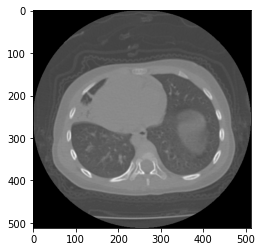

In [165]:
img = loadnib('0013.nii.gz', root = test_path)

plot_slice(img, 72)

In [186]:
filename_img = '0013.nii.gz'
i = 72

In [187]:
filename_mask = filename_img.replace(".nii.gz", ".nrrd")
filepath_img = os.path.join(test_path, filename_img)
filepath_mask = os.path.join(segmentation_path+"test/", filename_mask)
patient_number = filename_mask.split(".nrrd")[0]
img = mask_original(filepath_img, filepath_mask)


current_slice, bbox_pixels = bound_box_and_reshape(img, i)
current_slice = np.rot90(np.squeeze(current_slice))
percentage = percent_lungs_slice(filepath_mask, i)

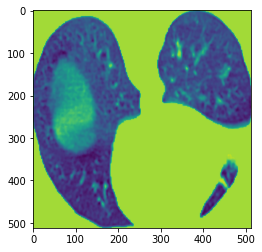

In [199]:
plt.imsave('cur.jpg', current_slice)
plt.imshow(current_slice)

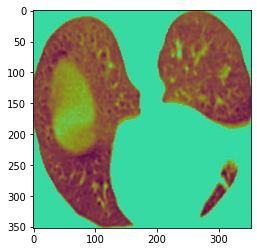

In [202]:
k = rgb_loader('cur.jpg')
plt.imshow(k)

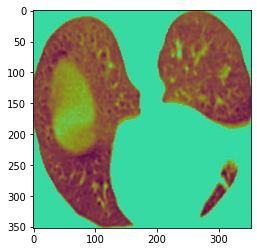

In [203]:
plt.imshow(k, cmap = 'gray')